<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb

In [ ]:
# Load data
df = pd.read_csv("Telco_customer_churn.csv")
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [ ]:
# Rename a few columns
df.rename(columns={"customerID": "CustomerID", "gender": "Gender", "tenure": "Tenure"}, inplace = True)
# Info
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [ ]:
# Understand each column
for col in df.columns:
    print(col, end=":\n")
    print(" " * 3, df[col].unique())

Gender:
    ['Female' 'Male']
SeniorCitizen:
    [0 1]
Partner:
    ['Yes' 'No']
Dependents:
    ['No' 'Yes']
Tenure:
    [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService:
    ['No' 'Yes']
MultipleLines:
    ['No-phone-service' 'No' 'Yes']
InternetService:
    ['DSL' 'Fiber-optic' 'No']
OnlineSecurity:
    ['No' 'Yes' 'No-internet-service']
OnlineBackup:
    ['Yes' 'No' 'No-internet-service']
DeviceProtection:
    ['No' 'Yes' 'No-internet-service']
TechSupport:
    ['No' 'Yes' 'No-internet-service']
StreamingTV:
    ['No' 'Yes' 'No-internet-service']
StreamingMovies:
    ['No' 'Yes' 'No-internet-service']
Contract:
    ['Month-to-month' 'One-year' 'Two-year']
PaperlessBilling:
    ['Yes' 'No']
PaymentMethod:
    ['Electronic-check' 'Mailed-check' 'Bank-transfer-(automatic)'
 'Credit-card-(automatic)']

In [ ]:
# Drop unnecessary columns
df.drop(["CustomerID"], axis = 1, inplace = True)

In [ ]:
# Number of missing data
len(df.loc[df["TotalCharges"] == " "])

11

In [ ]:
# Add 0 instead of whitespace for missing values
df.loc[(df["TotalCharges"] == " "), "TotalCharges"] = 0
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"])
df.dtypes

Gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
Tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [ ]:
# Load data and replace whitespaces with hyphen
df.replace(" ", "-", regex = True, inplace = True)
df.head()

Gender  SeniorCitizen Partner Dependents  Tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No-phone-service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No-phone-service             DSL            Yes           No   
4                No     Fiber-optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One-year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One-year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic-check           29.85         29.85   
1               No               Mailed-check           56.95       1889.50   
2              Yes               Mailed-check           53.85        108.15   
3               No  Bank-transfer-(automatic)           42.30       1840.75   
4              Yes           Electronic-check           70.70        151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [ ]:
# Define feature, target spaces
_X = df.drop(["Churn"], axis = 1).copy()
_y = df["Churn"].copy()

In [ ]:
# One hot encod
X = pd.get_dummies(_X, columns = ['Gender', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'], prefix_sep='-', drop_first = True)


In [ ]:
# One hot encod
y = pd.get_dummies(_y, prefix_sep='-', drop_first = True)
y.value_counts()

Yes
0      5174
1      1869
dtype: int64

In [ ]:
# Split data
X_trian, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [ ]:
# Fit model
clf_xgb = xgb.XGBClassifier(objective = "binary:logistic", seed = 42)
clf_xgb.fit(X_trian, y_train, verbose = True, early_stopping_rounds = 20, eval_metric = "aucpr", eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.63454
[1]	validation_0-aucpr:0.63778
[2]	validation_0-aucpr:0.64472
[3]	validation_0-aucpr:0.64135
[4]	validation_0-aucpr:0.64208
[5]	validation_0-aucpr:0.64338
[6]	validation_0-aucpr:0.64343
[7]	validation_0-aucpr:0.63709
[8]	validation_0-aucpr:0.64187
[9]	validation_0-aucpr:0.64377
[10]	validation_0-aucpr:0.64638
[11]	validation_0-aucpr:0.64653
[12]	validation_0-aucpr:0.64423
[13]	validation_0-aucpr:0.64051
[14]	validation_0-aucpr:0.63933
[15]	validation_0-aucpr:0.64357
[16]	validation_0-aucpr:0.64104
[17]	validation_0-aucpr:0.64095
[18]	validation_0-aucpr:0.63957
[19]	validation_0-aucpr:0.63714
[20]	validation_0-aucpr:0.63397
[21]	validation_0-aucpr:0.63554
[22]	validation_0-aucpr:0.63349
[23]	validation_0-aucpr:0.63104
[24]	validation_0-aucpr:0.63040
[25]	validation_0-aucpr:0.63038
[26]	validation_0-aucpr:0.63062
[27]	validation_0-aucpr:0.62997
[28]	validation_0-aucpr:0.62617
[29]	validation_0-aucpr:0.62487
[30]	validation_0-aucpr:0.62390
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

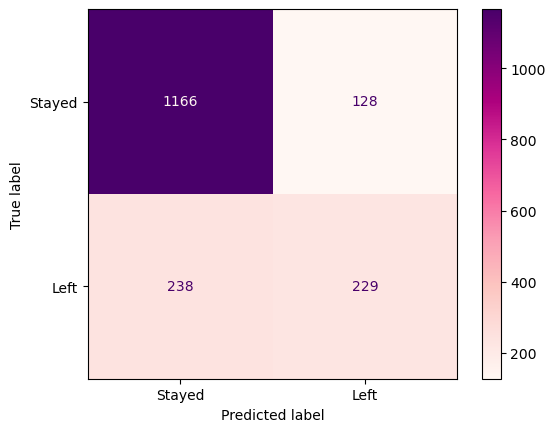

In [ ]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(clf_xgb, X_test, y_test, cmap="RdPu", display_labels = ["Stayed", "Left"])

In [ ]:
# Cross validation
param_grid = {"max_depth": [3, 5, 6], "learning_rate": [0.01, 0.05, 0.1], "gamma": [0, 0.25, 1.0],
             "reg_lambda": [0, 1.0, 10.0], "scale_pos_weight": [1, 3, 5]}
grid_search = GridSearchCV(estimator = xgb.XGBClassifier(objective = "binary:logistic", seed = 42,
                                                         subsample = 0.7, colsample_bytree = 0.5),
                           param_grid = param_grid, scoring = "roc_auc", verbose = 0, n_jobs = 10, cv = 5)
grid_search.fit(X_trian, y_train, verbose = True, early_stopping_rounds = 20, eval_metric = "auc",
                eval_set = [(X_test, y_test)])
print(grid_search.best_params_)

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[0]	validation_0-auc:0.73414
[1]	validation_0-auc:0.78374
[2]	validation_0-auc:0.81686
[0]	validation_0-auc:0.73238
[0]	validation_0-auc:0.73238
[3]	validation_0-auc:0.81053
[1]	validation_0-auc:0.78507
[2]	validation_0-auc:0.81185
[0]	validation_0-auc:0.74574
[1]	validation_0-auc:0.78483
[2]	validation_0-auc:0.81757
[4]	validation_0-auc:0.80682
[3]	validation_0-auc:0.81164
[5]	validation_0-auc:0.81707
[0]	validation_0-auc:0.74260
[1]	validation_0-auc:0.80968
[4]	validation_0-auc:0.81469
[2]	validation_0-auc:0.82342
[3]	validation_0-auc:0.81273
[5]	validation_0-auc:0.82419
[4]	validation_0-auc:0.81260
[6]	validation_0-auc:0.82430
[0]	validation_0-auc:0.74422
[7]	validation_0-auc:0.82942
[1]	validation_0-auc:0.80671
[3]	validation_0-auc:0.82784
[4]	validation_0-auc:0.83175
[2]	validation_0-auc:0.82063
[3]	validation_0-auc:0.83020
[0]	validation_0-auc:0.74286
[5]	validation_0-auc:0.82150
[1]	validation_0-auc:0.79405
[1]	validation_0-auc:0.80763
[6]	validation_0-auc:0.83132
[6]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-auc:0.84323
[46]	validation_0-auc:0.84311
[39]	validation_0-auc:0.84235
[43]	validation_0-auc:0.84226
[44]	validation_0-auc:0.84194
[40]	validation_0-auc:0.84260
[42]	validation_0-auc:0.84157
[43]	validation_0-auc:0.84686
[50]	validation_0-auc:0.84406
[43]	validation_0-auc:0.84175
[44]	validation_0-auc:0.84680
[51]	validation_0-auc:0.84400
[48]	validation_0-auc:0.84354
[40]	validation_0-auc:0.84315
[47]	validation_0-auc:0.84348
[49]	validation_0-auc:0.84380
[41]	validation_0-auc:0.84336
[45]	validation_0-auc:0.84190
[44]	validation_0-auc:0.84141
[41]	validation_0-auc:0.84288
[46]	validation_0-auc:0.84203
[45]	validation_0-auc:0.84134
[42]	validation_0-auc:0.84319
[45]	validation_0-auc:0.84692
[48]	validation_0-auc:0.84347
[52]	validation_0-auc:0.84413
[50]	validation_0-auc:0.84349
[49]	validation_0-auc:0.84393
[46]	validation_0-auc:0.84684
[53]	validation_0-auc:0.84438
[51]	validation_0-auc:0.84317
[42]	validation_0-auc:0.84323
[47]	validation_0-auc:0.84228
[43]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


ation_0-auc:0.84386
[73]	validation_0-auc:0.84521
[69]	validation_0-auc:0.84241
[22]	validation_0-auc:0.83841
[66]	validation_0-auc:0.84400
[74]	validation_0-auc:0.84543
[77]	validation_0-auc:0.84444
[67]	validation_0-auc:0.84416
[75]	validation_0-auc:0.84455
[69]	validation_0-auc:0.84668
[78]	validation_0-auc:0.84433
[68]	validation_0-auc:0.84416
[70]	validation_0-auc:0.84661
[76]	validation_0-auc:0.84470
[67]	validation_0-auc:0.84353
[71]	validation_0-auc:0.84409
[68]	validation_0-auc:0.84339
[72]	validation_0-auc:0.84400
[70]	validation_0-auc:0.84259
[23]	validation_0-auc:0.83902
[75]	validation_0-auc:0.84545
[71]	validation_0-auc:0.84269
[79]	validation_0-auc:0.84408
[76]	validation_0-auc:0.84562
[80]	validation_0-auc:0.84406
[72]	validation_0-auc:0.84258
[77]	validation_0-auc:0.84506
[71]	validation_0-auc:0.84675
[69]	validation_0-auc:0.84327
[73]	validation_0-auc:0.84284
[78]	validation_0-auc:0.84513
[72]	validation_0-auc:0.84672
[70]	validation_0-auc:0.84341
[24]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with 

[16]	validation_0-auc:0.83931
[11]	validation_0-auc:0.82988
[17]	validation_0-auc:0.83919
[34]	validation_0-auc:0.84148
[14]	validation_0-auc:0.83692
[35]	validation_0-auc:0.84154
[9]	validation_0-auc:0.83549
[15]	validation_0-auc:0.83830
[79]	validation_0-auc:0.84408
[10]	validation_0-auc:0.83679
[33]	validation_0-auc:0.84502
[36]	validation_0-auc:0.84182
[9]	validation_0-auc:0.83987
[37]	validation_0-auc:0.84210
[18]	validation_0-auc:0.83799
[10]	validation_0-auc:0.83994
[18]	validation_0-auc:0.83941
[12]	validation_0-auc:0.83213
[13]	validation_0-auc:0.83437
[19]	validation_0-auc:0.83793
[19]	validation_0-auc:0.83874
[80]	validation_0-auc:0.84411
[34]	validation_0-auc:0.84488
[16]	validation_0-auc:0.83689
[35]	validation_0-auc:0.84519
[11]	validation_0-auc:0.83721
[81]	validation_0-auc:0.84437
[11]	validation_0-auc:0.84116
[12]	validation_0-auc:0.83823
[14]	validation_0-auc:0.83455
[20]	validation_0-auc:0.83896
[12]	validation_0-auc:0.84158
[38]	validation_0-auc:0.84211
[15]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with 

[55]	validation_0-auc:0.84386
[74]	validation_0-auc:0.84484
[75]	validation_0-auc:0.84472
[56]	validation_0-auc:0.84401
[65]	validation_0-auc:0.84270
[36]	validation_0-auc:0.84338
[59]	validation_0-auc:0.84699
[66]	validation_0-auc:0.84284
[60]	validation_0-auc:0.84694
[41]	validation_0-auc:0.84106
[42]	validation_0-auc:0.84094
[49]	validation_0-auc:0.84495
[57]	validation_0-auc:0.84392
[43]	validation_0-auc:0.84078
[50]	validation_0-auc:0.84473
[51]	validation_0-auc:0.84486
[38]	validation_0-auc:0.84536
[41]	validation_0-auc:0.84205
[37]	validation_0-auc:0.84325
[76]	validation_0-auc:0.84495
[42]	validation_0-auc:0.84184
[61]	validation_0-auc:0.84666
[38]	validation_0-auc:0.84354
[77]	validation_0-auc:0.84532
[43]	validation_0-auc:0.84158
[44]	validation_0-auc:0.84156
[78]	validation_0-auc:0.84534
[45]	validation_0-auc:0.84153
[58]	validation_0-auc:0.84392
[39]	validation_0-auc:0.84515
[0]	validation_0-auc:0.75149
[39]	validation_0-auc:0.84307
[40]	validation_0-auc:0.84546
[59]	valida

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-auc:0.84133
[47]	validation_0-auc:0.84148
[42]	validation_0-auc:0.84361
[55]	validation_0-auc:0.84509
[43]	validation_0-auc:0.84371
[48]	validation_0-auc:0.84167
[56]	validation_0-auc:0.84517
[63]	validation_0-auc:0.84370
[81]	validation_0-auc:0.84545
[66]	validation_0-auc:0.84692
[5]	validation_0-auc:0.82987
[82]	validation_0-auc:0.84547
[72]	validation_0-auc:0.84316
[47]	validation_0-auc:0.84180
[64]	validation_0-auc:0.84360
[44]	validation_0-auc:0.84562
[73]	validation_0-auc:0.84312
[48]	validation_0-auc:0.84183
[49]	validation_0-auc:0.84167
[49]	validation_0-auc:0.84198
[45]	validation_0-auc:0.84572
[50]	validation_0-auc:0.84150
[44]	validation_0-auc:0.84375
[51]	validation_0-auc:0.84122
[67]	validation_0-auc:0.84675
[83]	validation_0-auc:0.84538
[52]	validation_0-auc:0.84154
[68]	validation_0-auc:0.84659
[6]	validation_0-auc:0.82803
[57]	validation_0-auc:0.84503
[65]	validation_0-auc:0.84358
[74]	validation_0-auc:0.84334
[50]	validation_0-auc:0.84148
[7]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[64]	validation_0-auc:0.84497
[2]	validation_0-auc:0.82091
[69]	validation_0-auc:0.84222
[94]	validation_0-auc:0.84425
[70]	validation_0-auc:0.84249
[3]	validation_0-auc:0.83058
[95]	validation_0-auc:0.84436
[65]	validation_0-auc:0.84513
[27]	validation_0-auc:0.84118
[85]	validation_0-auc:0.84412


/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[78]	validation_0-auc:0.84538
[66]	validation_0-auc:0.84510
[28]	validation_0-auc:0.84136
[86]	validation_0-auc:0.84413
[71]	validation_0-auc:0.84280
[66]	validation_0-auc:0.84599
[87]	validation_0-auc:0.84410
[71]	validation_0-auc:0.84268
[72]	validation_0-auc:0.84294
[88]	validation_0-auc:0.84403
[67]	validation_0-auc:0.84580
[72]	validation_0-auc:0.84302
[4]	validation_0-auc:0.83241
[79]	validation_0-auc:0.84534
[80]	validation_0-auc:0.84543
[29]	validation_0-auc:0.84176
[5]	validation_0-auc:0.83192
[73]	validation_0-auc:0.84298
[96]	validation_0-auc:0.84456
[67]	validation_0-auc:0.84512
[74]	validation_0-auc:0.84313
[97]	validation_0-auc:0.84436
[68]	validation_0-auc:0.84573
[68]	validation_0-auc:0.84505
[73]	validation_0-auc:0.84302
[81]	validation_0-auc:0.84546
[30]	validation_0-auc:0.84198
[89]	validation_0-auc:0.84407
[82]	validation_0-auc:0.84540
[90]	validation_0-auc:0.84411
[31]	validation_0-auc:0.84168
[98]	validation_0-auc:0.84439
[69]	validation_0-auc:0.84577
[6]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[15]	validation_0-auc:0.83965
[99]	validation_0-auc:0.84580
[29]	validation_0-auc:0.83781
[5]	validation_0-auc:0.82352
[30]	validation_0-auc:0.83810
[6]	validation_0-auc:0.82625
[38]	validation_0-auc:0.84304
[63]	validation_0-auc:0.84429
[21]	validation_0-auc:0.83300
[64]	validation_0-auc:0.84429
[16]	validation_0-auc:0.83977
[22]	validation_0-auc:0.83366
[17]	validation_0-auc:0.84025
[39]	validation_0-auc:0.84287
[31]	validation_0-auc:0.83907
[7]	validation_0-auc:0.82875
[65]	validation_0-auc:0.84441
[40]	validation_0-auc:0.84320
[32]	validation_0-auc:0.83898
[66]	validation_0-auc:0.84444
[8]	validation_0-auc:0.82927
[0]	validation_0-auc:0.74031
[18]	validation_0-auc:0.84059
[23]	validation_0-auc:0.83389
[33]	validation_0-auc:0.83901
[9]	validation_0-auc:0.82928
[67]	validation_0-auc:0.84444
[10]	validation_0-auc:0.83106
[41]	validation_0-auc:0.84364
[19]	validation_0-auc:0.83962
[24]	validation_0-auc:0.83447
[11]	validation_0-auc:0.83124
[42]	validation_0-auc:0.84374
[1]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[23]	validation_0-auc:0.84042
[5]	validation_0-auc:0.83019
[14]	validation_0-auc:0.83480
[29]	validation_0-auc:0.83785
[6]	validation_0-auc:0.82989
[30]	validation_0-auc:0.83749
[7]	validation_0-auc:0.83405
[72]	validation_0-auc:0.84408
[4]	validation_0-auc:0.81351
[46]	validation_0-auc:0.84386
[3]	validation_0-auc:0.80890
[5]	validation_0-auc:0.82367
[24]	validation_0-auc:0.84004
[47]	validation_0-auc:0.84366
[39]	validation_0-auc:0.84082
[15]	validation_0-auc:0.83340
[4]	validation_0-auc:0.80514
[25]	validation_0-auc:0.84010
[31]	validation_0-auc:0.83891
[16]	validation_0-auc:0.83426
[40]	validation_0-auc:0.84110
[73]	validation_0-auc:0.84407
[32]	validation_0-auc:0.83870
[8]	validation_0-auc:0.83542
[41]	validation_0-auc:0.84117
[74]	validation_0-auc:0.84410
[33]	validation_0-auc:0.83854
[9]	validation_0-auc:0.83659
[42]	validation_0-auc:0.84115
[48]	validation_0-auc:0.84348
[6]	validation_0-auc:0.83136
[5]	validation_0-auc:0.81842
[26]	validation_0-auc:0.84064
[75]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[53]	validation_0-auc:0.84405
[40]	validation_0-auc:0.83906
[11]	validation_0-auc:0.83025
[31]	validation_0-auc:0.84020
[32]	validation_0-auc:0.84069
[54]	validation_0-auc:0.84407
[12]	validation_0-auc:0.83228
[80]	validation_0-auc:0.84409
[23]	validation_0-auc:0.83577
[81]	validation_0-auc:0.84417
[55]	validation_0-auc:0.84421
[48]	validation_0-auc:0.84172
[56]	validation_0-auc:0.84438
[15]	validation_0-auc:0.83780
[24]	validation_0-auc:0.83584
[12]	validation_0-auc:0.83467
[33]	validation_0-auc:0.84054
[16]	validation_0-auc:0.83840
[13]	validation_0-auc:0.83784
[49]	validation_0-auc:0.84239
[34]	validation_0-auc:0.84039
[3]	validation_0-auc:0.83219
[41]	validation_0-auc:0.83952
[13]	validation_0-auc:0.83400
[82]	validation_0-auc:0.84410
[4]	validation_0-auc:0.83590
[42]	validation_0-auc:0.83963
[5]	validation_0-auc:0.83699
[14]	validation_0-auc:0.83497
[83]	validation_0-auc:0.84416
[6]	validation_0-auc:0.83741
[43]	validation_0-auc:0.83949
[15]	validation_0-auc:0.83627
[44]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-auc:0.83290
[31]	validation_0-auc:0.84114
[66]	validation_0-auc:0.84349
[5]	validation_0-auc:0.83386
[32]	validation_0-auc:0.84321
[67]	validation_0-auc:0.84343
[33]	validation_0-auc:0.83920
[32]	validation_0-auc:0.84177
[43]	validation_0-auc:0.83629
[68]	validation_0-auc:0.84314
[34]	validation_0-auc:0.83915
[44]	validation_0-auc:0.83590
[75]	validation_0-auc:0.84521
[69]	validation_0-auc:0.84287
[76]	validation_0-auc:0.84516
[52]	validation_0-auc:0.84047
[60]	validation_0-auc:0.84122
[22]	validation_0-auc:0.84314
[61]	validation_0-auc:0.84139
[33]	validation_0-auc:0.84367
[6]	validation_0-auc:0.83320
[33]	validation_0-auc:0.84178
[35]	validation_0-auc:0.83893
[34]	validation_0-auc:0.84368
[34]	validation_0-auc:0.84164
[35]	validation_0-auc:0.84354
[36]	validation_0-auc:0.83858
[53]	validation_0-auc:0.84063
[45]	validation_0-auc:0.83591
[77]	validation_0-auc:0.84517
[23]	validation_0-auc:0.84429
[46]	validation_0-auc:0.83602
[78]	validation_0-auc:0.84497
[54]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-auc:0.84256
[54]	validation_0-auc:0.83888
[24]	validation_0-auc:0.84207
[69]	validation_0-auc:0.84105
[50]	validation_0-auc:0.84237
[70]	validation_0-auc:0.84120
[52]	validation_0-auc:0.84360
[86]	validation_0-auc:0.84402
[95]	validation_0-auc:0.84532
[53]	validation_0-auc:0.84395
[87]	validation_0-auc:0.84416
[40]	validation_0-auc:0.84663
[54]	validation_0-auc:0.84386
[96]	validation_0-auc:0.84530
[55]	validation_0-auc:0.84399
[63]	validation_0-auc:0.83761
[41]	validation_0-auc:0.84679
[55]	validation_0-auc:0.83886
[25]	validation_0-auc:0.84287
[64]	validation_0-auc:0.83780
[51]	validation_0-auc:0.84220
[56]	validation_0-auc:0.83946
[26]	validation_0-auc:0.84328
[52]	validation_0-auc:0.84234
[71]	validation_0-auc:0.84149
[88]	validation_0-auc:0.84433
[72]	validation_0-auc:0.84144
[97]	validation_0-auc:0.84550
[56]	validation_0-auc:0.84404
[89]	validation_0-auc:0.84425
[98]	validation_0-auc:0.84556
[42]	validation_0-auc:0.84663
[65]	validation_0-auc:0.83772
[73]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[66]	validation_0-auc:0.84335
[58]	validation_0-auc:0.84633
[2]	validation_0-auc:0.80882
[3]	validation_0-auc:0.80950
[85]	validation_0-auc:0.84242
[12]	validation_0-auc:0.83967
[4]	validation_0-auc:0.81198
[86]	validation_0-auc:0.84256
[79]	validation_0-auc:0.84022
[39]	validation_0-auc:0.84372
[80]	validation_0-auc:0.84011
[40]	validation_0-auc:0.84385
[13]	validation_0-auc:0.83943
[67]	validation_0-auc:0.84345
[70]	validation_0-auc:0.84408
[68]	validation_0-auc:0.84339
[14]	validation_0-auc:0.84029
[71]	validation_0-auc:0.84013
[87]	validation_0-auc:0.84278
[5]	validation_0-auc:0.82317
[72]	validation_0-auc:0.84016
[88]	validation_0-auc:0.84262
[6]	validation_0-auc:0.82782
[89]	validation_0-auc:0.84257
[90]	validation_0-auc:0.84284
[81]	validation_0-auc:0.84031
[59]	validation_0-auc:0.84641
[41]	validation_0-auc:0.84400
[82]	validation_0-auc:0.84022
[42]	validation_0-auc:0.84429
[15]	validation_0-auc:0.83991
[69]	validation_0-auc:0.84331
[71]	validation_0-auc:0.84425
[70]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.74733
[44]	validation_0-auc:0.84398
[72]	validation_0-auc:0.84378
[1]	validation_0-auc:0.79051
[73]	validation_0-auc:0.84376
[45]	validation_0-auc:0.84408
[84]	validation_0-auc:0.84038
[75]	validation_0-auc:0.84472
[77]	validation_0-auc:0.84033
[85]	validation_0-auc:0.84053
[92]	validation_0-auc:0.84248
[86]	validation_0-auc:0.84056
[20]	validation_0-auc:0.84227
[87]	validation_0-auc:0.84074
[93]	validation_0-auc:0.84255
[88]	validation_0-auc:0.84081
[21]	validation_0-auc:0.84245
[46]	validation_0-auc:0.84422
[74]	validation_0-auc:0.84392
[76]	validation_0-auc:0.84493
[75]	validation_0-auc:0.84367
[78]	validation_0-auc:0.84046
[77]	validation_0-auc:0.84529
[2]	validation_0-auc:0.81060
[79]	validation_0-auc:0.84072
[12]	validation_0-auc:0.83202
[94]	validation_0-auc:0.84265
[47]	validation_0-auc:0.84428
[13]	validation_0-auc:0.83361
[95]	validation_0-auc:0.84268
[22]	validation_0-auc:0.84235
[14]	validation_0-auc:0.83441
[48]	validation_0-auc:0.84415
[15]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[77]	validation_0-auc:0.84370
[5]	validation_0-auc:0.81835
[25]	validation_0-auc:0.84307
[78]	validation_0-auc:0.84367
[82]	validation_0-auc:0.84056
[6]	validation_0-auc:0.82591
[97]	validation_0-auc:0.84289
[26]	validation_0-auc:0.84350
[16]	validation_0-auc:0.83437
[98]	validation_0-auc:0.84312
[17]	validation_0-auc:0.83421
[91]	validation_0-auc:0.84097
[83]	validation_0-auc:0.84072
[80]	validation_0-auc:0.84557
[99]	validation_0-auc:0.84344
[92]	validation_0-auc:0.84099
[84]	validation_0-auc:0.84064
[50]	validation_0-auc:0.84426
[85]	validation_0-auc:0.84085
[51]	validation_0-auc:0.84441
[86]	validation_0-auc:0.84087
[0]	validation_0-auc:0.74308
[81]	validation_0-auc:0.84568
[79]	validation_0-auc:0.84371
[82]	validation_0-auc:0.84570
[27]	validation_0-auc:0.84366
[80]	validation_0-auc:0.84366
[7]	validation_0-auc:0.82961
[18]	validation_0-auc:0.83558
[8]	validation_0-auc:0.82851
[93]	validation_0-auc:0.84119
[52]	validation_0-auc:0.84421
[9]	validation_0-auc:0.83119
[1]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[22]	validation_0-auc:0.84228
[50]	validation_0-auc:0.84469
[4]	validation_0-auc:0.83211
[15]	validation_0-auc:0.83846
[27]	validation_0-auc:0.84004
[16]	validation_0-auc:0.83830
[28]	validation_0-auc:0.84039
[99]	validation_0-auc:0.84505
[38]	validation_0-auc:0.83972
[39]	validation_0-auc:0.84005
[5]	validation_0-auc:0.83256
[75]	validation_0-auc:0.84414
[51]	validation_0-auc:0.84470
[76]	validation_0-auc:0.84404
[6]	validation_0-auc:0.83274
[17]	validation_0-auc:0.83866
[0]	validation_0-auc:0.75202
[7]	validation_0-auc:0.83648
[23]	validation_0-auc:0.84295
[8]	validation_0-auc:0.83795
[1]	validation_0-auc:0.78466
[24]	validation_0-auc:0.84332
[29]	validation_0-auc:0.84059
[40]	validation_0-auc:0.84017
[30]	validation_0-auc:0.84067
[77]	validation_0-auc:0.84415
[52]	validation_0-auc:0.84467
[18]	validation_0-auc:0.83769
[19]	validation_0-auc:0.83760
[25]	validation_0-auc:0.84378
[41]	validation_0-auc:0.84008
[26]	validation_0-auc:0.84432
[42]	validation_0-auc:0.83992
[31]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[22]	validation_0-auc:0.84021
[80]	validation_0-auc:0.84411
[3]	validation_0-auc:0.81755
[10]	validation_0-auc:0.83906
[81]	validation_0-auc:0.84450
[82]	validation_0-auc:0.84440
[28]	validation_0-auc:0.84501
[11]	validation_0-auc:0.83876
[55]	validation_0-auc:0.84502
[44]	validation_0-auc:0.84000
[29]	validation_0-auc:0.84472
[56]	validation_0-auc:0.84519
[0]	validation_0-auc:0.76388
[30]	validation_0-auc:0.84475
[45]	validation_0-auc:0.84012
[31]	validation_0-auc:0.84428
[32]	validation_0-auc:0.84442
[46]	validation_0-auc:0.84016
[23]	validation_0-auc:0.83998
[33]	validation_0-auc:0.84440
[4]	validation_0-auc:0.81331
[47]	validation_0-auc:0.84045
[12]	validation_0-auc:0.83846
[57]	validation_0-auc:0.84520
[13]	validation_0-auc:0.83869
[24]	validation_0-auc:0.83967
[35]	validation_0-auc:0.84158
[58]	validation_0-auc:0.84526
[59]	validation_0-auc:0.84531
[5]	validation_0-auc:0.82329
[36]	validation_0-auc:0.84168
[83]	validation_0-auc:0.84443
[1]	validation_0-auc:0.79164
[84]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-auc:0.84145
[0]	validation_0-auc:0.75402
[44]	validation_0-auc:0.84497
[38]	validation_0-auc:0.84173
[13]	validation_0-auc:0.83496
[1]	validation_0-auc:0.80732
[8]	validation_0-auc:0.84056
[70]	validation_0-auc:0.84572
[45]	validation_0-auc:0.84515
[10]	validation_0-auc:0.83506
[71]	validation_0-auc:0.84574
[9]	validation_0-auc:0.84158
[72]	validation_0-auc:0.84564
[49]	validation_0-auc:0.84167
[46]	validation_0-auc:0.84524
[10]	validation_0-auc:0.84293
[73]	validation_0-auc:0.84567
[50]	validation_0-auc:0.84138
[28]	validation_0-auc:0.84193
[39]	validation_0-auc:0.84216
[14]	validation_0-auc:0.83540
[29]	validation_0-auc:0.84219
[40]	validation_0-auc:0.84211
[62]	validation_0-auc:0.84140
[11]	validation_0-auc:0.83285
[2]	validation_0-auc:0.82037
[47]	validation_0-auc:0.84503
[63]	validation_0-auc:0.84129
[15]	validation_0-auc:0.83728
[12]	validation_0-auc:0.83388
[3]	validation_0-auc:0.82818
[48]	validation_0-auc:0.84507
[13]	validation_0-auc:0.83504
[41]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[59]	validation_0-auc:0.84553
[86]	validation_0-auc:0.84543
[60]	validation_0-auc:0.84545
[76]	validation_0-auc:0.84344
[87]	validation_0-auc:0.84554
[42]	validation_0-auc:0.84401
[88]	validation_0-auc:0.84553
[89]	validation_0-auc:0.84577
[43]	validation_0-auc:0.84405
[90]	validation_0-auc:0.84593
[11]	validation_0-auc:0.84192
[19]	validation_0-auc:0.84507
[91]	validation_0-auc:0.84595
[92]	validation_0-auc:0.84595
[12]	validation_0-auc:0.84270
[24]	validation_0-auc:0.84208
[13]	validation_0-auc:0.84265
[21]	validation_0-auc:0.83952
[61]	validation_0-auc:0.84540
[77]	validation_0-auc:0.84365
[14]	validation_0-auc:0.84288
[44]	validation_0-auc:0.84401
[15]	validation_0-auc:0.84285
[78]	validation_0-auc:0.84370
[0]	validation_0-auc:0.76224
[57]	validation_0-auc:0.84322
[20]	validation_0-auc:0.84551
[25]	validation_0-auc:0.84232
[22]	validation_0-auc:0.84001
[58]	validation_0-auc:0.84326
[62]	validation_0-auc:0.84544
[45]	validation_0-auc:0.84419
[79]	validation_0-auc:0.84380
[1]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-auc:0.84245
[83]	validation_0-auc:0.84574
[64]	validation_0-auc:0.84476
[27]	validation_0-auc:0.84434
[79]	validation_0-auc:0.84401
[98]	validation_0-auc:0.84464
[65]	validation_0-auc:0.84495
[80]	validation_0-auc:0.84395
[99]	validation_0-auc:0.84464
[84]	validation_0-auc:0.84568
[39]	validation_0-auc:0.84512
[85]	validation_0-auc:0.84563
[40]	validation_0-auc:0.84562
[3]	validation_0-auc:0.81386
[35]	validation_0-auc:0.84591
[37]	validation_0-auc:0.84248
[17]	validation_0-auc:0.84327
[66]	validation_0-auc:0.84484
[28]	validation_0-auc:0.84420
[38]	validation_0-auc:0.84285
[81]	validation_0-auc:0.84404
[67]	validation_0-auc:0.84489
[86]	validation_0-auc:0.84557
[68]	validation_0-auc:0.84480
[41]	validation_0-auc:0.84561
[69]	validation_0-auc:0.84503
[36]	validation_0-auc:0.84596
[18]	validation_0-auc:0.84352
[4]	validation_0-auc:0.81279
[37]	validation_0-auc:0.84669
[5]	validation_0-auc:0.82124
[82]	validation_0-auc:0.84405
[19]	validation_0-auc:0.84276
[29]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[73]	validation_0-auc:0.84497
[21]	validation_0-auc:0.84412
[74]	validation_0-auc:0.84491
[42]	validation_0-auc:0.84361
[32]	validation_0-auc:0.84393
[0]	validation_0-auc:0.76046
[40]	validation_0-auc:0.84685
[96]	validation_0-auc:0.84575
[33]	validation_0-auc:0.84398
[8]	validation_0-auc:0.82902
[97]	validation_0-auc:0.84587
[45]	validation_0-auc:0.84557
[75]	validation_0-auc:0.84485
[22]	validation_0-auc:0.84433
[9]	validation_0-auc:0.83028
[43]	validation_0-auc:0.84386
[41]	validation_0-auc:0.84696
[1]	validation_0-auc:0.78950
[23]	validation_0-auc:0.84418
[34]	validation_0-auc:0.84401
[46]	validation_0-auc:0.84551
[35]	validation_0-auc:0.84360
[76]	validation_0-auc:0.84487
[10]	validation_0-auc:0.83313
[44]	validation_0-auc:0.84370
[36]	validation_0-auc:0.84352
[37]	validation_0-auc:0.84377
[42]	validation_0-auc:0.84685
[2]	validation_0-auc:0.81919
[77]	validation_0-auc:0.84502
[47]	validation_0-auc:0.84585
[78]	validation_0-auc:0.84487
[24]	validation_0-auc:0.84393
[98]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-auc:0.83761
[50]	validation_0-auc:0.84671
[55]	validation_0-auc:0.84556
[90]	validation_0-auc:0.84548
[6]	validation_0-auc:0.83407
[43]	validation_0-auc:0.84386
[32]	validation_0-auc:0.84456
[51]	validation_0-auc:0.84676
[56]	validation_0-auc:0.84564
[91]	validation_0-auc:0.84557
[57]	validation_0-auc:0.84545
[1]	validation_0-auc:0.80565
[7]	validation_0-auc:0.83739
[92]	validation_0-auc:0.84553
[33]	validation_0-auc:0.84455
[52]	validation_0-auc:0.84722
[8]	validation_0-auc:0.84055
[34]	validation_0-auc:0.84460
[53]	validation_0-auc:0.84731
[11]	validation_0-auc:0.83378
[54]	validation_0-auc:0.84408
[20]	validation_0-auc:0.83834
[12]	validation_0-auc:0.83463
[2]	validation_0-auc:0.81968
[93]	validation_0-auc:0.84556
[3]	validation_0-auc:0.82750
[21]	validation_0-auc:0.83967
[55]	validation_0-auc:0.84383
[9]	validation_0-auc:0.84134
[58]	validation_0-auc:0.84565
[35]	validation_0-auc:0.84416
[54]	validation_0-auc:0.84729
[59]	validation_0-auc:0.84576
[13]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[38]	validation_0-auc:0.84431
[58]	validation_0-auc:0.84405
[0]	validation_0-auc:0.75654
[61]	validation_0-auc:0.84601
[16]	validation_0-auc:0.83635
[59]	validation_0-auc:0.84426
[25]	validation_0-auc:0.84256
[17]	validation_0-auc:0.83562
[62]	validation_0-auc:0.84616
[12]	validation_0-auc:0.84362
[7]	validation_0-auc:0.83542
[57]	validation_0-auc:0.84763
[39]	validation_0-auc:0.84410
[1]	validation_0-auc:0.80557
[60]	validation_0-auc:0.84443
[18]	validation_0-auc:0.83726
[26]	validation_0-auc:0.84315
[63]	validation_0-auc:0.84649
[13]	validation_0-auc:0.84303
[8]	validation_0-auc:0.83838
[58]	validation_0-auc:0.84787
[40]	validation_0-auc:0.84420
[2]	validation_0-auc:0.82058
[59]	validation_0-auc:0.84776
[9]	validation_0-auc:0.83923
[19]	validation_0-auc:0.83773
[61]	validation_0-auc:0.84452
[27]	validation_0-auc:0.84262
[64]	validation_0-auc:0.84668
[28]	validation_0-auc:0.84293
[20]	validation_0-auc:0.83862
[41]	validation_0-auc:0.84430
[10]	validation_0-auc:0.84129
[21]	validation_

[56]	validation_0-auc:0.84628
[43]	validation_0-auc:0.84724
[88]	validation_0-auc:0.84859
[39]	validation_0-auc:0.84404
[69]	validation_0-auc:0.84707
[28]	validation_0-auc:0.84097
[33]	validation_0-auc:0.84447
[91]	validation_0-auc:0.84576
[94]	validation_0-auc:0.84778
[70]	validation_0-auc:0.84725
[29]	validation_0-auc:0.84100
[92]	validation_0-auc:0.84581
[95]	validation_0-auc:0.84790
[34]	validation_0-auc:0.84421
[96]	validation_0-auc:0.84794
[49]	validation_0-auc:0.84394
[44]	validation_0-auc:0.84695
[57]	validation_0-auc:0.84650
[97]	validation_0-auc:0.84782
[89]	validation_0-auc:0.84853
[40]	validation_0-auc:0.84415
[90]	validation_0-auc:0.84854
[30]	validation_0-auc:0.84131
[58]	validation_0-auc:0.84637
[71]	validation_0-auc:0.84719
[93]	validation_0-auc:0.84588
[35]	validation_0-auc:0.84405
[72]	validation_0-auc:0.84715
[50]	validation_0-auc:0.84391
[45]	validation_0-auc:0.84701
[41]	validation_0-auc:0.84442
[91]	validation_0-auc:0.84860
[42]	validation_0-auc:0.84473
[94]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[81]	validation_0-auc:0.84731
[44]	validation_0-auc:0.84471
[68]	validation_0-auc:0.84673
[40]	validation_0-auc:0.84325
[45]	validation_0-auc:0.84472
[82]	validation_0-auc:0.84716
[61]	validation_0-auc:0.84376
[52]	validation_0-auc:0.84478
[55]	validation_0-auc:0.84750
[2]	validation_0-auc:0.81677
[69]	validation_0-auc:0.84650
[56]	validation_0-auc:0.84768
[46]	validation_0-auc:0.84479
[41]	validation_0-auc:0.84339
[83]	validation_0-auc:0.84715
[0]	validation_0-auc:0.75636
[3]	validation_0-auc:0.81593
[53]	validation_0-auc:0.84504
[62]	validation_0-auc:0.84393
[57]	validation_0-auc:0.84751
[70]	validation_0-auc:0.84673
[0]	validation_0-auc:0.75838
[47]	validation_0-auc:0.84472
[54]	validation_0-auc:0.84504
[71]	validation_0-auc:0.84677
[84]	validation_0-auc:0.84718
[42]	validation_0-auc:0.84365
[4]	validation_0-auc:0.81275
[1]	validation_0-auc:0.80171
[43]	validation_0-auc:0.84375
[58]	validation_0-auc:0.84758
[63]	validation_0-auc:0.84412
[55]	validation_0-auc:0.84506
[48]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[77]	validation_0-auc:0.84539
[27]	validation_0-auc:0.84106
[2]	validation_0-auc:0.81868
[24]	validation_0-auc:0.84465
[71]	validation_0-auc:0.84615
[23]	validation_0-auc:0.84251
[87]	validation_0-auc:0.84480
[28]	validation_0-auc:0.84154
[68]	validation_0-auc:0.84520
[88]	validation_0-auc:0.84478
[96]	validation_0-auc:0.84772
[78]	validation_0-auc:0.84526
[3]	validation_0-auc:0.82707
[25]	validation_0-auc:0.84459
[29]	validation_0-auc:0.84132
[72]	validation_0-auc:0.84598
[0]	validation_0-auc:0.76334
[24]	validation_0-auc:0.84242
[89]	validation_0-auc:0.84487
[1]	validation_0-auc:0.79250
[73]	validation_0-auc:0.84603
[4]	validation_0-auc:0.83196
[26]	validation_0-auc:0.84446
[5]	validation_0-auc:0.83139
[2]	validation_0-auc:0.82244
[27]	validation_0-auc:0.84465
[90]	validation_0-auc:0.84488
[6]	validation_0-auc:0.83326
[28]	validation_0-auc:0.84472
[69]	validation_0-auc:0.84505
[30]	validation_0-auc:0.84159
[29]	validation_0-auc:0.84498
[70]	validation_0-auc:0.84535
[97]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[32]	validation_0-auc:0.84422
[10]	validation_0-auc:0.84277
[34]	validation_0-auc:0.84205
[0]	validation_0-auc:0.75996
[7]	validation_0-auc:0.83618
[35]	validation_0-auc:0.84244
[30]	validation_0-auc:0.84215
[95]	validation_0-auc:0.84498
[33]	validation_0-auc:0.84427
[79]	validation_0-auc:0.84600
[76]	validation_0-auc:0.84550
[11]	validation_0-auc:0.84233
[1]	validation_0-auc:0.79591
[8]	validation_0-auc:0.83368
[36]	validation_0-auc:0.84215
[31]	validation_0-auc:0.84218
[37]	validation_0-auc:0.84197
[96]	validation_0-auc:0.84491
[38]	validation_0-auc:0.84208
[32]	validation_0-auc:0.84172
[80]	validation_0-auc:0.84606
[39]	validation_0-auc:0.84212
[97]	validation_0-auc:0.84493
[33]	validation_0-auc:0.84170
[40]	validation_0-auc:0.84186
[98]	validation_0-auc:0.84497
[34]	validation_0-auc:0.84436
[77]	validation_0-auc:0.84543
[12]	validation_0-auc:0.84282
[9]	validation_0-auc:0.83577
[2]	validation_0-auc:0.82112
[0]	validation_0-auc:0.75825
[13]	validation_0-auc:0.84311
[3]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[10]	validation_0-auc:0.84298
[23]	validation_0-auc:0.84370
[13]	validation_0-auc:0.83658
[45]	validation_0-auc:0.84589
[49]	validation_0-auc:0.84274
[43]	validation_0-auc:0.84308
[46]	validation_0-auc:0.84571
[88]	validation_0-auc:0.84579
[44]	validation_0-auc:0.84304
[3]	validation_0-auc:0.82956
[11]	validation_0-auc:0.84337
[20]	validation_0-auc:0.84211
[4]	validation_0-auc:0.83207
[14]	validation_0-auc:0.83825
[12]	validation_0-auc:0.84451
[21]	validation_0-auc:0.84301
[24]	validation_0-auc:0.84424
[50]	validation_0-auc:0.84270
[15]	validation_0-auc:0.83978
[22]	validation_0-auc:0.84328
[51]	validation_0-auc:0.84266
[45]	validation_0-auc:0.84317
[89]	validation_0-auc:0.84605
[5]	validation_0-auc:0.83360
[13]	validation_0-auc:0.84426
[25]	validation_0-auc:0.84451
[47]	validation_0-auc:0.84589
[16]	validation_0-auc:0.83869
[26]	validation_0-auc:0.84443
[90]	validation_0-auc:0.84598
[52]	validation_0-auc:0.84259
[46]	validation_0-auc:0.84323
[91]	validation_0-auc:0.84594
[27]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[59]	validation_0-auc:0.84402
[27]	validation_0-auc:0.84674
[65]	validation_0-auc:0.84304
[30]	validation_0-auc:0.84236
[39]	validation_0-auc:0.84423
[36]	validation_0-auc:0.84618
[66]	validation_0-auc:0.84325
[37]	validation_0-auc:0.84603
[20]	validation_0-auc:0.84478
[13]	validation_0-auc:0.84583
[28]	validation_0-auc:0.84675
[62]	validation_0-auc:0.84607
[60]	validation_0-auc:0.84405
[0]	validation_0-auc:0.75292
[31]	validation_0-auc:0.84279
[61]	validation_0-auc:0.84395
[40]	validation_0-auc:0.84402
[67]	validation_0-auc:0.84328
[21]	validation_0-auc:0.84497
[38]	validation_0-auc:0.84657
[41]	validation_0-auc:0.84422
[68]	validation_0-auc:0.84314
[14]	validation_0-auc:0.84579
[63]	validation_0-auc:0.84590
[15]	validation_0-auc:0.84524
[32]	validation_0-auc:0.84283
[1]	validation_0-auc:0.78768
[62]	validation_0-auc:0.84402
[29]	validation_0-auc:0.84678
[42]	validation_0-auc:0.84467
[22]	validation_0-auc:0.84528
[39]	validation_0-auc:0.84669
[64]	validation_0-auc:0.84594
[23]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[71]	validation_0-auc:0.84816
[63]	validation_0-auc:0.84609
[71]	validation_0-auc:0.84505
[3]	validation_0-auc:0.81859
[99]	validation_0-auc:0.84359
[94]	validation_0-auc:0.84711
[60]	validation_0-auc:0.84860
[47]	validation_0-auc:0.84650
[72]	validation_0-auc:0.84495
[61]	validation_0-auc:0.84851
[72]	validation_0-auc:0.84841
[33]	validation_0-auc:0.84552
[4]	validation_0-auc:0.81592
[64]	validation_0-auc:0.84622
[73]	validation_0-auc:0.84499
[95]	validation_0-auc:0.84719
[34]	validation_0-auc:0.84560
[48]	validation_0-auc:0.84645
[65]	validation_0-auc:0.84636
[96]	validation_0-auc:0.84718
[49]	validation_0-auc:0.84665
[66]	validation_0-auc:0.84643
[5]	validation_0-auc:0.82488
[62]	validation_0-auc:0.84840
[50]	validation_0-auc:0.84632
[6]	validation_0-auc:0.83034
[73]	validation_0-auc:0.84834
[35]	validation_0-auc:0.84592
[74]	validation_0-auc:0.84505
[63]	validation_0-auc:0.84836
[97]	validation_0-auc:0.84716
[67]	validation_0-auc:0.84646
[0]	validation_0-auc:0.75698
[51]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[77]	validation_0-auc:0.84511
[10]	validation_0-auc:0.83589
[78]	validation_0-auc:0.84494
[78]	validation_0-auc:0.84857
[79]	validation_0-auc:0.84497
[67]	validation_0-auc:0.84855
[80]	validation_0-auc:0.84500
[54]	validation_0-auc:0.84681
[71]	validation_0-auc:0.84612
[81]	validation_0-auc:0.84500
[40]	validation_0-auc:0.84677
[55]	validation_0-auc:0.84666
[68]	validation_0-auc:0.84835
[41]	validation_0-auc:0.84674
[0]	validation_0-auc:0.75442
[56]	validation_0-auc:0.84696
[57]	validation_0-auc:0.84706
[11]	validation_0-auc:0.83420
[1]	validation_0-auc:0.80332
[58]	validation_0-auc:0.84722
[4]	validation_0-auc:0.83763
[2]	validation_0-auc:0.81952
[79]	validation_0-auc:0.84851
[3]	validation_0-auc:0.82652
[12]	validation_0-auc:0.83504
[72]	validation_0-auc:0.84639
[5]	validation_0-auc:0.83755
[69]	validation_0-auc:0.84832
[13]	validation_0-auc:0.83644
[80]	validation_0-auc:0.84844
[6]	validation_0-auc:0.83720
[42]	validation_0-auc:0.84683
[73]	validation_0-auc:0.84647
[74]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[68]	validation_0-auc:0.84775
[83]	validation_0-auc:0.84688
[17]	validation_0-auc:0.84571
[14]	validation_0-auc:0.84093
[80]	validation_0-auc:0.84937
[23]	validation_0-auc:0.84150
[53]	validation_0-auc:0.84672
[54]	validation_0-auc:0.84661
[91]	validation_0-auc:0.84890
[24]	validation_0-auc:0.84169
[9]	validation_0-auc:0.84208
[0]	validation_0-auc:0.75143
[92]	validation_0-auc:0.84887
[10]	validation_0-auc:0.84403
[84]	validation_0-auc:0.84667
[69]	validation_0-auc:0.84786
[15]	validation_0-auc:0.84110
[81]	validation_0-auc:0.84942
[18]	validation_0-auc:0.84623
[70]	validation_0-auc:0.84801
[82]	validation_0-auc:0.84934
[19]	validation_0-auc:0.84540
[55]	validation_0-auc:0.84665
[25]	validation_0-auc:0.84132
[93]	validation_0-auc:0.84892
[1]	validation_0-auc:0.78414
[85]	validation_0-auc:0.84668
[11]	validation_0-auc:0.84342
[16]	validation_0-auc:0.84201
[94]	validation_0-auc:0.84894
[86]	validation_0-auc:0.84678
[71]	validation_0-auc:0.84789
[17]	validation_0-auc:0.84265
[56]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[20]	validation_0-auc:0.84399
[94]	validation_0-auc:0.84706
[12]	validation_0-auc:0.83091
[35]	validation_0-auc:0.84301
[28]	validation_0-auc:0.84664
[81]	validation_0-auc:0.84832
[26]	validation_0-auc:0.84300
[29]	validation_0-auc:0.84683
[92]	validation_0-auc:0.84954
[21]	validation_0-auc:0.84392
[30]	validation_0-auc:0.84680
[27]	validation_0-auc:0.84322
[13]	validation_0-auc:0.83295
[95]	validation_0-auc:0.84717
[36]	validation_0-auc:0.84292
[82]	validation_0-auc:0.84826
[83]	validation_0-auc:0.84826
[93]	validation_0-auc:0.84955
[22]	validation_0-auc:0.84409
[0]	validation_0-auc:0.75991
[96]	validation_0-auc:0.84719
[37]	validation_0-auc:0.84298
[1]	validation_0-auc:0.79343
[31]	validation_0-auc:0.84667
[38]	validation_0-auc:0.84315
[14]	validation_0-auc:0.83462
[28]	validation_0-auc:0.84322
[94]	validation_0-auc:0.84948
[23]	validation_0-auc:0.84436
[97]	validation_0-auc:0.84729
[15]	validation_0-auc:0.83541
[32]	validation_0-auc:0.84670
[39]	validation_0-auc:0.84329
[29]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[90]	validation_0-auc:0.84846
[30]	validation_0-auc:0.84502
[91]	validation_0-auc:0.84851
[45]	validation_0-auc:0.84351
[38]	validation_0-auc:0.84762
[22]	validation_0-auc:0.83975
[36]	validation_0-auc:0.84383
[6]	validation_0-auc:0.83525
[31]	validation_0-auc:0.84482
[37]	validation_0-auc:0.84405
[23]	validation_0-auc:0.83961
[8]	validation_0-auc:0.83174
[32]	validation_0-auc:0.84496
[33]	validation_0-auc:0.84490
[92]	validation_0-auc:0.84854
[34]	validation_0-auc:0.84465
[46]	validation_0-auc:0.84374
[9]	validation_0-auc:0.83372
[35]	validation_0-auc:0.84451
[39]	validation_0-auc:0.84805
[10]	validation_0-auc:0.83448
[0]	validation_0-auc:0.76240
[7]	validation_0-auc:0.83838
[40]	validation_0-auc:0.84803
[47]	validation_0-auc:0.84419
[41]	validation_0-auc:0.84799
[8]	validation_0-auc:0.84107
[48]	validation_0-auc:0.84411
[42]	validation_0-auc:0.84822
[24]	validation_0-auc:0.84015
[93]	validation_0-auc:0.84848
[38]	validation_0-auc:0.84424
[1]	validation_0-auc:0.79712
[94]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-auc:0.84362
[13]	validation_0-auc:0.83869
[1]	validation_0-auc:0.77771
[22]	validation_0-auc:0.84140
[45]	validation_0-auc:0.84516
[61]	validation_0-auc:0.84387
[11]	validation_0-auc:0.84242
[53]	validation_0-auc:0.84821
[62]	validation_0-auc:0.84406
[21]	validation_0-auc:0.84392
[54]	validation_0-auc:0.84822
[23]	validation_0-auc:0.84121
[14]	validation_0-auc:0.83931
[2]	validation_0-auc:0.81915
[46]	validation_0-auc:0.84517
[12]	validation_0-auc:0.84298
[52]	validation_0-auc:0.84480
[47]	validation_0-auc:0.84525
[63]	validation_0-auc:0.84405
[3]	validation_0-auc:0.81270
[22]	validation_0-auc:0.84460
[15]	validation_0-auc:0.83966
[24]	validation_0-auc:0.84145
[64]	validation_0-auc:0.84419
[4]	validation_0-auc:0.81235
[55]	validation_0-auc:0.84818
[65]	validation_0-auc:0.84442
[53]	validation_0-auc:0.84503
[13]	validation_0-auc:0.84302
[48]	validation_0-auc:0.84527
[56]	validation_0-auc:0.84833
[25]	validation_0-auc:0.84100
[40]	validation_0-auc:0.84258
[16]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-auc:0.84319
[49]	validation_0-auc:0.84672
[41]	validation_0-auc:0.84395
[1]	validation_0-auc:0.77420
[91]	validation_0-auc:0.84481
[67]	validation_0-auc:0.84503
[75]	validation_0-auc:0.84623
[52]	validation_0-auc:0.84330
[50]	validation_0-auc:0.84626
[33]	validation_0-auc:0.84317
[43]	validation_0-auc:0.84296
[68]	validation_0-auc:0.84471
[76]	validation_0-auc:0.84637
[2]	validation_0-auc:0.81220
[69]	validation_0-auc:0.84452
[92]	validation_0-auc:0.84479
[42]	validation_0-auc:0.84427
[70]	validation_0-auc:0.84474
[3]	validation_0-auc:0.80703
[44]	validation_0-auc:0.84293
[34]	validation_0-auc:0.84365
[53]	validation_0-auc:0.84313
[51]	validation_0-auc:0.84657
[45]	validation_0-auc:0.84310
[35]	validation_0-auc:0.84458
[46]	validation_0-auc:0.84309
[52]	validation_0-auc:0.84679
[77]	validation_0-auc:0.84637
[93]	validation_0-auc:0.84486
[43]	validation_0-auc:0.84427
[4]	validation_0-auc:0.80822
[44]	validation_0-auc:0.84402
[54]	validation_0-auc:0.84279
[71]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-auc:0.83139
[46]	validation_0-auc:0.84411
[0]	validation_0-auc:0.74907
[58]	validation_0-auc:0.84315
[39]	validation_0-auc:0.84543
[98]	validation_0-auc:0.84526
[56]	validation_0-auc:0.84679
[1]	validation_0-auc:0.80424
[74]	validation_0-auc:0.84499
[50]	validation_0-auc:0.84340
[82]	validation_0-auc:0.84619
[9]	validation_0-auc:0.83260
[47]	validation_0-auc:0.84421
[59]	validation_0-auc:0.84285
[48]	validation_0-auc:0.84408
[2]	validation_0-auc:0.81398
[99]	validation_0-auc:0.84532
[40]	validation_0-auc:0.84550
[57]	validation_0-auc:0.84657
[75]	validation_0-auc:0.84511
[41]	validation_0-auc:0.84557
[83]	validation_0-auc:0.84628
[10]	validation_0-auc:0.83382
[51]	validation_0-auc:0.84357
[60]	validation_0-auc:0.84277
[3]	validation_0-auc:0.82834
[49]	validation_0-auc:0.84418
[11]	validation_0-auc:0.83053
[61]	validation_0-auc:0.84272
[50]	validation_0-auc:0.84409
[58]	validation_0-auc:0.84658
[12]	validation_0-auc:0.83321
[52]	validation_0-auc:0.84362
[76]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-auc:0.83762
[15]	validation_0-auc:0.83823
[62]	validation_0-auc:0.84678
[53]	validation_0-auc:0.84463
[55]	validation_0-auc:0.84396
[87]	validation_0-auc:0.84622
[65]	validation_0-auc:0.84336
[46]	validation_0-auc:0.84539
[88]	validation_0-auc:0.84626
[80]	validation_0-auc:0.84517
[8]	validation_0-auc:0.83811
[47]	validation_0-auc:0.84580
[16]	validation_0-auc:0.83609
[54]	validation_0-auc:0.84482
[48]	validation_0-auc:0.84566
[56]	validation_0-auc:0.84424
[63]	validation_0-auc:0.84673
[66]	validation_0-auc:0.84368
[17]	validation_0-auc:0.83563
[89]	validation_0-auc:0.84631
[81]	validation_0-auc:0.84529
[9]	validation_0-auc:0.83806
[55]	validation_0-auc:0.84485
[49]	validation_0-auc:0.84595
[57]	validation_0-auc:0.84411
[64]	validation_0-auc:0.84666
[10]	validation_0-auc:0.83706
[67]	validation_0-auc:0.84365
[90]	validation_0-auc:0.84638
[0]	validation_0-auc:0.74700
[68]	validation_0-auc:0.84348
[18]	validation_0-auc:0.83623
[82]	validation_0-auc:0.84545
[1]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[58]	validation_0-auc:0.84474
[21]	validation_0-auc:0.83658
[60]	validation_0-auc:0.84425
[13]	validation_0-auc:0.84018
[61]	validation_0-auc:0.84418
[68]	validation_0-auc:0.84654
[14]	validation_0-auc:0.84121
[86]	validation_0-auc:0.84554
[22]	validation_0-auc:0.83657
[59]	validation_0-auc:0.84477
[62]	validation_0-auc:0.84425
[15]	validation_0-auc:0.84123
[54]	validation_0-auc:0.84625
[69]	validation_0-auc:0.84653
[6]	validation_0-auc:0.82994
[16]	validation_0-auc:0.84179
[63]	validation_0-auc:0.84417
[87]	validation_0-auc:0.84555
[23]	validation_0-auc:0.83658
[64]	validation_0-auc:0.84425
[60]	validation_0-auc:0.84479
[65]	validation_0-auc:0.84433
[70]	validation_0-auc:0.84667
[61]	validation_0-auc:0.84474
[0]	validation_0-auc:0.74816
[71]	validation_0-auc:0.84676
[55]	validation_0-auc:0.84629
[7]	validation_0-auc:0.83376
[88]	validation_0-auc:0.84562
[24]	validation_0-auc:0.83697
[56]	validation_0-auc:0.84617
[17]	validation_0-auc:0.84204
[8]	validation_0-auc:0.83254
[25]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[76]	validation_0-auc:0.84495
[80]	validation_0-auc:0.84447
[39]	validation_0-auc:0.84201
[32]	validation_0-auc:0.84235
[77]	validation_0-auc:0.84503
[85]	validation_0-auc:0.84726
[17]	validation_0-auc:0.84141
[14]	validation_0-auc:0.83921
[78]	validation_0-auc:0.84495
[24]	validation_0-auc:0.83850
[86]	validation_0-auc:0.84724
[72]	validation_0-auc:0.84654
[25]	validation_0-auc:0.83803
[0]	validation_0-auc:0.75909
[40]	validation_0-auc:0.84179
[73]	validation_0-auc:0.84633
[15]	validation_0-auc:0.84021
[81]	validation_0-auc:0.84447
[18]	validation_0-auc:0.84092
[79]	validation_0-auc:0.84505
[33]	validation_0-auc:0.84265
[41]	validation_0-auc:0.84200
[19]	validation_0-auc:0.84025
[87]	validation_0-auc:0.84729
[34]	validation_0-auc:0.84254
[16]	validation_0-auc:0.83895
[74]	validation_0-auc:0.84657
[42]	validation_0-auc:0.84228
[17]	validation_0-auc:0.83814
[88]	validation_0-auc:0.84736
[26]	validation_0-auc:0.83863
[82]	validation_0-auc:0.84436
[1]	validation_0-auc:0.79308
[35]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[60]	validation_0-auc:0.84338
[16]	validation_0-auc:0.83907
[1]	validation_0-auc:0.80504
[91]	validation_0-auc:0.84766
[37]	validation_0-auc:0.84200
[33]	validation_0-auc:0.84558
[52]	validation_0-auc:0.84349
[44]	validation_0-auc:0.83985
[53]	validation_0-auc:0.84361
[61]	validation_0-auc:0.84362
[38]	validation_0-auc:0.84244
[17]	validation_0-auc:0.83809
[2]	validation_0-auc:0.82318
[45]	validation_0-auc:0.83996
[92]	validation_0-auc:0.84756
[34]	validation_0-auc:0.84597
[0]	validation_0-auc:0.76005
[62]	validation_0-auc:0.84342
[54]	validation_0-auc:0.84346
[39]	validation_0-auc:0.84200
[3]	validation_0-auc:0.83079
[18]	validation_0-auc:0.83942
[35]	validation_0-auc:0.84609
[93]	validation_0-auc:0.84768
[36]	validation_0-auc:0.84627
[1]	validation_0-auc:0.80691
[46]	validation_0-auc:0.83999
[63]	validation_0-auc:0.84358
[55]	validation_0-auc:0.84345
[2]	validation_0-auc:0.82323
[4]	validation_0-auc:0.83557
[40]	validation_0-auc:0.84244
[19]	validation_0-auc:0.84020
[94]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-auc:0.84216
[7]	validation_0-auc:0.84005
[23]	validation_0-auc:0.84287
[39]	validation_0-auc:0.84666
[0]	validation_0-auc:0.75956
[49]	validation_0-auc:0.84045
[8]	validation_0-auc:0.84194
[58]	validation_0-auc:0.84420
[24]	validation_0-auc:0.84299
[43]	validation_0-auc:0.84313
[59]	validation_0-auc:0.84419
[5]	validation_0-auc:0.83465
[67]	validation_0-auc:0.84385
[44]	validation_0-auc:0.84274
[98]	validation_0-auc:0.84777
[50]	validation_0-auc:0.84029
[40]	validation_0-auc:0.84689
[1]	validation_0-auc:0.80820
[51]	validation_0-auc:0.84034
[60]	validation_0-auc:0.84431
[6]	validation_0-auc:0.83397
[9]	validation_0-auc:0.84313
[61]	validation_0-auc:0.84427
[68]	validation_0-auc:0.84363
[25]	validation_0-auc:0.84278
[45]	validation_0-auc:0.84267
[62]	validation_0-auc:0.84403
[2]	validation_0-auc:0.82316
[63]	validation_0-auc:0.84400
[41]	validation_0-auc:0.84694
[99]	validation_0-auc:0.84798
[7]	validation_0-auc:0.83881
[42]	validation_0-auc:0.84695
[52]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-auc:0.84032
[6]	validation_0-auc:0.83565
[11]	validation_0-auc:0.84151
[56]	validation_0-auc:0.84098
[29]	validation_0-auc:0.84336
[14]	validation_0-auc:0.84525
[73]	validation_0-auc:0.84369
[50]	validation_0-auc:0.84350
[66]	validation_0-auc:0.84441
[46]	validation_0-auc:0.84710
[7]	validation_0-auc:0.83910
[67]	validation_0-auc:0.84457
[12]	validation_0-auc:0.84234
[57]	validation_0-auc:0.84097
[30]	validation_0-auc:0.84338
[58]	validation_0-auc:0.84144
[15]	validation_0-auc:0.84616
[31]	validation_0-auc:0.84398
[51]	validation_0-auc:0.84349
[74]	validation_0-auc:0.84392
[47]	validation_0-auc:0.84729
[52]	validation_0-auc:0.84334
[75]	validation_0-auc:0.84377
[8]	validation_0-auc:0.84211
[53]	validation_0-auc:0.84337
[13]	validation_0-auc:0.84213
[76]	validation_0-auc:0.84390
[68]	validation_0-auc:0.84438
[9]	validation_0-auc:0.84368
[77]	validation_0-auc:0.84413
[14]	validation_0-auc:0.84220
[0]	validation_0-auc:0.75026
[16]	validation_0-auc:0.84628
[15]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[89]	validation_0-auc:0.84332
[77]	validation_0-auc:0.84786
[45]	validation_0-auc:0.84827
[44]	validation_0-auc:0.84458
[90]	validation_0-auc:0.84347
[78]	validation_0-auc:0.84795
[99]	validation_0-auc:0.84703
[39]	validation_0-auc:0.84542
[61]	validation_0-auc:0.84515
[0]	validation_0-auc:0.76121
[84]	validation_0-auc:0.84490
[32]	validation_0-auc:0.84168
[1]	validation_0-auc:0.79334
[62]	validation_0-auc:0.84523
[46]	validation_0-auc:0.84823
[45]	validation_0-auc:0.84468
[91]	validation_0-auc:0.84326
[47]	validation_0-auc:0.84872
[40]	validation_0-auc:0.84547
[79]	validation_0-auc:0.84794
[48]	validation_0-auc:0.84885
[85]	validation_0-auc:0.84506
[49]	validation_0-auc:0.84917
[2]	validation_0-auc:0.82189
[63]	validation_0-auc:0.84520
[92]	validation_0-auc:0.84338
[33]	validation_0-auc:0.84201
[80]	validation_0-auc:0.84791
[41]	validation_0-auc:0.84561
[86]	validation_0-auc:0.84508
[46]	validation_0-auc:0.84451
[42]	validation_0-auc:0.84589
[50]	validation_0-auc:0.84866
[3]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[51]	validation_0-auc:0.84639
[56]	validation_0-auc:0.84509
[13]	validation_0-auc:0.83650
[5]	validation_0-auc:0.83688
[52]	validation_0-auc:0.84645
[74]	validation_0-auc:0.84564
[96]	validation_0-auc:0.84541
[59]	validation_0-auc:0.84904
[44]	validation_0-auc:0.84349
[97]	validation_0-auc:0.84530
[90]	validation_0-auc:0.84813
[57]	validation_0-auc:0.84494
[91]	validation_0-auc:0.84801
[14]	validation_0-auc:0.83725
[53]	validation_0-auc:0.84661
[6]	validation_0-auc:0.83715
[75]	validation_0-auc:0.84552
[54]	validation_0-auc:0.84714
[60]	validation_0-auc:0.84933
[45]	validation_0-auc:0.84368
[98]	validation_0-auc:0.84542
[0]	validation_0-auc:0.76368
[92]	validation_0-auc:0.84805
[58]	validation_0-auc:0.84508
[15]	validation_0-auc:0.83796
[76]	validation_0-auc:0.84571
[7]	validation_0-auc:0.84027
[8]	validation_0-auc:0.84237
[61]	validation_0-auc:0.84920
[93]	validation_0-auc:0.84811
[46]	validation_0-auc:0.84385
[99]	validation_0-auc:0.84560
[59]	validation_0-auc:0.84523
[77]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[9]	validation_0-auc:0.83743
[18]	validation_0-auc:0.84458
[69]	validation_0-auc:0.84900
[63]	validation_0-auc:0.84712
[70]	validation_0-auc:0.84907
[10]	validation_0-auc:0.83880
[56]	validation_0-auc:0.84412
[4]	validation_0-auc:0.83329
[11]	validation_0-auc:0.83838
[88]	validation_0-auc:0.84589
[26]	validation_0-auc:0.84192
[12]	validation_0-auc:0.83969
[69]	validation_0-auc:0.84548
[64]	validation_0-auc:0.84712
[19]	validation_0-auc:0.84351
[57]	validation_0-auc:0.84438
[71]	validation_0-auc:0.84930
[0]	validation_0-auc:0.73352
[27]	validation_0-auc:0.84151
[58]	validation_0-auc:0.84448
[20]	validation_0-auc:0.84359
[28]	validation_0-auc:0.84196
[70]	validation_0-auc:0.84555
[72]	validation_0-auc:0.84936
[65]	validation_0-auc:0.84725
[5]	validation_0-auc:0.83326
[89]	validation_0-auc:0.84593
[13]	validation_0-auc:0.84019
[1]	validation_0-auc:0.77443
[71]	validation_0-auc:0.84548
[21]	validation_0-auc:0.84390
[59]	validation_0-auc:0.84457
[73]	validation_0-auc:0.84935
[66]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.75197
[37]	validation_0-auc:0.84586
[88]	validation_0-auc:0.84554
[29]	validation_0-auc:0.84173
[38]	validation_0-auc:0.84616
[84]	validation_0-auc:0.84706
[30]	validation_0-auc:0.84175
[15]	validation_0-auc:0.83332
[76]	validation_0-auc:0.84470
[45]	validation_0-auc:0.84272
[24]	validation_0-auc:0.84388
[90]	validation_0-auc:0.84894
[89]	validation_0-auc:0.84559
[1]	validation_0-auc:0.77857
[85]	validation_0-auc:0.84711
[39]	validation_0-auc:0.84630
[16]	validation_0-auc:0.83246
[31]	validation_0-auc:0.84190
[77]	validation_0-auc:0.84477
[91]	validation_0-auc:0.84890
[46]	validation_0-auc:0.84294
[25]	validation_0-auc:0.84427
[90]	validation_0-auc:0.84561
[2]	validation_0-auc:0.81179
[92]	validation_0-auc:0.84889
[32]	validation_0-auc:0.84189
[78]	validation_0-auc:0.84479
[17]	validation_0-auc:0.83207
[3]	validation_0-auc:0.81075
[40]	validation_0-auc:0.84663
[86]	validation_0-auc:0.84721
[4]	validation_0-auc:0.80641
[26]	validation_0-auc:0.84442
[47]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[29]	validation_0-auc:0.84447
[82]	validation_0-auc:0.84511
[21]	validation_0-auc:0.83731
[30]	validation_0-auc:0.84429
[44]	validation_0-auc:0.84693
[52]	validation_0-auc:0.84328
[7]	validation_0-auc:0.83156
[95]	validation_0-auc:0.84568
[37]	validation_0-auc:0.84195
[83]	validation_0-auc:0.84541
[53]	validation_0-auc:0.84304
[96]	validation_0-auc:0.84573
[45]	validation_0-auc:0.84691
[38]	validation_0-auc:0.84214
[31]	validation_0-auc:0.84432
[46]	validation_0-auc:0.84707
[22]	validation_0-auc:0.83819
[84]	validation_0-auc:0.84539
[54]	validation_0-auc:0.84259
[97]	validation_0-auc:0.84565
[32]	validation_0-auc:0.84457
[39]	validation_0-auc:0.84225
[8]	validation_0-auc:0.83023
[23]	validation_0-auc:0.83813
[47]	validation_0-auc:0.84729
[0]	validation_0-auc:0.72342
[0]	validation_0-auc:0.74633
[85]	validation_0-auc:0.84529
[9]	validation_0-auc:0.83289
[33]	validation_0-auc:0.84436
[55]	validation_0-auc:0.84258
[86]	validation_0-auc:0.84538
[40]	validation_0-auc:0.84234
[98]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-auc:0.84502
[97]	validation_0-auc:0.84574
[10]	validation_0-auc:0.84102
[9]	validation_0-auc:0.83956
[58]	validation_0-auc:0.84783
[98]	validation_0-auc:0.84576
[32]	validation_0-auc:0.84137
[2]	validation_0-auc:0.82221
[18]	validation_0-auc:0.83732
[44]	validation_0-auc:0.84499
[66]	validation_0-auc:0.84352
[33]	validation_0-auc:0.84170
[99]	validation_0-auc:0.84574
[51]	validation_0-auc:0.84331
[67]	validation_0-auc:0.84346
[34]	validation_0-auc:0.84183
[52]	validation_0-auc:0.84328
[11]	validation_0-auc:0.84196
[35]	validation_0-auc:0.84210
[59]	validation_0-auc:0.84783
[10]	validation_0-auc:0.84029
[3]	validation_0-auc:0.83158
[45]	validation_0-auc:0.84497
[19]	validation_0-auc:0.83761
[36]	validation_0-auc:0.84248
[46]	validation_0-auc:0.84507
[68]	validation_0-auc:0.84333
[53]	validation_0-auc:0.84349
[12]	validation_0-auc:0.84317
[60]	validation_0-auc:0.84779
[11]	validation_0-auc:0.84118
[4]	validation_0-auc:0.83497
[20]	validation_0-auc:0.83824
[54]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[51]	validation_0-auc:0.84523
[15]	validation_0-auc:0.84272
[8]	validation_0-auc:0.84145
[16]	validation_0-auc:0.84356
[24]	validation_0-auc:0.83959
[65]	validation_0-auc:0.84760
[17]	validation_0-auc:0.84441
[59]	validation_0-auc:0.84394
[74]	validation_0-auc:0.84361
[52]	validation_0-auc:0.84517
[0]	validation_0-auc:0.73237
[40]	validation_0-auc:0.84334
[16]	validation_0-auc:0.84366
[53]	validation_0-auc:0.84542
[66]	validation_0-auc:0.84765
[9]	validation_0-auc:0.84278
[25]	validation_0-auc:0.83968
[17]	validation_0-auc:0.84424
[1]	validation_0-auc:0.77571
[60]	validation_0-auc:0.84397
[75]	validation_0-auc:0.84365
[18]	validation_0-auc:0.84488
[61]	validation_0-auc:0.84376
[41]	validation_0-auc:0.84330
[67]	validation_0-auc:0.84779
[62]	validation_0-auc:0.84380
[19]	validation_0-auc:0.84389
[54]	validation_0-auc:0.84577
[10]	validation_0-auc:0.84295
[2]	validation_0-auc:0.81128
[26]	validation_0-auc:0.84072
[76]	validation_0-auc:0.84374
[27]	validation_0-auc:0.83988
[42]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[68]	validation_0-auc:0.84385
[52]	validation_0-auc:0.84387
[91]	validation_0-auc:0.84418
[84]	validation_0-auc:0.84595
[27]	validation_0-auc:0.84108
[92]	validation_0-auc:0.84421
[44]	validation_0-auc:0.84566
[36]	validation_0-auc:0.84488
[69]	validation_0-auc:0.84362
[1]	validation_0-auc:0.77376
[37]	validation_0-auc:0.84495
[44]	validation_0-auc:0.84308
[53]	validation_0-auc:0.84393
[2]	validation_0-auc:0.80813
[28]	validation_0-auc:0.84162
[85]	validation_0-auc:0.84596
[45]	validation_0-auc:0.84564
[93]	validation_0-auc:0.84406
[86]	validation_0-auc:0.84597
[87]	validation_0-auc:0.84596
[70]	validation_0-auc:0.84364
[38]	validation_0-auc:0.84480
[54]	validation_0-auc:0.84379
[29]	validation_0-auc:0.84127
[94]	validation_0-auc:0.84416
[46]	validation_0-auc:0.84555
[3]	validation_0-auc:0.80956
[88]	validation_0-auc:0.84596
[71]	validation_0-auc:0.84378
[39]	validation_0-auc:0.84468
[55]	validation_0-auc:0.84370
[95]	validation_0-auc:0.84421
[30]	validation_0-auc:0.84154
[47]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[59]	validation_0-auc:0.84391
[43]	validation_0-auc:0.84501
[7]	validation_0-auc:0.83126
[1]	validation_0-auc:0.79337
[2]	validation_0-auc:0.81395
[75]	validation_0-auc:0.84407
[51]	validation_0-auc:0.84515
[8]	validation_0-auc:0.82979
[93]	validation_0-auc:0.84609
[2]	validation_0-auc:0.81296
[3]	validation_0-auc:0.82956
[34]	validation_0-auc:0.84218
[52]	validation_0-auc:0.84551
[76]	validation_0-auc:0.84411
[94]	validation_0-auc:0.84612
[3]	validation_0-auc:0.82564
[60]	validation_0-auc:0.84407
[44]	validation_0-auc:0.84485
[9]	validation_0-auc:0.83116
[35]	validation_0-auc:0.84231
[61]	validation_0-auc:0.84401
[4]	validation_0-auc:0.83481
[53]	validation_0-auc:0.84565
[0]	validation_0-auc:0.74454
[4]	validation_0-auc:0.82960
[77]	validation_0-auc:0.84426
[95]	validation_0-auc:0.84614
[1]	validation_0-auc:0.79796
[62]	validation_0-auc:0.84410
[10]	validation_0-auc:0.83330
[36]	validation_0-auc:0.84240
[45]	validation_0-auc:0.84492
[5]	validation_0-auc:0.83425
[78]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[73]	validation_0-auc:0.84490
[22]	validation_0-auc:0.83966
[48]	validation_0-auc:0.84355
[66]	validation_0-auc:0.84583
[4]	validation_0-auc:0.80933
[17]	validation_0-auc:0.84393
[67]	validation_0-auc:0.84586
[57]	validation_0-auc:0.84582
[90]	validation_0-auc:0.84460
[12]	validation_0-auc:0.84212
[74]	validation_0-auc:0.84514
[16]	validation_0-auc:0.84268
[58]	validation_0-auc:0.84597
[49]	validation_0-auc:0.84361
[17]	validation_0-auc:0.84281
[23]	validation_0-auc:0.84016
[18]	validation_0-auc:0.84459
[91]	validation_0-auc:0.84455
[13]	validation_0-auc:0.84194
[5]	validation_0-auc:0.81688
[75]	validation_0-auc:0.84507
[68]	validation_0-auc:0.84558
[24]	validation_0-auc:0.84020
[50]	validation_0-auc:0.84356
[19]	validation_0-auc:0.84374
[92]	validation_0-auc:0.84465
[76]	validation_0-auc:0.84503
[59]	validation_0-auc:0.84599
[18]	validation_0-auc:0.84342
[6]	validation_0-auc:0.82105
[93]	validation_0-auc:0.84480
[60]	validation_0-auc:0.84595
[14]	validation_0-auc:0.84161
[25]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[87]	validation_0-auc:0.84489
[61]	validation_0-auc:0.84369
[18]	validation_0-auc:0.83491
[79]	validation_0-auc:0.84629
[35]	validation_0-auc:0.84228
[70]	validation_0-auc:0.84643
[30]	validation_0-auc:0.84433
[62]	validation_0-auc:0.84380
[30]	validation_0-auc:0.84175
[88]	validation_0-auc:0.84498
[26]	validation_0-auc:0.84312
[80]	validation_0-auc:0.84641
[36]	validation_0-auc:0.84235
[71]	validation_0-auc:0.84633
[31]	validation_0-auc:0.84435
[63]	validation_0-auc:0.84386
[19]	validation_0-auc:0.83638
[31]	validation_0-auc:0.84195
[0]	validation_0-auc:0.73931
[89]	validation_0-auc:0.84513
[72]	validation_0-auc:0.84626
[27]	validation_0-auc:0.84329
[81]	validation_0-auc:0.84641
[90]	validation_0-auc:0.84519
[37]	validation_0-auc:0.84221
[32]	validation_0-auc:0.84397
[20]	validation_0-auc:0.83709
[64]	validation_0-auc:0.84414
[28]	validation_0-auc:0.84349
[32]	validation_0-auc:0.84203
[1]	validation_0-auc:0.77698
[82]	validation_0-auc:0.84658
[73]	validation_0-auc:0.84637
[91]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[4]	validation_0-auc:0.83465
[12]	validation_0-auc:0.83102
[84]	validation_0-auc:0.84645
[93]	validation_0-auc:0.84713
[76]	validation_0-auc:0.84423
[1]	validation_0-auc:0.79163
[40]	validation_0-auc:0.84420
[5]	validation_0-auc:0.83390
[50]	validation_0-auc:0.84371
[85]	validation_0-auc:0.84651
[94]	validation_0-auc:0.84705
[13]	validation_0-auc:0.83249
[6]	validation_0-auc:0.83438
[32]	validation_0-auc:0.84093
[51]	validation_0-auc:0.84378
[77]	validation_0-auc:0.84418
[2]	validation_0-auc:0.80998
[41]	validation_0-auc:0.84443
[78]	validation_0-auc:0.84413
[14]	validation_0-auc:0.83297
[86]	validation_0-auc:0.84657
[95]	validation_0-auc:0.84702
[33]	validation_0-auc:0.84110
[3]	validation_0-auc:0.82342
[52]	validation_0-auc:0.84366
[42]	validation_0-auc:0.84481
[7]	validation_0-auc:0.83646
[34]	validation_0-auc:0.84107
[96]	validation_0-auc:0.84694
[43]	validation_0-auc:0.84487
[79]	validation_0-auc:0.84403
[15]	validation_0-auc:0.83515
[87]	validation_0-auc:0.84641
[35]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-auc:0.83063
[39]	validation_0-auc:0.84149
[11]	validation_0-auc:0.84254
[56]	validation_0-auc:0.84360
[4]	validation_0-auc:0.82973
[20]	validation_0-auc:0.83805
[91]	validation_0-auc:0.84676
[83]	validation_0-auc:0.84450
[47]	validation_0-auc:0.84489
[40]	validation_0-auc:0.84171
[84]	validation_0-auc:0.84429
[8]	validation_0-auc:0.83465
[57]	validation_0-auc:0.84377
[12]	validation_0-auc:0.84320
[5]	validation_0-auc:0.83008
[92]	validation_0-auc:0.84674
[21]	validation_0-auc:0.83916
[9]	validation_0-auc:0.83637
[48]	validation_0-auc:0.84455
[58]	validation_0-auc:0.84376
[85]	validation_0-auc:0.84430
[41]	validation_0-auc:0.84177
[13]	validation_0-auc:0.84317
[6]	validation_0-auc:0.83265
[22]	validation_0-auc:0.83981
[93]	validation_0-auc:0.84666
[10]	validation_0-auc:0.83711
[59]	validation_0-auc:0.84382
[49]	validation_0-auc:0.84483
[86]	validation_0-auc:0.84455
[7]	validation_0-auc:0.83555
[14]	validation_0-auc:0.84402
[42]	validation_0-auc:0.84199
[94]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-auc:0.84416
[45]	validation_0-auc:0.84226
[10]	validation_0-auc:0.84120
[63]	validation_0-auc:0.84425
[14]	validation_0-auc:0.83720
[26]	validation_0-auc:0.84082
[90]	validation_0-auc:0.84485
[53]	validation_0-auc:0.84535
[98]	validation_0-auc:0.84653
[2]	validation_0-auc:0.81618
[11]	validation_0-auc:0.84002
[19]	validation_0-auc:0.84360
[46]	validation_0-auc:0.84239
[15]	validation_0-auc:0.83784
[27]	validation_0-auc:0.84024
[64]	validation_0-auc:0.84437
[54]	validation_0-auc:0.84541
[91]	validation_0-auc:0.84476
[99]	validation_0-auc:0.84665
[55]	validation_0-auc:0.84526
[3]	validation_0-auc:0.81608
[12]	validation_0-auc:0.84062
[20]	validation_0-auc:0.84340
[47]	validation_0-auc:0.84216
[65]	validation_0-auc:0.84468
[16]	validation_0-auc:0.83919
[28]	validation_0-auc:0.84089
[92]	validation_0-auc:0.84487
[4]	validation_0-auc:0.81235
[13]	validation_0-auc:0.84041
[48]	validation_0-auc:0.84237
[56]	validation_0-auc:0.84541
[66]	validation_0-auc:0.84472
[21]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[96]	validation_0-auc:0.84524
[17]	validation_0-auc:0.84172
[25]	validation_0-auc:0.84490
[33]	validation_0-auc:0.84109
[53]	validation_0-auc:0.84202
[9]	validation_0-auc:0.83338
[60]	validation_0-auc:0.84529
[70]	validation_0-auc:0.84443
[22]	validation_0-auc:0.84054
[61]	validation_0-auc:0.84505
[0]	validation_0-auc:0.75429
[18]	validation_0-auc:0.84231
[97]	validation_0-auc:0.84518
[1]	validation_0-auc:0.79271
[26]	validation_0-auc:0.84483
[10]	validation_0-auc:0.83508
[54]	validation_0-auc:0.84214
[71]	validation_0-auc:0.84443
[34]	validation_0-auc:0.84092
[11]	validation_0-auc:0.83372
[19]	validation_0-auc:0.84204
[23]	validation_0-auc:0.84109
[98]	validation_0-auc:0.84521
[62]	validation_0-auc:0.84525
[27]	validation_0-auc:0.84447
[35]	validation_0-auc:0.84137
[72]	validation_0-auc:0.84456
[55]	validation_0-auc:0.84229
[2]	validation_0-auc:0.81645
[12]	validation_0-auc:0.83505
[20]	validation_0-auc:0.84229
[24]	validation_0-auc:0.84148
[3]	validation_0-auc:0.81399
[99]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[59]	validation_0-auc:0.84280
[39]	validation_0-auc:0.84113
[24]	validation_0-auc:0.84279
[76]	validation_0-auc:0.84460
[77]	validation_0-auc:0.84485
[67]	validation_0-auc:0.84552
[16]	validation_0-auc:0.83775
[28]	validation_0-auc:0.84048
[32]	validation_0-auc:0.84389
[25]	validation_0-auc:0.84282
[60]	validation_0-auc:0.84293
[8]	validation_0-auc:0.83257
[40]	validation_0-auc:0.84089
[0]	validation_0-auc:0.74769
[78]	validation_0-auc:0.84482
[68]	validation_0-auc:0.84548
[17]	validation_0-auc:0.83712
[29]	validation_0-auc:0.84039
[33]	validation_0-auc:0.84395
[26]	validation_0-auc:0.84296
[61]	validation_0-auc:0.84277
[69]	validation_0-auc:0.84553
[41]	validation_0-auc:0.84091
[9]	validation_0-auc:0.83437
[79]	validation_0-auc:0.84486
[18]	validation_0-auc:0.83904
[30]	validation_0-auc:0.84036
[34]	validation_0-auc:0.84423
[1]	validation_0-auc:0.80220
[62]	validation_0-auc:0.84290
[42]	validation_0-auc:0.84111
[27]	validation_0-auc:0.84283
[10]	validation_0-auc:0.83609
[70]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[35]	validation_0-auc:0.84427
[53]	validation_0-auc:0.84363
[59]	validation_0-auc:0.84475
[44]	validation_0-auc:0.84566
[67]	validation_0-auc:0.84345
[27]	validation_0-auc:0.84702
[60]	validation_0-auc:0.84470
[87]	validation_0-auc:0.84371
[45]	validation_0-auc:0.84587
[88]	validation_0-auc:0.84371
[68]	validation_0-auc:0.84315
[46]	validation_0-auc:0.84614
[0]	validation_0-auc:0.75656
[56]	validation_0-auc:0.84261
[4]	validation_0-auc:0.83065
[28]	validation_0-auc:0.84695
[36]	validation_0-auc:0.84416
[54]	validation_0-auc:0.84379
[61]	validation_0-auc:0.84444
[89]	validation_0-auc:0.84391
[1]	validation_0-auc:0.81286
[55]	validation_0-auc:0.84376
[69]	validation_0-auc:0.84266
[57]	validation_0-auc:0.84246
[5]	validation_0-auc:0.83195
[37]	validation_0-auc:0.84405
[29]	validation_0-auc:0.84724
[38]	validation_0-auc:0.84442
[47]	validation_0-auc:0.84652
[30]	validation_0-auc:0.84729
[39]	validation_0-auc:0.84421
[90]	validation_0-auc:0.84409
[2]	validation_0-auc:0.82490
[6]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-auc:0.83893
[59]	validation_0-auc:0.84365
[33]	validation_0-auc:0.84703
[51]	validation_0-auc:0.84612
[10]	validation_0-auc:0.84159
[43]	validation_0-auc:0.84523
[94]	validation_0-auc:0.84408
[62]	validation_0-auc:0.84242
[7]	validation_0-auc:0.84283
[74]	validation_0-auc:0.84329
[34]	validation_0-auc:0.84737
[0]	validation_0-auc:0.74206
[11]	validation_0-auc:0.84204
[60]	validation_0-auc:0.84367
[52]	validation_0-auc:0.84597
[95]	validation_0-auc:0.84421
[12]	validation_0-auc:0.84249
[75]	validation_0-auc:0.84312
[63]	validation_0-auc:0.84221
[61]	validation_0-auc:0.84366
[44]	validation_0-auc:0.84511
[35]	validation_0-auc:0.84723
[1]	validation_0-auc:0.78122
[45]	validation_0-auc:0.84494
[96]	validation_0-auc:0.84415
[53]	validation_0-auc:0.84600
[13]	validation_0-auc:0.84215
[8]	validation_0-auc:0.84492
[76]	validation_0-auc:0.84311
[64]	validation_0-auc:0.84229
[36]	validation_0-auc:0.84732
[9]	validation_0-auc:0.84593
[2]	validation_0-auc:0.81353
[14]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-auc:0.83258
[2]	validation_0-auc:0.81680
[72]	validation_0-auc:0.84341
[46]	validation_0-auc:0.84730
[19]	validation_0-auc:0.84588
[24]	validation_0-auc:0.84432
[56]	validation_0-auc:0.84518
[75]	validation_0-auc:0.84217
[3]	validation_0-auc:0.81622
[76]	validation_0-auc:0.84235
[73]	validation_0-auc:0.84338
[25]	validation_0-auc:0.84420
[20]	validation_0-auc:0.84653
[13]	validation_0-auc:0.83415
[66]	validation_0-auc:0.84702
[74]	validation_0-auc:0.84317
[47]	validation_0-auc:0.84763
[57]	validation_0-auc:0.84521
[21]	validation_0-auc:0.84710
[4]	validation_0-auc:0.81344
[58]	validation_0-auc:0.84530
[67]	validation_0-auc:0.84714
[5]	validation_0-auc:0.82318
[14]	validation_0-auc:0.83477
[26]	validation_0-auc:0.84411
[48]	validation_0-auc:0.84768
[15]	validation_0-auc:0.83632
[59]	validation_0-auc:0.84549
[49]	validation_0-auc:0.84777
[22]	validation_0-auc:0.84726
[68]	validation_0-auc:0.84685
[75]	validation_0-auc:0.84319
[27]	validation_0-auc:0.84414
[28]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[72]	validation_0-auc:0.84689
[19]	validation_0-auc:0.83839
[63]	validation_0-auc:0.84604
[31]	validation_0-auc:0.84403
[53]	validation_0-auc:0.84758
[0]	validation_0-auc:0.75307
[27]	validation_0-auc:0.84734
[9]	validation_0-auc:0.83407
[1]	validation_0-auc:0.80942
[79]	validation_0-auc:0.84339
[73]	validation_0-auc:0.84682
[20]	validation_0-auc:0.83861
[54]	validation_0-auc:0.84766
[32]	validation_0-auc:0.84388
[10]	validation_0-auc:0.83565
[28]	validation_0-auc:0.84750
[64]	validation_0-auc:0.84604
[55]	validation_0-auc:0.84754
[1]	validation_0-auc:0.79519
[2]	validation_0-auc:0.82446
[80]	validation_0-auc:0.84346
[74]	validation_0-auc:0.84682
[33]	validation_0-auc:0.84400
[11]	validation_0-auc:0.83317
[65]	validation_0-auc:0.84620
[21]	validation_0-auc:0.83978
[2]	validation_0-auc:0.81502
[22]	validation_0-auc:0.84090
[3]	validation_0-auc:0.83502
[29]	validation_0-auc:0.84782
[81]	validation_0-auc:0.84348
[3]	validation_0-auc:0.82510
[4]	validation_0-auc:0.83922
[56]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-auc:0.83997
[45]	validation_0-auc:0.84474
[1]	validation_0-auc:0.80628
[86]	validation_0-auc:0.84757
[67]	validation_0-auc:0.84823
[40]	validation_0-auc:0.84671
[15]	validation_0-auc:0.84706
[23]	validation_0-auc:0.84060
[41]	validation_0-auc:0.84690
[78]	validation_0-auc:0.84640
[2]	validation_0-auc:0.82196
[34]	validation_0-auc:0.84365
[15]	validation_0-auc:0.84060
[46]	validation_0-auc:0.84482
[87]	validation_0-auc:0.84746
[68]	validation_0-auc:0.84802
[47]	validation_0-auc:0.84492
[16]	validation_0-auc:0.84727
[48]	validation_0-auc:0.84499
[24]	validation_0-auc:0.84071
[42]	validation_0-auc:0.84727
[35]	validation_0-auc:0.84382
[79]	validation_0-auc:0.84627
[16]	validation_0-auc:0.84133
[43]	validation_0-auc:0.84740
[3]	validation_0-auc:0.83107
[88]	validation_0-auc:0.84760
[69]	validation_0-auc:0.84790
[17]	validation_0-auc:0.84639
[4]	validation_0-auc:0.83350
[25]	validation_0-auc:0.84037
[80]	validation_0-auc:0.84617
[26]	validation_0-auc:0.84135
[17]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[92]	validation_0-auc:0.84651
[15]	validation_0-auc:0.84257
[60]	validation_0-auc:0.84491
[37]	validation_0-auc:0.84228
[81]	validation_0-auc:0.84902
[16]	validation_0-auc:0.84366
[29]	validation_0-auc:0.84594
[38]	validation_0-auc:0.84234
[0]	validation_0-auc:0.73940
[48]	validation_0-auc:0.84438
[93]	validation_0-auc:0.84650
[82]	validation_0-auc:0.84893
[29]	validation_0-auc:0.84201
[49]	validation_0-auc:0.84432
[30]	validation_0-auc:0.84575
[1]	validation_0-auc:0.77592
[61]	validation_0-auc:0.84491
[31]	validation_0-auc:0.84569
[94]	validation_0-auc:0.84665
[17]	validation_0-auc:0.84355
[30]	validation_0-auc:0.84205
[83]	validation_0-auc:0.84883
[39]	validation_0-auc:0.84226
[18]	validation_0-auc:0.84445
[50]	validation_0-auc:0.84428
[2]	validation_0-auc:0.81007
[62]	validation_0-auc:0.84515
[95]	validation_0-auc:0.84674
[31]	validation_0-auc:0.84220
[3]	validation_0-auc:0.81182
[84]	validation_0-auc:0.84881
[32]	validation_0-auc:0.84571
[40]	validation_0-auc:0.84193
[51]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[62]	validation_0-auc:0.84424
[29]	validation_0-auc:0.84473
[1]	validation_0-auc:0.79148
[42]	validation_0-auc:0.84432
[74]	validation_0-auc:0.84515
[96]	validation_0-auc:0.84937
[14]	validation_0-auc:0.83288
[51]	validation_0-auc:0.84305
[11]	validation_0-auc:0.83111
[3]	validation_0-auc:0.83215
[2]	validation_0-auc:0.80914
[30]	validation_0-auc:0.84477
[12]	validation_0-auc:0.83223
[3]	validation_0-auc:0.82154
[4]	validation_0-auc:0.83584
[43]	validation_0-auc:0.84414
[13]	validation_0-auc:0.83426
[63]	validation_0-auc:0.84436
[75]	validation_0-auc:0.84515
[97]	validation_0-auc:0.84930
[52]	validation_0-auc:0.84305
[15]	validation_0-auc:0.83416
[4]	validation_0-auc:0.82518
[44]	validation_0-auc:0.84404
[31]	validation_0-auc:0.84480
[53]	validation_0-auc:0.84292
[45]	validation_0-auc:0.84421
[76]	validation_0-auc:0.84527
[98]	validation_0-auc:0.84940
[5]	validation_0-auc:0.83530
[46]	validation_0-auc:0.84384
[77]	validation_0-auc:0.84509
[16]	validation_0-auc:0.83381
[32]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[81]	validation_0-auc:0.84551
[17]	validation_0-auc:0.83622
[49]	validation_0-auc:0.84396
[36]	validation_0-auc:0.84496
[0]	validation_0-auc:0.74747
[9]	validation_0-auc:0.84077
[21]	validation_0-auc:0.83858
[9]	validation_0-auc:0.83417
[58]	validation_0-auc:0.84329
[82]	validation_0-auc:0.84545
[18]	validation_0-auc:0.83766
[50]	validation_0-auc:0.84375
[37]	validation_0-auc:0.84473
[1]	validation_0-auc:0.79962
[22]	validation_0-auc:0.83995
[10]	validation_0-auc:0.84227
[10]	validation_0-auc:0.83516
[59]	validation_0-auc:0.84332
[19]	validation_0-auc:0.83876
[83]	validation_0-auc:0.84548
[51]	validation_0-auc:0.84402
[2]	validation_0-auc:0.81527
[38]	validation_0-auc:0.84489
[20]	validation_0-auc:0.83937
[23]	validation_0-auc:0.83963
[0]	validation_0-auc:0.74917
[11]	validation_0-auc:0.84262
[11]	validation_0-auc:0.83481
[60]	validation_0-auc:0.84326
[39]	validation_0-auc:0.84505
[84]	validation_0-auc:0.84553
[3]	validation_0-auc:0.82622
[52]	validation_0-auc:0.84393
[21]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[39]	validation_0-auc:0.84162
[4]	validation_0-auc:0.80788
[30]	validation_0-auc:0.84425
[21]	validation_0-auc:0.84065
[21]	validation_0-auc:0.84290
[30]	validation_0-auc:0.84062
[79]	validation_0-auc:0.84465
[58]	validation_0-auc:0.84657
[42]	validation_0-auc:0.84248
[40]	validation_0-auc:0.84127
[31]	validation_0-auc:0.84451
[5]	validation_0-auc:0.82032
[22]	validation_0-auc:0.84094
[6]	validation_0-auc:0.82741
[22]	validation_0-auc:0.84288
[23]	validation_0-auc:0.84087
[31]	validation_0-auc:0.84090
[7]	validation_0-auc:0.83467
[59]	validation_0-auc:0.84659
[43]	validation_0-auc:0.84262
[80]	validation_0-auc:0.84469
[41]	validation_0-auc:0.84112
[32]	validation_0-auc:0.84439
[44]	validation_0-auc:0.84236
[23]	validation_0-auc:0.84305
[0]	validation_0-auc:0.74971
[60]	validation_0-auc:0.84667
[32]	validation_0-auc:0.84103
[24]	validation_0-auc:0.84199
[81]	validation_0-auc:0.84451
[33]	validation_0-auc:0.84124
[8]	validation_0-auc:0.83209
[42]	validation_0-auc:0.84133
[1]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-auc:0.80587
[58]	validation_0-auc:0.84576
[86]	validation_0-auc:0.84714
[29]	validation_0-auc:0.84380
[36]	validation_0-auc:0.84270
[49]	validation_0-auc:0.84404
[68]	validation_0-auc:0.84311
[52]	validation_0-auc:0.84728
[71]	validation_0-auc:0.84338
[58]	validation_0-auc:0.84244
[3]	validation_0-auc:0.82413
[53]	validation_0-auc:0.84723
[30]	validation_0-auc:0.84326
[87]	validation_0-auc:0.84707
[4]	validation_0-auc:0.82517
[59]	validation_0-auc:0.84574
[37]	validation_0-auc:0.84233
[59]	validation_0-auc:0.84263
[72]	validation_0-auc:0.84358
[50]	validation_0-auc:0.84411
[69]	validation_0-auc:0.84298
[31]	validation_0-auc:0.84308
[54]	validation_0-auc:0.84725
[88]	validation_0-auc:0.84705
[38]	validation_0-auc:0.84311
[5]	validation_0-auc:0.82925
[32]	validation_0-auc:0.84321
[55]	validation_0-auc:0.84729
[60]	validation_0-auc:0.84597
[33]	validation_0-auc:0.84345
[6]	validation_0-auc:0.82992
[56]	validation_0-auc:0.84721
[60]	validation_0-auc:0.84251
[73]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[73]	validation_0-auc:0.84303
[9]	validation_0-auc:0.83387
[59]	validation_0-auc:0.84699
[77]	validation_0-auc:0.84370
[37]	validation_0-auc:0.84412
[44]	validation_0-auc:0.84341
[56]	validation_0-auc:0.84446
[74]	validation_0-auc:0.84315
[94]	validation_0-auc:0.84721
[10]	validation_0-auc:0.83386
[78]	validation_0-auc:0.84374
[38]	validation_0-auc:0.84440
[11]	validation_0-auc:0.83317
[45]	validation_0-auc:0.84303
[60]	validation_0-auc:0.84701
[39]	validation_0-auc:0.84399
[57]	validation_0-auc:0.84422
[75]	validation_0-auc:0.84314
[0]	validation_0-auc:0.74755
[95]	validation_0-auc:0.84739
[79]	validation_0-auc:0.84386
[61]	validation_0-auc:0.84687
[46]	validation_0-auc:0.84352
[12]	validation_0-auc:0.83489
[58]	validation_0-auc:0.84427
[40]	validation_0-auc:0.84448
[62]	validation_0-auc:0.84680
[76]	validation_0-auc:0.84308
[59]	validation_0-auc:0.84424
[96]	validation_0-auc:0.84736
[0]	validation_0-auc:0.74773
[80]	validation_0-auc:0.84378
[77]	validation_0-auc:0.84330
[13]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[3]	validation_0-auc:0.82096
[13]	validation_0-auc:0.84079
[4]	validation_0-auc:0.81665
[14]	validation_0-auc:0.84090
[59]	validation_0-auc:0.84400
[88]	validation_0-auc:0.84309
[5]	validation_0-auc:0.82647
[52]	validation_0-auc:0.84417
[91]	validation_0-auc:0.84384
[70]	validation_0-auc:0.84467
[12]	validation_0-auc:0.83386
[26]	validation_0-auc:0.83802
[60]	validation_0-auc:0.84393
[27]	validation_0-auc:0.83834
[61]	validation_0-auc:0.84412
[53]	validation_0-auc:0.84430
[13]	validation_0-auc:0.83646
[71]	validation_0-auc:0.84461
[89]	validation_0-auc:0.84311
[92]	validation_0-auc:0.84388
[15]	validation_0-auc:0.84025
[0]	validation_0-auc:0.75768
[28]	validation_0-auc:0.83826
[16]	validation_0-auc:0.84152
[72]	validation_0-auc:0.84460
[62]	validation_0-auc:0.84396
[90]	validation_0-auc:0.84315
[54]	validation_0-auc:0.84426
[93]	validation_0-auc:0.84392
[6]	validation_0-auc:0.83116
[14]	validation_0-auc:0.83741
[55]	validation_0-auc:0.84409
[1]	validation_0-auc:0.80662
[17]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[17]	validation_0-auc:0.83865
[29]	validation_0-auc:0.84195
[75]	validation_0-auc:0.84400
[12]	validation_0-auc:0.84452
[41]	validation_0-auc:0.83956
[30]	validation_0-auc:0.84194
[13]	validation_0-auc:0.84381
[84]	validation_0-auc:0.84450
[67]	validation_0-auc:0.84517
[26]	validation_0-auc:0.84337
[0]	validation_0-auc:0.76365
[18]	validation_0-auc:0.83964
[68]	validation_0-auc:0.84505
[1]	validation_0-auc:0.80823
[14]	validation_0-auc:0.84456
[76]	validation_0-auc:0.84405
[42]	validation_0-auc:0.83939
[27]	validation_0-auc:0.84277
[31]	validation_0-auc:0.84160
[85]	validation_0-auc:0.84458
[19]	validation_0-auc:0.84064
[32]	validation_0-auc:0.84220
[77]	validation_0-auc:0.84434
[43]	validation_0-auc:0.83954
[69]	validation_0-auc:0.84509
[2]	validation_0-auc:0.82353
[15]	validation_0-auc:0.84539
[28]	validation_0-auc:0.84335
[86]	validation_0-auc:0.84463
[20]	validation_0-auc:0.84114
[16]	validation_0-auc:0.84576
[78]	validation_0-auc:0.84428
[44]	validation_0-auc:0.83956
[70]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-auc:0.84433
[82]	validation_0-auc:0.84661
[14]	validation_0-auc:0.84138
[56]	validation_0-auc:0.84043
[3]	validation_0-auc:0.81705
[44]	validation_0-auc:0.84308
[11]	validation_0-auc:0.84445
[40]	validation_0-auc:0.84551
[45]	validation_0-auc:0.84311
[15]	validation_0-auc:0.84161
[90]	validation_0-auc:0.84558
[27]	validation_0-auc:0.84640
[91]	validation_0-auc:0.84578
[41]	validation_0-auc:0.84566
[32]	validation_0-auc:0.84446
[28]	validation_0-auc:0.84650
[57]	validation_0-auc:0.84035
[92]	validation_0-auc:0.84565
[4]	validation_0-auc:0.81462
[83]	validation_0-auc:0.84652
[16]	validation_0-auc:0.84145
[12]	validation_0-auc:0.84484
[46]	validation_0-auc:0.84313
[33]	validation_0-auc:0.84453
[58]	validation_0-auc:0.84079
[42]	validation_0-auc:0.84563
[5]	validation_0-auc:0.82301
[84]	validation_0-auc:0.84639
[29]	validation_0-auc:0.84663
[17]	validation_0-auc:0.84232
[13]	validation_0-auc:0.84419
[47]	validation_0-auc:0.84372
[34]	validation_0-auc:0.84471
[30]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.84351
[72]	validation_0-auc:0.84173
[30]	validation_0-auc:0.84333
[41]	validation_0-auc:0.84753
[59]	validation_0-auc:0.84442
[97]	validation_0-auc:0.84700
[25]	validation_0-auc:0.84455
[46]	validation_0-auc:0.84540
[98]	validation_0-auc:0.84710
[0]	validation_0-auc:0.76149
[60]	validation_0-auc:0.84426
[18]	validation_0-auc:0.83591
[61]	validation_0-auc:0.84406
[55]	validation_0-auc:0.84577
[73]	validation_0-auc:0.84210
[26]	validation_0-auc:0.84470
[42]	validation_0-auc:0.84777
[1]	validation_0-auc:0.79325
[47]	validation_0-auc:0.84559
[31]	validation_0-auc:0.84347
[19]	validation_0-auc:0.83690
[56]	validation_0-auc:0.84585
[74]	validation_0-auc:0.84231
[99]	validation_0-auc:0.84734
[57]	validation_0-auc:0.84606
[27]	validation_0-auc:0.84470
[43]	validation_0-auc:0.84767
[2]	validation_0-auc:0.82078
[48]	validation_0-auc:0.84564
[62]	validation_0-auc:0.84423
[32]	validation_0-auc:0.84385
[20]	validation_0-auc:0.83721
[75]	validation_0-auc:0.84232
[28]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[53]	validation_0-auc:0.84565
[36]	validation_0-auc:0.84352
[7]	validation_0-auc:0.83491
[24]	validation_0-auc:0.83943
[54]	validation_0-auc:0.84550
[80]	validation_0-auc:0.84279
[67]	validation_0-auc:0.84454
[48]	validation_0-auc:0.84796
[0]	validation_0-auc:0.76034
[33]	validation_0-auc:0.84502
[68]	validation_0-auc:0.84429
[62]	validation_0-auc:0.84624
[8]	validation_0-auc:0.83279
[34]	validation_0-auc:0.84483
[37]	validation_0-auc:0.84366
[69]	validation_0-auc:0.84438
[63]	validation_0-auc:0.84636
[25]	validation_0-auc:0.83970
[38]	validation_0-auc:0.84410
[81]	validation_0-auc:0.84290
[1]	validation_0-auc:0.81011
[49]	validation_0-auc:0.84838
[55]	validation_0-auc:0.84536
[26]	validation_0-auc:0.84043
[9]	validation_0-auc:0.83443
[64]	validation_0-auc:0.84638
[82]	validation_0-auc:0.84267
[27]	validation_0-auc:0.84014
[2]	validation_0-auc:0.82708
[35]	validation_0-auc:0.84472
[56]	validation_0-auc:0.84536
[70]	validation_0-auc:0.84467
[50]	validation_0-auc:0.84802
[39]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[90]	validation_0-auc:0.84690
[28]	validation_0-auc:0.84575
[60]	validation_0-auc:0.84688
[76]	validation_0-auc:0.84855
[65]	validation_0-auc:0.84463
[97]	validation_0-auc:0.84560
[35]	validation_0-auc:0.84282
[61]	validation_0-auc:0.84675
[53]	validation_0-auc:0.84302
[82]	validation_0-auc:0.84620
[5]	validation_0-auc:0.83140
[54]	validation_0-auc:0.84315
[83]	validation_0-auc:0.84646
[91]	validation_0-auc:0.84683
[29]	validation_0-auc:0.84572
[77]	validation_0-auc:0.84854
[98]	validation_0-auc:0.84562
[62]	validation_0-auc:0.84680
[36]	validation_0-auc:0.84256
[66]	validation_0-auc:0.84472
[30]	validation_0-auc:0.84569
[92]	validation_0-auc:0.84692
[6]	validation_0-auc:0.83115
[84]	validation_0-auc:0.84624
[55]	validation_0-auc:0.84316
[31]	validation_0-auc:0.84576
[78]	validation_0-auc:0.84842
[67]	validation_0-auc:0.84481
[99]	validation_0-auc:0.84570
[79]	validation_0-auc:0.84841
[63]	validation_0-auc:0.84668
[37]	validation_0-auc:0.84244
[7]	validation_0-auc:0.83432
[93]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[71]	validation_0-auc:0.84506
[35]	validation_0-auc:0.84569
[42]	validation_0-auc:0.84241
[0]	validation_0-auc:0.75601
[11]	validation_0-auc:0.83871
[72]	validation_0-auc:0.84502
[89]	validation_0-auc:0.84641
[61]	validation_0-auc:0.84336
[1]	validation_0-auc:0.80340
[97]	validation_0-auc:0.84692
[83]	validation_0-auc:0.84835
[62]	validation_0-auc:0.84350
[68]	validation_0-auc:0.84662
[12]	validation_0-auc:0.83960
[43]	validation_0-auc:0.84261
[36]	validation_0-auc:0.84585
[13]	validation_0-auc:0.83966
[73]	validation_0-auc:0.84509
[98]	validation_0-auc:0.84707
[90]	validation_0-auc:0.84640
[84]	validation_0-auc:0.84833
[69]	validation_0-auc:0.84670
[99]	validation_0-auc:0.84717
[44]	validation_0-auc:0.84242
[85]	validation_0-auc:0.84833
[37]	validation_0-auc:0.84605
[2]	validation_0-auc:0.81956
[14]	validation_0-auc:0.84028
[74]	validation_0-auc:0.84509
[63]	validation_0-auc:0.84378
[91]	validation_0-auc:0.84639
[70]	validation_0-auc:0.84676
[45]	validation_0-auc:0.84254
[86]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[86]	validation_0-auc:0.84539
[11]	validation_0-auc:0.83415
[25]	validation_0-auc:0.84181
[12]	validation_0-auc:0.83535
[26]	validation_0-auc:0.84153
[75]	validation_0-auc:0.84416
[49]	validation_0-auc:0.84767
[56]	validation_0-auc:0.84272
[76]	validation_0-auc:0.84408
[2]	validation_0-auc:0.81744
[14]	validation_0-auc:0.84148
[87]	validation_0-auc:0.84529
[3]	validation_0-auc:0.81170
[13]	validation_0-auc:0.83756
[14]	validation_0-auc:0.83842
[50]	validation_0-auc:0.84725
[57]	validation_0-auc:0.84299
[15]	validation_0-auc:0.83978
[15]	validation_0-auc:0.84190
[0]	validation_0-auc:0.74574
[27]	validation_0-auc:0.84147
[1]	validation_0-auc:0.80968
[16]	validation_0-auc:0.84291
[4]	validation_0-auc:0.80808
[51]	validation_0-auc:0.84752
[58]	validation_0-auc:0.84301
[88]	validation_0-auc:0.84532
[5]	validation_0-auc:0.82159
[0]	validation_0-auc:0.74286
[16]	validation_0-auc:0.83879
[1]	validation_0-auc:0.79405
[77]	validation_0-auc:0.84416
[17]	validation_0-auc:0.83795
[2]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-auc:0.84381
[38]	validation_0-auc:0.84658
[34]	validation_0-auc:0.84386
[35]	validation_0-auc:0.84829
[95]	validation_0-auc:0.84480
[39]	validation_0-auc:0.84683
[4]	validation_0-auc:0.83089
[36]	validation_0-auc:0.84835
[47]	validation_0-auc:0.84296
[78]	validation_0-auc:0.84363
[5]	validation_0-auc:0.83104
[71]	validation_0-auc:0.84743
[35]	validation_0-auc:0.84405
[36]	validation_0-auc:0.84439
[36]	validation_0-auc:0.84326
[40]	validation_0-auc:0.84678
[37]	validation_0-auc:0.84861
[38]	validation_0-auc:0.84882
[6]	validation_0-auc:0.83181
[48]	validation_0-auc:0.84297
[96]	validation_0-auc:0.84480
[52]	validation_0-auc:0.84869
[79]	validation_0-auc:0.84356
[7]	validation_0-auc:0.83602
[53]	validation_0-auc:0.84895
[72]	validation_0-auc:0.84759
[37]	validation_0-auc:0.84304
[37]	validation_0-auc:0.84445
[8]	validation_0-auc:0.83743
[41]	validation_0-auc:0.84665
[9]	validation_0-auc:0.83853
[42]	validation_0-auc:0.84684
[38]	validation_0-auc:0.84352
[39]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[43]	validation_0-auc:0.84432
[0]	validation_0-auc:0.73238
[46]	validation_0-auc:0.84611
[46]	validation_0-auc:0.84942
[84]	validation_0-auc:0.84365
[62]	validation_0-auc:0.84904
[63]	validation_0-auc:0.84906
[18]	validation_0-auc:0.84212
[47]	validation_0-auc:0.84958
[51]	validation_0-auc:0.84800
[19]	validation_0-auc:0.84204
[54]	validation_0-auc:0.84314
[47]	validation_0-auc:0.84609
[52]	validation_0-auc:0.84819
[1]	validation_0-auc:0.78450
[44]	validation_0-auc:0.84433
[64]	validation_0-auc:0.84914
[48]	validation_0-auc:0.84969
[2]	validation_0-auc:0.81121
[65]	validation_0-auc:0.84942
[49]	validation_0-auc:0.84992
[85]	validation_0-auc:0.84349
[48]	validation_0-auc:0.84612
[45]	validation_0-auc:0.84450
[49]	validation_0-auc:0.84611
[20]	validation_0-auc:0.84247
[53]	validation_0-auc:0.84857
[55]	validation_0-auc:0.84309
[50]	validation_0-auc:0.84964
[21]	validation_0-auc:0.84283
[54]	validation_0-auc:0.84843
[51]	validation_0-auc:0.84980
[66]	validation_0-auc:0.84949
[3]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[82]	validation_0-auc:0.85063
[31]	validation_0-auc:0.84588
[32]	validation_0-auc:0.84636
[74]	validation_0-auc:0.84416
[82]	validation_0-auc:0.84774
[0]	validation_0-auc:0.74260
[83]	validation_0-auc:0.85056
[83]	validation_0-auc:0.84766
[84]	validation_0-auc:0.85062
[1]	validation_0-auc:0.80802
[37]	validation_0-auc:0.84908
[54]	validation_0-auc:0.84605
[33]	validation_0-auc:0.84636
[38]	validation_0-auc:0.84901
[75]	validation_0-auc:0.84424
[39]	validation_0-auc:0.84903
[84]	validation_0-auc:0.84754
[40]	validation_0-auc:0.84919
[85]	validation_0-auc:0.85071
[85]	validation_0-auc:0.84754
[86]	validation_0-auc:0.85071
[55]	validation_0-auc:0.84614
[2]	validation_0-auc:0.82076
[56]	validation_0-auc:0.84631
[66]	validation_0-auc:0.84546
[3]	validation_0-auc:0.83117
[34]	validation_0-auc:0.84620
[76]	validation_0-auc:0.84429
[41]	validation_0-auc:0.84882
[35]	validation_0-auc:0.84631
[42]	validation_0-auc:0.84894
[57]	validation_0-auc:0.84641
[77]	validation_0-auc:0.84437
[87]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-auc:0.82001
[42]	validation_0-auc:0.84684
[3]	validation_0-auc:0.82850
[43]	validation_0-auc:0.84677
[93]	validation_0-auc:0.84775
[65]	validation_0-auc:0.84726
[49]	validation_0-auc:0.84928
[81]	validation_0-auc:0.84439
[94]	validation_0-auc:0.84795
[66]	validation_0-auc:0.84757
[11]	validation_0-auc:0.84174
[50]	validation_0-auc:0.84939
[4]	validation_0-auc:0.83372
[3]	validation_0-auc:0.83065
[12]	validation_0-auc:0.84159
[71]	validation_0-auc:0.84549
[5]	validation_0-auc:0.83486
[4]	validation_0-auc:0.83632
[44]	validation_0-auc:0.84682
[72]	validation_0-auc:0.84546
[95]	validation_0-auc:0.84779
[82]	validation_0-auc:0.84420
[13]	validation_0-auc:0.84182
[51]	validation_0-auc:0.84903
[96]	validation_0-auc:0.84786
[67]	validation_0-auc:0.84753
[5]	validation_0-auc:0.83669
[14]	validation_0-auc:0.84421
[52]	validation_0-auc:0.84915
[68]	validation_0-auc:0.84761
[6]	validation_0-auc:0.83282
[15]	validation_0-auc:0.84522
[6]	validation_0-auc:0.83720
[69]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[24]	validation_0-auc:0.84708
[54]	validation_0-auc:0.84819
[87]	validation_0-auc:0.84397
[78]	validation_0-auc:0.84769
[60]	validation_0-auc:0.84880
[15]	validation_0-auc:0.84276
[79]	validation_0-auc:0.84781
[61]	validation_0-auc:0.84883
[88]	validation_0-auc:0.84392
[77]	validation_0-auc:0.84568
[15]	validation_0-auc:0.84106
[25]	validation_0-auc:0.84721
[16]	validation_0-auc:0.84166
[55]	validation_0-auc:0.84798
[26]	validation_0-auc:0.84722
[0]	validation_0-auc:0.72982
[80]	validation_0-auc:0.84767
[16]	validation_0-auc:0.84378
[56]	validation_0-auc:0.84809
[1]	validation_0-auc:0.78587
[81]	validation_0-auc:0.84785
[62]	validation_0-auc:0.84869
[17]	validation_0-auc:0.84336
[89]	validation_0-auc:0.84402
[78]	validation_0-auc:0.84550
[63]	validation_0-auc:0.84860
[17]	validation_0-auc:0.84073
[27]	validation_0-auc:0.84785
[79]	validation_0-auc:0.84554
[57]	validation_0-auc:0.84805
[18]	validation_0-auc:0.84170
[28]	validation_0-auc:0.84776
[82]	validation_0-auc:0.84788
[18]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[77]	validation_0-auc:0.84926
[91]	validation_0-auc:0.84549
[7]	validation_0-auc:0.83849
[8]	validation_0-auc:0.83878
[40]	validation_0-auc:0.84609
[9]	validation_0-auc:0.83938
[23]	validation_0-auc:0.84531
[41]	validation_0-auc:0.84614
[39]	validation_0-auc:0.84682
[10]	validation_0-auc:0.83999
[40]	validation_0-auc:0.84699
[78]	validation_0-auc:0.84932
[24]	validation_0-auc:0.84548
[22]	validation_0-auc:0.84340
[49]	validation_0-auc:0.84960
[79]	validation_0-auc:0.84927
[23]	validation_0-auc:0.84369
[41]	validation_0-auc:0.84684
[42]	validation_0-auc:0.84664
[24]	validation_0-auc:0.84440
[25]	validation_0-auc:0.84588
[42]	validation_0-auc:0.84704
[43]	validation_0-auc:0.84658
[50]	validation_0-auc:0.84924
[80]	validation_0-auc:0.84935
[92]	validation_0-auc:0.84562
[11]	validation_0-auc:0.84039
[93]	validation_0-auc:0.84558
[26]	validation_0-auc:0.84668
[12]	validation_0-auc:0.84026
[44]	validation_0-auc:0.84638
[51]	validation_0-auc:0.84945
[27]	validation_0-auc:0.84616
[81]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[32]	validation_0-auc:0.84597
[51]	validation_0-auc:0.84616
[5]	validation_0-auc:0.83302
[52]	validation_0-auc:0.84631
[19]	validation_0-auc:0.84349
[6]	validation_0-auc:0.83373
[50]	validation_0-auc:0.84647
[89]	validation_0-auc:0.84915
[51]	validation_0-auc:0.84651
[90]	validation_0-auc:0.84901
[7]	validation_0-auc:0.83523
[52]	validation_0-auc:0.84656
[33]	validation_0-auc:0.84568
[53]	validation_0-auc:0.84672
[60]	validation_0-auc:0.85006
[34]	validation_0-auc:0.84550
[54]	validation_0-auc:0.84659
[36]	validation_0-auc:0.84867
[35]	validation_0-auc:0.84553
[55]	validation_0-auc:0.84668
[61]	validation_0-auc:0.84990
[20]	validation_0-auc:0.84332
[37]	validation_0-auc:0.84878
[62]	validation_0-auc:0.84977
[21]	validation_0-auc:0.84405
[63]	validation_0-auc:0.84988
[7]	validation_0-auc:0.83620
[53]	validation_0-auc:0.84616
[8]	validation_0-auc:0.83806
[98]	validation_0-auc:0.84584
[91]	validation_0-auc:0.84888
[54]	validation_0-auc:0.84627
[8]	validation_0-auc:0.83691
[22]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[52]	validation_0-auc:0.84864
[23]	validation_0-auc:0.84208
[67]	validation_0-auc:0.84771
[24]	validation_0-auc:0.84297
[37]	validation_0-auc:0.84683
[68]	validation_0-auc:0.84775
[25]	validation_0-auc:0.84282
[38]	validation_0-auc:0.84701
[53]	validation_0-auc:0.84880
[77]	validation_0-auc:0.84988
[54]	validation_0-auc:0.84899
[68]	validation_0-auc:0.84731
[50]	validation_0-auc:0.84688
[78]	validation_0-auc:0.84981
[69]	validation_0-auc:0.84734
[5]	validation_0-auc:0.82289
[6]	validation_0-auc:0.82787
[51]	validation_0-auc:0.84658
[79]	validation_0-auc:0.84990
[24]	validation_0-auc:0.84243
[0]	validation_0-auc:0.73919
[80]	validation_0-auc:0.84987
[69]	validation_0-auc:0.84816
[25]	validation_0-auc:0.84338
[1]	validation_0-auc:0.78305
[70]	validation_0-auc:0.84732
[70]	validation_0-auc:0.84807
[2]	validation_0-auc:0.81631
[52]	validation_0-auc:0.84665
[71]	validation_0-auc:0.84708
[7]	validation_0-auc:0.83316
[3]	validation_0-auc:0.81143
[53]	validation_0-auc:0.84678
[26]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[45]	validation_0-auc:0.84559
[58]	validation_0-auc:0.84846
[0]	validation_0-auc:0.74401
[59]	validation_0-auc:0.84848
[5]	validation_0-auc:0.83683
[89]	validation_0-auc:0.84808
[6]	validation_0-auc:0.83676
[1]	validation_0-auc:0.79405
[28]	validation_0-auc:0.84558
[90]	validation_0-auc:0.84821
[7]	validation_0-auc:0.84075
[72]	validation_0-auc:0.84749
[29]	validation_0-auc:0.84635
[45]	validation_0-auc:0.84663
[21]	validation_0-auc:0.84190
[73]	validation_0-auc:0.84757
[46]	validation_0-auc:0.84652
[22]	validation_0-auc:0.84264
[46]	validation_0-auc:0.84567
[2]	validation_0-auc:0.80893
[23]	validation_0-auc:0.84305
[60]	validation_0-auc:0.84854
[47]	validation_0-auc:0.84552
[3]	validation_0-auc:0.81841
[24]	validation_0-auc:0.84390
[91]	validation_0-auc:0.84848
[8]	validation_0-auc:0.84189
[74]	validation_0-auc:0.84750
[92]	validation_0-auc:0.84871
[30]	validation_0-auc:0.84685
[75]	validation_0-auc:0.84770
[31]	validation_0-auc:0.84717
[47]	validation_0-auc:0.84622
[61]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[79]	validation_0-auc:0.84896
[41]	validation_0-auc:0.84747
[21]	validation_0-auc:0.84406
[2]	validation_0-auc:0.81102
[80]	validation_0-auc:0.84894
[65]	validation_0-auc:0.84758
[3]	validation_0-auc:0.81172
[22]	validation_0-auc:0.84440
[66]	validation_0-auc:0.84776
[16]	validation_0-auc:0.84282
[42]	validation_0-auc:0.84750
[91]	validation_0-auc:0.84764
[27]	validation_0-auc:0.84795
[17]	validation_0-auc:0.84342
[48]	validation_0-auc:0.84853
[64]	validation_0-auc:0.84590
[81]	validation_0-auc:0.84867
[28]	validation_0-auc:0.84801
[92]	validation_0-auc:0.84788
[49]	validation_0-auc:0.84853
[65]	validation_0-auc:0.84599
[82]	validation_0-auc:0.84866
[23]	validation_0-auc:0.84410
[4]	validation_0-auc:0.81490
[93]	validation_0-auc:0.84789
[24]	validation_0-auc:0.84405
[18]	validation_0-auc:0.84315
[5]	validation_0-auc:0.82482
[94]	validation_0-auc:0.84777
[67]	validation_0-auc:0.84761
[19]	validation_0-auc:0.84274
[43]	validation_0-auc:0.84744
[50]	validation_0-auc:0.84852
[68]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[87]	validation_0-auc:0.84560
[52]	validation_0-auc:0.84960
[7]	validation_0-auc:0.83090
[88]	validation_0-auc:0.84561
[27]	validation_0-auc:0.84633
[46]	validation_0-auc:0.84570
[8]	validation_0-auc:0.82991
[66]	validation_0-auc:0.84916
[28]	validation_0-auc:0.84672
[73]	validation_0-auc:0.84952
[47]	validation_0-auc:0.84569
[67]	validation_0-auc:0.84916
[90]	validation_0-auc:0.84830
[91]	validation_0-auc:0.84843
[74]	validation_0-auc:0.84961
[53]	validation_0-auc:0.84961
[89]	validation_0-auc:0.84578
[90]	validation_0-auc:0.84603
[29]	validation_0-auc:0.84741
[54]	validation_0-auc:0.84969
[9]	validation_0-auc:0.83307
[42]	validation_0-auc:0.84618
[30]	validation_0-auc:0.84771
[48]	validation_0-auc:0.84573
[10]	validation_0-auc:0.83523
[68]	validation_0-auc:0.84899
[43]	validation_0-auc:0.84613
[92]	validation_0-auc:0.84861
[49]	validation_0-auc:0.84584
[69]	validation_0-auc:0.84887
[75]	validation_0-auc:0.84961
[93]	validation_0-auc:0.84864
[44]	validation_0-auc:0.84595
[31]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.82259
[30]	validation_0-auc:0.84539
[3]	validation_0-auc:0.83093
[31]	validation_0-auc:0.84603
[69]	validation_0-auc:0.84697
[70]	validation_0-auc:0.84692
[4]	validation_0-auc:0.83628
[7]	validation_0-auc:0.83633
[65]	validation_0-auc:0.84785
[5]	validation_0-auc:0.83679
[8]	validation_0-auc:0.83693
[66]	validation_0-auc:0.84807
[6]	validation_0-auc:0.83738
[21]	validation_0-auc:0.84694
[52]	validation_0-auc:0.84926
[7]	validation_0-auc:0.83987
[22]	validation_0-auc:0.84728
[76]	validation_0-auc:0.85052
[53]	validation_0-auc:0.84936
[8]	validation_0-auc:0.84038
[98]	validation_0-auc:0.84998
[77]	validation_0-auc:0.85054
[9]	validation_0-auc:0.84029
[54]	validation_0-auc:0.84952
[32]	validation_0-auc:0.84667
[10]	validation_0-auc:0.84177
[99]	validation_0-auc:0.84991
[11]	validation_0-auc:0.84256
[71]	validation_0-auc:0.84684
[9]	validation_0-auc:0.83740
[67]	validation_0-auc:0.84793
[23]	validation_0-auc:0.84715
[72]	validation_0-auc:0.84686
[10]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-auc:0.83434
[1]	validation_0-auc:0.78768
[82]	validation_0-auc:0.84708
[61]	validation_0-auc:0.84931
[83]	validation_0-auc:0.84698
[79]	validation_0-auc:0.84790
[62]	validation_0-auc:0.84920
[2]	validation_0-auc:0.80900
[63]	validation_0-auc:0.84925
[43]	validation_0-auc:0.84741
[33]	validation_0-auc:0.84845
[64]	validation_0-auc:0.84914
[18]	validation_0-auc:0.84336
[34]	validation_0-auc:0.84858
[44]	validation_0-auc:0.84756
[65]	validation_0-auc:0.84918
[35]	validation_0-auc:0.84881
[19]	validation_0-auc:0.84344
[87]	validation_0-auc:0.85104
[36]	validation_0-auc:0.84865
[66]	validation_0-auc:0.84929
[8]	validation_0-auc:0.83226
[88]	validation_0-auc:0.85121
[20]	validation_0-auc:0.84331
[9]	validation_0-auc:0.83467
[84]	validation_0-auc:0.84690
[80]	validation_0-auc:0.84785
[3]	validation_0-auc:0.81355
[85]	validation_0-auc:0.84698
[22]	validation_0-auc:0.84382
[4]	validation_0-auc:0.81119
[81]	validation_0-auc:0.84801
[23]	validation_0-auc:0.84395
[5]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[39]	validation_0-auc:0.84653
[30]	validation_0-auc:0.84810
[24]	validation_0-auc:0.84460
[66]	validation_0-auc:0.84947
[25]	validation_0-auc:0.84457
[1]	validation_0-auc:0.80562
[67]	validation_0-auc:0.84940
[55]	validation_0-auc:0.84974
[43]	validation_0-auc:0.84654
[2]	validation_0-auc:0.81836
[1]	validation_0-auc:0.80653
[40]	validation_0-auc:0.84676
[56]	validation_0-auc:0.85008
[2]	validation_0-auc:0.82287
[44]	validation_0-auc:0.84640
[41]	validation_0-auc:0.84680
[26]	validation_0-auc:0.84498
[3]	validation_0-auc:0.82782
[3]	validation_0-auc:0.83184
[27]	validation_0-auc:0.84467
[31]	validation_0-auc:0.84855
[0]	validation_0-auc:0.75109
[4]	validation_0-auc:0.83619
[4]	validation_0-auc:0.83298
[1]	validation_0-auc:0.80650
[68]	validation_0-auc:0.84927
[57]	validation_0-auc:0.84999
[32]	validation_0-auc:0.84873
[69]	validation_0-auc:0.84913
[58]	validation_0-auc:0.85005
[45]	validation_0-auc:0.84657
[42]	validation_0-auc:0.84703
[28]	validation_0-auc:0.84484
[46]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[79]	validation_0-auc:0.84721
[76]	validation_0-auc:0.84839
[80]	validation_0-auc:0.84724
[36]	validation_0-auc:0.84690
[66]	validation_0-auc:0.84988
[77]	validation_0-auc:0.84848
[67]	validation_0-auc:0.84978
[37]	validation_0-auc:0.84677
[39]	validation_0-auc:0.84540
[62]	validation_0-auc:0.84812
[40]	validation_0-auc:0.84806
[0]	validation_0-auc:0.72983
[40]	validation_0-auc:0.84533
[63]	validation_0-auc:0.84803
[32]	validation_0-auc:0.84774
[81]	validation_0-auc:0.84735
[41]	validation_0-auc:0.84793
[33]	validation_0-auc:0.84750
[42]	validation_0-auc:0.84781
[82]	validation_0-auc:0.84742
[68]	validation_0-auc:0.84964
[34]	validation_0-auc:0.84795
[83]	validation_0-auc:0.84721
[78]	validation_0-auc:0.84826
[84]	validation_0-auc:0.84714
[64]	validation_0-auc:0.84803
[38]	validation_0-auc:0.84711
[79]	validation_0-auc:0.84841
[65]	validation_0-auc:0.84806
[41]	validation_0-auc:0.84542
[1]	validation_0-auc:0.77172
[80]	validation_0-auc:0.84830
[42]	validation_0-auc:0.84567
[81]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[51]	validation_0-auc:0.84837
[50]	validation_0-auc:0.84506
[47]	validation_0-auc:0.84728
[51]	validation_0-auc:0.84534
[11]	validation_0-auc:0.83125
[8]	validation_0-auc:0.83867
[48]	validation_0-auc:0.84707
[73]	validation_0-auc:0.84845
[12]	validation_0-auc:0.83356
[43]	validation_0-auc:0.84940
[9]	validation_0-auc:0.83836
[44]	validation_0-auc:0.84957
[74]	validation_0-auc:0.84834
[52]	validation_0-auc:0.84862
[45]	validation_0-auc:0.84929
[90]	validation_0-auc:0.84832
[75]	validation_0-auc:0.84850
[53]	validation_0-auc:0.84864
[76]	validation_0-auc:0.84839
[91]	validation_0-auc:0.84862
[49]	validation_0-auc:0.84723
[92]	validation_0-auc:0.84881
[52]	validation_0-auc:0.84555
[0]	validation_0-auc:0.73400
[10]	validation_0-auc:0.83807
[13]	validation_0-auc:0.83570
[46]	validation_0-auc:0.84950
[53]	validation_0-auc:0.84544
[54]	validation_0-auc:0.84875
[47]	validation_0-auc:0.84956
[50]	validation_0-auc:0.84712
[55]	validation_0-auc:0.84898
[51]	validation_0-auc:0.84741
[77]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[74]	validation_0-auc:0.84943
[31]	validation_0-auc:0.84614
[19]	validation_0-auc:0.84075
[75]	validation_0-auc:0.84924
[20]	validation_0-auc:0.84055
[68]	validation_0-auc:0.85070
[71]	validation_0-auc:0.84900
[35]	validation_0-auc:0.84603
[69]	validation_0-auc:0.85068
[72]	validation_0-auc:0.84894
[98]	validation_0-auc:0.84775
[22]	validation_0-auc:0.84269
[36]	validation_0-auc:0.84612
[32]	validation_0-auc:0.84648
[99]	validation_0-auc:0.84774
[75]	validation_0-auc:0.84669
[23]	validation_0-auc:0.84210
[33]	validation_0-auc:0.84663
[7]	validation_0-auc:0.83527
[21]	validation_0-auc:0.84157
[34]	validation_0-auc:0.84657
[76]	validation_0-auc:0.84678
[8]	validation_0-auc:0.83309
[22]	validation_0-auc:0.84160
[76]	validation_0-auc:0.84921
[73]	validation_0-auc:0.84894
[35]	validation_0-auc:0.84658
[70]	validation_0-auc:0.85077
[77]	validation_0-auc:0.84920
[74]	validation_0-auc:0.84896
[71]	validation_0-auc:0.85088
[37]	validation_0-auc:0.84658
[9]	validation_0-auc:0.83580
[38]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[44]	validation_0-auc:0.84757
[30]	validation_0-auc:0.84273
[83]	validation_0-auc:0.84851
[45]	validation_0-auc:0.84804
[34]	validation_0-auc:0.84362
[31]	validation_0-auc:0.84298
[79]	validation_0-auc:0.85108
[3]	validation_0-auc:0.81206
[84]	validation_0-auc:0.84840
[32]	validation_0-auc:0.84367
[80]	validation_0-auc:0.85119
[4]	validation_0-auc:0.80952
[33]	validation_0-auc:0.84355
[48]	validation_0-auc:0.84801
[18]	validation_0-auc:0.84180
[49]	validation_0-auc:0.84819
[35]	validation_0-auc:0.84358
[19]	validation_0-auc:0.84212
[46]	validation_0-auc:0.84779
[36]	validation_0-auc:0.84364
[85]	validation_0-auc:0.84844
[81]	validation_0-auc:0.85131
[5]	validation_0-auc:0.82081
[86]	validation_0-auc:0.84851
[82]	validation_0-auc:0.85132
[6]	validation_0-auc:0.82790
[87]	validation_0-auc:0.84846
[88]	validation_0-auc:0.84844
[20]	validation_0-auc:0.84281
[34]	validation_0-auc:0.84356
[21]	validation_0-auc:0.84341
[50]	validation_0-auc:0.84830
[47]	validation_0-auc:0.84789
[37]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-auc:0.83248
[46]	validation_0-auc:0.84505
[56]	validation_0-auc:0.84846
[15]	validation_0-auc:0.83969
[5]	validation_0-auc:0.83740
[44]	validation_0-auc:0.84534
[16]	validation_0-auc:0.83873
[45]	validation_0-auc:0.84528
[6]	validation_0-auc:0.83907
[92]	validation_0-auc:0.85131
[5]	validation_0-auc:0.83319
[47]	validation_0-auc:0.84524
[6]	validation_0-auc:0.83254
[93]	validation_0-auc:0.85147
[57]	validation_0-auc:0.84835
[62]	validation_0-auc:0.84902
[58]	validation_0-auc:0.84856
[29]	validation_0-auc:0.84721
[17]	validation_0-auc:0.83855
[63]	validation_0-auc:0.84927
[30]	validation_0-auc:0.84779
[46]	validation_0-auc:0.84539
[18]	validation_0-auc:0.84058
[0]	validation_0-auc:0.74204
[7]	validation_0-auc:0.84173
[94]	validation_0-auc:0.85152
[7]	validation_0-auc:0.83716
[1]	validation_0-auc:0.80419
[8]	validation_0-auc:0.83759
[95]	validation_0-auc:0.85156
[48]	validation_0-auc:0.84509
[59]	validation_0-auc:0.84863
[31]	validation_0-auc:0.84830
[64]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-auc:0.84828
[80]	validation_0-auc:0.84945
[10]	validation_0-auc:0.83792
[70]	validation_0-auc:0.84680
[81]	validation_0-auc:0.84948
[28]	validation_0-auc:0.84472
[85]	validation_0-auc:0.84945
[54]	validation_0-auc:0.84980
[29]	validation_0-auc:0.84755
[29]	validation_0-auc:0.84473
[86]	validation_0-auc:0.84951
[55]	validation_0-auc:0.84975
[30]	validation_0-auc:0.84746
[39]	validation_0-auc:0.84813
[11]	validation_0-auc:0.83596
[71]	validation_0-auc:0.84678
[40]	validation_0-auc:0.84808
[24]	validation_0-auc:0.84544
[12]	validation_0-auc:0.83684
[70]	validation_0-auc:0.84811
[72]	validation_0-auc:0.84681
[30]	validation_0-auc:0.84452
[82]	validation_0-auc:0.84948
[56]	validation_0-auc:0.84975
[71]	validation_0-auc:0.84797
[31]	validation_0-auc:0.84493
[57]	validation_0-auc:0.84958
[25]	validation_0-auc:0.84567
[31]	validation_0-auc:0.84782
[87]	validation_0-auc:0.84958
[32]	validation_0-auc:0.84795
[88]	validation_0-auc:0.84968
[26]	validation_0-auc:0.84584
[41]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.82319
[55]	validation_0-auc:0.85012
[56]	validation_0-auc:0.85035
[63]	validation_0-auc:0.84916
[4]	validation_0-auc:0.80968
[57]	validation_0-auc:0.85024
[53]	validation_0-auc:0.84592
[93]	validation_0-auc:0.84921
[35]	validation_0-auc:0.84855
[94]	validation_0-auc:0.84933
[48]	validation_0-auc:0.84718
[64]	validation_0-auc:0.84929
[36]	validation_0-auc:0.84894
[96]	validation_0-auc:0.84782
[3]	validation_0-auc:0.83263
[65]	validation_0-auc:0.84940
[49]	validation_0-auc:0.84723
[97]	validation_0-auc:0.84792
[5]	validation_0-auc:0.82076
[4]	validation_0-auc:0.83784
[50]	validation_0-auc:0.84723
[6]	validation_0-auc:0.82777
[54]	validation_0-auc:0.84605
[51]	validation_0-auc:0.84747
[95]	validation_0-auc:0.84942
[55]	validation_0-auc:0.84620
[0]	validation_0-auc:0.75386
[37]	validation_0-auc:0.84917
[96]	validation_0-auc:0.84953
[56]	validation_0-auc:0.84638
[98]	validation_0-auc:0.84779
[38]	validation_0-auc:0.84918
[1]	validation_0-auc:0.80365
[5]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[15]	validation_0-auc:0.84276
[47]	validation_0-auc:0.84931
[60]	validation_0-auc:0.84841
[16]	validation_0-auc:0.84303
[48]	validation_0-auc:0.84927
[74]	validation_0-auc:0.84935
[17]	validation_0-auc:0.83695
[0]	validation_0-auc:0.74096
[8]	validation_0-auc:0.83591
[9]	validation_0-auc:0.83680
[17]	validation_0-auc:0.84403
[66]	validation_0-auc:0.84698
[67]	validation_0-auc:0.85064
[67]	validation_0-auc:0.84699
[68]	validation_0-auc:0.85061
[18]	validation_0-auc:0.84520
[75]	validation_0-auc:0.84943
[49]	validation_0-auc:0.84918
[18]	validation_0-auc:0.83889
[61]	validation_0-auc:0.84848
[76]	validation_0-auc:0.84925
[1]	validation_0-auc:0.80930
[19]	validation_0-auc:0.83977
[62]	validation_0-auc:0.84872
[2]	validation_0-auc:0.82107
[10]	validation_0-auc:0.83842
[11]	validation_0-auc:0.83854
[50]	validation_0-auc:0.84910
[68]	validation_0-auc:0.84680
[19]	validation_0-auc:0.84428
[51]	validation_0-auc:0.84878
[77]	validation_0-auc:0.84939
[69]	validation_0-auc:0.85052
[78]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[89]	validation_0-auc:0.84746
[40]	validation_0-auc:0.84707
[90]	validation_0-auc:0.84746
[2]	validation_0-auc:0.81640
[34]	validation_0-auc:0.84489
[14]	validation_0-auc:0.83859
[84]	validation_0-auc:0.84941
[3]	validation_0-auc:0.81447
[26]	validation_0-auc:0.84451
[85]	validation_0-auc:0.84959
[90]	validation_0-auc:0.85083
[27]	validation_0-auc:0.84493
[41]	validation_0-auc:0.84695
[91]	validation_0-auc:0.85088
[40]	validation_0-auc:0.84800
[42]	validation_0-auc:0.84695
[91]	validation_0-auc:0.84753
[0]	validation_0-auc:0.74139
[35]	validation_0-auc:0.84474
[92]	validation_0-auc:0.84766
[4]	validation_0-auc:0.81039
[15]	validation_0-auc:0.83985
[28]	validation_0-auc:0.84507
[36]	validation_0-auc:0.84494
[86]	validation_0-auc:0.84956
[29]	validation_0-auc:0.84537
[43]	validation_0-auc:0.84686
[87]	validation_0-auc:0.84944
[92]	validation_0-auc:0.85099
[41]	validation_0-auc:0.84783
[44]	validation_0-auc:0.84684
[93]	validation_0-auc:0.84760
[93]	validation_0-auc:0.85091
[1]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[52]	validation_0-auc:0.84955
[52]	validation_0-auc:0.84741
[46]	validation_0-auc:0.84589
[53]	validation_0-auc:0.84750
[7]	validation_0-auc:0.83997
[47]	validation_0-auc:0.84587
[11]	validation_0-auc:0.83489
[48]	validation_0-auc:0.84589
[23]	validation_0-auc:0.84608
[49]	validation_0-auc:0.84575
[39]	validation_0-auc:0.84715
[40]	validation_0-auc:0.84721
[8]	validation_0-auc:0.84047
[0]	validation_0-auc:0.75402
[9]	validation_0-auc:0.84107
[53]	validation_0-auc:0.84949
[0]	validation_0-auc:0.75202
[12]	validation_0-auc:0.83596
[54]	validation_0-auc:0.84779
[41]	validation_0-auc:0.84736
[24]	validation_0-auc:0.84606
[55]	validation_0-auc:0.84773
[13]	validation_0-auc:0.83810
[42]	validation_0-auc:0.84756
[54]	validation_0-auc:0.84951
[1]	validation_0-auc:0.80382
[55]	validation_0-auc:0.84966
[56]	validation_0-auc:0.84796
[25]	validation_0-auc:0.84633
[57]	validation_0-auc:0.84806
[50]	validation_0-auc:0.84550
[14]	validation_0-auc:0.84002
[0]	validation_0-auc:0.76224
[51]	validation_0

[45]	validation_0-auc:0.84899
[32]	validation_0-auc:0.84863
[36]	validation_0-auc:0.84521
[83]	validation_0-auc:0.84641
[46]	validation_0-auc:0.84883
[75]	validation_0-auc:0.84906
[76]	validation_0-auc:0.84911
[23]	validation_0-auc:0.84512
[90]	validation_0-auc:0.85063
[21]	validation_0-auc:0.84311
[90]	validation_0-auc:0.84922
[91]	validation_0-auc:0.85079
[24]	validation_0-auc:0.84472
[91]	validation_0-auc:0.84922
[21]	validation_0-auc:0.84627
[84]	validation_0-auc:0.84634
[25]	validation_0-auc:0.84470
[77]	validation_0-auc:0.84912
[85]	validation_0-auc:0.84651
[92]	validation_0-auc:0.85075
[37]	validation_0-auc:0.84490
[78]	validation_0-auc:0.84904
[33]	validation_0-auc:0.84877
[93]	validation_0-auc:0.85065
[79]	validation_0-auc:0.84920
[22]	validation_0-auc:0.84382
[38]	validation_0-auc:0.84492
[80]	validation_0-auc:0.84913
[22]	validation_0-auc:0.84621
[47]	validation_0-auc:0.84891
[92]	validation_0-auc:0.84932
[93]	validation_0-auc:0.84930
[34]	validation_0-auc:0.84855
[26]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `e

[89]	validation_0-auc:0.84941
[29]	validation_0-auc:0.84628
[29]	validation_0-auc:0.84520
[45]	validation_0-auc:0.84462
[53]	validation_0-auc:0.84827
[40]	validation_0-auc:0.84950
[32]	validation_0-auc:0.84544
[30]	validation_0-auc:0.84496
[2]	validation_0-auc:0.81902
[90]	validation_0-auc:0.84957
[30]	validation_0-auc:0.84617
[91]	validation_0-auc:0.84990
[54]	validation_0-auc:0.84832
[41]	validation_0-auc:0.84952
[55]	validation_0-auc:0.84815
[33]	validation_0-auc:0.84521
[42]	validation_0-auc:0.84962
[46]	validation_0-auc:0.84500
[31]	validation_0-auc:0.84544
[3]	validation_0-auc:0.81779
[34]	validation_0-auc:0.84522
[31]	validation_0-auc:0.84605
[92]	validation_0-auc:0.84990
[93]	validation_0-auc:0.85005
[56]	validation_0-auc:0.84797
[47]	validation_0-auc:0.84542
[43]	validation_0-auc:0.84979
[32]	validation_0-auc:0.84564
[4]	validation_0-auc:0.81526
[48]	validation_0-auc:0.84531
[35]	validation_0-auc:0.84476
[5]	validation_0-auc:0.82413
[94]	validation_0-auc:0.85010
[32]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[12]	validation_0-auc:0.84012
[13]	validation_0-auc:0.84441
[57]	validation_0-auc:0.84971
[61]	validation_0-auc:0.84694
[18]	validation_0-auc:0.83970
[2]	validation_0-auc:0.81468
[62]	validation_0-auc:0.84672
[48]	validation_0-auc:0.84536
[46]	validation_0-auc:0.84707
[13]	validation_0-auc:0.84026
[5]	validation_0-auc:0.83156
[14]	validation_0-auc:0.84600
[63]	validation_0-auc:0.84691
[19]	validation_0-auc:0.84056
[3]	validation_0-auc:0.81445
[49]	validation_0-auc:0.84521
[20]	validation_0-auc:0.84113
[50]	validation_0-auc:0.84530
[58]	validation_0-auc:0.84971
[14]	validation_0-auc:0.84131
[47]	validation_0-auc:0.84731
[6]	validation_0-auc:0.83443
[15]	validation_0-auc:0.84163
[64]	validation_0-auc:0.84699
[15]	validation_0-auc:0.84672
[4]	validation_0-auc:0.81281
[59]	validation_0-auc:0.84956
[5]	validation_0-auc:0.82136
[21]	validation_0-auc:0.84146
[51]	validation_0-auc:0.84544
[48]	validation_0-auc:0.84742
[7]	validation_0-auc:0.83763
[65]	validation_0-auc:0.84684
[8]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-auc:0.84425
[10]	validation_0-auc:0.83122
[3]	validation_0-auc:0.81790
[12]	validation_0-auc:0.84455
[27]	validation_0-auc:0.84363
[21]	validation_0-auc:0.84714
[4]	validation_0-auc:0.81533
[70]	validation_0-auc:0.84719
[13]	validation_0-auc:0.84486
[28]	validation_0-auc:0.84453
[57]	validation_0-auc:0.84559
[29]	validation_0-auc:0.84416
[71]	validation_0-auc:0.84726
[65]	validation_0-auc:0.84875
[21]	validation_0-auc:0.84256
[54]	validation_0-auc:0.84761
[58]	validation_0-auc:0.84549
[66]	validation_0-auc:0.84876
[11]	validation_0-auc:0.83081
[55]	validation_0-auc:0.84760
[59]	validation_0-auc:0.84567
[67]	validation_0-auc:0.84858
[22]	validation_0-auc:0.84744
[5]	validation_0-auc:0.82469
[72]	validation_0-auc:0.84755
[14]	validation_0-auc:0.84472
[23]	validation_0-auc:0.84795
[22]	validation_0-auc:0.84341
[12]	validation_0-auc:0.83165
[56]	validation_0-auc:0.84742
[73]	validation_0-auc:0.84742
[6]	validation_0-auc:0.82882
[15]	validation_0-auc:0.84410
[30]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.84693
[2]	validation_0-auc:0.81590
[73]	validation_0-auc:0.84581
[37]	validation_0-auc:0.84808
[29]	validation_0-auc:0.84681
[87]	validation_0-auc:0.84681
[70]	validation_0-auc:0.84661
[19]	validation_0-auc:0.84123
[27]	validation_0-auc:0.84233
[20]	validation_0-auc:0.84206
[37]	validation_0-auc:0.84283
[74]	validation_0-auc:0.84554
[28]	validation_0-auc:0.84299
[3]	validation_0-auc:0.82785
[38]	validation_0-auc:0.84840
[38]	validation_0-auc:0.84310
[71]	validation_0-auc:0.84684
[44]	validation_0-auc:0.84496
[88]	validation_0-auc:0.84676
[30]	validation_0-auc:0.84656
[45]	validation_0-auc:0.84491
[21]	validation_0-auc:0.84182
[75]	validation_0-auc:0.84552
[4]	validation_0-auc:0.83412
[39]	validation_0-auc:0.84310
[76]	validation_0-auc:0.84572
[29]	validation_0-auc:0.84322
[39]	validation_0-auc:0.84865
[40]	validation_0-auc:0.84287
[89]	validation_0-auc:0.84664
[72]	validation_0-auc:0.84667
[31]	validation_0-auc:0.84657
[90]	validation_0-auc:0.84667
[73]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[95]	validation_0-auc:0.84600
[36]	validation_0-auc:0.84712
[81]	validation_0-auc:0.84578
[10]	validation_0-auc:0.84188
[45]	validation_0-auc:0.84815
[82]	validation_0-auc:0.84560
[35]	validation_0-auc:0.84344
[11]	validation_0-auc:0.84310
[51]	validation_0-auc:0.84516
[46]	validation_0-auc:0.84790
[28]	validation_0-auc:0.84324
[36]	validation_0-auc:0.84369
[47]	validation_0-auc:0.84818
[46]	validation_0-auc:0.84373
[29]	validation_0-auc:0.84308
[48]	validation_0-auc:0.84810
[37]	validation_0-auc:0.84658
[83]	validation_0-auc:0.84528
[38]	validation_0-auc:0.84692
[52]	validation_0-auc:0.84522
[12]	validation_0-auc:0.84337
[0]	validation_0-auc:0.75838
[37]	validation_0-auc:0.84376
[47]	validation_0-auc:0.84352
[84]	validation_0-auc:0.84514
[39]	validation_0-auc:0.84697
[13]	validation_0-auc:0.84316
[40]	validation_0-auc:0.84700
[1]	validation_0-auc:0.79480
[53]	validation_0-auc:0.84543
[38]	validation_0-auc:0.84413
[30]	validation_0-auc:0.84333
[54]	validation_0-auc:0.84531
[39]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[53]	validation_0-auc:0.84682
[43]	validation_0-auc:0.84336
[54]	validation_0-auc:0.84687
[52]	validation_0-auc:0.84397
[14]	validation_0-auc:0.83753
[27]	validation_0-auc:0.84586
[6]	validation_0-auc:0.83294
[15]	validation_0-auc:0.83775
[11]	validation_0-auc:0.84240
[62]	validation_0-auc:0.84417
[7]	validation_0-auc:0.83727
[44]	validation_0-auc:0.84351
[67]	validation_0-auc:0.84569
[28]	validation_0-auc:0.84601
[55]	validation_0-auc:0.84696
[68]	validation_0-auc:0.84549
[53]	validation_0-auc:0.84413
[12]	validation_0-auc:0.84293
[16]	validation_0-auc:0.83837
[8]	validation_0-auc:0.83599
[63]	validation_0-auc:0.84388
[69]	validation_0-auc:0.84529
[45]	validation_0-auc:0.84358
[29]	validation_0-auc:0.84616
[56]	validation_0-auc:0.84714
[54]	validation_0-auc:0.84410
[9]	validation_0-auc:0.83690
[13]	validation_0-auc:0.84325
[17]	validation_0-auc:0.83838
[70]	validation_0-auc:0.84517
[46]	validation_0-auc:0.84391
[64]	validation_0-auc:0.84393
[47]	validation_0-auc:0.84434
[65]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-auc:0.84344
[18]	validation_0-auc:0.84413
[52]	validation_0-auc:0.84399
[70]	validation_0-auc:0.84339
[75]	validation_0-auc:0.84543
[3]	validation_0-auc:0.81757
[35]	validation_0-auc:0.84607
[71]	validation_0-auc:0.84335
[4]	validation_0-auc:0.81300
[62]	validation_0-auc:0.84710
[61]	validation_0-auc:0.84345
[23]	validation_0-auc:0.84049
[36]	validation_0-auc:0.84580
[15]	validation_0-auc:0.84223
[37]	validation_0-auc:0.84588
[19]	validation_0-auc:0.84314
[76]	validation_0-auc:0.84531
[53]	validation_0-auc:0.84418
[20]	validation_0-auc:0.84377
[77]	validation_0-auc:0.84532
[63]	validation_0-auc:0.84698
[62]	validation_0-auc:0.84342
[5]	validation_0-auc:0.82592
[16]	validation_0-auc:0.84140
[24]	validation_0-auc:0.84017
[64]	validation_0-auc:0.84674
[17]	validation_0-auc:0.84092
[21]	validation_0-auc:0.84388
[78]	validation_0-auc:0.84522
[72]	validation_0-auc:0.84344
[54]	validation_0-auc:0.84361
[6]	validation_0-auc:0.83064
[73]	validation_0-auc:0.84355
[38]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[68]	validation_0-auc:0.84381
[34]	validation_0-auc:0.84515
[78]	validation_0-auc:0.84728
[1]	validation_0-auc:0.81156
[51]	validation_0-auc:0.84581
[35]	validation_0-auc:0.84546
[20]	validation_0-auc:0.84205
[4]	validation_0-auc:0.83556
[31]	validation_0-auc:0.84834
[39]	validation_0-auc:0.84072
[3]	validation_0-auc:0.83039
[79]	validation_0-auc:0.84712
[2]	validation_0-auc:0.82222
[52]	validation_0-auc:0.84562
[36]	validation_0-auc:0.84580
[53]	validation_0-auc:0.84555
[21]	validation_0-auc:0.84247
[32]	validation_0-auc:0.84896
[37]	validation_0-auc:0.84515
[22]	validation_0-auc:0.84325
[5]	validation_0-auc:0.83571
[40]	validation_0-auc:0.84038
[4]	validation_0-auc:0.83371
[80]	validation_0-auc:0.84729
[3]	validation_0-auc:0.82935
[41]	validation_0-auc:0.84066
[4]	validation_0-auc:0.83428
[54]	validation_0-auc:0.84553
[6]	validation_0-auc:0.83692
[38]	validation_0-auc:0.84526
[55]	validation_0-auc:0.84532
[7]	validation_0-auc:0.84133
[81]	validation_0-auc:0.84725
[5]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[16]	validation_0-auc:0.84723
[16]	validation_0-auc:0.84476
[33]	validation_0-auc:0.84532
[6]	validation_0-auc:0.83006
[0]	validation_0-auc:0.76003
[93]	validation_0-auc:0.84742
[49]	validation_0-auc:0.84394
[45]	validation_0-auc:0.85004
[18]	validation_0-auc:0.84781
[0]	validation_0-auc:0.75698
[46]	validation_0-auc:0.85015
[17]	validation_0-auc:0.84539
[1]	validation_0-auc:0.79136
[34]	validation_0-auc:0.84556
[7]	validation_0-auc:0.83337
[19]	validation_0-auc:0.84671
[35]	validation_0-auc:0.84603
[17]	validation_0-auc:0.84734
[8]	validation_0-auc:0.83161
[20]	validation_0-auc:0.84725
[50]	validation_0-auc:0.84391
[94]	validation_0-auc:0.84726
[18]	validation_0-auc:0.84547
[1]	validation_0-auc:0.80958
[18]	validation_0-auc:0.84753
[51]	validation_0-auc:0.84399
[2]	validation_0-auc:0.82380
[9]	validation_0-auc:0.83332
[2]	validation_0-auc:0.82200
[36]	validation_0-auc:0.84595
[47]	validation_0-auc:0.85031
[3]	validation_0-auc:0.82040
[48]	validation_0-auc:0.85040
[19]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[15]	validation_0-auc:0.84120
[31]	validation_0-auc:0.84762
[49]	validation_0-auc:0.84624
[16]	validation_0-auc:0.84043
[60]	validation_0-auc:0.84984
[2]	validation_0-auc:0.82183
[22]	validation_0-auc:0.84502
[2]	validation_0-auc:0.81612
[33]	validation_0-auc:0.85031
[3]	validation_0-auc:0.82905
[3]	validation_0-auc:0.82527
[15]	validation_0-auc:0.84732
[32]	validation_0-auc:0.84705
[50]	validation_0-auc:0.84605
[32]	validation_0-auc:0.84770
[34]	validation_0-auc:0.85023
[33]	validation_0-auc:0.84748
[23]	validation_0-auc:0.84543
[35]	validation_0-auc:0.85051
[17]	validation_0-auc:0.84004
[24]	validation_0-auc:0.84519
[4]	validation_0-auc:0.82813
[4]	validation_0-auc:0.83244
[33]	validation_0-auc:0.84709
[16]	validation_0-auc:0.84691
[25]	validation_0-auc:0.84540
[51]	validation_0-auc:0.84579
[17]	validation_0-auc:0.84727
[34]	validation_0-auc:0.84718
[18]	validation_0-auc:0.84150
[52]	validation_0-auc:0.84595
[53]	validation_0-auc:0.84631
[19]	validation_0-auc:0.84227
[36]	validation_

[34]	validation_0-auc:0.84651
[64]	validation_0-auc:0.85128
[26]	validation_0-auc:0.84235
[47]	validation_0-auc:0.84940
[27]	validation_0-auc:0.84173
[54]	validation_0-auc:0.84811
[65]	validation_0-auc:0.85132
[48]	validation_0-auc:0.84917
[64]	validation_0-auc:0.84872
[28]	validation_0-auc:0.84244
[55]	validation_0-auc:0.84811
[63]	validation_0-auc:0.84644
[34]	validation_0-auc:0.84280
[82]	validation_0-auc:0.84667
[47]	validation_0-auc:0.84645
[35]	validation_0-auc:0.84641
[65]	validation_0-auc:0.84883
[66]	validation_0-auc:0.85121
[66]	validation_0-auc:0.84905
[56]	validation_0-auc:0.84796
[35]	validation_0-auc:0.84262
[48]	validation_0-auc:0.84645
[83]	validation_0-auc:0.84672
[36]	validation_0-auc:0.84630
[84]	validation_0-auc:0.84658
[29]	validation_0-auc:0.84291
[49]	validation_0-auc:0.84930
[37]	validation_0-auc:0.84583
[67]	validation_0-auc:0.84880
[49]	validation_0-auc:0.84657
[36]	validation_0-auc:0.84288
[67]	validation_0-auc:0.85102
[68]	validation_0-auc:0.84864
[57]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[35]	validation_0-auc:0.84418
[54]	validation_0-auc:0.84600
[2]	validation_0-auc:0.81920
[62]	validation_0-auc:0.84786
[42]	validation_0-auc:0.84685
[55]	validation_0-auc:0.84598
[73]	validation_0-auc:0.84885
[55]	validation_0-auc:0.84841
[43]	validation_0-auc:0.84678
[42]	validation_0-auc:0.84387
[3]	validation_0-auc:0.81751
[43]	validation_0-auc:0.84342
[56]	validation_0-auc:0.84622
[36]	validation_0-auc:0.84443
[4]	validation_0-auc:0.81482
[5]	validation_0-auc:0.82416
[63]	validation_0-auc:0.84778
[74]	validation_0-auc:0.84885
[44]	validation_0-auc:0.84653
[75]	validation_0-auc:0.84891
[56]	validation_0-auc:0.84850
[44]	validation_0-auc:0.84388
[37]	validation_0-auc:0.84443
[64]	validation_0-auc:0.84777
[76]	validation_0-auc:0.84906
[65]	validation_0-auc:0.84776
[38]	validation_0-auc:0.84450
[57]	validation_0-auc:0.84872
[77]	validation_0-auc:0.84914
[58]	validation_0-auc:0.84876
[45]	validation_0-auc:0.84416
[0]	validation_0-auc:0.75969
[6]	validation_0-auc:0.82877
[1]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[43]	validation_0-auc:0.84472
[62]	validation_0-auc:0.84840
[63]	validation_0-auc:0.84830
[2]	validation_0-auc:0.81578
[6]	validation_0-auc:0.83508
[50]	validation_0-auc:0.84406
[82]	validation_0-auc:0.84901
[2]	validation_0-auc:0.81825
[11]	validation_0-auc:0.83570
[44]	validation_0-auc:0.84479
[1]	validation_0-auc:0.77841
[3]	validation_0-auc:0.82517
[64]	validation_0-auc:0.84842
[51]	validation_0-auc:0.84414
[65]	validation_0-auc:0.84855
[3]	validation_0-auc:0.82678
[12]	validation_0-auc:0.83647
[83]	validation_0-auc:0.84904
[7]	validation_0-auc:0.83830
[45]	validation_0-auc:0.84488
[2]	validation_0-auc:0.81937
[4]	validation_0-auc:0.82892
[84]	validation_0-auc:0.84876
[0]	validation_0-auc:0.74463
[52]	validation_0-auc:0.84400
[4]	validation_0-auc:0.83042
[53]	validation_0-auc:0.84377
[13]	validation_0-auc:0.83795
[8]	validation_0-auc:0.84096
[3]	validation_0-auc:0.81401
[46]	validation_0-auc:0.84501
[85]	validation_0-auc:0.84871
[1]	validation_0-auc:0.77419
[5]	validation_0-auc:0.8

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-auc:0.83827
[4]	validation_0-auc:0.80885
[49]	validation_0-auc:0.84491
[8]	validation_0-auc:0.83552
[56]	validation_0-auc:0.84389
[9]	validation_0-auc:0.83677
[88]	validation_0-auc:0.84873
[17]	validation_0-auc:0.83899
[10]	validation_0-auc:0.83802
[8]	validation_0-auc:0.83925
[89]	validation_0-auc:0.84908
[9]	validation_0-auc:0.84093
[8]	validation_0-auc:0.83640
[50]	validation_0-auc:0.84487
[5]	validation_0-auc:0.82151
[57]	validation_0-auc:0.84369
[12]	validation_0-auc:0.84438
[0]	validation_0-auc:0.74907
[11]	validation_0-auc:0.83720
[18]	validation_0-auc:0.83980
[90]	validation_0-auc:0.84916
[1]	validation_0-auc:0.80396
[51]	validation_0-auc:0.84457
[6]	validation_0-auc:0.82795
[9]	validation_0-auc:0.83696
[58]	validation_0-auc:0.84377
[52]	validation_0-auc:0.84471
[7]	validation_0-auc:0.83599
[13]	validation_0-auc:0.84404
[19]	validation_0-auc:0.84044
[59]	validation_0-auc:0.84399
[12]	validation_0-auc:0.83820
[10]	validation_0-auc:0.84279
[2]	validation_0-auc:0.

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[73]	validation_0-auc:0.84406
[23]	validation_0-auc:0.84668
[34]	validation_0-auc:0.84383
[22]	validation_0-auc:0.84330
[25]	validation_0-auc:0.84526
[66]	validation_0-auc:0.84618
[25]	validation_0-auc:0.84115
[28]	validation_0-auc:0.84690
[17]	validation_0-auc:0.84559
[26]	validation_0-auc:0.84101
[67]	validation_0-auc:0.84618
[18]	validation_0-auc:0.84593
[0]	validation_0-auc:0.74700
[24]	validation_0-auc:0.84691
[35]	validation_0-auc:0.84431
[74]	validation_0-auc:0.84411
[25]	validation_0-auc:0.84719
[23]	validation_0-auc:0.84365
[29]	validation_0-auc:0.84714
[26]	validation_0-auc:0.84531
[19]	validation_0-auc:0.84536
[27]	validation_0-auc:0.84080
[1]	validation_0-auc:0.79257
[2]	validation_0-auc:0.80634
[68]	validation_0-auc:0.84570
[36]	validation_0-auc:0.84447
[30]	validation_0-auc:0.84730
[75]	validation_0-auc:0.84443
[26]	validation_0-auc:0.84823
[31]	validation_0-auc:0.84748
[24]	validation_0-auc:0.84449
[37]	validation_0-auc:0.84451
[20]	validation_0-auc:0.84541
[28]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-auc:0.84992
[83]	validation_0-auc:0.84545
[40]	validation_0-auc:0.84122
[49]	validation_0-auc:0.84474
[38]	validation_0-auc:0.84783
[16]	validation_0-auc:0.84094
[41]	validation_0-auc:0.85065
[45]	validation_0-auc:0.84738
[41]	validation_0-auc:0.84154
[50]	validation_0-auc:0.84456
[41]	validation_0-auc:0.84612
[42]	validation_0-auc:0.84179
[84]	validation_0-auc:0.84522
[43]	validation_0-auc:0.84131
[17]	validation_0-auc:0.84185
[34]	validation_0-auc:0.84967
[39]	validation_0-auc:0.84793
[44]	validation_0-auc:0.84135
[46]	validation_0-auc:0.84694
[42]	validation_0-auc:0.84633
[42]	validation_0-auc:0.85071
[45]	validation_0-auc:0.84176
[40]	validation_0-auc:0.84800
[43]	validation_0-auc:0.84616
[51]	validation_0-auc:0.84421
[41]	validation_0-auc:0.84791
[44]	validation_0-auc:0.84594
[47]	validation_0-auc:0.84716
[52]	validation_0-auc:0.84431
[85]	validation_0-auc:0.84504
[18]	validation_0-auc:0.84212
[35]	validation_0-auc:0.84980
[0]	validation_0-auc:0.74816
[19]	valida

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-auc:0.84157
[50]	validation_0-auc:0.85093
[53]	validation_0-auc:0.84686
[58]	validation_0-auc:0.84450
[41]	validation_0-auc:0.85086
[0]	validation_0-auc:0.75477
[6]	validation_0-auc:0.83502
[42]	validation_0-auc:0.85095
[1]	validation_0-auc:0.79071
[25]	validation_0-auc:0.84384
[2]	validation_0-auc:0.82174
[47]	validation_0-auc:0.84874
[49]	validation_0-auc:0.84567
[50]	validation_0-auc:0.84182
[54]	validation_0-auc:0.84684
[50]	validation_0-auc:0.84568
[59]	validation_0-auc:0.84470
[7]	validation_0-auc:0.84045
[43]	validation_0-auc:0.85082
[8]	validation_0-auc:0.84117
[26]	validation_0-auc:0.84428
[48]	validation_0-auc:0.84862
[60]	validation_0-auc:0.84507
[51]	validation_0-auc:0.84202
[51]	validation_0-auc:0.85087
[51]	validation_0-auc:0.84564
[49]	validation_0-auc:0.84878
[55]	validation_0-auc:0.84660
[27]	validation_0-auc:0.84470
[50]	validation_0-auc:0.84858
[9]	validation_0-auc:0.84218
[56]	validation_0-auc:0.84670
[3]	validation_0-auc:0.82035
[44]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-auc:0.81605
[16]	validation_0-auc:0.84276
[65]	validation_0-auc:0.85098
[64]	validation_0-auc:0.84660
[65]	validation_0-auc:0.84206
[23]	validation_0-auc:0.84671
[65]	validation_0-auc:0.84664
[64]	validation_0-auc:0.84963
[58]	validation_0-auc:0.85137
[24]	validation_0-auc:0.84703
[5]	validation_0-auc:0.82587
[41]	validation_0-auc:0.84619
[76]	validation_0-auc:0.84490
[17]	validation_0-auc:0.84234
[66]	validation_0-auc:0.85091
[66]	validation_0-auc:0.84242
[66]	validation_0-auc:0.84687
[59]	validation_0-auc:0.85146
[65]	validation_0-auc:0.84961
[25]	validation_0-auc:0.84710
[42]	validation_0-auc:0.84642
[67]	validation_0-auc:0.85106
[66]	validation_0-auc:0.84965
[6]	validation_0-auc:0.83033
[43]	validation_0-auc:0.84644
[67]	validation_0-auc:0.84228
[18]	validation_0-auc:0.84401
[67]	validation_0-auc:0.84665
[77]	validation_0-auc:0.84501
[19]	validation_0-auc:0.84413
[60]	validation_0-auc:0.85149
[67]	validation_0-auc:0.84962
[26]	validation_0-auc:0.84741
[44]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-auc:0.84651
[49]	validation_0-auc:0.84690
[65]	validation_0-auc:0.85123
[32]	validation_0-auc:0.84873
[72]	validation_0-auc:0.84969
[66]	validation_0-auc:0.85139
[33]	validation_0-auc:0.84886
[83]	validation_0-auc:0.84494
[0]	validation_0-auc:0.75581
[12]	validation_0-auc:0.83723
[67]	validation_0-auc:0.85139
[73]	validation_0-auc:0.84716
[68]	validation_0-auc:0.85126
[74]	validation_0-auc:0.84727
[84]	validation_0-auc:0.84497
[74]	validation_0-auc:0.84205
[69]	validation_0-auc:0.85115
[73]	validation_0-auc:0.84956
[50]	validation_0-auc:0.84689
[25]	validation_0-auc:0.84671
[1]	validation_0-auc:0.80601
[13]	validation_0-auc:0.83909
[75]	validation_0-auc:0.84752
[2]	validation_0-auc:0.82314
[34]	validation_0-auc:0.84889
[74]	validation_0-auc:0.84957
[76]	validation_0-auc:0.84755
[75]	validation_0-auc:0.84222
[26]	validation_0-auc:0.84743
[75]	validation_0-auc:0.84961
[85]	validation_0-auc:0.84488
[51]	validation_0-auc:0.84707
[14]	validation_0-auc:0.83998
[3]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[82]	validation_0-auc:0.84738
[58]	validation_0-auc:0.84706
[8]	validation_0-auc:0.84369
[81]	validation_0-auc:0.84212
[81]	validation_0-auc:0.84994
[32]	validation_0-auc:0.84855
[40]	validation_0-auc:0.84953
[82]	validation_0-auc:0.84229
[21]	validation_0-auc:0.84296
[83]	validation_0-auc:0.84736
[59]	validation_0-auc:0.84726
[9]	validation_0-auc:0.84387
[82]	validation_0-auc:0.84999
[33]	validation_0-auc:0.84897
[0]	validation_0-auc:0.76005
[41]	validation_0-auc:0.84965
[22]	validation_0-auc:0.84414
[83]	validation_0-auc:0.84225
[60]	validation_0-auc:0.84739
[42]	validation_0-auc:0.84996
[84]	validation_0-auc:0.84725
[10]	validation_0-auc:0.84416
[83]	validation_0-auc:0.84988
[85]	validation_0-auc:0.84740
[11]	validation_0-auc:0.84472
[34]	validation_0-auc:0.84940
[1]	validation_0-auc:0.80681
[23]	validation_0-auc:0.84465
[84]	validation_0-auc:0.84212
[35]	validation_0-auc:0.84968
[61]	validation_0-auc:0.84721
[43]	validation_0-auc:0.84960
[84]	validation_0-auc:0.84978
[12]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-auc:0.82108
[24]	validation_0-auc:0.84854
[97]	validation_0-auc:0.84996
[48]	validation_0-auc:0.85030
[25]	validation_0-auc:0.84873
[56]	validation_0-auc:0.85061
[37]	validation_0-auc:0.84717
[12]	validation_0-auc:0.84519
[57]	validation_0-auc:0.85050
[75]	validation_0-auc:0.84806
[6]	validation_0-auc:0.82623
[98]	validation_0-auc:0.84979
[16]	validation_0-auc:0.84412
[76]	validation_0-auc:0.84801
[99]	validation_0-auc:0.84988
[17]	validation_0-auc:0.84489
[49]	validation_0-auc:0.85014
[26]	validation_0-auc:0.84853
[50]	validation_0-auc:0.85010
[38]	validation_0-auc:0.84716
[13]	validation_0-auc:0.84496
[7]	validation_0-auc:0.83008
[58]	validation_0-auc:0.85048
[77]	validation_0-auc:0.84792
[0]	validation_0-auc:0.76121
[14]	validation_0-auc:0.84493
[27]	validation_0-auc:0.84893
[15]	validation_0-auc:0.84468
[39]	validation_0-auc:0.84722
[8]	validation_0-auc:0.82907
[59]	validation_0-auc:0.85064
[51]	validation_0-auc:0.84994
[40]	validation_0-auc:0.84727
[9]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[23]	validation_0-auc:0.84504
[20]	validation_0-auc:0.84616
[1]	validation_0-auc:0.81086
[65]	validation_0-auc:0.85144
[24]	validation_0-auc:0.84531
[13]	validation_0-auc:0.83619
[45]	validation_0-auc:0.84741
[56]	validation_0-auc:0.85018
[14]	validation_0-auc:0.83786
[83]	validation_0-auc:0.84784
[33]	validation_0-auc:0.84938
[6]	validation_0-auc:0.83152
[25]	validation_0-auc:0.84510
[66]	validation_0-auc:0.85157
[21]	validation_0-auc:0.84618
[2]	validation_0-auc:0.82538
[46]	validation_0-auc:0.84756
[67]	validation_0-auc:0.85154
[84]	validation_0-auc:0.84784
[15]	validation_0-auc:0.83897
[57]	validation_0-auc:0.84987
[34]	validation_0-auc:0.84932
[7]	validation_0-auc:0.83624
[26]	validation_0-auc:0.84479
[3]	validation_0-auc:0.83329
[22]	validation_0-auc:0.84645
[68]	validation_0-auc:0.85157
[85]	validation_0-auc:0.84793
[58]	validation_0-auc:0.84982
[47]	validation_0-auc:0.84779
[16]	validation_0-auc:0.83859
[86]	validation_0-auc:0.84802
[35]	validation_0-auc:0.84960
[27]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.84541
[40]	validation_0-auc:0.84548
[49]	validation_0-auc:0.85095
[62]	validation_0-auc:0.84826
[0]	validation_0-auc:0.76368
[22]	validation_0-auc:0.84282
[37]	validation_0-auc:0.84752
[63]	validation_0-auc:0.84821
[31]	validation_0-auc:0.84565
[41]	validation_0-auc:0.84571
[74]	validation_0-auc:0.84983
[83]	validation_0-auc:0.85136
[18]	validation_0-auc:0.84622
[1]	validation_0-auc:0.80476
[75]	validation_0-auc:0.84994
[50]	validation_0-auc:0.85054
[19]	validation_0-auc:0.84551
[23]	validation_0-auc:0.84302
[38]	validation_0-auc:0.84775
[51]	validation_0-auc:0.85074
[64]	validation_0-auc:0.84842
[42]	validation_0-auc:0.84607
[24]	validation_0-auc:0.84345
[32]	validation_0-auc:0.84552
[84]	validation_0-auc:0.85128
[43]	validation_0-auc:0.84574
[2]	validation_0-auc:0.81678
[33]	validation_0-auc:0.84603
[20]	validation_0-auc:0.84549
[52]	validation_0-auc:0.85085
[39]	validation_0-auc:0.84781
[21]	validation_0-auc:0.84593
[65]	validation_0-auc:0.84848
[25]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[66]	validation_0-auc:0.85136
[16]	validation_0-auc:0.84032
[38]	validation_0-auc:0.84571
[67]	validation_0-auc:0.85131
[46]	validation_0-auc:0.84787
[57]	validation_0-auc:0.84560
[79]	validation_0-auc:0.84798
[53]	validation_0-auc:0.84915
[58]	validation_0-auc:0.84558
[34]	validation_0-auc:0.84782
[59]	validation_0-auc:0.84563
[17]	validation_0-auc:0.84135
[35]	validation_0-auc:0.84787
[47]	validation_0-auc:0.84822
[39]	validation_0-auc:0.84568
[80]	validation_0-auc:0.84791
[48]	validation_0-auc:0.84828
[54]	validation_0-auc:0.84905
[40]	validation_0-auc:0.84573
[36]	validation_0-auc:0.84804
[18]	validation_0-auc:0.84184
[41]	validation_0-auc:0.84563
[68]	validation_0-auc:0.85116
[0]	validation_0-auc:0.75309
[81]	validation_0-auc:0.84783
[1]	validation_0-auc:0.80423
[55]	validation_0-auc:0.84907
[49]	validation_0-auc:0.84800
[37]	validation_0-auc:0.84817
[56]	validation_0-auc:0.84922
[19]	validation_0-auc:0.84131
[2]	validation_0-auc:0.81921
[42]	validation_0-auc:0.84563
[69]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-auc:0.83068
[15]	validation_0-auc:0.84161
[50]	validation_0-auc:0.84968
[83]	validation_0-auc:0.85043
[51]	validation_0-auc:0.84991
[16]	validation_0-auc:0.84275
[56]	validation_0-auc:0.84592
[52]	validation_0-auc:0.85007
[17]	validation_0-auc:0.84269
[64]	validation_0-auc:0.84856
[33]	validation_0-auc:0.84284
[74]	validation_0-auc:0.84635
[70]	validation_0-auc:0.85019
[4]	validation_0-auc:0.80476
[11]	validation_0-auc:0.82986
[34]	validation_0-auc:0.84300
[57]	validation_0-auc:0.84622
[84]	validation_0-auc:0.85041
[65]	validation_0-auc:0.84863
[58]	validation_0-auc:0.84646
[85]	validation_0-auc:0.85057
[75]	validation_0-auc:0.84641
[18]	validation_0-auc:0.84321
[53]	validation_0-auc:0.85002
[5]	validation_0-auc:0.81642
[71]	validation_0-auc:0.85007
[35]	validation_0-auc:0.84267
[12]	validation_0-auc:0.83044
[72]	validation_0-auc:0.84994
[36]	validation_0-auc:0.84288
[54]	validation_0-auc:0.85001
[66]	validation_0-auc:0.84872
[59]	validation_0-auc:0.84676
[76]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[72]	validation_0-auc:0.84883
[40]	validation_0-auc:0.84348
[64]	validation_0-auc:0.84707
[41]	validation_0-auc:0.84357
[73]	validation_0-auc:0.84878
[17]	validation_0-auc:0.83535
[65]	validation_0-auc:0.84721
[81]	validation_0-auc:0.84600
[78]	validation_0-auc:0.85028
[10]	validation_0-auc:0.83247
[24]	validation_0-auc:0.84395
[59]	validation_0-auc:0.84990
[82]	validation_0-auc:0.84598
[42]	validation_0-auc:0.84400
[83]	validation_0-auc:0.84579
[0]	validation_0-auc:0.72342
[79]	validation_0-auc:0.85035
[11]	validation_0-auc:0.83141
[60]	validation_0-auc:0.85005
[25]	validation_0-auc:0.84440
[61]	validation_0-auc:0.84986
[66]	validation_0-auc:0.84709
[26]	validation_0-auc:0.84426
[18]	validation_0-auc:0.83855
[74]	validation_0-auc:0.84852
[1]	validation_0-auc:0.79845
[43]	validation_0-auc:0.84396
[12]	validation_0-auc:0.83292
[19]	validation_0-auc:0.84015
[13]	validation_0-auc:0.83483
[62]	validation_0-auc:0.84993
[80]	validation_0-auc:0.85044
[84]	validation_0-auc:0.84583
[14]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.74633
[24]	validation_0-auc:0.84064
[13]	validation_0-auc:0.84242
[30]	validation_0-auc:0.84522
[88]	validation_0-auc:0.84821
[94]	validation_0-auc:0.85036
[75]	validation_0-auc:0.84993
[40]	validation_0-auc:0.84483
[58]	validation_0-auc:0.84447
[76]	validation_0-auc:0.85005
[81]	validation_0-auc:0.84653
[59]	validation_0-auc:0.84464
[1]	validation_0-auc:0.80199
[14]	validation_0-auc:0.84313
[25]	validation_0-auc:0.84029
[31]	validation_0-auc:0.84554
[95]	validation_0-auc:0.85015
[89]	validation_0-auc:0.84824
[41]	validation_0-auc:0.84495
[96]	validation_0-auc:0.85002
[77]	validation_0-auc:0.85007
[82]	validation_0-auc:0.84656
[60]	validation_0-auc:0.84479
[42]	validation_0-auc:0.84501
[78]	validation_0-auc:0.84985
[26]	validation_0-auc:0.84136
[32]	validation_0-auc:0.84565
[2]	validation_0-auc:0.81972
[15]	validation_0-auc:0.84460
[97]	validation_0-auc:0.85009
[43]	validation_0-auc:0.84487
[83]	validation_0-auc:0.84667
[44]	validation_0-auc:0.84508
[61]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[37]	validation_0-auc:0.84610
[48]	validation_0-auc:0.84524
[31]	validation_0-auc:0.84123
[0]	validation_0-auc:0.74808
[84]	validation_0-auc:0.84979
[32]	validation_0-auc:0.84102
[38]	validation_0-auc:0.84597
[66]	validation_0-auc:0.84523
[20]	validation_0-auc:0.84188
[7]	validation_0-auc:0.83741
[67]	validation_0-auc:0.84530
[49]	validation_0-auc:0.84555
[8]	validation_0-auc:0.83936
[1]	validation_0-auc:0.80480
[85]	validation_0-auc:0.84997
[9]	validation_0-auc:0.84149
[86]	validation_0-auc:0.84991
[21]	validation_0-auc:0.84226
[68]	validation_0-auc:0.84511
[39]	validation_0-auc:0.84616
[50]	validation_0-auc:0.84529
[2]	validation_0-auc:0.82054
[0]	validation_0-auc:0.73237
[51]	validation_0-auc:0.84554
[22]	validation_0-auc:0.84292
[33]	validation_0-auc:0.84067
[3]	validation_0-auc:0.83106
[0]	validation_0-auc:0.73534
[40]	validation_0-auc:0.84637
[69]	validation_0-auc:0.84499
[10]	validation_0-auc:0.84152
[1]	validation_0-auc:0.77414
[23]	validation_0-auc:0.84431
[70]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-auc:0.84251
[38]	validation_0-auc:0.84089
[7]	validation_0-auc:0.83933
[4]	validation_0-auc:0.80686
[15]	validation_0-auc:0.84264
[39]	validation_0-auc:0.84116
[56]	validation_0-auc:0.84567
[44]	validation_0-auc:0.84622
[5]	validation_0-auc:0.82050
[75]	validation_0-auc:0.84523
[27]	validation_0-auc:0.84323
[8]	validation_0-auc:0.84184
[5]	validation_0-auc:0.81717
[0]	validation_0-auc:0.73987
[57]	validation_0-auc:0.84576
[76]	validation_0-auc:0.84528
[6]	validation_0-auc:0.82543
[16]	validation_0-auc:0.84307
[58]	validation_0-auc:0.84573
[28]	validation_0-auc:0.84345
[40]	validation_0-auc:0.84063
[45]	validation_0-auc:0.84629
[1]	validation_0-auc:0.79532
[6]	validation_0-auc:0.82267
[77]	validation_0-auc:0.84519
[9]	validation_0-auc:0.84329
[7]	validation_0-auc:0.82995
[78]	validation_0-auc:0.84498
[17]	validation_0-auc:0.84283
[29]	validation_0-auc:0.84381
[41]	validation_0-auc:0.84042
[59]	validation_0-auc:0.84582
[46]	validation_0-auc:0.84661
[10]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[58]	validation_0-auc:0.84515
[13]	validation_0-auc:0.84360
[1]	validation_0-auc:0.78909
[72]	validation_0-auc:0.84654
[28]	validation_0-auc:0.84272
[73]	validation_0-auc:0.84658
[18]	validation_0-auc:0.83664
[92]	validation_0-auc:0.84540
[1]	validation_0-auc:0.79606
[22]	validation_0-auc:0.84629
[93]	validation_0-auc:0.84516
[59]	validation_0-auc:0.84547
[20]	validation_0-auc:0.83807
[2]	validation_0-auc:0.81084
[14]	validation_0-auc:0.84441
[74]	validation_0-auc:0.84655
[21]	validation_0-auc:0.83874
[3]	validation_0-auc:0.82360
[15]	validation_0-auc:0.84590
[29]	validation_0-auc:0.84275
[19]	validation_0-auc:0.83820
[22]	validation_0-auc:0.83956
[2]	validation_0-auc:0.81275
[60]	validation_0-auc:0.84572
[20]	validation_0-auc:0.83865
[23]	validation_0-auc:0.84638
[94]	validation_0-auc:0.84523
[30]	validation_0-auc:0.84319
[75]	validation_0-auc:0.84674
[21]	validation_0-auc:0.83949
[31]	validation_0-auc:0.84360
[16]	validation_0-auc:0.84546
[3]	validation_0-auc:0.82528
[95]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[27]	validation_0-auc:0.84440
[33]	validation_0-auc:0.84324
[89]	validation_0-auc:0.84655
[5]	validation_0-auc:0.81688
[16]	validation_0-auc:0.83999
[34]	validation_0-auc:0.84325
[90]	validation_0-auc:0.84657
[32]	validation_0-auc:0.84071
[43]	validation_0-auc:0.84338
[3]	validation_0-auc:0.81182
[36]	validation_0-auc:0.84468
[44]	validation_0-auc:0.84389
[28]	validation_0-auc:0.84483
[15]	validation_0-auc:0.84243
[6]	validation_0-auc:0.82133
[29]	validation_0-auc:0.84546
[91]	validation_0-auc:0.84660
[33]	validation_0-auc:0.84132
[30]	validation_0-auc:0.84532
[4]	validation_0-auc:0.80926
[17]	validation_0-auc:0.83965
[31]	validation_0-auc:0.84583
[45]	validation_0-auc:0.84432
[16]	validation_0-auc:0.84206
[37]	validation_0-auc:0.84500
[92]	validation_0-auc:0.84668
[7]	validation_0-auc:0.82659
[35]	validation_0-auc:0.84376
[5]	validation_0-auc:0.81868
[34]	validation_0-auc:0.84097
[18]	validation_0-auc:0.84038
[17]	validation_0-auc:0.84238
[46]	validation_0-auc:0.84423
[8]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[97]	validation_0-auc:0.84686
[50]	validation_0-auc:0.84428
[0]	validation_0-auc:0.75001
[41]	validation_0-auc:0.84308
[23]	validation_0-auc:0.84132
[22]	validation_0-auc:0.84254
[42]	validation_0-auc:0.84291
[39]	validation_0-auc:0.84087
[12]	validation_0-auc:0.82745
[10]	validation_0-auc:0.83291
[51]	validation_0-auc:0.84452
[1]	validation_0-auc:0.79528
[23]	validation_0-auc:0.84295
[24]	validation_0-auc:0.84096
[40]	validation_0-auc:0.84031
[13]	validation_0-auc:0.82961
[11]	validation_0-auc:0.83105
[52]	validation_0-auc:0.84484
[12]	validation_0-auc:0.83277
[43]	validation_0-auc:0.84281
[24]	validation_0-auc:0.84253
[2]	validation_0-auc:0.81281
[25]	validation_0-auc:0.84091
[41]	validation_0-auc:0.84040
[14]	validation_0-auc:0.82971
[26]	validation_0-auc:0.84067
[42]	validation_0-auc:0.84080
[15]	validation_0-auc:0.83198
[27]	validation_0-auc:0.84024
[13]	validation_0-auc:0.83426
[53]	validation_0-auc:0.84489
[25]	validation_0-auc:0.84261
[3]	validation_0-auc:0.82858
[54]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[66]	validation_0-auc:0.84252
[27]	validation_0-auc:0.84416
[22]	validation_0-auc:0.83804
[39]	validation_0-auc:0.84204
[37]	validation_0-auc:0.83996
[23]	validation_0-auc:0.83849
[24]	validation_0-auc:0.84250
[3]	validation_0-auc:0.82719
[40]	validation_0-auc:0.84176
[5]	validation_0-auc:0.82544
[67]	validation_0-auc:0.84247
[5]	validation_0-auc:0.82275
[41]	validation_0-auc:0.84181
[6]	validation_0-auc:0.82821
[28]	validation_0-auc:0.84463
[38]	validation_0-auc:0.83961
[4]	validation_0-auc:0.83210
[25]	validation_0-auc:0.84243
[68]	validation_0-auc:0.84237
[6]	validation_0-auc:0.83052
[24]	validation_0-auc:0.83862
[69]	validation_0-auc:0.84170
[7]	validation_0-auc:0.83459
[42]	validation_0-auc:0.84170
[39]	validation_0-auc:0.83967
[0]	validation_0-auc:0.75738
[29]	validation_0-auc:0.84477
[5]	validation_0-auc:0.83265
[26]	validation_0-auc:0.84223
[70]	validation_0-auc:0.84156
[7]	validation_0-auc:0.83513
[25]	validation_0-auc:0.83833
[43]	validation_0-auc:0.84175
[1]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[13]	validation_0-auc:0.84160
[16]	validation_0-auc:0.84630
[14]	validation_0-auc:0.84238
[35]	validation_0-auc:0.83673
[80]	validation_0-auc:0.84101
[50]	validation_0-auc:0.84022
[53]	validation_0-auc:0.84001
[1]	validation_0-auc:0.80943
[19]	validation_0-auc:0.84259
[19]	validation_0-auc:0.84209
[36]	validation_0-auc:0.83708
[54]	validation_0-auc:0.84021
[17]	validation_0-auc:0.84618
[38]	validation_0-auc:0.84165
[37]	validation_0-auc:0.83743
[81]	validation_0-auc:0.84102
[51]	validation_0-auc:0.84016
[38]	validation_0-auc:0.83777
[52]	validation_0-auc:0.84013
[2]	validation_0-auc:0.82603
[20]	validation_0-auc:0.84304
[20]	validation_0-auc:0.84197
[15]	validation_0-auc:0.84256
[18]	validation_0-auc:0.84641
[82]	validation_0-auc:0.84105
[55]	validation_0-auc:0.83982
[83]	validation_0-auc:0.84078
[56]	validation_0-auc:0.83986
[53]	validation_0-auc:0.84028
[3]	validation_0-auc:0.83583
[39]	validation_0-auc:0.83787
[16]	validation_0-auc:0.84345
[21]	validation_0-auc:0.84265
[21]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[3]	validation_0-auc:0.81600
[32]	validation_0-auc:0.84491
[15]	validation_0-auc:0.84667
[9]	validation_0-auc:0.83091
[0]	validation_0-auc:0.75307
[33]	validation_0-auc:0.84434
[28]	validation_0-auc:0.84383
[1]	validation_0-auc:0.79209
[33]	validation_0-auc:0.84718
[34]	validation_0-auc:0.84443
[4]	validation_0-auc:0.83970
[65]	validation_0-auc:0.84119
[31]	validation_0-auc:0.84863
[4]	validation_0-auc:0.81366
[16]	validation_0-auc:0.84821
[66]	validation_0-auc:0.84128
[29]	validation_0-auc:0.84420
[34]	validation_0-auc:0.84725
[32]	validation_0-auc:0.84846
[10]	validation_0-auc:0.83297
[5]	validation_0-auc:0.83911
[5]	validation_0-auc:0.82269
[17]	validation_0-auc:0.84815
[67]	validation_0-auc:0.84096
[6]	validation_0-auc:0.83946
[30]	validation_0-auc:0.84436
[68]	validation_0-auc:0.84096
[2]	validation_0-auc:0.81306
[35]	validation_0-auc:0.84731
[35]	validation_0-auc:0.84483
[11]	validation_0-auc:0.83251
[33]	validation_0-auc:0.84893
[6]	validation_0-auc:0.82801
[18]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[31]	validation_0-auc:0.84796
[28]	validation_0-auc:0.84006
[4]	validation_0-auc:0.83318
[36]	validation_0-auc:0.84591
[2]	validation_0-auc:0.81092
[31]	validation_0-auc:0.84318
[56]	validation_0-auc:0.84536
[37]	validation_0-auc:0.84616
[59]	validation_0-auc:0.84879
[32]	validation_0-auc:0.84785
[62]	validation_0-auc:0.84759
[5]	validation_0-auc:0.83344
[6]	validation_0-auc:0.83454
[29]	validation_0-auc:0.84004
[3]	validation_0-auc:0.81293
[32]	validation_0-auc:0.84286
[38]	validation_0-auc:0.84617
[57]	validation_0-auc:0.84522
[60]	validation_0-auc:0.84878
[63]	validation_0-auc:0.84774
[61]	validation_0-auc:0.84864
[7]	validation_0-auc:0.83747
[33]	validation_0-auc:0.84802
[4]	validation_0-auc:0.81117
[39]	validation_0-auc:0.84629
[30]	validation_0-auc:0.83999
[33]	validation_0-auc:0.84286
[0]	validation_0-auc:0.74289
[34]	validation_0-auc:0.84754
[58]	validation_0-auc:0.84532
[64]	validation_0-auc:0.84769
[62]	validation_0-auc:0.84869
[8]	validation_0-auc:0.84085
[59]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[73]	validation_0-auc:0.84825
[69]	validation_0-auc:0.84524
[10]	validation_0-auc:0.83477
[18]	validation_0-auc:0.84583
[4]	validation_0-auc:0.83670
[11]	validation_0-auc:0.83322
[16]	validation_0-auc:0.83457
[50]	validation_0-auc:0.84575
[70]	validation_0-auc:0.84515
[3]	validation_0-auc:0.82166
[45]	validation_0-auc:0.84168
[42]	validation_0-auc:0.84086
[71]	validation_0-auc:0.84514
[12]	validation_0-auc:0.83468
[5]	validation_0-auc:0.83612
[4]	validation_0-auc:0.82644
[13]	validation_0-auc:0.83605
[5]	validation_0-auc:0.82755
[19]	validation_0-auc:0.84516
[17]	validation_0-auc:0.83442
[51]	validation_0-auc:0.84516
[20]	validation_0-auc:0.84627
[43]	validation_0-auc:0.84078
[46]	validation_0-auc:0.84211
[6]	validation_0-auc:0.83612
[18]	validation_0-auc:0.83621
[7]	validation_0-auc:0.83800
[47]	validation_0-auc:0.84272
[72]	validation_0-auc:0.84518
[52]	validation_0-auc:0.84521
[19]	validation_0-auc:0.83698
[44]	validation_0-auc:0.84083
[14]	validation_0-auc:0.83641
[21]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[26]	validation_0-auc:0.84572
[9]	validation_0-auc:0.83386
[57]	validation_0-auc:0.84490
[49]	validation_0-auc:0.84118
[2]	validation_0-auc:0.81638
[12]	validation_0-auc:0.84510
[23]	validation_0-auc:0.83950
[18]	validation_0-auc:0.83847
[3]	validation_0-auc:0.82817
[10]	validation_0-auc:0.83492
[0]	validation_0-auc:0.74917
[58]	validation_0-auc:0.84469
[50]	validation_0-auc:0.84123
[13]	validation_0-auc:0.84471
[27]	validation_0-auc:0.84556
[24]	validation_0-auc:0.83912
[19]	validation_0-auc:0.83887
[11]	validation_0-auc:0.83365
[4]	validation_0-auc:0.83182
[1]	validation_0-auc:0.77674
[25]	validation_0-auc:0.83970
[28]	validation_0-auc:0.84558
[51]	validation_0-auc:0.84179
[14]	validation_0-auc:0.84518
[12]	validation_0-auc:0.83448
[20]	validation_0-auc:0.83958
[5]	validation_0-auc:0.83148
[2]	validation_0-auc:0.81880
[29]	validation_0-auc:0.84558
[52]	validation_0-auc:0.84139
[59]	validation_0-auc:0.84462
[26]	validation_0-auc:0.84070
[15]	validation_0-auc:0.84573
[13]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-auc:0.84178
[24]	validation_0-auc:0.84027
[16]	validation_0-auc:0.83661
[18]	validation_0-auc:0.84509
[3]	validation_0-auc:0.80691
[9]	validation_0-auc:0.84114
[19]	validation_0-auc:0.84418
[7]	validation_0-auc:0.83903
[33]	validation_0-auc:0.84518
[56]	validation_0-auc:0.84189
[30]	validation_0-auc:0.84122
[25]	validation_0-auc:0.84100
[34]	validation_0-auc:0.84518
[17]	validation_0-auc:0.83634
[4]	validation_0-auc:0.80831
[8]	validation_0-auc:0.83717
[10]	validation_0-auc:0.84248
[31]	validation_0-auc:0.84140
[57]	validation_0-auc:0.84177
[20]	validation_0-auc:0.84410
[0]	validation_0-auc:0.74971
[18]	validation_0-auc:0.83737
[26]	validation_0-auc:0.84206
[5]	validation_0-auc:0.82063
[58]	validation_0-auc:0.84172
[6]	validation_0-auc:0.82739
[35]	validation_0-auc:0.84497
[9]	validation_0-auc:0.83806
[1]	validation_0-auc:0.80445
[11]	validation_0-auc:0.84189
[32]	validation_0-auc:0.84134
[19]	validation_0-auc:0.83641
[27]	validation_0-auc:0.84121
[21]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[22]	validation_0-auc:0.84385
[31]	validation_0-auc:0.84509
[37]	validation_0-auc:0.84078
[32]	validation_0-auc:0.84488
[44]	validation_0-auc:0.84179
[14]	validation_0-auc:0.84484
[33]	validation_0-auc:0.84492
[22]	validation_0-auc:0.84703
[31]	validation_0-auc:0.83878
[70]	validation_0-auc:0.84157
[34]	validation_0-auc:0.84489
[38]	validation_0-auc:0.84033
[19]	validation_0-auc:0.84189
[23]	validation_0-auc:0.84423
[45]	validation_0-auc:0.84185
[39]	validation_0-auc:0.84053
[15]	validation_0-auc:0.84459
[0]	validation_0-auc:0.74585
[23]	validation_0-auc:0.84722
[20]	validation_0-auc:0.84162
[24]	validation_0-auc:0.84421
[32]	validation_0-auc:0.83865
[71]	validation_0-auc:0.84151
[21]	validation_0-auc:0.84196
[46]	validation_0-auc:0.84188
[40]	validation_0-auc:0.84019
[24]	validation_0-auc:0.84733
[1]	validation_0-auc:0.79260
[25]	validation_0-auc:0.84418
[33]	validation_0-auc:0.83884
[72]	validation_0-auc:0.84150
[16]	validation_0-auc:0.84556
[22]	validation_0-auc:0.84325
[47]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[14]	validation_0-auc:0.84076
[7]	validation_0-auc:0.84030
[29]	validation_0-auc:0.85023
[15]	validation_0-auc:0.83998
[58]	validation_0-auc:0.84207
[36]	validation_0-auc:0.85029
[36]	validation_0-auc:0.84420
[45]	validation_0-auc:0.84033
[3]	validation_0-auc:0.82097
[37]	validation_0-auc:0.84384
[34]	validation_0-auc:0.84623
[8]	validation_0-auc:0.84042
[37]	validation_0-auc:0.85026
[59]	validation_0-auc:0.84190
[0]	validation_0-auc:0.76202
[30]	validation_0-auc:0.84982
[16]	validation_0-auc:0.84115
[38]	validation_0-auc:0.84373
[4]	validation_0-auc:0.81845
[46]	validation_0-auc:0.83964
[35]	validation_0-auc:0.84668
[38]	validation_0-auc:0.85054
[1]	validation_0-auc:0.79552
[60]	validation_0-auc:0.84205
[17]	validation_0-auc:0.84212
[9]	validation_0-auc:0.84208
[31]	validation_0-auc:0.84994
[39]	validation_0-auc:0.84365
[5]	validation_0-auc:0.82767
[36]	validation_0-auc:0.84662
[47]	validation_0-auc:0.83955
[39]	validation_0-auc:0.85077
[2]	validation_0-auc:0.82237
[61]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[18]	validation_0-auc:0.84177
[28]	validation_0-auc:0.84818
[19]	validation_0-auc:0.84261
[22]	validation_0-auc:0.84460
[53]	validation_0-auc:0.84847
[35]	validation_0-auc:0.84548
[64]	validation_0-auc:0.83934
[29]	validation_0-auc:0.84863
[65]	validation_0-auc:0.83949
[0]	validation_0-auc:0.76365
[57]	validation_0-auc:0.85075
[0]	validation_0-auc:0.75768
[23]	validation_0-auc:0.84500
[54]	validation_0-auc:0.84836
[58]	validation_0-auc:0.85078
[36]	validation_0-auc:0.84565
[51]	validation_0-auc:0.85249
[20]	validation_0-auc:0.84268
[30]	validation_0-auc:0.84828
[1]	validation_0-auc:0.80698
[24]	validation_0-auc:0.84493
[1]	validation_0-auc:0.80837
[55]	validation_0-auc:0.84848
[37]	validation_0-auc:0.84580
[59]	validation_0-auc:0.85092
[52]	validation_0-auc:0.85279
[21]	validation_0-auc:0.84355
[31]	validation_0-auc:0.84845
[2]	validation_0-auc:0.82167
[2]	validation_0-auc:0.82338
[56]	validation_0-auc:0.84855
[25]	validation_0-auc:0.84514
[60]	validation_0-auc:0.85101
[57]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-auc:0.85053
[21]	validation_0-auc:0.84756
[43]	validation_0-auc:0.84802
[16]	validation_0-auc:0.84606
[22]	validation_0-auc:0.84803
[75]	validation_0-auc:0.84917
[71]	validation_0-auc:0.85222
[57]	validation_0-auc:0.84714
[5]	validation_0-auc:0.82330
[40]	validation_0-auc:0.84598
[58]	validation_0-auc:0.84721
[50]	validation_0-auc:0.85038
[21]	validation_0-auc:0.84275
[17]	validation_0-auc:0.84640
[41]	validation_0-auc:0.84629
[44]	validation_0-auc:0.84797
[76]	validation_0-auc:0.84919
[23]	validation_0-auc:0.84869
[51]	validation_0-auc:0.85040
[6]	validation_0-auc:0.82842
[22]	validation_0-auc:0.84320
[77]	validation_0-auc:0.84946
[72]	validation_0-auc:0.85225
[52]	validation_0-auc:0.85069
[23]	validation_0-auc:0.84328
[18]	validation_0-auc:0.84682
[45]	validation_0-auc:0.84827
[24]	validation_0-auc:0.84351
[73]	validation_0-auc:0.85240
[42]	validation_0-auc:0.84634
[59]	validation_0-auc:0.84735
[7]	validation_0-auc:0.83217
[78]	validation_0-auc:0.84961
[53]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[63]	validation_0-auc:0.84727
[22]	validation_0-auc:0.84659
[46]	validation_0-auc:0.84651
[11]	validation_0-auc:0.83368
[57]	validation_0-auc:0.85091
[29]	validation_0-auc:0.84943
[47]	validation_0-auc:0.84684
[82]	validation_0-auc:0.84953
[48]	validation_0-auc:0.84677
[83]	validation_0-auc:0.84942
[29]	validation_0-auc:0.84343
[51]	validation_0-auc:0.84798
[23]	validation_0-auc:0.84670
[58]	validation_0-auc:0.85098
[64]	validation_0-auc:0.84741
[30]	validation_0-auc:0.84322
[0]	validation_0-auc:0.76149
[84]	validation_0-auc:0.84907
[12]	validation_0-auc:0.83444
[31]	validation_0-auc:0.84351
[1]	validation_0-auc:0.79356
[52]	validation_0-auc:0.84805
[24]	validation_0-auc:0.84692
[65]	validation_0-auc:0.84734
[30]	validation_0-auc:0.84948
[25]	validation_0-auc:0.84698
[66]	validation_0-auc:0.84749
[2]	validation_0-auc:0.82461
[49]	validation_0-auc:0.84694
[13]	validation_0-auc:0.83642
[59]	validation_0-auc:0.85115
[67]	validation_0-auc:0.84757
[31]	validation_0-auc:0.84947
[53]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[50]	validation_0-auc:0.85016
[50]	validation_0-auc:0.84411
[86]	validation_0-auc:0.84731
[78]	validation_0-auc:0.85181
[22]	validation_0-auc:0.84202
[0]	validation_0-auc:0.76034
[69]	validation_0-auc:0.84711
[46]	validation_0-auc:0.84767
[51]	validation_0-auc:0.85032
[33]	validation_0-auc:0.84538
[0]	validation_0-auc:0.75871
[51]	validation_0-auc:0.84443
[70]	validation_0-auc:0.84714
[87]	validation_0-auc:0.84723
[52]	validation_0-auc:0.84419
[23]	validation_0-auc:0.84267
[79]	validation_0-auc:0.85195
[52]	validation_0-auc:0.85034
[1]	validation_0-auc:0.81003
[47]	validation_0-auc:0.84761
[1]	validation_0-auc:0.80051
[34]	validation_0-auc:0.84547
[88]	validation_0-auc:0.84730
[80]	validation_0-auc:0.85191
[24]	validation_0-auc:0.84227
[71]	validation_0-auc:0.84692
[48]	validation_0-auc:0.84767
[53]	validation_0-auc:0.85041
[35]	validation_0-auc:0.84555
[2]	validation_0-auc:0.82600
[2]	validation_0-auc:0.81425
[49]	validation_0-auc:0.84760
[53]	validation_0-auc:0.84433
[36]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[64]	validation_0-auc:0.84425
[35]	validation_0-auc:0.84432
[47]	validation_0-auc:0.84611
[59]	validation_0-auc:0.84772
[3]	validation_0-auc:0.82801
[14]	validation_0-auc:0.83865
[84]	validation_0-auc:0.84652
[65]	validation_0-auc:0.85030
[92]	validation_0-auc:0.85129
[14]	validation_0-auc:0.84447
[36]	validation_0-auc:0.84432
[65]	validation_0-auc:0.84427
[48]	validation_0-auc:0.84620
[4]	validation_0-auc:0.83271
[37]	validation_0-auc:0.84444
[60]	validation_0-auc:0.84786
[15]	validation_0-auc:0.83939
[66]	validation_0-auc:0.85030
[93]	validation_0-auc:0.85124
[15]	validation_0-auc:0.84531
[16]	validation_0-auc:0.83935
[66]	validation_0-auc:0.84446
[5]	validation_0-auc:0.83248
[61]	validation_0-auc:0.84787
[49]	validation_0-auc:0.84612
[16]	validation_0-auc:0.84549
[50]	validation_0-auc:0.84602
[67]	validation_0-auc:0.84462
[38]	validation_0-auc:0.84438
[6]	validation_0-auc:0.83442
[39]	validation_0-auc:0.84443
[17]	validation_0-auc:0.83981
[17]	validation_0-auc:0.84701
[68]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[42]	validation_0-auc:0.84459
[54]	validation_0-auc:0.84548
[9]	validation_0-auc:0.84111
[20]	validation_0-auc:0.83974
[43]	validation_0-auc:0.84442
[71]	validation_0-auc:0.84451
[2]	validation_0-auc:0.82104
[21]	validation_0-auc:0.83999
[21]	validation_0-auc:0.84664
[10]	validation_0-auc:0.84217
[0]	validation_0-auc:0.74574
[55]	validation_0-auc:0.84571
[0]	validation_0-auc:0.74286
[1]	validation_0-auc:0.80968
[0]	validation_0-auc:0.73414
[3]	validation_0-auc:0.81994
[2]	validation_0-auc:0.82482
[1]	validation_0-auc:0.78374
[44]	validation_0-auc:0.84430
[72]	validation_0-auc:0.84462
[22]	validation_0-auc:0.84064
[11]	validation_0-auc:0.84183
[45]	validation_0-auc:0.84443
[22]	validation_0-auc:0.84742
[56]	validation_0-auc:0.84566
[2]	validation_0-auc:0.82199
[4]	validation_0-auc:0.82083
[1]	validation_0-auc:0.80069
[3]	validation_0-auc:0.81538
[5]	validation_0-auc:0.82852
[23]	validation_0-auc:0.84111
[2]	validation_0-auc:0.81151
[73]	validation_0-auc:0.84454
[23]	validation_0-auc:0.8

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[51]	validation_0-auc:0.84725
[47]	validation_0-auc:0.84960
[48]	validation_0-auc:0.84926
[48]	validation_0-auc:0.84240
[82]	validation_0-auc:0.84628
[49]	validation_0-auc:0.84923
[49]	validation_0-auc:0.85067
[50]	validation_0-auc:0.84913
[49]	validation_0-auc:0.84881
[48]	validation_0-auc:0.84643
[50]	validation_0-auc:0.85049
[38]	validation_0-auc:0.84369
[49]	validation_0-auc:0.84630
[50]	validation_0-auc:0.84842
[50]	validation_0-auc:0.84611
[52]	validation_0-auc:0.84728
[51]	validation_0-auc:0.84599
[49]	validation_0-auc:0.84222
[72]	validation_0-auc:0.84528
[53]	validation_0-auc:0.84734
[51]	validation_0-auc:0.85072
[83]	validation_0-auc:0.84615
[51]	validation_0-auc:0.84858
[52]	validation_0-auc:0.85072
[39]	validation_0-auc:0.84373
[0]	validation_0-auc:0.74422
[52]	validation_0-auc:0.84870
[1]	validation_0-auc:0.80706
[50]	validation_0-auc:0.84211
[54]	validation_0-auc:0.84732
[73]	validation_0-auc:0.84522
[40]	validation_0-auc:0.84396
[51]	validation_0-auc:0.84237
[53]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[76]	validation_0-auc:0.84995
[13]	validation_0-auc:0.84223
[77]	validation_0-auc:0.84997
[21]	validation_0-auc:0.84659
[51]	validation_0-auc:0.84446
[14]	validation_0-auc:0.84353
[84]	validation_0-auc:0.84510
[22]	validation_0-auc:0.84638
[62]	validation_0-auc:0.84272
[63]	validation_0-auc:0.84869
[0]	validation_0-auc:0.74123
[15]	validation_0-auc:0.84397
[0]	validation_0-auc:0.74260
[52]	validation_0-auc:0.84452
[1]	validation_0-auc:0.80802
[23]	validation_0-auc:0.84622
[16]	validation_0-auc:0.84235
[2]	validation_0-auc:0.82497
[24]	validation_0-auc:0.84629
[3]	validation_0-auc:0.83306
[25]	validation_0-auc:0.84616
[4]	validation_0-auc:0.83868
[63]	validation_0-auc:0.84268
[1]	validation_0-auc:0.78918
[64]	validation_0-auc:0.84888
[26]	validation_0-auc:0.84615
[2]	validation_0-auc:0.82065
[53]	validation_0-auc:0.84473
[17]	validation_0-auc:0.84190
[78]	validation_0-auc:0.84959
[3]	validation_0-auc:0.82176
[18]	validation_0-auc:0.84393
[79]	validation_0-auc:0.84955
[5]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[0]	validation_0-auc:0.75244
[1]	validation_0-auc:0.80839
[2]	validation_0-auc:0.81989
[0]	validation_0-auc:0.75190
[13]	validation_0-auc:0.84220
[58]	validation_0-auc:0.84488
[26]	validation_0-auc:0.84756
[15]	validation_0-auc:0.84578
[27]	validation_0-auc:0.84671
[16]	validation_0-auc:0.84575
[36]	validation_0-auc:0.84716
[70]	validation_0-auc:0.84273
[3]	validation_0-auc:0.82844
[14]	validation_0-auc:0.84341
[37]	validation_0-auc:0.84638
[0]	validation_0-auc:0.72982
[4]	validation_0-auc:0.83360
[59]	validation_0-auc:0.84491
[1]	validation_0-auc:0.81317
[28]	validation_0-auc:0.84679
[2]	validation_0-auc:0.82592
[29]	validation_0-auc:0.84673
[38]	validation_0-auc:0.84649
[60]	validation_0-auc:0.84518
[3]	validation_0-auc:0.83207
[1]	validation_0-auc:0.78596
[39]	validation_0-auc:0.84672
[4]	validation_0-auc:0.83651
[2]	validation_0-auc:0.81815
[17]	validation_0-auc:0.84655
[15]	validation_0-auc:0.84372
[5]	validation_0-auc:0.83430
[71]	validation_0-auc:0.84278
[16]	validation_0-auc:0.

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[83]	validation_0-auc:0.84285
[37]	validation_0-auc:0.84935
[73]	validation_0-auc:0.84581
[23]	validation_0-auc:0.84692
[24]	validation_0-auc:0.84745
[38]	validation_0-auc:0.84925
[39]	validation_0-auc:0.84924
[27]	validation_0-auc:0.84561
[25]	validation_0-auc:0.84719
[19]	validation_0-auc:0.84443
[40]	validation_0-auc:0.84919
[37]	validation_0-auc:0.84922
[20]	validation_0-auc:0.84475
[61]	validation_0-auc:0.84768
[38]	validation_0-auc:0.84917
[62]	validation_0-auc:0.84778
[28]	validation_0-auc:0.84581
[84]	validation_0-auc:0.84274
[24]	validation_0-auc:0.84731
[26]	validation_0-auc:0.84718
[25]	validation_0-auc:0.84791
[39]	validation_0-auc:0.84854
[27]	validation_0-auc:0.84706
[29]	validation_0-auc:0.84583
[21]	validation_0-auc:0.84520
[74]	validation_0-auc:0.84592
[40]	validation_0-auc:0.84847
[22]	validation_0-auc:0.84669
[41]	validation_0-auc:0.84891
[42]	validation_0-auc:0.84895
[0]	validation_0-auc:0.74227
[63]	validation_0-auc:0.84773
[75]	validation_0-auc:0.84608
[64]	valida

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[43]	validation_0-auc:0.84764
[49]	validation_0-auc:0.84658
[47]	validation_0-auc:0.84873
[44]	validation_0-auc:0.84812
[48]	validation_0-auc:0.84854
[50]	validation_0-auc:0.84608
[23]	validation_0-auc:0.84887
[86]	validation_0-auc:0.84696
[62]	validation_0-auc:0.85063
[3]	validation_0-auc:0.82798
[63]	validation_0-auc:0.85086
[4]	validation_0-auc:0.83450
[51]	validation_0-auc:0.84516
[87]	validation_0-auc:0.84682
[64]	validation_0-auc:0.85094
[5]	validation_0-auc:0.83454
[87]	validation_0-auc:0.84590
[52]	validation_0-auc:0.84528
[65]	validation_0-auc:0.85098
[6]	validation_0-auc:0.83398
[53]	validation_0-auc:0.84512
[88]	validation_0-auc:0.84611
[49]	validation_0-auc:0.84847
[51]	validation_0-auc:0.84628
[24]	validation_0-auc:0.84916
[88]	validation_0-auc:0.84722
[25]	validation_0-auc:0.84915
[52]	validation_0-auc:0.84607
[89]	validation_0-auc:0.84710
[53]	validation_0-auc:0.84603
[54]	validation_0-auc:0.84550
[45]	validation_0-auc:0.84843
[7]	validation_0-auc:0.83615
[46]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[34]	validation_0-auc:0.84946
[62]	validation_0-auc:0.84668
[35]	validation_0-auc:0.84943
[63]	validation_0-auc:0.84661
[5]	validation_0-auc:0.83668
[1]	validation_0-auc:0.78404
[55]	validation_0-auc:0.84775
[6]	validation_0-auc:0.83464
[76]	validation_0-auc:0.85049
[2]	validation_0-auc:0.82025
[56]	validation_0-auc:0.84788
[77]	validation_0-auc:0.85037
[16]	validation_0-auc:0.84386
[0]	validation_0-auc:0.73919
[94]	validation_0-auc:0.84666
[17]	validation_0-auc:0.84325
[36]	validation_0-auc:0.84939
[64]	validation_0-auc:0.84688
[3]	validation_0-auc:0.82014
[65]	validation_0-auc:0.84679
[7]	validation_0-auc:0.83705
[4]	validation_0-auc:0.82038
[37]	validation_0-auc:0.84944
[8]	validation_0-auc:0.83840
[78]	validation_0-auc:0.85056
[57]	validation_0-auc:0.84784
[1]	validation_0-auc:0.78369
[58]	validation_0-auc:0.84802
[79]	validation_0-auc:0.85063
[2]	validation_0-auc:0.82153
[95]	validation_0-auc:0.84671
[18]	validation_0-auc:0.84356
[66]	validation_0-auc:0.84682
[67]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[5]	validation_0-auc:0.83639
[25]	validation_0-auc:0.84661
[81]	validation_0-auc:0.84857
[6]	validation_0-auc:0.83898
[41]	validation_0-auc:0.84571
[0]	validation_0-auc:0.73238
[3]	validation_0-auc:0.82326
[26]	validation_0-auc:0.84768
[42]	validation_0-auc:0.84584
[30]	validation_0-auc:0.84520
[4]	validation_0-auc:0.82934
[27]	validation_0-auc:0.84699
[31]	validation_0-auc:0.84547
[18]	validation_0-auc:0.84827
[82]	validation_0-auc:0.84879
[26]	validation_0-auc:0.84779
[19]	validation_0-auc:0.84777
[1]	validation_0-auc:0.78486
[27]	validation_0-auc:0.84777
[83]	validation_0-auc:0.84869
[5]	validation_0-auc:0.83223
[43]	validation_0-auc:0.84539
[2]	validation_0-auc:0.82136
[6]	validation_0-auc:0.83635
[44]	validation_0-auc:0.84540
[32]	validation_0-auc:0.84521
[3]	validation_0-auc:0.82372
[33]	validation_0-auc:0.84541
[4]	validation_0-auc:0.82456
[0]	validation_0-auc:0.74123
[84]	validation_0-auc:0.84888
[28]	validation_0-auc:0.84739
[28]	validation_0-auc:0.84794
[20]	validation_0-auc:

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[49]	validation_0-auc:0.84966
[41]	validation_0-auc:0.85131
[24]	validation_0-auc:0.84619
[28]	validation_0-auc:0.84553
[55]	validation_0-auc:0.84492
[42]	validation_0-auc:0.85126
[56]	validation_0-auc:0.84505
[25]	validation_0-auc:0.84679
[29]	validation_0-auc:0.84584
[22]	validation_0-auc:0.84665
[50]	validation_0-auc:0.84842
[5]	validation_0-auc:0.83316
[7]	validation_0-auc:0.84164
[28]	validation_0-auc:0.84526
[50]	validation_0-auc:0.84956
[6]	validation_0-auc:0.83213
[8]	validation_0-auc:0.84190
[29]	validation_0-auc:0.84554
[51]	validation_0-auc:0.84939
[23]	validation_0-auc:0.84751
[57]	validation_0-auc:0.84496
[51]	validation_0-auc:0.84820
[26]	validation_0-auc:0.84720
[43]	validation_0-auc:0.85119
[58]	validation_0-auc:0.84470
[30]	validation_0-auc:0.84580
[27]	validation_0-auc:0.84628
[30]	validation_0-auc:0.84558
[31]	validation_0-auc:0.84620
[7]	validation_0-auc:0.83601
[24]	validation_0-auc:0.84814
[52]	validation_0-auc:0.84826
[31]	validation_0-auc:0.84604
[9]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[44]	validation_0-auc:0.84638
[37]	validation_0-auc:0.84767
[33]	validation_0-auc:0.84954
[18]	validation_0-auc:0.84782
[34]	validation_0-auc:0.84936
[38]	validation_0-auc:0.84745
[19]	validation_0-auc:0.84742
[39]	validation_0-auc:0.84718
[16]	validation_0-auc:0.84424
[62]	validation_0-auc:0.84985
[40]	validation_0-auc:0.84743
[20]	validation_0-auc:0.84721
[17]	validation_0-auc:0.84330
[63]	validation_0-auc:0.85015
[0]	validation_0-auc:0.75190
[35]	validation_0-auc:0.84940
[40]	validation_0-auc:0.84718
[18]	validation_0-auc:0.84381
[41]	validation_0-auc:0.84707
[19]	validation_0-auc:0.84299
[36]	validation_0-auc:0.84894
[1]	validation_0-auc:0.81317
[64]	validation_0-auc:0.85053
[42]	validation_0-auc:0.84723
[2]	validation_0-auc:0.82592
[65]	validation_0-auc:0.85063
[43]	validation_0-auc:0.84730
[56]	validation_0-auc:0.85135
[21]	validation_0-auc:0.84760
[20]	validation_0-auc:0.84329
[37]	validation_0-auc:0.84884
[57]	validation_0-auc:0.85140
[3]	validation_0-auc:0.83217
[22]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[53]	validation_0-auc:0.85040
[97]	validation_0-auc:0.84976
[74]	validation_0-auc:0.84826
[70]	validation_0-auc:0.84811
[27]	validation_0-auc:0.84874
[71]	validation_0-auc:0.84807
[33]	validation_0-auc:0.84765
[28]	validation_0-auc:0.84908
[72]	validation_0-auc:0.84808
[51]	validation_0-auc:0.84572
[34]	validation_0-auc:0.84779
[52]	validation_0-auc:0.84572
[53]	validation_0-auc:0.84561
[75]	validation_0-auc:0.84838
[98]	validation_0-auc:0.84980
[76]	validation_0-auc:0.84835
[35]	validation_0-auc:0.84818
[54]	validation_0-auc:0.85045
[36]	validation_0-auc:0.84823
[55]	validation_0-auc:0.85052
[0]	validation_0-auc:0.73818
[1]	validation_0-auc:0.78914
[29]	validation_0-auc:0.84943
[54]	validation_0-auc:0.84548
[0]	validation_0-auc:0.74422
[30]	validation_0-auc:0.84867
[99]	validation_0-auc:0.84989
[77]	validation_0-auc:0.84845
[1]	validation_0-auc:0.81031
[73]	validation_0-auc:0.84777
[78]	validation_0-auc:0.84836
[37]	validation_0-auc:0.84771
[56]	validation_0-auc:0.85055
[74]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-auc:0.84662
[3]	validation_0-auc:0.82802
[60]	validation_0-auc:0.84543
[6]	validation_0-auc:0.83938
[4]	validation_0-auc:0.83436
[61]	validation_0-auc:0.85035
[42]	validation_0-auc:0.84869
[81]	validation_0-auc:0.84647
[62]	validation_0-auc:0.85018
[1]	validation_0-auc:0.81033
[36]	validation_0-auc:0.84826
[8]	validation_0-auc:0.83435
[61]	validation_0-auc:0.84547
[37]	validation_0-auc:0.84839
[85]	validation_0-auc:0.84759
[62]	validation_0-auc:0.84579
[43]	validation_0-auc:0.84873
[9]	validation_0-auc:0.83731
[86]	validation_0-auc:0.84754
[63]	validation_0-auc:0.85012
[7]	validation_0-auc:0.84208
[5]	validation_0-auc:0.83462
[44]	validation_0-auc:0.84876
[8]	validation_0-auc:0.84247
[64]	validation_0-auc:0.85039
[6]	validation_0-auc:0.83382
[45]	validation_0-auc:0.84891
[82]	validation_0-auc:0.84658
[83]	validation_0-auc:0.84645
[63]	validation_0-auc:0.84569
[64]	validation_0-auc:0.84590
[38]	validation_0-auc:0.84849
[10]	validation_0-auc:0.83873
[84]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[15]	validation_0-auc:0.84688
[0]	validation_0-auc:0.73832
[45]	validation_0-auc:0.84854
[16]	validation_0-auc:0.84700
[14]	validation_0-auc:0.84335
[46]	validation_0-auc:0.84849
[10]	validation_0-auc:0.84167
[17]	validation_0-auc:0.84740
[15]	validation_0-auc:0.84393
[11]	validation_0-auc:0.84191
[54]	validation_0-auc:0.84744
[0]	validation_0-auc:0.72983
[19]	validation_0-auc:0.84509
[47]	validation_0-auc:0.84871
[20]	validation_0-auc:0.84562
[48]	validation_0-auc:0.84862
[16]	validation_0-auc:0.84397
[49]	validation_0-auc:0.84863
[1]	validation_0-auc:0.77716
[18]	validation_0-auc:0.84815
[2]	validation_0-auc:0.81778
[55]	validation_0-auc:0.84749
[12]	validation_0-auc:0.84254
[56]	validation_0-auc:0.84752
[21]	validation_0-auc:0.84645
[13]	validation_0-auc:0.84238
[17]	validation_0-auc:0.84328
[1]	validation_0-auc:0.77965
[19]	validation_0-auc:0.84762
[0]	validation_0-auc:0.73481
[18]	validation_0-auc:0.84374
[2]	validation_0-auc:0.81413
[20]	validation_0-auc:0.84749
[3]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[22]	validation_0-auc:0.84504
[6]	validation_0-auc:0.83397
[0]	validation_0-auc:0.74031
[30]	validation_0-auc:0.84940
[11]	validation_0-auc:0.83350
[31]	validation_0-auc:0.84921
[28]	validation_0-auc:0.84914
[12]	validation_0-auc:0.83705
[9]	validation_0-auc:0.83882
[29]	validation_0-auc:0.84977
[27]	validation_0-auc:0.84469
[10]	validation_0-auc:0.83964
[23]	validation_0-auc:0.84531
[7]	validation_0-auc:0.83945
[28]	validation_0-auc:0.84526
[1]	validation_0-auc:0.80350
[32]	validation_0-auc:0.84952
[24]	validation_0-auc:0.84546
[8]	validation_0-auc:0.83849
[33]	validation_0-auc:0.84908
[2]	validation_0-auc:0.81560
[11]	validation_0-auc:0.84021
[13]	validation_0-auc:0.83947
[3]	validation_0-auc:0.82989
[29]	validation_0-auc:0.84568
[12]	validation_0-auc:0.84311
[4]	validation_0-auc:0.83343
[30]	validation_0-auc:0.84563
[30]	validation_0-auc:0.85002
[15]	validation_0-auc:0.84342
[9]	validation_0-auc:0.83915
[10]	validation_0-auc:0.83962
[31]	validation_0-auc:0.85024
[16]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-auc:0.84835
[28]	validation_0-auc:0.84729
[66]	validation_0-auc:0.84926
[46]	validation_0-auc:0.84856
[44]	validation_0-auc:0.84847
[45]	validation_0-auc:0.85016
[29]	validation_0-auc:0.84783
[47]	validation_0-auc:0.84893
[46]	validation_0-auc:0.85012
[38]	validation_0-auc:0.84745
[48]	validation_0-auc:0.85072
[60]	validation_0-auc:0.84489
[39]	validation_0-auc:0.84773
[61]	validation_0-auc:0.84500
[49]	validation_0-auc:0.85054
[30]	validation_0-auc:0.84792
[6]	validation_0-auc:0.83188
[45]	validation_0-auc:0.84865
[31]	validation_0-auc:0.84806
[48]	validation_0-auc:0.84933
[7]	validation_0-auc:0.83524
[47]	validation_0-auc:0.85003
[49]	validation_0-auc:0.84941
[46]	validation_0-auc:0.84823
[50]	validation_0-auc:0.85048
[47]	validation_0-auc:0.84824
[48]	validation_0-auc:0.85019
[51]	validation_0-auc:0.85014
[48]	validation_0-auc:0.84848
[40]	validation_0-auc:0.84751
[62]	validation_0-auc:0.84500
[32]	validation_0-auc:0.84851
[41]	validation_0-auc:0.84780
[63]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[56]	validation_0-auc:0.84894
[2]	validation_0-auc:0.82027
[5]	validation_0-auc:0.83894
[16]	validation_0-auc:0.84174
[3]	validation_0-auc:0.82899
[17]	validation_0-auc:0.84145
[57]	validation_0-auc:0.84879
[54]	validation_0-auc:0.84871
[6]	validation_0-auc:0.83861
[49]	validation_0-auc:0.84805
[57]	validation_0-auc:0.85070
[50]	validation_0-auc:0.84781
[55]	validation_0-auc:0.84875
[41]	validation_0-auc:0.84885
[59]	validation_0-auc:0.85078
[56]	validation_0-auc:0.84890
[42]	validation_0-auc:0.84884
[4]	validation_0-auc:0.83386
[60]	validation_0-auc:0.85078
[58]	validation_0-auc:0.84901
[18]	validation_0-auc:0.84301
[58]	validation_0-auc:0.85090
[59]	validation_0-auc:0.84906
[59]	validation_0-auc:0.85095
[19]	validation_0-auc:0.84345
[7]	validation_0-auc:0.84170
[5]	validation_0-auc:0.83486
[51]	validation_0-auc:0.84780
[57]	validation_0-auc:0.84852
[8]	validation_0-auc:0.84152
[52]	validation_0-auc:0.84798
[58]	validation_0-auc:0.84846
[61]	validation_0-auc:0.85097
[43]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[94]	validation_0-auc:0.85139
[42]	validation_0-auc:0.84736
[32]	validation_0-auc:0.84761
[33]	validation_0-auc:0.84755
[43]	validation_0-auc:0.84732
[6]	validation_0-auc:0.83303
[41]	validation_0-auc:0.85083
[86]	validation_0-auc:0.84877
[42]	validation_0-auc:0.85083
[7]	validation_0-auc:0.83616
[94]	validation_0-auc:0.84997
[78]	validation_0-auc:0.84988
[93]	validation_0-auc:0.85028
[79]	validation_0-auc:0.84960
[95]	validation_0-auc:0.84988
[54]	validation_0-auc:0.84941
[94]	validation_0-auc:0.85025
[96]	validation_0-auc:0.84995
[43]	validation_0-auc:0.85073
[95]	validation_0-auc:0.85132
[55]	validation_0-auc:0.84944
[97]	validation_0-auc:0.84991
[87]	validation_0-auc:0.84893
[96]	validation_0-auc:0.85139
[44]	validation_0-auc:0.85081
[8]	validation_0-auc:0.83445
[88]	validation_0-auc:0.84900
[34]	validation_0-auc:0.84791
[9]	validation_0-auc:0.83742
[80]	validation_0-auc:0.84971
[35]	validation_0-auc:0.84777
[95]	validation_0-auc:0.85033
[56]	validation_0-auc:0.84963
[45]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[53]	validation_0-auc:0.84768
[0]	validation_0-auc:0.74733
[65]	validation_0-auc:0.84951
[99]	validation_0-auc:0.84953
[1]	validation_0-auc:0.79038
[66]	validation_0-auc:0.84955
[45]	validation_0-auc:0.84810
[55]	validation_0-auc:0.85148
[20]	validation_0-auc:0.84471
[46]	validation_0-auc:0.84820
[56]	validation_0-auc:0.85148
[67]	validation_0-auc:0.84949
[54]	validation_0-auc:0.84780
[68]	validation_0-auc:0.84961
[0]	validation_0-auc:0.75386
[55]	validation_0-auc:0.84771
[69]	validation_0-auc:0.84945
[56]	validation_0-auc:0.84779
[1]	validation_0-auc:0.80335
[70]	validation_0-auc:0.84970
[21]	validation_0-auc:0.84509
[57]	validation_0-auc:0.85103
[47]	validation_0-auc:0.84812
[2]	validation_0-auc:0.81061
[22]	validation_0-auc:0.84587
[3]	validation_0-auc:0.81436
[0]	validation_0-auc:0.74308
[48]	validation_0-auc:0.84782
[58]	validation_0-auc:0.85078
[1]	validation_0-auc:0.81028
[59]	validation_0-auc:0.85051
[2]	validation_0-auc:0.82518
[60]	validation_0-auc:0.85057
[3]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[31]	validation_0-auc:0.84595
[35]	validation_0-auc:0.84808
[30]	validation_0-auc:0.84696
[33]	validation_0-auc:0.85148
[32]	validation_0-auc:0.84624
[31]	validation_0-auc:0.84720
[53]	validation_0-auc:0.84950
[34]	validation_0-auc:0.85134
[79]	validation_0-auc:0.84908
[18]	validation_0-auc:0.84306
[54]	validation_0-auc:0.84956
[5]	validation_0-auc:0.82567
[80]	validation_0-auc:0.84902
[33]	validation_0-auc:0.84606
[32]	validation_0-auc:0.84764
[34]	validation_0-auc:0.84574
[35]	validation_0-auc:0.85157
[33]	validation_0-auc:0.84760
[55]	validation_0-auc:0.84941
[36]	validation_0-auc:0.85138
[56]	validation_0-auc:0.84953
[36]	validation_0-auc:0.84770
[81]	validation_0-auc:0.84907
[6]	validation_0-auc:0.83043
[0]	validation_0-auc:0.74139
[82]	validation_0-auc:0.84894
[37]	validation_0-auc:0.84770
[19]	validation_0-auc:0.84388
[34]	validation_0-auc:0.84799
[37]	validation_0-auc:0.85141
[35]	validation_0-auc:0.84797
[20]	validation_0-auc:0.84390
[7]	validation_0-auc:0.83643
[35]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-auc:0.84648
[3]	validation_0-auc:0.82495
[46]	validation_0-auc:0.85115
[91]	validation_0-auc:0.84893
[47]	validation_0-auc:0.85102
[26]	validation_0-auc:0.84751
[92]	validation_0-auc:0.84900
[13]	validation_0-auc:0.83995
[46]	validation_0-auc:0.84919
[66]	validation_0-auc:0.85007
[93]	validation_0-auc:0.84927
[43]	validation_0-auc:0.84784
[7]	validation_0-auc:0.83937
[44]	validation_0-auc:0.84670
[44]	validation_0-auc:0.84831
[4]	validation_0-auc:0.82983
[45]	validation_0-auc:0.84694
[8]	validation_0-auc:0.84094
[47]	validation_0-auc:0.84983
[67]	validation_0-auc:0.84991
[9]	validation_0-auc:0.84176
[27]	validation_0-auc:0.84699
[14]	validation_0-auc:0.84021
[48]	validation_0-auc:0.84988
[48]	validation_0-auc:0.85091
[49]	validation_0-auc:0.84970
[94]	validation_0-auc:0.84944
[49]	validation_0-auc:0.85113
[68]	validation_0-auc:0.84974
[95]	validation_0-auc:0.84931
[45]	validation_0-auc:0.84861
[50]	validation_0-auc:0.84961
[69]	validation_0-auc:0.84974
[51]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[29]	validation_0-auc:0.84600
[68]	validation_0-auc:0.84836
[20]	validation_0-auc:0.83989
[71]	validation_0-auc:0.85017
[91]	validation_0-auc:0.84932
[69]	validation_0-auc:0.84865
[5]	validation_0-auc:0.83548
[72]	validation_0-auc:0.85023
[23]	validation_0-auc:0.84630
[92]	validation_0-auc:0.84965
[6]	validation_0-auc:0.83641
[73]	validation_0-auc:0.85001
[43]	validation_0-auc:0.84285
[74]	validation_0-auc:0.85013
[24]	validation_0-auc:0.84589
[44]	validation_0-auc:0.84285
[30]	validation_0-auc:0.84607
[3]	validation_0-auc:0.82007
[70]	validation_0-auc:0.84876
[71]	validation_0-auc:0.84870
[31]	validation_0-auc:0.84635
[93]	validation_0-auc:0.84970
[21]	validation_0-auc:0.84037
[94]	validation_0-auc:0.84967
[25]	validation_0-auc:0.84577
[95]	validation_0-auc:0.84969
[22]	validation_0-auc:0.84153
[75]	validation_0-auc:0.85003
[7]	validation_0-auc:0.84042
[96]	validation_0-auc:0.84950
[76]	validation_0-auc:0.84994
[4]	validation_0-auc:0.81762
[45]	validation_0-auc:0.84282
[32]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[27]	validation_0-auc:0.83988
[81]	validation_0-auc:0.84879
[12]	validation_0-auc:0.84876
[31]	validation_0-auc:0.84765
[37]	validation_0-auc:0.84479
[9]	validation_0-auc:0.83506
[83]	validation_0-auc:0.84988
[3]	validation_0-auc:0.81760
[10]	validation_0-auc:0.83595
[82]	validation_0-auc:0.84873
[28]	validation_0-auc:0.84008
[13]	validation_0-auc:0.84848
[38]	validation_0-auc:0.84430
[32]	validation_0-auc:0.84751
[4]	validation_0-auc:0.81552
[11]	validation_0-auc:0.83541
[5]	validation_0-auc:0.82643
[14]	validation_0-auc:0.84906
[29]	validation_0-auc:0.83977
[33]	validation_0-auc:0.84762
[83]	validation_0-auc:0.84869
[84]	validation_0-auc:0.84853
[39]	validation_0-auc:0.84406
[0]	validation_0-auc:0.74948
[12]	validation_0-auc:0.83623
[34]	validation_0-auc:0.84710
[0]	validation_0-auc:0.75835
[6]	validation_0-auc:0.83089
[30]	validation_0-auc:0.83949
[15]	validation_0-auc:0.84852
[1]	validation_0-auc:0.79736
[13]	validation_0-auc:0.83804
[40]	validation_0-auc:0.84324
[16]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[4]	validation_0-auc:0.83439
[4]	validation_0-auc:0.82946
[1]	validation_0-auc:0.80467
[35]	validation_0-auc:0.83851
[5]	validation_0-auc:0.83522
[39]	validation_0-auc:0.84594
[5]	validation_0-auc:0.83061
[36]	validation_0-auc:0.83852
[93]	validation_0-auc:0.84919
[11]	validation_0-auc:0.83697
[2]	validation_0-auc:0.81867
[6]	validation_0-auc:0.83674
[94]	validation_0-auc:0.84935
[18]	validation_0-auc:0.84205
[6]	validation_0-auc:0.83023
[40]	validation_0-auc:0.84571
[7]	validation_0-auc:0.83336
[41]	validation_0-auc:0.84575
[12]	validation_0-auc:0.83795
[22]	validation_0-auc:0.84797
[46]	validation_0-auc:0.84427
[37]	validation_0-auc:0.83813
[42]	validation_0-auc:0.84539
[7]	validation_0-auc:0.84027
[3]	validation_0-auc:0.82523
[43]	validation_0-auc:0.84516
[19]	validation_0-auc:0.84282
[13]	validation_0-auc:0.83924
[95]	validation_0-auc:0.84910
[23]	validation_0-auc:0.84829
[96]	validation_0-auc:0.84918
[20]	validation_0-auc:0.84272
[47]	validation_0-auc:0.84446
[4]	validation_0-auc:

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[4]	validation_0-auc:0.83412
[0]	validation_0-auc:0.75838
[18]	validation_0-auc:0.84414
[22]	validation_0-auc:0.84459
[6]	validation_0-auc:0.82746
[6]	validation_0-auc:0.83009
[34]	validation_0-auc:0.84439
[38]	validation_0-auc:0.84719
[28]	validation_0-auc:0.84456
[23]	validation_0-auc:0.84077
[5]	validation_0-auc:0.83411
[35]	validation_0-auc:0.84388
[19]	validation_0-auc:0.84278
[23]	validation_0-auc:0.84488
[7]	validation_0-auc:0.83249
[1]	validation_0-auc:0.79469
[6]	validation_0-auc:0.83374
[24]	validation_0-auc:0.84509
[24]	validation_0-auc:0.84063
[2]	validation_0-auc:0.80945
[7]	validation_0-auc:0.83456
[3]	validation_0-auc:0.82143
[29]	validation_0-auc:0.84463
[36]	validation_0-auc:0.84382
[30]	validation_0-auc:0.84467
[7]	validation_0-auc:0.83702
[37]	validation_0-auc:0.84346
[20]	validation_0-auc:0.84309
[25]	validation_0-auc:0.84036
[31]	validation_0-auc:0.84470
[8]	validation_0-auc:0.83140
[21]	validation_0-auc:0.84279
[25]	validation_0-auc:0.84545
[8]	validation_0-auc:0.

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-auc:0.82729
[29]	validation_0-auc:0.84014
[28]	validation_0-auc:0.84527
[12]	validation_0-auc:0.83368
[0]	validation_0-auc:0.75441
[12]	validation_0-auc:0.83782
[29]	validation_0-auc:0.84591
[34]	validation_0-auc:0.84272
[12]	validation_0-auc:0.84356
[25]	validation_0-auc:0.84373
[30]	validation_0-auc:0.83980
[7]	validation_0-auc:0.82981
[31]	validation_0-auc:0.84029
[41]	validation_0-auc:0.84160
[1]	validation_0-auc:0.80341
[13]	validation_0-auc:0.83517
[13]	validation_0-auc:0.83961
[42]	validation_0-auc:0.84186
[35]	validation_0-auc:0.84281
[2]	validation_0-auc:0.82171
[26]	validation_0-auc:0.84346
[13]	validation_0-auc:0.84284
[8]	validation_0-auc:0.83330
[36]	validation_0-auc:0.84203
[27]	validation_0-auc:0.84326
[30]	validation_0-auc:0.84560
[9]	validation_0-auc:0.83447
[14]	validation_0-auc:0.84380
[32]	validation_0-auc:0.83969
[14]	validation_0-auc:0.83472
[14]	validation_0-auc:0.83946
[43]	validation_0-auc:0.84161
[3]	validation_0-auc:0.82774
[37]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.82173
[25]	validation_0-auc:0.84104
[14]	validation_0-auc:0.84376
[20]	validation_0-auc:0.83987
[26]	validation_0-auc:0.84427
[48]	validation_0-auc:0.84149
[26]	validation_0-auc:0.84178
[3]	validation_0-auc:0.82228
[27]	validation_0-auc:0.84438
[4]	validation_0-auc:0.81922
[26]	validation_0-auc:0.84336
[21]	validation_0-auc:0.83941
[27]	validation_0-auc:0.84309
[15]	validation_0-auc:0.84332
[22]	validation_0-auc:0.84049
[0]	validation_0-auc:0.75996
[49]	validation_0-auc:0.84138
[27]	validation_0-auc:0.84171
[50]	validation_0-auc:0.84098
[28]	validation_0-auc:0.84202
[28]	validation_0-auc:0.84358
[16]	validation_0-auc:0.84329
[23]	validation_0-auc:0.84049
[28]	validation_0-auc:0.84421
[5]	validation_0-auc:0.82988
[1]	validation_0-auc:0.79504
[29]	validation_0-auc:0.84465
[51]	validation_0-auc:0.84077
[2]	validation_0-auc:0.82091
[17]	validation_0-auc:0.84340
[24]	validation_0-auc:0.83958
[29]	validation_0-auc:0.84258
[18]	validation_0-auc:0.84362
[25]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[3]	validation_0-auc:0.83047
[33]	validation_0-auc:0.84222
[22]	validation_0-auc:0.84184
[3]	validation_0-auc:0.83112
[10]	validation_0-auc:0.84121
[34]	validation_0-auc:0.84335
[35]	validation_0-auc:0.84275
[23]	validation_0-auc:0.84187
[29]	validation_0-auc:0.83813
[34]	validation_0-auc:0.84194
[4]	validation_0-auc:0.83502
[8]	validation_0-auc:0.83647
[34]	validation_0-auc:0.84155
[11]	validation_0-auc:0.84018
[4]	validation_0-auc:0.83518
[5]	validation_0-auc:0.83606
[35]	validation_0-auc:0.84212
[24]	validation_0-auc:0.84248
[30]	validation_0-auc:0.83767
[5]	validation_0-auc:0.83582
[31]	validation_0-auc:0.83836
[35]	validation_0-auc:0.84121
[9]	validation_0-auc:0.83777
[12]	validation_0-auc:0.84128
[0]	validation_0-auc:0.75772
[36]	validation_0-auc:0.84293
[13]	validation_0-auc:0.84271
[36]	validation_0-auc:0.84120
[1]	validation_0-auc:0.81197
[25]	validation_0-auc:0.84217
[6]	validation_0-auc:0.83505
[6]	validation_0-auc:0.83848
[36]	validation_0-auc:0.84090
[32]	validation_0-auc:

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[23]	validation_0-auc:0.84511
[8]	validation_0-auc:0.83574
[21]	validation_0-auc:0.84648
[14]	validation_0-auc:0.84923
[24]	validation_0-auc:0.84506
[9]	validation_0-auc:0.83780
[27]	validation_0-auc:0.84877
[15]	validation_0-auc:0.84885
[25]	validation_0-auc:0.84539
[20]	validation_0-auc:0.84282
[16]	validation_0-auc:0.84984
[21]	validation_0-auc:0.84306
[0]	validation_0-auc:0.76003
[10]	validation_0-auc:0.83781
[28]	validation_0-auc:0.84935
[22]	validation_0-auc:0.84688
[29]	validation_0-auc:0.84914
[1]	validation_0-auc:0.79188
[11]	validation_0-auc:0.83710
[17]	validation_0-auc:0.84993
[26]	validation_0-auc:0.84620
[30]	validation_0-auc:0.84872
[22]	validation_0-auc:0.84329
[23]	validation_0-auc:0.84710
[27]	validation_0-auc:0.84596
[0]	validation_0-auc:0.75698
[18]	validation_0-auc:0.85030
[2]	validation_0-auc:0.82064
[0]	validation_0-auc:0.75442
[31]	validation_0-auc:0.84861
[19]	validation_0-auc:0.84910
[23]	validation_0-auc:0.84289
[12]	validation_0-auc:0.83775
[24]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.84885
[7]	validation_0-auc:0.83687
[36]	validation_0-auc:0.84757
[28]	validation_0-auc:0.84128
[17]	validation_0-auc:0.84121
[24]	validation_0-auc:0.84870
[6]	validation_0-auc:0.82860
[25]	validation_0-auc:0.84843
[33]	validation_0-auc:0.84571
[0]	validation_0-auc:0.75826
[5]	validation_0-auc:0.83795
[37]	validation_0-auc:0.84766
[29]	validation_0-auc:0.84171
[30]	validation_0-auc:0.84875
[8]	validation_0-auc:0.83652
[26]	validation_0-auc:0.84830
[7]	validation_0-auc:0.83131
[31]	validation_0-auc:0.84883
[18]	validation_0-auc:0.84274
[6]	validation_0-auc:0.83929
[34]	validation_0-auc:0.84562
[19]	validation_0-auc:0.84370
[1]	validation_0-auc:0.80505
[38]	validation_0-auc:0.84779
[27]	validation_0-auc:0.84798
[30]	validation_0-auc:0.84193
[8]	validation_0-auc:0.83463
[9]	validation_0-auc:0.83790
[32]	validation_0-auc:0.84940
[35]	validation_0-auc:0.84592
[9]	validation_0-auc:0.83639
[10]	validation_0-auc:0.83968
[7]	validation_0-auc:0.84221
[2]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[46]	validation_0-auc:0.84689
[16]	validation_0-auc:0.84755
[21]	validation_0-auc:0.84604
[33]	validation_0-auc:0.84445
[22]	validation_0-auc:0.84239
[2]	validation_0-auc:0.81646
[0]	validation_0-auc:0.75991
[24]	validation_0-auc:0.84504
[3]	validation_0-auc:0.81635
[17]	validation_0-auc:0.84701
[47]	validation_0-auc:0.84683
[25]	validation_0-auc:0.84499
[34]	validation_0-auc:0.84429
[22]	validation_0-auc:0.84617
[18]	validation_0-auc:0.84787
[23]	validation_0-auc:0.84249
[35]	validation_0-auc:0.84400
[1]	validation_0-auc:0.79203
[24]	validation_0-auc:0.84208
[4]	validation_0-auc:0.81478
[2]	validation_0-auc:0.81917
[23]	validation_0-auc:0.84684
[19]	validation_0-auc:0.84663
[26]	validation_0-auc:0.84603
[48]	validation_0-auc:0.84641
[0]	validation_0-auc:0.76240
[24]	validation_0-auc:0.84749
[36]	validation_0-auc:0.84375
[5]	validation_0-auc:0.82280
[0]	validation_0-auc:0.75969
[25]	validation_0-auc:0.84128
[3]	validation_0-auc:0.81910
[49]	validation_0-auc:0.84620
[27]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[4]	validation_0-auc:0.82964
[38]	validation_0-auc:0.84726
[39]	validation_0-auc:0.83979
[39]	validation_0-auc:0.84706
[41]	validation_0-auc:0.84233
[13]	validation_0-auc:0.83907
[40]	validation_0-auc:0.84703
[16]	validation_0-auc:0.84011
[14]	validation_0-auc:0.84329
[14]	validation_0-auc:0.83949
[17]	validation_0-auc:0.83986
[34]	validation_0-auc:0.84562
[5]	validation_0-auc:0.83034
[40]	validation_0-auc:0.83977
[19]	validation_0-auc:0.84129
[42]	validation_0-auc:0.84250
[20]	validation_0-auc:0.84122
[15]	validation_0-auc:0.84072
[15]	validation_0-auc:0.84483
[35]	validation_0-auc:0.84567
[41]	validation_0-auc:0.84682
[18]	validation_0-auc:0.84074
[6]	validation_0-auc:0.83327
[41]	validation_0-auc:0.83972
[0]	validation_0-auc:0.74922
[43]	validation_0-auc:0.84256
[7]	validation_0-auc:0.83531
[21]	validation_0-auc:0.84169
[42]	validation_0-auc:0.84696
[16]	validation_0-auc:0.84089
[16]	validation_0-auc:0.84469
[19]	validation_0-auc:0.84176
[43]	validation_0-auc:0.84673
[36]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[26]	validation_0-auc:0.84350
[48]	validation_0-auc:0.84361
[6]	validation_0-auc:0.83273
[21]	validation_0-auc:0.84387
[48]	validation_0-auc:0.84618
[7]	validation_0-auc:0.83927
[13]	validation_0-auc:0.84129
[22]	validation_0-auc:0.84276
[27]	validation_0-auc:0.84319
[25]	validation_0-auc:0.84474
[8]	validation_0-auc:0.83807
[22]	validation_0-auc:0.84376
[0]	validation_0-auc:0.74463
[14]	validation_0-auc:0.84217
[28]	validation_0-auc:0.84337
[49]	validation_0-auc:0.84599
[23]	validation_0-auc:0.84303
[23]	validation_0-auc:0.84431
[9]	validation_0-auc:0.83925
[24]	validation_0-auc:0.84189
[26]	validation_0-auc:0.84588
[24]	validation_0-auc:0.84413
[15]	validation_0-auc:0.84219
[0]	validation_0-auc:0.74907
[50]	validation_0-auc:0.84555
[27]	validation_0-auc:0.84552
[1]	validation_0-auc:0.80487
[1]	validation_0-auc:0.78637
[29]	validation_0-auc:0.84404
[10]	validation_0-auc:0.84097
[25]	validation_0-auc:0.84124
[2]	validation_0-auc:0.81687
[30]	validation_0-auc:0.84379
[16]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-auc:0.84112
[7]	validation_0-auc:0.84163
[24]	validation_0-auc:0.84839
[40]	validation_0-auc:0.84130
[15]	validation_0-auc:0.84861
[41]	validation_0-auc:0.84134
[38]	validation_0-auc:0.83955
[16]	validation_0-auc:0.84297
[43]	validation_0-auc:0.84152
[16]	validation_0-auc:0.84892
[30]	validation_0-auc:0.84376
[39]	validation_0-auc:0.83916
[13]	validation_0-auc:0.84191
[8]	validation_0-auc:0.84238
[9]	validation_0-auc:0.84414
[17]	validation_0-auc:0.84269
[42]	validation_0-auc:0.84129
[44]	validation_0-auc:0.84155
[25]	validation_0-auc:0.84890
[40]	validation_0-auc:0.83906
[14]	validation_0-auc:0.84359
[17]	validation_0-auc:0.84950
[26]	validation_0-auc:0.84956
[18]	validation_0-auc:0.85006
[15]	validation_0-auc:0.84446
[31]	validation_0-auc:0.84388
[43]	validation_0-auc:0.84108
[10]	validation_0-auc:0.84492
[32]	validation_0-auc:0.84377
[44]	validation_0-auc:0.84144
[45]	validation_0-auc:0.84192
[18]	validation_0-auc:0.84373
[11]	validation_0-auc:0.84566
[41]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[21]	validation_0-auc:0.84588
[16]	validation_0-auc:0.84915
[38]	validation_0-auc:0.84312
[32]	validation_0-auc:0.84970
[2]	validation_0-auc:0.82252
[24]	validation_0-auc:0.85022
[24]	validation_0-auc:0.84636
[3]	validation_0-auc:0.82094
[39]	validation_0-auc:0.84310
[25]	validation_0-auc:0.84683
[17]	validation_0-auc:0.84875
[33]	validation_0-auc:0.84997
[22]	validation_0-auc:0.84641
[0]	validation_0-auc:0.75909
[25]	validation_0-auc:0.85046
[4]	validation_0-auc:0.81926
[34]	validation_0-auc:0.85001
[26]	validation_0-auc:0.84807
[40]	validation_0-auc:0.84317
[18]	validation_0-auc:0.84917
[23]	validation_0-auc:0.84629
[41]	validation_0-auc:0.84364
[24]	validation_0-auc:0.84632
[26]	validation_0-auc:0.85062
[0]	validation_0-auc:0.75581
[1]	validation_0-auc:0.79340
[42]	validation_0-auc:0.84370
[5]	validation_0-auc:0.82970
[27]	validation_0-auc:0.85039
[19]	validation_0-auc:0.84846
[27]	validation_0-auc:0.84801
[35]	validation_0-auc:0.85039
[1]	validation_0-auc:0.80485
[2]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.82169
[6]	validation_0-auc:0.83032
[10]	validation_0-auc:0.84005
[30]	validation_0-auc:0.84593
[6]	validation_0-auc:0.84021
[32]	validation_0-auc:0.84836
[32]	validation_0-auc:0.85069
[24]	validation_0-auc:0.84856
[7]	validation_0-auc:0.84383
[41]	validation_0-auc:0.85045
[3]	validation_0-auc:0.83096
[7]	validation_0-auc:0.83497
[11]	validation_0-auc:0.83913
[31]	validation_0-auc:0.84607
[33]	validation_0-auc:0.84866
[12]	validation_0-auc:0.84015
[25]	validation_0-auc:0.84850
[33]	validation_0-auc:0.85081
[8]	validation_0-auc:0.84569
[26]	validation_0-auc:0.84886
[4]	validation_0-auc:0.83366
[8]	validation_0-auc:0.83408
[42]	validation_0-auc:0.85059
[13]	validation_0-auc:0.84139
[9]	validation_0-auc:0.83528
[43]	validation_0-auc:0.85048
[32]	validation_0-auc:0.84637
[34]	validation_0-auc:0.84879
[9]	validation_0-auc:0.84584
[33]	validation_0-auc:0.84608
[34]	validation_0-auc:0.85060
[27]	validation_0-auc:0.84861
[10]	validation_0-auc:0.83785
[14]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[31]	validation_0-auc:0.85041
[27]	validation_0-auc:0.84545
[32]	validation_0-auc:0.85043
[49]	validation_0-auc:0.84992
[3]	validation_0-auc:0.81402
[35]	validation_0-auc:0.84715
[50]	validation_0-auc:0.84982
[57]	validation_0-auc:0.85047
[21]	validation_0-auc:0.84707
[55]	validation_0-auc:0.84595
[36]	validation_0-auc:0.84723
[56]	validation_0-auc:0.84613
[28]	validation_0-auc:0.84534
[32]	validation_0-auc:0.84729
[37]	validation_0-auc:0.84730
[22]	validation_0-auc:0.84705
[58]	validation_0-auc:0.85053
[33]	validation_0-auc:0.85039
[23]	validation_0-auc:0.84707
[51]	validation_0-auc:0.84997
[57]	validation_0-auc:0.84605
[29]	validation_0-auc:0.84534
[33]	validation_0-auc:0.84713
[4]	validation_0-auc:0.81246
[38]	validation_0-auc:0.84720
[34]	validation_0-auc:0.84680
[59]	validation_0-auc:0.85057
[5]	validation_0-auc:0.82205
[34]	validation_0-auc:0.85010
[52]	validation_0-auc:0.84999
[24]	validation_0-auc:0.84749
[58]	validation_0-auc:0.84560
[30]	validation_0-auc:0.84532
[39]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[65]	validation_0-auc:0.84962
[19]	validation_0-auc:0.84415
[44]	validation_0-auc:0.84569
[4]	validation_0-auc:0.83181
[53]	validation_0-auc:0.84620
[48]	validation_0-auc:0.84714
[45]	validation_0-auc:0.84583
[20]	validation_0-auc:0.84501
[38]	validation_0-auc:0.84773
[66]	validation_0-auc:0.84981
[49]	validation_0-auc:0.84706
[49]	validation_0-auc:0.85005
[6]	validation_0-auc:0.83866
[39]	validation_0-auc:0.84771
[7]	validation_0-auc:0.84133
[5]	validation_0-auc:0.83255
[54]	validation_0-auc:0.84627
[21]	validation_0-auc:0.84579
[50]	validation_0-auc:0.84687
[67]	validation_0-auc:0.84986
[50]	validation_0-auc:0.84981
[40]	validation_0-auc:0.84762
[51]	validation_0-auc:0.84990
[8]	validation_0-auc:0.84273
[6]	validation_0-auc:0.83260
[9]	validation_0-auc:0.84278
[55]	validation_0-auc:0.84611
[22]	validation_0-auc:0.84685
[7]	validation_0-auc:0.83436
[51]	validation_0-auc:0.84680
[56]	validation_0-auc:0.84603
[68]	validation_0-auc:0.84967
[41]	validation_0-auc:0.84776
[69]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[17]	validation_0-auc:0.84159
[27]	validation_0-auc:0.84760
[12]	validation_0-auc:0.83888
[28]	validation_0-auc:0.84769
[14]	validation_0-auc:0.84509
[57]	validation_0-auc:0.84939
[46]	validation_0-auc:0.84758
[29]	validation_0-auc:0.84781
[2]	validation_0-auc:0.82062
[18]	validation_0-auc:0.84305
[75]	validation_0-auc:0.84964
[0]	validation_0-auc:0.73352
[19]	validation_0-auc:0.84364
[13]	validation_0-auc:0.83871
[15]	validation_0-auc:0.84580
[47]	validation_0-auc:0.84747
[58]	validation_0-auc:0.84969
[0]	validation_0-auc:0.75197
[16]	validation_0-auc:0.84569
[3]	validation_0-auc:0.82793
[20]	validation_0-auc:0.84454
[48]	validation_0-auc:0.84768
[4]	validation_0-auc:0.83231
[76]	validation_0-auc:0.84948
[30]	validation_0-auc:0.84760
[14]	validation_0-auc:0.83959
[59]	validation_0-auc:0.84931
[17]	validation_0-auc:0.84625
[77]	validation_0-auc:0.84951
[1]	validation_0-auc:0.77425
[1]	validation_0-auc:0.77878
[49]	validation_0-auc:0.84762
[21]	validation_0-auc:0.84543
[5]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[3]	validation_0-auc:0.82321
[44]	validation_0-auc:0.84686
[3]	validation_0-auc:0.82516
[29]	validation_0-auc:0.84125
[45]	validation_0-auc:0.84684
[13]	validation_0-auc:0.83708
[32]	validation_0-auc:0.84987
[63]	validation_0-auc:0.84798
[14]	validation_0-auc:0.83408
[35]	validation_0-auc:0.84583
[64]	validation_0-auc:0.84791
[4]	validation_0-auc:0.82821
[20]	validation_0-auc:0.84525
[5]	validation_0-auc:0.82939
[4]	validation_0-auc:0.82837
[30]	validation_0-auc:0.84145
[14]	validation_0-auc:0.83891
[46]	validation_0-auc:0.84688
[33]	validation_0-auc:0.84997
[15]	validation_0-auc:0.83601
[36]	validation_0-auc:0.84565
[21]	validation_0-auc:0.84531
[5]	validation_0-auc:0.83032
[37]	validation_0-auc:0.84548
[31]	validation_0-auc:0.84189
[65]	validation_0-auc:0.84808
[6]	validation_0-auc:0.83160
[6]	validation_0-auc:0.82894
[32]	validation_0-auc:0.84203
[15]	validation_0-auc:0.84092
[16]	validation_0-auc:0.83590
[47]	validation_0-auc:0.84714
[34]	validation_0-auc:0.85025
[38]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[36]	validation_0-auc:0.84530
[18]	validation_0-auc:0.83935
[5]	validation_0-auc:0.83527
[28]	validation_0-auc:0.84053
[81]	validation_0-auc:0.84727
[17]	validation_0-auc:0.84082
[28]	validation_0-auc:0.84062
[6]	validation_0-auc:0.83609
[18]	validation_0-auc:0.84126
[49]	validation_0-auc:0.84963
[50]	validation_0-auc:0.84951
[37]	validation_0-auc:0.84498
[19]	validation_0-auc:0.84060
[19]	validation_0-auc:0.83770
[29]	validation_0-auc:0.84076
[82]	validation_0-auc:0.84697
[38]	validation_0-auc:0.84551
[29]	validation_0-auc:0.84026
[30]	validation_0-auc:0.83972
[51]	validation_0-auc:0.84959
[0]	validation_0-auc:0.73237
[30]	validation_0-auc:0.84022
[20]	validation_0-auc:0.83709
[7]	validation_0-auc:0.83991
[0]	validation_0-auc:0.73534
[83]	validation_0-auc:0.84653
[39]	validation_0-auc:0.84555
[1]	validation_0-auc:0.77379
[40]	validation_0-auc:0.84520
[21]	validation_0-auc:0.83770
[1]	validation_0-auc:0.77493
[52]	validation_0-auc:0.84980
[84]	validation_0-auc:0.84622
[31]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[31]	validation_0-auc:0.84304
[4]	validation_0-auc:0.82926
[32]	validation_0-auc:0.83708
[42]	validation_0-auc:0.83838
[19]	validation_0-auc:0.84637
[42]	validation_0-auc:0.83831
[12]	validation_0-auc:0.83133
[13]	validation_0-auc:0.83541
[32]	validation_0-auc:0.84231
[43]	validation_0-auc:0.83823
[33]	validation_0-auc:0.83659
[33]	validation_0-auc:0.84166
[20]	validation_0-auc:0.84700
[5]	validation_0-auc:0.83091
[43]	validation_0-auc:0.83809
[13]	validation_0-auc:0.83213
[14]	validation_0-auc:0.83555
[34]	validation_0-auc:0.83621
[21]	validation_0-auc:0.84675
[44]	validation_0-auc:0.83869
[44]	validation_0-auc:0.83769
[15]	validation_0-auc:0.83737
[0]	validation_0-auc:0.74750
[22]	validation_0-auc:0.84706
[6]	validation_0-auc:0.83203
[0]	validation_0-auc:0.74454
[34]	validation_0-auc:0.84169
[14]	validation_0-auc:0.83186
[35]	validation_0-auc:0.83591
[45]	validation_0-auc:0.83853
[16]	validation_0-auc:0.83750
[45]	validation_0-auc:0.83768
[1]	validation_0-auc:0.78955
[1]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[25]	validation_0-auc:0.84503
[38]	validation_0-auc:0.84137
[5]	validation_0-auc:0.83090
[10]	validation_0-auc:0.84235
[19]	validation_0-auc:0.83998
[19]	validation_0-auc:0.83353
[5]	validation_0-auc:0.83056
[26]	validation_0-auc:0.84475
[20]	validation_0-auc:0.83442
[39]	validation_0-auc:0.84055
[11]	validation_0-auc:0.84302
[20]	validation_0-auc:0.83992
[12]	validation_0-auc:0.84327
[6]	validation_0-auc:0.83124
[21]	validation_0-auc:0.84019
[6]	validation_0-auc:0.82855
[27]	validation_0-auc:0.84438
[7]	validation_0-auc:0.83180
[22]	validation_0-auc:0.84058
[40]	validation_0-auc:0.84048
[21]	validation_0-auc:0.83505
[7]	validation_0-auc:0.83450
[13]	validation_0-auc:0.84317
[0]	validation_0-auc:0.73505
[28]	validation_0-auc:0.84473
[0]	validation_0-auc:0.73931
[41]	validation_0-auc:0.84049
[0]	validation_0-auc:0.75001
[8]	validation_0-auc:0.83464
[8]	validation_0-auc:0.83809
[1]	validation_0-auc:0.79270
[22]	validation_0-auc:0.83613
[14]	validation_0-auc:0.84370
[1]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[33]	validation_0-auc:0.84044
[12]	validation_0-auc:0.84472
[12]	validation_0-auc:0.82882
[24]	validation_0-auc:0.84044
[11]	validation_0-auc:0.82674
[19]	validation_0-auc:0.83715
[19]	validation_0-auc:0.84124
[34]	validation_0-auc:0.83722
[34]	validation_0-auc:0.84006
[25]	validation_0-auc:0.84128
[12]	validation_0-auc:0.82851
[13]	validation_0-auc:0.84438
[35]	validation_0-auc:0.83996
[13]	validation_0-auc:0.82967
[0]	validation_0-auc:0.74574
[20]	validation_0-auc:0.84190
[35]	validation_0-auc:0.83787
[20]	validation_0-auc:0.83691
[21]	validation_0-auc:0.84200
[26]	validation_0-auc:0.84121
[13]	validation_0-auc:0.83027
[14]	validation_0-auc:0.84591
[27]	validation_0-auc:0.84104
[14]	validation_0-auc:0.82953
[1]	validation_0-auc:0.78637
[36]	validation_0-auc:0.83757
[21]	validation_0-auc:0.83781
[36]	validation_0-auc:0.83978
[2]	validation_0-auc:0.80849
[15]	validation_0-auc:0.84599
[14]	validation_0-auc:0.82996
[22]	validation_0-auc:0.84323
[15]	validation_0-auc:0.83147
[28]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[48]	validation_0-auc:0.83657
[13]	validation_0-auc:0.83381
[11]	validation_0-auc:0.83970
[26]	validation_0-auc:0.83656
[27]	validation_0-auc:0.83534
[33]	validation_0-auc:0.83543
[0]	validation_0-auc:0.75048
[27]	validation_0-auc:0.84181
[34]	validation_0-auc:0.84262
[14]	validation_0-auc:0.83472
[12]	validation_0-auc:0.84009
[35]	validation_0-auc:0.84284
[28]	validation_0-auc:0.83563
[28]	validation_0-auc:0.84183
[34]	validation_0-auc:0.83531
[13]	validation_0-auc:0.83994
[1]	validation_0-auc:0.78744
[27]	validation_0-auc:0.83692
[15]	validation_0-auc:0.83456
[36]	validation_0-auc:0.84178
[2]	validation_0-auc:0.81943
[29]	validation_0-auc:0.83606
[29]	validation_0-auc:0.84206
[37]	validation_0-auc:0.84107
[14]	validation_0-auc:0.84133
[35]	validation_0-auc:0.83473
[3]	validation_0-auc:0.82080
[28]	validation_0-auc:0.83745
[16]	validation_0-auc:0.83540
[30]	validation_0-auc:0.83588
[0]	validation_0-auc:0.75429
[38]	validation_0-auc:0.84158
[30]	validation_0-auc:0.84095
[15]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[32]	validation_0-auc:0.83713
[0]	validation_0-auc:0.74769
[7]	validation_0-auc:0.83918
[34]	validation_0-auc:0.83463
[21]	validation_0-auc:0.83546
[42]	validation_0-auc:0.84193
[34]	validation_0-auc:0.84084
[5]	validation_0-auc:0.82335
[1]	validation_0-auc:0.80116
[33]	validation_0-auc:0.83780
[8]	validation_0-auc:0.83703
[20]	validation_0-auc:0.84209
[35]	validation_0-auc:0.83482
[22]	validation_0-auc:0.83608
[43]	validation_0-auc:0.84208
[6]	validation_0-auc:0.82906
[35]	validation_0-auc:0.84078
[36]	validation_0-auc:0.83446
[9]	validation_0-auc:0.83754
[2]	validation_0-auc:0.81820
[21]	validation_0-auc:0.84185
[34]	validation_0-auc:0.83689
[37]	validation_0-auc:0.83395
[23]	validation_0-auc:0.83612
[44]	validation_0-auc:0.84174
[7]	validation_0-auc:0.83472
[3]	validation_0-auc:0.82688
[35]	validation_0-auc:0.83706
[10]	validation_0-auc:0.83894
[38]	validation_0-auc:0.83401
[0]	validation_0-auc:0.75738
[22]	validation_0-auc:0.84235
[45]	validation_0-auc:0.84170
[24]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[21]	validation_0-auc:0.84494
[33]	validation_0-auc:0.84200
[48]	validation_0-auc:0.83542
[34]	validation_0-auc:0.83434
[49]	validation_0-auc:0.83502
[35]	validation_0-auc:0.83406
[3]	validation_0-auc:0.81561
[19]	validation_0-auc:0.84100
[47]	validation_0-auc:0.83581
[12]	validation_0-auc:0.84110
[15]	validation_0-auc:0.84679
[7]	validation_0-auc:0.84364
[22]	validation_0-auc:0.84588
[13]	validation_0-auc:0.84061
[34]	validation_0-auc:0.84151
[36]	validation_0-auc:0.83442
[20]	validation_0-auc:0.84112
[4]	validation_0-auc:0.81456
[8]	validation_0-auc:0.84611
[48]	validation_0-auc:0.83613
[16]	validation_0-auc:0.84518
[50]	validation_0-auc:0.83505
[14]	validation_0-auc:0.84118
[23]	validation_0-auc:0.84548
[35]	validation_0-auc:0.84219
[51]	validation_0-auc:0.83463
[15]	validation_0-auc:0.84176
[37]	validation_0-auc:0.83463
[5]	validation_0-auc:0.82357
[21]	validation_0-auc:0.84183
[9]	validation_0-auc:0.84797
[17]	validation_0-auc:0.84553
[49]	validation_0-auc:0.83640
[24]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[9]	validation_0-auc:0.83349
[25]	validation_0-auc:0.84401
[21]	validation_0-auc:0.84469
[14]	validation_0-auc:0.84651
[19]	validation_0-auc:0.84135
[0]	validation_0-auc:0.75422
[28]	validation_0-auc:0.84618
[41]	validation_0-auc:0.84282
[42]	validation_0-auc:0.83523
[20]	validation_0-auc:0.84076
[10]	validation_0-auc:0.83459
[26]	validation_0-auc:0.84467
[22]	validation_0-auc:0.84489
[29]	validation_0-auc:0.84616
[42]	validation_0-auc:0.84263
[27]	validation_0-auc:0.84393
[30]	validation_0-auc:0.84576
[28]	validation_0-auc:0.84399
[15]	validation_0-auc:0.84721
[1]	validation_0-auc:0.78524
[43]	validation_0-auc:0.83530
[11]	validation_0-auc:0.83399
[23]	validation_0-auc:0.84531
[21]	validation_0-auc:0.84150
[16]	validation_0-auc:0.84820
[2]	validation_0-auc:0.81726
[12]	validation_0-auc:0.83431
[31]	validation_0-auc:0.84565
[17]	validation_0-auc:0.84793
[24]	validation_0-auc:0.84523
[43]	validation_0-auc:0.84194
[22]	validation_0-auc:0.84196
[3]	validation_0-auc:0.81589
[13]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.75307
[3]	validation_0-auc:0.83433
[35]	validation_0-auc:0.84463
[32]	validation_0-auc:0.84308
[16]	validation_0-auc:0.83674
[28]	validation_0-auc:0.84490
[21]	validation_0-auc:0.84770
[17]	validation_0-auc:0.83597
[26]	validation_0-auc:0.84032
[29]	validation_0-auc:0.84556
[18]	validation_0-auc:0.83756
[7]	validation_0-auc:0.83320
[1]	validation_0-auc:0.79304
[33]	validation_0-auc:0.84287
[36]	validation_0-auc:0.84405
[4]	validation_0-auc:0.83699
[27]	validation_0-auc:0.84055
[30]	validation_0-auc:0.84529
[19]	validation_0-auc:0.83707
[22]	validation_0-auc:0.84734
[8]	validation_0-auc:0.83189
[2]	validation_0-auc:0.81112
[37]	validation_0-auc:0.84384
[34]	validation_0-auc:0.84242
[3]	validation_0-auc:0.82342
[31]	validation_0-auc:0.84528
[35]	validation_0-auc:0.84298
[20]	validation_0-auc:0.83703
[5]	validation_0-auc:0.83791
[0]	validation_0-auc:0.76140
[28]	validation_0-auc:0.84036
[23]	validation_0-auc:0.84690
[38]	validation_0-auc:0.84380
[9]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[17]	validation_0-auc:0.84591
[15]	validation_0-auc:0.83868
[18]	validation_0-auc:0.84585
[21]	validation_0-auc:0.83913
[16]	validation_0-auc:0.83859
[32]	validation_0-auc:0.84020
[3]	validation_0-auc:0.81324
[0]	validation_0-auc:0.74289
[13]	validation_0-auc:0.84396
[22]	validation_0-auc:0.84012
[4]	validation_0-auc:0.81155
[33]	validation_0-auc:0.84033
[14]	validation_0-auc:0.84501
[0]	validation_0-auc:0.75707
[19]	validation_0-auc:0.84521
[1]	validation_0-auc:0.78461
[17]	validation_0-auc:0.83841
[5]	validation_0-auc:0.81979
[34]	validation_0-auc:0.84006
[23]	validation_0-auc:0.84052
[18]	validation_0-auc:0.83866
[15]	validation_0-auc:0.84434
[2]	validation_0-auc:0.81390
[0]	validation_0-auc:0.75339
[6]	validation_0-auc:0.82661
[35]	validation_0-auc:0.84035
[16]	validation_0-auc:0.84402
[1]	validation_0-auc:0.79848
[20]	validation_0-auc:0.84350
[19]	validation_0-auc:0.83740
[0]	validation_0-auc:0.74747
[3]	validation_0-auc:0.81478
[36]	validation_0-auc:0.83948
[7]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[37]	validation_0-auc:0.83696
[20]	validation_0-auc:0.83610
[19]	validation_0-auc:0.84370
[42]	validation_0-auc:0.83997
[25]	validation_0-auc:0.83707
[19]	validation_0-auc:0.83682
[18]	validation_0-auc:0.84295
[21]	validation_0-auc:0.83681
[54]	validation_0-auc:0.83641
[20]	validation_0-auc:0.84187
[0]	validation_0-auc:0.74917
[38]	validation_0-auc:0.83732
[26]	validation_0-auc:0.83783
[43]	validation_0-auc:0.83992
[1]	validation_0-auc:0.77847
[19]	validation_0-auc:0.84145
[55]	validation_0-auc:0.83684
[20]	validation_0-auc:0.83732
[22]	validation_0-auc:0.83856
[39]	validation_0-auc:0.83725
[21]	validation_0-auc:0.84214
[21]	validation_0-auc:0.83789
[23]	validation_0-auc:0.83879
[44]	validation_0-auc:0.83997
[27]	validation_0-auc:0.83753
[20]	validation_0-auc:0.84181
[2]	validation_0-auc:0.81921
[40]	validation_0-auc:0.83748
[22]	validation_0-auc:0.84225
[45]	validation_0-auc:0.83973
[22]	validation_0-auc:0.83896
[23]	validation_0-auc:0.84246
[28]	validation_0-auc:0.83752
[21]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[31]	validation_0-auc:0.84271
[33]	validation_0-auc:0.84000
[3]	validation_0-auc:0.83344
[4]	validation_0-auc:0.83073
[32]	validation_0-auc:0.83834
[32]	validation_0-auc:0.84288
[39]	validation_0-auc:0.83568
[14]	validation_0-auc:0.84290
[35]	validation_0-auc:0.83885
[9]	validation_0-auc:0.84317
[5]	validation_0-auc:0.83369
[15]	validation_0-auc:0.84537
[34]	validation_0-auc:0.83968
[11]	validation_0-auc:0.83658
[4]	validation_0-auc:0.83454
[33]	validation_0-auc:0.84246
[35]	validation_0-auc:0.83965
[33]	validation_0-auc:0.83841
[12]	validation_0-auc:0.83892
[40]	validation_0-auc:0.83561
[36]	validation_0-auc:0.83882
[10]	validation_0-auc:0.84366
[16]	validation_0-auc:0.84478
[34]	validation_0-auc:0.84273
[6]	validation_0-auc:0.83461
[5]	validation_0-auc:0.83840
[34]	validation_0-auc:0.83788
[11]	validation_0-auc:0.84433
[7]	validation_0-auc:0.84032
[6]	validation_0-auc:0.83731
[13]	validation_0-auc:0.84070
[41]	validation_0-auc:0.83492
[37]	validation_0-auc:0.83823
[17]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-auc:0.84545
[11]	validation_0-auc:0.84207
[16]	validation_0-auc:0.84879
[39]	validation_0-auc:0.83695
[45]	validation_0-auc:0.83429
[41]	validation_0-auc:0.83666
[0]	validation_0-auc:0.74773
[11]	validation_0-auc:0.84640
[39]	validation_0-auc:0.84206
[1]	validation_0-auc:0.79226
[18]	validation_0-auc:0.84435
[22]	validation_0-auc:0.84672
[40]	validation_0-auc:0.83695
[12]	validation_0-auc:0.84345
[17]	validation_0-auc:0.84961
[42]	validation_0-auc:0.83706
[12]	validation_0-auc:0.84771
[2]	validation_0-auc:0.82270
[13]	validation_0-auc:0.84793
[19]	validation_0-auc:0.84412
[41]	validation_0-auc:0.83653
[23]	validation_0-auc:0.84675
[40]	validation_0-auc:0.84212
[13]	validation_0-auc:0.84364
[43]	validation_0-auc:0.83728
[18]	validation_0-auc:0.85010
[3]	validation_0-auc:0.82200
[20]	validation_0-auc:0.84391
[14]	validation_0-auc:0.84906
[41]	validation_0-auc:0.84199
[42]	validation_0-auc:0.83665
[24]	validation_0-auc:0.84697
[14]	validation_0-auc:0.84512
[44]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[17]	validation_0-auc:0.85025
[45]	validation_0-auc:0.84197
[24]	validation_0-auc:0.84614
[0]	validation_0-auc:0.76202
[28]	validation_0-auc:0.84768
[25]	validation_0-auc:0.84615
[18]	validation_0-auc:0.84693
[22]	validation_0-auc:0.84978
[7]	validation_0-auc:0.83902
[26]	validation_0-auc:0.84706
[18]	validation_0-auc:0.85008
[29]	validation_0-auc:0.84745
[1]	validation_0-auc:0.79347
[46]	validation_0-auc:0.84142
[23]	validation_0-auc:0.85009
[19]	validation_0-auc:0.84607
[8]	validation_0-auc:0.83759
[19]	validation_0-auc:0.84960
[47]	validation_0-auc:0.84123
[30]	validation_0-auc:0.84749
[20]	validation_0-auc:0.84590
[24]	validation_0-auc:0.85036
[2]	validation_0-auc:0.82074
[27]	validation_0-auc:0.84689
[9]	validation_0-auc:0.83887
[48]	validation_0-auc:0.84090
[20]	validation_0-auc:0.84909
[0]	validation_0-auc:0.75768
[0]	validation_0-auc:0.76365
[31]	validation_0-auc:0.84760
[3]	validation_0-auc:0.81968
[21]	validation_0-auc:0.84692
[25]	validation_0-auc:0.85081
[4]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-auc:0.84940
[4]	validation_0-auc:0.83770
[29]	validation_0-auc:0.85157
[34]	validation_0-auc:0.84782
[31]	validation_0-auc:0.84750
[0]	validation_0-auc:0.75763
[14]	validation_0-auc:0.84190
[25]	validation_0-auc:0.84733
[8]	validation_0-auc:0.83561
[5]	validation_0-auc:0.83798
[4]	validation_0-auc:0.83464
[35]	validation_0-auc:0.84818
[25]	validation_0-auc:0.84946
[32]	validation_0-auc:0.84715
[1]	validation_0-auc:0.80442
[30]	validation_0-auc:0.85132
[9]	validation_0-auc:0.83663
[26]	validation_0-auc:0.84729
[15]	validation_0-auc:0.84353
[36]	validation_0-auc:0.84800
[26]	validation_0-auc:0.84965
[5]	validation_0-auc:0.83404
[6]	validation_0-auc:0.83918
[33]	validation_0-auc:0.84721
[31]	validation_0-auc:0.85150
[2]	validation_0-auc:0.82181
[10]	validation_0-auc:0.83824
[27]	validation_0-auc:0.84732
[37]	validation_0-auc:0.84795
[16]	validation_0-auc:0.84357
[28]	validation_0-auc:0.84699
[38]	validation_0-auc:0.84783
[27]	validation_0-auc:0.84968
[6]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[53]	validation_0-auc:0.84736
[50]	validation_0-auc:0.85101
[25]	validation_0-auc:0.84251
[4]	validation_0-auc:0.81445
[29]	validation_0-auc:0.84563
[35]	validation_0-auc:0.84802
[30]	validation_0-auc:0.84571
[21]	validation_0-auc:0.84719
[51]	validation_0-auc:0.85111
[26]	validation_0-auc:0.84882
[52]	validation_0-auc:0.85103
[5]	validation_0-auc:0.82416
[54]	validation_0-auc:0.84714
[27]	validation_0-auc:0.84830
[36]	validation_0-auc:0.84808
[26]	validation_0-auc:0.84196
[55]	validation_0-auc:0.84740
[22]	validation_0-auc:0.84704
[0]	validation_0-auc:0.76149
[31]	validation_0-auc:0.84594
[6]	validation_0-auc:0.82982
[27]	validation_0-auc:0.84191
[37]	validation_0-auc:0.84790
[28]	validation_0-auc:0.84828
[23]	validation_0-auc:0.84696
[28]	validation_0-auc:0.84187
[1]	validation_0-auc:0.79398
[53]	validation_0-auc:0.85100
[56]	validation_0-auc:0.84719
[7]	validation_0-auc:0.83437
[2]	validation_0-auc:0.82624
[32]	validation_0-auc:0.84537
[8]	validation_0-auc:0.83348
[38]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[1]	validation_0-auc:0.80311
[34]	validation_0-auc:0.84626
[43]	validation_0-auc:0.84451
[49]	validation_0-auc:0.84644
[13]	validation_0-auc:0.83859
[40]	validation_0-auc:0.84889
[44]	validation_0-auc:0.84471
[5]	validation_0-auc:0.82983
[11]	validation_0-auc:0.84419
[50]	validation_0-auc:0.84653
[19]	validation_0-auc:0.84331
[2]	validation_0-auc:0.81918
[12]	validation_0-auc:0.84435
[35]	validation_0-auc:0.84629
[40]	validation_0-auc:0.84153
[14]	validation_0-auc:0.83891
[41]	validation_0-auc:0.84889
[6]	validation_0-auc:0.83041
[3]	validation_0-auc:0.82706
[15]	validation_0-auc:0.84081
[20]	validation_0-auc:0.84350
[42]	validation_0-auc:0.84886
[36]	validation_0-auc:0.84625
[45]	validation_0-auc:0.84427
[4]	validation_0-auc:0.83154
[51]	validation_0-auc:0.84594
[41]	validation_0-auc:0.84174
[7]	validation_0-auc:0.83298
[13]	validation_0-auc:0.84415
[21]	validation_0-auc:0.84383
[37]	validation_0-auc:0.84608
[16]	validation_0-auc:0.84004
[46]	validation_0-auc:0.84441
[52]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[46]	validation_0-auc:0.84830
[20]	validation_0-auc:0.84197
[26]	validation_0-auc:0.84615
[12]	validation_0-auc:0.83715
[0]	validation_0-auc:0.73238
[47]	validation_0-auc:0.84793
[1]	validation_0-auc:0.78490
[18]	validation_0-auc:0.84547
[9]	validation_0-auc:0.84023
[0]	validation_0-auc:0.73414
[19]	validation_0-auc:0.84484
[27]	validation_0-auc:0.84540
[21]	validation_0-auc:0.84222
[13]	validation_0-auc:0.83676
[20]	validation_0-auc:0.84443
[2]	validation_0-auc:0.81755
[48]	validation_0-auc:0.84720
[21]	validation_0-auc:0.84499
[3]	validation_0-auc:0.81269
[10]	validation_0-auc:0.84133
[1]	validation_0-auc:0.78380
[22]	validation_0-auc:0.84567
[2]	validation_0-auc:0.81689
[11]	validation_0-auc:0.84065
[22]	validation_0-auc:0.84338
[28]	validation_0-auc:0.84579
[0]	validation_0-auc:0.74574
[12]	validation_0-auc:0.84093
[14]	validation_0-auc:0.83832
[29]	validation_0-auc:0.84569
[4]	validation_0-auc:0.81260
[49]	validation_0-auc:0.84705
[5]	validation_0-auc:0.82152
[30]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-auc:0.83687
[20]	validation_0-auc:0.84337
[31]	validation_0-auc:0.84770
[19]	validation_0-auc:0.83916
[23]	validation_0-auc:0.83818
[20]	validation_0-auc:0.83960
[40]	validation_0-auc:0.84606
[23]	validation_0-auc:0.84305
[25]	validation_0-auc:0.83895
[21]	validation_0-auc:0.84314
[26]	validation_0-auc:0.84110
[26]	validation_0-auc:0.83985
[9]	validation_0-auc:0.83798
[35]	validation_0-auc:0.84432
[21]	validation_0-auc:0.84034
[41]	validation_0-auc:0.84610
[10]	validation_0-auc:0.83757
[24]	validation_0-auc:0.83920
[32]	validation_0-auc:0.84764
[25]	validation_0-auc:0.83977
[22]	validation_0-auc:0.84045
[22]	validation_0-auc:0.84339
[24]	validation_0-auc:0.84342
[33]	validation_0-auc:0.84788
[27]	validation_0-auc:0.83865
[23]	validation_0-auc:0.84363
[28]	validation_0-auc:0.83932
[36]	validation_0-auc:0.84344
[11]	validation_0-auc:0.83760
[27]	validation_0-auc:0.84098
[23]	validation_0-auc:0.84064
[26]	validation_0-auc:0.84067
[12]	validation_0-auc:0.83826
[24]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[45]	validation_0-auc:0.84134
[32]	validation_0-auc:0.84233
[3]	validation_0-auc:0.81164
[45]	validation_0-auc:0.84824
[33]	validation_0-auc:0.84206
[39]	validation_0-auc:0.84024
[47]	validation_0-auc:0.84372
[4]	validation_0-auc:0.81469
[1]	validation_0-auc:0.78949
[49]	validation_0-auc:0.84389
[48]	validation_0-auc:0.84383
[50]	validation_0-auc:0.84357
[2]	validation_0-auc:0.80923
[46]	validation_0-auc:0.84147
[49]	validation_0-auc:0.84280
[37]	validation_0-auc:0.84256
[47]	validation_0-auc:0.84187
[5]	validation_0-auc:0.82419
[6]	validation_0-auc:0.83132
[34]	validation_0-auc:0.84234
[40]	validation_0-auc:0.83999
[48]	validation_0-auc:0.84175
[35]	validation_0-auc:0.84195
[46]	validation_0-auc:0.84770
[3]	validation_0-auc:0.80914
[49]	validation_0-auc:0.84433
[51]	validation_0-auc:0.84325
[4]	validation_0-auc:0.80508
[50]	validation_0-auc:0.84405
[52]	validation_0-auc:0.84350
[7]	validation_0-auc:0.83323
[38]	validation_0-auc:0.84274
[50]	validation_0-auc:0.84272
[8]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-auc:0.83904
[43]	validation_0-auc:0.84225
[62]	validation_0-auc:0.84429
[16]	validation_0-auc:0.83712
[44]	validation_0-auc:0.84194
[53]	validation_0-auc:0.84667
[13]	validation_0-auc:0.83599
[0]	validation_0-auc:0.74260
[46]	validation_0-auc:0.84012
[14]	validation_0-auc:0.83657
[58]	validation_0-auc:0.84209
[44]	validation_0-auc:0.84294
[60]	validation_0-auc:0.84461
[59]	validation_0-auc:0.84213
[17]	validation_0-auc:0.83680
[63]	validation_0-auc:0.84439
[61]	validation_0-auc:0.84437
[18]	validation_0-auc:0.83852
[64]	validation_0-auc:0.84457
[1]	validation_0-auc:0.80671
[47]	validation_0-auc:0.84006
[15]	validation_0-auc:0.83779
[2]	validation_0-auc:0.82063
[54]	validation_0-auc:0.84651
[16]	validation_0-auc:0.83661
[60]	validation_0-auc:0.84210
[45]	validation_0-auc:0.84189
[45]	validation_0-auc:0.84314
[62]	validation_0-auc:0.84425
[61]	validation_0-auc:0.84209
[46]	validation_0-auc:0.84203
[63]	validation_0-auc:0.84434
[65]	validation_0-auc:0.84458
[3]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[59]	validation_0-auc:0.84521
[55]	validation_0-auc:0.84259
[11]	validation_0-auc:0.84168
[50]	validation_0-auc:0.84245
[72]	validation_0-auc:0.84444
[70]	validation_0-auc:0.84258
[28]	validation_0-auc:0.84189
[71]	validation_0-auc:0.84267
[73]	validation_0-auc:0.84428
[29]	validation_0-auc:0.84181
[26]	validation_0-auc:0.84131
[56]	validation_0-auc:0.84292
[12]	validation_0-auc:0.84148
[27]	validation_0-auc:0.84087
[60]	validation_0-auc:0.84514
[13]	validation_0-auc:0.84185
[57]	validation_0-auc:0.84298
[51]	validation_0-auc:0.84261
[76]	validation_0-auc:0.84559
[74]	validation_0-auc:0.84453
[61]	validation_0-auc:0.84526
[75]	validation_0-auc:0.84423
[77]	validation_0-auc:0.84551
[0]	validation_0-auc:0.75244
[30]	validation_0-auc:0.84186
[72]	validation_0-auc:0.84257
[1]	validation_0-auc:0.80777
[28]	validation_0-auc:0.84136
[31]	validation_0-auc:0.84199
[58]	validation_0-auc:0.84302
[14]	validation_0-auc:0.84170
[29]	validation_0-auc:0.84163
[73]	validation_0-auc:0.84282
[52]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[93]	validation_0-auc:0.84344
[3]	validation_0-auc:0.80938
[94]	validation_0-auc:0.84352
[35]	validation_0-auc:0.84624
[6]	validation_0-auc:0.82688
[15]	validation_0-auc:0.83889
[36]	validation_0-auc:0.84666
[53]	validation_0-auc:0.84388
[16]	validation_0-auc:0.83972
[54]	validation_0-auc:0.84378
[23]	validation_0-auc:0.84091
[99]	validation_0-auc:0.84601
[7]	validation_0-auc:0.82944
[95]	validation_0-auc:0.84361
[24]	validation_0-auc:0.84065
[8]	validation_0-auc:0.82784
[96]	validation_0-auc:0.84367
[4]	validation_0-auc:0.80639
[37]	validation_0-auc:0.84664
[97]	validation_0-auc:0.84358
[5]	validation_0-auc:0.81886
[52]	validation_0-auc:0.84257
[98]	validation_0-auc:0.84368
[38]	validation_0-auc:0.84681
[83]	validation_0-auc:0.84424
[53]	validation_0-auc:0.84281
[84]	validation_0-auc:0.84425
[55]	validation_0-auc:0.84388
[25]	validation_0-auc:0.84141
[17]	validation_0-auc:0.84012
[26]	validation_0-auc:0.84184
[56]	validation_0-auc:0.84386
[9]	validation_0-auc:0.83128
[18]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[15]	validation_0-auc:0.83689
[64]	validation_0-auc:0.84349
[34]	validation_0-auc:0.84187
[65]	validation_0-auc:0.84339
[35]	validation_0-auc:0.84184
[92]	validation_0-auc:0.84458
[63]	validation_0-auc:0.84291
[18]	validation_0-auc:0.83576
[93]	validation_0-auc:0.84467
[27]	validation_0-auc:0.84289
[48]	validation_0-auc:0.84679
[19]	validation_0-auc:0.83633
[16]	validation_0-auc:0.83596
[49]	validation_0-auc:0.84697
[4]	validation_0-auc:0.83481
[64]	validation_0-auc:0.84309
[17]	validation_0-auc:0.83551
[36]	validation_0-auc:0.84203
[5]	validation_0-auc:0.83503
[94]	validation_0-auc:0.84469
[37]	validation_0-auc:0.84206
[28]	validation_0-auc:0.84263
[66]	validation_0-auc:0.84360
[0]	validation_0-auc:0.75149
[95]	validation_0-auc:0.84467
[29]	validation_0-auc:0.84250
[67]	validation_0-auc:0.84380
[20]	validation_0-auc:0.83693
[1]	validation_0-auc:0.80562
[50]	validation_0-auc:0.84679
[21]	validation_0-auc:0.83712
[51]	validation_0-auc:0.84676
[6]	validation_0-auc:0.83529
[18]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-auc:0.84561
[50]	validation_0-auc:0.84412
[22]	validation_0-auc:0.84086
[28]	validation_0-auc:0.84552
[43]	validation_0-auc:0.84088
[51]	validation_0-auc:0.84433
[88]	validation_0-auc:0.84411
[89]	validation_0-auc:0.84534
[44]	validation_0-auc:0.84101
[89]	validation_0-auc:0.84428
[58]	validation_0-auc:0.84403
[9]	validation_0-auc:0.83673
[90]	validation_0-auc:0.84524
[59]	validation_0-auc:0.84424
[10]	validation_0-auc:0.83848
[73]	validation_0-auc:0.84659
[42]	validation_0-auc:0.84205
[74]	validation_0-auc:0.84658
[43]	validation_0-auc:0.84182
[23]	validation_0-auc:0.84039
[52]	validation_0-auc:0.84443
[29]	validation_0-auc:0.84562
[24]	validation_0-auc:0.83979
[45]	validation_0-auc:0.84119
[53]	validation_0-auc:0.84452
[60]	validation_0-auc:0.84406
[11]	validation_0-auc:0.83836
[91]	validation_0-auc:0.84525
[90]	validation_0-auc:0.84425
[12]	validation_0-auc:0.83769
[61]	validation_0-auc:0.84405
[92]	validation_0-auc:0.84530
[91]	validation_0-auc:0.84439
[75]	valida

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[0]	validation_0-auc:0.73238
[35]	validation_0-auc:0.84115
[1]	validation_0-auc:0.78447
[99]	validation_0-auc:0.84505
[21]	validation_0-auc:0.83985
[36]	validation_0-auc:0.84154
[63]	validation_0-auc:0.84487
[37]	validation_0-auc:0.84172
[40]	validation_0-auc:0.84597
[64]	validation_0-auc:0.84497
[41]	validation_0-auc:0.84608
[56]	validation_0-auc:0.84265
[72]	validation_0-auc:0.84414
[65]	validation_0-auc:0.84513
[42]	validation_0-auc:0.84606
[57]	validation_0-auc:0.84264
[73]	validation_0-auc:0.84415
[43]	validation_0-auc:0.84612
[66]	validation_0-auc:0.84510
[22]	validation_0-auc:0.84017
[54]	validation_0-auc:0.84253
[23]	validation_0-auc:0.84092
[38]	validation_0-auc:0.84210
[58]	validation_0-auc:0.84270
[2]	validation_0-auc:0.81742
[59]	validation_0-auc:0.84269
[3]	validation_0-auc:0.81395
[55]	validation_0-auc:0.84222
[39]	validation_0-auc:0.84221
[74]	validation_0-auc:0.84411
[4]	validation_0-auc:0.81259
[56]	validation_0-auc:0.84247
[24]	validation_0-auc:0.84053
[57]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[90]	validation_0-auc:0.84376
[77]	validation_0-auc:0.84684
[57]	validation_0-auc:0.84418
[29]	validation_0-auc:0.84053
[91]	validation_0-auc:0.84389
[36]	validation_0-auc:0.84270
[30]	validation_0-auc:0.84014
[30]	validation_0-auc:0.84475
[2]	validation_0-auc:0.80676
[93]	validation_0-auc:0.84447
[72]	validation_0-auc:0.84401
[31]	validation_0-auc:0.84441
[3]	validation_0-auc:0.81745
[73]	validation_0-auc:0.84403
[94]	validation_0-auc:0.84448
[4]	validation_0-auc:0.81920
[58]	validation_0-auc:0.84416
[5]	validation_0-auc:0.82343
[78]	validation_0-auc:0.84655
[37]	validation_0-auc:0.84259
[92]	validation_0-auc:0.84390
[95]	validation_0-auc:0.84465
[79]	validation_0-auc:0.84648
[38]	validation_0-auc:0.84268
[93]	validation_0-auc:0.84416
[59]	validation_0-auc:0.84426
[96]	validation_0-auc:0.84488
[94]	validation_0-auc:0.84428
[31]	validation_0-auc:0.84161
[80]	validation_0-auc:0.84634
[32]	validation_0-auc:0.84487
[33]	validation_0-auc:0.84492
[32]	validation_0-auc:0.84187
[81]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[7]	validation_0-auc:0.83353
[54]	validation_0-auc:0.84446
[16]	validation_0-auc:0.84014
[17]	validation_0-auc:0.83983
[8]	validation_0-auc:0.83099
[81]	validation_0-auc:0.84491
[0]	validation_0-auc:0.74260
[82]	validation_0-auc:0.84493
[7]	validation_0-auc:0.83027
[27]	validation_0-auc:0.84113
[8]	validation_0-auc:0.82875
[56]	validation_0-auc:0.84346
[61]	validation_0-auc:0.84488
[28]	validation_0-auc:0.84091
[57]	validation_0-auc:0.84357
[62]	validation_0-auc:0.84477
[55]	validation_0-auc:0.84436
[18]	validation_0-auc:0.83895
[9]	validation_0-auc:0.83363
[10]	validation_0-auc:0.83583
[56]	validation_0-auc:0.84487
[1]	validation_0-auc:0.80671
[19]	validation_0-auc:0.83919
[83]	validation_0-auc:0.84484
[9]	validation_0-auc:0.83189
[2]	validation_0-auc:0.82061
[20]	validation_0-auc:0.83936
[84]	validation_0-auc:0.84471
[21]	validation_0-auc:0.84002
[10]	validation_0-auc:0.83328
[58]	validation_0-auc:0.84352
[29]	validation_0-auc:0.84117
[63]	validation_0-auc:0.84483
[30]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[50]	validation_0-auc:0.84102
[24]	validation_0-auc:0.84496
[79]	validation_0-auc:0.84381
[51]	validation_0-auc:0.84119
[25]	validation_0-auc:0.84541
[31]	validation_0-auc:0.84198
[30]	validation_0-auc:0.84070
[80]	validation_0-auc:0.84384
[32]	validation_0-auc:0.84246
[31]	validation_0-auc:0.84060
[19]	validation_0-auc:0.83956
[7]	validation_0-auc:0.83692
[41]	validation_0-auc:0.84174
[20]	validation_0-auc:0.84014
[8]	validation_0-auc:0.83813
[85]	validation_0-auc:0.84612
[42]	validation_0-auc:0.84230
[52]	validation_0-auc:0.84100
[86]	validation_0-auc:0.84611
[32]	validation_0-auc:0.84121
[81]	validation_0-auc:0.84388
[9]	validation_0-auc:0.83841
[33]	validation_0-auc:0.84294
[21]	validation_0-auc:0.84041
[10]	validation_0-auc:0.83954
[34]	validation_0-auc:0.84271
[43]	validation_0-auc:0.84217
[22]	validation_0-auc:0.84055
[0]	validation_0-auc:0.72982
[26]	validation_0-auc:0.84560
[53]	validation_0-auc:0.84109
[1]	validation_0-auc:0.78587
[33]	validation_0-auc:0.84135
[27]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[34]	validation_0-auc:0.84323
[57]	validation_0-auc:0.84383
[35]	validation_0-auc:0.84356
[49]	validation_0-auc:0.84687
[44]	validation_0-auc:0.84321
[2]	validation_0-auc:0.80900
[50]	validation_0-auc:0.84677
[65]	validation_0-auc:0.84330
[76]	validation_0-auc:0.84290
[66]	validation_0-auc:0.84342
[23]	validation_0-auc:0.83902
[56]	validation_0-auc:0.84281
[3]	validation_0-auc:0.80939
[45]	validation_0-auc:0.84327
[58]	validation_0-auc:0.84374
[57]	validation_0-auc:0.84283
[4]	validation_0-auc:0.80625
[59]	validation_0-auc:0.84377
[51]	validation_0-auc:0.84667
[46]	validation_0-auc:0.84346
[52]	validation_0-auc:0.84655
[67]	validation_0-auc:0.84351
[36]	validation_0-auc:0.84394
[77]	validation_0-auc:0.84287
[24]	validation_0-auc:0.83939
[78]	validation_0-auc:0.84297
[68]	validation_0-auc:0.84340
[37]	validation_0-auc:0.84391
[25]	validation_0-auc:0.83944
[58]	validation_0-auc:0.84278
[5]	validation_0-auc:0.81869
[47]	validation_0-auc:0.84345
[59]	validation_0-auc:0.84272
[60]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[92]	validation_0-auc:0.84543
[81]	validation_0-auc:0.84405
[0]	validation_0-auc:0.75109
[93]	validation_0-auc:0.84563
[82]	validation_0-auc:0.84398
[92]	validation_0-auc:0.84379
[1]	validation_0-auc:0.80733
[72]	validation_0-auc:0.84542
[60]	validation_0-auc:0.84256
[93]	validation_0-auc:0.84409
[6]	validation_0-auc:0.82803
[73]	validation_0-auc:0.84544
[39]	validation_0-auc:0.84185
[61]	validation_0-auc:0.84253
[34]	validation_0-auc:0.84444
[94]	validation_0-auc:0.84573
[40]	validation_0-auc:0.84180
[83]	validation_0-auc:0.84412
[35]	validation_0-auc:0.84488
[95]	validation_0-auc:0.84581
[94]	validation_0-auc:0.84424
[2]	validation_0-auc:0.82084
[84]	validation_0-auc:0.84420
[7]	validation_0-auc:0.83225
[95]	validation_0-auc:0.84436
[41]	validation_0-auc:0.84205
[8]	validation_0-auc:0.83449
[74]	validation_0-auc:0.84532
[36]	validation_0-auc:0.84531
[42]	validation_0-auc:0.84184
[75]	validation_0-auc:0.84524
[37]	validation_0-auc:0.84530
[62]	validation_0-auc:0.84232
[96]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[46]	validation_0-auc:0.84561
[18]	validation_0-auc:0.83838
[7]	validation_0-auc:0.82953
[95]	validation_0-auc:0.84423
[8]	validation_0-auc:0.82643
[85]	validation_0-auc:0.84537
[52]	validation_0-auc:0.84156
[13]	validation_0-auc:0.83784
[74]	validation_0-auc:0.84350
[86]	validation_0-auc:0.84533
[53]	validation_0-auc:0.84170
[75]	validation_0-auc:0.84351
[19]	validation_0-auc:0.83836
[14]	validation_0-auc:0.83837
[96]	validation_0-auc:0.84434
[47]	validation_0-auc:0.84557
[20]	validation_0-auc:0.83936
[48]	validation_0-auc:0.84555
[97]	validation_0-auc:0.84430
[9]	validation_0-auc:0.82835
[87]	validation_0-auc:0.84526
[15]	validation_0-auc:0.83836
[10]	validation_0-auc:0.83117
[76]	validation_0-auc:0.84350
[88]	validation_0-auc:0.84531
[16]	validation_0-auc:0.83940
[21]	validation_0-auc:0.84065
[54]	validation_0-auc:0.84206
[77]	validation_0-auc:0.84390
[22]	validation_0-auc:0.84124
[98]	validation_0-auc:0.84449
[49]	validation_0-auc:0.84564
[55]	validation_0-auc:0.84176
[50]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[42]	validation_0-auc:0.84311
[70]	validation_0-auc:0.84566
[11]	validation_0-auc:0.83124
[43]	validation_0-auc:0.84310
[97]	validation_0-auc:0.84478
[22]	validation_0-auc:0.83366
[12]	validation_0-auc:0.83148
[76]	validation_0-auc:0.84306
[2]	validation_0-auc:0.81545
[23]	validation_0-auc:0.83389
[22]	validation_0-auc:0.83991
[3]	validation_0-auc:0.82153
[98]	validation_0-auc:0.84500
[40]	validation_0-auc:0.84319
[23]	validation_0-auc:0.84042
[71]	validation_0-auc:0.84586
[99]	validation_0-auc:0.84501
[41]	validation_0-auc:0.84364
[77]	validation_0-auc:0.84298
[13]	validation_0-auc:0.83417
[44]	validation_0-auc:0.84299
[72]	validation_0-auc:0.84603
[78]	validation_0-auc:0.84308
[14]	validation_0-auc:0.83480
[45]	validation_0-auc:0.84304
[33]	validation_0-auc:0.83885
[24]	validation_0-auc:0.83447
[24]	validation_0-auc:0.84004
[25]	validation_0-auc:0.83474
[4]	validation_0-auc:0.82520
[34]	validation_0-auc:0.83934
[25]	validation_0-auc:0.84010
[5]	validation_0-auc:0.83021
[79]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[50]	validation_0-auc:0.83654
[26]	validation_0-auc:0.84233
[5]	validation_0-auc:0.81842
[68]	validation_0-auc:0.84308
[27]	validation_0-auc:0.84128
[39]	validation_0-auc:0.83891
[6]	validation_0-auc:0.82632
[69]	validation_0-auc:0.84276
[28]	validation_0-auc:0.84158
[2]	validation_0-auc:0.82260
[80]	validation_0-auc:0.84409
[60]	validation_0-auc:0.84112
[3]	validation_0-auc:0.83219
[60]	validation_0-auc:0.84122
[75]	validation_0-auc:0.84520
[61]	validation_0-auc:0.84122
[61]	validation_0-auc:0.84139
[70]	validation_0-auc:0.84301
[76]	validation_0-auc:0.84514
[40]	validation_0-auc:0.83922
[7]	validation_0-auc:0.82939
[41]	validation_0-auc:0.83915
[71]	validation_0-auc:0.84320
[4]	validation_0-auc:0.83590
[81]	validation_0-auc:0.84417
[8]	validation_0-auc:0.82711
[51]	validation_0-auc:0.83666
[5]	validation_0-auc:0.83699
[77]	validation_0-auc:0.84515
[29]	validation_0-auc:0.84244
[82]	validation_0-auc:0.84410
[52]	validation_0-auc:0.83635
[78]	validation_0-auc:0.84495
[30]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[51]	validation_0-auc:0.83903
[72]	validation_0-auc:0.84164
[17]	validation_0-auc:0.83452
[63]	validation_0-auc:0.83761
[73]	validation_0-auc:0.84143
[71]	validation_0-auc:0.84145
[72]	validation_0-auc:0.84140
[87]	validation_0-auc:0.84494
[18]	validation_0-auc:0.83641
[88]	validation_0-auc:0.84497
[40]	validation_0-auc:0.84387
[16]	validation_0-auc:0.84289
[41]	validation_0-auc:0.84405
[52]	validation_0-auc:0.83888
[64]	validation_0-auc:0.83780
[53]	validation_0-auc:0.83880
[73]	validation_0-auc:0.84181
[65]	validation_0-auc:0.83772
[19]	validation_0-auc:0.83706
[74]	validation_0-auc:0.84201
[42]	validation_0-auc:0.84387
[89]	validation_0-auc:0.84516
[17]	validation_0-auc:0.84293
[43]	validation_0-auc:0.84374
[90]	validation_0-auc:0.84542
[18]	validation_0-auc:0.84434
[20]	validation_0-auc:0.83770
[0]	validation_0-auc:0.74204
[54]	validation_0-auc:0.83883
[21]	validation_0-auc:0.83808
[75]	validation_0-auc:0.84194
[66]	validation_0-auc:0.83850
[76]	validation_0-auc:0.84186
[67]	valida

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[3]	validation_0-auc:0.81096
[96]	validation_0-auc:0.84279
[4]	validation_0-auc:0.80626
[75]	validation_0-auc:0.84013
[97]	validation_0-auc:0.84287
[38]	validation_0-auc:0.84661
[20]	validation_0-auc:0.84140
[87]	validation_0-auc:0.84074
[39]	validation_0-auc:0.84636
[88]	validation_0-auc:0.84081
[21]	validation_0-auc:0.84119
[89]	validation_0-auc:0.84075
[15]	validation_0-auc:0.83584
[43]	validation_0-auc:0.84241
[23]	validation_0-auc:0.84267
[16]	validation_0-auc:0.83437
[90]	validation_0-auc:0.84109
[44]	validation_0-auc:0.84218
[24]	validation_0-auc:0.84237
[17]	validation_0-auc:0.83421
[76]	validation_0-auc:0.84021
[45]	validation_0-auc:0.84214
[98]	validation_0-auc:0.84310
[77]	validation_0-auc:0.84026
[40]	validation_0-auc:0.84663
[22]	validation_0-auc:0.84152
[99]	validation_0-auc:0.84344
[41]	validation_0-auc:0.84679
[23]	validation_0-auc:0.84167
[5]	validation_0-auc:0.81835
[25]	validation_0-auc:0.84307
[24]	validation_0-auc:0.84207
[42]	validation_0-auc:0.84663
[26]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[14]	validation_0-auc:0.83479
[86]	validation_0-auc:0.84077
[54]	validation_0-auc:0.84328
[87]	validation_0-auc:0.84072
[55]	validation_0-auc:0.84317
[8]	validation_0-auc:0.83916
[51]	validation_0-auc:0.84617
[28]	validation_0-auc:0.83908
[15]	validation_0-auc:0.83598
[52]	validation_0-auc:0.84625
[0]	validation_0-auc:0.75386
[36]	validation_0-auc:0.84430
[35]	validation_0-auc:0.84304
[16]	validation_0-auc:0.83508
[9]	validation_0-auc:0.83902
[56]	validation_0-auc:0.84335
[88]	validation_0-auc:0.84073
[37]	validation_0-auc:0.84398
[10]	validation_0-auc:0.83985
[89]	validation_0-auc:0.84068
[57]	validation_0-auc:0.84337
[1]	validation_0-auc:0.80367
[53]	validation_0-auc:0.84634
[36]	validation_0-auc:0.84334
[2]	validation_0-auc:0.81823
[29]	validation_0-auc:0.83909
[54]	validation_0-auc:0.84624
[30]	validation_0-auc:0.83923
[37]	validation_0-auc:0.84350
[17]	validation_0-auc:0.83487
[38]	validation_0-auc:0.84426
[18]	validation_0-auc:0.83626
[38]	validation_0-auc:0.84387
[39]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[4]	validation_0-auc:0.81319
[1]	validation_0-auc:0.79119
[78]	validation_0-auc:0.84367
[37]	validation_0-auc:0.84189
[5]	validation_0-auc:0.82318
[50]	validation_0-auc:0.84022
[58]	validation_0-auc:0.84436
[38]	validation_0-auc:0.84178
[2]	validation_0-auc:0.81674
[51]	validation_0-auc:0.83995
[59]	validation_0-auc:0.84442
[17]	validation_0-auc:0.84019
[3]	validation_0-auc:0.81530
[59]	validation_0-auc:0.84531
[18]	validation_0-auc:0.84031
[32]	validation_0-auc:0.84442
[60]	validation_0-auc:0.84523
[4]	validation_0-auc:0.81107
[79]	validation_0-auc:0.84371
[33]	validation_0-auc:0.84440
[60]	validation_0-auc:0.84424
[24]	validation_0-auc:0.83967
[39]	validation_0-auc:0.84175
[80]	validation_0-auc:0.84365
[61]	validation_0-auc:0.84426
[52]	validation_0-auc:0.84020
[25]	validation_0-auc:0.84051
[19]	validation_0-auc:0.83961
[40]	validation_0-auc:0.84180
[53]	validation_0-auc:0.84042
[61]	validation_0-auc:0.84517
[20]	validation_0-auc:0.83996
[34]	validation_0-auc:0.84423
[62]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[82]	validation_0-auc:0.84440
[56]	validation_0-auc:0.84548
[20]	validation_0-auc:0.84008
[57]	validation_0-auc:0.84553
[75]	validation_0-auc:0.84320
[18]	validation_0-auc:0.83720
[83]	validation_0-auc:0.84559
[76]	validation_0-auc:0.84344
[84]	validation_0-auc:0.84552
[42]	validation_0-auc:0.84401
[49]	validation_0-auc:0.84267
[43]	validation_0-auc:0.84405
[83]	validation_0-auc:0.84443
[50]	validation_0-auc:0.84290
[84]	validation_0-auc:0.84449
[21]	validation_0-auc:0.84134
[51]	validation_0-auc:0.84302
[19]	validation_0-auc:0.83817
[52]	validation_0-auc:0.84278
[77]	validation_0-auc:0.84365
[44]	validation_0-auc:0.84401
[78]	validation_0-auc:0.84370
[85]	validation_0-auc:0.84543
[85]	validation_0-auc:0.84444
[45]	validation_0-auc:0.84419
[86]	validation_0-auc:0.84543
[22]	validation_0-auc:0.84138
[86]	validation_0-auc:0.84449
[58]	validation_0-auc:0.84542
[20]	validation_0-auc:0.83870
[59]	validation_0-auc:0.84553
[0]	validation_0-auc:0.74139
[79]	validation_0-auc:0.84380
[53]	valida

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-auc:0.84111
[11]	validation_0-auc:0.84201
[72]	validation_0-auc:0.84381
[97]	validation_0-auc:0.84441
[8]	validation_0-auc:0.84121
[98]	validation_0-auc:0.84464
[9]	validation_0-auc:0.84230
[0]	validation_0-auc:0.75202
[79]	validation_0-auc:0.84553
[12]	validation_0-auc:0.84281
[10]	validation_0-auc:0.84259
[80]	validation_0-auc:0.84549
[73]	validation_0-auc:0.84372
[66]	validation_0-auc:0.84484
[99]	validation_0-auc:0.84464
[74]	validation_0-auc:0.84383
[34]	validation_0-auc:0.84178
[67]	validation_0-auc:0.84489
[15]	validation_0-auc:0.84534
[36]	validation_0-auc:0.84477
[16]	validation_0-auc:0.84506
[81]	validation_0-auc:0.84567
[1]	validation_0-auc:0.78502
[13]	validation_0-auc:0.84278
[82]	validation_0-auc:0.84580
[75]	validation_0-auc:0.84400
[11]	validation_0-auc:0.84268
[2]	validation_0-auc:0.81526
[76]	validation_0-auc:0.84395
[68]	validation_0-auc:0.84480
[35]	validation_0-auc:0.84234
[37]	validation_0-auc:0.84475
[69]	validation_0-auc:0.84503
[17]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[17]	validation_0-auc:0.84317
[1]	validation_0-auc:0.78950
[8]	validation_0-auc:0.82902
[85]	validation_0-auc:0.84389
[18]	validation_0-auc:0.84341
[2]	validation_0-auc:0.81920
[19]	validation_0-auc:0.84265
[41]	validation_0-auc:0.84334
[78]	validation_0-auc:0.84487
[20]	validation_0-auc:0.84407
[79]	validation_0-auc:0.84483
[44]	validation_0-auc:0.84545
[92]	validation_0-auc:0.84591
[23]	validation_0-auc:0.84623
[21]	validation_0-auc:0.84411
[9]	validation_0-auc:0.83030
[93]	validation_0-auc:0.84576
[42]	validation_0-auc:0.84363
[22]	validation_0-auc:0.84497
[94]	validation_0-auc:0.84582
[45]	validation_0-auc:0.84554
[43]	validation_0-auc:0.84387
[95]	validation_0-auc:0.84575
[80]	validation_0-auc:0.84487
[10]	validation_0-auc:0.83315
[81]	validation_0-auc:0.84488
[3]	validation_0-auc:0.81726
[20]	validation_0-auc:0.84334
[24]	validation_0-auc:0.84582
[44]	validation_0-auc:0.84372
[46]	validation_0-auc:0.84550
[82]	validation_0-auc:0.84486
[23]	validation_0-auc:0.84492
[11]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-auc:0.84209
[15]	validation_0-auc:0.83750
[59]	validation_0-auc:0.84571
[3]	validation_0-auc:0.82751
[33]	validation_0-auc:0.84446
[4]	validation_0-auc:0.83044
[16]	validation_0-auc:0.83636
[57]	validation_0-auc:0.84390
[38]	validation_0-auc:0.84679
[34]	validation_0-auc:0.84457
[10]	validation_0-auc:0.84224
[36]	validation_0-auc:0.84354
[58]	validation_0-auc:0.84395
[11]	validation_0-auc:0.84350
[25]	validation_0-auc:0.84256
[60]	validation_0-auc:0.84596
[5]	validation_0-auc:0.83180
[35]	validation_0-auc:0.84413
[17]	validation_0-auc:0.83561
[39]	validation_0-auc:0.84659
[37]	validation_0-auc:0.84383
[59]	validation_0-auc:0.84416
[12]	validation_0-auc:0.84363
[26]	validation_0-auc:0.84315
[61]	validation_0-auc:0.84594
[6]	validation_0-auc:0.83204
[18]	validation_0-auc:0.83725
[36]	validation_0-auc:0.84415
[60]	validation_0-auc:0.84440
[40]	validation_0-auc:0.84686
[38]	validation_0-auc:0.84418
[13]	validation_0-auc:0.84303
[62]	validation_0-auc:0.84609
[27]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[46]	validation_0-auc:0.84663
[67]	validation_0-auc:0.84695
[65]	validation_0-auc:0.84531
[32]	validation_0-auc:0.84373
[47]	validation_0-auc:0.84684
[68]	validation_0-auc:0.84661
[3]	validation_0-auc:0.82812
[18]	validation_0-auc:0.84574
[24]	validation_0-auc:0.84114
[4]	validation_0-auc:0.83146
[42]	validation_0-auc:0.84487
[12]	validation_0-auc:0.84149
[33]	validation_0-auc:0.84435
[19]	validation_0-auc:0.84490
[66]	validation_0-auc:0.84544
[69]	validation_0-auc:0.84653
[34]	validation_0-auc:0.84446
[25]	validation_0-auc:0.84085
[13]	validation_0-auc:0.84155
[5]	validation_0-auc:0.83130
[26]	validation_0-auc:0.84137
[14]	validation_0-auc:0.84143
[43]	validation_0-auc:0.84497
[48]	validation_0-auc:0.84698
[35]	validation_0-auc:0.84489
[27]	validation_0-auc:0.84091
[67]	validation_0-auc:0.84548
[20]	validation_0-auc:0.84530
[44]	validation_0-auc:0.84501
[68]	validation_0-auc:0.84523
[21]	validation_0-auc:0.84614
[70]	validation_0-auc:0.84673
[6]	validation_0-auc:0.83358
[45]	validatio

[57]	validation_0-auc:0.84379
[28]	validation_0-auc:0.84097
[79]	validation_0-auc:0.84832
[98]	validation_0-auc:0.84606
[99]	validation_0-auc:0.84605
[45]	validation_0-auc:0.84469
[29]	validation_0-auc:0.84102
[66]	validation_0-auc:0.84673
[51]	validation_0-auc:0.84708
[58]	validation_0-auc:0.84374
[37]	validation_0-auc:0.84437
[30]	validation_0-auc:0.84134
[80]	validation_0-auc:0.84850
[75]	validation_0-auc:0.84721
[46]	validation_0-auc:0.84425
[52]	validation_0-auc:0.84714
[67]	validation_0-auc:0.84688
[59]	validation_0-auc:0.84373
[53]	validation_0-auc:0.84739
[38]	validation_0-auc:0.84439
[31]	validation_0-auc:0.84161
[76]	validation_0-auc:0.84721
[81]	validation_0-auc:0.84867
[47]	validation_0-auc:0.84457
[82]	validation_0-auc:0.84849
[68]	validation_0-auc:0.84671
[39]	validation_0-auc:0.84452
[60]	validation_0-auc:0.84378
[69]	validation_0-auc:0.84650
[40]	validation_0-auc:0.84441
[77]	validation_0-auc:0.84724
[54]	validation_0-auc:0.84754
[32]	validation_0-auc:0.84195
[78]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[59]	validation_0-auc:0.84734
[54]	validation_0-auc:0.84505
[44]	validation_0-auc:0.84473
[74]	validation_0-auc:0.84674
[82]	validation_0-auc:0.84721
[37]	validation_0-auc:0.84263
[88]	validation_0-auc:0.84870
[45]	validation_0-auc:0.84471
[4]	validation_0-auc:0.81275
[2]	validation_0-auc:0.81619
[66]	validation_0-auc:0.84462
[89]	validation_0-auc:0.84859
[5]	validation_0-auc:0.82161
[67]	validation_0-auc:0.84462
[75]	validation_0-auc:0.84688
[60]	validation_0-auc:0.84759
[55]	validation_0-auc:0.84505
[38]	validation_0-auc:0.84287
[83]	validation_0-auc:0.84720
[3]	validation_0-auc:0.82808
[46]	validation_0-auc:0.84479
[4]	validation_0-auc:0.83351
[84]	validation_0-auc:0.84721
[6]	validation_0-auc:0.82590
[61]	validation_0-auc:0.84730
[90]	validation_0-auc:0.84867
[56]	validation_0-auc:0.84535
[68]	validation_0-auc:0.84453
[76]	validation_0-auc:0.84681
[39]	validation_0-auc:0.84312
[47]	validation_0-auc:0.84472
[7]	validation_0-auc:0.83207
[85]	validation_0-auc:0.84724
[62]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[20]	validation_0-auc:0.83915
[99]	validation_0-auc:0.84788
[69]	validation_0-auc:0.84515
[21]	validation_0-auc:0.84011
[70]	validation_0-auc:0.84533
[91]	validation_0-auc:0.84741
[53]	validation_0-auc:0.84409
[18]	validation_0-auc:0.84391
[60]	validation_0-auc:0.84579
[82]	validation_0-auc:0.84494
[19]	validation_0-auc:0.84273
[61]	validation_0-auc:0.84558
[83]	validation_0-auc:0.84497
[54]	validation_0-auc:0.84428
[71]	validation_0-auc:0.84515
[0]	validation_0-auc:0.75838
[92]	validation_0-auc:0.84750
[62]	validation_0-auc:0.84581
[20]	validation_0-auc:0.84283
[22]	validation_0-auc:0.84071
[55]	validation_0-auc:0.84447
[84]	validation_0-auc:0.84491
[72]	validation_0-auc:0.84506
[56]	validation_0-auc:0.84464
[1]	validation_0-auc:0.80614
[21]	validation_0-auc:0.84362
[93]	validation_0-auc:0.84759
[23]	validation_0-auc:0.84081
[63]	validation_0-auc:0.84583
[94]	validation_0-auc:0.84754
[85]	validation_0-auc:0.84484
[73]	validation_0-auc:0.84523
[22]	validation_0-auc:0.84395
[57]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[36]	validation_0-auc:0.84220
[37]	validation_0-auc:0.84201
[77]	validation_0-auc:0.84616
[15]	validation_0-auc:0.84001
[11]	validation_0-auc:0.84233
[99]	validation_0-auc:0.84510
[16]	validation_0-auc:0.84101
[0]	validation_0-auc:0.75815
[36]	validation_0-auc:0.84473
[10]	validation_0-auc:0.83845
[2]	validation_0-auc:0.82161
[71]	validation_0-auc:0.84547
[12]	validation_0-auc:0.84282
[3]	validation_0-auc:0.81676
[1]	validation_0-auc:0.81094
[78]	validation_0-auc:0.84593
[38]	validation_0-auc:0.84212
[17]	validation_0-auc:0.84184
[11]	validation_0-auc:0.83644
[37]	validation_0-auc:0.84531
[72]	validation_0-auc:0.84554
[2]	validation_0-auc:0.82459
[79]	validation_0-auc:0.84599
[4]	validation_0-auc:0.81215
[73]	validation_0-auc:0.84539
[13]	validation_0-auc:0.84312
[80]	validation_0-auc:0.84604
[39]	validation_0-auc:0.84213
[74]	validation_0-auc:0.84544
[14]	validation_0-auc:0.84236
[18]	validation_0-auc:0.84220
[38]	validation_0-auc:0.84554
[12]	validation_0-auc:0.83776
[5]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-auc:0.84164
[40]	validation_0-auc:0.84251
[18]	validation_0-auc:0.84483
[59]	validation_0-auc:0.84587
[41]	validation_0-auc:0.84290
[61]	validation_0-auc:0.84241
[19]	validation_0-auc:0.84428
[25]	validation_0-auc:0.84684
[60]	validation_0-auc:0.84619
[6]	validation_0-auc:0.83655
[26]	validation_0-auc:0.84668
[36]	validation_0-auc:0.84394
[7]	validation_0-auc:0.84105
[28]	validation_0-auc:0.84242
[95]	validation_0-auc:0.84630
[62]	validation_0-auc:0.84263
[20]	validation_0-auc:0.84478
[96]	validation_0-auc:0.84621
[63]	validation_0-auc:0.84276
[36]	validation_0-auc:0.84624
[61]	validation_0-auc:0.84602
[42]	validation_0-auc:0.84326
[29]	validation_0-auc:0.84239
[37]	validation_0-auc:0.84395
[27]	validation_0-auc:0.84675
[8]	validation_0-auc:0.84389
[28]	validation_0-auc:0.84673
[21]	validation_0-auc:0.84493
[97]	validation_0-auc:0.84621
[64]	validation_0-auc:0.84280
[62]	validation_0-auc:0.84605
[37]	validation_0-auc:0.84613
[30]	validation_0-auc:0.84230
[43]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-auc:0.82208
[56]	validation_0-auc:0.84408
[78]	validation_0-auc:0.84358
[76]	validation_0-auc:0.84628
[57]	validation_0-auc:0.84382
[43]	validation_0-auc:0.84737
[52]	validation_0-auc:0.84446
[36]	validation_0-auc:0.84417
[23]	validation_0-auc:0.84600
[58]	validation_0-auc:0.84385
[44]	validation_0-auc:0.84483
[52]	validation_0-auc:0.84670
[6]	validation_0-auc:0.82765
[37]	validation_0-auc:0.84470
[53]	validation_0-auc:0.84655
[77]	validation_0-auc:0.84642
[7]	validation_0-auc:0.83109
[79]	validation_0-auc:0.84347
[78]	validation_0-auc:0.84639
[53]	validation_0-auc:0.84463
[44]	validation_0-auc:0.84713
[45]	validation_0-auc:0.84485
[24]	validation_0-auc:0.84591
[59]	validation_0-auc:0.84401
[54]	validation_0-auc:0.84679
[8]	validation_0-auc:0.82991
[38]	validation_0-auc:0.84503
[80]	validation_0-auc:0.84358
[79]	validation_0-auc:0.84648
[45]	validation_0-auc:0.84723
[81]	validation_0-auc:0.84340
[39]	validation_0-auc:0.84487
[25]	validation_0-auc:0.84591
[54]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[94]	validation_0-auc:0.84350
[73]	validation_0-auc:0.84434
[69]	validation_0-auc:0.84788
[39]	validation_0-auc:0.84552
[60]	validation_0-auc:0.84558
[74]	validation_0-auc:0.84417
[69]	validation_0-auc:0.84512
[61]	validation_0-auc:0.84552
[23]	validation_0-auc:0.84234
[60]	validation_0-auc:0.84857
[6]	validation_0-auc:0.83023
[93]	validation_0-auc:0.84695
[95]	validation_0-auc:0.84360
[40]	validation_0-auc:0.84551
[94]	validation_0-auc:0.84707
[70]	validation_0-auc:0.84800
[62]	validation_0-auc:0.84577
[41]	validation_0-auc:0.84565
[24]	validation_0-auc:0.84356
[75]	validation_0-auc:0.84412
[7]	validation_0-auc:0.83455
[70]	validation_0-auc:0.84510
[25]	validation_0-auc:0.84382
[8]	validation_0-auc:0.83269
[61]	validation_0-auc:0.84851
[96]	validation_0-auc:0.84353
[42]	validation_0-auc:0.84602
[95]	validation_0-auc:0.84717
[62]	validation_0-auc:0.84841
[71]	validation_0-auc:0.84811
[71]	validation_0-auc:0.84508
[63]	validation_0-auc:0.84603
[63]	validation_0-auc:0.84838
[76]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[81]	validation_0-auc:0.84422
[30]	validation_0-auc:0.84391
[68]	validation_0-auc:0.84833
[76]	validation_0-auc:0.84514
[31]	validation_0-auc:0.84432
[77]	validation_0-auc:0.84516
[77]	validation_0-auc:0.84842
[69]	validation_0-auc:0.84594
[14]	validation_0-auc:0.83686
[69]	validation_0-auc:0.84826
[0]	validation_0-auc:0.75698
[82]	validation_0-auc:0.84418
[78]	validation_0-auc:0.84497
[1]	validation_0-auc:0.81045
[32]	validation_0-auc:0.84474
[83]	validation_0-auc:0.84418
[70]	validation_0-auc:0.84598
[78]	validation_0-auc:0.84852
[15]	validation_0-auc:0.83770
[71]	validation_0-auc:0.84607
[79]	validation_0-auc:0.84844
[70]	validation_0-auc:0.84845
[79]	validation_0-auc:0.84500
[2]	validation_0-auc:0.82391
[33]	validation_0-auc:0.84527
[84]	validation_0-auc:0.84400
[16]	validation_0-auc:0.83689
[80]	validation_0-auc:0.84849
[71]	validation_0-auc:0.84869
[17]	validation_0-auc:0.83627
[72]	validation_0-auc:0.84633
[72]	validation_0-auc:0.84887
[3]	validation_0-auc:0.83315
[80]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[16]	validation_0-auc:0.84652
[13]	validation_0-auc:0.84075
[47]	validation_0-auc:0.84666
[94]	validation_0-auc:0.84893
[30]	validation_0-auc:0.84182
[85]	validation_0-auc:0.84664
[12]	validation_0-auc:0.84406
[85]	validation_0-auc:0.84926
[86]	validation_0-auc:0.84674
[2]	validation_0-auc:0.81334
[2]	validation_0-auc:0.81940
[17]	validation_0-auc:0.84570
[14]	validation_0-auc:0.84093
[48]	validation_0-auc:0.84661
[95]	validation_0-auc:0.84895
[3]	validation_0-auc:0.81287
[15]	validation_0-auc:0.84113
[31]	validation_0-auc:0.84242
[13]	validation_0-auc:0.84423
[49]	validation_0-auc:0.84655
[87]	validation_0-auc:0.84680
[86]	validation_0-auc:0.84934
[3]	validation_0-auc:0.81705
[18]	validation_0-auc:0.84626
[87]	validation_0-auc:0.84957
[4]	validation_0-auc:0.81208
[32]	validation_0-auc:0.84264
[14]	validation_0-auc:0.84442
[96]	validation_0-auc:0.84902
[16]	validation_0-auc:0.84201
[33]	validation_0-auc:0.84263
[15]	validation_0-auc:0.84360
[88]	validation_0-auc:0.84672
[17]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[19]	validation_0-auc:0.83904
[29]	validation_0-auc:0.84387
[34]	validation_0-auc:0.84685
[28]	validation_0-auc:0.84447
[30]	validation_0-auc:0.84386
[47]	validation_0-auc:0.84422
[4]	validation_0-auc:0.83405
[19]	validation_0-auc:0.83682
[63]	validation_0-auc:0.84674
[20]	validation_0-auc:0.83979
[5]	validation_0-auc:0.83459
[35]	validation_0-auc:0.84683
[29]	validation_0-auc:0.84500
[31]	validation_0-auc:0.84384
[21]	validation_0-auc:0.84064
[48]	validation_0-auc:0.84413
[64]	validation_0-auc:0.84688
[20]	validation_0-auc:0.83776
[49]	validation_0-auc:0.84430
[6]	validation_0-auc:0.83525
[65]	validation_0-auc:0.84710
[36]	validation_0-auc:0.84694
[30]	validation_0-auc:0.84496
[32]	validation_0-auc:0.84423
[37]	validation_0-auc:0.84751
[22]	validation_0-auc:0.84145
[21]	validation_0-auc:0.83899
[66]	validation_0-auc:0.84683
[50]	validation_0-auc:0.84410
[7]	validation_0-auc:0.83838
[31]	validation_0-auc:0.84477
[23]	validation_0-auc:0.84125
[38]	validation_0-auc:0.84769
[33]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-auc:0.84110
[36]	validation_0-auc:0.84474
[55]	validation_0-auc:0.84373
[12]	validation_0-auc:0.84294
[5]	validation_0-auc:0.82800
[43]	validation_0-auc:0.84814
[27]	validation_0-auc:0.84032
[27]	validation_0-auc:0.84140
[38]	validation_0-auc:0.84431
[4]	validation_0-auc:0.82981
[37]	validation_0-auc:0.84473
[28]	validation_0-auc:0.84090
[72]	validation_0-auc:0.84697
[56]	validation_0-auc:0.84389
[28]	validation_0-auc:0.84183
[13]	validation_0-auc:0.84264
[5]	validation_0-auc:0.83023
[39]	validation_0-auc:0.84446
[29]	validation_0-auc:0.84180
[6]	validation_0-auc:0.82873
[40]	validation_0-auc:0.84455
[30]	validation_0-auc:0.84184
[44]	validation_0-auc:0.84796
[29]	validation_0-auc:0.84096
[73]	validation_0-auc:0.84690
[38]	validation_0-auc:0.84487
[14]	validation_0-auc:0.84358
[57]	validation_0-auc:0.84398
[74]	validation_0-auc:0.84696
[15]	validation_0-auc:0.84461
[6]	validation_0-auc:0.83292
[58]	validation_0-auc:0.84414
[39]	validation_0-auc:0.84514
[7]	validation_

[37]	validation_0-auc:0.84184
[73]	validation_0-auc:0.84814
[88]	validation_0-auc:0.84470
[74]	validation_0-auc:0.84806
[69]	validation_0-auc:0.84634
[59]	validation_0-auc:0.84449
[89]	validation_0-auc:0.84473
[61]	validation_0-auc:0.84273
[60]	validation_0-auc:0.84455
[71]	validation_0-auc:0.84548
[37]	validation_0-auc:0.84364
[72]	validation_0-auc:0.84536
[75]	validation_0-auc:0.84814
[46]	validation_0-auc:0.84616
[70]	validation_0-auc:0.84646
[38]	validation_0-auc:0.84204
[90]	validation_0-auc:0.84481
[61]	validation_0-auc:0.84433
[62]	validation_0-auc:0.84295
[39]	validation_0-auc:0.84205
[38]	validation_0-auc:0.84384
[76]	validation_0-auc:0.84827
[63]	validation_0-auc:0.84312
[71]	validation_0-auc:0.84628
[47]	validation_0-auc:0.84649
[73]	validation_0-auc:0.84544
[72]	validation_0-auc:0.84629
[0]	validation_0-auc:0.74943
[91]	validation_0-auc:0.84480
[40]	validation_0-auc:0.84233
[64]	validation_0-auc:0.84305
[62]	validation_0-auc:0.84434
[39]	validation_0-auc:0.84395
[74]	valida

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[0]	validation_0-auc:0.74463
[67]	validation_0-auc:0.84502
[44]	validation_0-auc:0.84406
[45]	validation_0-auc:0.84310
[6]	validation_0-auc:0.83014
[69]	validation_0-auc:0.84324
[97]	validation_0-auc:0.84513
[78]	validation_0-auc:0.84625
[79]	validation_0-auc:0.84546
[1]	validation_0-auc:0.77420
[53]	validation_0-auc:0.84689
[68]	validation_0-auc:0.84474
[2]	validation_0-auc:0.81212
[45]	validation_0-auc:0.84418
[46]	validation_0-auc:0.84309
[69]	validation_0-auc:0.84452
[70]	validation_0-auc:0.84474
[47]	validation_0-auc:0.84355
[7]	validation_0-auc:0.83549
[80]	validation_0-auc:0.84553
[98]	validation_0-auc:0.84529
[8]	validation_0-auc:0.83331
[54]	validation_0-auc:0.84690
[81]	validation_0-auc:0.84555
[79]	validation_0-auc:0.84628
[46]	validation_0-auc:0.84412
[99]	validation_0-auc:0.84537
[3]	validation_0-auc:0.80716
[47]	validation_0-auc:0.84422
[55]	validation_0-auc:0.84673
[9]	validation_0-auc:0.83378
[82]	validation_0-auc:0.84550
[80]	validation_0-auc:0.84630
[56]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[86]	validation_0-auc:0.84628
[87]	validation_0-auc:0.84534
[2]	validation_0-auc:0.81381
[53]	validation_0-auc:0.84467
[76]	validation_0-auc:0.84504
[9]	validation_0-auc:0.83266
[53]	validation_0-auc:0.84392
[87]	validation_0-auc:0.84621
[15]	validation_0-auc:0.83964
[61]	validation_0-auc:0.84667
[10]	validation_0-auc:0.83385
[88]	validation_0-auc:0.84543
[3]	validation_0-auc:0.82810
[0]	validation_0-auc:0.74700
[62]	validation_0-auc:0.84667
[16]	validation_0-auc:0.83745
[4]	validation_0-auc:0.83119
[1]	validation_0-auc:0.79185
[54]	validation_0-auc:0.84388
[77]	validation_0-auc:0.84504
[54]	validation_0-auc:0.84482
[11]	validation_0-auc:0.83058
[55]	validation_0-auc:0.84395
[17]	validation_0-auc:0.83748
[89]	validation_0-auc:0.84551
[88]	validation_0-auc:0.84626
[63]	validation_0-auc:0.84666
[5]	validation_0-auc:0.83414
[89]	validation_0-auc:0.84634
[78]	validation_0-auc:0.84511
[55]	validation_0-auc:0.84487
[2]	validation_0-auc:0.80619
[6]	validation_0-auc:0.83418
[79]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-auc:0.83639
[12]	validation_0-auc:0.83914
[19]	validation_0-auc:0.83654
[24]	validation_0-auc:0.84089
[9]	validation_0-auc:0.83323
[13]	validation_0-auc:0.84013
[20]	validation_0-auc:0.83661
[95]	validation_0-auc:0.84569
[69]	validation_0-auc:0.84650
[21]	validation_0-auc:0.83667
[84]	validation_0-auc:0.84559
[61]	validation_0-auc:0.84470
[85]	validation_0-auc:0.84557
[25]	validation_0-auc:0.84099
[62]	validation_0-auc:0.84423
[96]	validation_0-auc:0.84576
[86]	validation_0-auc:0.84556
[0]	validation_0-auc:0.74816
[10]	validation_0-auc:0.83287
[97]	validation_0-auc:0.84567
[62]	validation_0-auc:0.84483
[70]	validation_0-auc:0.84662
[63]	validation_0-auc:0.84415
[14]	validation_0-auc:0.84133
[63]	validation_0-auc:0.84499
[26]	validation_0-auc:0.84184
[87]	validation_0-auc:0.84559
[15]	validation_0-auc:0.84121
[1]	validation_0-auc:0.80982
[71]	validation_0-auc:0.84670
[11]	validation_0-auc:0.83209
[98]	validation_0-auc:0.84570
[72]	validation_0-auc:0.84670
[64]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[69]	validation_0-auc:0.84417
[17]	validation_0-auc:0.83776
[27]	validation_0-auc:0.83866
[69]	validation_0-auc:0.84516
[32]	validation_0-auc:0.84307
[21]	validation_0-auc:0.84235
[8]	validation_0-auc:0.83840
[93]	validation_0-auc:0.84588
[33]	validation_0-auc:0.84307
[94]	validation_0-auc:0.84586
[18]	validation_0-auc:0.83799
[70]	validation_0-auc:0.84434
[95]	validation_0-auc:0.84602
[70]	validation_0-auc:0.84506
[28]	validation_0-auc:0.84011
[71]	validation_0-auc:0.84423
[9]	validation_0-auc:0.83964
[22]	validation_0-auc:0.84219
[72]	validation_0-auc:0.84429
[10]	validation_0-auc:0.83862
[34]	validation_0-auc:0.84345
[0]	validation_0-auc:0.75477
[11]	validation_0-auc:0.83726
[35]	validation_0-auc:0.84435
[19]	validation_0-auc:0.83772
[12]	validation_0-auc:0.83921
[71]	validation_0-auc:0.84493
[29]	validation_0-auc:0.84070
[20]	validation_0-auc:0.83787
[23]	validation_0-auc:0.84226
[96]	validation_0-auc:0.84601
[1]	validation_0-auc:0.79077
[30]	validation_0-auc:0.84057
[24]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-auc:0.84082
[41]	validation_0-auc:0.84209
[24]	validation_0-auc:0.84097
[47]	validation_0-auc:0.84574
[2]	validation_0-auc:0.82323
[25]	validation_0-auc:0.84098
[35]	validation_0-auc:0.84253
[84]	validation_0-auc:0.84488
[26]	validation_0-auc:0.84116
[13]	validation_0-auc:0.83799
[84]	validation_0-auc:0.84422
[42]	validation_0-auc:0.84233
[32]	validation_0-auc:0.83878
[11]	validation_0-auc:0.83474
[3]	validation_0-auc:0.83078
[85]	validation_0-auc:0.84493
[48]	validation_0-auc:0.84555
[36]	validation_0-auc:0.84261
[85]	validation_0-auc:0.84430
[27]	validation_0-auc:0.84152
[33]	validation_0-auc:0.83930
[43]	validation_0-auc:0.84263
[14]	validation_0-auc:0.83924
[86]	validation_0-auc:0.84424
[37]	validation_0-auc:0.84334
[44]	validation_0-auc:0.84286
[12]	validation_0-auc:0.83629
[49]	validation_0-auc:0.84589
[4]	validation_0-auc:0.83563
[13]	validation_0-auc:0.83808
[50]	validation_0-auc:0.84610
[5]	validation_0-auc:0.83601
[15]	validation_0-auc:0.84023
[34]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-auc:0.84012
[31]	validation_0-auc:0.84108
[55]	validation_0-auc:0.84621
[49]	validation_0-auc:0.84350
[39]	validation_0-auc:0.83971
[42]	validation_0-auc:0.84391
[40]	validation_0-auc:0.83992
[20]	validation_0-auc:0.84100
[43]	validation_0-auc:0.84372
[9]	validation_0-auc:0.84321
[50]	validation_0-auc:0.84358
[10]	validation_0-auc:0.84358
[0]	validation_0-auc:0.76005
[92]	validation_0-auc:0.84418
[32]	validation_0-auc:0.84177
[18]	validation_0-auc:0.83946
[56]	validation_0-auc:0.84607
[33]	validation_0-auc:0.84191
[44]	validation_0-auc:0.84350
[21]	validation_0-auc:0.84235
[19]	validation_0-auc:0.84025
[11]	validation_0-auc:0.84442
[93]	validation_0-auc:0.84419
[51]	validation_0-auc:0.84348
[20]	validation_0-auc:0.84076
[41]	validation_0-auc:0.84013
[52]	validation_0-auc:0.84341
[1]	validation_0-auc:0.80723
[34]	validation_0-auc:0.84195
[57]	validation_0-auc:0.84576
[22]	validation_0-auc:0.84301
[45]	validation_0-auc:0.84337
[12]	validation_0-auc:0.84468
[58]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[66]	validation_0-auc:0.84412
[48]	validation_0-auc:0.84330
[5]	validation_0-auc:0.83396
[72]	validation_0-auc:0.84632
[36]	validation_0-auc:0.84624
[15]	validation_0-auc:0.84212
[26]	validation_0-auc:0.84659
[34]	validation_0-auc:0.84435
[57]	validation_0-auc:0.84095
[6]	validation_0-auc:0.83567
[49]	validation_0-auc:0.84369
[35]	validation_0-auc:0.84461
[67]	validation_0-auc:0.84395
[16]	validation_0-auc:0.84237
[68]	validation_0-auc:0.84375
[36]	validation_0-auc:0.84455
[73]	validation_0-auc:0.84608
[37]	validation_0-auc:0.84635
[61]	validation_0-auc:0.84430
[27]	validation_0-auc:0.84680
[38]	validation_0-auc:0.84653
[50]	validation_0-auc:0.84352
[58]	validation_0-auc:0.84130
[7]	validation_0-auc:0.83915
[51]	validation_0-auc:0.84350
[69]	validation_0-auc:0.84356
[17]	validation_0-auc:0.84318
[74]	validation_0-auc:0.84636
[62]	validation_0-auc:0.84410
[39]	validation_0-auc:0.84665
[18]	validation_0-auc:0.84318
[28]	validation_0-auc:0.84693
[75]	validation_0-auc:0.84617
[8]	validatio

[53]	validation_0-auc:0.84903
[78]	validation_0-auc:0.84478
[44]	validation_0-auc:0.84458
[63]	validation_0-auc:0.84765
[79]	validation_0-auc:0.84497
[45]	validation_0-auc:0.84468
[87]	validation_0-auc:0.84335
[89]	validation_0-auc:0.84630
[63]	validation_0-auc:0.84523
[54]	validation_0-auc:0.84895
[35]	validation_0-auc:0.84493
[97]	validation_0-auc:0.84577
[55]	validation_0-auc:0.84876
[88]	validation_0-auc:0.84344
[64]	validation_0-auc:0.84758
[90]	validation_0-auc:0.84649
[64]	validation_0-auc:0.84531
[89]	validation_0-auc:0.84329
[91]	validation_0-auc:0.84644
[65]	validation_0-auc:0.84774
[36]	validation_0-auc:0.84505
[80]	validation_0-auc:0.84505
[56]	validation_0-auc:0.84900
[81]	validation_0-auc:0.84509
[46]	validation_0-auc:0.84452
[98]	validation_0-auc:0.84573
[65]	validation_0-auc:0.84545
[99]	validation_0-auc:0.84580
[90]	validation_0-auc:0.84343
[92]	validation_0-auc:0.84647
[66]	validation_0-auc:0.84766
[82]	validation_0-auc:0.84488
[37]	validation_0-auc:0.84519
[57]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[40]	validation_0-auc:0.84547
[49]	validation_0-auc:0.84481
[84]	validation_0-auc:0.84500
[69]	validation_0-auc:0.84527
[41]	validation_0-auc:0.84562
[93]	validation_0-auc:0.84357
[95]	validation_0-auc:0.84661
[85]	validation_0-auc:0.84510
[94]	validation_0-auc:0.84362
[96]	validation_0-auc:0.84680
[59]	validation_0-auc:0.84913
[86]	validation_0-auc:0.84518
[95]	validation_0-auc:0.84366
[97]	validation_0-auc:0.84674
[1]	validation_0-auc:0.78680
[87]	validation_0-auc:0.84502
[98]	validation_0-auc:0.84677
[69]	validation_0-auc:0.84732
[2]	validation_0-auc:0.81442
[60]	validation_0-auc:0.84931
[70]	validation_0-auc:0.84742
[50]	validation_0-auc:0.84462
[71]	validation_0-auc:0.84756
[51]	validation_0-auc:0.84487
[61]	validation_0-auc:0.84916
[70]	validation_0-auc:0.84531
[3]	validation_0-auc:0.81467
[42]	validation_0-auc:0.84592
[62]	validation_0-auc:0.84919
[4]	validation_0-auc:0.81287
[52]	validation_0-auc:0.84481
[72]	validation_0-auc:0.84765
[0]	validation_0-auc:0.76121
[96]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[60]	validation_0-auc:0.84528
[7]	validation_0-auc:0.83459
[0]	validation_0-auc:0.76136
[70]	validation_0-auc:0.84905
[96]	validation_0-auc:0.84544
[8]	validation_0-auc:0.83278
[1]	validation_0-auc:0.81085
[79]	validation_0-auc:0.84585
[80]	validation_0-auc:0.84791
[97]	validation_0-auc:0.84535
[51]	validation_0-auc:0.84632
[80]	validation_0-auc:0.84592
[52]	validation_0-auc:0.84638
[81]	validation_0-auc:0.84601
[53]	validation_0-auc:0.84662
[13]	validation_0-auc:0.83418
[61]	validation_0-auc:0.84509
[71]	validation_0-auc:0.84927
[9]	validation_0-auc:0.83485
[62]	validation_0-auc:0.84527
[72]	validation_0-auc:0.84934
[0]	validation_0-auc:0.76368
[98]	validation_0-auc:0.84545
[81]	validation_0-auc:0.84801
[10]	validation_0-auc:0.83572
[14]	validation_0-auc:0.83499
[63]	validation_0-auc:0.84512
[99]	validation_0-auc:0.84557
[2]	validation_0-auc:0.82522
[82]	validation_0-auc:0.84600
[73]	validation_0-auc:0.84928
[54]	validation_0-auc:0.84710
[11]	validation_0-auc:0.83402
[82]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[66]	validation_0-auc:0.84731
[27]	validation_0-auc:0.84047
[93]	validation_0-auc:0.84628
[4]	validation_0-auc:0.83312
[28]	validation_0-auc:0.84078
[85]	validation_0-auc:0.84896
[5]	validation_0-auc:0.83294
[93]	validation_0-auc:0.84816
[14]	validation_0-auc:0.84299
[22]	validation_0-auc:0.84084
[86]	validation_0-auc:0.84903
[15]	validation_0-auc:0.84423
[76]	validation_0-auc:0.84551
[13]	validation_0-auc:0.84019
[6]	validation_0-auc:0.83450
[94]	validation_0-auc:0.84821
[94]	validation_0-auc:0.84620
[23]	validation_0-auc:0.84111
[95]	validation_0-auc:0.84832
[67]	validation_0-auc:0.84723
[77]	validation_0-auc:0.84547
[16]	validation_0-auc:0.84485
[14]	validation_0-auc:0.84068
[87]	validation_0-auc:0.84918
[78]	validation_0-auc:0.84551
[95]	validation_0-auc:0.84629
[24]	validation_0-auc:0.84128
[29]	validation_0-auc:0.84058
[7]	validation_0-auc:0.83664
[96]	validation_0-auc:0.84831
[88]	validation_0-auc:0.84908
[17]	validation_0-auc:0.84459
[68]	validation_0-auc:0.84708
[79]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[79]	validation_0-auc:0.84710
[0]	validation_0-auc:0.72271
[25]	validation_0-auc:0.84167
[80]	validation_0-auc:0.84714
[35]	validation_0-auc:0.84271
[88]	validation_0-auc:0.84554
[28]	validation_0-auc:0.84575
[26]	validation_0-auc:0.84150
[1]	validation_0-auc:0.77363
[36]	validation_0-auc:0.84259
[18]	validation_0-auc:0.84417
[89]	validation_0-auc:0.84559
[2]	validation_0-auc:0.80902
[19]	validation_0-auc:0.84351
[37]	validation_0-auc:0.84257
[1]	validation_0-auc:0.77883
[40]	validation_0-auc:0.84324
[29]	validation_0-auc:0.84573
[1]	validation_0-auc:0.79876
[2]	validation_0-auc:0.81485
[30]	validation_0-auc:0.84577
[41]	validation_0-auc:0.84333
[3]	validation_0-auc:0.82496
[42]	validation_0-auc:0.84332
[90]	validation_0-auc:0.84561
[43]	validation_0-auc:0.84350
[27]	validation_0-auc:0.84125
[2]	validation_0-auc:0.81182
[91]	validation_0-auc:0.84565
[28]	validation_0-auc:0.84148
[92]	validation_0-auc:0.84568
[3]	validation_0-auc:0.81099
[38]	validation_0-auc:0.84263
[4]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-auc:0.84268
[34]	validation_0-auc:0.84159
[35]	validation_0-auc:0.84567
[7]	validation_0-auc:0.82775
[96]	validation_0-auc:0.84570
[25]	validation_0-auc:0.84440
[36]	validation_0-auc:0.84568
[47]	validation_0-auc:0.84392
[7]	validation_0-auc:0.83688
[0]	validation_0-auc:0.74611
[48]	validation_0-auc:0.84404
[8]	validation_0-auc:0.83014
[8]	validation_0-auc:0.83865
[26]	validation_0-auc:0.84450
[49]	validation_0-auc:0.84394
[97]	validation_0-auc:0.84563
[8]	validation_0-auc:0.82525
[27]	validation_0-auc:0.84434
[1]	validation_0-auc:0.79945
[45]	validation_0-auc:0.84267
[35]	validation_0-auc:0.84134
[9]	validation_0-auc:0.83288
[37]	validation_0-auc:0.84585
[36]	validation_0-auc:0.84147
[9]	validation_0-auc:0.82676
[38]	validation_0-auc:0.84615
[50]	validation_0-auc:0.84390
[98]	validation_0-auc:0.84573
[2]	validation_0-auc:0.81804
[28]	validation_0-auc:0.84463
[46]	validation_0-auc:0.84289
[99]	validation_0-auc:0.84588
[9]	validation_0-auc:0.83950
[29]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[51]	validation_0-auc:0.84317
[43]	validation_0-auc:0.84707
[14]	validation_0-auc:0.83101
[14]	validation_0-auc:0.83630
[7]	validation_0-auc:0.83631
[56]	validation_0-auc:0.84400
[41]	validation_0-auc:0.84258
[14]	validation_0-auc:0.84347
[57]	validation_0-auc:0.84431
[42]	validation_0-auc:0.84297
[44]	validation_0-auc:0.84688
[52]	validation_0-auc:0.84320
[53]	validation_0-auc:0.84297
[43]	validation_0-auc:0.84289
[45]	validation_0-auc:0.84686
[15]	validation_0-auc:0.83783
[15]	validation_0-auc:0.83321
[8]	validation_0-auc:0.83842
[0]	validation_0-auc:0.74923
[58]	validation_0-auc:0.84439
[15]	validation_0-auc:0.84376
[1]	validation_0-auc:0.80653
[54]	validation_0-auc:0.84255
[46]	validation_0-auc:0.84701
[44]	validation_0-auc:0.84269
[16]	validation_0-auc:0.83724
[16]	validation_0-auc:0.83239
[9]	validation_0-auc:0.83982
[0]	validation_0-auc:0.73237
[16]	validation_0-auc:0.84345
[59]	validation_0-auc:0.84447
[10]	validation_0-auc:0.84048
[2]	validation_0-auc:0.82198
[55]	validation_0

[77]	validation_0-auc:0.84419
[44]	validation_0-auc:0.84285
[87]	validation_0-auc:0.84391
[44]	validation_0-auc:0.84316
[88]	validation_0-auc:0.84388
[36]	validation_0-auc:0.84358
[89]	validation_0-auc:0.84392
[43]	validation_0-auc:0.84564
[27]	validation_0-auc:0.84112
[91]	validation_0-auc:0.84542
[37]	validation_0-auc:0.84397
[45]	validation_0-auc:0.84339
[79]	validation_0-auc:0.84800
[78]	validation_0-auc:0.84404
[45]	validation_0-auc:0.84283
[80]	validation_0-auc:0.84800
[90]	validation_0-auc:0.84386
[44]	validation_0-auc:0.84562
[28]	validation_0-auc:0.84160
[38]	validation_0-auc:0.84357
[92]	validation_0-auc:0.84543
[79]	validation_0-auc:0.84410
[81]	validation_0-auc:0.84803
[29]	validation_0-auc:0.84523
[91]	validation_0-auc:0.84390
[46]	validation_0-auc:0.84323
[46]	validation_0-auc:0.84343
[30]	validation_0-auc:0.84512
[93]	validation_0-auc:0.84559
[45]	validation_0-auc:0.84559
[80]	validation_0-auc:0.84408
[29]	validation_0-auc:0.84130
[31]	validation_0-auc:0.84515
[81]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[54]	validation_0-auc:0.84580
[54]	validation_0-auc:0.84301
[90]	validation_0-auc:0.84406
[39]	validation_0-auc:0.84471
[54]	validation_0-auc:0.84377
[99]	validation_0-auc:0.84427
[38]	validation_0-auc:0.84277
[40]	validation_0-auc:0.84456
[91]	validation_0-auc:0.84412
[92]	validation_0-auc:0.84806
[55]	validation_0-auc:0.84302
[55]	validation_0-auc:0.84368
[93]	validation_0-auc:0.84800
[39]	validation_0-auc:0.84304
[41]	validation_0-auc:0.84473
[56]	validation_0-auc:0.84317
[92]	validation_0-auc:0.84411
[94]	validation_0-auc:0.84796
[55]	validation_0-auc:0.84575
[56]	validation_0-auc:0.84378
[42]	validation_0-auc:0.84514
[0]	validation_0-auc:0.73987
[0]	validation_0-auc:0.73534
[56]	validation_0-auc:0.84597
[40]	validation_0-auc:0.84337
[1]	validation_0-auc:0.77364
[57]	validation_0-auc:0.84310
[93]	validation_0-auc:0.84396
[95]	validation_0-auc:0.84789
[1]	validation_0-auc:0.79725
[43]	validation_0-auc:0.84504
[57]	validation_0-auc:0.84360
[57]	validation_0-auc:0.84575
[2]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[0]	validation_0-auc:0.74454
[65]	validation_0-auc:0.84418
[4]	validation_0-auc:0.82962
[64]	validation_0-auc:0.84449
[63]	validation_0-auc:0.84599
[48]	validation_0-auc:0.84363
[51]	validation_0-auc:0.84551
[9]	validation_0-auc:0.83114
[0]	validation_0-auc:0.73505
[5]	validation_0-auc:0.83118
[8]	validation_0-auc:0.83902
[1]	validation_0-auc:0.79782
[10]	validation_0-auc:0.83331
[1]	validation_0-auc:0.77111
[11]	validation_0-auc:0.83079
[66]	validation_0-auc:0.84386
[65]	validation_0-auc:0.84477
[49]	validation_0-auc:0.84363
[64]	validation_0-auc:0.84582
[9]	validation_0-auc:0.84039
[2]	validation_0-auc:0.81567
[66]	validation_0-auc:0.84492
[67]	validation_0-auc:0.84401
[2]	validation_0-auc:0.80914
[6]	validation_0-auc:0.83053
[67]	validation_0-auc:0.84499
[65]	validation_0-auc:0.84561
[50]	validation_0-auc:0.84362
[52]	validation_0-auc:0.84553
[10]	validation_0-auc:0.84263
[7]	validation_0-auc:0.83483
[53]	validation_0-auc:0.84582
[11]	validation_0-auc:0.84291
[3]	validation_0-auc:0.

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[95]	validation_0-auc:0.84706
[32]	validation_0-auc:0.84108
[81]	validation_0-auc:0.84652
[0]	validation_0-auc:0.73931
[80]	validation_0-auc:0.84395
[82]	validation_0-auc:0.84643
[96]	validation_0-auc:0.84523
[36]	validation_0-auc:0.84274
[40]	validation_0-auc:0.84264
[33]	validation_0-auc:0.84421
[98]	validation_0-auc:0.84493
[96]	validation_0-auc:0.84696
[97]	validation_0-auc:0.84523
[1]	validation_0-auc:0.77699
[37]	validation_0-auc:0.84278
[81]	validation_0-auc:0.84413
[33]	validation_0-auc:0.84128
[83]	validation_0-auc:0.84654
[41]	validation_0-auc:0.84250
[97]	validation_0-auc:0.84689
[34]	validation_0-auc:0.84412
[99]	validation_0-auc:0.84505
[82]	validation_0-auc:0.84434
[98]	validation_0-auc:0.84521
[38]	validation_0-auc:0.84305
[2]	validation_0-auc:0.81024
[34]	validation_0-auc:0.84125
[98]	validation_0-auc:0.84704
[42]	validation_0-auc:0.84278
[35]	validation_0-auc:0.84427
[84]	validation_0-auc:0.84647
[83]	validation_0-auc:0.84448
[99]	validation_0-auc:0.84525
[35]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[87]	validation_0-auc:0.84459
[46]	validation_0-auc:0.84311
[39]	validation_0-auc:0.84429
[89]	validation_0-auc:0.84667
[39]	validation_0-auc:0.84150
[0]	validation_0-auc:0.75001
[7]	validation_0-auc:0.82973
[1]	validation_0-auc:0.79573
[0]	validation_0-auc:0.74574
[47]	validation_0-auc:0.84343
[40]	validation_0-auc:0.84420
[2]	validation_0-auc:0.81311
[88]	validation_0-auc:0.84462
[40]	validation_0-auc:0.84175
[90]	validation_0-auc:0.84678
[0]	validation_0-auc:0.74110
[8]	validation_0-auc:0.82856
[1]	validation_0-auc:0.79159
[41]	validation_0-auc:0.84442
[48]	validation_0-auc:0.84351
[41]	validation_0-auc:0.84185
[91]	validation_0-auc:0.84671
[0]	validation_0-auc:0.75689
[89]	validation_0-auc:0.84476
[9]	validation_0-auc:0.83048
[42]	validation_0-auc:0.84198
[3]	validation_0-auc:0.82951
[2]	validation_0-auc:0.80999
[1]	validation_0-auc:0.79511
[42]	validation_0-auc:0.84482
[49]	validation_0-auc:0.84373
[92]	validation_0-auc:0.84673
[90]	validation_0-auc:0.84487
[10]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[12]	validation_0-auc:0.84057
[61]	validation_0-auc:0.84391
[12]	validation_0-auc:0.83544
[53]	validation_0-auc:0.84536
[14]	validation_0-auc:0.83711
[53]	validation_0-auc:0.84202
[15]	validation_0-auc:0.84479
[21]	validation_0-auc:0.83917
[54]	validation_0-auc:0.84215
[13]	validation_0-auc:0.83654
[13]	validation_0-auc:0.84039
[62]	validation_0-auc:0.84396
[54]	validation_0-auc:0.84543
[15]	validation_0-auc:0.83775
[14]	validation_0-auc:0.83989
[16]	validation_0-auc:0.84492
[0]	validation_0-auc:0.75855
[22]	validation_0-auc:0.83982
[14]	validation_0-auc:0.83717
[55]	validation_0-auc:0.84529
[55]	validation_0-auc:0.84228
[16]	validation_0-auc:0.83910
[63]	validation_0-auc:0.84427
[23]	validation_0-auc:0.83964
[17]	validation_0-auc:0.84413
[15]	validation_0-auc:0.84029
[15]	validation_0-auc:0.83909
[1]	validation_0-auc:0.79311
[18]	validation_0-auc:0.84415
[16]	validation_0-auc:0.84144
[56]	validation_0-auc:0.84543
[17]	validation_0-auc:0.83961
[56]	validation_0-auc:0.84242
[0]	validati

[89]	validation_0-auc:0.84477
[43]	validation_0-auc:0.84547
[27]	validation_0-auc:0.84244
[25]	validation_0-auc:0.84731
[44]	validation_0-auc:0.84512
[41]	validation_0-auc:0.84601
[26]	validation_0-auc:0.84714
[42]	validation_0-auc:0.84231
[82]	validation_0-auc:0.84393
[49]	validation_0-auc:0.84219
[41]	validation_0-auc:0.84303
[82]	validation_0-auc:0.84529
[90]	validation_0-auc:0.84484
[28]	validation_0-auc:0.84327
[83]	validation_0-auc:0.84400
[43]	validation_0-auc:0.84180
[29]	validation_0-auc:0.84340
[50]	validation_0-auc:0.84198
[42]	validation_0-auc:0.84604
[84]	validation_0-auc:0.84368
[83]	validation_0-auc:0.84548
[45]	validation_0-auc:0.84508
[42]	validation_0-auc:0.84326
[27]	validation_0-auc:0.84713
[91]	validation_0-auc:0.84487
[44]	validation_0-auc:0.84167
[30]	validation_0-auc:0.84322
[43]	validation_0-auc:0.84620
[84]	validation_0-auc:0.84545
[46]	validation_0-auc:0.84475
[51]	validation_0-auc:0.84223
[85]	validation_0-auc:0.84372
[92]	validation_0-auc:0.84489
[43]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[56]	validation_0-auc:0.84252
[57]	validation_0-auc:0.84237
[57]	validation_0-auc:0.84465
[97]	validation_0-auc:0.84418
[5]	validation_0-auc:0.83188
[55]	validation_0-auc:0.84356
[56]	validation_0-auc:0.84636
[40]	validation_0-auc:0.84789
[63]	validation_0-auc:0.84255
[42]	validation_0-auc:0.84494
[57]	validation_0-auc:0.84627
[58]	validation_0-auc:0.84498
[98]	validation_0-auc:0.84424
[58]	validation_0-auc:0.84633
[0]	validation_0-auc:0.75675
[56]	validation_0-auc:0.84369
[58]	validation_0-auc:0.84246
[59]	validation_0-auc:0.84657
[6]	validation_0-auc:0.83253
[41]	validation_0-auc:0.84796
[59]	validation_0-auc:0.84474
[60]	validation_0-auc:0.84655
[99]	validation_0-auc:0.84424
[43]	validation_0-auc:0.84513
[61]	validation_0-auc:0.84653
[64]	validation_0-auc:0.84276
[1]	validation_0-auc:0.81301
[44]	validation_0-auc:0.84501
[62]	validation_0-auc:0.84675
[7]	validation_0-auc:0.83766
[57]	validation_0-auc:0.84332
[59]	validation_0-auc:0.84237
[63]	validation_0-auc:0.84704
[42]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[48]	validation_0-auc:0.84546
[6]	validation_0-auc:0.83896
[69]	validation_0-auc:0.84264
[63]	validation_0-auc:0.84223
[46]	validation_0-auc:0.84725
[61]	validation_0-auc:0.84345
[65]	validation_0-auc:0.84742
[70]	validation_0-auc:0.84272
[0]	validation_0-auc:0.74101
[49]	validation_0-auc:0.84564
[13]	validation_0-auc:0.84221
[47]	validation_0-auc:0.84765
[64]	validation_0-auc:0.84229
[62]	validation_0-auc:0.84359
[7]	validation_0-auc:0.84284
[48]	validation_0-auc:0.84771
[1]	validation_0-auc:0.78099
[50]	validation_0-auc:0.84540
[14]	validation_0-auc:0.84284
[66]	validation_0-auc:0.84719
[65]	validation_0-auc:0.84231
[71]	validation_0-auc:0.84272
[8]	validation_0-auc:0.84492
[63]	validation_0-auc:0.84351
[72]	validation_0-auc:0.84318
[2]	validation_0-auc:0.81339
[51]	validation_0-auc:0.84540
[49]	validation_0-auc:0.84784
[15]	validation_0-auc:0.84265
[9]	validation_0-auc:0.84594
[66]	validation_0-auc:0.84244
[67]	validation_0-auc:0.84730
[64]	validation_0-auc:0.84350
[73]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-auc:0.83887
[27]	validation_0-auc:0.84769
[17]	validation_0-auc:0.83689
[33]	validation_0-auc:0.84378
[28]	validation_0-auc:0.84786
[69]	validation_0-auc:0.84573
[82]	validation_0-auc:0.84281
[68]	validation_0-auc:0.84803
[84]	validation_0-auc:0.84218
[85]	validation_0-auc:0.84756
[18]	validation_0-auc:0.83781
[21]	validation_0-auc:0.83995
[34]	validation_0-auc:0.84413
[29]	validation_0-auc:0.84803
[70]	validation_0-auc:0.84577
[69]	validation_0-auc:0.84787
[85]	validation_0-auc:0.84221
[83]	validation_0-auc:0.84294
[19]	validation_0-auc:0.83815
[86]	validation_0-auc:0.84772
[71]	validation_0-auc:0.84582
[22]	validation_0-auc:0.84108
[30]	validation_0-auc:0.84801
[87]	validation_0-auc:0.84759
[35]	validation_0-auc:0.84395
[0]	validation_0-auc:0.75506
[70]	validation_0-auc:0.84806
[72]	validation_0-auc:0.84614
[86]	validation_0-auc:0.84224
[84]	validation_0-auc:0.84292
[20]	validation_0-auc:0.83884
[88]	validation_0-auc:0.84761
[23]	validation_0-auc:0.84131
[31]	valida

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[74]	validation_0-auc:0.84841
[76]	validation_0-auc:0.84608
[92]	validation_0-auc:0.84794
[5]	validation_0-auc:0.83839
[77]	validation_0-auc:0.84636
[36]	validation_0-auc:0.84729
[29]	validation_0-auc:0.84279
[75]	validation_0-auc:0.84847
[93]	validation_0-auc:0.84803
[25]	validation_0-auc:0.84045
[78]	validation_0-auc:0.84629
[6]	validation_0-auc:0.83895
[26]	validation_0-auc:0.84143
[37]	validation_0-auc:0.84745
[76]	validation_0-auc:0.84858
[30]	validation_0-auc:0.84297
[0]	validation_0-auc:0.75307
[94]	validation_0-auc:0.84806
[7]	validation_0-auc:0.84098
[27]	validation_0-auc:0.84081
[79]	validation_0-auc:0.84611
[38]	validation_0-auc:0.84746
[77]	validation_0-auc:0.84861
[31]	validation_0-auc:0.84336
[1]	validation_0-auc:0.79519
[8]	validation_0-auc:0.84312
[78]	validation_0-auc:0.84864
[0]	validation_0-auc:0.76140
[28]	validation_0-auc:0.84154
[95]	validation_0-auc:0.84813
[0]	validation_0-auc:0.73940
[39]	validation_0-auc:0.84725
[80]	validation_0-auc:0.84609
[1]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[42]	validation_0-auc:0.84423
[11]	validation_0-auc:0.84273
[91]	validation_0-auc:0.84655
[12]	validation_0-auc:0.83974
[19]	validation_0-auc:0.84562
[89]	validation_0-auc:0.84920
[12]	validation_0-auc:0.82950
[2]	validation_0-auc:0.81446
[39]	validation_0-auc:0.84225
[43]	validation_0-auc:0.84450
[12]	validation_0-auc:0.84328
[13]	validation_0-auc:0.83965
[92]	validation_0-auc:0.84650
[20]	validation_0-auc:0.84554
[13]	validation_0-auc:0.83170
[3]	validation_0-auc:0.81575
[90]	validation_0-auc:0.84932
[4]	validation_0-auc:0.81225
[44]	validation_0-auc:0.84435
[13]	validation_0-auc:0.84313
[40]	validation_0-auc:0.84199
[14]	validation_0-auc:0.84000
[21]	validation_0-auc:0.84569
[15]	validation_0-auc:0.84064
[14]	validation_0-auc:0.83291
[93]	validation_0-auc:0.84645
[91]	validation_0-auc:0.84938
[41]	validation_0-auc:0.84172
[14]	validation_0-auc:0.84287
[45]	validation_0-auc:0.84425
[22]	validation_0-auc:0.84591
[16]	validation_0-auc:0.84135
[94]	validation_0-auc:0.84654
[15]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[33]	validation_0-auc:0.84586
[26]	validation_0-auc:0.84179
[56]	validation_0-auc:0.84384
[9]	validation_0-auc:0.84082
[52]	validation_0-auc:0.84300
[26]	validation_0-auc:0.84114
[0]	validation_0-auc:0.75339
[26]	validation_0-auc:0.84433
[16]	validation_0-auc:0.83656
[34]	validation_0-auc:0.84603
[57]	validation_0-auc:0.84413
[27]	validation_0-auc:0.84179
[53]	validation_0-auc:0.84287
[10]	validation_0-auc:0.84232
[27]	validation_0-auc:0.84044
[1]	validation_0-auc:0.79147
[27]	validation_0-auc:0.84436
[17]	validation_0-auc:0.83626
[28]	validation_0-auc:0.84185
[54]	validation_0-auc:0.84279
[58]	validation_0-auc:0.84416
[11]	validation_0-auc:0.84268
[28]	validation_0-auc:0.84089
[35]	validation_0-auc:0.84613
[28]	validation_0-auc:0.84441
[2]	validation_0-auc:0.80908
[0]	validation_0-auc:0.74747
[36]	validation_0-auc:0.84637
[18]	validation_0-auc:0.83769
[29]	validation_0-auc:0.84196
[55]	validation_0-auc:0.84272
[59]	validation_0-auc:0.84419
[12]	validation_0-auc:0.84339
[29]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[16]	validation_0-auc:0.84423
[7]	validation_0-auc:0.82871
[22]	validation_0-auc:0.84105
[59]	validation_0-auc:0.84328
[33]	validation_0-auc:0.84260
[60]	validation_0-auc:0.84321
[5]	validation_0-auc:0.82989
[33]	validation_0-auc:0.84459
[33]	validation_0-auc:0.84161
[23]	validation_0-auc:0.84068
[17]	validation_0-auc:0.84367
[34]	validation_0-auc:0.84296
[0]	validation_0-auc:0.74921
[6]	validation_0-auc:0.83175
[34]	validation_0-auc:0.84168
[35]	validation_0-auc:0.84291
[34]	validation_0-auc:0.84460
[18]	validation_0-auc:0.84409
[8]	validation_0-auc:0.83190
[24]	validation_0-auc:0.84072
[19]	validation_0-auc:0.84316
[61]	validation_0-auc:0.84312
[35]	validation_0-auc:0.84464
[1]	validation_0-auc:0.77756
[62]	validation_0-auc:0.84330
[7]	validation_0-auc:0.83458
[35]	validation_0-auc:0.84167
[36]	validation_0-auc:0.84313
[9]	validation_0-auc:0.83414
[25]	validation_0-auc:0.84057
[2]	validation_0-auc:0.81864
[8]	validation_0-auc:0.83791
[63]	validation_0-auc:0.84365
[37]	validation_0-au

[33]	validation_0-auc:0.84314
[60]	validation_0-auc:0.84671
[62]	validation_0-auc:0.84410
[86]	validation_0-auc:0.84450
[45]	validation_0-auc:0.84572
[27]	validation_0-auc:0.83898
[61]	validation_0-auc:0.84307
[31]	validation_0-auc:0.84427
[51]	validation_0-auc:0.84253
[61]	validation_0-auc:0.84652
[87]	validation_0-auc:0.84457
[34]	validation_0-auc:0.84307
[46]	validation_0-auc:0.84544
[32]	validation_0-auc:0.84396
[62]	validation_0-auc:0.84321
[28]	validation_0-auc:0.84041
[36]	validation_0-auc:0.84147
[47]	validation_0-auc:0.84579
[52]	validation_0-auc:0.84243
[62]	validation_0-auc:0.84669
[33]	validation_0-auc:0.84400
[37]	validation_0-auc:0.84143
[29]	validation_0-auc:0.84092
[35]	validation_0-auc:0.84306
[63]	validation_0-auc:0.84341
[88]	validation_0-auc:0.84454
[53]	validation_0-auc:0.84229
[30]	validation_0-auc:0.84085
[36]	validation_0-auc:0.84318
[38]	validation_0-auc:0.84166
[63]	validation_0-auc:0.84658
[34]	validation_0-auc:0.84436
[48]	validation_0-auc:0.84574
[89]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[42]	validation_0-auc:0.84282
[58]	validation_0-auc:0.84233
[93]	validation_0-auc:0.84477
[68]	validation_0-auc:0.84684
[35]	validation_0-auc:0.84294
[52]	validation_0-auc:0.84585
[38]	validation_0-auc:0.84630
[3]	validation_0-auc:0.82727
[69]	validation_0-auc:0.84697
[68]	validation_0-auc:0.84313
[41]	validation_0-auc:0.84340
[43]	validation_0-auc:0.84233
[94]	validation_0-auc:0.84485
[59]	validation_0-auc:0.84215
[39]	validation_0-auc:0.84613
[36]	validation_0-auc:0.84294
[4]	validation_0-auc:0.83044
[69]	validation_0-auc:0.84287
[5]	validation_0-auc:0.83405
[53]	validation_0-auc:0.84601
[70]	validation_0-auc:0.84318
[6]	validation_0-auc:0.83378
[44]	validation_0-auc:0.84224
[42]	validation_0-auc:0.84354
[60]	validation_0-auc:0.84201
[7]	validation_0-auc:0.83759
[37]	validation_0-auc:0.84243
[95]	validation_0-auc:0.84491
[8]	validation_0-auc:0.83837
[70]	validation_0-auc:0.84697
[40]	validation_0-auc:0.84622
[71]	validation_0-auc:0.84336
[54]	validation_0-auc:0.84594
[41]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[56]	validation_0-auc:0.84266
[72]	validation_0-auc:0.84322
[53]	validation_0-auc:0.84719
[73]	validation_0-auc:0.84307
[82]	validation_0-auc:0.84681
[2]	validation_0-auc:0.80618
[82]	validation_0-auc:0.84393
[54]	validation_0-auc:0.84439
[50]	validation_0-auc:0.84448
[20]	validation_0-auc:0.84246
[54]	validation_0-auc:0.84713
[21]	validation_0-auc:0.84331
[83]	validation_0-auc:0.84703
[3]	validation_0-auc:0.82399
[57]	validation_0-auc:0.84252
[51]	validation_0-auc:0.84427
[4]	validation_0-auc:0.82489
[74]	validation_0-auc:0.84326
[55]	validation_0-auc:0.84437
[5]	validation_0-auc:0.82924
[55]	validation_0-auc:0.84716
[84]	validation_0-auc:0.84695
[83]	validation_0-auc:0.84396
[22]	validation_0-auc:0.84310
[58]	validation_0-auc:0.84255
[52]	validation_0-auc:0.84397
[75]	validation_0-auc:0.84324
[53]	validation_0-auc:0.84445
[0]	validation_0-auc:0.74736
[56]	validation_0-auc:0.84441
[6]	validation_0-auc:0.82981
[84]	validation_0-auc:0.84377
[56]	validation_0-auc:0.84710
[23]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-auc:0.83969
[3]	validation_0-auc:0.82012
[85]	validation_0-auc:0.84306
[68]	validation_0-auc:0.84676
[65]	validation_0-auc:0.84436
[95]	validation_0-auc:0.84732
[19]	validation_0-auc:0.83772
[34]	validation_0-auc:0.84344
[13]	validation_0-auc:0.84055
[35]	validation_0-auc:0.84346
[96]	validation_0-auc:0.84407
[68]	validation_0-auc:0.84452
[86]	validation_0-auc:0.84311
[69]	validation_0-auc:0.84666
[4]	validation_0-auc:0.81631
[96]	validation_0-auc:0.84734
[36]	validation_0-auc:0.84366
[70]	validation_0-auc:0.84686
[14]	validation_0-auc:0.84068
[66]	validation_0-auc:0.84447
[97]	validation_0-auc:0.84725
[97]	validation_0-auc:0.84402
[67]	validation_0-auc:0.84435
[20]	validation_0-auc:0.83814
[5]	validation_0-auc:0.82679
[69]	validation_0-auc:0.84467
[71]	validation_0-auc:0.84686
[37]	validation_0-auc:0.84422
[98]	validation_0-auc:0.84409
[21]	validation_0-auc:0.83852
[15]	validation_0-auc:0.84016
[68]	validation_0-auc:0.84425
[70]	validation_0-auc:0.84464
[16]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[20]	validation_0-auc:0.84081
[9]	validation_0-auc:0.83297
[74]	validation_0-auc:0.84444
[26]	validation_0-auc:0.83830
[75]	validation_0-auc:0.84443
[27]	validation_0-auc:0.83877
[43]	validation_0-auc:0.84431
[21]	validation_0-auc:0.84167
[10]	validation_0-auc:0.83460
[28]	validation_0-auc:0.83843
[0]	validation_0-auc:0.76202
[0]	validation_0-auc:0.76365
[1]	validation_0-auc:0.79591
[0]	validation_0-auc:0.75768
[11]	validation_0-auc:0.83251
[44]	validation_0-auc:0.84413
[22]	validation_0-auc:0.84147
[12]	validation_0-auc:0.83415
[76]	validation_0-auc:0.84450
[23]	validation_0-auc:0.84132
[2]	validation_0-auc:0.82247
[1]	validation_0-auc:0.80662
[77]	validation_0-auc:0.84450
[24]	validation_0-auc:0.84156
[1]	validation_0-auc:0.80823
[45]	validation_0-auc:0.84396
[29]	validation_0-auc:0.83879
[0]	validation_0-auc:0.75763
[13]	validation_0-auc:0.83666
[0]	validation_0-auc:0.74418
[3]	validation_0-auc:0.82101
[2]	validation_0-auc:0.82206
[78]	validation_0-auc:0.84454
[2]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.76173
[20]	validation_0-auc:0.84421
[31]	validation_0-auc:0.84382
[43]	validation_0-auc:0.84356
[21]	validation_0-auc:0.84245
[21]	validation_0-auc:0.84213
[18]	validation_0-auc:0.83590
[21]	validation_0-auc:0.84521
[49]	validation_0-auc:0.84024
[67]	validation_0-auc:0.84525
[1]	validation_0-auc:0.79339
[21]	validation_0-auc:0.84400
[44]	validation_0-auc:0.84311
[32]	validation_0-auc:0.84398
[2]	validation_0-auc:0.82085
[45]	validation_0-auc:0.84315
[22]	validation_0-auc:0.84319
[33]	validation_0-auc:0.84431
[22]	validation_0-auc:0.84565
[50]	validation_0-auc:0.84002
[34]	validation_0-auc:0.84442
[23]	validation_0-auc:0.84314
[23]	validation_0-auc:0.84554
[22]	validation_0-auc:0.84263
[19]	validation_0-auc:0.83687
[35]	validation_0-auc:0.84457
[68]	validation_0-auc:0.84522
[22]	validation_0-auc:0.84435
[51]	validation_0-auc:0.83996
[3]	validation_0-auc:0.82158
[46]	validation_0-auc:0.84325
[20]	validation_0-auc:0.83716
[23]	validation_0-auc:0.84314
[69]	validatio

[47]	validation_0-auc:0.84604
[48]	validation_0-auc:0.84459
[48]	validation_0-auc:0.84564
[78]	validation_0-auc:0.84266
[96]	validation_0-auc:0.84724
[28]	validation_0-auc:0.84180
[49]	validation_0-auc:0.84579
[73]	validation_0-auc:0.84493
[45]	validation_0-auc:0.84306
[79]	validation_0-auc:0.84291
[60]	validation_0-auc:0.84645
[49]	validation_0-auc:0.84836
[49]	validation_0-auc:0.84468
[97]	validation_0-auc:0.84722
[48]	validation_0-auc:0.84602
[29]	validation_0-auc:0.84185
[50]	validation_0-auc:0.84551
[80]	validation_0-auc:0.84287
[46]	validation_0-auc:0.84311
[74]	validation_0-auc:0.84484
[50]	validation_0-auc:0.84800
[61]	validation_0-auc:0.84620
[98]	validation_0-auc:0.84726
[49]	validation_0-auc:0.84614
[30]	validation_0-auc:0.84205
[50]	validation_0-auc:0.84434
[81]	validation_0-auc:0.84296
[51]	validation_0-auc:0.84553
[75]	validation_0-auc:0.84474
[47]	validation_0-auc:0.84318
[51]	validation_0-auc:0.84832
[62]	validation_0-auc:0.84639
[99]	validation_0-auc:0.84755
[51]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-auc:0.84526
[51]	validation_0-auc:0.84308
[66]	validation_0-auc:0.84661
[55]	validation_0-auc:0.84420
[81]	validation_0-auc:0.84528
[55]	validation_0-auc:0.84689
[56]	validation_0-auc:0.84850
[57]	validation_0-auc:0.84557
[86]	validation_0-auc:0.84313
[35]	validation_0-auc:0.84274
[52]	validation_0-auc:0.84314
[67]	validation_0-auc:0.84669
[56]	validation_0-auc:0.84446
[0]	validation_0-auc:0.76026
[53]	validation_0-auc:0.84304
[56]	validation_0-auc:0.84700
[87]	validation_0-auc:0.84324
[82]	validation_0-auc:0.84518
[54]	validation_0-auc:0.84315
[57]	validation_0-auc:0.84837
[58]	validation_0-auc:0.84564
[36]	validation_0-auc:0.84256
[68]	validation_0-auc:0.84646
[57]	validation_0-auc:0.84690
[57]	validation_0-auc:0.84430
[37]	validation_0-auc:0.84247
[69]	validation_0-auc:0.84630
[88]	validation_0-auc:0.84327
[58]	validation_0-auc:0.84695
[38]	validation_0-auc:0.84242
[83]	validation_0-auc:0.84525
[89]	validation_0-auc:0.84324
[1]	validation_0-auc:0.80987
[59]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[77]	validation_0-auc:0.84855
[76]	validation_0-auc:0.84539
[20]	validation_0-auc:0.84431
[88]	validation_0-auc:0.84692
[78]	validation_0-auc:0.84626
[57]	validation_0-auc:0.84295
[4]	validation_0-auc:0.83190
[74]	validation_0-auc:0.84425
[78]	validation_0-auc:0.84839
[77]	validation_0-auc:0.84535
[21]	validation_0-auc:0.84482
[89]	validation_0-auc:0.84696
[58]	validation_0-auc:0.84297
[79]	validation_0-auc:0.84624
[5]	validation_0-auc:0.83136
[0]	validation_0-auc:0.75391
[1]	validation_0-auc:0.80352
[75]	validation_0-auc:0.84427
[78]	validation_0-auc:0.84526
[79]	validation_0-auc:0.84846
[79]	validation_0-auc:0.84535
[22]	validation_0-auc:0.84493
[80]	validation_0-auc:0.84547
[90]	validation_0-auc:0.84701
[80]	validation_0-auc:0.84621
[59]	validation_0-auc:0.84300
[6]	validation_0-auc:0.83114
[80]	validation_0-auc:0.84841
[76]	validation_0-auc:0.84422
[23]	validation_0-auc:0.84521
[7]	validation_0-auc:0.83425
[2]	validation_0-auc:0.81907
[81]	validation_0-auc:0.84621
[91]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[83]	validation_0-auc:0.84834
[80]	validation_0-auc:0.84440
[27]	validation_0-auc:0.84588
[63]	validation_0-auc:0.84302
[10]	validation_0-auc:0.83887
[5]	validation_0-auc:0.83211
[4]	validation_0-auc:0.81313
[84]	validation_0-auc:0.84532
[5]	validation_0-auc:0.82272
[84]	validation_0-auc:0.84823
[28]	validation_0-auc:0.84579
[85]	validation_0-auc:0.84630
[96]	validation_0-auc:0.84704
[6]	validation_0-auc:0.83350
[81]	validation_0-auc:0.84455
[11]	validation_0-auc:0.83881
[64]	validation_0-auc:0.84301
[85]	validation_0-auc:0.84535
[6]	validation_0-auc:0.82773
[86]	validation_0-auc:0.84621
[97]	validation_0-auc:0.84697
[85]	validation_0-auc:0.84824
[29]	validation_0-auc:0.84575
[7]	validation_0-auc:0.83568
[82]	validation_0-auc:0.84470
[65]	validation_0-auc:0.84332
[87]	validation_0-auc:0.84633
[86]	validation_0-auc:0.84545
[7]	validation_0-auc:0.83283
[98]	validation_0-auc:0.84709
[86]	validation_0-auc:0.84833
[8]	validation_0-auc:0.83030
[30]	validation_0-auc:0.84572
[12]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[9]	validation_0-auc:0.83323
[94]	validation_0-auc:0.84484
[98]	validation_0-auc:0.84655
[28]	validation_0-auc:0.84606
[78]	validation_0-auc:0.84361
[24]	validation_0-auc:0.84224
[1]	validation_0-auc:0.80968
[29]	validation_0-auc:0.84650
[99]	validation_0-auc:0.84658
[79]	validation_0-auc:0.84351
[2]	validation_0-auc:0.82377
[20]	validation_0-auc:0.84311
[42]	validation_0-auc:0.84679
[99]	validation_0-auc:0.84551
[10]	validation_0-auc:0.83548
[30]	validation_0-auc:0.84687
[11]	validation_0-auc:0.83268
[95]	validation_0-auc:0.84494
[25]	validation_0-auc:0.84191
[3]	validation_0-auc:0.82783
[31]	validation_0-auc:0.84714
[4]	validation_0-auc:0.83347
[32]	validation_0-auc:0.84748
[26]	validation_0-auc:0.84160
[21]	validation_0-auc:0.84321
[43]	validation_0-auc:0.84675
[33]	validation_0-auc:0.84762
[34]	validation_0-auc:0.84799
[12]	validation_0-auc:0.83524
[35]	validation_0-auc:0.84841
[22]	validation_0-auc:0.84350
[80]	validation_0-auc:0.84355
[96]	validation_0-auc:0.84492
[5]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[20]	validation_0-auc:0.84137
[31]	validation_0-auc:0.84232
[84]	validation_0-auc:0.84367
[1]	validation_0-auc:0.79405
[1]	validation_0-auc:0.80763
[85]	validation_0-auc:0.84353
[2]	validation_0-auc:0.82204
[27]	validation_0-auc:0.84341
[48]	validation_0-auc:0.84709
[41]	validation_0-auc:0.84848
[21]	validation_0-auc:0.84202
[42]	validation_0-auc:0.84843
[2]	validation_0-auc:0.80839
[22]	validation_0-auc:0.84243
[14]	validation_0-auc:0.84491
[3]	validation_0-auc:0.81903
[23]	validation_0-auc:0.84289
[15]	validation_0-auc:0.84567
[24]	validation_0-auc:0.84360
[3]	validation_0-auc:0.82565
[28]	validation_0-auc:0.84366
[32]	validation_0-auc:0.84188
[86]	validation_0-auc:0.84353
[4]	validation_0-auc:0.83087
[49]	validation_0-auc:0.84772
[43]	validation_0-auc:0.84854
[87]	validation_0-auc:0.84362
[44]	validation_0-auc:0.84874
[4]	validation_0-auc:0.82698
[50]	validation_0-auc:0.84722
[16]	validation_0-auc:0.84586
[5]	validation_0-auc:0.82999
[17]	validation_0-auc:0.84616
[33]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[31]	validation_0-auc:0.84809
[78]	validation_0-auc:0.84960
[32]	validation_0-auc:0.84820
[79]	validation_0-auc:0.84965
[39]	validation_0-auc:0.84507
[40]	validation_0-auc:0.84579
[2]	validation_0-auc:0.80951
[40]	validation_0-auc:0.84501
[69]	validation_0-auc:0.84726
[3]	validation_0-auc:0.81285
[59]	validation_0-auc:0.84833
[50]	validation_0-auc:0.84966
[52]	validation_0-auc:0.84304
[60]	validation_0-auc:0.84839
[51]	validation_0-auc:0.84982
[48]	validation_0-auc:0.84465
[80]	validation_0-auc:0.84959
[41]	validation_0-auc:0.84577
[52]	validation_0-auc:0.84973
[4]	validation_0-auc:0.80895
[61]	validation_0-auc:0.84846
[53]	validation_0-auc:0.84329
[5]	validation_0-auc:0.81977
[53]	validation_0-auc:0.84957
[33]	validation_0-auc:0.84841
[49]	validation_0-auc:0.84483
[42]	validation_0-auc:0.84620
[34]	validation_0-auc:0.84820
[43]	validation_0-auc:0.84617
[41]	validation_0-auc:0.84515
[81]	validation_0-auc:0.84950
[62]	validation_0-auc:0.84858
[82]	validation_0-auc:0.84962
[42]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[85]	validation_0-auc:0.85069
[68]	validation_0-auc:0.84550
[28]	validation_0-auc:0.84776
[68]	validation_0-auc:0.84898
[38]	validation_0-auc:0.84716
[29]	validation_0-auc:0.84770
[76]	validation_0-auc:0.84796
[69]	validation_0-auc:0.84879
[73]	validation_0-auc:0.84425
[77]	validation_0-auc:0.84788
[7]	validation_0-auc:0.83683
[77]	validation_0-auc:0.84781
[70]	validation_0-auc:0.84891
[8]	validation_0-auc:0.83724
[78]	validation_0-auc:0.84792
[86]	validation_0-auc:0.85069
[0]	validation_0-auc:0.75190
[39]	validation_0-auc:0.84707
[69]	validation_0-auc:0.84566
[87]	validation_0-auc:0.85061
[1]	validation_0-auc:0.81321
[40]	validation_0-auc:0.84677
[88]	validation_0-auc:0.85076
[2]	validation_0-auc:0.82271
[41]	validation_0-auc:0.84676
[30]	validation_0-auc:0.84757
[78]	validation_0-auc:0.84763
[74]	validation_0-auc:0.84419
[79]	validation_0-auc:0.84774
[31]	validation_0-auc:0.84798
[79]	validation_0-auc:0.84788
[89]	validation_0-auc:0.85070
[9]	validation_0-auc:0.83758
[3]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[12]	validation_0-auc:0.84219
[98]	validation_0-auc:0.85097
[89]	validation_0-auc:0.84757
[49]	validation_0-auc:0.84822
[87]	validation_0-auc:0.84796
[79]	validation_0-auc:0.84444
[50]	validation_0-auc:0.84828
[40]	validation_0-auc:0.84908
[88]	validation_0-auc:0.84803
[75]	validation_0-auc:0.84571
[13]	validation_0-auc:0.84201
[0]	validation_0-auc:0.72982
[89]	validation_0-auc:0.84834
[19]	validation_0-auc:0.84206
[51]	validation_0-auc:0.84785
[90]	validation_0-auc:0.84852
[14]	validation_0-auc:0.84212
[41]	validation_0-auc:0.84903
[20]	validation_0-auc:0.84280
[91]	validation_0-auc:0.84866
[52]	validation_0-auc:0.84789
[42]	validation_0-auc:0.84895
[99]	validation_0-auc:0.85105
[76]	validation_0-auc:0.84576
[80]	validation_0-auc:0.84455
[1]	validation_0-auc:0.78587
[90]	validation_0-auc:0.84763
[2]	validation_0-auc:0.80983
[53]	validation_0-auc:0.84800
[15]	validation_0-auc:0.84276
[21]	validation_0-auc:0.84341
[91]	validation_0-auc:0.84778
[22]	validation_0-auc:0.84407
[54]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.81837
[65]	validation_0-auc:0.85022
[24]	validation_0-auc:0.84548
[93]	validation_0-auc:0.84412
[37]	validation_0-auc:0.84625
[25]	validation_0-auc:0.84588
[90]	validation_0-auc:0.84586
[38]	validation_0-auc:0.84666
[76]	validation_0-auc:0.84906
[15]	validation_0-auc:0.84045
[45]	validation_0-auc:0.84659
[77]	validation_0-auc:0.84926
[46]	validation_0-auc:0.84660
[66]	validation_0-auc:0.85037
[16]	validation_0-auc:0.83928
[3]	validation_0-auc:0.83324
[3]	validation_0-auc:0.82787
[67]	validation_0-auc:0.85021
[4]	validation_0-auc:0.83576
[94]	validation_0-auc:0.84418
[4]	validation_0-auc:0.83297
[26]	validation_0-auc:0.84668
[27]	validation_0-auc:0.84616
[47]	validation_0-auc:0.84665
[91]	validation_0-auc:0.84570
[17]	validation_0-auc:0.83865
[39]	validation_0-auc:0.84682
[78]	validation_0-auc:0.84932
[18]	validation_0-auc:0.84087
[79]	validation_0-auc:0.84927
[19]	validation_0-auc:0.84192
[68]	validation_0-auc:0.85003
[40]	validation_0-auc:0.84699
[5]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[99]	validation_0-auc:0.84915
[27]	validation_0-auc:0.84620
[26]	validation_0-auc:0.84332
[48]	validation_0-auc:0.84883
[60]	validation_0-auc:0.84685
[39]	validation_0-auc:0.84598
[27]	validation_0-auc:0.84352
[49]	validation_0-auc:0.84872
[40]	validation_0-auc:0.84590
[69]	validation_0-auc:0.84734
[61]	validation_0-auc:0.84695
[70]	validation_0-auc:0.84733
[5]	validation_0-auc:0.83302
[28]	validation_0-auc:0.84614
[6]	validation_0-auc:0.83373
[29]	validation_0-auc:0.84641
[28]	validation_0-auc:0.84391
[50]	validation_0-auc:0.84862
[62]	validation_0-auc:0.84715
[51]	validation_0-auc:0.84834
[41]	validation_0-auc:0.84599
[29]	validation_0-auc:0.84424
[63]	validation_0-auc:0.84732
[71]	validation_0-auc:0.84708
[42]	validation_0-auc:0.84608
[0]	validation_0-auc:0.73238
[72]	validation_0-auc:0.84714
[1]	validation_0-auc:0.78445
[30]	validation_0-auc:0.84633
[7]	validation_0-auc:0.83620
[52]	validation_0-auc:0.84850
[31]	validation_0-auc:0.84640
[8]	validation_0-auc:0.83806
[53]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.82412
[40]	validation_0-auc:0.84707
[10]	validation_0-auc:0.83581
[50]	validation_0-auc:0.84688
[81]	validation_0-auc:0.84693
[41]	validation_0-auc:0.84701
[11]	validation_0-auc:0.83461
[51]	validation_0-auc:0.84658
[82]	validation_0-auc:0.84691
[17]	validation_0-auc:0.84152
[40]	validation_0-auc:0.84505
[62]	validation_0-auc:0.84824
[18]	validation_0-auc:0.84194
[74]	validation_0-auc:0.84782
[83]	validation_0-auc:0.84673
[63]	validation_0-auc:0.84810
[41]	validation_0-auc:0.84527
[3]	validation_0-auc:0.82853
[75]	validation_0-auc:0.84814
[84]	validation_0-auc:0.84659
[42]	validation_0-auc:0.84551
[42]	validation_0-auc:0.84679
[4]	validation_0-auc:0.83360
[9]	validation_0-auc:0.83374
[52]	validation_0-auc:0.84665
[12]	validation_0-auc:0.83601
[43]	validation_0-auc:0.84681
[10]	validation_0-auc:0.83601
[53]	validation_0-auc:0.84677
[44]	validation_0-auc:0.84733
[19]	validation_0-auc:0.84194
[5]	validation_0-auc:0.83632
[64]	validation_0-auc:0.84818
[20]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[52]	validation_0-auc:0.84818
[62]	validation_0-auc:0.84728
[20]	validation_0-auc:0.84197
[21]	validation_0-auc:0.84245
[63]	validation_0-auc:0.84727
[28]	validation_0-auc:0.84374
[22]	validation_0-auc:0.84366
[29]	validation_0-auc:0.84396
[51]	validation_0-auc:0.84488
[85]	validation_0-auc:0.84792
[15]	validation_0-auc:0.84531
[86]	validation_0-auc:0.84795
[23]	validation_0-auc:0.84419
[53]	validation_0-auc:0.84813
[16]	validation_0-auc:0.84557
[24]	validation_0-auc:0.84483
[52]	validation_0-auc:0.84503
[54]	validation_0-auc:0.84819
[0]	validation_0-auc:0.74986
[21]	validation_0-auc:0.84196
[64]	validation_0-auc:0.84722
[55]	validation_0-auc:0.84829
[1]	validation_0-auc:0.80763
[56]	validation_0-auc:0.84826
[1]	validation_0-auc:0.79405
[22]	validation_0-auc:0.84270
[65]	validation_0-auc:0.84721
[30]	validation_0-auc:0.84429
[2]	validation_0-auc:0.80893
[87]	validation_0-auc:0.84795
[53]	validation_0-auc:0.84495
[31]	validation_0-auc:0.84490
[54]	validation_0-auc:0.84509
[88]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-auc:0.78500
[25]	validation_0-auc:0.84404
[44]	validation_0-auc:0.84776
[76]	validation_0-auc:0.84879
[38]	validation_0-auc:0.84932
[77]	validation_0-auc:0.84893
[87]	validation_0-auc:0.84754
[23]	validation_0-auc:0.84332
[78]	validation_0-auc:0.84884
[88]	validation_0-auc:0.84774
[39]	validation_0-auc:0.84913
[46]	validation_0-auc:0.84832
[24]	validation_0-auc:0.84340
[75]	validation_0-auc:0.84627
[2]	validation_0-auc:0.81102
[53]	validation_0-auc:0.84689
[47]	validation_0-auc:0.84863
[76]	validation_0-auc:0.84631
[3]	validation_0-auc:0.81172
[54]	validation_0-auc:0.84682
[48]	validation_0-auc:0.84857
[26]	validation_0-auc:0.84393
[45]	validation_0-auc:0.84772
[27]	validation_0-auc:0.84443
[89]	validation_0-auc:0.84785
[46]	validation_0-auc:0.84790
[25]	validation_0-auc:0.84307
[40]	validation_0-auc:0.84925
[90]	validation_0-auc:0.84767
[77]	validation_0-auc:0.84621
[55]	validation_0-auc:0.84680
[26]	validation_0-auc:0.84336
[41]	validation_0-auc:0.84938
[56]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-auc:0.84876
[80]	validation_0-auc:0.84835
[99]	validation_0-auc:0.84635
[49]	validation_0-auc:0.84569
[62]	validation_0-auc:0.85033
[69]	validation_0-auc:0.84907
[72]	validation_0-auc:0.84958
[50]	validation_0-auc:0.84547
[63]	validation_0-auc:0.85047
[73]	validation_0-auc:0.84943
[25]	validation_0-auc:0.84627
[49]	validation_0-auc:0.84604
[3]	validation_0-auc:0.81270
[26]	validation_0-auc:0.84692
[4]	validation_0-auc:0.80904
[50]	validation_0-auc:0.84578
[81]	validation_0-auc:0.84824
[70]	validation_0-auc:0.84913
[82]	validation_0-auc:0.84845
[74]	validation_0-auc:0.84942
[71]	validation_0-auc:0.84909
[75]	validation_0-auc:0.84945
[51]	validation_0-auc:0.84567
[64]	validation_0-auc:0.85034
[27]	validation_0-auc:0.84634
[52]	validation_0-auc:0.84557
[65]	validation_0-auc:0.85052
[5]	validation_0-auc:0.81957
[51]	validation_0-auc:0.84604
[52]	validation_0-auc:0.84620
[6]	validation_0-auc:0.82672
[28]	validation_0-auc:0.84673
[76]	validation_0-auc:0.84963
[83]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[3]	validation_0-auc:0.83099
[83]	validation_0-auc:0.84968
[59]	validation_0-auc:0.84619
[79]	validation_0-auc:0.84915
[59]	validation_0-auc:0.84702
[84]	validation_0-auc:0.84970
[90]	validation_0-auc:0.84831
[36]	validation_0-auc:0.84879
[15]	validation_0-auc:0.84112
[37]	validation_0-auc:0.84900
[91]	validation_0-auc:0.84857
[80]	validation_0-auc:0.84922
[3]	validation_0-auc:0.82730
[60]	validation_0-auc:0.84624
[4]	validation_0-auc:0.83600
[76]	validation_0-auc:0.85086
[4]	validation_0-auc:0.83220
[5]	validation_0-auc:0.83719
[61]	validation_0-auc:0.84615
[60]	validation_0-auc:0.84712
[77]	validation_0-auc:0.85086
[85]	validation_0-auc:0.84958
[92]	validation_0-auc:0.84874
[38]	validation_0-auc:0.84914
[61]	validation_0-auc:0.84717
[86]	validation_0-auc:0.84949
[16]	validation_0-auc:0.84015
[39]	validation_0-auc:0.84917
[93]	validation_0-auc:0.84879
[81]	validation_0-auc:0.84924
[17]	validation_0-auc:0.83959
[5]	validation_0-auc:0.83359
[6]	validation_0-auc:0.83905
[82]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[39]	validation_0-auc:0.84754
[7]	validation_0-auc:0.83987
[29]	validation_0-auc:0.84801
[61]	validation_0-auc:0.84931
[28]	validation_0-auc:0.84478
[40]	validation_0-auc:0.84735
[62]	validation_0-auc:0.84919
[29]	validation_0-auc:0.84488
[0]	validation_0-auc:0.72982
[85]	validation_0-auc:0.84831
[0]	validation_0-auc:0.73818
[8]	validation_0-auc:0.84038
[1]	validation_0-auc:0.78587
[86]	validation_0-auc:0.84844
[85]	validation_0-auc:0.84681
[30]	validation_0-auc:0.84794
[86]	validation_0-auc:0.84706
[41]	validation_0-auc:0.84737
[63]	validation_0-auc:0.84926
[30]	validation_0-auc:0.84471
[42]	validation_0-auc:0.84752
[1]	validation_0-auc:0.78768
[31]	validation_0-auc:0.84501
[2]	validation_0-auc:0.80980
[2]	validation_0-auc:0.80900
[64]	validation_0-auc:0.84913
[9]	validation_0-auc:0.84035
[31]	validation_0-auc:0.84823
[87]	validation_0-auc:0.84828
[10]	validation_0-auc:0.84185
[32]	validation_0-auc:0.84835
[88]	validation_0-auc:0.84824
[33]	validation_0-auc:0.84847
[87]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[96]	validation_0-auc:0.84766
[12]	validation_0-auc:0.83563
[97]	validation_0-auc:0.84771
[52]	validation_0-auc:0.84829
[97]	validation_0-auc:0.84884
[98]	validation_0-auc:0.84761
[74]	validation_0-auc:0.84928
[42]	validation_0-auc:0.84900
[53]	validation_0-auc:0.84843
[75]	validation_0-auc:0.84926
[98]	validation_0-auc:0.84860
[43]	validation_0-auc:0.84904
[20]	validation_0-auc:0.84335
[5]	validation_0-auc:0.83638
[42]	validation_0-auc:0.84655
[13]	validation_0-auc:0.83985
[13]	validation_0-auc:0.83801
[21]	validation_0-auc:0.84405
[14]	validation_0-auc:0.84075
[14]	validation_0-auc:0.83936
[22]	validation_0-auc:0.84402
[6]	validation_0-auc:0.83659
[99]	validation_0-auc:0.84759
[99]	validation_0-auc:0.84872
[54]	validation_0-auc:0.84863
[7]	validation_0-auc:0.83866
[55]	validation_0-auc:0.84854
[43]	validation_0-auc:0.84652
[44]	validation_0-auc:0.84893
[44]	validation_0-auc:0.84636
[45]	validation_0-auc:0.84952
[15]	validation_0-auc:0.84029
[15]	validation_0-auc:0.84166
[23]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[24]	validation_0-auc:0.84637
[16]	validation_0-auc:0.84294
[25]	validation_0-auc:0.84666
[1]	validation_0-auc:0.76858
[53]	validation_0-auc:0.84614
[53]	validation_0-auc:0.84950
[1]	validation_0-auc:0.80650
[26]	validation_0-auc:0.84498
[54]	validation_0-auc:0.84955
[54]	validation_0-auc:0.84626
[63]	validation_0-auc:0.84927
[32]	validation_0-auc:0.84627
[2]	validation_0-auc:0.82025
[27]	validation_0-auc:0.84467
[2]	validation_0-auc:0.81836
[33]	validation_0-auc:0.84609
[64]	validation_0-auc:0.84923
[17]	validation_0-auc:0.84366
[3]	validation_0-auc:0.82782
[26]	validation_0-auc:0.84737
[2]	validation_0-auc:0.81308
[18]	validation_0-auc:0.84474
[55]	validation_0-auc:0.84648
[27]	validation_0-auc:0.84699
[55]	validation_0-auc:0.84975
[3]	validation_0-auc:0.83038
[56]	validation_0-auc:0.84672
[34]	validation_0-auc:0.84614
[28]	validation_0-auc:0.84484
[3]	validation_0-auc:0.80729
[65]	validation_0-auc:0.84937
[4]	validation_0-auc:0.83298
[5]	validation_0-auc:0.83354
[66]	validation_0-au

[36]	validation_0-auc:0.84840
[53]	validation_0-auc:0.84865
[89]	validation_0-auc:0.85041
[61]	validation_0-auc:0.84799
[62]	validation_0-auc:0.84939
[54]	validation_0-auc:0.84874
[63]	validation_0-auc:0.84949
[62]	validation_0-auc:0.84812
[38]	validation_0-auc:0.84711
[39]	validation_0-auc:0.84541
[39]	validation_0-auc:0.84724
[68]	validation_0-auc:0.84820
[37]	validation_0-auc:0.84877
[38]	validation_0-auc:0.84897
[40]	validation_0-auc:0.84535
[69]	validation_0-auc:0.84844
[90]	validation_0-auc:0.85041
[39]	validation_0-auc:0.84891
[70]	validation_0-auc:0.84836
[55]	validation_0-auc:0.84897
[91]	validation_0-auc:0.85057
[71]	validation_0-auc:0.84819
[56]	validation_0-auc:0.84914
[63]	validation_0-auc:0.84803
[64]	validation_0-auc:0.84952
[40]	validation_0-auc:0.84755
[65]	validation_0-auc:0.84964
[64]	validation_0-auc:0.84803
[41]	validation_0-auc:0.84544
[57]	validation_0-auc:0.84928
[41]	validation_0-auc:0.84765
[58]	validation_0-auc:0.84934
[40]	validation_0-auc:0.84904
[42]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[50]	validation_0-auc:0.84505
[50]	validation_0-auc:0.84712
[51]	validation_0-auc:0.84534
[4]	validation_0-auc:0.83047
[81]	validation_0-auc:0.84813
[73]	validation_0-auc:0.84845
[74]	validation_0-auc:0.84972
[49]	validation_0-auc:0.84948
[74]	validation_0-auc:0.84834
[75]	validation_0-auc:0.84973
[66]	validation_0-auc:0.84963
[8]	validation_0-auc:0.82971
[50]	validation_0-auc:0.84939
[67]	validation_0-auc:0.84949
[9]	validation_0-auc:0.83229
[51]	validation_0-auc:0.84741
[5]	validation_0-auc:0.83555
[52]	validation_0-auc:0.84766
[6]	validation_0-auc:0.83516
[52]	validation_0-auc:0.84558
[82]	validation_0-auc:0.84808
[75]	validation_0-auc:0.84850
[53]	validation_0-auc:0.84546
[51]	validation_0-auc:0.84941
[76]	validation_0-auc:0.84839
[10]	validation_0-auc:0.83344
[68]	validation_0-auc:0.84953
[52]	validation_0-auc:0.84963
[11]	validation_0-auc:0.83128
[54]	validation_0-auc:0.84587
[69]	validation_0-auc:0.84947
[7]	validation_0-auc:0.83840
[83]	validation_0-auc:0.84800
[53]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[61]	validation_0-auc:0.84604
[91]	validation_0-auc:0.84865
[5]	validation_0-auc:0.83015
[85]	validation_0-auc:0.84840
[92]	validation_0-auc:0.84883
[16]	validation_0-auc:0.84230
[20]	validation_0-auc:0.83992
[62]	validation_0-auc:0.84629
[6]	validation_0-auc:0.83131
[17]	validation_0-auc:0.84351
[21]	validation_0-auc:0.83995
[62]	validation_0-auc:0.85027
[3]	validation_0-auc:0.82209
[62]	validation_0-auc:0.84831
[63]	validation_0-auc:0.85033
[80]	validation_0-auc:0.84934
[63]	validation_0-auc:0.84845
[86]	validation_0-auc:0.84844
[81]	validation_0-auc:0.84928
[4]	validation_0-auc:0.82665
[87]	validation_0-auc:0.84834
[93]	validation_0-auc:0.84883
[7]	validation_0-auc:0.83321
[63]	validation_0-auc:0.84654
[18]	validation_0-auc:0.84386
[94]	validation_0-auc:0.84891
[64]	validation_0-auc:0.84643
[5]	validation_0-auc:0.83099
[22]	validation_0-auc:0.84118
[64]	validation_0-auc:0.84842
[64]	validation_0-auc:0.85031
[6]	validation_0-auc:0.83102
[23]	validation_0-auc:0.84150
[8]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[31]	validation_0-auc:0.84515
[17]	validation_0-auc:0.84036
[14]	validation_0-auc:0.84088
[15]	validation_0-auc:0.84064
[96]	validation_0-auc:0.84800
[74]	validation_0-auc:0.84661
[73]	validation_0-auc:0.85097
[28]	validation_0-auc:0.84612
[75]	validation_0-auc:0.84673
[97]	validation_0-auc:0.84787
[74]	validation_0-auc:0.85097
[75]	validation_0-auc:0.84887
[29]	validation_0-auc:0.84623
[18]	validation_0-auc:0.84063
[32]	validation_0-auc:0.84501
[76]	validation_0-auc:0.84883
[16]	validation_0-auc:0.84112
[19]	validation_0-auc:0.84029
[76]	validation_0-auc:0.84681
[17]	validation_0-auc:0.84157
[98]	validation_0-auc:0.84775
[77]	validation_0-auc:0.84663
[75]	validation_0-auc:0.85094
[30]	validation_0-auc:0.84589
[33]	validation_0-auc:0.84497
[77]	validation_0-auc:0.84883
[76]	validation_0-auc:0.85115
[34]	validation_0-auc:0.84545
[31]	validation_0-auc:0.84591
[78]	validation_0-auc:0.84861
[99]	validation_0-auc:0.84774
[20]	validation_0-auc:0.84058
[0]	validation_0-auc:0.73238
[18]	valida

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[1]	validation_0-auc:0.80733
[0]	validation_0-auc:0.74204
[2]	validation_0-auc:0.81981
[1]	validation_0-auc:0.80419
[39]	validation_0-auc:0.84483
[99]	validation_0-auc:0.85153
[23]	validation_0-auc:0.84491
[2]	validation_0-auc:0.82665
[40]	validation_0-auc:0.84514
[52]	validation_0-auc:0.84795
[14]	validation_0-auc:0.84389
[24]	validation_0-auc:0.84581
[19]	validation_0-auc:0.84105
[53]	validation_0-auc:0.84795
[15]	validation_0-auc:0.84455
[56]	validation_0-auc:0.84839
[3]	validation_0-auc:0.83100
[43]	validation_0-auc:0.84496
[57]	validation_0-auc:0.84842
[41]	validation_0-auc:0.84514
[44]	validation_0-auc:0.84494
[4]	validation_0-auc:0.83248
[54]	validation_0-auc:0.84797
[42]	validation_0-auc:0.84558
[3]	validation_0-auc:0.83364
[55]	validation_0-auc:0.84819
[25]	validation_0-auc:0.84597
[20]	validation_0-auc:0.84134
[26]	validation_0-auc:0.84682
[4]	validation_0-auc:0.83610
[21]	validation_0-auc:0.84162
[16]	validation_0-auc:0.84515
[58]	validation_0-auc:0.84852
[45]	validation_0-a

[78]	validation_0-auc:0.84680
[26]	validation_0-auc:0.84712
[40]	validation_0-auc:0.84583
[75]	validation_0-auc:0.84814
[49]	validation_0-auc:0.84958
[27]	validation_0-auc:0.84675
[37]	validation_0-auc:0.84689
[76]	validation_0-auc:0.84829
[50]	validation_0-auc:0.84946
[38]	validation_0-auc:0.84754
[88]	validation_0-auc:0.84971
[54]	validation_0-auc:0.84863
[91]	validation_0-auc:0.84933
[89]	validation_0-auc:0.84962
[59]	validation_0-auc:0.84973
[79]	validation_0-auc:0.84683
[55]	validation_0-auc:0.84859
[92]	validation_0-auc:0.84937
[60]	validation_0-auc:0.84992
[41]	validation_0-auc:0.84583
[80]	validation_0-auc:0.84676
[28]	validation_0-auc:0.84710
[77]	validation_0-auc:0.84828
[42]	validation_0-auc:0.84616
[29]	validation_0-auc:0.84718
[51]	validation_0-auc:0.84957
[78]	validation_0-auc:0.84825
[43]	validation_0-auc:0.84610
[39]	validation_0-auc:0.84725
[52]	validation_0-auc:0.84986
[44]	validation_0-auc:0.84602
[90]	validation_0-auc:0.84971
[40]	validation_0-auc:0.84751
[56]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[4]	validation_0-auc:0.83113
[51]	validation_0-auc:0.84878
[79]	validation_0-auc:0.84923
[80]	validation_0-auc:0.84936
[52]	validation_0-auc:0.84893
[8]	validation_0-auc:0.83971
[74]	validation_0-auc:0.85038
[53]	validation_0-auc:0.84900
[9]	validation_0-auc:0.84030
[9]	validation_0-auc:0.83332
[75]	validation_0-auc:0.85050
[10]	validation_0-auc:0.83473
[64]	validation_0-auc:0.84879
[66]	validation_0-auc:0.84697
[5]	validation_0-auc:0.83185
[67]	validation_0-auc:0.84696
[65]	validation_0-auc:0.84901
[6]	validation_0-auc:0.83077
[11]	validation_0-auc:0.83303
[76]	validation_0-auc:0.85061
[10]	validation_0-auc:0.84097
[77]	validation_0-auc:0.85064
[12]	validation_0-auc:0.83509
[68]	validation_0-auc:0.84681
[54]	validation_0-auc:0.84932
[81]	validation_0-auc:0.84941
[7]	validation_0-auc:0.83408
[55]	validation_0-auc:0.84922
[66]	validation_0-auc:0.84928
[82]	validation_0-auc:0.84941
[67]	validation_0-auc:0.84934
[11]	validation_0-auc:0.84098
[78]	validation_0-auc:0.85054
[12]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.81895
[86]	validation_0-auc:0.85059
[20]	validation_0-auc:0.84060
[3]	validation_0-auc:0.81720
[77]	validation_0-auc:0.84716
[21]	validation_0-auc:0.84080
[64]	validation_0-auc:0.84932
[7]	validation_0-auc:0.83733
[78]	validation_0-auc:0.84698
[79]	validation_0-auc:0.84704
[8]	validation_0-auc:0.83857
[75]	validation_0-auc:0.84959
[80]	validation_0-auc:0.84697
[16]	validation_0-auc:0.83947
[20]	validation_0-auc:0.84441
[76]	validation_0-auc:0.84961
[87]	validation_0-auc:0.85051
[17]	validation_0-auc:0.83921
[88]	validation_0-auc:0.85066
[21]	validation_0-auc:0.84473
[22]	validation_0-auc:0.84146
[4]	validation_0-auc:0.81412
[9]	validation_0-auc:0.83944
[23]	validation_0-auc:0.84218
[77]	validation_0-auc:0.84964
[10]	validation_0-auc:0.84011
[18]	validation_0-auc:0.84036
[78]	validation_0-auc:0.84949
[19]	validation_0-auc:0.84054
[81]	validation_0-auc:0.84687
[22]	validation_0-auc:0.84486
[89]	validation_0-auc:0.85067
[23]	validation_0-auc:0.84563
[82]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[32]	validation_0-auc:0.84636
[4]	validation_0-auc:0.81030
[1]	validation_0-auc:0.80933
[98]	validation_0-auc:0.85146
[18]	validation_0-auc:0.84271
[87]	validation_0-auc:0.84946
[19]	validation_0-auc:0.84276
[99]	validation_0-auc:0.85148
[90]	validation_0-auc:0.84745
[88]	validation_0-auc:0.84954
[11]	validation_0-auc:0.83447
[33]	validation_0-auc:0.84653
[91]	validation_0-auc:0.84755
[34]	validation_0-auc:0.84662
[30]	validation_0-auc:0.84438
[2]	validation_0-auc:0.82180
[5]	validation_0-auc:0.82298
[20]	validation_0-auc:0.84276
[6]	validation_0-auc:0.82857
[3]	validation_0-auc:0.83029
[92]	validation_0-auc:0.84767
[21]	validation_0-auc:0.84396
[89]	validation_0-auc:0.84960
[35]	validation_0-auc:0.84658
[12]	validation_0-auc:0.83527
[93]	validation_0-auc:0.84760
[90]	validation_0-auc:0.84966
[36]	validation_0-auc:0.84662
[31]	validation_0-auc:0.84457
[13]	validation_0-auc:0.83696
[22]	validation_0-auc:0.84391
[32]	validation_0-auc:0.84477
[7]	validation_0-auc:0.83412
[4]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[18]	validation_0-auc:0.84618
[21]	validation_0-auc:0.84187
[52]	validation_0-auc:0.84593
[57]	validation_0-auc:0.84806
[2]	validation_0-auc:0.81720
[53]	validation_0-auc:0.84584
[51]	validation_0-auc:0.84943
[10]	validation_0-auc:0.84221
[27]	validation_0-auc:0.84674
[3]	validation_0-auc:0.81638
[52]	validation_0-auc:0.84956
[28]	validation_0-auc:0.84758
[45]	validation_0-auc:0.84725
[58]	validation_0-auc:0.84807
[22]	validation_0-auc:0.84299
[46]	validation_0-auc:0.84719
[19]	validation_0-auc:0.84516
[59]	validation_0-auc:0.84846
[4]	validation_0-auc:0.83325
[11]	validation_0-auc:0.84253
[54]	validation_0-auc:0.84610
[5]	validation_0-auc:0.83503
[55]	validation_0-auc:0.84621
[4]	validation_0-auc:0.81462
[53]	validation_0-auc:0.84957
[12]	validation_0-auc:0.84361
[29]	validation_0-auc:0.84744
[5]	validation_0-auc:0.82385
[47]	validation_0-auc:0.84704
[54]	validation_0-auc:0.84957
[48]	validation_0-auc:0.84704
[6]	validation_0-auc:0.83586
[60]	validation_0-auc:0.84871
[20]	validation_0

[79]	validation_0-auc:0.84922
[27]	validation_0-auc:0.84671
[26]	validation_0-auc:0.84535
[85]	validation_0-auc:0.85032
[86]	validation_0-auc:0.85039
[42]	validation_0-auc:0.84959
[91]	validation_0-auc:0.84922
[34]	validation_0-auc:0.84529
[92]	validation_0-auc:0.84932
[45]	validation_0-auc:0.84473
[93]	validation_0-auc:0.84930
[51]	validation_0-auc:0.84907
[94]	validation_0-auc:0.84918
[80]	validation_0-auc:0.84913
[46]	validation_0-auc:0.84506
[87]	validation_0-auc:0.85029
[27]	validation_0-auc:0.84444
[81]	validation_0-auc:0.84906
[82]	validation_0-auc:0.84918
[28]	validation_0-auc:0.84679
[43]	validation_0-auc:0.84980
[35]	validation_0-auc:0.84486
[52]	validation_0-auc:0.84900
[88]	validation_0-auc:0.85052
[53]	validation_0-auc:0.84882
[47]	validation_0-auc:0.84560
[89]	validation_0-auc:0.85059
[28]	validation_0-auc:0.84519
[83]	validation_0-auc:0.84906
[29]	validation_0-auc:0.84635
[36]	validation_0-auc:0.84506
[95]	validation_0-auc:0.84933
[44]	validation_0-auc:0.84974
[30]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[99]	validation_0-auc:0.85113
[49]	validation_0-auc:0.84975
[42]	validation_0-auc:0.84574
[34]	validation_0-auc:0.84623
[59]	validation_0-auc:0.84881
[43]	validation_0-auc:0.84559
[92]	validation_0-auc:0.84998
[5]	validation_0-auc:0.82412
[36]	validation_0-auc:0.84613
[93]	validation_0-auc:0.85009
[50]	validation_0-auc:0.84923
[6]	validation_0-auc:0.82868
[54]	validation_0-auc:0.84536
[51]	validation_0-auc:0.84974
[60]	validation_0-auc:0.84892
[55]	validation_0-auc:0.84519
[35]	validation_0-auc:0.84662
[94]	validation_0-auc:0.85018
[37]	validation_0-auc:0.84597
[61]	validation_0-auc:0.84883
[95]	validation_0-auc:0.85003
[44]	validation_0-auc:0.84521
[52]	validation_0-auc:0.84971
[56]	validation_0-auc:0.84547
[36]	validation_0-auc:0.84695
[7]	validation_0-auc:0.83401
[38]	validation_0-auc:0.84601
[37]	validation_0-auc:0.84681
[96]	validation_0-auc:0.85014
[0]	validation_0-auc:0.74948
[97]	validation_0-auc:0.85029
[45]	validation_0-auc:0.84559
[57]	validation_0-auc:0.84580
[53]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[43]	validation_0-auc:0.84729
[0]	validation_0-auc:0.75835
[12]	validation_0-auc:0.83622
[43]	validation_0-auc:0.84583
[58]	validation_0-auc:0.84945
[50]	validation_0-auc:0.84530
[0]	validation_0-auc:0.75654
[1]	validation_0-auc:0.79691
[62]	validation_0-auc:0.84655
[13]	validation_0-auc:0.83770
[2]	validation_0-auc:0.81398
[44]	validation_0-auc:0.84584
[3]	validation_0-auc:0.82424
[6]	validation_0-auc:0.83499
[59]	validation_0-auc:0.84934
[44]	validation_0-auc:0.84726
[1]	validation_0-auc:0.80485
[51]	validation_0-auc:0.84546
[14]	validation_0-auc:0.83748
[63]	validation_0-auc:0.84683
[15]	validation_0-auc:0.83944
[7]	validation_0-auc:0.83842
[0]	validation_0-auc:0.75192
[60]	validation_0-auc:0.84920
[45]	validation_0-auc:0.84709
[8]	validation_0-auc:0.84182
[52]	validation_0-auc:0.84531
[2]	validation_0-auc:0.81885
[61]	validation_0-auc:0.84903
[4]	validation_0-auc:0.82956
[64]	validation_0-auc:0.84688
[53]	validation_0-auc:0.84557
[65]	validation_0-auc:0.84677
[16]	validation_0-auc:

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-auc:0.83815
[58]	validation_0-auc:0.84535
[70]	validation_0-auc:0.84700
[21]	validation_0-auc:0.84150
[14]	validation_0-auc:0.84606
[71]	validation_0-auc:0.84702
[2]	validation_0-auc:0.81873
[51]	validation_0-auc:0.84670
[7]	validation_0-auc:0.82890
[10]	validation_0-auc:0.83972
[59]	validation_0-auc:0.84556
[8]	validation_0-auc:0.84034
[15]	validation_0-auc:0.84677
[22]	validation_0-auc:0.84236
[9]	validation_0-auc:0.84209
[72]	validation_0-auc:0.84729
[52]	validation_0-auc:0.84676
[8]	validation_0-auc:0.82771
[11]	validation_0-auc:0.83995
[9]	validation_0-auc:0.82875
[53]	validation_0-auc:0.84696
[60]	validation_0-auc:0.84586
[3]	validation_0-auc:0.81789
[23]	validation_0-auc:0.84284
[10]	validation_0-auc:0.84348
[73]	validation_0-auc:0.84722
[16]	validation_0-auc:0.84636
[12]	validation_0-auc:0.84062
[54]	validation_0-auc:0.84689
[10]	validation_0-auc:0.83124
[4]	validation_0-auc:0.81533
[61]	validation_0-auc:0.84569
[24]	validation_0-auc:0.84299
[11]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[78]	validation_0-auc:0.84715
[29]	validation_0-auc:0.84420
[59]	validation_0-auc:0.84618
[66]	validation_0-auc:0.84590
[30]	validation_0-auc:0.84432
[17]	validation_0-auc:0.84304
[9]	validation_0-auc:0.83563
[16]	validation_0-auc:0.84471
[14]	validation_0-auc:0.83472
[18]	validation_0-auc:0.84314
[22]	validation_0-auc:0.84743
[10]	validation_0-auc:0.83686
[79]	validation_0-auc:0.84676
[15]	validation_0-auc:0.83625
[60]	validation_0-auc:0.84609
[17]	validation_0-auc:0.84474
[23]	validation_0-auc:0.84792
[3]	validation_0-auc:0.82782
[67]	validation_0-auc:0.84585
[24]	validation_0-auc:0.84775
[4]	validation_0-auc:0.83415
[19]	validation_0-auc:0.84230
[11]	validation_0-auc:0.83560
[16]	validation_0-auc:0.83603
[80]	validation_0-auc:0.84672
[61]	validation_0-auc:0.84613
[31]	validation_0-auc:0.84465
[81]	validation_0-auc:0.84650
[18]	validation_0-auc:0.84540
[62]	validation_0-auc:0.84633
[32]	validation_0-auc:0.84451
[25]	validation_0-auc:0.84792
[19]	validation_0-auc:0.84462
[5]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-auc:0.84615
[32]	validation_0-auc:0.84676
[19]	validation_0-auc:0.84509
[25]	validation_0-auc:0.84208
[2]	validation_0-auc:0.81002
[31]	validation_0-auc:0.84296
[26]	validation_0-auc:0.84321
[34]	validation_0-auc:0.84339
[33]	validation_0-auc:0.84645
[47]	validation_0-auc:0.84512
[20]	validation_0-auc:0.84498
[34]	validation_0-auc:0.84687
[40]	validation_0-auc:0.84880
[84]	validation_0-auc:0.84470
[3]	validation_0-auc:0.82158
[35]	validation_0-auc:0.84682
[4]	validation_0-auc:0.82583
[35]	validation_0-auc:0.84340
[5]	validation_0-auc:0.82729
[32]	validation_0-auc:0.84371
[27]	validation_0-auc:0.84229
[33]	validation_0-auc:0.84406
[48]	validation_0-auc:0.84492
[21]	validation_0-auc:0.84545
[34]	validation_0-auc:0.84391
[41]	validation_0-auc:0.84851
[85]	validation_0-auc:0.84464
[35]	validation_0-auc:0.84433
[36]	validation_0-auc:0.84321
[36]	validation_0-auc:0.84706
[28]	validation_0-auc:0.84319
[22]	validation_0-auc:0.84584
[49]	validation_0-auc:0.84498
[29]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[32]	validation_0-auc:0.84352
[9]	validation_0-auc:0.83587
[38]	validation_0-auc:0.84510
[40]	validation_0-auc:0.84331
[1]	validation_0-auc:0.80402
[40]	validation_0-auc:0.84700
[26]	validation_0-auc:0.84595
[46]	validation_0-auc:0.84799
[53]	validation_0-auc:0.84497
[10]	validation_0-auc:0.83741
[41]	validation_0-auc:0.84365
[47]	validation_0-auc:0.84825
[33]	validation_0-auc:0.84315
[2]	validation_0-auc:0.82044
[41]	validation_0-auc:0.84702
[39]	validation_0-auc:0.84484
[0]	validation_0-auc:0.76367
[27]	validation_0-auc:0.84584
[54]	validation_0-auc:0.84472
[28]	validation_0-auc:0.84599
[11]	validation_0-auc:0.83652
[1]	validation_0-auc:0.79304
[42]	validation_0-auc:0.84424
[34]	validation_0-auc:0.84304
[3]	validation_0-auc:0.82746
[42]	validation_0-auc:0.84720
[40]	validation_0-auc:0.84470
[43]	validation_0-auc:0.84389
[4]	validation_0-auc:0.83173
[55]	validation_0-auc:0.84466
[41]	validation_0-auc:0.84484
[48]	validation_0-auc:0.84821
[56]	validation_0-auc:0.84483
[2]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[64]	validation_0-auc:0.84656
[4]	validation_0-auc:0.81328
[56]	validation_0-auc:0.84358
[26]	validation_0-auc:0.84417
[23]	validation_0-auc:0.84707
[65]	validation_0-auc:0.84660
[50]	validation_0-auc:0.84564
[33]	validation_0-auc:0.84061
[78]	validation_0-auc:0.84449
[63]	validation_0-auc:0.84355
[51]	validation_0-auc:0.84584
[34]	validation_0-auc:0.84023
[57]	validation_0-auc:0.84319
[5]	validation_0-auc:0.82613
[65]	validation_0-auc:0.84384
[24]	validation_0-auc:0.84713
[27]	validation_0-auc:0.84447
[58]	validation_0-auc:0.84328
[64]	validation_0-auc:0.84365
[25]	validation_0-auc:0.84721
[52]	validation_0-auc:0.84558
[79]	validation_0-auc:0.84426
[65]	validation_0-auc:0.84379
[80]	validation_0-auc:0.84391
[6]	validation_0-auc:0.83079
[66]	validation_0-auc:0.84689
[35]	validation_0-auc:0.84021
[7]	validation_0-auc:0.83558
[28]	validation_0-auc:0.84476
[59]	validation_0-auc:0.84349
[36]	validation_0-auc:0.84040
[26]	validation_0-auc:0.84811
[81]	validation_0-auc:0.84392
[53]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[35]	validation_0-auc:0.84551
[58]	validation_0-auc:0.84534
[65]	validation_0-auc:0.84413
[13]	validation_0-auc:0.83773
[72]	validation_0-auc:0.84675
[42]	validation_0-auc:0.84136
[2]	validation_0-auc:0.82422
[32]	validation_0-auc:0.84894
[66]	validation_0-auc:0.84398
[59]	validation_0-auc:0.84543
[36]	validation_0-auc:0.84587
[73]	validation_0-auc:0.84652
[67]	validation_0-auc:0.84391
[14]	validation_0-auc:0.83931
[37]	validation_0-auc:0.84516
[43]	validation_0-auc:0.84088
[74]	validation_0-auc:0.84659
[3]	validation_0-auc:0.83115
[0]	validation_0-auc:0.76681
[33]	validation_0-auc:0.84889
[4]	validation_0-auc:0.83563
[1]	validation_0-auc:0.81323
[68]	validation_0-auc:0.84354
[44]	validation_0-auc:0.84094
[38]	validation_0-auc:0.84524
[75]	validation_0-auc:0.84696
[15]	validation_0-auc:0.84133
[34]	validation_0-auc:0.84913
[5]	validation_0-auc:0.83579
[2]	validation_0-auc:0.82322
[35]	validation_0-auc:0.84961
[69]	validation_0-auc:0.84321
[76]	validation_0-auc:0.84688
[16]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[49]	validation_0-auc:0.84006
[43]	validation_0-auc:0.84529
[20]	validation_0-auc:0.84213
[10]	validation_0-auc:0.84366
[39]	validation_0-auc:0.85032
[5]	validation_0-auc:0.83655
[1]	validation_0-auc:0.78675
[50]	validation_0-auc:0.84024
[8]	validation_0-auc:0.84147
[21]	validation_0-auc:0.84255
[51]	validation_0-auc:0.84077
[11]	validation_0-auc:0.84443
[44]	validation_0-auc:0.84502
[40]	validation_0-auc:0.85053
[6]	validation_0-auc:0.83734
[22]	validation_0-auc:0.84329
[2]	validation_0-auc:0.81542
[41]	validation_0-auc:0.85028
[45]	validation_0-auc:0.84480
[52]	validation_0-auc:0.84051
[23]	validation_0-auc:0.84380
[9]	validation_0-auc:0.84318
[12]	validation_0-auc:0.84531
[42]	validation_0-auc:0.85040
[3]	validation_0-auc:0.81460
[10]	validation_0-auc:0.84276
[7]	validation_0-auc:0.84129
[4]	validation_0-auc:0.81392
[0]	validation_0-auc:0.76003
[46]	validation_0-auc:0.84391
[43]	validation_0-auc:0.85037
[24]	validation_0-auc:0.84417
[53]	validation_0-auc:0.84071
[13]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[56]	validation_0-auc:0.84957
[26]	validation_0-auc:0.84939
[21]	validation_0-auc:0.84767
[24]	validation_0-auc:0.84641
[37]	validation_0-auc:0.84533
[17]	validation_0-auc:0.83967
[11]	validation_0-auc:0.84533
[25]	validation_0-auc:0.84612
[38]	validation_0-auc:0.84520
[27]	validation_0-auc:0.84941
[14]	validation_0-auc:0.83975
[57]	validation_0-auc:0.84948
[0]	validation_0-auc:0.75442
[12]	validation_0-auc:0.84547
[22]	validation_0-auc:0.84758
[18]	validation_0-auc:0.84155
[39]	validation_0-auc:0.84531
[23]	validation_0-auc:0.84754
[26]	validation_0-auc:0.84621
[19]	validation_0-auc:0.84251
[15]	validation_0-auc:0.84114
[24]	validation_0-auc:0.84741
[27]	validation_0-auc:0.84616
[20]	validation_0-auc:0.84300
[28]	validation_0-auc:0.84919
[0]	validation_0-auc:0.75826
[58]	validation_0-auc:0.84940
[13]	validation_0-auc:0.84517
[1]	validation_0-auc:0.79924
[29]	validation_0-auc:0.84989
[40]	validation_0-auc:0.84484
[16]	validation_0-auc:0.84030
[2]	validation_0-auc:0.81614
[1]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-auc:0.84548
[35]	validation_0-auc:0.85084
[7]	validation_0-auc:0.83359
[8]	validation_0-auc:0.83664
[32]	validation_0-auc:0.84704
[24]	validation_0-auc:0.84517
[46]	validation_0-auc:0.84557
[6]	validation_0-auc:0.83553
[25]	validation_0-auc:0.84540
[21]	validation_0-auc:0.84342
[47]	validation_0-auc:0.84583
[19]	validation_0-auc:0.84685
[33]	validation_0-auc:0.84703
[30]	validation_0-auc:0.84768
[7]	validation_0-auc:0.83892
[34]	validation_0-auc:0.84711
[22]	validation_0-auc:0.84377
[20]	validation_0-auc:0.84725
[26]	validation_0-auc:0.84611
[36]	validation_0-auc:0.85075
[9]	validation_0-auc:0.83783
[48]	validation_0-auc:0.84577
[0]	validation_0-auc:0.75143
[31]	validation_0-auc:0.84763
[27]	validation_0-auc:0.84563
[8]	validation_0-auc:0.84152
[35]	validation_0-auc:0.84674
[23]	validation_0-auc:0.84416
[21]	validation_0-auc:0.84748
[37]	validation_0-auc:0.85096
[9]	validation_0-auc:0.84288
[24]	validation_0-auc:0.84461
[22]	validation_0-auc:0.84792
[32]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[79]	validation_0-auc:0.84650
[62]	validation_0-auc:0.84848
[58]	validation_0-auc:0.84736
[55]	validation_0-auc:0.84587
[80]	validation_0-auc:0.84642
[40]	validation_0-auc:0.84325
[39]	validation_0-auc:0.84615
[32]	validation_0-auc:0.84335
[41]	validation_0-auc:0.84343
[68]	validation_0-auc:0.85115
[40]	validation_0-auc:0.84646
[56]	validation_0-auc:0.84602
[33]	validation_0-auc:0.84361
[69]	validation_0-auc:0.85104
[63]	validation_0-auc:0.84903
[57]	validation_0-auc:0.84597
[81]	validation_0-auc:0.84604
[59]	validation_0-auc:0.84774
[64]	validation_0-auc:0.84907
[42]	validation_0-auc:0.84399
[60]	validation_0-auc:0.84768
[70]	validation_0-auc:0.85103
[65]	validation_0-auc:0.84922
[61]	validation_0-auc:0.84770
[41]	validation_0-auc:0.84672
[82]	validation_0-auc:0.84606
[43]	validation_0-auc:0.84350
[0]	validation_0-auc:0.75991
[34]	validation_0-auc:0.84382
[1]	validation_0-auc:0.79335
[58]	validation_0-auc:0.84639
[35]	validation_0-auc:0.84418
[71]	validation_0-auc:0.85084
[59]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[12]	validation_0-auc:0.84437
[81]	validation_0-auc:0.84936
[73]	validation_0-auc:0.84694
[2]	validation_0-auc:0.81935
[13]	validation_0-auc:0.83798
[57]	validation_0-auc:0.84361
[48]	validation_0-auc:0.84526
[14]	validation_0-auc:0.83865
[6]	validation_0-auc:0.82990
[13]	validation_0-auc:0.84409
[15]	validation_0-auc:0.84019
[6]	validation_0-auc:0.83370
[3]	validation_0-auc:0.81405
[74]	validation_0-auc:0.84709
[14]	validation_0-auc:0.84438
[4]	validation_0-auc:0.81491
[15]	validation_0-auc:0.84530
[58]	validation_0-auc:0.84339
[49]	validation_0-auc:0.84491
[7]	validation_0-auc:0.83236
[82]	validation_0-auc:0.84934
[7]	validation_0-auc:0.83637
[75]	validation_0-auc:0.84711
[16]	validation_0-auc:0.83920
[0]	validation_0-auc:0.74463
[5]	validation_0-auc:0.82629
[1]	validation_0-auc:0.77419
[59]	validation_0-auc:0.84367
[50]	validation_0-auc:0.84487
[83]	validation_0-auc:0.84929
[51]	validation_0-auc:0.84457
[8]	validation_0-auc:0.83552
[16]	validation_0-auc:0.84481
[8]	validation_0-auc:

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[22]	validation_0-auc:0.84123
[30]	validation_0-auc:0.84396
[64]	validation_0-auc:0.84603
[29]	validation_0-auc:0.84715
[31]	validation_0-auc:0.84433
[65]	validation_0-auc:0.84609
[16]	validation_0-auc:0.84032
[30]	validation_0-auc:0.84733
[32]	validation_0-auc:0.84395
[6]	validation_0-auc:0.83606
[17]	validation_0-auc:0.83957
[33]	validation_0-auc:0.84405
[23]	validation_0-auc:0.84580
[7]	validation_0-auc:0.83999
[20]	validation_0-auc:0.84510
[8]	validation_0-auc:0.84067
[23]	validation_0-auc:0.84162
[98]	validation_0-auc:0.84883
[21]	validation_0-auc:0.84568
[66]	validation_0-auc:0.84622
[24]	validation_0-auc:0.84527
[22]	validation_0-auc:0.84650
[31]	validation_0-auc:0.84751
[18]	validation_0-auc:0.84088
[0]	validation_0-auc:0.74700
[19]	validation_0-auc:0.84144
[25]	validation_0-auc:0.84528
[9]	validation_0-auc:0.84026
[24]	validation_0-auc:0.84142
[34]	validation_0-auc:0.84382
[25]	validation_0-auc:0.84110
[67]	validation_0-auc:0.84623
[35]	validation_0-auc:0.84429
[23]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[74]	validation_0-auc:0.84587
[0]	validation_0-auc:0.74816
[6]	validation_0-auc:0.83038
[37]	validation_0-auc:0.84706
[75]	validation_0-auc:0.84591
[39]	validation_0-auc:0.84449
[7]	validation_0-auc:0.83363
[31]	validation_0-auc:0.84558
[28]	validation_0-auc:0.84857
[25]	validation_0-auc:0.84425
[40]	validation_0-auc:0.84379
[15]	validation_0-auc:0.84416
[32]	validation_0-auc:0.84593
[26]	validation_0-auc:0.84550
[31]	validation_0-auc:0.84066
[16]	validation_0-auc:0.84466
[38]	validation_0-auc:0.84744
[1]	validation_0-auc:0.80663
[29]	validation_0-auc:0.84899
[8]	validation_0-auc:0.83341
[30]	validation_0-auc:0.84928
[41]	validation_0-auc:0.84387
[27]	validation_0-auc:0.84519
[33]	validation_0-auc:0.84545
[32]	validation_0-auc:0.84079
[39]	validation_0-auc:0.84732
[17]	validation_0-auc:0.84534
[2]	validation_0-auc:0.81730
[31]	validation_0-auc:0.84967
[9]	validation_0-auc:0.83452
[3]	validation_0-auc:0.83118
[76]	validation_0-auc:0.84589
[33]	validation_0-auc:0.84083
[10]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[54]	validation_0-auc:0.84580
[55]	validation_0-auc:0.84205
[49]	validation_0-auc:0.84882
[32]	validation_0-auc:0.84596
[54]	validation_0-auc:0.85073
[63]	validation_0-auc:0.84530
[33]	validation_0-auc:0.84613
[41]	validation_0-auc:0.85064
[27]	validation_0-auc:0.84773
[64]	validation_0-auc:0.84548
[50]	validation_0-auc:0.84869
[51]	validation_0-auc:0.84865
[56]	validation_0-auc:0.84225
[55]	validation_0-auc:0.84588
[34]	validation_0-auc:0.84630
[65]	validation_0-auc:0.84548
[42]	validation_0-auc:0.85076
[28]	validation_0-auc:0.84792
[55]	validation_0-auc:0.85077
[29]	validation_0-auc:0.84850
[43]	validation_0-auc:0.85072
[52]	validation_0-auc:0.84858
[57]	validation_0-auc:0.84185
[35]	validation_0-auc:0.84606
[56]	validation_0-auc:0.84598
[66]	validation_0-auc:0.84558
[56]	validation_0-auc:0.85060
[44]	validation_0-auc:0.85101
[30]	validation_0-auc:0.84807
[58]	validation_0-auc:0.84178
[10]	validation_0-auc:0.83829
[53]	validation_0-auc:0.84875
[36]	validation_0-auc:0.84620
[57]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[63]	validation_0-auc:0.85115
[65]	validation_0-auc:0.84223
[36]	validation_0-auc:0.84915
[73]	validation_0-auc:0.84496
[41]	validation_0-auc:0.84704
[15]	validation_0-auc:0.84338
[37]	validation_0-auc:0.84948
[6]	validation_0-auc:0.83021
[62]	validation_0-auc:0.84626
[58]	validation_0-auc:0.84899
[42]	validation_0-auc:0.84722
[50]	validation_0-auc:0.85126
[16]	validation_0-auc:0.84281
[7]	validation_0-auc:0.83508
[63]	validation_0-auc:0.84631
[64]	validation_0-auc:0.85130
[59]	validation_0-auc:0.84928
[43]	validation_0-auc:0.84717
[74]	validation_0-auc:0.84492
[64]	validation_0-auc:0.84644
[17]	validation_0-auc:0.84232
[60]	validation_0-auc:0.84933
[51]	validation_0-auc:0.85151
[38]	validation_0-auc:0.84981
[66]	validation_0-auc:0.84254
[18]	validation_0-auc:0.84412
[8]	validation_0-auc:0.83330
[65]	validation_0-auc:0.85126
[44]	validation_0-auc:0.84716
[65]	validation_0-auc:0.84645
[75]	validation_0-auc:0.84501
[61]	validation_0-auc:0.84936
[39]	validation_0-auc:0.84953
[52]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[40]	validation_0-auc:0.85038
[67]	validation_0-auc:0.84807
[30]	validation_0-auc:0.84644
[75]	validation_0-auc:0.85160
[84]	validation_0-auc:0.84953
[31]	validation_0-auc:0.84706
[88]	validation_0-auc:0.84699
[6]	validation_0-auc:0.83720
[61]	validation_0-auc:0.85091
[85]	validation_0-auc:0.84944
[62]	validation_0-auc:0.85102
[76]	validation_0-auc:0.85152
[68]	validation_0-auc:0.84804
[41]	validation_0-auc:0.85002
[77]	validation_0-auc:0.85144
[7]	validation_0-auc:0.84179
[89]	validation_0-auc:0.84726
[32]	validation_0-auc:0.84673
[78]	validation_0-auc:0.85154
[8]	validation_0-auc:0.84372
[69]	validation_0-auc:0.84803
[63]	validation_0-auc:0.85116
[42]	validation_0-auc:0.85001
[86]	validation_0-auc:0.84948
[33]	validation_0-auc:0.84699
[0]	validation_0-auc:0.76005
[90]	validation_0-auc:0.84731
[79]	validation_0-auc:0.85160
[9]	validation_0-auc:0.84413
[70]	validation_0-auc:0.84824
[43]	validation_0-auc:0.84984
[64]	validation_0-auc:0.85124
[71]	validation_0-auc:0.84827
[34]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[95]	validation_0-auc:0.84695
[69]	validation_0-auc:0.85165
[96]	validation_0-auc:0.84699
[48]	validation_0-auc:0.85041
[14]	validation_0-auc:0.84581
[75]	validation_0-auc:0.84835
[92]	validation_0-auc:0.84971
[4]	validation_0-auc:0.83395
[76]	validation_0-auc:0.84839
[6]	validation_0-auc:0.83549
[49]	validation_0-auc:0.85020
[39]	validation_0-auc:0.84747
[70]	validation_0-auc:0.85169
[7]	validation_0-auc:0.83921
[15]	validation_0-auc:0.84657
[71]	validation_0-auc:0.85166
[50]	validation_0-auc:0.85016
[93]	validation_0-auc:0.84969
[77]	validation_0-auc:0.84827
[5]	validation_0-auc:0.83455
[40]	validation_0-auc:0.84742
[94]	validation_0-auc:0.84971
[41]	validation_0-auc:0.84754
[72]	validation_0-auc:0.85167
[8]	validation_0-auc:0.84110
[16]	validation_0-auc:0.84648
[42]	validation_0-auc:0.84755
[73]	validation_0-auc:0.85182
[17]	validation_0-auc:0.84691
[51]	validation_0-auc:0.84993
[78]	validation_0-auc:0.84818
[9]	validation_0-auc:0.84158
[6]	validation_0-auc:0.83537
[95]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[46]	validation_0-auc:0.84761
[14]	validation_0-auc:0.84258
[47]	validation_0-auc:0.84794
[99]	validation_0-auc:0.84958
[56]	validation_0-auc:0.85023
[78]	validation_0-auc:0.85160
[2]	validation_0-auc:0.81401
[11]	validation_0-auc:0.84518
[2]	validation_0-auc:0.82220
[79]	validation_0-auc:0.85163
[83]	validation_0-auc:0.84822
[57]	validation_0-auc:0.85000
[23]	validation_0-auc:0.84828
[12]	validation_0-auc:0.84517
[15]	validation_0-auc:0.84288
[48]	validation_0-auc:0.84795
[3]	validation_0-auc:0.82226
[80]	validation_0-auc:0.85151
[3]	validation_0-auc:0.81365
[84]	validation_0-auc:0.84821
[13]	validation_0-auc:0.84493
[24]	validation_0-auc:0.84846
[4]	validation_0-auc:0.81224
[58]	validation_0-auc:0.84992
[16]	validation_0-auc:0.84382
[4]	validation_0-auc:0.81902
[59]	validation_0-auc:0.85036
[85]	validation_0-auc:0.84838
[49]	validation_0-auc:0.84815
[81]	validation_0-auc:0.85151
[86]	validation_0-auc:0.84848
[14]	validation_0-auc:0.84490
[25]	validation_0-auc:0.84855
[5]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[72]	validation_0-auc:0.84855
[46]	validation_0-auc:0.85037
[47]	validation_0-auc:0.85090
[2]	validation_0-auc:0.82050
[39]	validation_0-auc:0.84570
[81]	validation_0-auc:0.85001
[26]	validation_0-auc:0.84461
[19]	validation_0-auc:0.84561
[3]	validation_0-auc:0.82844
[36]	validation_0-auc:0.84787
[3]	validation_0-auc:0.82736
[27]	validation_0-auc:0.84419
[27]	validation_0-auc:0.84405
[37]	validation_0-auc:0.84761
[73]	validation_0-auc:0.84848
[40]	validation_0-auc:0.84544
[82]	validation_0-auc:0.85001
[83]	validation_0-auc:0.84997
[4]	validation_0-auc:0.83292
[4]	validation_0-auc:0.83182
[20]	validation_0-auc:0.84565
[28]	validation_0-auc:0.84466
[5]	validation_0-auc:0.83220
[48]	validation_0-auc:0.85081
[5]	validation_0-auc:0.83283
[28]	validation_0-auc:0.84466
[74]	validation_0-auc:0.84844
[38]	validation_0-auc:0.84786
[41]	validation_0-auc:0.84569
[75]	validation_0-auc:0.84854
[29]	validation_0-auc:0.84468
[84]	validation_0-auc:0.84998
[42]	validation_0-auc:0.84611
[21]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.84268
[41]	validation_0-auc:0.84755
[33]	validation_0-auc:0.84830
[62]	validation_0-auc:0.85109
[3]	validation_0-auc:0.81242
[87]	validation_0-auc:0.84859
[41]	validation_0-auc:0.84561
[18]	validation_0-auc:0.84299
[54]	validation_0-auc:0.84584
[42]	validation_0-auc:0.84571
[51]	validation_0-auc:0.84864
[19]	validation_0-auc:0.84249
[34]	validation_0-auc:0.84794
[42]	validation_0-auc:0.84764
[19]	validation_0-auc:0.84126
[63]	validation_0-auc:0.85125
[88]	validation_0-auc:0.84881
[4]	validation_0-auc:0.80931
[55]	validation_0-auc:0.84575
[52]	validation_0-auc:0.84850
[43]	validation_0-auc:0.84575
[53]	validation_0-auc:0.84875
[20]	validation_0-auc:0.84137
[43]	validation_0-auc:0.84760
[44]	validation_0-auc:0.84579
[56]	validation_0-auc:0.84594
[21]	validation_0-auc:0.84141
[64]	validation_0-auc:0.85134
[5]	validation_0-auc:0.81814
[35]	validation_0-auc:0.84800
[20]	validation_0-auc:0.84281
[57]	validation_0-auc:0.84575
[65]	validation_0-auc:0.85124
[36]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[47]	validation_0-auc:0.84944
[34]	validation_0-auc:0.84298
[56]	validation_0-auc:0.84806
[77]	validation_0-auc:0.85092
[35]	validation_0-auc:0.84268
[57]	validation_0-auc:0.84625
[33]	validation_0-auc:0.84426
[66]	validation_0-auc:0.85001
[48]	validation_0-auc:0.84987
[16]	validation_0-auc:0.83571
[1]	validation_0-auc:0.77684
[49]	validation_0-auc:0.84973
[57]	validation_0-auc:0.84809
[78]	validation_0-auc:0.85063
[58]	validation_0-auc:0.84812
[79]	validation_0-auc:0.85070
[58]	validation_0-auc:0.84651
[34]	validation_0-auc:0.84418
[59]	validation_0-auc:0.84850
[67]	validation_0-auc:0.85012
[36]	validation_0-auc:0.84287
[59]	validation_0-auc:0.84682
[17]	validation_0-auc:0.83534
[37]	validation_0-auc:0.84314
[50]	validation_0-auc:0.84948
[2]	validation_0-auc:0.81023
[35]	validation_0-auc:0.84432
[68]	validation_0-auc:0.84992
[80]	validation_0-auc:0.85080
[60]	validation_0-auc:0.84694
[51]	validation_0-auc:0.84962
[18]	validation_0-auc:0.83849
[3]	validation_0-auc:0.80991
[0]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[81]	validation_0-auc:0.84982
[49]	validation_0-auc:0.84420
[73]	validation_0-auc:0.84699
[63]	validation_0-auc:0.84963
[2]	validation_0-auc:0.81961
[50]	validation_0-auc:0.84408
[29]	validation_0-auc:0.84517
[48]	validation_0-auc:0.84542
[73]	validation_0-auc:0.84876
[14]	validation_0-auc:0.83651
[82]	validation_0-auc:0.84973
[49]	validation_0-auc:0.84561
[15]	validation_0-auc:0.83835
[64]	validation_0-auc:0.84961
[74]	validation_0-auc:0.84709
[3]	validation_0-auc:0.82620
[65]	validation_0-auc:0.84953
[11]	validation_0-auc:0.84142
[30]	validation_0-auc:0.84533
[51]	validation_0-auc:0.84443
[74]	validation_0-auc:0.84849
[83]	validation_0-auc:0.84958
[50]	validation_0-auc:0.84536
[75]	validation_0-auc:0.84715
[4]	validation_0-auc:0.83128
[66]	validation_0-auc:0.84953
[12]	validation_0-auc:0.84237
[52]	validation_0-auc:0.84425
[16]	validation_0-auc:0.83748
[75]	validation_0-auc:0.84862
[31]	validation_0-auc:0.84560
[76]	validation_0-auc:0.84705
[84]	validation_0-auc:0.84970
[51]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[65]	validation_0-auc:0.84495
[64]	validation_0-auc:0.84636
[43]	validation_0-auc:0.84653
[66]	validation_0-auc:0.84521
[4]	validation_0-auc:0.83411
[67]	validation_0-auc:0.84522
[28]	validation_0-auc:0.84182
[24]	validation_0-auc:0.84306
[25]	validation_0-auc:0.84314
[44]	validation_0-auc:0.84638
[65]	validation_0-auc:0.84669
[5]	validation_0-auc:0.83465
[68]	validation_0-auc:0.84500
[66]	validation_0-auc:0.84694
[29]	validation_0-auc:0.84131
[0]	validation_0-auc:0.73237
[17]	validation_0-auc:0.84265
[26]	validation_0-auc:0.84318
[45]	validation_0-auc:0.84643
[0]	validation_0-auc:0.73534
[6]	validation_0-auc:0.83545
[69]	validation_0-auc:0.84496
[67]	validation_0-auc:0.84699
[18]	validation_0-auc:0.84308
[30]	validation_0-auc:0.84120
[1]	validation_0-auc:0.77374
[27]	validation_0-auc:0.84321
[46]	validation_0-auc:0.84670
[19]	validation_0-auc:0.84229
[7]	validation_0-auc:0.83897
[70]	validation_0-auc:0.84496
[0]	validation_0-auc:0.73987
[68]	validation_0-auc:0.84674
[1]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-auc:0.84133
[3]	validation_0-auc:0.82786
[72]	validation_0-auc:0.84669
[23]	validation_0-auc:0.84319
[31]	validation_0-auc:0.84427
[6]	validation_0-auc:0.82544
[5]	validation_0-auc:0.81722
[24]	validation_0-auc:0.84272
[50]	validation_0-auc:0.84667
[11]	validation_0-auc:0.84539
[35]	validation_0-auc:0.84190
[4]	validation_0-auc:0.83308
[73]	validation_0-auc:0.84675
[75]	validation_0-auc:0.84507
[32]	validation_0-auc:0.84384
[5]	validation_0-auc:0.83353
[74]	validation_0-auc:0.84676
[76]	validation_0-auc:0.84515
[7]	validation_0-auc:0.82996
[77]	validation_0-auc:0.84498
[6]	validation_0-auc:0.82272
[78]	validation_0-auc:0.84486
[51]	validation_0-auc:0.84636
[12]	validation_0-auc:0.84567
[25]	validation_0-auc:0.84294
[8]	validation_0-auc:0.82806
[36]	validation_0-auc:0.84159
[33]	validation_0-auc:0.84415
[7]	validation_0-auc:0.82882
[13]	validation_0-auc:0.84518
[6]	validation_0-auc:0.83367
[37]	validation_0-auc:0.84139
[75]	validation_0-auc:0.84685
[52]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[60]	validation_0-auc:0.84388
[31]	validation_0-auc:0.84179
[48]	validation_0-auc:0.84380
[57]	validation_0-auc:0.84603
[29]	validation_0-auc:0.84546
[3]	validation_0-auc:0.82364
[37]	validation_0-auc:0.84521
[31]	validation_0-auc:0.84075
[58]	validation_0-auc:0.84617
[32]	validation_0-auc:0.84270
[1]	validation_0-auc:0.79592
[0]	validation_0-auc:0.73505
[49]	validation_0-auc:0.84398
[61]	validation_0-auc:0.84397
[4]	validation_0-auc:0.82926
[30]	validation_0-auc:0.84538
[38]	validation_0-auc:0.84564
[32]	validation_0-auc:0.84055
[33]	validation_0-auc:0.84331
[62]	validation_0-auc:0.84383
[50]	validation_0-auc:0.84388
[1]	validation_0-auc:0.76871
[59]	validation_0-auc:0.84618
[31]	validation_0-auc:0.84585
[2]	validation_0-auc:0.81270
[5]	validation_0-auc:0.82985
[51]	validation_0-auc:0.84421
[33]	validation_0-auc:0.84122
[34]	validation_0-auc:0.84329
[63]	validation_0-auc:0.84417
[2]	validation_0-auc:0.80745
[60]	validation_0-auc:0.84629
[3]	validation_0-auc:0.82531
[32]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-auc:0.83219
[36]	validation_0-auc:0.84374
[35]	validation_0-auc:0.84110
[65]	validation_0-auc:0.84435
[5]	validation_0-auc:0.81693
[33]	validation_0-auc:0.84566
[62]	validation_0-auc:0.84607
[54]	validation_0-auc:0.84395
[37]	validation_0-auc:0.84404
[5]	validation_0-auc:0.83006
[8]	validation_0-auc:0.83642
[66]	validation_0-auc:0.84434
[36]	validation_0-auc:0.84100
[55]	validation_0-auc:0.84403
[34]	validation_0-auc:0.84545
[6]	validation_0-auc:0.83200
[63]	validation_0-auc:0.84558
[9]	validation_0-auc:0.83765
[38]	validation_0-auc:0.84402
[67]	validation_0-auc:0.84416
[37]	validation_0-auc:0.84102
[10]	validation_0-auc:0.83820
[7]	validation_0-auc:0.83486
[6]	validation_0-auc:0.82133
[0]	validation_0-auc:0.73931
[64]	validation_0-auc:0.84584
[8]	validation_0-auc:0.83846
[68]	validation_0-auc:0.84409
[7]	validation_0-auc:0.82654
[39]	validation_0-auc:0.84438
[38]	validation_0-auc:0.84051
[11]	validation_0-auc:0.83896
[1]	validation_0-auc:0.77730
[65]	validation_0-auc:

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-auc:0.84400
[71]	validation_0-auc:0.84398
[41]	validation_0-auc:0.84014
[58]	validation_0-auc:0.84353
[3]	validation_0-auc:0.81179
[67]	validation_0-auc:0.84576
[13]	validation_0-auc:0.83912
[11]	validation_0-auc:0.84309
[42]	validation_0-auc:0.84381
[59]	validation_0-auc:0.84358
[72]	validation_0-auc:0.84391
[10]	validation_0-auc:0.82704
[43]	validation_0-auc:0.84374
[42]	validation_0-auc:0.84062
[4]	validation_0-auc:0.80926
[14]	validation_0-auc:0.83908
[12]	validation_0-auc:0.84278
[68]	validation_0-auc:0.84582
[60]	validation_0-auc:0.84363
[73]	validation_0-auc:0.84375
[44]	validation_0-auc:0.84340
[11]	validation_0-auc:0.82659
[43]	validation_0-auc:0.84080
[69]	validation_0-auc:0.84553
[5]	validation_0-auc:0.81870
[13]	validation_0-auc:0.84248
[15]	validation_0-auc:0.83955
[12]	validation_0-auc:0.82742
[61]	validation_0-auc:0.84352
[0]	validation_0-auc:0.75001
[45]	validation_0-auc:0.84331
[74]	validation_0-auc:0.84364
[6]	validation_0-auc:0.82345
[16]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[81]	validation_0-auc:0.84358
[82]	validation_0-auc:0.84357
[20]	validation_0-auc:0.83684
[53]	validation_0-auc:0.84264
[52]	validation_0-auc:0.84129
[9]	validation_0-auc:0.83979
[54]	validation_0-auc:0.84261
[21]	validation_0-auc:0.83755
[10]	validation_0-auc:0.84191
[15]	validation_0-auc:0.83736
[3]	validation_0-auc:0.82120
[25]	validation_0-auc:0.84140
[23]	validation_0-auc:0.84333
[16]	validation_0-auc:0.83688
[83]	validation_0-auc:0.84336
[53]	validation_0-auc:0.84146
[26]	validation_0-auc:0.84118
[55]	validation_0-auc:0.84260
[4]	validation_0-auc:0.82668
[22]	validation_0-auc:0.83854
[24]	validation_0-auc:0.84313
[23]	validation_0-auc:0.83889
[5]	validation_0-auc:0.82796
[11]	validation_0-auc:0.84355
[17]	validation_0-auc:0.83649
[54]	validation_0-auc:0.84116
[84]	validation_0-auc:0.84325
[25]	validation_0-auc:0.84307
[56]	validation_0-auc:0.84249
[27]	validation_0-auc:0.84080
[6]	validation_0-auc:0.82641
[24]	validation_0-auc:0.83847
[0]	validation_0-auc:0.74110
[55]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[30]	validation_0-auc:0.83977
[59]	validation_0-auc:0.84148
[21]	validation_0-auc:0.83960
[9]	validation_0-auc:0.83550
[15]	validation_0-auc:0.84574
[3]	validation_0-auc:0.82869
[29]	validation_0-auc:0.84331
[27]	validation_0-auc:0.83963
[60]	validation_0-auc:0.84133
[22]	validation_0-auc:0.83991
[31]	validation_0-auc:0.84008
[59]	validation_0-auc:0.84134
[16]	validation_0-auc:0.84432
[10]	validation_0-auc:0.83677
[4]	validation_0-auc:0.83268
[23]	validation_0-auc:0.83912
[60]	validation_0-auc:0.84160
[17]	validation_0-auc:0.84444
[5]	validation_0-auc:0.83254
[18]	validation_0-auc:0.84440
[24]	validation_0-auc:0.83856
[32]	validation_0-auc:0.83983
[0]	validation_0-auc:0.75689
[28]	validation_0-auc:0.84006
[33]	validation_0-auc:0.83994
[1]	validation_0-auc:0.78924
[30]	validation_0-auc:0.84329
[2]	validation_0-auc:0.81743
[3]	validation_0-auc:0.81775
[11]	validation_0-auc:0.83568
[31]	validation_0-auc:0.84327
[4]	validation_0-auc:0.81461
[32]	validation_0-auc:0.84351
[12]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-auc:0.84273
[38]	validation_0-auc:0.84085
[22]	validation_0-auc:0.84425
[39]	validation_0-auc:0.84096
[66]	validation_0-auc:0.84225
[36]	validation_0-auc:0.84286
[0]	validation_0-auc:0.75855
[28]	validation_0-auc:0.84008
[32]	validation_0-auc:0.84057
[37]	validation_0-auc:0.84254
[9]	validation_0-auc:0.84105
[6]	validation_0-auc:0.83010
[16]	validation_0-auc:0.83753
[1]	validation_0-auc:0.79323
[23]	validation_0-auc:0.84472
[67]	validation_0-auc:0.84217
[33]	validation_0-auc:0.84141
[10]	validation_0-auc:0.84223
[7]	validation_0-auc:0.83467
[29]	validation_0-auc:0.83959
[17]	validation_0-auc:0.83692
[2]	validation_0-auc:0.81823
[34]	validation_0-auc:0.84111
[30]	validation_0-auc:0.83982
[38]	validation_0-auc:0.84278
[11]	validation_0-auc:0.84141
[68]	validation_0-auc:0.84197
[40]	validation_0-auc:0.84054
[8]	validation_0-auc:0.83371
[24]	validation_0-auc:0.84459
[18]	validation_0-auc:0.83748
[3]	validation_0-auc:0.81572
[31]	validation_0-auc:0.84001
[35]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[15]	validation_0-auc:0.84103
[76]	validation_0-auc:0.84113
[25]	validation_0-auc:0.83825
[37]	validation_0-auc:0.83949
[10]	validation_0-auc:0.83656
[1]	validation_0-auc:0.80157
[19]	validation_0-auc:0.84304
[77]	validation_0-auc:0.84128
[43]	validation_0-auc:0.84135
[16]	validation_0-auc:0.84076
[20]	validation_0-auc:0.84336
[0]	validation_0-auc:0.75738
[32]	validation_0-auc:0.84533
[11]	validation_0-auc:0.83424
[26]	validation_0-auc:0.83809
[2]	validation_0-auc:0.81873
[44]	validation_0-auc:0.84110
[38]	validation_0-auc:0.83955
[1]	validation_0-auc:0.81002
[3]	validation_0-auc:0.82785
[78]	validation_0-auc:0.84124
[17]	validation_0-auc:0.84022
[2]	validation_0-auc:0.82110
[4]	validation_0-auc:0.83246
[33]	validation_0-auc:0.84461
[12]	validation_0-auc:0.83553
[39]	validation_0-auc:0.83948
[27]	validation_0-auc:0.83714
[21]	validation_0-auc:0.84317
[45]	validation_0-auc:0.84095
[79]	validation_0-auc:0.84074
[18]	validation_0-auc:0.84209
[28]	validation_0-auc:0.83710
[34]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-auc:0.83693
[49]	validation_0-auc:0.84092
[6]	validation_0-auc:0.83277
[17]	validation_0-auc:0.84059
[22]	validation_0-auc:0.84491
[26]	validation_0-auc:0.84290
[44]	validation_0-auc:0.83950
[83]	validation_0-auc:0.84035
[32]	validation_0-auc:0.83701
[7]	validation_0-auc:0.83748
[8]	validation_0-auc:0.84103
[50]	validation_0-auc:0.84073
[18]	validation_0-auc:0.84179
[27]	validation_0-auc:0.84284
[0]	validation_0-auc:0.75675
[23]	validation_0-auc:0.84487
[33]	validation_0-auc:0.83721
[45]	validation_0-auc:0.83973
[84]	validation_0-auc:0.84020
[8]	validation_0-auc:0.83947
[19]	validation_0-auc:0.84221
[28]	validation_0-auc:0.84306
[9]	validation_0-auc:0.84160
[51]	validation_0-auc:0.84017
[24]	validation_0-auc:0.84506
[1]	validation_0-auc:0.81126
[34]	validation_0-auc:0.83744
[46]	validation_0-auc:0.84003
[9]	validation_0-auc:0.84106
[85]	validation_0-auc:0.84052
[20]	validation_0-auc:0.84217
[29]	validation_0-auc:0.84301
[10]	validation_0-auc:0.84274
[52]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-auc:0.81421
[27]	validation_0-auc:0.84447
[11]	validation_0-auc:0.84741
[42]	validation_0-auc:0.83841
[33]	validation_0-auc:0.84727
[37]	validation_0-auc:0.84264
[18]	validation_0-auc:0.84442
[54]	validation_0-auc:0.84004
[28]	validation_0-auc:0.84508
[12]	validation_0-auc:0.84757
[19]	validation_0-auc:0.84534
[3]	validation_0-auc:0.81526
[43]	validation_0-auc:0.83781
[55]	validation_0-auc:0.83974
[29]	validation_0-auc:0.84492
[44]	validation_0-auc:0.83773
[19]	validation_0-auc:0.84364
[34]	validation_0-auc:0.84753
[20]	validation_0-auc:0.84546
[4]	validation_0-auc:0.81306
[56]	validation_0-auc:0.83995
[30]	validation_0-auc:0.84465
[20]	validation_0-auc:0.84338
[57]	validation_0-auc:0.83975
[35]	validation_0-auc:0.84761
[13]	validation_0-auc:0.84708
[21]	validation_0-auc:0.84379
[21]	validation_0-auc:0.84609
[5]	validation_0-auc:0.82228
[58]	validation_0-auc:0.83973
[31]	validation_0-auc:0.84503
[22]	validation_0-auc:0.84412
[14]	validation_0-auc:0.84661
[22]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[34]	validation_0-auc:0.84459
[25]	validation_0-auc:0.84757
[61]	validation_0-auc:0.83998
[2]	validation_0-auc:0.81650
[17]	validation_0-auc:0.84786
[0]	validation_0-auc:0.75307
[9]	validation_0-auc:0.83090
[39]	validation_0-auc:0.84782
[25]	validation_0-auc:0.84385
[1]	validation_0-auc:0.81119
[35]	validation_0-auc:0.84502
[3]	validation_0-auc:0.81600
[26]	validation_0-auc:0.84779
[62]	validation_0-auc:0.84006
[18]	validation_0-auc:0.84845
[1]	validation_0-auc:0.79209
[40]	validation_0-auc:0.84794
[10]	validation_0-auc:0.83290
[26]	validation_0-auc:0.84380
[36]	validation_0-auc:0.84477
[2]	validation_0-auc:0.82499
[11]	validation_0-auc:0.83237
[4]	validation_0-auc:0.81361
[27]	validation_0-auc:0.84813
[63]	validation_0-auc:0.84048
[2]	validation_0-auc:0.81306
[19]	validation_0-auc:0.84788
[41]	validation_0-auc:0.84770
[27]	validation_0-auc:0.84366
[5]	validation_0-auc:0.82286
[28]	validation_0-auc:0.84811
[42]	validation_0-auc:0.84772
[37]	validation_0-auc:0.84459
[12]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[37]	validation_0-auc:0.84614
[53]	validation_0-auc:0.85079
[0]	validation_0-auc:0.76140
[31]	validation_0-auc:0.84335
[28]	validation_0-auc:0.84005
[29]	validation_0-auc:0.84736
[64]	validation_0-auc:0.84536
[55]	validation_0-auc:0.84460
[29]	validation_0-auc:0.84004
[65]	validation_0-auc:0.84546
[54]	validation_0-auc:0.85016
[38]	validation_0-auc:0.84619
[32]	validation_0-auc:0.84311
[0]	validation_0-auc:0.73940
[30]	validation_0-auc:0.84749
[1]	validation_0-auc:0.77584
[1]	validation_0-auc:0.80410
[56]	validation_0-auc:0.84464
[31]	validation_0-auc:0.84770
[30]	validation_0-auc:0.83999
[55]	validation_0-auc:0.84976
[66]	validation_0-auc:0.84520
[39]	validation_0-auc:0.84626
[31]	validation_0-auc:0.84031
[33]	validation_0-auc:0.84357
[2]	validation_0-auc:0.82000
[32]	validation_0-auc:0.84764
[57]	validation_0-auc:0.84448
[2]	validation_0-auc:0.81122
[56]	validation_0-auc:0.84978
[67]	validation_0-auc:0.84527
[33]	validation_0-auc:0.84783
[58]	validation_0-auc:0.84450
[57]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-auc:0.80157
[43]	validation_0-auc:0.84090
[67]	validation_0-auc:0.84841
[50]	validation_0-auc:0.84555
[44]	validation_0-auc:0.84335
[78]	validation_0-auc:0.84499
[2]	validation_0-auc:0.81736
[12]	validation_0-auc:0.83055
[51]	validation_0-auc:0.84520
[68]	validation_0-auc:0.84835
[79]	validation_0-auc:0.84490
[69]	validation_0-auc:0.84435
[14]	validation_0-auc:0.84421
[45]	validation_0-auc:0.84313
[9]	validation_0-auc:0.83305
[70]	validation_0-auc:0.84424
[52]	validation_0-auc:0.84504
[13]	validation_0-auc:0.83237
[46]	validation_0-auc:0.84346
[44]	validation_0-auc:0.84092
[69]	validation_0-auc:0.84813
[15]	validation_0-auc:0.84406
[3]	validation_0-auc:0.83176
[10]	validation_0-auc:0.83491
[80]	validation_0-auc:0.84488
[47]	validation_0-auc:0.84370
[14]	validation_0-auc:0.83265
[11]	validation_0-auc:0.83338
[45]	validation_0-auc:0.84125
[53]	validation_0-auc:0.84509
[71]	validation_0-auc:0.84420
[4]	validation_0-auc:0.83673
[16]	validation_0-auc:0.84467
[81]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[25]	validation_0-auc:0.84621
[2]	validation_0-auc:0.80963
[55]	validation_0-auc:0.84200
[25]	validation_0-auc:0.83975
[58]	validation_0-auc:0.84391
[56]	validation_0-auc:0.84209
[1]	validation_0-auc:0.77336
[15]	validation_0-auc:0.84575
[26]	validation_0-auc:0.84616
[0]	validation_0-auc:0.74921
[3]	validation_0-auc:0.82157
[2]	validation_0-auc:0.81638
[27]	validation_0-auc:0.84592
[22]	validation_0-auc:0.84078
[57]	validation_0-auc:0.84188
[59]	validation_0-auc:0.84382
[2]	validation_0-auc:0.81189
[3]	validation_0-auc:0.82817
[26]	validation_0-auc:0.84077
[16]	validation_0-auc:0.84437
[1]	validation_0-auc:0.77683
[4]	validation_0-auc:0.82647
[27]	validation_0-auc:0.84014
[23]	validation_0-auc:0.84045
[58]	validation_0-auc:0.84191
[28]	validation_0-auc:0.84595
[5]	validation_0-auc:0.82751
[4]	validation_0-auc:0.83182
[3]	validation_0-auc:0.80705
[60]	validation_0-auc:0.84396
[2]	validation_0-auc:0.81885
[17]	validation_0-auc:0.84479
[3]	validation_0-auc:0.81438
[61]	validation_0-auc:0.

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[44]	validation_0-auc:0.84217
[78]	validation_0-auc:0.84139
[47]	validation_0-auc:0.84281
[26]	validation_0-auc:0.84547
[25]	validation_0-auc:0.84415
[81]	validation_0-auc:0.84448
[25]	validation_0-auc:0.84759
[82]	validation_0-auc:0.84474
[26]	validation_0-auc:0.83915
[2]	validation_0-auc:0.81340
[45]	validation_0-auc:0.84181
[79]	validation_0-auc:0.84161
[83]	validation_0-auc:0.84474
[48]	validation_0-auc:0.84276
[26]	validation_0-auc:0.84430
[27]	validation_0-auc:0.84521
[26]	validation_0-auc:0.84862
[46]	validation_0-auc:0.84206
[27]	validation_0-auc:0.83890
[47]	validation_0-auc:0.84252
[3]	validation_0-auc:0.83121
[84]	validation_0-auc:0.84460
[28]	validation_0-auc:0.84565
[49]	validation_0-auc:0.84229
[27]	validation_0-auc:0.84411
[4]	validation_0-auc:0.83302
[28]	validation_0-auc:0.84421
[28]	validation_0-auc:0.83867
[27]	validation_0-auc:0.84820
[0]	validation_0-auc:0.74760
[29]	validation_0-auc:0.84557
[50]	validation_0-auc:0.84237
[28]	validation_0-auc:0.84851
[5]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-auc:0.84421
[52]	validation_0-auc:0.84204
[30]	validation_0-auc:0.84909
[4]	validation_0-auc:0.82592
[31]	validation_0-auc:0.84590
[30]	validation_0-auc:0.83837
[87]	validation_0-auc:0.84460
[7]	validation_0-auc:0.83968
[50]	validation_0-auc:0.84264
[88]	validation_0-auc:0.84472
[31]	validation_0-auc:0.83881
[51]	validation_0-auc:0.84235
[32]	validation_0-auc:0.84608
[53]	validation_0-auc:0.84225
[32]	validation_0-auc:0.83872
[31]	validation_0-auc:0.84410
[0]	validation_0-auc:0.74736
[54]	validation_0-auc:0.84221
[31]	validation_0-auc:0.84957
[32]	validation_0-auc:0.84434
[55]	validation_0-auc:0.84220
[32]	validation_0-auc:0.84969
[1]	validation_0-auc:0.80509
[5]	validation_0-auc:0.83060
[8]	validation_0-auc:0.84035
[89]	validation_0-auc:0.84481
[52]	validation_0-auc:0.84218
[9]	validation_0-auc:0.84038
[33]	validation_0-auc:0.84606
[10]	validation_0-auc:0.84004
[33]	validation_0-auc:0.83890
[33]	validation_0-auc:0.84383
[11]	validation_0-auc:0.84015
[33]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[43]	validation_0-auc:0.84375
[44]	validation_0-auc:0.83994
[17]	validation_0-auc:0.84224
[45]	validation_0-auc:0.84802
[66]	validation_0-auc:0.84190
[44]	validation_0-auc:0.85069
[18]	validation_0-auc:0.84291
[15]	validation_0-auc:0.84430
[63]	validation_0-auc:0.84378
[23]	validation_0-auc:0.84791
[44]	validation_0-auc:0.84364
[45]	validation_0-auc:0.84364
[46]	validation_0-auc:0.84825
[19]	validation_0-auc:0.84251
[45]	validation_0-auc:0.85071
[16]	validation_0-auc:0.84503
[45]	validation_0-auc:0.84026
[24]	validation_0-auc:0.84834
[64]	validation_0-auc:0.84355
[0]	validation_0-auc:0.74773
[65]	validation_0-auc:0.84371
[47]	validation_0-auc:0.84860
[20]	validation_0-auc:0.84264
[46]	validation_0-auc:0.85078
[46]	validation_0-auc:0.84279
[17]	validation_0-auc:0.84499
[25]	validation_0-auc:0.84863
[46]	validation_0-auc:0.83966
[1]	validation_0-auc:0.79077
[26]	validation_0-auc:0.84894
[66]	validation_0-auc:0.84380
[48]	validation_0-auc:0.84853
[21]	validation_0-auc:0.84410
[47]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-auc:0.83546
[7]	validation_0-auc:0.83496
[36]	validation_0-auc:0.85029
[76]	validation_0-auc:0.84326
[8]	validation_0-auc:0.83330
[59]	validation_0-auc:0.84905
[37]	validation_0-auc:0.85063
[32]	validation_0-auc:0.84560
[29]	validation_0-auc:0.84782
[13]	validation_0-auc:0.83774
[58]	validation_0-auc:0.83952
[1]	validation_0-auc:0.80698
[77]	validation_0-auc:0.84325
[58]	validation_0-auc:0.85049
[38]	validation_0-auc:0.85096
[33]	validation_0-auc:0.84561
[59]	validation_0-auc:0.85073
[78]	validation_0-auc:0.84330
[60]	validation_0-auc:0.84915
[9]	validation_0-auc:0.83493
[30]	validation_0-auc:0.84766
[14]	validation_0-auc:0.83941
[59]	validation_0-auc:0.83979
[2]	validation_0-auc:0.82171
[61]	validation_0-auc:0.84911
[15]	validation_0-auc:0.84121
[39]	validation_0-auc:0.85089
[3]	validation_0-auc:0.83143
[34]	validation_0-auc:0.84571
[31]	validation_0-auc:0.84788
[79]	validation_0-auc:0.84303
[60]	validation_0-auc:0.83990
[10]	validation_0-auc:0.83705
[60]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[42]	validation_0-auc:0.84965
[73]	validation_0-auc:0.84901
[46]	validation_0-auc:0.84645
[43]	validation_0-auc:0.84951
[50]	validation_0-auc:0.85204
[15]	validation_0-auc:0.84672
[47]	validation_0-auc:0.84670
[1]	validation_0-auc:0.80818
[26]	validation_0-auc:0.84619
[48]	validation_0-auc:0.84676
[27]	validation_0-auc:0.84550
[2]	validation_0-auc:0.82298
[51]	validation_0-auc:0.85233
[74]	validation_0-auc:0.84906
[16]	validation_0-auc:0.84700
[44]	validation_0-auc:0.84934
[52]	validation_0-auc:0.85250
[23]	validation_0-auc:0.84493
[28]	validation_0-auc:0.84603
[17]	validation_0-auc:0.84717
[3]	validation_0-auc:0.83167
[24]	validation_0-auc:0.84473
[75]	validation_0-auc:0.84904
[0]	validation_0-auc:0.75763
[49]	validation_0-auc:0.84674
[45]	validation_0-auc:0.84949
[53]	validation_0-auc:0.85260
[29]	validation_0-auc:0.84640
[0]	validation_0-auc:0.74418
[76]	validation_0-auc:0.84923
[1]	validation_0-auc:0.80517
[18]	validation_0-auc:0.84774
[1]	validation_0-auc:0.78231
[4]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[71]	validation_0-auc:0.85166
[42]	validation_0-auc:0.85041
[0]	validation_0-auc:0.76173
[76]	validation_0-auc:0.84784
[77]	validation_0-auc:0.84771
[72]	validation_0-auc:0.85170
[26]	validation_0-auc:0.84405
[51]	validation_0-auc:0.84732
[55]	validation_0-auc:0.84765
[30]	validation_0-auc:0.84337
[52]	validation_0-auc:0.84731
[27]	validation_0-auc:0.84348
[27]	validation_0-auc:0.84670
[31]	validation_0-auc:0.84360
[43]	validation_0-auc:0.85043
[1]	validation_0-auc:0.79372
[73]	validation_0-auc:0.85189
[56]	validation_0-auc:0.84760
[2]	validation_0-auc:0.82471
[32]	validation_0-auc:0.84394
[3]	validation_0-auc:0.82437
[57]	validation_0-auc:0.84732
[28]	validation_0-auc:0.84412
[28]	validation_0-auc:0.84647
[78]	validation_0-auc:0.84754
[44]	validation_0-auc:0.85056
[0]	validation_0-auc:0.76026
[53]	validation_0-auc:0.84725
[74]	validation_0-auc:0.85200
[1]	validation_0-auc:0.80998
[33]	validation_0-auc:0.84377
[4]	validation_0-auc:0.82031
[29]	validation_0-auc:0.84668
[45]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[51]	validation_0-auc:0.84444
[71]	validation_0-auc:0.84739
[96]	validation_0-auc:0.84738
[3]	validation_0-auc:0.82519
[46]	validation_0-auc:0.84759
[72]	validation_0-auc:0.84742
[21]	validation_0-auc:0.84250
[46]	validation_0-auc:0.84621
[93]	validation_0-auc:0.85144
[63]	validation_0-auc:0.85040
[4]	validation_0-auc:0.83019
[19]	validation_0-auc:0.84635
[52]	validation_0-auc:0.84415
[47]	validation_0-auc:0.84628
[73]	validation_0-auc:0.84745
[47]	validation_0-auc:0.84755
[22]	validation_0-auc:0.84259
[5]	validation_0-auc:0.82946
[94]	validation_0-auc:0.85142
[20]	validation_0-auc:0.84633
[64]	validation_0-auc:0.85049
[48]	validation_0-auc:0.84639
[74]	validation_0-auc:0.84752
[53]	validation_0-auc:0.84430
[48]	validation_0-auc:0.84756
[21]	validation_0-auc:0.84640
[65]	validation_0-auc:0.85050
[6]	validation_0-auc:0.83076
[49]	validation_0-auc:0.84629
[75]	validation_0-auc:0.84753
[23]	validation_0-auc:0.84316
[54]	validation_0-auc:0.84417
[24]	validation_0-auc:0.84272
[49]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[10]	validation_0-auc:0.83750
[0]	validation_0-auc:0.73238
[2]	validation_0-auc:0.81883
[25]	validation_0-auc:0.84769
[1]	validation_0-auc:0.78449
[3]	validation_0-auc:0.82754
[2]	validation_0-auc:0.82101
[28]	validation_0-auc:0.84408
[79]	validation_0-auc:0.84748
[53]	validation_0-auc:0.84766
[53]	validation_0-auc:0.84588
[58]	validation_0-auc:0.84384
[11]	validation_0-auc:0.83738
[26]	validation_0-auc:0.84745
[12]	validation_0-auc:0.83785
[29]	validation_0-auc:0.84381
[0]	validation_0-auc:0.73414
[54]	validation_0-auc:0.84562
[54]	validation_0-auc:0.84778
[3]	validation_0-auc:0.81997
[4]	validation_0-auc:0.83247
[27]	validation_0-auc:0.84759
[4]	validation_0-auc:0.82089
[80]	validation_0-auc:0.84730
[59]	validation_0-auc:0.84401
[1]	validation_0-auc:0.78380
[30]	validation_0-auc:0.84370
[2]	validation_0-auc:0.82210
[55]	validation_0-auc:0.84578
[55]	validation_0-auc:0.84764
[81]	validation_0-auc:0.84711
[5]	validation_0-auc:0.83232
[56]	validation_0-auc:0.84582
[13]	validation_0-auc:

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[21]	validation_0-auc:0.84476
[42]	validation_0-auc:0.84509
[39]	validation_0-auc:0.84869
[24]	validation_0-auc:0.84646
[16]	validation_0-auc:0.84215
[71]	validation_0-auc:0.84453
[24]	validation_0-auc:0.84130
[25]	validation_0-auc:0.84698
[5]	validation_0-auc:0.83699
[4]	validation_0-auc:0.82915
[22]	validation_0-auc:0.84568
[5]	validation_0-auc:0.83201
[6]	validation_0-auc:0.83895
[67]	validation_0-auc:0.84869
[23]	validation_0-auc:0.84620
[17]	validation_0-auc:0.84257
[26]	validation_0-auc:0.84772
[40]	validation_0-auc:0.84881
[72]	validation_0-auc:0.84456
[27]	validation_0-auc:0.84678
[43]	validation_0-auc:0.84492
[25]	validation_0-auc:0.84117
[28]	validation_0-auc:0.84717
[41]	validation_0-auc:0.84877
[6]	validation_0-auc:0.83594
[29]	validation_0-auc:0.84764
[26]	validation_0-auc:0.84113
[7]	validation_0-auc:0.84255
[24]	validation_0-auc:0.84696
[7]	validation_0-auc:0.84000
[8]	validation_0-auc:0.84283
[25]	validation_0-auc:0.84736
[26]	validation_0-auc:0.84841
[68]	validation_0-

[92]	validation_0-auc:0.84399
[40]	validation_0-auc:0.84607
[60]	validation_0-auc:0.84863
[43]	validation_0-auc:0.85063
[93]	validation_0-auc:0.84387
[41]	validation_0-auc:0.84634
[87]	validation_0-auc:0.84823
[44]	validation_0-auc:0.85088
[61]	validation_0-auc:0.84860
[58]	validation_0-auc:0.84902
[37]	validation_0-auc:0.84326
[62]	validation_0-auc:0.84824
[59]	validation_0-auc:0.84870
[63]	validation_0-auc:0.84579
[63]	validation_0-auc:0.84834
[60]	validation_0-auc:0.84871
[64]	validation_0-auc:0.84838
[45]	validation_0-auc:0.85100
[61]	validation_0-auc:0.84895
[65]	validation_0-auc:0.84871
[66]	validation_0-auc:0.84893
[62]	validation_0-auc:0.84881
[67]	validation_0-auc:0.84877
[46]	validation_0-auc:0.85073
[42]	validation_0-auc:0.84656
[47]	validation_0-auc:0.85066
[43]	validation_0-auc:0.84653
[46]	validation_0-auc:0.84289
[48]	validation_0-auc:0.85076
[44]	validation_0-auc:0.84679
[45]	validation_0-auc:0.84694
[49]	validation_0-auc:0.85064
[47]	validation_0-auc:0.84300
[94]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[61]	validation_0-auc:0.85093
[52]	validation_0-auc:0.84256
[77]	validation_0-auc:0.84783
[0]	validation_0-auc:0.74422
[71]	validation_0-auc:0.84547
[78]	validation_0-auc:0.84778
[79]	validation_0-auc:0.84808
[1]	validation_0-auc:0.80706
[80]	validation_0-auc:0.84763
[72]	validation_0-auc:0.84559
[81]	validation_0-auc:0.84737
[57]	validation_0-auc:0.84616
[96]	validation_0-auc:0.84873
[58]	validation_0-auc:0.84632
[97]	validation_0-auc:0.84878
[53]	validation_0-auc:0.84274
[46]	validation_0-auc:0.84452
[98]	validation_0-auc:0.84861
[54]	validation_0-auc:0.84264
[1]	validation_0-auc:0.78450
[2]	validation_0-auc:0.82174
[2]	validation_0-auc:0.82304
[0]	validation_0-auc:0.74123
[3]	validation_0-auc:0.83032
[73]	validation_0-auc:0.84535
[1]	validation_0-auc:0.78918
[47]	validation_0-auc:0.84458
[62]	validation_0-auc:0.85077
[63]	validation_0-auc:0.85072
[48]	validation_0-auc:0.84460
[59]	validation_0-auc:0.84647
[49]	validation_0-auc:0.84459
[60]	validation_0-auc:0.84664
[82]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[54]	validation_0-auc:0.84476
[15]	validation_0-auc:0.84507
[16]	validation_0-auc:0.84235
[16]	validation_0-auc:0.84561
[17]	validation_0-auc:0.84190
[62]	validation_0-auc:0.84247
[13]	validation_0-auc:0.84220
[75]	validation_0-auc:0.84993
[76]	validation_0-auc:0.84993
[14]	validation_0-auc:0.84341
[18]	validation_0-auc:0.84393
[0]	validation_0-auc:0.75244
[80]	validation_0-auc:0.84558
[17]	validation_0-auc:0.84603
[0]	validation_0-auc:0.75190
[1]	validation_0-auc:0.80839
[18]	validation_0-auc:0.84592
[55]	validation_0-auc:0.84472
[77]	validation_0-auc:0.84996
[3]	validation_0-auc:0.83306
[63]	validation_0-auc:0.84264
[4]	validation_0-auc:0.83868
[78]	validation_0-auc:0.84957
[1]	validation_0-auc:0.81317
[15]	validation_0-auc:0.84372
[2]	validation_0-auc:0.81989
[16]	validation_0-auc:0.84348
[2]	validation_0-auc:0.82592
[81]	validation_0-auc:0.84527
[19]	validation_0-auc:0.84416
[3]	validation_0-auc:0.82844
[82]	validation_0-auc:0.84544
[56]	validation_0-auc:0.84488
[19]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[37]	validation_0-auc:0.84753
[36]	validation_0-auc:0.84715
[73]	validation_0-auc:0.84289
[33]	validation_0-auc:0.84974
[21]	validation_0-auc:0.84736
[38]	validation_0-auc:0.84741
[34]	validation_0-auc:0.84922
[22]	validation_0-auc:0.84806
[39]	validation_0-auc:0.84717
[2]	validation_0-auc:0.81815
[40]	validation_0-auc:0.84720
[35]	validation_0-auc:0.84930
[66]	validation_0-auc:0.84593
[3]	validation_0-auc:0.81864
[21]	validation_0-auc:0.84421
[36]	validation_0-auc:0.84907
[20]	validation_0-auc:0.84734
[37]	validation_0-auc:0.84637
[3]	validation_0-auc:0.82101
[22]	validation_0-auc:0.84444
[21]	validation_0-auc:0.84729
[23]	validation_0-auc:0.84841
[38]	validation_0-auc:0.84649
[74]	validation_0-auc:0.84292
[39]	validation_0-auc:0.84671
[24]	validation_0-auc:0.84804
[40]	validation_0-auc:0.84656
[67]	validation_0-auc:0.84590
[75]	validation_0-auc:0.84293
[25]	validation_0-auc:0.84846
[4]	validation_0-auc:0.81843
[4]	validation_0-auc:0.82106
[26]	validation_0-auc:0.84853
[5]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[42]	validation_0-auc:0.84652
[5]	validation_0-auc:0.83935
[44]	validation_0-auc:0.84892
[56]	validation_0-auc:0.85023
[59]	validation_0-auc:0.84775
[42]	validation_0-auc:0.84821
[45]	validation_0-auc:0.84924
[57]	validation_0-auc:0.85020
[78]	validation_0-auc:0.84623
[43]	validation_0-auc:0.84789
[25]	validation_0-auc:0.84792
[60]	validation_0-auc:0.84785
[26]	validation_0-auc:0.84818
[44]	validation_0-auc:0.84814
[61]	validation_0-auc:0.84770
[25]	validation_0-auc:0.84731
[6]	validation_0-auc:0.83888
[45]	validation_0-auc:0.84802
[43]	validation_0-auc:0.84618
[7]	validation_0-auc:0.84133
[26]	validation_0-auc:0.84804
[87]	validation_0-auc:0.84279
[44]	validation_0-auc:0.84621
[58]	validation_0-auc:0.85025
[79]	validation_0-auc:0.84624
[45]	validation_0-auc:0.84637
[59]	validation_0-auc:0.85013
[46]	validation_0-auc:0.84623
[46]	validation_0-auc:0.84905
[47]	validation_0-auc:0.84588
[27]	validation_0-auc:0.84787
[62]	validation_0-auc:0.84780
[48]	validation_0-auc:0.84580
[27]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[27]	validation_0-auc:0.84956
[66]	validation_0-auc:0.84684
[28]	validation_0-auc:0.84962
[46]	validation_0-auc:0.84846
[1]	validation_0-auc:0.80783
[67]	validation_0-auc:0.84652
[6]	validation_0-auc:0.83398
[2]	validation_0-auc:0.82437
[79]	validation_0-auc:0.85063
[91]	validation_0-auc:0.84654
[7]	validation_0-auc:0.83615
[80]	validation_0-auc:0.85042
[47]	validation_0-auc:0.84886
[47]	validation_0-auc:0.84872
[48]	validation_0-auc:0.84859
[68]	validation_0-auc:0.84615
[48]	validation_0-auc:0.84853
[3]	validation_0-auc:0.83196
[29]	validation_0-auc:0.84986
[8]	validation_0-auc:0.83763
[69]	validation_0-auc:0.84606
[83]	validation_0-auc:0.84750
[4]	validation_0-auc:0.83608
[9]	validation_0-auc:0.83960
[5]	validation_0-auc:0.83668
[81]	validation_0-auc:0.85028
[84]	validation_0-auc:0.84701
[6]	validation_0-auc:0.83464
[92]	validation_0-auc:0.84656
[82]	validation_0-auc:0.85047
[0]	validation_0-auc:0.73238
[30]	validation_0-auc:0.85015
[49]	validation_0-auc:0.84835
[49]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[0]	validation_0-auc:0.73238
[10]	validation_0-auc:0.83589
[72]	validation_0-auc:0.84955
[1]	validation_0-auc:0.78486
[1]	validation_0-auc:0.79826
[73]	validation_0-auc:0.84942
[2]	validation_0-auc:0.81215
[31]	validation_0-auc:0.84602
[1]	validation_0-auc:0.80706
[9]	validation_0-auc:0.84402
[32]	validation_0-auc:0.84547
[2]	validation_0-auc:0.82392
[10]	validation_0-auc:0.84504
[11]	validation_0-auc:0.84471
[74]	validation_0-auc:0.84937
[3]	validation_0-auc:0.82326
[24]	validation_0-auc:0.84667
[12]	validation_0-auc:0.84614
[75]	validation_0-auc:0.84935
[4]	validation_0-auc:0.82934
[28]	validation_0-auc:0.84501
[11]	validation_0-auc:0.83456
[25]	validation_0-auc:0.84695
[33]	validation_0-auc:0.84533
[29]	validation_0-auc:0.84472
[2]	validation_0-auc:0.82136
[34]	validation_0-auc:0.84479
[12]	validation_0-auc:0.83818
[30]	validation_0-auc:0.84520
[31]	validation_0-auc:0.84547
[3]	validation_0-auc:0.83093
[4]	validation_0-auc:0.83591
[5]	validation_0-auc:0.83223
[5]	validation_0-auc:0.

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-auc:0.84609
[22]	validation_0-auc:0.84470
[84]	validation_0-auc:0.84868
[40]	validation_0-auc:0.84631
[13]	validation_0-auc:0.84457
[33]	validation_0-auc:0.84897
[13]	validation_0-auc:0.84485
[14]	validation_0-auc:0.84479
[21]	validation_0-auc:0.84765
[34]	validation_0-auc:0.84920
[15]	validation_0-auc:0.84476
[22]	validation_0-auc:0.84837
[14]	validation_0-auc:0.84554
[11]	validation_0-auc:0.83951
[43]	validation_0-auc:0.84579
[12]	validation_0-auc:0.83983
[23]	validation_0-auc:0.84535
[35]	validation_0-auc:0.84918
[85]	validation_0-auc:0.84833
[13]	validation_0-auc:0.84190
[36]	validation_0-auc:0.84883
[86]	validation_0-auc:0.84812
[14]	validation_0-auc:0.84319
[23]	validation_0-auc:0.84867
[37]	validation_0-auc:0.84881
[15]	validation_0-auc:0.84467
[24]	validation_0-auc:0.84841
[38]	validation_0-auc:0.84871
[44]	validation_0-auc:0.84610
[41]	validation_0-auc:0.84631
[16]	validation_0-auc:0.84538
[25]	validation_0-auc:0.84911
[45]	validation_0-auc:0.84637
[42]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[50]	validation_0-auc:0.84508
[33]	validation_0-auc:0.85079
[25]	validation_0-auc:0.84559
[51]	validation_0-auc:0.84529
[26]	validation_0-auc:0.84562
[34]	validation_0-auc:0.85116
[34]	validation_0-auc:0.84950
[46]	validation_0-auc:0.84865
[54]	validation_0-auc:0.84506
[35]	validation_0-auc:0.85105
[35]	validation_0-auc:0.84971
[47]	validation_0-auc:0.84887
[55]	validation_0-auc:0.84508
[24]	validation_0-auc:0.84619
[26]	validation_0-auc:0.84549
[56]	validation_0-auc:0.84517
[21]	validation_0-auc:0.84587
[27]	validation_0-auc:0.84559
[22]	validation_0-auc:0.84665
[57]	validation_0-auc:0.84501
[52]	validation_0-auc:0.84507
[27]	validation_0-auc:0.84565
[53]	validation_0-auc:0.84522
[25]	validation_0-auc:0.84679
[36]	validation_0-auc:0.85103
[48]	validation_0-auc:0.84869
[37]	validation_0-auc:0.85128
[36]	validation_0-auc:0.84926
[49]	validation_0-auc:0.84851
[28]	validation_0-auc:0.84569
[37]	validation_0-auc:0.84946
[28]	validation_0-auc:0.84540
[58]	validation_0-auc:0.84518
[23]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-auc:0.84764
[57]	validation_0-auc:0.85167
[48]	validation_0-auc:0.84762
[58]	validation_0-auc:0.85165
[49]	validation_0-auc:0.84762
[9]	validation_0-auc:0.83872
[1]	validation_0-auc:0.81317
[59]	validation_0-auc:0.84984
[50]	validation_0-auc:0.84778
[10]	validation_0-auc:0.84161
[51]	validation_0-auc:0.84768
[2]	validation_0-auc:0.82592
[21]	validation_0-auc:0.84769
[52]	validation_0-auc:0.84772
[81]	validation_0-auc:0.84605
[46]	validation_0-auc:0.85004
[50]	validation_0-auc:0.84642
[22]	validation_0-auc:0.84824
[82]	validation_0-auc:0.84597
[60]	validation_0-auc:0.84982
[49]	validation_0-auc:0.84757
[51]	validation_0-auc:0.84632
[59]	validation_0-auc:0.85185
[61]	validation_0-auc:0.84996
[50]	validation_0-auc:0.84748
[60]	validation_0-auc:0.85196
[52]	validation_0-auc:0.84653
[53]	validation_0-auc:0.84637
[51]	validation_0-auc:0.84733
[11]	validation_0-auc:0.84206
[3]	validation_0-auc:0.83217
[52]	validation_0-auc:0.84738
[12]	validation_0-auc:0.84277
[83]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[64]	validation_0-auc:0.84849
[21]	validation_0-auc:0.84323
[12]	validation_0-auc:0.84356
[61]	validation_0-auc:0.84652
[65]	validation_0-auc:0.84873
[70]	validation_0-auc:0.84986
[71]	validation_0-auc:0.85004
[0]	validation_0-auc:0.72982
[13]	validation_0-auc:0.84325
[1]	validation_0-auc:0.78596
[33]	validation_0-auc:0.85084
[57]	validation_0-auc:0.85039
[22]	validation_0-auc:0.84367
[61]	validation_0-auc:0.84816
[58]	validation_0-auc:0.85020
[34]	validation_0-auc:0.85065
[23]	validation_0-auc:0.84426
[62]	validation_0-auc:0.84811
[70]	validation_0-auc:0.85086
[14]	validation_0-auc:0.84500
[62]	validation_0-auc:0.84654
[72]	validation_0-auc:0.85018
[15]	validation_0-auc:0.84560
[71]	validation_0-auc:0.85081
[35]	validation_0-auc:0.85079
[59]	validation_0-auc:0.84990
[60]	validation_0-auc:0.85016
[73]	validation_0-auc:0.85021
[36]	validation_0-auc:0.85081
[63]	validation_0-auc:0.84811
[2]	validation_0-auc:0.81813
[74]	validation_0-auc:0.85033
[3]	validation_0-auc:0.81862
[24]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[57]	validation_0-auc:0.85030
[37]	validation_0-auc:0.84739
[94]	validation_0-auc:0.84948
[5]	validation_0-auc:0.83462
[23]	validation_0-auc:0.84751
[95]	validation_0-auc:0.84970
[84]	validation_0-auc:0.84631
[24]	validation_0-auc:0.84816
[38]	validation_0-auc:0.84776
[85]	validation_0-auc:0.84610
[14]	validation_0-auc:0.84284
[45]	validation_0-auc:0.84651
[15]	validation_0-auc:0.84312
[7]	validation_0-auc:0.84208
[88]	validation_0-auc:0.84899
[58]	validation_0-auc:0.85051
[6]	validation_0-auc:0.83382
[89]	validation_0-auc:0.84930
[8]	validation_0-auc:0.84247
[59]	validation_0-auc:0.85047
[25]	validation_0-auc:0.84870
[7]	validation_0-auc:0.83619
[26]	validation_0-auc:0.84918
[46]	validation_0-auc:0.84640
[27]	validation_0-auc:0.84874
[39]	validation_0-auc:0.84786
[28]	validation_0-auc:0.84908
[40]	validation_0-auc:0.84799
[47]	validation_0-auc:0.84617
[16]	validation_0-auc:0.84301
[9]	validation_0-auc:0.84231
[90]	validation_0-auc:0.84938
[60]	validation_0-auc:0.85057
[17]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[4]	validation_0-auc:0.83615
[55]	validation_0-auc:0.84520
[47]	validation_0-auc:0.84798
[5]	validation_0-auc:0.83666
[25]	validation_0-auc:0.84831
[98]	validation_0-auc:0.84915
[48]	validation_0-auc:0.84770
[17]	validation_0-auc:0.84740
[49]	validation_0-auc:0.84750
[26]	validation_0-auc:0.84878
[36]	validation_0-auc:0.84826
[56]	validation_0-auc:0.84534
[57]	validation_0-auc:0.84487
[99]	validation_0-auc:0.84928
[18]	validation_0-auc:0.84373
[37]	validation_0-auc:0.84839
[18]	validation_0-auc:0.84815
[19]	validation_0-auc:0.84292
[19]	validation_0-auc:0.84762
[3]	validation_0-auc:0.80807
[50]	validation_0-auc:0.84710
[4]	validation_0-auc:0.81171
[6]	validation_0-auc:0.83611
[27]	validation_0-auc:0.84870
[51]	validation_0-auc:0.84705
[38]	validation_0-auc:0.84849
[58]	validation_0-auc:0.84499
[28]	validation_0-auc:0.84912
[39]	validation_0-auc:0.84820
[59]	validation_0-auc:0.84500
[20]	validation_0-auc:0.84749
[60]	validation_0-auc:0.84516
[0]	validation_0-auc:0.72983
[20]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[15]	validation_0-auc:0.84296
[0]	validation_0-auc:0.73481
[30]	validation_0-auc:0.85002
[17]	validation_0-auc:0.84398
[48]	validation_0-auc:0.84862
[62]	validation_0-auc:0.84717
[31]	validation_0-auc:0.85024
[18]	validation_0-auc:0.84340
[63]	validation_0-auc:0.84732
[37]	validation_0-auc:0.84850
[16]	validation_0-auc:0.84205
[9]	validation_0-auc:0.83302
[30]	validation_0-auc:0.84562
[17]	validation_0-auc:0.84156
[10]	validation_0-auc:0.83451
[1]	validation_0-auc:0.80321
[31]	validation_0-auc:0.84614
[32]	validation_0-auc:0.84953
[64]	validation_0-auc:0.84708
[2]	validation_0-auc:0.81527
[33]	validation_0-auc:0.84969
[65]	validation_0-auc:0.84716
[38]	validation_0-auc:0.84808
[19]	validation_0-auc:0.84296
[18]	validation_0-auc:0.84402
[39]	validation_0-auc:0.84824
[20]	validation_0-auc:0.84364
[19]	validation_0-auc:0.84378
[32]	validation_0-auc:0.84581
[11]	validation_0-auc:0.83350
[34]	validation_0-auc:0.84947
[33]	validation_0-auc:0.84578
[12]	validation_0-auc:0.83705
[35]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[23]	validation_0-auc:0.84616
[24]	validation_0-auc:0.84592
[52]	validation_0-auc:0.84484
[30]	validation_0-auc:0.84701
[35]	validation_0-auc:0.84911
[31]	validation_0-auc:0.84726
[36]	validation_0-auc:0.84926
[50]	validation_0-auc:0.84989
[37]	validation_0-auc:0.84946
[43]	validation_0-auc:0.84782
[51]	validation_0-auc:0.84976
[24]	validation_0-auc:0.84650
[7]	validation_0-auc:0.83524
[53]	validation_0-auc:0.84506
[44]	validation_0-auc:0.84799
[54]	validation_0-auc:0.84470
[25]	validation_0-auc:0.84576
[25]	validation_0-auc:0.84684
[8]	validation_0-auc:0.83443
[32]	validation_0-auc:0.84737
[0]	validation_0-auc:0.74895
[26]	validation_0-auc:0.84591
[33]	validation_0-auc:0.84747
[52]	validation_0-auc:0.84991
[38]	validation_0-auc:0.84956
[45]	validation_0-auc:0.84797
[26]	validation_0-auc:0.84745
[53]	validation_0-auc:0.85008
[46]	validation_0-auc:0.84830
[54]	validation_0-auc:0.85012
[9]	validation_0-auc:0.83695
[55]	validation_0-auc:0.84472
[27]	validation_0-auc:0.84592
[55]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.84153
[42]	validation_0-auc:0.84854
[62]	validation_0-auc:0.84495
[9]	validation_0-auc:0.84214
[54]	validation_0-auc:0.84916
[34]	validation_0-auc:0.84875
[10]	validation_0-auc:0.84256
[55]	validation_0-auc:0.84898
[35]	validation_0-auc:0.84872
[63]	validation_0-auc:0.84516
[5]	validation_0-auc:0.83486
[47]	validation_0-auc:0.85009
[61]	validation_0-auc:0.85068
[35]	validation_0-auc:0.84705
[6]	validation_0-auc:0.83566
[36]	validation_0-auc:0.84740
[48]	validation_0-auc:0.85024
[62]	validation_0-auc:0.85062
[18]	validation_0-auc:0.84312
[43]	validation_0-auc:0.84840
[56]	validation_0-auc:0.84907
[11]	validation_0-auc:0.84328
[44]	validation_0-auc:0.84851
[57]	validation_0-auc:0.84896
[19]	validation_0-auc:0.84353
[36]	validation_0-auc:0.84859
[37]	validation_0-auc:0.84863
[12]	validation_0-auc:0.84366
[7]	validation_0-auc:0.83878
[64]	validation_0-auc:0.84528
[65]	validation_0-auc:0.84521
[66]	validation_0-auc:0.84557
[37]	validation_0-auc:0.84740
[49]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[56]	validation_0-auc:0.84956
[59]	validation_0-auc:0.84855
[24]	validation_0-auc:0.84651
[27]	validation_0-auc:0.84949
[73]	validation_0-auc:0.84984
[74]	validation_0-auc:0.84970
[36]	validation_0-auc:0.84822
[28]	validation_0-auc:0.84974
[60]	validation_0-auc:0.84887
[37]	validation_0-auc:0.84817
[8]	validation_0-auc:0.84124
[80]	validation_0-auc:0.85036
[25]	validation_0-auc:0.84650
[55]	validation_0-auc:0.84963
[9]	validation_0-auc:0.84324
[56]	validation_0-auc:0.84960
[75]	validation_0-auc:0.84970
[61]	validation_0-auc:0.84868
[29]	validation_0-auc:0.85028
[59]	validation_0-auc:0.85093
[76]	validation_0-auc:0.84964
[62]	validation_0-auc:0.84860
[30]	validation_0-auc:0.85040
[60]	validation_0-auc:0.85100
[38]	validation_0-auc:0.84811
[61]	validation_0-auc:0.85131
[81]	validation_0-auc:0.85053
[57]	validation_0-auc:0.84965
[10]	validation_0-auc:0.84376
[62]	validation_0-auc:0.85114
[82]	validation_0-auc:0.85072
[63]	validation_0-auc:0.85116
[58]	validation_0-auc:0.84964
[11]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[83]	validation_0-auc:0.85006
[32]	validation_0-auc:0.84686
[33]	validation_0-auc:0.84704
[69]	validation_0-auc:0.84904
[70]	validation_0-auc:0.85100
[64]	validation_0-auc:0.84985
[71]	validation_0-auc:0.85089
[37]	validation_0-auc:0.85092
[72]	validation_0-auc:0.85100
[47]	validation_0-auc:0.84935
[73]	validation_0-auc:0.85113
[18]	validation_0-auc:0.84656
[48]	validation_0-auc:0.84945
[74]	validation_0-auc:0.85101
[84]	validation_0-auc:0.84990
[75]	validation_0-auc:0.85094
[64]	validation_0-auc:0.85014
[85]	validation_0-auc:0.84979
[65]	validation_0-auc:0.85010
[34]	validation_0-auc:0.84670
[65]	validation_0-auc:0.85000
[70]	validation_0-auc:0.84910
[35]	validation_0-auc:0.84678
[38]	validation_0-auc:0.85102
[71]	validation_0-auc:0.84908
[66]	validation_0-auc:0.85026
[19]	validation_0-auc:0.84619
[39]	validation_0-auc:0.85109
[20]	validation_0-auc:0.84623
[49]	validation_0-auc:0.84930
[76]	validation_0-auc:0.85101
[66]	validation_0-auc:0.85024
[86]	validation_0-auc:0.84961
[72]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[66]	validation_0-auc:0.84978
[84]	validation_0-auc:0.84967
[83]	validation_0-auc:0.84988
[57]	validation_0-auc:0.85103
[58]	validation_0-auc:0.85078
[14]	validation_0-auc:0.84254
[15]	validation_0-auc:0.84277
[89]	validation_0-auc:0.84977
[39]	validation_0-auc:0.84759
[54]	validation_0-auc:0.84779
[2]	validation_0-auc:0.81061
[67]	validation_0-auc:0.84962
[55]	validation_0-auc:0.84770
[40]	validation_0-auc:0.84758
[68]	validation_0-auc:0.84961
[84]	validation_0-auc:0.84962
[85]	validation_0-auc:0.84942
[59]	validation_0-auc:0.85051
[85]	validation_0-auc:0.84979
[16]	validation_0-auc:0.84222
[90]	validation_0-auc:0.84978
[3]	validation_0-auc:0.81436
[91]	validation_0-auc:0.84987
[17]	validation_0-auc:0.84182
[4]	validation_0-auc:0.81202
[56]	validation_0-auc:0.84778
[18]	validation_0-auc:0.84400
[19]	validation_0-auc:0.84413
[57]	validation_0-auc:0.84718
[0]	validation_0-auc:0.74308
[20]	validation_0-auc:0.84471
[41]	validation_0-auc:0.84746
[21]	validation_0-auc:0.84509
[22]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[9]	validation_0-auc:0.83448
[61]	validation_0-auc:0.84729
[66]	validation_0-auc:0.85064
[62]	validation_0-auc:0.84771
[10]	validation_0-auc:0.83647
[75]	validation_0-auc:0.85024
[63]	validation_0-auc:0.84772
[67]	validation_0-auc:0.85069
[11]	validation_0-auc:0.83538
[46]	validation_0-auc:0.84824
[23]	validation_0-auc:0.84708
[4]	validation_0-auc:0.83777
[47]	validation_0-auc:0.84813
[24]	validation_0-auc:0.84766
[98]	validation_0-auc:0.85043
[5]	validation_0-auc:0.83847
[48]	validation_0-auc:0.84788
[25]	validation_0-auc:0.84820
[49]	validation_0-auc:0.84783
[6]	validation_0-auc:0.84044
[99]	validation_0-auc:0.85053
[76]	validation_0-auc:0.85023
[7]	validation_0-auc:0.84170
[77]	validation_0-auc:0.85007
[64]	validation_0-auc:0.84790
[68]	validation_0-auc:0.85043
[65]	validation_0-auc:0.84798
[0]	validation_0-auc:0.75386
[12]	validation_0-auc:0.83720
[26]	validation_0-auc:0.84865
[50]	validation_0-auc:0.84773
[13]	validation_0-auc:0.84072
[8]	validation_0-auc:0.84161
[27]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-auc:0.84946
[42]	validation_0-auc:0.84943
[79]	validation_0-auc:0.84745
[24]	validation_0-auc:0.84883
[1]	validation_0-auc:0.78917
[43]	validation_0-auc:0.84922
[80]	validation_0-auc:0.84745
[93]	validation_0-auc:0.85006
[44]	validation_0-auc:0.84952
[18]	validation_0-auc:0.84524
[18]	validation_0-auc:0.84408
[45]	validation_0-auc:0.84977
[19]	validation_0-auc:0.84382
[19]	validation_0-auc:0.84480
[67]	validation_0-auc:0.84847
[29]	validation_0-auc:0.84812
[25]	validation_0-auc:0.84957
[6]	validation_0-auc:0.82939
[30]	validation_0-auc:0.84814
[81]	validation_0-auc:0.84750
[2]	validation_0-auc:0.81561
[82]	validation_0-auc:0.84775
[46]	validation_0-auc:0.84992
[20]	validation_0-auc:0.84421
[3]	validation_0-auc:0.81295
[7]	validation_0-auc:0.83452
[31]	validation_0-auc:0.84843
[20]	validation_0-auc:0.84531
[83]	validation_0-auc:0.84768
[4]	validation_0-auc:0.81131
[68]	validation_0-auc:0.84846
[26]	validation_0-auc:0.84947
[84]	validation_0-auc:0.84756
[27]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[26]	validation_0-auc:0.84687
[53]	validation_0-auc:0.84950
[12]	validation_0-auc:0.83851
[76]	validation_0-auc:0.84897
[38]	validation_0-auc:0.84757
[1]	validation_0-auc:0.80870
[77]	validation_0-auc:0.84906
[34]	validation_0-auc:0.85134
[27]	validation_0-auc:0.84679
[27]	validation_0-auc:0.84510
[35]	validation_0-auc:0.85157
[54]	validation_0-auc:0.84956
[28]	validation_0-auc:0.84668
[28]	validation_0-auc:0.84522
[29]	validation_0-auc:0.84659
[9]	validation_0-auc:0.83711
[55]	validation_0-auc:0.84941
[30]	validation_0-auc:0.84696
[10]	validation_0-auc:0.83844
[13]	validation_0-auc:0.84026
[31]	validation_0-auc:0.84720
[39]	validation_0-auc:0.84745
[32]	validation_0-auc:0.84764
[40]	validation_0-auc:0.84776
[36]	validation_0-auc:0.85138
[2]	validation_0-auc:0.82075
[37]	validation_0-auc:0.85141
[78]	validation_0-auc:0.84899
[11]	validation_0-auc:0.83677
[38]	validation_0-auc:0.85162
[79]	validation_0-auc:0.84913
[29]	validation_0-auc:0.84536
[39]	validation_0-auc:0.85175
[41]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[33]	validation_0-auc:0.84439
[68]	validation_0-auc:0.85008
[56]	validation_0-auc:0.84811
[28]	validation_0-auc:0.84644
[84]	validation_0-auc:0.84978
[17]	validation_0-auc:0.84091
[21]	validation_0-auc:0.84493
[69]	validation_0-auc:0.84991
[57]	validation_0-auc:0.84808
[70]	validation_0-auc:0.85014
[58]	validation_0-auc:0.84775
[29]	validation_0-auc:0.84621
[0]	validation_0-auc:0.75202
[85]	validation_0-auc:0.84947
[34]	validation_0-auc:0.84412
[0]	validation_0-auc:0.75991
[30]	validation_0-auc:0.84613
[86]	validation_0-auc:0.84940
[61]	validation_0-auc:0.84626
[22]	validation_0-auc:0.84576
[18]	validation_0-auc:0.84089
[62]	validation_0-auc:0.84650
[31]	validation_0-auc:0.84602
[71]	validation_0-auc:0.85018
[59]	validation_0-auc:0.84804
[19]	validation_0-auc:0.83980
[72]	validation_0-auc:0.85024
[87]	validation_0-auc:0.84941
[60]	validation_0-auc:0.84819
[35]	validation_0-auc:0.84376
[1]	validation_0-auc:0.81313
[23]	validation_0-auc:0.84646
[88]	validation_0-auc:0.84958
[63]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[12]	validation_0-auc:0.83661
[13]	validation_0-auc:0.84844
[78]	validation_0-auc:0.84878
[4]	validation_0-auc:0.81554
[79]	validation_0-auc:0.84902
[43]	validation_0-auc:0.84384
[0]	validation_0-auc:0.74948
[36]	validation_0-auc:0.84710
[13]	validation_0-auc:0.83814
[44]	validation_0-auc:0.84442
[1]	validation_0-auc:0.80151
[32]	validation_0-auc:0.83882
[14]	validation_0-auc:0.83832
[5]	validation_0-auc:0.82641
[33]	validation_0-auc:0.83785
[80]	validation_0-auc:0.84897
[6]	validation_0-auc:0.83087
[0]	validation_0-auc:0.75835
[14]	validation_0-auc:0.84894
[81]	validation_0-auc:0.84885
[7]	validation_0-auc:0.83506
[8]	validation_0-auc:0.83485
[15]	validation_0-auc:0.84843
[45]	validation_0-auc:0.84448
[0]	validation_0-auc:0.75654
[37]	validation_0-auc:0.84713
[1]	validation_0-auc:0.79724
[34]	validation_0-auc:0.83771
[2]	validation_0-auc:0.81910
[35]	validation_0-auc:0.83706
[82]	validation_0-auc:0.84880
[46]	validation_0-auc:0.84482
[38]	validation_0-auc:0.84672
[15]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[14]	validation_0-auc:0.84527
[12]	validation_0-auc:0.83993
[15]	validation_0-auc:0.84672
[50]	validation_0-auc:0.84440
[99]	validation_0-auc:0.84919
[27]	validation_0-auc:0.84457
[11]	validation_0-auc:0.84170
[18]	validation_0-auc:0.84061
[13]	validation_0-auc:0.83977
[27]	validation_0-auc:0.84678
[19]	validation_0-auc:0.84151
[28]	validation_0-auc:0.84622
[14]	validation_0-auc:0.83972
[28]	validation_0-auc:0.84461
[12]	validation_0-auc:0.84251
[15]	validation_0-auc:0.84067
[0]	validation_0-auc:0.75867
[1]	validation_0-auc:0.79086
[0]	validation_0-auc:0.75192
[16]	validation_0-auc:0.84641
[20]	validation_0-auc:0.84207
[29]	validation_0-auc:0.84479
[29]	validation_0-auc:0.84641
[13]	validation_0-auc:0.84210
[30]	validation_0-auc:0.84472
[30]	validation_0-auc:0.84598
[1]	validation_0-auc:0.77922
[21]	validation_0-auc:0.84246
[17]	validation_0-auc:0.84544
[16]	validation_0-auc:0.84039
[22]	validation_0-auc:0.84359
[2]	validation_0-auc:0.81947
[23]	validation_0-auc:0.84374
[2]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[22]	validation_0-auc:0.84097
[5]	validation_0-auc:0.83339
[20]	validation_0-auc:0.84199
[16]	validation_0-auc:0.84565
[23]	validation_0-auc:0.84050
[41]	validation_0-auc:0.84004
[21]	validation_0-auc:0.84196
[17]	validation_0-auc:0.84521
[33]	validation_0-auc:0.84226
[0]	validation_0-auc:0.76367
[6]	validation_0-auc:0.83416
[18]	validation_0-auc:0.84533
[42]	validation_0-auc:0.84002
[34]	validation_0-auc:0.84207
[18]	validation_0-auc:0.83971
[22]	validation_0-auc:0.84341
[35]	validation_0-auc:0.84236
[43]	validation_0-auc:0.83998
[23]	validation_0-auc:0.84315
[19]	validation_0-auc:0.83881
[44]	validation_0-auc:0.84058
[1]	validation_0-auc:0.79299
[7]	validation_0-auc:0.83650
[19]	validation_0-auc:0.84451
[24]	validation_0-auc:0.84069
[36]	validation_0-auc:0.84167
[20]	validation_0-auc:0.84010
[8]	validation_0-auc:0.83977
[2]	validation_0-auc:0.82113
[24]	validation_0-auc:0.84258
[0]	validation_0-auc:0.76500
[45]	validation_0-auc:0.84053
[20]	validation_0-auc:0.84388
[37]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[3]	validation_0-auc:0.81713
[28]	validation_0-auc:0.84357
[48]	validation_0-auc:0.84055
[4]	validation_0-auc:0.81492
[24]	validation_0-auc:0.84410
[25]	validation_0-auc:0.83940
[29]	validation_0-auc:0.84265
[25]	validation_0-auc:0.84399
[3]	validation_0-auc:0.83066
[5]	validation_0-auc:0.82796
[30]	validation_0-auc:0.84222
[7]	validation_0-auc:0.83909
[6]	validation_0-auc:0.83248
[13]	validation_0-auc:0.84260
[31]	validation_0-auc:0.84277
[29]	validation_0-auc:0.84348
[8]	validation_0-auc:0.83777
[26]	validation_0-auc:0.83941
[4]	validation_0-auc:0.83551
[9]	validation_0-auc:0.83850
[14]	validation_0-auc:0.84378
[30]	validation_0-auc:0.84312
[15]	validation_0-auc:0.84336
[31]	validation_0-auc:0.84262
[32]	validation_0-auc:0.84214
[26]	validation_0-auc:0.84407
[10]	validation_0-auc:0.84132
[5]	validation_0-auc:0.83597
[0]	validation_0-auc:0.76681
[27]	validation_0-auc:0.83948
[16]	validation_0-auc:0.84332
[27]	validation_0-auc:0.84416
[33]	validation_0-auc:0.84222
[28]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[25]	validation_0-auc:0.84731
[26]	validation_0-auc:0.84885
[0]	validation_0-auc:0.76003
[3]	validation_0-auc:0.81989
[17]	validation_0-auc:0.84399
[33]	validation_0-auc:0.84093
[16]	validation_0-auc:0.84994
[49]	validation_0-auc:0.83873
[18]	validation_0-auc:0.84434
[27]	validation_0-auc:0.84825
[26]	validation_0-auc:0.84648
[28]	validation_0-auc:0.84887
[50]	validation_0-auc:0.83891
[34]	validation_0-auc:0.84112
[4]	validation_0-auc:0.81775
[19]	validation_0-auc:0.84357
[17]	validation_0-auc:0.85002
[26]	validation_0-auc:0.84772
[27]	validation_0-auc:0.84635
[18]	validation_0-auc:0.85029
[20]	validation_0-auc:0.84356
[29]	validation_0-auc:0.84843
[19]	validation_0-auc:0.84920
[5]	validation_0-auc:0.82755
[28]	validation_0-auc:0.84643
[6]	validation_0-auc:0.83197
[27]	validation_0-auc:0.84800
[1]	validation_0-auc:0.79188
[28]	validation_0-auc:0.84789
[21]	validation_0-auc:0.84383
[30]	validation_0-auc:0.84852
[0]	validation_0-auc:0.75698
[20]	validation_0-auc:0.84898
[31]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.82319
[5]	validation_0-auc:0.82857
[0]	validation_0-auc:0.75442
[32]	validation_0-auc:0.84611
[24]	validation_0-auc:0.84259
[31]	validation_0-auc:0.84862
[34]	validation_0-auc:0.84841
[1]	validation_0-auc:0.79914
[25]	validation_0-auc:0.84247
[23]	validation_0-auc:0.84875
[10]	validation_0-auc:0.83782
[0]	validation_0-auc:0.75826
[3]	validation_0-auc:0.83231
[24]	validation_0-auc:0.84839
[4]	validation_0-auc:0.83679
[32]	validation_0-auc:0.84899
[6]	validation_0-auc:0.83295
[33]	validation_0-auc:0.84645
[35]	validation_0-auc:0.84826
[33]	validation_0-auc:0.84863
[11]	validation_0-auc:0.83699
[2]	validation_0-auc:0.81576
[26]	validation_0-auc:0.84225
[36]	validation_0-auc:0.84776
[1]	validation_0-auc:0.80505
[12]	validation_0-auc:0.83766
[7]	validation_0-auc:0.83687
[34]	validation_0-auc:0.84619
[25]	validation_0-auc:0.84820
[5]	validation_0-auc:0.83783
[26]	validation_0-auc:0.84821
[34]	validation_0-auc:0.84830
[37]	validation_0-auc:0.84752
[2]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[24]	validation_0-auc:0.84725
[2]	validation_0-auc:0.81917
[25]	validation_0-auc:0.84775
[27]	validation_0-auc:0.84574
[21]	validation_0-auc:0.84623
[3]	validation_0-auc:0.81653
[23]	validation_0-auc:0.84301
[32]	validation_0-auc:0.84422
[0]	validation_0-auc:0.75969
[22]	validation_0-auc:0.84610
[3]	validation_0-auc:0.81903
[23]	validation_0-auc:0.84635
[28]	validation_0-auc:0.84614
[26]	validation_0-auc:0.84762
[4]	validation_0-auc:0.81499
[24]	validation_0-auc:0.84682
[24]	validation_0-auc:0.84281
[33]	validation_0-auc:0.84413
[1]	validation_0-auc:0.80164
[2]	validation_0-auc:0.82124
[4]	validation_0-auc:0.81705
[5]	validation_0-auc:0.82577
[29]	validation_0-auc:0.84597
[5]	validation_0-auc:0.82309
[27]	validation_0-auc:0.84761
[34]	validation_0-auc:0.84387
[25]	validation_0-auc:0.84195
[28]	validation_0-auc:0.84713
[26]	validation_0-auc:0.84169
[25]	validation_0-auc:0.84668
[35]	validation_0-auc:0.84356
[27]	validation_0-auc:0.84155
[3]	validation_0-auc:0.83250
[6]	validation_0-auc:

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[32]	validation_0-auc:0.84451
[29]	validation_0-auc:0.84760
[28]	validation_0-auc:0.84140
[33]	validation_0-auc:0.84397
[8]	validation_0-auc:0.83232
[0]	validation_0-auc:0.75238
[27]	validation_0-auc:0.84643
[2]	validation_0-auc:0.81482
[37]	validation_0-auc:0.84370
[5]	validation_0-auc:0.83808
[3]	validation_0-auc:0.82423
[8]	validation_0-auc:0.83440
[30]	validation_0-auc:0.84781
[29]	validation_0-auc:0.84125
[31]	validation_0-auc:0.84810
[9]	validation_0-auc:0.83318
[28]	validation_0-auc:0.84683
[1]	validation_0-auc:0.80067
[38]	validation_0-auc:0.84409
[39]	validation_0-auc:0.84376
[9]	validation_0-auc:0.83623
[29]	validation_0-auc:0.84648
[34]	validation_0-auc:0.84328
[40]	validation_0-auc:0.84369
[6]	validation_0-auc:0.83682
[10]	validation_0-auc:0.83446
[41]	validation_0-auc:0.84302
[7]	validation_0-auc:0.83876
[4]	validation_0-auc:0.82875
[42]	validation_0-auc:0.84306
[32]	validation_0-auc:0.84776
[30]	validation_0-auc:0.84138
[2]	validation_0-auc:0.81867
[10]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[21]	validation_0-auc:0.84254
[14]	validation_0-auc:0.83937
[40]	validation_0-auc:0.84038
[45]	validation_0-auc:0.84305
[21]	validation_0-auc:0.84180
[41]	validation_0-auc:0.84042
[17]	validation_0-auc:0.84390
[13]	validation_0-auc:0.84129
[43]	validation_0-auc:0.84760
[22]	validation_0-auc:0.84263
[14]	validation_0-auc:0.84217
[18]	validation_0-auc:0.84509
[0]	validation_0-auc:0.74943
[15]	validation_0-auc:0.84218
[46]	validation_0-auc:0.84331
[15]	validation_0-auc:0.84062
[47]	validation_0-auc:0.84375
[16]	validation_0-auc:0.84078
[44]	validation_0-auc:0.84775
[22]	validation_0-auc:0.84409
[42]	validation_0-auc:0.84044
[23]	validation_0-auc:0.84227
[19]	validation_0-auc:0.84436
[43]	validation_0-auc:0.83963
[17]	validation_0-auc:0.84074
[16]	validation_0-auc:0.84270
[1]	validation_0-auc:0.77858
[48]	validation_0-auc:0.84358
[23]	validation_0-auc:0.84435
[20]	validation_0-auc:0.84372
[2]	validation_0-auc:0.81968
[45]	validation_0-auc:0.84768
[24]	validation_0-auc:0.84215
[18]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[49]	validation_0-auc:0.84711
[28]	validation_0-auc:0.84347
[24]	validation_0-auc:0.84432
[4]	validation_0-auc:0.81006
[29]	validation_0-auc:0.84406
[21]	validation_0-auc:0.84327
[22]	validation_0-auc:0.84265
[28]	validation_0-auc:0.84590
[7]	validation_0-auc:0.83929
[0]	validation_0-auc:0.74700
[8]	validation_0-auc:0.83809
[25]	validation_0-auc:0.84476
[50]	validation_0-auc:0.84678
[5]	validation_0-auc:0.82310
[23]	validation_0-auc:0.84292
[30]	validation_0-auc:0.84385
[0]	validation_0-auc:0.74912
[6]	validation_0-auc:0.82846
[1]	validation_0-auc:0.79435
[22]	validation_0-auc:0.84332
[1]	validation_0-auc:0.80593
[29]	validation_0-auc:0.84565
[2]	validation_0-auc:0.80793
[9]	validation_0-auc:0.83940
[26]	validation_0-auc:0.84492
[24]	validation_0-auc:0.84180
[31]	validation_0-auc:0.84401
[10]	validation_0-auc:0.84112
[7]	validation_0-auc:0.83554
[23]	validation_0-auc:0.84353
[2]	validation_0-auc:0.81519
[3]	validation_0-auc:0.82720
[30]	validation_0-auc:0.84566
[8]	validation_0-auc:0.8

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.82069
[22]	validation_0-auc:0.84922
[29]	validation_0-auc:0.85106
[3]	validation_0-auc:0.81791
[34]	validation_0-auc:0.84901
[5]	validation_0-auc:0.82968
[29]	validation_0-auc:0.84612
[0]	validation_0-auc:0.75581
[23]	validation_0-auc:0.84892
[36]	validation_0-auc:0.85088
[35]	validation_0-auc:0.84943
[24]	validation_0-auc:0.84854
[0]	validation_0-auc:0.76005
[30]	validation_0-auc:0.85069
[4]	validation_0-auc:0.81597
[6]	validation_0-auc:0.83359
[25]	validation_0-auc:0.84866
[31]	validation_0-auc:0.85100
[30]	validation_0-auc:0.84592
[1]	validation_0-auc:0.80485
[36]	validation_0-auc:0.84949
[37]	validation_0-auc:0.85102
[7]	validation_0-auc:0.83829
[1]	validation_0-auc:0.80552
[5]	validation_0-auc:0.82607
[32]	validation_0-auc:0.85085
[31]	validation_0-auc:0.84618
[8]	validation_0-auc:0.83718
[37]	validation_0-auc:0.84948
[6]	validation_0-auc:0.83049
[32]	validation_0-auc:0.84653
[38]	validation_0-auc:0.84906
[2]	validation_0-auc:0.82267
[38]	validation_0-auc:0.

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[58]	validation_0-auc:0.84923
[53]	validation_0-auc:0.85113
[53]	validation_0-auc:0.84590
[27]	validation_0-auc:0.84720
[24]	validation_0-auc:0.84978
[3]	validation_0-auc:0.81392
[29]	validation_0-auc:0.84709
[20]	validation_0-auc:0.84688
[23]	validation_0-auc:0.84539
[4]	validation_0-auc:0.81248
[59]	validation_0-auc:0.84907
[54]	validation_0-auc:0.85130
[28]	validation_0-auc:0.84737
[54]	validation_0-auc:0.84584
[25]	validation_0-auc:0.84988
[30]	validation_0-auc:0.84698
[55]	validation_0-auc:0.84535
[5]	validation_0-auc:0.82197
[21]	validation_0-auc:0.84708
[24]	validation_0-auc:0.84498
[29]	validation_0-auc:0.84720
[25]	validation_0-auc:0.84490
[55]	validation_0-auc:0.85103
[60]	validation_0-auc:0.84901
[26]	validation_0-auc:0.84999
[56]	validation_0-auc:0.85113
[61]	validation_0-auc:0.84915
[31]	validation_0-auc:0.84671
[6]	validation_0-auc:0.82749
[56]	validation_0-auc:0.84556
[0]	validation_0-auc:0.76121
[22]	validation_0-auc:0.84695
[1]	validation_0-auc:0.79442
[26]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[35]	validation_0-auc:0.84760
[19]	validation_0-auc:0.84482
[43]	validation_0-auc:0.84677
[4]	validation_0-auc:0.83181
[39]	validation_0-auc:0.84578
[44]	validation_0-auc:0.84679
[4]	validation_0-auc:0.83665
[14]	validation_0-auc:0.84097
[5]	validation_0-auc:0.83251
[40]	validation_0-auc:0.84995
[20]	validation_0-auc:0.84560
[45]	validation_0-auc:0.84693
[40]	validation_0-auc:0.84559
[6]	validation_0-auc:0.83260
[43]	validation_0-auc:0.84615
[41]	validation_0-auc:0.85027
[36]	validation_0-auc:0.84765
[7]	validation_0-auc:0.83437
[15]	validation_0-auc:0.84214
[0]	validation_0-auc:0.75229
[44]	validation_0-auc:0.84647
[5]	validation_0-auc:0.83682
[21]	validation_0-auc:0.84635
[16]	validation_0-auc:0.84193
[37]	validation_0-auc:0.84733
[46]	validation_0-auc:0.84685
[22]	validation_0-auc:0.84721
[41]	validation_0-auc:0.84591
[38]	validation_0-auc:0.84777
[45]	validation_0-auc:0.84644
[42]	validation_0-auc:0.84596
[6]	validation_0-auc:0.83869
[1]	validation_0-auc:0.80662
[42]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[49]	validation_0-auc:0.84807
[19]	validation_0-auc:0.84609
[13]	validation_0-auc:0.84173
[33]	validation_0-auc:0.84781
[28]	validation_0-auc:0.84709
[14]	validation_0-auc:0.84352
[0]	validation_0-auc:0.73418
[54]	validation_0-auc:0.84511
[20]	validation_0-auc:0.84101
[50]	validation_0-auc:0.84774
[1]	validation_0-auc:0.77497
[55]	validation_0-auc:0.84512
[51]	validation_0-auc:0.84795
[2]	validation_0-auc:0.81002
[56]	validation_0-auc:0.84523
[15]	validation_0-auc:0.84339
[34]	validation_0-auc:0.84797
[57]	validation_0-auc:0.84485
[29]	validation_0-auc:0.84694
[20]	validation_0-auc:0.84622
[35]	validation_0-auc:0.84792
[21]	validation_0-auc:0.84141
[30]	validation_0-auc:0.84706
[16]	validation_0-auc:0.84399
[3]	validation_0-auc:0.81182
[21]	validation_0-auc:0.84664
[52]	validation_0-auc:0.84801
[36]	validation_0-auc:0.84777
[22]	validation_0-auc:0.84759
[22]	validation_0-auc:0.84205
[53]	validation_0-auc:0.84818
[31]	validation_0-auc:0.84730
[23]	validation_0-auc:0.84834
[0]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[14]	validation_0-auc:0.83550
[29]	validation_0-auc:0.84544
[35]	validation_0-auc:0.84953
[66]	validation_0-auc:0.84870
[30]	validation_0-auc:0.84607
[12]	validation_0-auc:0.83460
[67]	validation_0-auc:0.84834
[68]	validation_0-auc:0.84808
[36]	validation_0-auc:0.84223
[45]	validation_0-auc:0.84572
[11]	validation_0-auc:0.84078
[15]	validation_0-auc:0.83720
[1]	validation_0-auc:0.80254
[36]	validation_0-auc:0.84970
[31]	validation_0-auc:0.84614
[37]	validation_0-auc:0.84206
[46]	validation_0-auc:0.84568
[16]	validation_0-auc:0.83745
[12]	validation_0-auc:0.84119
[13]	validation_0-auc:0.83653
[37]	validation_0-auc:0.84967
[32]	validation_0-auc:0.84640
[69]	validation_0-auc:0.84832
[14]	validation_0-auc:0.83768
[0]	validation_0-auc:0.74923
[2]	validation_0-auc:0.81821
[13]	validation_0-auc:0.84091
[38]	validation_0-auc:0.84191
[47]	validation_0-auc:0.84568
[17]	validation_0-auc:0.83671
[33]	validation_0-auc:0.84601
[38]	validation_0-auc:0.84951
[70]	validation_0-auc:0.84831
[15]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[11]	validation_0-auc:0.84610
[13]	validation_0-auc:0.83796
[23]	validation_0-auc:0.84277
[28]	validation_0-auc:0.84219
[45]	validation_0-auc:0.84605
[3]	validation_0-auc:0.81468
[51]	validation_0-auc:0.84227
[46]	validation_0-auc:0.84592
[14]	validation_0-auc:0.83897
[12]	validation_0-auc:0.84643
[25]	validation_0-auc:0.83991
[24]	validation_0-auc:0.84245
[4]	validation_0-auc:0.81202
[52]	validation_0-auc:0.84239
[29]	validation_0-auc:0.84237
[47]	validation_0-auc:0.84560
[5]	validation_0-auc:0.82007
[53]	validation_0-auc:0.84248
[48]	validation_0-auc:0.84544
[26]	validation_0-auc:0.84071
[15]	validation_0-auc:0.83974
[13]	validation_0-auc:0.84612
[25]	validation_0-auc:0.84262
[27]	validation_0-auc:0.84028
[14]	validation_0-auc:0.84577
[30]	validation_0-auc:0.84180
[26]	validation_0-auc:0.84280
[28]	validation_0-auc:0.84023
[15]	validation_0-auc:0.84476
[16]	validation_0-auc:0.83936
[49]	validation_0-auc:0.84527
[54]	validation_0-auc:0.84222
[6]	validation_0-auc:0.82637
[55]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-auc:0.84764
[31]	validation_0-auc:0.83978
[53]	validation_0-auc:0.84535
[58]	validation_0-auc:0.84146
[2]	validation_0-auc:0.80862
[30]	validation_0-auc:0.84264
[20]	validation_0-auc:0.83729
[34]	validation_0-auc:0.84091
[1]	validation_0-auc:0.79450
[9]	validation_0-auc:0.83355
[19]	validation_0-auc:0.84632
[3]	validation_0-auc:0.80876
[54]	validation_0-auc:0.84541
[32]	validation_0-auc:0.83952
[31]	validation_0-auc:0.84246
[59]	validation_0-auc:0.84134
[4]	validation_0-auc:0.80697
[21]	validation_0-auc:0.83789
[35]	validation_0-auc:0.84042
[10]	validation_0-auc:0.83509
[22]	validation_0-auc:0.83869
[2]	validation_0-auc:0.80998
[20]	validation_0-auc:0.84645
[33]	validation_0-auc:0.83941
[5]	validation_0-auc:0.81858
[60]	validation_0-auc:0.84104
[55]	validation_0-auc:0.84555
[32]	validation_0-auc:0.84207
[61]	validation_0-auc:0.84084
[56]	validation_0-auc:0.84575
[3]	validation_0-auc:0.82534
[11]	validation_0-auc:0.83407
[36]	validation_0-auc:0.83965
[4]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.81004
[0]	validation_0-auc:0.74454
[33]	validation_0-auc:0.83689
[47]	validation_0-auc:0.83932
[45]	validation_0-auc:0.83831
[16]	validation_0-auc:0.83412
[32]	validation_0-auc:0.84354
[3]	validation_0-auc:0.82408
[17]	validation_0-auc:0.83311
[44]	validation_0-auc:0.83952
[15]	validation_0-auc:0.84481
[48]	validation_0-auc:0.83934
[1]	validation_0-auc:0.79513
[34]	validation_0-auc:0.83651
[49]	validation_0-auc:0.83845
[35]	validation_0-auc:0.83567
[33]	validation_0-auc:0.84370
[45]	validation_0-auc:0.83904
[4]	validation_0-auc:0.82984
[23]	validation_0-auc:0.83905
[2]	validation_0-auc:0.81399
[46]	validation_0-auc:0.83838
[34]	validation_0-auc:0.84413
[16]	validation_0-auc:0.84439
[18]	validation_0-auc:0.83303
[5]	validation_0-auc:0.83100
[3]	validation_0-auc:0.82487
[24]	validation_0-auc:0.83991
[47]	validation_0-auc:0.83754
[35]	validation_0-auc:0.84492
[17]	validation_0-auc:0.84228
[19]	validation_0-auc:0.83356
[4]	validation_0-auc:0.83025
[6]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[37]	validation_0-auc:0.84398
[49]	validation_0-auc:0.83741
[21]	validation_0-auc:0.83497
[27]	validation_0-auc:0.84053
[8]	validation_0-auc:0.83478
[20]	validation_0-auc:0.83971
[6]	validation_0-auc:0.83129
[9]	validation_0-auc:0.83637
[28]	validation_0-auc:0.84059
[22]	validation_0-auc:0.83607
[7]	validation_0-auc:0.83458
[0]	validation_0-auc:0.75001
[0]	validation_0-auc:0.73505
[0]	validation_0-auc:0.73931
[21]	validation_0-auc:0.83929
[29]	validation_0-auc:0.84068
[23]	validation_0-auc:0.83663
[10]	validation_0-auc:0.83780
[1]	validation_0-auc:0.76749
[8]	validation_0-auc:0.83819
[1]	validation_0-auc:0.79297
[22]	validation_0-auc:0.83995
[30]	validation_0-auc:0.84049
[24]	validation_0-auc:0.83604
[2]	validation_0-auc:0.80766
[1]	validation_0-auc:0.77720
[25]	validation_0-auc:0.83658
[2]	validation_0-auc:0.80992
[11]	validation_0-auc:0.83832
[2]	validation_0-auc:0.80968
[9]	validation_0-auc:0.83967
[31]	validation_0-auc:0.84097
[23]	validation_0-auc:0.84069
[3]	validation_0-auc:0.80

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-auc:0.84109
[25]	validation_0-auc:0.84321
[42]	validation_0-auc:0.83526
[26]	validation_0-auc:0.84328
[19]	validation_0-auc:0.83404
[0]	validation_0-auc:0.75689
[43]	validation_0-auc:0.83534
[20]	validation_0-auc:0.83403
[19]	validation_0-auc:0.84265
[27]	validation_0-auc:0.84314
[18]	validation_0-auc:0.83142
[15]	validation_0-auc:0.83458
[28]	validation_0-auc:0.83721
[20]	validation_0-auc:0.84165
[15]	validation_0-auc:0.83999
[48]	validation_0-auc:0.83806
[1]	validation_0-auc:0.78918
[16]	validation_0-auc:0.84042
[29]	validation_0-auc:0.83729
[19]	validation_0-auc:0.83187
[16]	validation_0-auc:0.83537
[49]	validation_0-auc:0.83727
[44]	validation_0-auc:0.83596
[20]	validation_0-auc:0.83241
[21]	validation_0-auc:0.83425
[21]	validation_0-auc:0.84163
[2]	validation_0-auc:0.82008
[28]	validation_0-auc:0.84370
[30]	validation_0-auc:0.83711
[22]	validation_0-auc:0.84235
[17]	validation_0-auc:0.84018
[50]	validation_0-auc:0.83731
[29]	validation_0-auc:0.84347
[17]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[11]	validation_0-auc:0.83834
[31]	validation_0-auc:0.84323
[31]	validation_0-auc:0.83730
[38]	validation_0-auc:0.84256
[12]	validation_0-auc:0.83873
[39]	validation_0-auc:0.84242
[1]	validation_0-auc:0.80116
[31]	validation_0-auc:0.83687
[40]	validation_0-auc:0.84267
[27]	validation_0-auc:0.83453
[1]	validation_0-auc:0.79272
[26]	validation_0-auc:0.84177
[0]	validation_0-auc:0.75738
[32]	validation_0-auc:0.84311
[32]	validation_0-auc:0.83640
[13]	validation_0-auc:0.84041
[28]	validation_0-auc:0.83459
[2]	validation_0-auc:0.81838
[32]	validation_0-auc:0.83600
[33]	validation_0-auc:0.83608
[2]	validation_0-auc:0.81781
[27]	validation_0-auc:0.84147
[3]	validation_0-auc:0.82719
[29]	validation_0-auc:0.83496
[4]	validation_0-auc:0.83161
[30]	validation_0-auc:0.83497
[33]	validation_0-auc:0.84320
[14]	validation_0-auc:0.84116
[3]	validation_0-auc:0.81427
[28]	validation_0-auc:0.84185
[41]	validation_0-auc:0.84294
[15]	validation_0-auc:0.84274
[4]	validation_0-auc:0.81179
[29]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[9]	validation_0-auc:0.83997
[42]	validation_0-auc:0.83430
[38]	validation_0-auc:0.84181
[2]	validation_0-auc:0.82429
[13]	validation_0-auc:0.83870
[38]	validation_0-auc:0.83474
[24]	validation_0-auc:0.84488
[2]	validation_0-auc:0.81462
[43]	validation_0-auc:0.83347
[13]	validation_0-auc:0.84451
[43]	validation_0-auc:0.83378
[39]	validation_0-auc:0.84221
[3]	validation_0-auc:0.83374
[10]	validation_0-auc:0.84062
[39]	validation_0-auc:0.83518
[14]	validation_0-auc:0.83905
[44]	validation_0-auc:0.83380
[14]	validation_0-auc:0.84534
[15]	validation_0-auc:0.84145
[25]	validation_0-auc:0.84479
[40]	validation_0-auc:0.84256
[44]	validation_0-auc:0.83389
[16]	validation_0-auc:0.84111
[3]	validation_0-auc:0.81552
[11]	validation_0-auc:0.84123
[4]	validation_0-auc:0.83778
[40]	validation_0-auc:0.83472
[26]	validation_0-auc:0.84575
[15]	validation_0-auc:0.84679
[5]	validation_0-auc:0.83862
[45]	validation_0-auc:0.83374
[4]	validation_0-auc:0.81447
[12]	validation_0-auc:0.84088
[45]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[16]	validation_0-auc:0.84206
[17]	validation_0-auc:0.84218
[49]	validation_0-auc:0.83360
[19]	validation_0-auc:0.84396
[9]	validation_0-auc:0.84796
[8]	validation_0-auc:0.83128
[20]	validation_0-auc:0.84170
[31]	validation_0-auc:0.84473
[20]	validation_0-auc:0.84442
[10]	validation_0-auc:0.84840
[9]	validation_0-auc:0.83346
[21]	validation_0-auc:0.84241
[32]	validation_0-auc:0.84484
[0]	validation_0-auc:0.75422
[18]	validation_0-auc:0.84226
[22]	validation_0-auc:0.84249
[11]	validation_0-auc:0.84764
[21]	validation_0-auc:0.84450
[10]	validation_0-auc:0.83479
[0]	validation_0-auc:0.75506
[19]	validation_0-auc:0.84110
[33]	validation_0-auc:0.84477
[22]	validation_0-auc:0.84455
[23]	validation_0-auc:0.84540
[1]	validation_0-auc:0.78524
[12]	validation_0-auc:0.84793
[11]	validation_0-auc:0.83407
[1]	validation_0-auc:0.81104
[34]	validation_0-auc:0.84461
[20]	validation_0-auc:0.84062
[23]	validation_0-auc:0.84294
[24]	validation_0-auc:0.84550
[2]	validation_0-auc:0.81726
[12]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-auc:0.84329
[19]	validation_0-auc:0.84682
[5]	validation_0-auc:0.83023
[42]	validation_0-auc:0.84336
[17]	validation_0-auc:0.83667
[29]	validation_0-auc:0.84300
[43]	validation_0-auc:0.84274
[26]	validation_0-auc:0.84090
[3]	validation_0-auc:0.82914
[9]	validation_0-auc:0.83392
[30]	validation_0-auc:0.84311
[6]	validation_0-auc:0.82934
[18]	validation_0-auc:0.83829
[8]	validation_0-auc:0.84436
[20]	validation_0-auc:0.84794
[10]	validation_0-auc:0.83585
[4]	validation_0-auc:0.83253
[7]	validation_0-auc:0.83213
[27]	validation_0-auc:0.84052
[31]	validation_0-auc:0.84585
[9]	validation_0-auc:0.84475
[19]	validation_0-auc:0.83831
[28]	validation_0-auc:0.84037
[31]	validation_0-auc:0.84283
[21]	validation_0-auc:0.84785
[11]	validation_0-auc:0.83442
[5]	validation_0-auc:0.83299
[22]	validation_0-auc:0.84732
[44]	validation_0-auc:0.84259
[8]	validation_0-auc:0.83530
[32]	validation_0-auc:0.84598
[10]	validation_0-auc:0.84656
[32]	validation_0-auc:0.84207
[20]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.81390
[20]	validation_0-auc:0.84352
[30]	validation_0-auc:0.84021
[3]	validation_0-auc:0.81322
[3]	validation_0-auc:0.81471
[21]	validation_0-auc:0.84322
[31]	validation_0-auc:0.84008
[42]	validation_0-auc:0.83973
[22]	validation_0-auc:0.84352
[16]	validation_0-auc:0.84401
[21]	validation_0-auc:0.83878
[18]	validation_0-auc:0.83888
[22]	validation_0-auc:0.84014
[19]	validation_0-auc:0.83769
[43]	validation_0-auc:0.83978
[4]	validation_0-auc:0.81155
[4]	validation_0-auc:0.81214
[5]	validation_0-auc:0.81979
[17]	validation_0-auc:0.84328
[44]	validation_0-auc:0.83983
[20]	validation_0-auc:0.83747
[23]	validation_0-auc:0.84033
[32]	validation_0-auc:0.84022
[5]	validation_0-auc:0.82042
[23]	validation_0-auc:0.84362
[18]	validation_0-auc:0.84416
[6]	validation_0-auc:0.82645
[45]	validation_0-auc:0.83967
[24]	validation_0-auc:0.83984
[19]	validation_0-auc:0.84274
[21]	validation_0-auc:0.83800
[0]	validation_0-auc:0.75707
[33]	validation_0-auc:0.83978
[6]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[23]	validation_0-auc:0.83800
[25]	validation_0-auc:0.84379
[27]	validation_0-auc:0.84123
[2]	validation_0-auc:0.81504
[3]	validation_0-auc:0.82983
[8]	validation_0-auc:0.82794
[36]	validation_0-auc:0.83876
[1]	validation_0-auc:0.78916
[21]	validation_0-auc:0.84225
[24]	validation_0-auc:0.83719
[26]	validation_0-auc:0.84398
[9]	validation_0-auc:0.82963
[22]	validation_0-auc:0.84271
[2]	validation_0-auc:0.80820
[28]	validation_0-auc:0.84156
[23]	validation_0-auc:0.84280
[4]	validation_0-auc:0.83531
[9]	validation_0-auc:0.82980
[37]	validation_0-auc:0.83834
[5]	validation_0-auc:0.83538
[25]	validation_0-auc:0.83673
[10]	validation_0-auc:0.83150
[27]	validation_0-auc:0.84321
[38]	validation_0-auc:0.83912
[10]	validation_0-auc:0.83089
[3]	validation_0-auc:0.82085
[29]	validation_0-auc:0.84109
[26]	validation_0-auc:0.83650
[28]	validation_0-auc:0.84317
[11]	validation_0-auc:0.83087
[24]	validation_0-auc:0.84317
[4]	validation_0-auc:0.82692
[39]	validation_0-auc:0.83917
[11]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[8]	validation_0-auc:0.83865
[36]	validation_0-auc:0.83506
[20]	validation_0-auc:0.83577
[13]	validation_0-auc:0.83606
[22]	validation_0-auc:0.83671
[39]	validation_0-auc:0.83915
[16]	validation_0-auc:0.84479
[9]	validation_0-auc:0.84021
[21]	validation_0-auc:0.83648
[37]	validation_0-auc:0.83527
[10]	validation_0-auc:0.84199
[14]	validation_0-auc:0.83720
[40]	validation_0-auc:0.83878
[23]	validation_0-auc:0.83598
[17]	validation_0-auc:0.84424
[0]	validation_0-auc:0.74921
[22]	validation_0-auc:0.83816
[1]	validation_0-auc:0.77818
[11]	validation_0-auc:0.84066
[41]	validation_0-auc:0.83840
[15]	validation_0-auc:0.83812
[24]	validation_0-auc:0.83642
[42]	validation_0-auc:0.83863
[23]	validation_0-auc:0.83838
[18]	validation_0-auc:0.84444
[25]	validation_0-auc:0.83696
[12]	validation_0-auc:0.84099
[0]	validation_0-auc:0.74229
[16]	validation_0-auc:0.83842
[1]	validation_0-auc:0.78576
[2]	validation_0-auc:0.81903
[43]	validation_0-auc:0.83879
[24]	validation_0-auc:0.83818
[19]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-auc:0.83826
[8]	validation_0-auc:0.84087
[13]	validation_0-auc:0.84238
[10]	validation_0-auc:0.84359
[12]	validation_0-auc:0.83898
[23]	validation_0-auc:0.84254
[29]	validation_0-auc:0.84167
[35]	validation_0-auc:0.83769
[27]	validation_0-auc:0.83809
[0]	validation_0-auc:0.74736
[9]	validation_0-auc:0.84286
[14]	validation_0-auc:0.84304
[11]	validation_0-auc:0.84388
[30]	validation_0-auc:0.84064
[13]	validation_0-auc:0.84061
[36]	validation_0-auc:0.83768
[1]	validation_0-auc:0.80573
[28]	validation_0-auc:0.83820
[35]	validation_0-auc:0.83821
[37]	validation_0-auc:0.83749
[24]	validation_0-auc:0.84327
[29]	validation_0-auc:0.83791
[38]	validation_0-auc:0.83769
[10]	validation_0-auc:0.84247
[15]	validation_0-auc:0.84535
[39]	validation_0-auc:0.83743
[12]	validation_0-auc:0.84575
[31]	validation_0-auc:0.84133
[14]	validation_0-auc:0.84138
[2]	validation_0-auc:0.81718
[36]	validation_0-auc:0.83744
[11]	validation_0-auc:0.84212
[16]	validation_0-auc:0.84476
[12]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-auc:0.84805
[26]	validation_0-auc:0.84738
[36]	validation_0-auc:0.84390
[24]	validation_0-auc:0.85044
[27]	validation_0-auc:0.84714
[41]	validation_0-auc:0.83415
[3]	validation_0-auc:0.82209
[48]	validation_0-auc:0.83750
[15]	validation_0-auc:0.84924
[50]	validation_0-auc:0.83471
[28]	validation_0-auc:0.84838
[25]	validation_0-auc:0.85078
[37]	validation_0-auc:0.84317
[42]	validation_0-auc:0.83447
[24]	validation_0-auc:0.84722
[4]	validation_0-auc:0.81971
[51]	validation_0-auc:0.83438
[29]	validation_0-auc:0.84828
[28]	validation_0-auc:0.84739
[16]	validation_0-auc:0.85009
[38]	validation_0-auc:0.84302
[26]	validation_0-auc:0.85106
[25]	validation_0-auc:0.84719
[17]	validation_0-auc:0.85040
[5]	validation_0-auc:0.83094
[18]	validation_0-auc:0.85033
[30]	validation_0-auc:0.84836
[29]	validation_0-auc:0.84740
[39]	validation_0-auc:0.84258
[27]	validation_0-auc:0.85103
[6]	validation_0-auc:0.83474
[26]	validation_0-auc:0.84714
[28]	validation_0-auc:0.85080
[31]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[10]	validation_0-auc:0.84069
[2]	validation_0-auc:0.82083
[30]	validation_0-auc:0.84663
[0]	validation_0-auc:0.75768
[33]	validation_0-auc:0.84739
[22]	validation_0-auc:0.84988
[43]	validation_0-auc:0.84294
[32]	validation_0-auc:0.85140
[44]	validation_0-auc:0.84298
[35]	validation_0-auc:0.84918
[3]	validation_0-auc:0.81928
[11]	validation_0-auc:0.83959
[0]	validation_0-auc:0.76365
[1]	validation_0-auc:0.80565
[31]	validation_0-auc:0.84665
[1]	validation_0-auc:0.80756
[34]	validation_0-auc:0.84779
[32]	validation_0-auc:0.84675
[23]	validation_0-auc:0.84980
[45]	validation_0-auc:0.84270
[35]	validation_0-auc:0.84831
[33]	validation_0-auc:0.85168
[4]	validation_0-auc:0.81694
[12]	validation_0-auc:0.84007
[36]	validation_0-auc:0.84913
[2]	validation_0-auc:0.82165
[34]	validation_0-auc:0.85125
[2]	validation_0-auc:0.82051
[36]	validation_0-auc:0.84849
[46]	validation_0-auc:0.84241
[24]	validation_0-auc:0.84950
[5]	validation_0-auc:0.82735
[13]	validation_0-auc:0.84136
[37]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[30]	validation_0-auc:0.84761
[3]	validation_0-auc:0.81686
[52]	validation_0-auc:0.85074
[22]	validation_0-auc:0.84496
[0]	validation_0-auc:0.76173
[4]	validation_0-auc:0.81459
[54]	validation_0-auc:0.84792
[21]	validation_0-auc:0.84246
[31]	validation_0-auc:0.84728
[4]	validation_0-auc:0.83416
[23]	validation_0-auc:0.84526
[53]	validation_0-auc:0.85065
[1]	validation_0-auc:0.79415
[21]	validation_0-auc:0.84748
[55]	validation_0-auc:0.84767
[22]	validation_0-auc:0.84323
[5]	validation_0-auc:0.83396
[32]	validation_0-auc:0.84779
[2]	validation_0-auc:0.82706
[5]	validation_0-auc:0.82358
[24]	validation_0-auc:0.84540
[54]	validation_0-auc:0.85068
[22]	validation_0-auc:0.84791
[56]	validation_0-auc:0.84770
[6]	validation_0-auc:0.83583
[23]	validation_0-auc:0.84826
[6]	validation_0-auc:0.82960
[23]	validation_0-auc:0.84298
[3]	validation_0-auc:0.82477
[25]	validation_0-auc:0.84563
[33]	validation_0-auc:0.84804
[26]	validation_0-auc:0.84638
[4]	validation_0-auc:0.82099
[7]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[5]	validation_0-auc:0.82783
[56]	validation_0-auc:0.85069
[25]	validation_0-auc:0.84914
[8]	validation_0-auc:0.84153
[0]	validation_0-auc:0.76026
[25]	validation_0-auc:0.84289
[8]	validation_0-auc:0.83331
[35]	validation_0-auc:0.84771
[9]	validation_0-auc:0.84332
[57]	validation_0-auc:0.85038
[26]	validation_0-auc:0.84900
[36]	validation_0-auc:0.84787
[6]	validation_0-auc:0.83094
[58]	validation_0-auc:0.85056
[28]	validation_0-auc:0.84626
[26]	validation_0-auc:0.84207
[9]	validation_0-auc:0.83511
[1]	validation_0-auc:0.80996
[27]	validation_0-auc:0.84861
[2]	validation_0-auc:0.82554
[10]	validation_0-auc:0.84419
[29]	validation_0-auc:0.84593
[7]	validation_0-auc:0.83565
[27]	validation_0-auc:0.84212
[28]	validation_0-auc:0.84854
[10]	validation_0-auc:0.83696
[37]	validation_0-auc:0.84763
[11]	validation_0-auc:0.84430
[28]	validation_0-auc:0.84192
[30]	validation_0-auc:0.84598
[8]	validation_0-auc:0.83445
[3]	validation_0-auc:0.83432
[11]	validation_0-auc:0.83658
[38]	validation_0-auc:

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-auc:0.84441
[30]	validation_0-auc:0.84946
[32]	validation_0-auc:0.84531
[14]	validation_0-auc:0.84563
[31]	validation_0-auc:0.84968
[40]	validation_0-auc:0.84746
[1]	validation_0-auc:0.79943
[10]	validation_0-auc:0.83813
[32]	validation_0-auc:0.84968
[15]	validation_0-auc:0.84587
[5]	validation_0-auc:0.83840
[13]	validation_0-auc:0.83870
[31]	validation_0-auc:0.84229
[33]	validation_0-auc:0.84543
[6]	validation_0-auc:0.83929
[2]	validation_0-auc:0.81399
[11]	validation_0-auc:0.83685
[3]	validation_0-auc:0.82470
[41]	validation_0-auc:0.84729
[14]	validation_0-auc:0.83924
[0]	validation_0-auc:0.75391
[15]	validation_0-auc:0.84128
[42]	validation_0-auc:0.84717
[32]	validation_0-auc:0.84218
[34]	validation_0-auc:0.84499
[16]	validation_0-auc:0.84641
[12]	validation_0-auc:0.83734
[7]	validation_0-auc:0.84181
[33]	validation_0-auc:0.84951
[4]	validation_0-auc:0.83055
[17]	validation_0-auc:0.84701
[33]	validation_0-auc:0.84176
[5]	validation_0-auc:0.83001
[1]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-auc:0.81267
[43]	validation_0-auc:0.84858
[26]	validation_0-auc:0.84648
[24]	validation_0-auc:0.84364
[11]	validation_0-auc:0.84158
[28]	validation_0-auc:0.84690
[12]	validation_0-auc:0.84187
[18]	validation_0-auc:0.84492
[15]	validation_0-auc:0.83864
[5]	validation_0-auc:0.82154
[13]	validation_0-auc:0.84147
[44]	validation_0-auc:0.84890
[27]	validation_0-auc:0.84580
[46]	validation_0-auc:0.84464
[28]	validation_0-auc:0.84599
[29]	validation_0-auc:0.84696
[29]	validation_0-auc:0.84598
[19]	validation_0-auc:0.84420
[6]	validation_0-auc:0.82697
[30]	validation_0-auc:0.84709
[16]	validation_0-auc:0.83888
[7]	validation_0-auc:0.83189
[45]	validation_0-auc:0.84878
[25]	validation_0-auc:0.84404
[20]	validation_0-auc:0.84399
[17]	validation_0-auc:0.83930
[8]	validation_0-auc:0.82921
[14]	validation_0-auc:0.84251
[26]	validation_0-auc:0.84489
[46]	validation_0-auc:0.84813
[30]	validation_0-auc:0.84596
[31]	validation_0-auc:0.84668
[27]	validation_0-auc:0.84448
[32]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[22]	validation_0-auc:0.84530
[28]	validation_0-auc:0.84490
[20]	validation_0-auc:0.83968
[23]	validation_0-auc:0.84619
[21]	validation_0-auc:0.84024
[31]	validation_0-auc:0.84577
[11]	validation_0-auc:0.83250
[12]	validation_0-auc:0.83377
[2]	validation_0-auc:0.81689
[33]	validation_0-auc:0.84626
[16]	validation_0-auc:0.84255
[3]	validation_0-auc:0.81060
[48]	validation_0-auc:0.84795
[49]	validation_0-auc:0.84790
[13]	validation_0-auc:0.83581
[0]	validation_0-auc:0.74574
[29]	validation_0-auc:0.84458
[14]	validation_0-auc:0.83579
[17]	validation_0-auc:0.84322
[32]	validation_0-auc:0.84507
[4]	validation_0-auc:0.80682
[15]	validation_0-auc:0.83720
[5]	validation_0-auc:0.81706
[1]	validation_0-auc:0.80968
[34]	validation_0-auc:0.84659
[30]	validation_0-auc:0.84477
[33]	validation_0-auc:0.84529
[6]	validation_0-auc:0.82434
[35]	validation_0-auc:0.84661
[18]	validation_0-auc:0.84399
[50]	validation_0-auc:0.84755
[2]	validation_0-auc:0.82342
[24]	validation_0-auc:0.84666
[3]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[18]	validation_0-auc:0.84337
[6]	validation_0-auc:0.82684
[19]	validation_0-auc:0.84325
[7]	validation_0-auc:0.83356
[37]	validation_0-auc:0.84340
[29]	validation_0-auc:0.84093
[25]	validation_0-auc:0.84321
[18]	validation_0-auc:0.83596
[40]	validation_0-auc:0.84559
[26]	validation_0-auc:0.84344
[30]	validation_0-auc:0.84080
[31]	validation_0-auc:0.84854
[29]	validation_0-auc:0.84053
[19]	validation_0-auc:0.83613
[38]	validation_0-auc:0.84347
[30]	validation_0-auc:0.84076
[41]	validation_0-auc:0.84570
[31]	validation_0-auc:0.84118
[20]	validation_0-auc:0.83710
[0]	validation_0-auc:0.74422
[32]	validation_0-auc:0.84153
[1]	validation_0-auc:0.80763
[33]	validation_0-auc:0.84202
[32]	validation_0-auc:0.84841
[34]	validation_0-auc:0.84218
[31]	validation_0-auc:0.84120
[27]	validation_0-auc:0.84322
[35]	validation_0-auc:0.84234
[32]	validation_0-auc:0.84104
[39]	validation_0-auc:0.84301
[21]	validation_0-auc:0.83751
[28]	validation_0-auc:0.84334
[22]	validation_0-auc:0.83831
[42]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-auc:0.83933
[35]	validation_0-auc:0.84430
[47]	validation_0-auc:0.84299
[40]	validation_0-auc:0.84806
[21]	validation_0-auc:0.84055
[35]	validation_0-auc:0.84400
[39]	validation_0-auc:0.83937
[46]	validation_0-auc:0.84306
[35]	validation_0-auc:0.84262
[16]	validation_0-auc:0.84049
[47]	validation_0-auc:0.84346
[36]	validation_0-auc:0.84252
[22]	validation_0-auc:0.84070
[17]	validation_0-auc:0.84020
[37]	validation_0-auc:0.84257
[48]	validation_0-auc:0.84309
[38]	validation_0-auc:0.84267
[23]	validation_0-auc:0.84093
[0]	validation_0-auc:0.73238
[41]	validation_0-auc:0.84788
[36]	validation_0-auc:0.84387
[24]	validation_0-auc:0.84106
[1]	validation_0-auc:0.78507
[25]	validation_0-auc:0.84083
[36]	validation_0-auc:0.84431
[48]	validation_0-auc:0.84347
[40]	validation_0-auc:0.83895
[49]	validation_0-auc:0.84389
[18]	validation_0-auc:0.83942
[42]	validation_0-auc:0.84793
[37]	validation_0-auc:0.84356
[19]	validation_0-auc:0.83965
[49]	validation_0-auc:0.84284
[2]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[52]	validation_0-auc:0.84355
[22]	validation_0-auc:0.84081
[6]	validation_0-auc:0.83139
[43]	validation_0-auc:0.83879
[42]	validation_0-auc:0.84320
[43]	validation_0-auc:0.84329
[44]	validation_0-auc:0.83876
[45]	validation_0-auc:0.84775
[53]	validation_0-auc:0.84392
[45]	validation_0-auc:0.83894
[41]	validation_0-auc:0.84415
[54]	validation_0-auc:0.84454
[46]	validation_0-auc:0.84708
[23]	validation_0-auc:0.84123
[42]	validation_0-auc:0.84408
[24]	validation_0-auc:0.84103
[47]	validation_0-auc:0.84671
[31]	validation_0-auc:0.84104
[32]	validation_0-auc:0.84143
[7]	validation_0-auc:0.83323
[48]	validation_0-auc:0.84685
[44]	validation_0-auc:0.84322
[8]	validation_0-auc:0.83080
[55]	validation_0-auc:0.84451
[25]	validation_0-auc:0.84094
[45]	validation_0-auc:0.84320
[56]	validation_0-auc:0.84470
[0]	validation_0-auc:0.74123
[26]	validation_0-auc:0.84065
[33]	validation_0-auc:0.84162
[27]	validation_0-auc:0.84133
[9]	validation_0-auc:0.83318
[1]	validation_0-auc:0.78949
[34]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[77]	validation_0-auc:0.84551
[47]	validation_0-auc:0.84231
[54]	validation_0-auc:0.84139
[22]	validation_0-auc:0.83931
[30]	validation_0-auc:0.84187
[17]	validation_0-auc:0.84289
[15]	validation_0-auc:0.83933
[23]	validation_0-auc:0.84000
[31]	validation_0-auc:0.84202
[18]	validation_0-auc:0.84481
[24]	validation_0-auc:0.84062
[67]	validation_0-auc:0.84461
[78]	validation_0-auc:0.84562
[25]	validation_0-auc:0.84057
[26]	validation_0-auc:0.84132
[2]	validation_0-auc:0.82207
[79]	validation_0-auc:0.84554
[27]	validation_0-auc:0.84088
[55]	validation_0-auc:0.84156
[48]	validation_0-auc:0.84219
[28]	validation_0-auc:0.84136
[56]	validation_0-auc:0.84208
[32]	validation_0-auc:0.84252
[29]	validation_0-auc:0.84165
[16]	validation_0-auc:0.83992
[30]	validation_0-auc:0.84166
[68]	validation_0-auc:0.84432
[17]	validation_0-auc:0.83983
[19]	validation_0-auc:0.84342
[80]	validation_0-auc:0.84563
[3]	validation_0-auc:0.83136
[49]	validation_0-auc:0.84247
[69]	validation_0-auc:0.84418
[57]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[9]	validation_0-auc:0.83181
[70]	validation_0-auc:0.84377
[40]	validation_0-auc:0.84348
[71]	validation_0-auc:0.84389
[41]	validation_0-auc:0.84353
[86]	validation_0-auc:0.84448
[93]	validation_0-auc:0.84347
[55]	validation_0-auc:0.84396
[94]	validation_0-auc:0.84359
[65]	validation_0-auc:0.84321
[36]	validation_0-auc:0.84075
[10]	validation_0-auc:0.83252
[66]	validation_0-auc:0.84352
[37]	validation_0-auc:0.84078
[11]	validation_0-auc:0.83061
[87]	validation_0-auc:0.84441
[58]	validation_0-auc:0.84686
[0]	validation_0-auc:0.74227
[72]	validation_0-auc:0.84425
[59]	validation_0-auc:0.84701
[42]	validation_0-auc:0.84362
[73]	validation_0-auc:0.84445
[95]	validation_0-auc:0.84368
[43]	validation_0-auc:0.84371
[56]	validation_0-auc:0.84414
[96]	validation_0-auc:0.84374
[88]	validation_0-auc:0.84439
[97]	validation_0-auc:0.84365
[89]	validation_0-auc:0.84440
[57]	validation_0-auc:0.84409
[12]	validation_0-auc:0.83287
[98]	validation_0-auc:0.84371
[67]	validation_0-auc:0.84351
[58]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[66]	validation_0-auc:0.84400
[52]	validation_0-auc:0.84443
[10]	validation_0-auc:0.84074
[81]	validation_0-auc:0.84536
[53]	validation_0-auc:0.84451
[54]	validation_0-auc:0.84452
[67]	validation_0-auc:0.84415
[82]	validation_0-auc:0.84533
[0]	validation_0-auc:0.75149
[98]	validation_0-auc:0.84482
[47]	validation_0-auc:0.84158
[21]	validation_0-auc:0.83855
[77]	validation_0-auc:0.84370
[48]	validation_0-auc:0.84184
[22]	validation_0-auc:0.83918
[70]	validation_0-auc:0.84661
[78]	validation_0-auc:0.84370
[11]	validation_0-auc:0.84055
[68]	validation_0-auc:0.84418
[71]	validation_0-auc:0.84674
[83]	validation_0-auc:0.84530
[12]	validation_0-auc:0.84065
[99]	validation_0-auc:0.84498
[49]	validation_0-auc:0.84177
[84]	validation_0-auc:0.84516
[23]	validation_0-auc:0.83971
[50]	validation_0-auc:0.84154
[79]	validation_0-auc:0.84367
[69]	validation_0-auc:0.84424
[24]	validation_0-auc:0.84003
[55]	validation_0-auc:0.84462
[70]	validation_0-auc:0.84426
[56]	validation_0-auc:0.84476
[1]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[88]	validation_0-auc:0.84411
[2]	validation_0-auc:0.82091
[59]	validation_0-auc:0.84269
[94]	validation_0-auc:0.84553
[32]	validation_0-auc:0.84172
[79]	validation_0-auc:0.84417
[60]	validation_0-auc:0.84272
[3]	validation_0-auc:0.83009
[33]	validation_0-auc:0.84178
[80]	validation_0-auc:0.84426
[95]	validation_0-auc:0.84561
[10]	validation_0-auc:0.83704
[4]	validation_0-auc:0.83220
[61]	validation_0-auc:0.84263
[65]	validation_0-auc:0.84513
[62]	validation_0-auc:0.84237
[5]	validation_0-auc:0.83166
[22]	validation_0-auc:0.84377
[11]	validation_0-auc:0.83712
[66]	validation_0-auc:0.84511
[6]	validation_0-auc:0.83215
[23]	validation_0-auc:0.84429
[89]	validation_0-auc:0.84428
[81]	validation_0-auc:0.84427
[90]	validation_0-auc:0.84425
[96]	validation_0-auc:0.84577
[82]	validation_0-auc:0.84417
[34]	validation_0-auc:0.84148
[12]	validation_0-auc:0.83655
[97]	validation_0-auc:0.84562
[63]	validation_0-auc:0.84217
[13]	validation_0-auc:0.83683
[35]	validation_0-auc:0.84154
[7]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[54]	validation_0-auc:0.84253
[89]	validation_0-auc:0.84531
[81]	validation_0-auc:0.84437
[44]	validation_0-auc:0.84587
[90]	validation_0-auc:0.84553
[55]	validation_0-auc:0.84222
[82]	validation_0-auc:0.84431
[83]	validation_0-auc:0.84428
[31]	validation_0-auc:0.84142
[1]	validation_0-auc:0.80968
[84]	validation_0-auc:0.84416
[24]	validation_0-auc:0.84053
[2]	validation_0-auc:0.82265
[32]	validation_0-auc:0.84140
[16]	validation_0-auc:0.83689
[25]	validation_0-auc:0.84145
[33]	validation_0-auc:0.84101
[17]	validation_0-auc:0.83620
[26]	validation_0-auc:0.84154
[45]	validation_0-auc:0.84592
[27]	validation_0-auc:0.84140
[9]	validation_0-auc:0.83021
[18]	validation_0-auc:0.83814
[3]	validation_0-auc:0.82724
[46]	validation_0-auc:0.84610
[19]	validation_0-auc:0.83803
[10]	validation_0-auc:0.83253
[4]	validation_0-auc:0.83146
[47]	validation_0-auc:0.84594
[91]	validation_0-auc:0.84550
[56]	validation_0-auc:0.84247
[48]	validation_0-auc:0.84585
[34]	validation_0-auc:0.84127
[85]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-auc:0.83972
[1]	validation_0-auc:0.79405
[35]	validation_0-auc:0.84165
[17]	validation_0-auc:0.83461
[26]	validation_0-auc:0.84057
[2]	validation_0-auc:0.80676
[64]	validation_0-auc:0.84233
[41]	validation_0-auc:0.84267
[18]	validation_0-auc:0.83494
[54]	validation_0-auc:0.84631
[12]	validation_0-auc:0.84141
[92]	validation_0-auc:0.84434
[65]	validation_0-auc:0.84261
[55]	validation_0-auc:0.84647
[13]	validation_0-auc:0.84228
[93]	validation_0-auc:0.84447
[3]	validation_0-auc:0.81745
[14]	validation_0-auc:0.84341
[42]	validation_0-auc:0.84300
[4]	validation_0-auc:0.81920
[36]	validation_0-auc:0.84236
[15]	validation_0-auc:0.84393
[5]	validation_0-auc:0.82317
[43]	validation_0-auc:0.84294
[16]	validation_0-auc:0.84412
[27]	validation_0-auc:0.83958
[44]	validation_0-auc:0.84273
[17]	validation_0-auc:0.84420
[28]	validation_0-auc:0.84013
[18]	validation_0-auc:0.84341
[19]	validation_0-auc:0.83533
[66]	validation_0-auc:0.84276
[56]	validation_0-auc:0.84670
[19]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[51]	validation_0-auc:0.84331
[75]	validation_0-auc:0.84309
[24]	validation_0-auc:0.84361
[76]	validation_0-auc:0.84330
[2]	validation_0-auc:0.82182
[52]	validation_0-auc:0.84309
[25]	validation_0-auc:0.84359
[14]	validation_0-auc:0.83915
[28]	validation_0-auc:0.84029
[65]	validation_0-auc:0.84679
[15]	validation_0-auc:0.83836
[29]	validation_0-auc:0.84063
[46]	validation_0-auc:0.84359
[66]	validation_0-auc:0.84676
[30]	validation_0-auc:0.84025
[3]	validation_0-auc:0.82468
[53]	validation_0-auc:0.84335
[38]	validation_0-auc:0.84274
[4]	validation_0-auc:0.82914
[39]	validation_0-auc:0.84316
[26]	validation_0-auc:0.84353
[16]	validation_0-auc:0.83923
[47]	validation_0-auc:0.84337
[67]	validation_0-auc:0.84649
[48]	validation_0-auc:0.84327
[17]	validation_0-auc:0.84020
[77]	validation_0-auc:0.84324
[49]	validation_0-auc:0.84355
[68]	validation_0-auc:0.84641
[50]	validation_0-auc:0.84351
[78]	validation_0-auc:0.84334
[5]	validation_0-auc:0.83056
[31]	validation_0-auc:0.84172
[54]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[81]	validation_0-auc:0.84416
[24]	validation_0-auc:0.84222
[43]	validation_0-auc:0.84136
[44]	validation_0-auc:0.84099
[32]	validation_0-auc:0.84190
[57]	validation_0-auc:0.84360
[45]	validation_0-auc:0.84098
[95]	validation_0-auc:0.84651
[33]	validation_0-auc:0.84159
[58]	validation_0-auc:0.84363
[96]	validation_0-auc:0.84650
[34]	validation_0-auc:0.84200
[54]	validation_0-auc:0.84440
[59]	validation_0-auc:0.84364
[66]	validation_0-auc:0.84496
[60]	validation_0-auc:0.84402
[25]	validation_0-auc:0.84197
[75]	validation_0-auc:0.84503
[67]	validation_0-auc:0.84502
[61]	validation_0-auc:0.84397
[26]	validation_0-auc:0.84223
[82]	validation_0-auc:0.84401
[76]	validation_0-auc:0.84502
[83]	validation_0-auc:0.84411
[97]	validation_0-auc:0.84656
[55]	validation_0-auc:0.84411
[68]	validation_0-auc:0.84489
[56]	validation_0-auc:0.84472
[46]	validation_0-auc:0.84114
[69]	validation_0-auc:0.84476
[27]	validation_0-auc:0.84157
[47]	validation_0-auc:0.84145
[70]	validation_0-auc:0.84519
[35]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-auc:0.84324
[62]	validation_0-auc:0.84194
[91]	validation_0-auc:0.84525
[44]	validation_0-auc:0.84341
[3]	validation_0-auc:0.82801
[75]	validation_0-auc:0.84389
[4]	validation_0-auc:0.83088
[92]	validation_0-auc:0.84526
[7]	validation_0-auc:0.84082
[69]	validation_0-auc:0.84499
[93]	validation_0-auc:0.84533
[8]	validation_0-auc:0.84107
[70]	validation_0-auc:0.84527
[14]	validation_0-auc:0.83540
[51]	validation_0-auc:0.84245
[84]	validation_0-auc:0.84602
[5]	validation_0-auc:0.83152
[15]	validation_0-auc:0.83667
[85]	validation_0-auc:0.84604
[52]	validation_0-auc:0.84250
[6]	validation_0-auc:0.83137
[94]	validation_0-auc:0.84533
[76]	validation_0-auc:0.84406
[71]	validation_0-auc:0.84546
[9]	validation_0-auc:0.84137
[77]	validation_0-auc:0.84411
[7]	validation_0-auc:0.83582
[72]	validation_0-auc:0.84525
[63]	validation_0-auc:0.84168
[53]	validation_0-auc:0.84230
[73]	validation_0-auc:0.84542
[45]	validation_0-auc:0.84348
[54]	validation_0-auc:0.84248
[64]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-auc:0.84056
[94]	validation_0-auc:0.84536
[26]	validation_0-auc:0.84562
[95]	validation_0-auc:0.84543
[88]	validation_0-auc:0.84595
[27]	validation_0-auc:0.84611
[81]	validation_0-auc:0.84310
[28]	validation_0-auc:0.84603
[32]	validation_0-auc:0.84120
[23]	validation_0-auc:0.84103
[29]	validation_0-auc:0.84610
[70]	validation_0-auc:0.84384
[24]	validation_0-auc:0.84087
[63]	validation_0-auc:0.84323
[6]	validation_0-auc:0.83279
[82]	validation_0-auc:0.84312
[71]	validation_0-auc:0.84372
[7]	validation_0-auc:0.83692
[89]	validation_0-auc:0.84600
[96]	validation_0-auc:0.84541
[90]	validation_0-auc:0.84629
[33]	validation_0-auc:0.84132
[30]	validation_0-auc:0.84600
[97]	validation_0-auc:0.84528
[31]	validation_0-auc:0.84568
[34]	validation_0-auc:0.84111
[98]	validation_0-auc:0.84542
[0]	validation_0-auc:0.72982
[25]	validation_0-auc:0.84140
[8]	validation_0-auc:0.83813
[99]	validation_0-auc:0.84538
[83]	validation_0-auc:0.84322
[72]	validation_0-auc:0.84373
[26]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[17]	validation_0-auc:0.84085
[7]	validation_0-auc:0.82946
[38]	validation_0-auc:0.84680
[43]	validation_0-auc:0.84188
[8]	validation_0-auc:0.82789
[39]	validation_0-auc:0.84653
[82]	validation_0-auc:0.84352
[93]	validation_0-auc:0.84359
[18]	validation_0-auc:0.84171
[94]	validation_0-auc:0.84365
[83]	validation_0-auc:0.84355
[19]	validation_0-auc:0.84133
[74]	validation_0-auc:0.84488
[44]	validation_0-auc:0.84187
[40]	validation_0-auc:0.84675
[0]	validation_0-auc:0.73818
[45]	validation_0-auc:0.84170
[75]	validation_0-auc:0.84485
[41]	validation_0-auc:0.84699
[36]	validation_0-auc:0.84216
[9]	validation_0-auc:0.83140
[37]	validation_0-auc:0.84232
[95]	validation_0-auc:0.84376
[84]	validation_0-auc:0.84356
[10]	validation_0-auc:0.83336
[96]	validation_0-auc:0.84389
[1]	validation_0-auc:0.78768
[85]	validation_0-auc:0.84362
[2]	validation_0-auc:0.80900
[20]	validation_0-auc:0.84132
[76]	validation_0-auc:0.84501
[21]	validation_0-auc:0.84185
[3]	validation_0-auc:0.80939
[22]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[47]	validation_0-auc:0.84344
[48]	validation_0-auc:0.84341
[85]	validation_0-auc:0.84553
[29]	validation_0-auc:0.84287
[94]	validation_0-auc:0.84413
[11]	validation_0-auc:0.83033
[86]	validation_0-auc:0.84547
[4]	validation_0-auc:0.83540
[30]	validation_0-auc:0.84296
[12]	validation_0-auc:0.83253
[5]	validation_0-auc:0.83527
[51]	validation_0-auc:0.84665
[52]	validation_0-auc:0.84653
[13]	validation_0-auc:0.83355
[20]	validation_0-auc:0.83689
[56]	validation_0-auc:0.84281
[95]	validation_0-auc:0.84414
[0]	validation_0-auc:0.75149
[57]	validation_0-auc:0.84284
[21]	validation_0-auc:0.83702
[87]	validation_0-auc:0.84559
[96]	validation_0-auc:0.84425
[31]	validation_0-auc:0.84277
[6]	validation_0-auc:0.83515
[88]	validation_0-auc:0.84556
[97]	validation_0-auc:0.84427
[32]	validation_0-auc:0.84331
[7]	validation_0-auc:0.83831
[53]	validation_0-auc:0.84652
[58]	validation_0-auc:0.84277
[98]	validation_0-auc:0.84427
[49]	validation_0-auc:0.84340
[54]	validation_0-auc:0.84673
[99]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-auc:0.83447
[59]	validation_0-auc:0.84388
[67]	validation_0-auc:0.84287
[22]	validation_0-auc:0.83914
[40]	validation_0-auc:0.84403
[96]	validation_0-auc:0.84603
[41]	validation_0-auc:0.84426
[97]	validation_0-auc:0.84586
[62]	validation_0-auc:0.84663
[23]	validation_0-auc:0.83972
[16]	validation_0-auc:0.84289
[63]	validation_0-auc:0.84665
[17]	validation_0-auc:0.84272
[42]	validation_0-auc:0.84426
[24]	validation_0-auc:0.84013
[43]	validation_0-auc:0.84434
[31]	validation_0-auc:0.84012
[98]	validation_0-auc:0.84612
[9]	validation_0-auc:0.83413
[32]	validation_0-auc:0.84025
[99]	validation_0-auc:0.84608
[10]	validation_0-auc:0.83711
[60]	validation_0-auc:0.84375
[68]	validation_0-auc:0.84274
[69]	validation_0-auc:0.84270
[11]	validation_0-auc:0.83719
[61]	validation_0-auc:0.84380
[12]	validation_0-auc:0.83649
[64]	validation_0-auc:0.84666
[62]	validation_0-auc:0.84387
[0]	validation_0-auc:0.75109
[18]	validation_0-auc:0.84435
[65]	validation_0-auc:0.84683
[33]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[23]	validation_0-auc:0.84350
[31]	validation_0-auc:0.84111
[17]	validation_0-auc:0.83852
[24]	validation_0-auc:0.84363
[32]	validation_0-auc:0.84158
[6]	validation_0-auc:0.83234
[39]	validation_0-auc:0.84066
[76]	validation_0-auc:0.84315
[7]	validation_0-auc:0.83506
[40]	validation_0-auc:0.84075
[68]	validation_0-auc:0.84387
[18]	validation_0-auc:0.83841
[77]	validation_0-auc:0.84306
[49]	validation_0-auc:0.84491
[25]	validation_0-auc:0.84376
[69]	validation_0-auc:0.84394
[19]	validation_0-auc:0.83837
[50]	validation_0-auc:0.84468
[26]	validation_0-auc:0.84385
[8]	validation_0-auc:0.83627
[9]	validation_0-auc:0.83681
[41]	validation_0-auc:0.84104
[78]	validation_0-auc:0.84299
[33]	validation_0-auc:0.84163
[0]	validation_0-auc:0.73832
[79]	validation_0-auc:0.84304
[70]	validation_0-auc:0.84393
[51]	validation_0-auc:0.84482
[1]	validation_0-auc:0.76896
[27]	validation_0-auc:0.84501
[52]	validation_0-auc:0.84476
[71]	validation_0-auc:0.84392
[28]	validation_0-auc:0.84504
[20]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[73]	validation_0-auc:0.84300
[2]	validation_0-auc:0.81387
[74]	validation_0-auc:0.84348
[3]	validation_0-auc:0.82252
[83]	validation_0-auc:0.84535
[84]	validation_0-auc:0.84531
[4]	validation_0-auc:0.82838
[75]	validation_0-auc:0.84349
[65]	validation_0-auc:0.84229
[5]	validation_0-auc:0.83279
[76]	validation_0-auc:0.84346
[32]	validation_0-auc:0.83872
[20]	validation_0-auc:0.83257
[59]	validation_0-auc:0.84596
[52]	validation_0-auc:0.84322
[33]	validation_0-auc:0.83880
[21]	validation_0-auc:0.83300
[42]	validation_0-auc:0.84367
[60]	validation_0-auc:0.84586
[53]	validation_0-auc:0.84345
[43]	validation_0-auc:0.84377
[85]	validation_0-auc:0.84533
[66]	validation_0-auc:0.84240
[67]	validation_0-auc:0.84266
[34]	validation_0-auc:0.83926
[86]	validation_0-auc:0.84528
[6]	validation_0-auc:0.83294
[35]	validation_0-auc:0.83977
[77]	validation_0-auc:0.84387
[22]	validation_0-auc:0.83366
[54]	validation_0-auc:0.84320
[7]	validation_0-auc:0.83350
[55]	validation_0-auc:0.84356
[23]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[74]	validation_0-auc:0.84410
[87]	validation_0-auc:0.84384
[17]	validation_0-auc:0.83473
[75]	validation_0-auc:0.84416
[18]	validation_0-auc:0.83437
[88]	validation_0-auc:0.84382
[43]	validation_0-auc:0.83949
[27]	validation_0-auc:0.84132
[89]	validation_0-auc:0.84393
[55]	validation_0-auc:0.84310
[44]	validation_0-auc:0.83997
[28]	validation_0-auc:0.84093
[90]	validation_0-auc:0.84397
[56]	validation_0-auc:0.84326
[64]	validation_0-auc:0.84506
[82]	validation_0-auc:0.84582
[97]	validation_0-auc:0.84476
[65]	validation_0-auc:0.84525
[83]	validation_0-auc:0.84580
[98]	validation_0-auc:0.84501
[19]	validation_0-auc:0.83410
[20]	validation_0-auc:0.83472
[45]	validation_0-auc:0.83970
[57]	validation_0-auc:0.84310
[46]	validation_0-auc:0.84018
[0]	validation_0-auc:0.74031
[76]	validation_0-auc:0.84411
[29]	validation_0-auc:0.84073
[84]	validation_0-auc:0.84582
[1]	validation_0-auc:0.80314
[77]	validation_0-auc:0.84404
[66]	validation_0-auc:0.84514
[30]	validation_0-auc:0.84060
[85]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[41]	validation_0-auc:0.83604
[2]	validation_0-auc:0.82260
[66]	validation_0-auc:0.84157
[87]	validation_0-auc:0.84497
[67]	validation_0-auc:0.84148
[3]	validation_0-auc:0.83219
[4]	validation_0-auc:0.80514
[11]	validation_0-auc:0.83324
[88]	validation_0-auc:0.84500
[5]	validation_0-auc:0.81842
[12]	validation_0-auc:0.83442
[21]	validation_0-auc:0.83873
[89]	validation_0-auc:0.84519
[22]	validation_0-auc:0.83830
[79]	validation_0-auc:0.84332
[42]	validation_0-auc:0.83578
[0]	validation_0-auc:0.75034
[80]	validation_0-auc:0.84331
[43]	validation_0-auc:0.83610
[4]	validation_0-auc:0.83590
[68]	validation_0-auc:0.84123
[69]	validation_0-auc:0.84110
[5]	validation_0-auc:0.83699
[13]	validation_0-auc:0.83766
[6]	validation_0-auc:0.82632
[90]	validation_0-auc:0.84546
[23]	validation_0-auc:0.83796
[7]	validation_0-auc:0.82939
[24]	validation_0-auc:0.83795
[91]	validation_0-auc:0.84543
[1]	validation_0-auc:0.80801
[44]	validation_0-auc:0.83575
[92]	validation_0-auc:0.84535
[2]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[18]	validation_0-auc:0.84261
[28]	validation_0-auc:0.84069
[64]	validation_0-auc:0.83762
[2]	validation_0-auc:0.81060
[10]	validation_0-auc:0.83245
[34]	validation_0-auc:0.84365
[3]	validation_0-auc:0.81096
[28]	validation_0-auc:0.84575
[44]	validation_0-auc:0.83911
[45]	validation_0-auc:0.83918
[22]	validation_0-auc:0.84147
[65]	validation_0-auc:0.83755
[19]	validation_0-auc:0.84148
[23]	validation_0-auc:0.84157
[66]	validation_0-auc:0.83826
[11]	validation_0-auc:0.83041
[20]	validation_0-auc:0.84226
[35]	validation_0-auc:0.84348
[12]	validation_0-auc:0.83202
[4]	validation_0-auc:0.80626
[29]	validation_0-auc:0.84109
[36]	validation_0-auc:0.84388
[5]	validation_0-auc:0.81835
[30]	validation_0-auc:0.84123
[46]	validation_0-auc:0.83920
[24]	validation_0-auc:0.84198
[67]	validation_0-auc:0.83815
[29]	validation_0-auc:0.84576
[47]	validation_0-auc:0.83940
[25]	validation_0-auc:0.84283
[68]	validation_0-auc:0.83804
[30]	validation_0-auc:0.84578
[21]	validation_0-auc:0.84234
[37]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-auc:0.84251
[4]	validation_0-auc:0.83777
[20]	validation_0-auc:0.83708
[29]	validation_0-auc:0.84356
[37]	validation_0-auc:0.84645
[5]	validation_0-auc:0.83702
[32]	validation_0-auc:0.84328
[44]	validation_0-auc:0.84398
[38]	validation_0-auc:0.84652
[33]	validation_0-auc:0.84349
[74]	validation_0-auc:0.83922
[45]	validation_0-auc:0.84389
[75]	validation_0-auc:0.83914
[14]	validation_0-auc:0.83479
[54]	validation_0-auc:0.83886
[46]	validation_0-auc:0.84383
[39]	validation_0-auc:0.84625
[15]	validation_0-auc:0.83603
[40]	validation_0-auc:0.84657
[47]	validation_0-auc:0.84404
[38]	validation_0-auc:0.84263
[55]	validation_0-auc:0.83884
[6]	validation_0-auc:0.83744
[39]	validation_0-auc:0.84246
[21]	validation_0-auc:0.83704
[7]	validation_0-auc:0.83907
[34]	validation_0-auc:0.84333
[76]	validation_0-auc:0.83904
[22]	validation_0-auc:0.83840
[35]	validation_0-auc:0.84301
[30]	validation_0-auc:0.84359
[77]	validation_0-auc:0.83918
[16]	validation_0-auc:0.83515
[48]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[47]	validation_0-auc:0.84156
[64]	validation_0-auc:0.84436
[3]	validation_0-auc:0.82656
[48]	validation_0-auc:0.84159
[53]	validation_0-auc:0.84042
[60]	validation_0-auc:0.84524
[4]	validation_0-auc:0.82711
[72]	validation_0-auc:0.84376
[2]	validation_0-auc:0.82215
[86]	validation_0-auc:0.84070
[61]	validation_0-auc:0.84521
[73]	validation_0-auc:0.84377
[3]	validation_0-auc:0.82999
[87]	validation_0-auc:0.84064
[38]	validation_0-auc:0.84492
[4]	validation_0-auc:0.83211
[1]	validation_0-auc:0.78581
[39]	validation_0-auc:0.84479
[88]	validation_0-auc:0.84061
[5]	validation_0-auc:0.83256
[54]	validation_0-auc:0.84116
[65]	validation_0-auc:0.84431
[5]	validation_0-auc:0.82843
[89]	validation_0-auc:0.84051
[66]	validation_0-auc:0.84444
[55]	validation_0-auc:0.84129
[62]	validation_0-auc:0.84523
[6]	validation_0-auc:0.82740
[49]	validation_0-auc:0.84166
[74]	validation_0-auc:0.84393
[63]	validation_0-auc:0.84528
[50]	validation_0-auc:0.84138
[75]	validation_0-auc:0.84368
[40]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[76]	validation_0-auc:0.84344
[87]	validation_0-auc:0.84443
[61]	validation_0-auc:0.84535
[24]	validation_0-auc:0.84055
[3]	validation_0-auc:0.81506
[62]	validation_0-auc:0.84540
[25]	validation_0-auc:0.84201
[28]	validation_0-auc:0.84089
[4]	validation_0-auc:0.81092
[16]	validation_0-auc:0.83669
[97]	validation_0-auc:0.84502
[29]	validation_0-auc:0.84132
[77]	validation_0-auc:0.84366
[85]	validation_0-auc:0.84550
[2]	validation_0-auc:0.82317
[98]	validation_0-auc:0.84499
[78]	validation_0-auc:0.84371
[26]	validation_0-auc:0.84190
[63]	validation_0-auc:0.84547
[27]	validation_0-auc:0.84175
[5]	validation_0-auc:0.82193
[64]	validation_0-auc:0.84539
[86]	validation_0-auc:0.84548
[28]	validation_0-auc:0.84193
[30]	validation_0-auc:0.84135
[29]	validation_0-auc:0.84219
[31]	validation_0-auc:0.84124
[17]	validation_0-auc:0.83609
[3]	validation_0-auc:0.83078
[99]	validation_0-auc:0.84506
[79]	validation_0-auc:0.84381
[65]	validation_0-auc:0.84547
[80]	validation_0-auc:0.84388
[87]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[10]	validation_0-auc:0.84284
[72]	validation_0-auc:0.84556
[88]	validation_0-auc:0.84418
[95]	validation_0-auc:0.84600
[89]	validation_0-auc:0.84421
[73]	validation_0-auc:0.84544
[39]	validation_0-auc:0.84216
[36]	validation_0-auc:0.84317
[40]	validation_0-auc:0.84211
[2]	validation_0-auc:0.82029
[37]	validation_0-auc:0.84309
[11]	validation_0-auc:0.83238
[96]	validation_0-auc:0.84598
[0]	validation_0-auc:0.76032
[38]	validation_0-auc:0.84357
[23]	validation_0-auc:0.84170
[97]	validation_0-auc:0.84608
[74]	validation_0-auc:0.84547
[41]	validation_0-auc:0.84252
[3]	validation_0-auc:0.82814
[24]	validation_0-auc:0.84236
[12]	validation_0-auc:0.83355
[90]	validation_0-auc:0.84405
[1]	validation_0-auc:0.81359
[75]	validation_0-auc:0.84561
[98]	validation_0-auc:0.84596
[91]	validation_0-auc:0.84409
[76]	validation_0-auc:0.84554
[39]	validation_0-auc:0.84340
[42]	validation_0-auc:0.84278
[99]	validation_0-auc:0.84613
[11]	validation_0-auc:0.84313
[40]	validation_0-auc:0.84349
[43]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[89]	validation_0-auc:0.84552
[10]	validation_0-auc:0.84275
[90]	validation_0-auc:0.84568
[91]	validation_0-auc:0.84576
[20]	validation_0-auc:0.84529
[11]	validation_0-auc:0.84260
[92]	validation_0-auc:0.84588
[12]	validation_0-auc:0.84304
[13]	validation_0-auc:0.84308
[55]	validation_0-auc:0.84301
[52]	validation_0-auc:0.84420
[2]	validation_0-auc:0.81512
[21]	validation_0-auc:0.83979
[56]	validation_0-auc:0.84315
[33]	validation_0-auc:0.84466
[93]	validation_0-auc:0.84575
[12]	validation_0-auc:0.84326
[21]	validation_0-auc:0.84576
[53]	validation_0-auc:0.84438
[54]	validation_0-auc:0.84446
[14]	validation_0-auc:0.84332
[3]	validation_0-auc:0.81409
[22]	validation_0-auc:0.84033
[57]	validation_0-auc:0.84318
[4]	validation_0-auc:0.81300
[58]	validation_0-auc:0.84325
[23]	validation_0-auc:0.84058
[34]	validation_0-auc:0.84468
[59]	validation_0-auc:0.84348
[13]	validation_0-auc:0.84372
[35]	validation_0-auc:0.84489
[94]	validation_0-auc:0.84579
[22]	validation_0-auc:0.84585
[55]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.84312
[62]	validation_0-auc:0.84468
[28]	validation_0-auc:0.84156
[19]	validation_0-auc:0.84389
[4]	validation_0-auc:0.81421
[39]	validation_0-auc:0.84530
[27]	validation_0-auc:0.84651
[40]	validation_0-auc:0.84580
[28]	validation_0-auc:0.84621
[66]	validation_0-auc:0.84404
[10]	validation_0-auc:0.83332
[29]	validation_0-auc:0.84636
[67]	validation_0-auc:0.84395
[63]	validation_0-auc:0.84488
[30]	validation_0-auc:0.84654
[20]	validation_0-auc:0.84427
[68]	validation_0-auc:0.84383
[64]	validation_0-auc:0.84476
[18]	validation_0-auc:0.84325
[65]	validation_0-auc:0.84494
[29]	validation_0-auc:0.84139
[19]	validation_0-auc:0.84262
[5]	validation_0-auc:0.82276
[41]	validation_0-auc:0.84583
[20]	validation_0-auc:0.84333
[6]	validation_0-auc:0.82798
[11]	validation_0-auc:0.83152
[21]	validation_0-auc:0.84427
[7]	validation_0-auc:0.83318
[30]	validation_0-auc:0.84119
[42]	validation_0-auc:0.84595
[69]	validation_0-auc:0.84380
[22]	validation_0-auc:0.84522
[66]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.83375
[10]	validation_0-auc:0.83571
[28]	validation_0-auc:0.84460
[1]	validation_0-auc:0.79998
[75]	validation_0-auc:0.84398
[34]	validation_0-auc:0.84623
[2]	validation_0-auc:0.81855
[76]	validation_0-auc:0.84393
[34]	validation_0-auc:0.84212
[47]	validation_0-auc:0.84602
[24]	validation_0-auc:0.84374
[35]	validation_0-auc:0.84619
[11]	validation_0-auc:0.83370
[35]	validation_0-auc:0.84264
[25]	validation_0-auc:0.84390
[12]	validation_0-auc:0.83453
[77]	validation_0-auc:0.84394
[48]	validation_0-auc:0.84604
[3]	validation_0-auc:0.82977
[74]	validation_0-auc:0.84491
[75]	validation_0-auc:0.84484
[78]	validation_0-auc:0.84387
[49]	validation_0-auc:0.84612
[36]	validation_0-auc:0.84624
[50]	validation_0-auc:0.84594
[29]	validation_0-auc:0.84474
[36]	validation_0-auc:0.84276
[18]	validation_0-auc:0.83593
[26]	validation_0-auc:0.84440
[13]	validation_0-auc:0.83576
[4]	validation_0-auc:0.83476
[79]	validation_0-auc:0.84402
[76]	validation_0-auc:0.84488
[14]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[62]	validation_0-auc:0.84626
[3]	validation_0-auc:0.82751
[39]	validation_0-auc:0.84404
[63]	validation_0-auc:0.84665
[49]	validation_0-auc:0.84737
[97]	validation_0-auc:0.84562
[40]	validation_0-auc:0.84409
[64]	validation_0-auc:0.84663
[26]	validation_0-auc:0.84133
[43]	validation_0-auc:0.84407
[27]	validation_0-auc:0.84087
[18]	validation_0-auc:0.84570
[4]	validation_0-auc:0.83042
[50]	validation_0-auc:0.84684
[32]	validation_0-auc:0.84384
[98]	validation_0-auc:0.84569
[51]	validation_0-auc:0.84687
[41]	validation_0-auc:0.84426
[99]	validation_0-auc:0.84579
[19]	validation_0-auc:0.84481
[65]	validation_0-auc:0.84712
[33]	validation_0-auc:0.84437
[28]	validation_0-auc:0.84141
[20]	validation_0-auc:0.84526
[5]	validation_0-auc:0.83175
[34]	validation_0-auc:0.84457
[29]	validation_0-auc:0.84124
[35]	validation_0-auc:0.84500
[42]	validation_0-auc:0.84494
[52]	validation_0-auc:0.84729
[36]	validation_0-auc:0.84519
[43]	validation_0-auc:0.84496
[37]	validation_0-auc:0.84537
[6]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[10]	validation_0-auc:0.84132
[69]	validation_0-auc:0.84662
[55]	validation_0-auc:0.84748
[11]	validation_0-auc:0.84052
[32]	validation_0-auc:0.84185
[24]	validation_0-auc:0.84571
[40]	validation_0-auc:0.84643
[56]	validation_0-auc:0.84781
[56]	validation_0-auc:0.84407
[33]	validation_0-auc:0.84194
[0]	validation_0-auc:0.75651
[41]	validation_0-auc:0.84634
[47]	validation_0-auc:0.84518
[70]	validation_0-auc:0.84677
[0]	validation_0-auc:0.75192
[57]	validation_0-auc:0.84773
[25]	validation_0-auc:0.84586
[1]	validation_0-auc:0.80570
[57]	validation_0-auc:0.84407
[34]	validation_0-auc:0.84212
[48]	validation_0-auc:0.84499
[71]	validation_0-auc:0.84691
[58]	validation_0-auc:0.84412
[12]	validation_0-auc:0.84151
[59]	validation_0-auc:0.84436
[42]	validation_0-auc:0.84655
[60]	validation_0-auc:0.84453
[58]	validation_0-auc:0.84804
[1]	validation_0-auc:0.78180
[26]	validation_0-auc:0.84561
[2]	validation_0-auc:0.82033
[35]	validation_0-auc:0.84245
[3]	validation_0-auc:0.82799
[72]	validation_

[97]	validation_0-auc:0.84785
[27]	validation_0-auc:0.84359
[61]	validation_0-auc:0.84382
[52]	validation_0-auc:0.84715
[28]	validation_0-auc:0.84353
[76]	validation_0-auc:0.84734
[69]	validation_0-auc:0.84666
[28]	validation_0-auc:0.84098
[39]	validation_0-auc:0.84403
[85]	validation_0-auc:0.84849
[29]	validation_0-auc:0.84104
[85]	validation_0-auc:0.84573
[98]	validation_0-auc:0.84778
[62]	validation_0-auc:0.84399
[30]	validation_0-auc:0.84139
[86]	validation_0-auc:0.84569
[53]	validation_0-auc:0.84741
[70]	validation_0-auc:0.84683
[29]	validation_0-auc:0.84409
[40]	validation_0-auc:0.84414
[86]	validation_0-auc:0.84864
[99]	validation_0-auc:0.84774
[77]	validation_0-auc:0.84731
[31]	validation_0-auc:0.84163
[63]	validation_0-auc:0.84411
[71]	validation_0-auc:0.84699
[30]	validation_0-auc:0.84406
[87]	validation_0-auc:0.84562
[72]	validation_0-auc:0.84700
[54]	validation_0-auc:0.84753
[87]	validation_0-auc:0.84872
[78]	validation_0-auc:0.84720
[41]	validation_0-auc:0.84441
[55]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[82]	validation_0-auc:0.84732
[68]	validation_0-auc:0.84454
[92]	validation_0-auc:0.84593
[35]	validation_0-auc:0.84403
[92]	validation_0-auc:0.84877
[69]	validation_0-auc:0.84439
[35]	validation_0-auc:0.84256
[93]	validation_0-auc:0.84877
[59]	validation_0-auc:0.84731
[46]	validation_0-auc:0.84427
[0]	validation_0-auc:0.75867
[36]	validation_0-auc:0.84284
[83]	validation_0-auc:0.84731
[1]	validation_0-auc:0.79085
[36]	validation_0-auc:0.84423
[93]	validation_0-auc:0.84594
[70]	validation_0-auc:0.84448
[47]	validation_0-auc:0.84458
[60]	validation_0-auc:0.84756
[78]	validation_0-auc:0.84703
[94]	validation_0-auc:0.84876
[37]	validation_0-auc:0.84269
[61]	validation_0-auc:0.84727
[84]	validation_0-auc:0.84734
[94]	validation_0-auc:0.84611
[71]	validation_0-auc:0.84446
[2]	validation_0-auc:0.81684
[37]	validation_0-auc:0.84434
[79]	validation_0-auc:0.84710
[38]	validation_0-auc:0.84436
[48]	validation_0-auc:0.84461
[38]	validation_0-auc:0.84293
[95]	validation_0-auc:0.84871
[72]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[74]	validation_0-auc:0.84724
[99]	validation_0-auc:0.84792
[51]	validation_0-auc:0.84401
[84]	validation_0-auc:0.84495
[93]	validation_0-auc:0.84772
[61]	validation_0-auc:0.84541
[51]	validation_0-auc:0.84506
[1]	validation_0-auc:0.80601
[85]	validation_0-auc:0.84487
[16]	validation_0-auc:0.83578
[75]	validation_0-auc:0.84729
[3]	validation_0-auc:0.82809
[52]	validation_0-auc:0.84417
[17]	validation_0-auc:0.83519
[4]	validation_0-auc:0.83347
[2]	validation_0-auc:0.81734
[86]	validation_0-auc:0.84469
[62]	validation_0-auc:0.84547
[94]	validation_0-auc:0.84764
[3]	validation_0-auc:0.82736
[52]	validation_0-auc:0.84515
[63]	validation_0-auc:0.84528
[4]	validation_0-auc:0.82800
[53]	validation_0-auc:0.84413
[18]	validation_0-auc:0.83686
[5]	validation_0-auc:0.83432
[87]	validation_0-auc:0.84482
[53]	validation_0-auc:0.84541
[95]	validation_0-auc:0.84788
[64]	validation_0-auc:0.84536
[54]	validation_0-auc:0.84428
[6]	validation_0-auc:0.83481
[5]	validation_0-auc:0.82892
[19]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[69]	validation_0-auc:0.84518
[93]	validation_0-auc:0.84483
[59]	validation_0-auc:0.84503
[1]	validation_0-auc:0.80267
[11]	validation_0-auc:0.84192
[1]	validation_0-auc:0.79230
[24]	validation_0-auc:0.84095
[10]	validation_0-auc:0.83919
[25]	validation_0-auc:0.84052
[59]	validation_0-auc:0.84583
[70]	validation_0-auc:0.84537
[2]	validation_0-auc:0.81866
[60]	validation_0-auc:0.84513
[12]	validation_0-auc:0.84193
[60]	validation_0-auc:0.84584
[3]	validation_0-auc:0.82710
[61]	validation_0-auc:0.84498
[94]	validation_0-auc:0.84491
[2]	validation_0-auc:0.82185
[13]	validation_0-auc:0.84177
[11]	validation_0-auc:0.83812
[95]	validation_0-auc:0.84500
[61]	validation_0-auc:0.84562
[26]	validation_0-auc:0.84136
[71]	validation_0-auc:0.84520
[62]	validation_0-auc:0.84492
[72]	validation_0-auc:0.84513
[4]	validation_0-auc:0.83191
[73]	validation_0-auc:0.84529
[14]	validation_0-auc:0.84257
[3]	validation_0-auc:0.81910
[0]	validation_0-auc:0.76507
[4]	validation_0-auc:0.81528
[12]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[40]	validation_0-auc:0.84184
[11]	validation_0-auc:0.83370
[24]	validation_0-auc:0.84252
[16]	validation_0-auc:0.83883
[2]	validation_0-auc:0.82388
[16]	validation_0-auc:0.84273
[25]	validation_0-auc:0.84202
[27]	validation_0-auc:0.84466
[76]	validation_0-auc:0.84554
[74]	validation_0-auc:0.84607
[0]	validation_0-auc:0.76680
[12]	validation_0-auc:0.83508
[75]	validation_0-auc:0.84610
[17]	validation_0-auc:0.83841
[41]	validation_0-auc:0.84180
[3]	validation_0-auc:0.83153
[26]	validation_0-auc:0.84181
[17]	validation_0-auc:0.84291
[18]	validation_0-auc:0.84017
[28]	validation_0-auc:0.84471
[18]	validation_0-auc:0.84352
[77]	validation_0-auc:0.84542
[1]	validation_0-auc:0.81321
[13]	validation_0-auc:0.83653
[2]	validation_0-auc:0.82329
[76]	validation_0-auc:0.84617
[29]	validation_0-auc:0.84496
[42]	validation_0-auc:0.84211
[3]	validation_0-auc:0.83020
[14]	validation_0-auc:0.83826
[27]	validation_0-auc:0.84195
[4]	validation_0-auc:0.83419
[15]	validation_0-auc:0.83992
[5]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[1]	validation_0-auc:0.81383
[33]	validation_0-auc:0.84291
[38]	validation_0-auc:0.84407
[46]	validation_0-auc:0.84335
[61]	validation_0-auc:0.84243
[38]	validation_0-auc:0.84663
[25]	validation_0-auc:0.84697
[47]	validation_0-auc:0.84367
[49]	validation_0-auc:0.84609
[34]	validation_0-auc:0.84335
[39]	validation_0-auc:0.84663
[2]	validation_0-auc:0.82450
[35]	validation_0-auc:0.84391
[39]	validation_0-auc:0.84420
[62]	validation_0-auc:0.84262
[48]	validation_0-auc:0.84349
[28]	validation_0-auc:0.84468
[26]	validation_0-auc:0.84687
[50]	validation_0-auc:0.84554
[40]	validation_0-auc:0.84705
[40]	validation_0-auc:0.84397
[63]	validation_0-auc:0.84276
[27]	validation_0-auc:0.84690
[29]	validation_0-auc:0.84492
[51]	validation_0-auc:0.84591
[28]	validation_0-auc:0.84674
[3]	validation_0-auc:0.83085
[36]	validation_0-auc:0.84390
[4]	validation_0-auc:0.83517
[41]	validation_0-auc:0.84418
[49]	validation_0-auc:0.84341
[5]	validation_0-auc:0.83551
[64]	validation_0-auc:0.84280
[41]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-auc:0.84729
[70]	validation_0-auc:0.84443
[60]	validation_0-auc:0.84746
[83]	validation_0-auc:0.84353
[2]	validation_0-auc:0.82137
[25]	validation_0-auc:0.84574
[57]	validation_0-auc:0.84478
[71]	validation_0-auc:0.84617
[47]	validation_0-auc:0.84753
[18]	validation_0-auc:0.83748
[61]	validation_0-auc:0.84478
[61]	validation_0-auc:0.84750
[72]	validation_0-auc:0.84616
[62]	validation_0-auc:0.84763
[62]	validation_0-auc:0.84500
[84]	validation_0-auc:0.84343
[73]	validation_0-auc:0.84612
[3]	validation_0-auc:0.81837
[26]	validation_0-auc:0.84605
[58]	validation_0-auc:0.84499
[71]	validation_0-auc:0.84425
[19]	validation_0-auc:0.83843
[48]	validation_0-auc:0.84775
[20]	validation_0-auc:0.83934
[85]	validation_0-auc:0.84347
[4]	validation_0-auc:0.81562
[49]	validation_0-auc:0.84787
[63]	validation_0-auc:0.84789
[27]	validation_0-auc:0.84618
[86]	validation_0-auc:0.84346
[59]	validation_0-auc:0.84508
[63]	validation_0-auc:0.84514
[28]	validation_0-auc:0.84611
[87]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-auc:0.83469
[64]	validation_0-auc:0.84592
[67]	validation_0-auc:0.84504
[68]	validation_0-auc:0.84797
[32]	validation_0-auc:0.84615
[0]	validation_0-auc:0.75835
[92]	validation_0-auc:0.84341
[55]	validation_0-auc:0.84767
[33]	validation_0-auc:0.84603
[25]	validation_0-auc:0.84369
[77]	validation_0-auc:0.84440
[10]	validation_0-auc:0.83592
[65]	validation_0-auc:0.84619
[26]	validation_0-auc:0.84425
[78]	validation_0-auc:0.84425
[68]	validation_0-auc:0.84482
[11]	validation_0-auc:0.83421
[69]	validation_0-auc:0.84796
[93]	validation_0-auc:0.84348
[34]	validation_0-auc:0.84609
[1]	validation_0-auc:0.81089
[56]	validation_0-auc:0.84799
[66]	validation_0-auc:0.84628
[79]	validation_0-auc:0.84433
[27]	validation_0-auc:0.84350
[70]	validation_0-auc:0.84814
[94]	validation_0-auc:0.84351
[69]	validation_0-auc:0.84502
[12]	validation_0-auc:0.83520
[70]	validation_0-auc:0.84505
[35]	validation_0-auc:0.84565
[28]	validation_0-auc:0.84389
[71]	validation_0-auc:0.84820
[57]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[47]	validation_0-auc:0.84656
[80]	validation_0-auc:0.84639
[82]	validation_0-auc:0.84454
[24]	validation_0-auc:0.84175
[0]	validation_0-auc:0.75306
[70]	validation_0-auc:0.84852
[92]	validation_0-auc:0.84426
[40]	validation_0-auc:0.84629
[84]	validation_0-auc:0.84868
[1]	validation_0-auc:0.80370
[15]	validation_0-auc:0.84676
[83]	validation_0-auc:0.84462
[25]	validation_0-auc:0.84135
[81]	validation_0-auc:0.84633
[48]	validation_0-auc:0.84650
[85]	validation_0-auc:0.84858
[71]	validation_0-auc:0.84874
[26]	validation_0-auc:0.84225
[41]	validation_0-auc:0.84634
[49]	validation_0-auc:0.84676
[42]	validation_0-auc:0.84639
[2]	validation_0-auc:0.81930
[84]	validation_0-auc:0.84460
[3]	validation_0-auc:0.82629
[85]	validation_0-auc:0.84469
[16]	validation_0-auc:0.84663
[82]	validation_0-auc:0.84640
[17]	validation_0-auc:0.84582
[27]	validation_0-auc:0.84163
[50]	validation_0-auc:0.84656
[72]	validation_0-auc:0.84883
[86]	validation_0-auc:0.84863
[43]	validation_0-auc:0.84644
[4]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.75826
[47]	validation_0-auc:0.84643
[90]	validation_0-auc:0.84877
[54]	validation_0-auc:0.84694
[1]	validation_0-auc:0.80553
[7]	validation_0-auc:0.83541
[21]	validation_0-auc:0.84636
[87]	validation_0-auc:0.84659
[77]	validation_0-auc:0.84909
[8]	validation_0-auc:0.83813
[31]	validation_0-auc:0.84250
[22]	validation_0-auc:0.84694
[55]	validation_0-auc:0.84673
[78]	validation_0-auc:0.84909
[32]	validation_0-auc:0.84269
[48]	validation_0-auc:0.84629
[91]	validation_0-auc:0.84879
[56]	validation_0-auc:0.84708
[79]	validation_0-auc:0.84919
[92]	validation_0-auc:0.84885
[9]	validation_0-auc:0.83938
[88]	validation_0-auc:0.84651
[23]	validation_0-auc:0.84665
[93]	validation_0-auc:0.84885
[33]	validation_0-auc:0.84272
[49]	validation_0-auc:0.84630
[2]	validation_0-auc:0.82216
[10]	validation_0-auc:0.84047
[89]	validation_0-auc:0.84657
[24]	validation_0-auc:0.84660
[80]	validation_0-auc:0.84931
[57]	validation_0-auc:0.84731
[0]	validation_0-auc:0.75143
[50]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[16]	validation_0-auc:0.84455
[46]	validation_0-auc:0.84378
[37]	validation_0-auc:0.84746
[13]	validation_0-auc:0.83305
[70]	validation_0-auc:0.84808
[38]	validation_0-auc:0.84777
[47]	validation_0-auc:0.84426
[93]	validation_0-auc:0.84962
[24]	validation_0-auc:0.84347
[14]	validation_0-auc:0.83473
[94]	validation_0-auc:0.84960
[2]	validation_0-auc:0.81917
[71]	validation_0-auc:0.84802
[17]	validation_0-auc:0.84443
[39]	validation_0-auc:0.84815
[25]	validation_0-auc:0.84337
[48]	validation_0-auc:0.84420
[15]	validation_0-auc:0.83552
[95]	validation_0-auc:0.84958
[72]	validation_0-auc:0.84797
[49]	validation_0-auc:0.84431
[16]	validation_0-auc:0.83436
[73]	validation_0-auc:0.84811
[3]	validation_0-auc:0.81721
[40]	validation_0-auc:0.84815
[18]	validation_0-auc:0.84460
[4]	validation_0-auc:0.81455
[0]	validation_0-auc:0.75969
[26]	validation_0-auc:0.84312
[17]	validation_0-auc:0.83376
[96]	validation_0-auc:0.84953
[50]	validation_0-auc:0.84418
[74]	validation_0-auc:0.84806
[41]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-auc:0.84439
[16]	validation_0-auc:0.83626
[31]	validation_0-auc:0.84477
[62]	validation_0-auc:0.84406
[3]	validation_0-auc:0.82576
[86]	validation_0-auc:0.84849
[11]	validation_0-auc:0.83711
[53]	validation_0-auc:0.84829
[29]	validation_0-auc:0.84101
[32]	validation_0-auc:0.84491
[11]	validation_0-auc:0.84284
[40]	validation_0-auc:0.84452
[54]	validation_0-auc:0.84823
[63]	validation_0-auc:0.84413
[17]	validation_0-auc:0.83566
[12]	validation_0-auc:0.83833
[4]	validation_0-auc:0.83007
[87]	validation_0-auc:0.84840
[12]	validation_0-auc:0.84301
[55]	validation_0-auc:0.84825
[88]	validation_0-auc:0.84849
[30]	validation_0-auc:0.84140
[33]	validation_0-auc:0.84480
[41]	validation_0-auc:0.84467
[89]	validation_0-auc:0.84860
[64]	validation_0-auc:0.84419
[18]	validation_0-auc:0.83740
[13]	validation_0-auc:0.83864
[5]	validation_0-auc:0.83024
[65]	validation_0-auc:0.84446
[19]	validation_0-auc:0.83903
[13]	validation_0-auc:0.84267
[31]	validation_0-auc:0.84154
[14]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[62]	validation_0-auc:0.84543
[25]	validation_0-auc:0.84418
[53]	validation_0-auc:0.84567
[85]	validation_0-auc:0.84465
[33]	validation_0-auc:0.84487
[39]	validation_0-auc:0.84274
[26]	validation_0-auc:0.84404
[54]	validation_0-auc:0.84593
[76]	validation_0-auc:0.84835
[40]	validation_0-auc:0.84250
[63]	validation_0-auc:0.84533
[52]	validation_0-auc:0.84382
[4]	validation_0-auc:0.81267
[34]	validation_0-auc:0.84158
[86]	validation_0-auc:0.84467
[53]	validation_0-auc:0.84382
[34]	validation_0-auc:0.84494
[35]	validation_0-auc:0.84157
[77]	validation_0-auc:0.84841
[27]	validation_0-auc:0.84392
[5]	validation_0-auc:0.82454
[55]	validation_0-auc:0.84582
[64]	validation_0-auc:0.84541
[87]	validation_0-auc:0.84471
[41]	validation_0-auc:0.84255
[36]	validation_0-auc:0.84159
[65]	validation_0-auc:0.84533
[35]	validation_0-auc:0.84499
[78]	validation_0-auc:0.84824
[28]	validation_0-auc:0.84426
[56]	validation_0-auc:0.84601
[6]	validation_0-auc:0.83039
[42]	validation_0-auc:0.84278
[79]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[75]	validation_0-auc:0.84527
[29]	validation_0-auc:0.84255
[86]	validation_0-auc:0.84557
[3]	validation_0-auc:0.80777
[56]	validation_0-auc:0.84681
[58]	validation_0-auc:0.84404
[87]	validation_0-auc:0.84545
[4]	validation_0-auc:0.80877
[63]	validation_0-auc:0.84326
[5]	validation_0-auc:0.82063
[78]	validation_0-auc:0.84609
[30]	validation_0-auc:0.84267
[50]	validation_0-auc:0.84427
[59]	validation_0-auc:0.84438
[79]	validation_0-auc:0.84618
[76]	validation_0-auc:0.84521
[64]	validation_0-auc:0.84334
[77]	validation_0-auc:0.84520
[88]	validation_0-auc:0.84560
[57]	validation_0-auc:0.84657
[31]	validation_0-auc:0.84290
[78]	validation_0-auc:0.84524
[6]	validation_0-auc:0.82728
[32]	validation_0-auc:0.84274
[51]	validation_0-auc:0.84451
[80]	validation_0-auc:0.84620
[58]	validation_0-auc:0.84658
[89]	validation_0-auc:0.84564
[65]	validation_0-auc:0.84355
[59]	validation_0-auc:0.84659
[66]	validation_0-auc:0.84387
[7]	validation_0-auc:0.83439
[60]	validation_0-auc:0.84423
[79]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[65]	validation_0-auc:0.84422
[85]	validation_0-auc:0.84602
[38]	validation_0-auc:0.84485
[71]	validation_0-auc:0.84338
[12]	validation_0-auc:0.83355
[57]	validation_0-auc:0.84482
[84]	validation_0-auc:0.84569
[95]	validation_0-auc:0.84583
[13]	validation_0-auc:0.83552
[2]	validation_0-auc:0.81528
[58]	validation_0-auc:0.84484
[72]	validation_0-auc:0.84359
[3]	validation_0-auc:0.82916
[86]	validation_0-auc:0.84615
[65]	validation_0-auc:0.84655
[66]	validation_0-auc:0.84443
[96]	validation_0-auc:0.84591
[85]	validation_0-auc:0.84566
[39]	validation_0-auc:0.84488
[67]	validation_0-auc:0.84435
[14]	validation_0-auc:0.83633
[59]	validation_0-auc:0.84480
[87]	validation_0-auc:0.84612
[4]	validation_0-auc:0.83215
[73]	validation_0-auc:0.84350
[40]	validation_0-auc:0.84503
[66]	validation_0-auc:0.84666
[68]	validation_0-auc:0.84428
[86]	validation_0-auc:0.84568
[15]	validation_0-auc:0.83853
[97]	validation_0-auc:0.84586
[60]	validation_0-auc:0.84487
[98]	validation_0-auc:0.84587
[5]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[54]	validation_0-auc:0.84593
[18]	validation_0-auc:0.84274
[81]	validation_0-auc:0.84448
[0]	validation_0-auc:0.74824
[7]	validation_0-auc:0.83389
[30]	validation_0-auc:0.84060
[82]	validation_0-auc:0.84428
[55]	validation_0-auc:0.84592
[73]	validation_0-auc:0.84495
[19]	validation_0-auc:0.84188
[74]	validation_0-auc:0.84503
[1]	validation_0-auc:0.80793
[8]	validation_0-auc:0.83248
[31]	validation_0-auc:0.84129
[83]	validation_0-auc:0.84417
[56]	validation_0-auc:0.84583
[20]	validation_0-auc:0.84197
[75]	validation_0-auc:0.84492
[9]	validation_0-auc:0.83343
[32]	validation_0-auc:0.84121
[2]	validation_0-auc:0.81752
[84]	validation_0-auc:0.84416
[10]	validation_0-auc:0.83306
[57]	validation_0-auc:0.84561
[21]	validation_0-auc:0.84245
[76]	validation_0-auc:0.84497
[58]	validation_0-auc:0.84573
[3]	validation_0-auc:0.83064
[22]	validation_0-auc:0.84228
[23]	validation_0-auc:0.84235
[4]	validation_0-auc:0.83168
[33]	validation_0-auc:0.84104
[85]	validation_0-auc:0.84422
[11]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[27]	validation_0-auc:0.84355
[89]	validation_0-auc:0.84414
[37]	validation_0-auc:0.84182
[1]	validation_0-auc:0.80535
[2]	validation_0-auc:0.82217
[15]	validation_0-auc:0.83579
[81]	validation_0-auc:0.84499
[63]	validation_0-auc:0.84583
[90]	validation_0-auc:0.84417
[9]	validation_0-auc:0.83995
[3]	validation_0-auc:0.81957
[3]	validation_0-auc:0.82070
[2]	validation_0-auc:0.82360
[28]	validation_0-auc:0.84302
[3]	validation_0-auc:0.83112
[4]	validation_0-auc:0.81835
[38]	validation_0-auc:0.84260
[29]	validation_0-auc:0.84310
[64]	validation_0-auc:0.84588
[16]	validation_0-auc:0.83690
[4]	validation_0-auc:0.83591
[39]	validation_0-auc:0.84240
[65]	validation_0-auc:0.84586
[82]	validation_0-auc:0.84493
[5]	validation_0-auc:0.83628
[10]	validation_0-auc:0.83893
[4]	validation_0-auc:0.81636
[91]	validation_0-auc:0.84410
[83]	validation_0-auc:0.84496
[5]	validation_0-auc:0.82567
[40]	validation_0-auc:0.84216
[84]	validation_0-auc:0.84491
[5]	validation_0-auc:0.82790
[30]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[5]	validation_0-auc:0.83460
[55]	validation_0-auc:0.84335
[20]	validation_0-auc:0.84546
[80]	validation_0-auc:0.84631
[32]	validation_0-auc:0.83878
[26]	validation_0-auc:0.84126
[0]	validation_0-auc:0.76039
[45]	validation_0-auc:0.84355
[56]	validation_0-auc:0.84341
[20]	validation_0-auc:0.84084
[20]	validation_0-auc:0.84091
[46]	validation_0-auc:0.84332
[6]	validation_0-auc:0.83366
[81]	validation_0-auc:0.84620
[33]	validation_0-auc:0.83926
[57]	validation_0-auc:0.84327
[27]	validation_0-auc:0.84163
[28]	validation_0-auc:0.84151
[21]	validation_0-auc:0.84151
[1]	validation_0-auc:0.80869
[7]	validation_0-auc:0.83841
[47]	validation_0-auc:0.84365
[21]	validation_0-auc:0.84560
[82]	validation_0-auc:0.84654
[21]	validation_0-auc:0.84221
[48]	validation_0-auc:0.84393
[83]	validation_0-auc:0.84688
[34]	validation_0-auc:0.83967
[58]	validation_0-auc:0.84355
[29]	validation_0-auc:0.84157
[84]	validation_0-auc:0.84685
[35]	validation_0-auc:0.83946
[22]	validation_0-auc:0.84294
[2]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[70]	validation_0-auc:0.84486
[0]	validation_0-auc:0.75022
[43]	validation_0-auc:0.84844
[82]	validation_0-auc:0.84437
[52]	validation_0-auc:0.84320
[83]	validation_0-auc:0.84474
[25]	validation_0-auc:0.84493
[44]	validation_0-auc:0.84694
[44]	validation_0-auc:0.84519
[44]	validation_0-auc:0.84819
[31]	validation_0-auc:0.84421
[45]	validation_0-auc:0.84697
[45]	validation_0-auc:0.84833
[45]	validation_0-auc:0.84519
[58]	validation_0-auc:0.84123
[71]	validation_0-auc:0.84525
[53]	validation_0-auc:0.84320
[1]	validation_0-auc:0.78686
[54]	validation_0-auc:0.84334
[26]	validation_0-auc:0.84480
[46]	validation_0-auc:0.84708
[84]	validation_0-auc:0.84472
[46]	validation_0-auc:0.84542
[59]	validation_0-auc:0.84116
[72]	validation_0-auc:0.84525
[32]	validation_0-auc:0.84440
[46]	validation_0-auc:0.84810
[60]	validation_0-auc:0.84088
[73]	validation_0-auc:0.84566
[33]	validation_0-auc:0.84410
[2]	validation_0-auc:0.81439
[27]	validation_0-auc:0.84476
[55]	validation_0-auc:0.84316
[3]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-auc:0.84484
[70]	validation_0-auc:0.84752
[26]	validation_0-auc:0.84109
[76]	validation_0-auc:0.84489
[68]	validation_0-auc:0.84892
[96]	validation_0-auc:0.84687
[70]	validation_0-auc:0.84554
[77]	validation_0-auc:0.84487
[2]	validation_0-auc:0.82162
[84]	validation_0-auc:0.84277
[50]	validation_0-auc:0.84624
[27]	validation_0-auc:0.84067
[56]	validation_0-auc:0.84505
[85]	validation_0-auc:0.84280
[71]	validation_0-auc:0.84767
[86]	validation_0-auc:0.84305
[28]	validation_0-auc:0.84097
[71]	validation_0-auc:0.84547
[97]	validation_0-auc:0.84679
[69]	validation_0-auc:0.84890
[78]	validation_0-auc:0.84492
[72]	validation_0-auc:0.84575
[98]	validation_0-auc:0.84684
[3]	validation_0-auc:0.82177
[51]	validation_0-auc:0.84644
[57]	validation_0-auc:0.84490
[72]	validation_0-auc:0.84777
[4]	validation_0-auc:0.81714
[58]	validation_0-auc:0.84507
[29]	validation_0-auc:0.84071
[79]	validation_0-auc:0.84511
[5]	validation_0-auc:0.82529
[59]	validation_0-auc:0.84514
[30]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[76]	validation_0-auc:0.84917
[79]	validation_0-auc:0.84604
[57]	validation_0-auc:0.84718
[10]	validation_0-auc:0.83566
[84]	validation_0-auc:0.84506
[63]	validation_0-auc:0.84508
[79]	validation_0-auc:0.84804
[85]	validation_0-auc:0.84518
[64]	validation_0-auc:0.84520
[35]	validation_0-auc:0.84247
[86]	validation_0-auc:0.84524
[93]	validation_0-auc:0.84352
[77]	validation_0-auc:0.84923
[0]	validation_0-auc:0.76251
[58]	validation_0-auc:0.84722
[11]	validation_0-auc:0.83379
[80]	validation_0-auc:0.84800
[1]	validation_0-auc:0.81143
[59]	validation_0-auc:0.84728
[36]	validation_0-auc:0.84241
[65]	validation_0-auc:0.84520
[94]	validation_0-auc:0.84349
[80]	validation_0-auc:0.84606
[78]	validation_0-auc:0.84905
[12]	validation_0-auc:0.83535
[87]	validation_0-auc:0.84510
[95]	validation_0-auc:0.84362
[81]	validation_0-auc:0.84802
[2]	validation_0-auc:0.82569
[66]	validation_0-auc:0.84529
[60]	validation_0-auc:0.84736
[82]	validation_0-auc:0.84813
[37]	validation_0-auc:0.84256
[81]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[73]	validation_0-auc:0.84723
[2]	validation_0-auc:0.82223
[93]	validation_0-auc:0.84641
[94]	validation_0-auc:0.84827
[94]	validation_0-auc:0.84637
[15]	validation_0-auc:0.84444
[80]	validation_0-auc:0.84553
[50]	validation_0-auc:0.84401
[26]	validation_0-auc:0.84182
[74]	validation_0-auc:0.84709
[3]	validation_0-auc:0.82865
[95]	validation_0-auc:0.84843
[6]	validation_0-auc:0.82936
[95]	validation_0-auc:0.84649
[51]	validation_0-auc:0.84383
[16]	validation_0-auc:0.84498
[4]	validation_0-auc:0.83298
[75]	validation_0-auc:0.84706
[81]	validation_0-auc:0.84559
[27]	validation_0-auc:0.84140
[5]	validation_0-auc:0.83283
[96]	validation_0-auc:0.84847
[82]	validation_0-auc:0.84554
[7]	validation_0-auc:0.83229
[28]	validation_0-auc:0.84185
[83]	validation_0-auc:0.84563
[29]	validation_0-auc:0.84175
[17]	validation_0-auc:0.84476
[96]	validation_0-auc:0.84644
[30]	validation_0-auc:0.84192
[76]	validation_0-auc:0.84719
[52]	validation_0-auc:0.84390
[8]	validation_0-auc:0.83518
[6]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[13]	validation_0-auc:0.84015
[2]	validation_0-auc:0.80991
[14]	validation_0-auc:0.84061
[33]	validation_0-auc:0.84243
[3]	validation_0-auc:0.81123
[57]	validation_0-auc:0.84443
[11]	validation_0-auc:0.84377
[58]	validation_0-auc:0.84451
[23]	validation_0-auc:0.84514
[88]	validation_0-auc:0.84553
[59]	validation_0-auc:0.84458
[24]	validation_0-auc:0.84539
[34]	validation_0-auc:0.84261
[12]	validation_0-auc:0.84471
[4]	validation_0-auc:0.80796
[15]	validation_0-auc:0.84039
[89]	validation_0-auc:0.84548
[35]	validation_0-auc:0.84280
[13]	validation_0-auc:0.84431
[25]	validation_0-auc:0.84545
[60]	validation_0-auc:0.84455
[5]	validation_0-auc:0.81787
[36]	validation_0-auc:0.84265
[6]	validation_0-auc:0.82240
[90]	validation_0-auc:0.84553
[16]	validation_0-auc:0.84075
[7]	validation_0-auc:0.82793
[91]	validation_0-auc:0.84566
[61]	validation_0-auc:0.84430
[0]	validation_0-auc:0.75216
[26]	validation_0-auc:0.84549
[14]	validation_0-auc:0.84369
[0]	validation_0-auc:0.74506
[37]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-auc:0.84060
[74]	validation_0-auc:0.84490
[10]	validation_0-auc:0.83434
[49]	validation_0-auc:0.84353
[16]	validation_0-auc:0.83324
[27]	validation_0-auc:0.84451
[50]	validation_0-auc:0.84338
[17]	validation_0-auc:0.83256
[28]	validation_0-auc:0.84484
[10]	validation_0-auc:0.84112
[39]	validation_0-auc:0.84625
[75]	validation_0-auc:0.84493
[11]	validation_0-auc:0.84156
[31]	validation_0-auc:0.84194
[40]	validation_0-auc:0.84649
[11]	validation_0-auc:0.83231
[51]	validation_0-auc:0.84331
[0]	validation_0-auc:0.75565
[18]	validation_0-auc:0.83459
[29]	validation_0-auc:0.84483
[11]	validation_0-auc:0.84202
[76]	validation_0-auc:0.84477
[41]	validation_0-auc:0.84652
[30]	validation_0-auc:0.84465
[32]	validation_0-auc:0.84187
[12]	validation_0-auc:0.84220
[12]	validation_0-auc:0.83379
[1]	validation_0-auc:0.80805
[52]	validation_0-auc:0.84334
[12]	validation_0-auc:0.84341
[19]	validation_0-auc:0.83603
[77]	validation_0-auc:0.84483
[31]	validation_0-auc:0.84467
[33]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-auc:0.84400
[61]	validation_0-auc:0.84372
[58]	validation_0-auc:0.84590
[81]	validation_0-auc:0.84412
[37]	validation_0-auc:0.84411
[62]	validation_0-auc:0.84380
[70]	validation_0-auc:0.84765
[36]	validation_0-auc:0.84533
[37]	validation_0-auc:0.84209
[63]	validation_0-auc:0.84371
[0]	validation_0-auc:0.73237
[71]	validation_0-auc:0.84778
[24]	validation_0-auc:0.84398
[44]	validation_0-auc:0.84376
[38]	validation_0-auc:0.84378
[37]	validation_0-auc:0.84600
[59]	validation_0-auc:0.84597
[82]	validation_0-auc:0.84418
[72]	validation_0-auc:0.84787
[60]	validation_0-auc:0.84612
[38]	validation_0-auc:0.84256
[1]	validation_0-auc:0.77534
[73]	validation_0-auc:0.84785
[61]	validation_0-auc:0.84583
[25]	validation_0-auc:0.84435
[62]	validation_0-auc:0.84586
[39]	validation_0-auc:0.84235
[83]	validation_0-auc:0.84437
[45]	validation_0-auc:0.84393
[38]	validation_0-auc:0.84573
[39]	validation_0-auc:0.84347
[2]	validation_0-auc:0.81125
[39]	validation_0-auc:0.84554
[26]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-auc:0.77381
[51]	validation_0-auc:0.84383
[96]	validation_0-auc:0.84431
[75]	validation_0-auc:0.84619
[77]	validation_0-auc:0.84413
[13]	validation_0-auc:0.83258
[76]	validation_0-auc:0.84627
[37]	validation_0-auc:0.84509
[78]	validation_0-auc:0.84406
[51]	validation_0-auc:0.84528
[2]	validation_0-auc:0.80835
[88]	validation_0-auc:0.84783
[38]	validation_0-auc:0.84486
[57]	validation_0-auc:0.84376
[97]	validation_0-auc:0.84436
[14]	validation_0-auc:0.83294
[52]	validation_0-auc:0.84387
[98]	validation_0-auc:0.84451
[39]	validation_0-auc:0.84482
[79]	validation_0-auc:0.84413
[77]	validation_0-auc:0.84630
[3]	validation_0-auc:0.80974
[52]	validation_0-auc:0.84569
[58]	validation_0-auc:0.84384
[89]	validation_0-auc:0.84771
[53]	validation_0-auc:0.84397
[15]	validation_0-auc:0.83401
[90]	validation_0-auc:0.84775
[99]	validation_0-auc:0.84453
[78]	validation_0-auc:0.84625
[40]	validation_0-auc:0.84462
[16]	validation_0-auc:0.83338
[80]	validation_0-auc:0.84415
[4]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[19]	validation_0-auc:0.83610
[83]	validation_0-auc:0.84631
[57]	validation_0-auc:0.84586
[85]	validation_0-auc:0.84408
[45]	validation_0-auc:0.84525
[9]	validation_0-auc:0.83127
[63]	validation_0-auc:0.84430
[96]	validation_0-auc:0.84778
[20]	validation_0-auc:0.83657
[0]	validation_0-auc:0.73851
[84]	validation_0-auc:0.84630
[59]	validation_0-auc:0.84395
[58]	validation_0-auc:0.84607
[86]	validation_0-auc:0.84415
[85]	validation_0-auc:0.84630
[60]	validation_0-auc:0.84427
[64]	validation_0-auc:0.84426
[10]	validation_0-auc:0.83344
[46]	validation_0-auc:0.84543
[1]	validation_0-auc:0.79686
[21]	validation_0-auc:0.83797
[87]	validation_0-auc:0.84395
[61]	validation_0-auc:0.84422
[86]	validation_0-auc:0.84634
[88]	validation_0-auc:0.84393
[59]	validation_0-auc:0.84597
[65]	validation_0-auc:0.84472
[11]	validation_0-auc:0.83096
[2]	validation_0-auc:0.81370
[22]	validation_0-auc:0.83916
[60]	validation_0-auc:0.84607
[87]	validation_0-auc:0.84624
[89]	validation_0-auc:0.84401
[66]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.80922
[65]	validation_0-auc:0.84637
[3]	validation_0-auc:0.81064
[40]	validation_0-auc:0.84325
[20]	validation_0-auc:0.84411
[79]	validation_0-auc:0.84526
[29]	validation_0-auc:0.84119
[79]	validation_0-auc:0.84633
[21]	validation_0-auc:0.84428
[80]	validation_0-auc:0.84527
[30]	validation_0-auc:0.84127
[84]	validation_0-auc:0.84476
[14]	validation_0-auc:0.84135
[4]	validation_0-auc:0.83085
[41]	validation_0-auc:0.84337
[80]	validation_0-auc:0.84648
[22]	validation_0-auc:0.84454
[66]	validation_0-auc:0.84654
[15]	validation_0-auc:0.84209
[85]	validation_0-auc:0.84471
[5]	validation_0-auc:0.83148
[86]	validation_0-auc:0.84502
[31]	validation_0-auc:0.84190
[4]	validation_0-auc:0.80940
[42]	validation_0-auc:0.84362
[81]	validation_0-auc:0.84509
[67]	validation_0-auc:0.84657
[81]	validation_0-auc:0.84655
[87]	validation_0-auc:0.84498
[32]	validation_0-auc:0.84209
[16]	validation_0-auc:0.84262
[23]	validation_0-auc:0.84459
[5]	validation_0-auc:0.81686
[6]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[61]	validation_0-auc:0.84373
[2]	validation_0-auc:0.81024
[50]	validation_0-auc:0.84376
[24]	validation_0-auc:0.84281
[51]	validation_0-auc:0.84391
[35]	validation_0-auc:0.84245
[24]	validation_0-auc:0.83990
[86]	validation_0-auc:0.84710
[1]	validation_0-auc:0.79524
[62]	validation_0-auc:0.84383
[3]	validation_0-auc:0.81175
[52]	validation_0-auc:0.84373
[25]	validation_0-auc:0.84300
[25]	validation_0-auc:0.84041
[26]	validation_0-auc:0.84317
[87]	validation_0-auc:0.84694
[2]	validation_0-auc:0.81280
[36]	validation_0-auc:0.84270
[63]	validation_0-auc:0.84393
[4]	validation_0-auc:0.80920
[53]	validation_0-auc:0.84351
[26]	validation_0-auc:0.84134
[27]	validation_0-auc:0.84336
[3]	validation_0-auc:0.82927
[27]	validation_0-auc:0.84041
[37]	validation_0-auc:0.84269
[88]	validation_0-auc:0.84715
[64]	validation_0-auc:0.84410
[5]	validation_0-auc:0.81743
[54]	validation_0-auc:0.84348
[0]	validation_0-auc:0.74574
[28]	validation_0-auc:0.84355
[89]	validation_0-auc:0.84716
[4]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-auc:0.83942
[10]	validation_0-auc:0.83708
[10]	validation_0-auc:0.84123
[15]	validation_0-auc:0.83512
[37]	validation_0-auc:0.84399
[65]	validation_0-auc:0.84465
[16]	validation_0-auc:0.83463
[38]	validation_0-auc:0.84128
[15]	validation_0-auc:0.84477
[76]	validation_0-auc:0.84413
[17]	validation_0-auc:0.83464
[5]	validation_0-auc:0.82451
[38]	validation_0-auc:0.84415
[11]	validation_0-auc:0.83652
[16]	validation_0-auc:0.84495
[66]	validation_0-auc:0.84482
[77]	validation_0-auc:0.84415
[39]	validation_0-auc:0.84134
[67]	validation_0-auc:0.84492
[39]	validation_0-auc:0.84437
[12]	validation_0-auc:0.83739
[6]	validation_0-auc:0.83041
[11]	validation_0-auc:0.83998
[40]	validation_0-auc:0.84421
[18]	validation_0-auc:0.83629
[17]	validation_0-auc:0.84423
[78]	validation_0-auc:0.84405
[40]	validation_0-auc:0.84156
[13]	validation_0-auc:0.83721
[7]	validation_0-auc:0.83448
[68]	validation_0-auc:0.84468
[12]	validation_0-auc:0.84062
[19]	validation_0-auc:0.83745
[41]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[72]	validation_0-auc:0.84471
[12]	validation_0-auc:0.83553
[1]	validation_0-auc:0.79231
[22]	validation_0-auc:0.83977
[73]	validation_0-auc:0.84464
[21]	validation_0-auc:0.84386
[82]	validation_0-auc:0.84428
[17]	validation_0-auc:0.83952
[44]	validation_0-auc:0.84471
[44]	validation_0-auc:0.84200
[16]	validation_0-auc:0.84141
[18]	validation_0-auc:0.84016
[23]	validation_0-auc:0.83959
[2]	validation_0-auc:0.81627
[17]	validation_0-auc:0.84176
[22]	validation_0-auc:0.84427
[3]	validation_0-auc:0.81384
[83]	validation_0-auc:0.84445
[13]	validation_0-auc:0.83664
[45]	validation_0-auc:0.84473
[45]	validation_0-auc:0.84214
[74]	validation_0-auc:0.84474
[24]	validation_0-auc:0.83970
[23]	validation_0-auc:0.84458
[4]	validation_0-auc:0.80943
[84]	validation_0-auc:0.84427
[19]	validation_0-auc:0.83960
[46]	validation_0-auc:0.84475
[14]	validation_0-auc:0.83725
[46]	validation_0-auc:0.84228
[18]	validation_0-auc:0.84227
[25]	validation_0-auc:0.83969
[75]	validation_0-auc:0.84474
[47]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[66]	validation_0-auc:0.84352
[36]	validation_0-auc:0.84293
[1]	validation_0-auc:0.80260
[43]	validation_0-auc:0.84113
[23]	validation_0-auc:0.84235
[65]	validation_0-auc:0.84537
[94]	validation_0-auc:0.84516
[33]	validation_0-auc:0.84515
[66]	validation_0-auc:0.84550
[37]	validation_0-auc:0.84254
[38]	validation_0-auc:0.84095
[44]	validation_0-auc:0.84115
[67]	validation_0-auc:0.84355
[2]	validation_0-auc:0.81874
[34]	validation_0-auc:0.84525
[67]	validation_0-auc:0.84555
[0]	validation_0-auc:0.75956
[24]	validation_0-auc:0.84218
[95]	validation_0-auc:0.84511
[45]	validation_0-auc:0.84131
[38]	validation_0-auc:0.84272
[68]	validation_0-auc:0.84308
[39]	validation_0-auc:0.84129
[3]	validation_0-auc:0.82746
[1]	validation_0-auc:0.80899
[68]	validation_0-auc:0.84545
[4]	validation_0-auc:0.83316
[35]	validation_0-auc:0.84563
[25]	validation_0-auc:0.84244
[96]	validation_0-auc:0.84500
[46]	validation_0-auc:0.84139
[39]	validation_0-auc:0.84291
[69]	validation_0-auc:0.84272
[40]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-auc:0.84551
[17]	validation_0-auc:0.84635
[13]	validation_0-auc:0.84290
[47]	validation_0-auc:0.84695
[58]	validation_0-auc:0.84222
[50]	validation_0-auc:0.84341
[4]	validation_0-auc:0.83738
[51]	validation_0-auc:0.84353
[59]	validation_0-auc:0.84199
[81]	validation_0-auc:0.84549
[81]	validation_0-auc:0.84365
[52]	validation_0-auc:0.84326
[52]	validation_0-auc:0.84188
[38]	validation_0-auc:0.84421
[82]	validation_0-auc:0.84385
[14]	validation_0-auc:0.84339
[48]	validation_0-auc:0.84697
[39]	validation_0-auc:0.84398
[5]	validation_0-auc:0.83720
[82]	validation_0-auc:0.84524
[53]	validation_0-auc:0.84196
[15]	validation_0-auc:0.84316
[49]	validation_0-auc:0.84681
[54]	validation_0-auc:0.84202
[18]	validation_0-auc:0.84660
[60]	validation_0-auc:0.84196
[55]	validation_0-auc:0.84202
[53]	validation_0-auc:0.84356
[83]	validation_0-auc:0.84386
[6]	validation_0-auc:0.83897
[16]	validation_0-auc:0.84395
[61]	validation_0-auc:0.84196
[83]	validation_0-auc:0.84542
[50]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[75]	validation_0-auc:0.84718
[32]	validation_0-auc:0.84769
[65]	validation_0-auc:0.84611
[0]	validation_0-auc:0.74992
[4]	validation_0-auc:0.81275
[3]	validation_0-auc:0.81655
[78]	validation_0-auc:0.84316
[86]	validation_0-auc:0.84305
[80]	validation_0-auc:0.84214
[4]	validation_0-auc:0.81385
[44]	validation_0-auc:0.84784
[5]	validation_0-auc:0.82366
[66]	validation_0-auc:0.84619
[33]	validation_0-auc:0.84754
[5]	validation_0-auc:0.82226
[76]	validation_0-auc:0.84738
[79]	validation_0-auc:0.84322
[81]	validation_0-auc:0.84221
[45]	validation_0-auc:0.84767
[1]	validation_0-auc:0.80784
[34]	validation_0-auc:0.84759
[82]	validation_0-auc:0.84222
[80]	validation_0-auc:0.84336
[6]	validation_0-auc:0.82693
[67]	validation_0-auc:0.84617
[77]	validation_0-auc:0.84733
[6]	validation_0-auc:0.82936
[35]	validation_0-auc:0.84723
[2]	validation_0-auc:0.82421
[7]	validation_0-auc:0.83025
[46]	validation_0-auc:0.84750
[68]	validation_0-auc:0.84597
[78]	validation_0-auc:0.84741
[83]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[84]	validation_0-auc:0.84308
[72]	validation_0-auc:0.84601
[0]	validation_0-auc:0.75334
[87]	validation_0-auc:0.84200
[50]	validation_0-auc:0.84762
[6]	validation_0-auc:0.83863
[39]	validation_0-auc:0.84695
[82]	validation_0-auc:0.84770
[12]	validation_0-auc:0.83277
[11]	validation_0-auc:0.83337
[83]	validation_0-auc:0.84777
[85]	validation_0-auc:0.84322
[88]	validation_0-auc:0.84209
[84]	validation_0-auc:0.84760
[73]	validation_0-auc:0.84595
[12]	validation_0-auc:0.83490
[1]	validation_0-auc:0.79533
[13]	validation_0-auc:0.83620
[7]	validation_0-auc:0.84054
[51]	validation_0-auc:0.84762
[40]	validation_0-auc:0.84659
[14]	validation_0-auc:0.83628
[2]	validation_0-auc:0.81494
[74]	validation_0-auc:0.84608
[13]	validation_0-auc:0.83434
[75]	validation_0-auc:0.84593
[85]	validation_0-auc:0.84763
[41]	validation_0-auc:0.84681
[8]	validation_0-auc:0.84258
[52]	validation_0-auc:0.84789
[53]	validation_0-auc:0.84802
[14]	validation_0-auc:0.83512
[42]	validation_0-auc:0.84716
[9]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-auc:0.84626
[57]	validation_0-auc:0.84807
[46]	validation_0-auc:0.84714
[7]	validation_0-auc:0.83415
[18]	validation_0-auc:0.83810
[0]	validation_0-auc:0.73959
[80]	validation_0-auc:0.84611
[89]	validation_0-auc:0.84785
[19]	validation_0-auc:0.83851
[0]	validation_0-auc:0.76140
[13]	validation_0-auc:0.84575
[58]	validation_0-auc:0.84825
[47]	validation_0-auc:0.84728
[8]	validation_0-auc:0.83709
[1]	validation_0-auc:0.77631
[19]	validation_0-auc:0.83846
[81]	validation_0-auc:0.84597
[90]	validation_0-auc:0.84802
[1]	validation_0-auc:0.80614
[20]	validation_0-auc:0.83889
[59]	validation_0-auc:0.84816
[14]	validation_0-auc:0.84606
[48]	validation_0-auc:0.84723
[2]	validation_0-auc:0.81035
[9]	validation_0-auc:0.83946
[20]	validation_0-auc:0.83908
[91]	validation_0-auc:0.84794
[82]	validation_0-auc:0.84598
[10]	validation_0-auc:0.83944
[60]	validation_0-auc:0.84816
[2]	validation_0-auc:0.82174
[15]	validation_0-auc:0.84710
[21]	validation_0-auc:0.84004
[49]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[64]	validation_0-auc:0.84814
[25]	validation_0-auc:0.84239
[7]	validation_0-auc:0.83864
[7]	validation_0-auc:0.82587
[96]	validation_0-auc:0.84819
[20]	validation_0-auc:0.84550
[25]	validation_0-auc:0.84064
[87]	validation_0-auc:0.84598
[65]	validation_0-auc:0.84808
[26]	validation_0-auc:0.84327
[88]	validation_0-auc:0.84602
[8]	validation_0-auc:0.84067
[97]	validation_0-auc:0.84822
[16]	validation_0-auc:0.84133
[26]	validation_0-auc:0.84164
[8]	validation_0-auc:0.82526
[66]	validation_0-auc:0.84831
[21]	validation_0-auc:0.84577
[27]	validation_0-auc:0.84253
[0]	validation_0-auc:0.74370
[22]	validation_0-auc:0.84602
[89]	validation_0-auc:0.84616
[9]	validation_0-auc:0.84226
[17]	validation_0-auc:0.84190
[98]	validation_0-auc:0.84827
[27]	validation_0-auc:0.84100
[9]	validation_0-auc:0.82691
[67]	validation_0-auc:0.84838
[99]	validation_0-auc:0.84837
[28]	validation_0-auc:0.84305
[1]	validation_0-auc:0.78521
[10]	validation_0-auc:0.84358
[90]	validation_0-auc:0.84624
[23]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[93]	validation_0-auc:0.84636
[26]	validation_0-auc:0.84602
[21]	validation_0-auc:0.84203
[14]	validation_0-auc:0.83284
[31]	validation_0-auc:0.84240
[5]	validation_0-auc:0.82112
[72]	validation_0-auc:0.84868
[32]	validation_0-auc:0.84352
[14]	validation_0-auc:0.84285
[6]	validation_0-auc:0.82606
[32]	validation_0-auc:0.84264
[94]	validation_0-auc:0.84639
[27]	validation_0-auc:0.84586
[22]	validation_0-auc:0.84250
[95]	validation_0-auc:0.84644
[73]	validation_0-auc:0.84874
[23]	validation_0-auc:0.84276
[15]	validation_0-auc:0.83415
[33]	validation_0-auc:0.84375
[15]	validation_0-auc:0.84265
[7]	validation_0-auc:0.83236
[28]	validation_0-auc:0.84574
[33]	validation_0-auc:0.84256
[0]	validation_0-auc:0.75707
[96]	validation_0-auc:0.84657
[34]	validation_0-auc:0.84361
[16]	validation_0-auc:0.83386
[74]	validation_0-auc:0.84857
[16]	validation_0-auc:0.84379
[8]	validation_0-auc:0.83133
[35]	validation_0-auc:0.84382
[24]	validation_0-auc:0.84248
[29]	validation_0-auc:0.84593
[34]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[27]	validation_0-auc:0.84440
[85]	validation_0-auc:0.84913
[27]	validation_0-auc:0.84044
[45]	validation_0-auc:0.84413
[12]	validation_0-auc:0.84335
[28]	validation_0-auc:0.84444
[45]	validation_0-auc:0.84246
[35]	validation_0-auc:0.84273
[46]	validation_0-auc:0.84408
[19]	validation_0-auc:0.83888
[36]	validation_0-auc:0.84305
[3]	validation_0-auc:0.82160
[28]	validation_0-auc:0.84082
[86]	validation_0-auc:0.84919
[0]	validation_0-auc:0.74747
[29]	validation_0-auc:0.84475
[46]	validation_0-auc:0.84273
[13]	validation_0-auc:0.84297
[47]	validation_0-auc:0.84420
[4]	validation_0-auc:0.82522
[20]	validation_0-auc:0.83964
[87]	validation_0-auc:0.84936
[5]	validation_0-auc:0.82611
[29]	validation_0-auc:0.84095
[37]	validation_0-auc:0.84310
[14]	validation_0-auc:0.84349
[30]	validation_0-auc:0.84482
[1]	validation_0-auc:0.79963
[21]	validation_0-auc:0.84059
[47]	validation_0-auc:0.84297
[48]	validation_0-auc:0.84421
[30]	validation_0-auc:0.84114
[38]	validation_0-auc:0.84335
[88]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[23]	validation_0-auc:0.84104
[56]	validation_0-auc:0.84414
[66]	validation_0-auc:0.84438
[48]	validation_0-auc:0.84290
[24]	validation_0-auc:0.84154
[67]	validation_0-auc:0.84433
[33]	validation_0-auc:0.84439
[48]	validation_0-auc:0.84542
[3]	validation_0-auc:0.81382
[25]	validation_0-auc:0.84121
[40]	validation_0-auc:0.84155
[20]	validation_0-auc:0.84278
[49]	validation_0-auc:0.84572
[41]	validation_0-auc:0.84136
[49]	validation_0-auc:0.84271
[57]	validation_0-auc:0.84385
[4]	validation_0-auc:0.81344
[34]	validation_0-auc:0.84465
[5]	validation_0-auc:0.82517
[0]	validation_0-auc:0.74264
[68]	validation_0-auc:0.84413
[21]	validation_0-auc:0.84297
[6]	validation_0-auc:0.83106
[26]	validation_0-auc:0.84091
[1]	validation_0-auc:0.77371
[50]	validation_0-auc:0.84586
[50]	validation_0-auc:0.84268
[22]	validation_0-auc:0.84304
[58]	validation_0-auc:0.84380
[42]	validation_0-auc:0.84165
[35]	validation_0-auc:0.84473
[69]	validation_0-auc:0.84405
[51]	validation_0-auc:0.84610
[7]	validation_0

[48]	validation_0-auc:0.84355
[76]	validation_0-auc:0.84361
[76]	validation_0-auc:0.84684
[60]	validation_0-auc:0.84597
[67]	validation_0-auc:0.84348
[49]	validation_0-auc:0.84382
[34]	validation_0-auc:0.84382
[52]	validation_0-auc:0.84231
[94]	validation_0-auc:0.84505
[30]	validation_0-auc:0.84104
[35]	validation_0-auc:0.84484
[77]	validation_0-auc:0.84364
[36]	validation_0-auc:0.84489
[84]	validation_0-auc:0.84407
[61]	validation_0-auc:0.84570
[68]	validation_0-auc:0.84325
[50]	validation_0-auc:0.84396
[77]	validation_0-auc:0.84690
[53]	validation_0-auc:0.84237
[95]	validation_0-auc:0.84506
[69]	validation_0-auc:0.84310
[31]	validation_0-auc:0.84190
[78]	validation_0-auc:0.84360
[85]	validation_0-auc:0.84425
[62]	validation_0-auc:0.84583
[51]	validation_0-auc:0.84396
[37]	validation_0-auc:0.84532
[96]	validation_0-auc:0.84495
[78]	validation_0-auc:0.84681
[32]	validation_0-auc:0.84179
[54]	validation_0-auc:0.84231
[70]	validation_0-auc:0.84310
[79]	validation_0-auc:0.84688
[33]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[83]	validation_0-auc:0.84701
[90]	validation_0-auc:0.84454
[0]	validation_0-auc:0.74935
[37]	validation_0-auc:0.84243
[56]	validation_0-auc:0.84425
[83]	validation_0-auc:0.84396
[38]	validation_0-auc:0.84327
[75]	validation_0-auc:0.84327
[42]	validation_0-auc:0.84616
[59]	validation_0-auc:0.84262
[84]	validation_0-auc:0.84696
[1]	validation_0-auc:0.80365
[91]	validation_0-auc:0.84461
[84]	validation_0-auc:0.84374
[76]	validation_0-auc:0.84322
[39]	validation_0-auc:0.84297
[57]	validation_0-auc:0.84416
[43]	validation_0-auc:0.84617
[44]	validation_0-auc:0.84626
[60]	validation_0-auc:0.84258
[2]	validation_0-auc:0.81328
[85]	validation_0-auc:0.84702
[85]	validation_0-auc:0.84370
[92]	validation_0-auc:0.84463
[40]	validation_0-auc:0.84276
[77]	validation_0-auc:0.84343
[58]	validation_0-auc:0.84409
[45]	validation_0-auc:0.84589
[61]	validation_0-auc:0.84236
[86]	validation_0-auc:0.84371
[3]	validation_0-auc:0.82739
[41]	validation_0-auc:0.84292
[93]	validation_0-auc:0.84467
[42]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[96]	validation_0-auc:0.84405
[95]	validation_0-auc:0.84717
[87]	validation_0-auc:0.84315
[52]	validation_0-auc:0.84406
[15]	validation_0-auc:0.84153
[9]	validation_0-auc:0.83414
[4]	validation_0-auc:0.83171
[56]	validation_0-auc:0.84679
[10]	validation_0-auc:0.83420
[96]	validation_0-auc:0.84715
[69]	validation_0-auc:0.84441
[88]	validation_0-auc:0.84320
[53]	validation_0-auc:0.84436
[5]	validation_0-auc:0.83616
[57]	validation_0-auc:0.84661
[16]	validation_0-auc:0.84221
[11]	validation_0-auc:0.83353
[6]	validation_0-auc:0.83492
[97]	validation_0-auc:0.84398
[58]	validation_0-auc:0.84671
[97]	validation_0-auc:0.84710
[0]	validation_0-auc:0.74890
[89]	validation_0-auc:0.84321
[54]	validation_0-auc:0.84401
[70]	validation_0-auc:0.84432
[17]	validation_0-auc:0.84264
[7]	validation_0-auc:0.84049
[12]	validation_0-auc:0.83518
[1]	validation_0-auc:0.79193
[98]	validation_0-auc:0.84405
[55]	validation_0-auc:0.84390
[98]	validation_0-auc:0.84706
[90]	validation_0-auc:0.84326
[59]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[23]	validation_0-auc:0.83869
[24]	validation_0-auc:0.83882
[12]	validation_0-auc:0.83424
[4]	validation_0-auc:0.81705
[81]	validation_0-auc:0.84422
[19]	validation_0-auc:0.84068
[67]	validation_0-auc:0.84428
[4]	validation_0-auc:0.83601
[71]	validation_0-auc:0.84642
[5]	validation_0-auc:0.82688
[30]	validation_0-auc:0.84333
[20]	validation_0-auc:0.84101
[13]	validation_0-auc:0.83683
[6]	validation_0-auc:0.83147
[82]	validation_0-auc:0.84402
[25]	validation_0-auc:0.83818
[5]	validation_0-auc:0.83618
[68]	validation_0-auc:0.84416
[26]	validation_0-auc:0.83849
[31]	validation_0-auc:0.84315
[14]	validation_0-auc:0.83789
[27]	validation_0-auc:0.83877
[21]	validation_0-auc:0.84176
[83]	validation_0-auc:0.84418
[7]	validation_0-auc:0.83551
[22]	validation_0-auc:0.84174
[6]	validation_0-auc:0.83634
[69]	validation_0-auc:0.84403
[32]	validation_0-auc:0.84327
[7]	validation_0-auc:0.83975
[70]	validation_0-auc:0.84415
[15]	validation_0-auc:0.83892
[23]	validation_0-auc:0.84146
[84]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[30]	validation_0-auc:0.83853
[74]	validation_0-auc:0.84409
[36]	validation_0-auc:0.84360
[18]	validation_0-auc:0.83867
[11]	validation_0-auc:0.83458
[11]	validation_0-auc:0.84401
[2]	validation_0-auc:0.82293
[26]	validation_0-auc:0.84168
[1]	validation_0-auc:0.80642
[88]	validation_0-auc:0.84410
[31]	validation_0-auc:0.83822
[37]	validation_0-auc:0.84416
[19]	validation_0-auc:0.83944
[12]	validation_0-auc:0.83651
[3]	validation_0-auc:0.83079
[75]	validation_0-auc:0.84392
[12]	validation_0-auc:0.84470
[32]	validation_0-auc:0.83872
[2]	validation_0-auc:0.82376
[27]	validation_0-auc:0.84211
[38]	validation_0-auc:0.84434
[4]	validation_0-auc:0.83573
[13]	validation_0-auc:0.83827
[13]	validation_0-auc:0.84391
[76]	validation_0-auc:0.84398
[3]	validation_0-auc:0.83233
[20]	validation_0-auc:0.84009
[33]	validation_0-auc:0.83910
[5]	validation_0-auc:0.83578
[39]	validation_0-auc:0.84391
[28]	validation_0-auc:0.84208
[77]	validation_0-auc:0.84423
[14]	validation_0-auc:0.83939
[29]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-auc:0.84077
[38]	validation_0-auc:0.84015
[43]	validation_0-auc:0.84427
[25]	validation_0-auc:0.84284
[18]	validation_0-auc:0.83980
[8]	validation_0-auc:0.84232
[0]	validation_0-auc:0.74499
[81]	validation_0-auc:0.84419
[18]	validation_0-auc:0.84559
[33]	validation_0-auc:0.84251
[9]	validation_0-auc:0.84353
[44]	validation_0-auc:0.84406
[19]	validation_0-auc:0.84484
[10]	validation_0-auc:0.84144
[39]	validation_0-auc:0.83976
[26]	validation_0-auc:0.84368
[45]	validation_0-auc:0.84390
[19]	validation_0-auc:0.84092
[82]	validation_0-auc:0.84437
[1]	validation_0-auc:0.78397
[34]	validation_0-auc:0.84261
[10]	validation_0-auc:0.84459
[20]	validation_0-auc:0.84468
[27]	validation_0-auc:0.84316
[40]	validation_0-auc:0.83993
[11]	validation_0-auc:0.84038
[20]	validation_0-auc:0.84150
[46]	validation_0-auc:0.84370
[35]	validation_0-auc:0.84221
[83]	validation_0-auc:0.84483
[12]	validation_0-auc:0.84118
[36]	validation_0-auc:0.84221
[28]	validation_0-auc:0.84370
[21]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[65]	validation_0-auc:0.84111
[51]	validation_0-auc:0.84585
[61]	validation_0-auc:0.84410
[35]	validation_0-auc:0.84486
[62]	validation_0-auc:0.84421
[36]	validation_0-auc:0.84342
[72]	validation_0-auc:0.84565
[3]	validation_0-auc:0.82135
[63]	validation_0-auc:0.84424
[45]	validation_0-auc:0.84525
[45]	validation_0-auc:0.84729
[66]	validation_0-auc:0.84169
[52]	validation_0-auc:0.84598
[4]	validation_0-auc:0.81695
[27]	validation_0-auc:0.84027
[37]	validation_0-auc:0.84358
[73]	validation_0-auc:0.84601
[46]	validation_0-auc:0.84550
[46]	validation_0-auc:0.84712
[67]	validation_0-auc:0.84166
[53]	validation_0-auc:0.84612
[36]	validation_0-auc:0.84505
[5]	validation_0-auc:0.82500
[28]	validation_0-auc:0.84078
[74]	validation_0-auc:0.84605
[64]	validation_0-auc:0.84406
[47]	validation_0-auc:0.84756
[38]	validation_0-auc:0.84393
[47]	validation_0-auc:0.84574
[68]	validation_0-auc:0.84153
[54]	validation_0-auc:0.84603
[6]	validation_0-auc:0.83000
[37]	validation_0-auc:0.84478
[29]	validatio

[53]	validation_0-auc:0.84334
[79]	validation_0-auc:0.84687
[72]	validation_0-auc:0.84855
[63]	validation_0-auc:0.84431
[63]	validation_0-auc:0.84695
[73]	validation_0-auc:0.84571
[95]	validation_0-auc:0.84372
[31]	validation_0-auc:0.84252
[54]	validation_0-auc:0.84336
[91]	validation_0-auc:0.84553
[80]	validation_0-auc:0.84693
[64]	validation_0-auc:0.84439
[92]	validation_0-auc:0.84555
[73]	validation_0-auc:0.84858
[64]	validation_0-auc:0.84687
[96]	validation_0-auc:0.84388
[74]	validation_0-auc:0.84585
[32]	validation_0-auc:0.84261
[55]	validation_0-auc:0.84333
[93]	validation_0-auc:0.84562
[97]	validation_0-auc:0.84389
[81]	validation_0-auc:0.84701
[65]	validation_0-auc:0.84440
[74]	validation_0-auc:0.84839
[65]	validation_0-auc:0.84689
[82]	validation_0-auc:0.84706
[75]	validation_0-auc:0.84583
[56]	validation_0-auc:0.84329
[94]	validation_0-auc:0.84564
[33]	validation_0-auc:0.84262
[66]	validation_0-auc:0.84468
[98]	validation_0-auc:0.84392
[75]	validation_0-auc:0.84841
[66]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[79]	validation_0-auc:0.84840
[60]	validation_0-auc:0.84380
[2]	validation_0-auc:0.82680
[69]	validation_0-auc:0.84696
[37]	validation_0-auc:0.84282
[86]	validation_0-auc:0.84711
[79]	validation_0-auc:0.84617
[98]	validation_0-auc:0.84583
[61]	validation_0-auc:0.84359
[70]	validation_0-auc:0.84493
[3]	validation_0-auc:0.83602
[62]	validation_0-auc:0.84366
[80]	validation_0-auc:0.84833
[70]	validation_0-auc:0.84700
[87]	validation_0-auc:0.84720
[80]	validation_0-auc:0.84624
[38]	validation_0-auc:0.84276
[4]	validation_0-auc:0.83951
[99]	validation_0-auc:0.84602
[71]	validation_0-auc:0.84495
[71]	validation_0-auc:0.84697
[81]	validation_0-auc:0.84837
[72]	validation_0-auc:0.84482
[88]	validation_0-auc:0.84721
[39]	validation_0-auc:0.84278
[81]	validation_0-auc:0.84609
[0]	validation_0-auc:0.75908
[5]	validation_0-auc:0.83950
[63]	validation_0-auc:0.84400
[73]	validation_0-auc:0.84496
[72]	validation_0-auc:0.84697
[82]	validation_0-auc:0.84842
[40]	validation_0-auc:0.84281
[82]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[92]	validation_0-auc:0.84724
[43]	validation_0-auc:0.84310
[9]	validation_0-auc:0.84324
[67]	validation_0-auc:0.84423
[0]	validation_0-auc:0.75415
[77]	validation_0-auc:0.84508
[4]	validation_0-auc:0.83192
[10]	validation_0-auc:0.84362
[86]	validation_0-auc:0.84843
[77]	validation_0-auc:0.84698
[44]	validation_0-auc:0.84289
[86]	validation_0-auc:0.84614
[93]	validation_0-auc:0.84726
[1]	validation_0-auc:0.80402
[68]	validation_0-auc:0.84400
[5]	validation_0-auc:0.83135
[78]	validation_0-auc:0.84696
[78]	validation_0-auc:0.84491
[11]	validation_0-auc:0.84350
[45]	validation_0-auc:0.84299
[87]	validation_0-auc:0.84627
[94]	validation_0-auc:0.84715
[2]	validation_0-auc:0.81930
[69]	validation_0-auc:0.84376
[6]	validation_0-auc:0.83146
[79]	validation_0-auc:0.84705
[79]	validation_0-auc:0.84502
[46]	validation_0-auc:0.84304
[95]	validation_0-auc:0.84728
[88]	validation_0-auc:0.84627
[12]	validation_0-auc:0.84373
[70]	validation_0-auc:0.84407
[7]	validation_0-auc:0.83446
[3]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[16]	validation_0-auc:0.84530
[6]	validation_0-auc:0.83330
[73]	validation_0-auc:0.84422
[83]	validation_0-auc:0.84515
[51]	validation_0-auc:0.84325
[74]	validation_0-auc:0.84433
[0]	validation_0-auc:0.73238
[11]	validation_0-auc:0.83881
[84]	validation_0-auc:0.84520
[7]	validation_0-auc:0.83560
[17]	validation_0-auc:0.84510
[93]	validation_0-auc:0.84648
[1]	validation_0-auc:0.78473
[52]	validation_0-auc:0.84327
[2]	validation_0-auc:0.81724
[12]	validation_0-auc:0.83968
[94]	validation_0-auc:0.84644
[75]	validation_0-auc:0.84437
[18]	validation_0-auc:0.84522
[8]	validation_0-auc:0.83789
[85]	validation_0-auc:0.84514
[0]	validation_0-auc:0.73414
[3]	validation_0-auc:0.81306
[13]	validation_0-auc:0.83981
[76]	validation_0-auc:0.84433
[4]	validation_0-auc:0.81298
[53]	validation_0-auc:0.84307
[86]	validation_0-auc:0.84523
[9]	validation_0-auc:0.84007
[19]	validation_0-auc:0.84447
[5]	validation_0-auc:0.82258
[6]	validation_0-auc:0.82767
[1]	validation_0-auc:0.78380
[14]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[87]	validation_0-auc:0.84487
[29]	validation_0-auc:0.84584
[20]	validation_0-auc:0.84321
[24]	validation_0-auc:0.84234
[97]	validation_0-auc:0.84531
[20]	validation_0-auc:0.84140
[14]	validation_0-auc:0.84505
[1]	validation_0-auc:0.79405
[21]	validation_0-auc:0.84201
[2]	validation_0-auc:0.80839
[15]	validation_0-auc:0.84568
[23]	validation_0-auc:0.84466
[88]	validation_0-auc:0.84485
[64]	validation_0-auc:0.84345
[30]	validation_0-auc:0.84582
[24]	validation_0-auc:0.84521
[21]	validation_0-auc:0.84333
[25]	validation_0-auc:0.84213
[3]	validation_0-auc:0.81911
[22]	validation_0-auc:0.84241
[16]	validation_0-auc:0.84603
[4]	validation_0-auc:0.82738
[23]	validation_0-auc:0.84284
[17]	validation_0-auc:0.84635
[65]	validation_0-auc:0.84374
[89]	validation_0-auc:0.84493
[31]	validation_0-auc:0.84588
[25]	validation_0-auc:0.84542
[22]	validation_0-auc:0.84368
[26]	validation_0-auc:0.84619
[98]	validation_0-auc:0.84525
[26]	validation_0-auc:0.84189
[5]	validation_0-auc:0.83012
[24]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-auc:0.84373
[93]	validation_0-auc:0.84495
[12]	validation_0-auc:0.84106
[32]	validation_0-auc:0.84751
[30]	validation_0-auc:0.84213
[31]	validation_0-auc:0.84516
[33]	validation_0-auc:0.84760
[70]	validation_0-auc:0.84347
[32]	validation_0-auc:0.84539
[25]	validation_0-auc:0.84727
[13]	validation_0-auc:0.84182
[36]	validation_0-auc:0.84602
[26]	validation_0-auc:0.84746
[27]	validation_0-auc:0.84364
[94]	validation_0-auc:0.84490
[31]	validation_0-auc:0.84242
[33]	validation_0-auc:0.84563
[34]	validation_0-auc:0.84803
[71]	validation_0-auc:0.84347
[35]	validation_0-auc:0.84842
[14]	validation_0-auc:0.84252
[0]	validation_0-auc:0.74422
[28]	validation_0-auc:0.84389
[27]	validation_0-auc:0.84790
[15]	validation_0-auc:0.84185
[37]	validation_0-auc:0.84628
[28]	validation_0-auc:0.84796
[34]	validation_0-auc:0.84590
[32]	validation_0-auc:0.84205
[95]	validation_0-auc:0.84501
[35]	validation_0-auc:0.84627
[36]	validation_0-auc:0.84834
[1]	validation_0-auc:0.80763
[37]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-auc:0.84299
[40]	validation_0-auc:0.84425
[56]	validation_0-auc:0.84863
[49]	validation_0-auc:0.84715
[45]	validation_0-auc:0.84268
[57]	validation_0-auc:0.84831
[83]	validation_0-auc:0.84413
[5]	validation_0-auc:0.82488
[49]	validation_0-auc:0.84999
[37]	validation_0-auc:0.84503
[50]	validation_0-auc:0.84978
[56]	validation_0-auc:0.84796
[6]	validation_0-auc:0.83244
[22]	validation_0-auc:0.84263
[7]	validation_0-auc:0.83554
[57]	validation_0-auc:0.84798
[41]	validation_0-auc:0.84458
[23]	validation_0-auc:0.84284
[8]	validation_0-auc:0.83269
[38]	validation_0-auc:0.84525
[50]	validation_0-auc:0.84685
[58]	validation_0-auc:0.84840
[84]	validation_0-auc:0.84400
[39]	validation_0-auc:0.84578
[51]	validation_0-auc:0.84997
[59]	validation_0-auc:0.84904
[58]	validation_0-auc:0.84805
[52]	validation_0-auc:0.84978
[46]	validation_0-auc:0.84283
[59]	validation_0-auc:0.84822
[24]	validation_0-auc:0.84297
[51]	validation_0-auc:0.84707
[42]	validation_0-auc:0.84484
[60]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[56]	validation_0-auc:0.84600
[84]	validation_0-auc:0.85064
[64]	validation_0-auc:0.84412
[57]	validation_0-auc:0.84616
[69]	validation_0-auc:0.84709
[40]	validation_0-auc:0.84917
[85]	validation_0-auc:0.85087
[41]	validation_0-auc:0.84882
[92]	validation_0-auc:0.84916
[61]	validation_0-auc:0.84594
[58]	validation_0-auc:0.84620
[65]	validation_0-auc:0.84417
[74]	validation_0-auc:0.84730
[86]	validation_0-auc:0.85084
[70]	validation_0-auc:0.84708
[87]	validation_0-auc:0.85068
[42]	validation_0-auc:0.84895
[0]	validation_0-auc:0.74123
[93]	validation_0-auc:0.84919
[43]	validation_0-auc:0.84887
[59]	validation_0-auc:0.84652
[94]	validation_0-auc:0.84905
[62]	validation_0-auc:0.84602
[60]	validation_0-auc:0.84659
[88]	validation_0-auc:0.85090
[75]	validation_0-auc:0.84734
[66]	validation_0-auc:0.84433
[71]	validation_0-auc:0.84734
[76]	validation_0-auc:0.84743
[89]	validation_0-auc:0.85084
[1]	validation_0-auc:0.78949
[95]	validation_0-auc:0.84916
[44]	validation_0-auc:0.84905
[2]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[21]	validation_0-auc:0.84643
[73]	validation_0-auc:0.84624
[22]	validation_0-auc:0.84672
[21]	validation_0-auc:0.84282
[0]	validation_0-auc:0.72982
[77]	validation_0-auc:0.84460
[82]	validation_0-auc:0.84733
[80]	validation_0-auc:0.84766
[22]	validation_0-auc:0.84327
[78]	validation_0-auc:0.84459
[64]	validation_0-auc:0.84862
[74]	validation_0-auc:0.84612
[10]	validation_0-auc:0.83924
[65]	validation_0-auc:0.84874
[81]	validation_0-auc:0.84783
[23]	validation_0-auc:0.84365
[83]	validation_0-auc:0.84730
[82]	validation_0-auc:0.84787
[2]	validation_0-auc:0.82271
[24]	validation_0-auc:0.84419
[11]	validation_0-auc:0.83941
[66]	validation_0-auc:0.84908
[3]	validation_0-auc:0.83065
[12]	validation_0-auc:0.83916
[79]	validation_0-auc:0.84469
[75]	validation_0-auc:0.84620
[23]	validation_0-auc:0.84695
[1]	validation_0-auc:0.78587
[83]	validation_0-auc:0.84791
[24]	validation_0-auc:0.84711
[76]	validation_0-auc:0.84627
[84]	validation_0-auc:0.84783
[84]	validation_0-auc:0.84729
[4]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-auc:0.84340
[81]	validation_0-auc:0.84616
[88]	validation_0-auc:0.84712
[22]	validation_0-auc:0.84405
[31]	validation_0-auc:0.84802
[8]	validation_0-auc:0.83226
[32]	validation_0-auc:0.84797
[9]	validation_0-auc:0.83472
[82]	validation_0-auc:0.84614
[32]	validation_0-auc:0.84635
[91]	validation_0-auc:0.84857
[12]	validation_0-auc:0.84220
[33]	validation_0-auc:0.84635
[84]	validation_0-auc:0.84436
[33]	validation_0-auc:0.84819
[34]	validation_0-auc:0.84619
[85]	validation_0-auc:0.84442
[34]	validation_0-auc:0.84850
[89]	validation_0-auc:0.84709
[92]	validation_0-auc:0.84862
[13]	validation_0-auc:0.84198
[10]	validation_0-auc:0.83743
[11]	validation_0-auc:0.83601
[90]	validation_0-auc:0.84689
[14]	validation_0-auc:0.84212
[93]	validation_0-auc:0.84863
[23]	validation_0-auc:0.84407
[94]	validation_0-auc:0.84875
[86]	validation_0-auc:0.84449
[95]	validation_0-auc:0.84861
[0]	validation_0-auc:0.73818
[15]	validation_0-auc:0.84273
[35]	validation_0-auc:0.84629
[16]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[43]	validation_0-auc:0.84656
[35]	validation_0-auc:0.84636
[93]	validation_0-auc:0.84622
[44]	validation_0-auc:0.84637
[56]	validation_0-auc:0.84808
[8]	validation_0-auc:0.83880
[57]	validation_0-auc:0.84804
[32]	validation_0-auc:0.84845
[45]	validation_0-auc:0.84659
[19]	validation_0-auc:0.84192
[9]	validation_0-auc:0.83940
[97]	validation_0-auc:0.84444
[58]	validation_0-auc:0.84813
[20]	validation_0-auc:0.84240
[55]	validation_0-auc:0.84972
[56]	validation_0-auc:0.84991
[0]	validation_0-auc:0.75149
[36]	validation_0-auc:0.84672
[21]	validation_0-auc:0.84263
[33]	validation_0-auc:0.84869
[94]	validation_0-auc:0.84630
[22]	validation_0-auc:0.84340
[98]	validation_0-auc:0.84443
[57]	validation_0-auc:0.84995
[10]	validation_0-auc:0.84000
[34]	validation_0-auc:0.84839
[11]	validation_0-auc:0.84039
[37]	validation_0-auc:0.84623
[1]	validation_0-auc:0.80562
[46]	validation_0-auc:0.84661
[38]	validation_0-auc:0.84665
[2]	validation_0-auc:0.81837
[47]	validation_0-auc:0.84664
[95]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[50]	validation_0-auc:0.84863
[19]	validation_0-auc:0.83990
[72]	validation_0-auc:0.84975
[6]	validation_0-auc:0.83373
[75]	validation_0-auc:0.84918
[26]	validation_0-auc:0.84594
[73]	validation_0-auc:0.84981
[76]	validation_0-auc:0.84910
[7]	validation_0-auc:0.83620
[61]	validation_0-auc:0.84683
[38]	validation_0-auc:0.84616
[53]	validation_0-auc:0.84671
[27]	validation_0-auc:0.84623
[51]	validation_0-auc:0.84834
[74]	validation_0-auc:0.84997
[62]	validation_0-auc:0.84711
[28]	validation_0-auc:0.84614
[75]	validation_0-auc:0.84993
[0]	validation_0-auc:0.73238
[39]	validation_0-auc:0.84596
[1]	validation_0-auc:0.78445
[40]	validation_0-auc:0.84587
[54]	validation_0-auc:0.84659
[55]	validation_0-auc:0.84670
[8]	validation_0-auc:0.83806
[63]	validation_0-auc:0.84730
[56]	validation_0-auc:0.84684
[77]	validation_0-auc:0.84916
[9]	validation_0-auc:0.83851
[64]	validation_0-auc:0.84741
[20]	validation_0-auc:0.84060
[52]	validation_0-auc:0.84850
[78]	validation_0-auc:0.84927
[21]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[95]	validation_0-auc:0.84890
[45]	validation_0-auc:0.84774
[36]	validation_0-auc:0.84460
[58]	validation_0-auc:0.84634
[37]	validation_0-auc:0.84469
[46]	validation_0-auc:0.84751
[0]	validation_0-auc:0.73919
[26]	validation_0-auc:0.84303
[81]	validation_0-auc:0.84694
[82]	validation_0-auc:0.84689
[19]	validation_0-auc:0.84124
[27]	validation_0-auc:0.84332
[73]	validation_0-auc:0.84782
[96]	validation_0-auc:0.84902
[47]	validation_0-auc:0.84753
[74]	validation_0-auc:0.84783
[38]	validation_0-auc:0.84493
[97]	validation_0-auc:0.84893
[39]	validation_0-auc:0.84498
[48]	validation_0-auc:0.84753
[59]	validation_0-auc:0.84684
[83]	validation_0-auc:0.84672
[28]	validation_0-auc:0.84367
[60]	validation_0-auc:0.84708
[84]	validation_0-auc:0.84657
[29]	validation_0-auc:0.84389
[0]	validation_0-auc:0.74574
[20]	validation_0-auc:0.84172
[85]	validation_0-auc:0.84668
[61]	validation_0-auc:0.84721
[75]	validation_0-auc:0.84815
[21]	validation_0-auc:0.84248
[62]	validation_0-auc:0.84726
[76]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[56]	validation_0-auc:0.84826
[7]	validation_0-auc:0.84078
[48]	validation_0-auc:0.84534
[57]	validation_0-auc:0.84843
[82]	validation_0-auc:0.84803
[0]	validation_0-auc:0.74986
[28]	validation_0-auc:0.84566
[49]	validation_0-auc:0.84506
[1]	validation_0-auc:0.80763
[83]	validation_0-auc:0.84790
[29]	validation_0-auc:0.84646
[8]	validation_0-auc:0.83151
[69]	validation_0-auc:0.84715
[37]	validation_0-auc:0.84534
[9]	validation_0-auc:0.83374
[8]	validation_0-auc:0.84132
[50]	validation_0-auc:0.84470
[58]	validation_0-auc:0.84846
[38]	validation_0-auc:0.84576
[9]	validation_0-auc:0.84098
[51]	validation_0-auc:0.84491
[2]	validation_0-auc:0.82311
[84]	validation_0-auc:0.84790
[30]	validation_0-auc:0.84681
[70]	validation_0-auc:0.84721
[3]	validation_0-auc:0.82524
[85]	validation_0-auc:0.84793
[10]	validation_0-auc:0.83601
[0]	validation_0-auc:0.74401
[10]	validation_0-auc:0.84221
[11]	validation_0-auc:0.83365
[71]	validation_0-auc:0.84729
[59]	validation_0-auc:0.84848
[11]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[51]	validation_0-auc:0.84834
[21]	validation_0-auc:0.84387
[80]	validation_0-auc:0.84899
[91]	validation_0-auc:0.84794
[81]	validation_0-auc:0.84869
[72]	validation_0-auc:0.84568
[23]	validation_0-auc:0.84343
[60]	validation_0-auc:0.84717
[92]	validation_0-auc:0.84803
[32]	validation_0-auc:0.84839
[73]	validation_0-auc:0.84581
[33]	validation_0-auc:0.84841
[32]	validation_0-auc:0.84656
[52]	validation_0-auc:0.84835
[74]	validation_0-auc:0.84587
[75]	validation_0-auc:0.84610
[22]	validation_0-auc:0.84400
[53]	validation_0-auc:0.84863
[33]	validation_0-auc:0.84662
[0]	validation_0-auc:0.73238
[82]	validation_0-auc:0.84870
[23]	validation_0-auc:0.84373
[1]	validation_0-auc:0.78500
[24]	validation_0-auc:0.84357
[93]	validation_0-auc:0.84791
[61]	validation_0-auc:0.84729
[34]	validation_0-auc:0.84859
[25]	validation_0-auc:0.84325
[62]	validation_0-auc:0.84753
[54]	validation_0-auc:0.84867
[35]	validation_0-auc:0.84881
[55]	validation_0-auc:0.84876
[94]	validation_0-auc:0.84784
[24]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[5]	validation_0-auc:0.81950
[45]	validation_0-auc:0.84565
[6]	validation_0-auc:0.82668
[83]	validation_0-auc:0.84852
[0]	validation_0-auc:0.74260
[54]	validation_0-auc:0.84995
[84]	validation_0-auc:0.84851
[54]	validation_0-auc:0.84863
[1]	validation_0-auc:0.80802
[55]	validation_0-auc:0.85018
[55]	validation_0-auc:0.84856
[44]	validation_0-auc:0.84529
[46]	validation_0-auc:0.84575
[45]	validation_0-auc:0.84536
[47]	validation_0-auc:0.84578
[23]	validation_0-auc:0.84515
[74]	validation_0-auc:0.84947
[7]	validation_0-auc:0.83095
[75]	validation_0-auc:0.84949
[2]	validation_0-auc:0.82076
[85]	validation_0-auc:0.84856
[56]	validation_0-auc:0.84841
[3]	validation_0-auc:0.83105
[86]	validation_0-auc:0.84858
[56]	validation_0-auc:0.85032
[4]	validation_0-auc:0.83621
[57]	validation_0-auc:0.84841
[5]	validation_0-auc:0.83748
[24]	validation_0-auc:0.84610
[76]	validation_0-auc:0.84954
[6]	validation_0-auc:0.83925
[46]	validation_0-auc:0.84549
[25]	validation_0-auc:0.84627
[77]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[76]	validation_0-auc:0.85080
[67]	validation_0-auc:0.84777
[22]	validation_0-auc:0.84731
[77]	validation_0-auc:0.85074
[78]	validation_0-auc:0.85088
[23]	validation_0-auc:0.84718
[29]	validation_0-auc:0.84529
[18]	validation_0-auc:0.84163
[79]	validation_0-auc:0.85094
[96]	validation_0-auc:0.84978
[19]	validation_0-auc:0.84210
[30]	validation_0-auc:0.84539
[78]	validation_0-auc:0.84912
[97]	validation_0-auc:0.84982
[67]	validation_0-auc:0.84722
[68]	validation_0-auc:0.84783
[79]	validation_0-auc:0.84914
[0]	validation_0-auc:0.75190
[68]	validation_0-auc:0.84716
[46]	validation_0-auc:0.84929
[69]	validation_0-auc:0.84804
[24]	validation_0-auc:0.84750
[25]	validation_0-auc:0.84759
[20]	validation_0-auc:0.84274
[31]	validation_0-auc:0.84602
[47]	validation_0-auc:0.84961
[98]	validation_0-auc:0.84987
[80]	validation_0-auc:0.84923
[99]	validation_0-auc:0.84983
[69]	validation_0-auc:0.84726
[80]	validation_0-auc:0.85104
[1]	validation_0-auc:0.81321
[70]	validation_0-auc:0.84720
[70]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[33]	validation_0-auc:0.84618
[4]	validation_0-auc:0.81119
[34]	validation_0-auc:0.84615
[62]	validation_0-auc:0.84904
[56]	validation_0-auc:0.85029
[35]	validation_0-auc:0.84612
[63]	validation_0-auc:0.84899
[23]	validation_0-auc:0.84581
[5]	validation_0-auc:0.83641
[64]	validation_0-auc:0.84911
[24]	validation_0-auc:0.84614
[52]	validation_0-auc:0.84620
[5]	validation_0-auc:0.82053
[53]	validation_0-auc:0.84616
[6]	validation_0-auc:0.82878
[57]	validation_0-auc:0.85025
[58]	validation_0-auc:0.85021
[6]	validation_0-auc:0.83666
[36]	validation_0-auc:0.84642
[25]	validation_0-auc:0.84639
[7]	validation_0-auc:0.83870
[37]	validation_0-auc:0.84593
[54]	validation_0-auc:0.84630
[59]	validation_0-auc:0.85017
[65]	validation_0-auc:0.84917
[7]	validation_0-auc:0.83225
[55]	validation_0-auc:0.84650
[66]	validation_0-auc:0.84911
[8]	validation_0-auc:0.83153
[26]	validation_0-auc:0.84711
[8]	validation_0-auc:0.83906
[9]	validation_0-auc:0.83953
[27]	validation_0-auc:0.84688
[60]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[45]	validation_0-auc:0.84693
[62]	validation_0-auc:0.84718
[46]	validation_0-auc:0.84697
[15]	validation_0-auc:0.84029
[34]	validation_0-auc:0.84867
[5]	validation_0-auc:0.81970
[74]	validation_0-auc:0.84897
[16]	validation_0-auc:0.84298
[6]	validation_0-auc:0.83426
[75]	validation_0-auc:0.84905
[68]	validation_0-auc:0.85078
[63]	validation_0-auc:0.84741
[7]	validation_0-auc:0.83513
[7]	validation_0-auc:0.83692
[69]	validation_0-auc:0.85056
[16]	validation_0-auc:0.83920
[6]	validation_0-auc:0.82550
[8]	validation_0-auc:0.83689
[64]	validation_0-auc:0.84733
[17]	validation_0-auc:0.83857
[47]	validation_0-auc:0.84672
[7]	validation_0-auc:0.83235
[9]	validation_0-auc:0.83766
[8]	validation_0-auc:0.82928
[10]	validation_0-auc:0.83930
[35]	validation_0-auc:0.84873
[48]	validation_0-auc:0.84680
[17]	validation_0-auc:0.84368
[36]	validation_0-auc:0.84890
[76]	validation_0-auc:0.84897
[8]	validation_0-auc:0.83834
[18]	validation_0-auc:0.84477
[70]	validation_0-auc:0.85050
[9]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[40]	validation_0-auc:0.84677
[30]	validation_0-auc:0.84392
[39]	validation_0-auc:0.84785
[69]	validation_0-auc:0.84820
[28]	validation_0-auc:0.84583
[40]	validation_0-auc:0.84809
[29]	validation_0-auc:0.84638
[58]	validation_0-auc:0.84912
[70]	validation_0-auc:0.84811
[30]	validation_0-auc:0.84536
[98]	validation_0-auc:0.84870
[31]	validation_0-auc:0.84584
[99]	validation_0-auc:0.84880
[41]	validation_0-auc:0.84681
[31]	validation_0-auc:0.84433
[30]	validation_0-auc:0.84707
[32]	validation_0-auc:0.84452
[41]	validation_0-auc:0.84796
[59]	validation_0-auc:0.84907
[71]	validation_0-auc:0.84801
[32]	validation_0-auc:0.84665
[42]	validation_0-auc:0.84785
[60]	validation_0-auc:0.84907
[72]	validation_0-auc:0.84795
[33]	validation_0-auc:0.84654
[42]	validation_0-auc:0.84680
[43]	validation_0-auc:0.84775
[43]	validation_0-auc:0.84661
[0]	validation_0-auc:0.72983
[33]	validation_0-auc:0.84437
[44]	validation_0-auc:0.84768
[31]	validation_0-auc:0.84768
[34]	validation_0-auc:0.84478
[73]	valida

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-auc:0.83112
[93]	validation_0-auc:0.84912
[74]	validation_0-auc:0.84951
[94]	validation_0-auc:0.84909
[75]	validation_0-auc:0.84930
[25]	validation_0-auc:0.84537
[7]	validation_0-auc:0.83635
[64]	validation_0-auc:0.84646
[25]	validation_0-auc:0.84216
[26]	validation_0-auc:0.84573
[63]	validation_0-auc:0.85052
[75]	validation_0-auc:0.84849
[27]	validation_0-auc:0.84625
[64]	validation_0-auc:0.85047
[76]	validation_0-auc:0.84838
[32]	validation_0-auc:0.84545
[65]	validation_0-auc:0.84865
[33]	validation_0-auc:0.84568
[65]	validation_0-auc:0.84667
[8]	validation_0-auc:0.83667
[66]	validation_0-auc:0.84693
[66]	validation_0-auc:0.84899
[95]	validation_0-auc:0.84934
[26]	validation_0-auc:0.84249
[9]	validation_0-auc:0.83826
[34]	validation_0-auc:0.84597
[76]	validation_0-auc:0.84924
[96]	validation_0-auc:0.84929
[35]	validation_0-auc:0.84643
[65]	validation_0-auc:0.85064
[97]	validation_0-auc:0.84922
[77]	validation_0-auc:0.84931
[28]	validation_0-auc:0.84613
[77]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[87]	validation_0-auc:0.84867
[98]	validation_0-auc:0.84774
[88]	validation_0-auc:0.84865
[86]	validation_0-auc:0.85143
[47]	validation_0-auc:0.84528
[30]	validation_0-auc:0.84269
[54]	validation_0-auc:0.84850
[8]	validation_0-auc:0.83311
[48]	validation_0-auc:0.84520
[31]	validation_0-auc:0.84306
[55]	validation_0-auc:0.84838
[4]	validation_0-auc:0.80952
[50]	validation_0-auc:0.84788
[56]	validation_0-auc:0.84840
[5]	validation_0-auc:0.82081
[51]	validation_0-auc:0.84801
[57]	validation_0-auc:0.84833
[87]	validation_0-auc:0.85152
[99]	validation_0-auc:0.84776
[89]	validation_0-auc:0.84855
[49]	validation_0-auc:0.84540
[50]	validation_0-auc:0.84522
[32]	validation_0-auc:0.84377
[9]	validation_0-auc:0.83581
[33]	validation_0-auc:0.84365
[10]	validation_0-auc:0.83739
[88]	validation_0-auc:0.85158
[52]	validation_0-auc:0.84791
[6]	validation_0-auc:0.82790
[89]	validation_0-auc:0.85156
[53]	validation_0-auc:0.84791
[7]	validation_0-auc:0.83153
[58]	validation_0-auc:0.84833
[54]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[58]	validation_0-auc:0.84561
[0]	validation_0-auc:0.75034
[13]	validation_0-auc:0.83784
[59]	validation_0-auc:0.84574
[18]	validation_0-auc:0.84191
[1]	validation_0-auc:0.80733
[65]	validation_0-auc:0.84898
[14]	validation_0-auc:0.83904
[41]	validation_0-auc:0.84519
[19]	validation_0-auc:0.84227
[66]	validation_0-auc:0.84917
[42]	validation_0-auc:0.84550
[4]	validation_0-auc:0.83593
[96]	validation_0-auc:0.85194
[61]	validation_0-auc:0.84836
[60]	validation_0-auc:0.84576
[5]	validation_0-auc:0.83740
[2]	validation_0-auc:0.82665
[97]	validation_0-auc:0.85197
[15]	validation_0-auc:0.83974
[2]	validation_0-auc:0.81981
[3]	validation_0-auc:0.83364
[3]	validation_0-auc:0.83100
[16]	validation_0-auc:0.83893
[98]	validation_0-auc:0.85190
[62]	validation_0-auc:0.84855
[20]	validation_0-auc:0.84292
[67]	validation_0-auc:0.84923
[61]	validation_0-auc:0.84565
[43]	validation_0-auc:0.84562
[68]	validation_0-auc:0.84913
[21]	validation_0-auc:0.84351
[4]	validation_0-auc:0.83610
[99]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-auc:0.84158
[78]	validation_0-auc:0.84918
[58]	validation_0-auc:0.84632
[82]	validation_0-auc:0.84986
[59]	validation_0-auc:0.84660
[79]	validation_0-auc:0.84934
[83]	validation_0-auc:0.84990
[22]	validation_0-auc:0.84593
[20]	validation_0-auc:0.84444
[77]	validation_0-auc:0.84677
[20]	validation_0-auc:0.84221
[23]	validation_0-auc:0.84613
[21]	validation_0-auc:0.84522
[78]	validation_0-auc:0.84671
[37]	validation_0-auc:0.84967
[24]	validation_0-auc:0.84660
[22]	validation_0-auc:0.84518
[38]	validation_0-auc:0.84960
[7]	validation_0-auc:0.83526
[60]	validation_0-auc:0.84670
[33]	validation_0-auc:0.84684
[34]	validation_0-auc:0.84703
[80]	validation_0-auc:0.84948
[84]	validation_0-auc:0.84985
[79]	validation_0-auc:0.84686
[21]	validation_0-auc:0.84281
[81]	validation_0-auc:0.84948
[85]	validation_0-auc:0.84975
[8]	validation_0-auc:0.83285
[35]	validation_0-auc:0.84715
[80]	validation_0-auc:0.84679
[22]	validation_0-auc:0.84349
[61]	validation_0-auc:0.84677
[9]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[51]	validation_0-auc:0.84928
[48]	validation_0-auc:0.84618
[65]	validation_0-auc:0.84994
[52]	validation_0-auc:0.84961
[49]	validation_0-auc:0.84608
[6]	validation_0-auc:0.82777
[88]	validation_0-auc:0.84862
[49]	validation_0-auc:0.84725
[35]	validation_0-auc:0.84855
[7]	validation_0-auc:0.83257
[89]	validation_0-auc:0.84881
[62]	validation_0-auc:0.84902
[0]	validation_0-auc:0.74308
[63]	validation_0-auc:0.84914
[53]	validation_0-auc:0.84959
[50]	validation_0-auc:0.84568
[0]	validation_0-auc:0.75386
[66]	validation_0-auc:0.85000
[36]	validation_0-auc:0.84894
[51]	validation_0-auc:0.84578
[50]	validation_0-auc:0.84720
[67]	validation_0-auc:0.85010
[37]	validation_0-auc:0.84917
[51]	validation_0-auc:0.84748
[90]	validation_0-auc:0.84894
[38]	validation_0-auc:0.84918
[8]	validation_0-auc:0.83085
[91]	validation_0-auc:0.84907
[64]	validation_0-auc:0.84920
[1]	validation_0-auc:0.81028
[54]	validation_0-auc:0.84977
[55]	validation_0-auc:0.84992
[65]	validation_0-auc:0.84933
[9]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[1]	validation_0-auc:0.80930
[63]	validation_0-auc:0.85026
[74]	validation_0-auc:0.84935
[11]	validation_0-auc:0.83854
[59]	validation_0-auc:0.84829
[99]	validation_0-auc:0.84954
[2]	validation_0-auc:0.82107
[60]	validation_0-auc:0.84836
[11]	validation_0-auc:0.84098
[46]	validation_0-auc:0.84935
[17]	validation_0-auc:0.83701
[12]	validation_0-auc:0.84099
[47]	validation_0-auc:0.84931
[61]	validation_0-auc:0.84640
[61]	validation_0-auc:0.84848
[18]	validation_0-auc:0.83896
[62]	validation_0-auc:0.84658
[3]	validation_0-auc:0.82978
[64]	validation_0-auc:0.85036
[62]	validation_0-auc:0.84868
[75]	validation_0-auc:0.84953
[4]	validation_0-auc:0.83251
[48]	validation_0-auc:0.84927
[5]	validation_0-auc:0.83353
[76]	validation_0-auc:0.84947
[49]	validation_0-auc:0.84918
[12]	validation_0-auc:0.83804
[6]	validation_0-auc:0.83381
[13]	validation_0-auc:0.84147
[19]	validation_0-auc:0.83980
[13]	validation_0-auc:0.83828
[7]	validation_0-auc:0.83733
[14]	validation_0-auc:0.84173
[20]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[25]	validation_0-auc:0.84429
[83]	validation_0-auc:0.84931
[33]	validation_0-auc:0.84447
[26]	validation_0-auc:0.84453
[39]	validation_0-auc:0.84704
[97]	validation_0-auc:0.84978
[9]	validation_0-auc:0.83369
[40]	validation_0-auc:0.84707
[98]	validation_0-auc:0.84976
[83]	validation_0-auc:0.84701
[35]	validation_0-auc:0.84758
[84]	validation_0-auc:0.84692
[36]	validation_0-auc:0.84774
[84]	validation_0-auc:0.84936
[34]	validation_0-auc:0.84490
[27]	validation_0-auc:0.84494
[85]	validation_0-auc:0.84945
[10]	validation_0-auc:0.83573
[85]	validation_0-auc:0.84708
[41]	validation_0-auc:0.84692
[99]	validation_0-auc:0.84976
[86]	validation_0-auc:0.84740
[42]	validation_0-auc:0.84692
[11]	validation_0-auc:0.83475
[28]	validation_0-auc:0.84510
[35]	validation_0-auc:0.84475
[37]	validation_0-auc:0.84774
[86]	validation_0-auc:0.84947
[87]	validation_0-auc:0.84731
[38]	validation_0-auc:0.84794
[43]	validation_0-auc:0.84683
[88]	validation_0-auc:0.84739
[36]	validation_0-auc:0.84496
[44]	valida

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-auc:0.83201
[57]	validation_0-auc:0.84586
[49]	validation_0-auc:0.84697
[25]	validation_0-auc:0.84681
[0]	validation_0-auc:0.75202
[7]	validation_0-auc:0.83993
[50]	validation_0-auc:0.84699
[58]	validation_0-auc:0.84584
[51]	validation_0-auc:0.84725
[8]	validation_0-auc:0.84234
[63]	validation_0-auc:0.84885
[9]	validation_0-auc:0.84107
[52]	validation_0-auc:0.84746
[64]	validation_0-auc:0.84888
[59]	validation_0-auc:0.84971
[6]	validation_0-auc:0.83292
[14]	validation_0-auc:0.83998
[60]	validation_0-auc:0.84983
[1]	validation_0-auc:0.78379
[26]	validation_0-auc:0.84765
[59]	validation_0-auc:0.84603
[7]	validation_0-auc:0.83846
[65]	validation_0-auc:0.84882
[10]	validation_0-auc:0.84197
[60]	validation_0-auc:0.84602
[66]	validation_0-auc:0.84889
[61]	validation_0-auc:0.84961
[11]	validation_0-auc:0.84231
[15]	validation_0-auc:0.84156
[62]	validation_0-auc:0.84972
[9]	validation_0-auc:0.84384
[12]	validation_0-auc:0.84354
[63]	validation_0-auc:0.84980
[53]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[85]	validation_0-auc:0.84929
[94]	validation_0-auc:0.85082
[95]	validation_0-auc:0.85081
[29]	validation_0-auc:0.84525
[38]	validation_0-auc:0.84470
[32]	validation_0-auc:0.84900
[49]	validation_0-auc:0.84964
[24]	validation_0-auc:0.84401
[31]	validation_0-auc:0.84664
[50]	validation_0-auc:0.84967
[86]	validation_0-auc:0.84926
[96]	validation_0-auc:0.85086
[30]	validation_0-auc:0.84582
[33]	validation_0-auc:0.84919
[87]	validation_0-auc:0.84918
[97]	validation_0-auc:0.85108
[31]	validation_0-auc:0.84611
[34]	validation_0-auc:0.84889
[32]	validation_0-auc:0.84664
[0]	validation_0-auc:0.76046
[25]	validation_0-auc:0.84430
[51]	validation_0-auc:0.84963
[39]	validation_0-auc:0.84490
[88]	validation_0-auc:0.84923
[98]	validation_0-auc:0.85111
[89]	validation_0-auc:0.84937
[40]	validation_0-auc:0.84440
[33]	validation_0-auc:0.84665
[32]	validation_0-auc:0.84620
[1]	validation_0-auc:0.78930
[35]	validation_0-auc:0.84933
[52]	validation_0-auc:0.84961
[90]	validation_0-auc:0.84956
[99]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[49]	validation_0-auc:0.85034
[46]	validation_0-auc:0.84601
[6]	validation_0-auc:0.83037
[14]	validation_0-auc:0.83746
[47]	validation_0-auc:0.84620
[1]	validation_0-auc:0.80501
[7]	validation_0-auc:0.83356
[15]	validation_0-auc:0.83943
[10]	validation_0-auc:0.84290
[40]	validation_0-auc:0.84680
[11]	validation_0-auc:0.84352
[54]	validation_0-auc:0.84523
[2]	validation_0-auc:0.81886
[50]	validation_0-auc:0.84997
[8]	validation_0-auc:0.83696
[16]	validation_0-auc:0.83830
[51]	validation_0-auc:0.85046
[48]	validation_0-auc:0.84604
[41]	validation_0-auc:0.84681
[12]	validation_0-auc:0.84395
[55]	validation_0-auc:0.84500
[42]	validation_0-auc:0.84704
[56]	validation_0-auc:0.84535
[9]	validation_0-auc:0.83793
[3]	validation_0-auc:0.82616
[17]	validation_0-auc:0.83828
[13]	validation_0-auc:0.84390
[57]	validation_0-auc:0.84555
[43]	validation_0-auc:0.84708
[10]	validation_0-auc:0.83936
[52]	validation_0-auc:0.85035
[4]	validation_0-auc:0.83083
[11]	validation_0-auc:0.83902
[18]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[45]	validation_0-auc:0.84561
[2]	validation_0-auc:0.81590
[85]	validation_0-auc:0.84651
[41]	validation_0-auc:0.84818
[26]	validation_0-auc:0.84344
[77]	validation_0-auc:0.84626
[32]	validation_0-auc:0.84676
[42]	validation_0-auc:0.84819
[38]	validation_0-auc:0.84366
[25]	validation_0-auc:0.84163
[39]	validation_0-auc:0.84371
[33]	validation_0-auc:0.84643
[26]	validation_0-auc:0.84278
[46]	validation_0-auc:0.84585
[86]	validation_0-auc:0.84648
[3]	validation_0-auc:0.82782
[27]	validation_0-auc:0.84267
[78]	validation_0-auc:0.84601
[87]	validation_0-auc:0.84654
[88]	validation_0-auc:0.84636
[43]	validation_0-auc:0.84789
[40]	validation_0-auc:0.84338
[89]	validation_0-auc:0.84628
[34]	validation_0-auc:0.84666
[4]	validation_0-auc:0.83415
[27]	validation_0-auc:0.84199
[28]	validation_0-auc:0.84327
[79]	validation_0-auc:0.84607
[29]	validation_0-auc:0.84350
[47]	validation_0-auc:0.84642
[0]	validation_0-auc:0.75838
[41]	validation_0-auc:0.84369
[44]	validation_0-auc:0.84773
[35]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[47]	validation_0-auc:0.84670
[41]	validation_0-auc:0.84509
[12]	validation_0-auc:0.83778
[0]	validation_0-auc:0.75435
[56]	validation_0-auc:0.84697
[61]	validation_0-auc:0.84616
[53]	validation_0-auc:0.84383
[40]	validation_0-auc:0.84205
[57]	validation_0-auc:0.84696
[48]	validation_0-auc:0.84650
[41]	validation_0-auc:0.84244
[42]	validation_0-auc:0.84526
[58]	validation_0-auc:0.84693
[0]	validation_0-auc:0.76194
[42]	validation_0-auc:0.84255
[19]	validation_0-auc:0.84512
[13]	validation_0-auc:0.83787
[1]	validation_0-auc:0.80414
[59]	validation_0-auc:0.84709
[54]	validation_0-auc:0.84365
[62]	validation_0-auc:0.84640
[49]	validation_0-auc:0.84641
[43]	validation_0-auc:0.84527
[55]	validation_0-auc:0.84377
[1]	validation_0-auc:0.79156
[14]	validation_0-auc:0.83757
[20]	validation_0-auc:0.84499
[2]	validation_0-auc:0.82046
[63]	validation_0-auc:0.84658
[3]	validation_0-auc:0.82745
[56]	validation_0-auc:0.84398
[50]	validation_0-auc:0.84637
[44]	validation_0-auc:0.84531
[43]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-auc:0.84042
[63]	validation_0-auc:0.84725
[64]	validation_0-auc:0.84736
[34]	validation_0-auc:0.84593
[77]	validation_0-auc:0.84618
[28]	validation_0-auc:0.84065
[16]	validation_0-auc:0.84353
[58]	validation_0-auc:0.84372
[69]	validation_0-auc:0.84348
[29]	validation_0-auc:0.84017
[7]	validation_0-auc:0.83583
[15]	validation_0-auc:0.84204
[70]	validation_0-auc:0.84355
[8]	validation_0-auc:0.83418
[57]	validation_0-auc:0.84280
[16]	validation_0-auc:0.84112
[78]	validation_0-auc:0.84630
[35]	validation_0-auc:0.84604
[17]	validation_0-auc:0.84342
[65]	validation_0-auc:0.84739
[59]	validation_0-auc:0.84355
[58]	validation_0-auc:0.84301
[36]	validation_0-auc:0.84587
[17]	validation_0-auc:0.84072
[71]	validation_0-auc:0.84372
[79]	validation_0-auc:0.84611
[18]	validation_0-auc:0.84436
[30]	validation_0-auc:0.84026
[72]	validation_0-auc:0.84373
[80]	validation_0-auc:0.84610
[66]	validation_0-auc:0.84768
[59]	validation_0-auc:0.84316
[31]	validation_0-auc:0.84043
[9]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[79]	validation_0-auc:0.84756
[31]	validation_0-auc:0.84463
[49]	validation_0-auc:0.84668
[44]	validation_0-auc:0.84092
[0]	validation_0-auc:0.76680
[30]	validation_0-auc:0.84838
[1]	validation_0-auc:0.80982
[85]	validation_0-auc:0.84354
[1]	validation_0-auc:0.81324
[22]	validation_0-auc:0.84356
[73]	validation_0-auc:0.84327
[86]	validation_0-auc:0.84358
[32]	validation_0-auc:0.84516
[23]	validation_0-auc:0.84418
[50]	validation_0-auc:0.84601
[80]	validation_0-auc:0.84786
[33]	validation_0-auc:0.84503
[45]	validation_0-auc:0.84120
[51]	validation_0-auc:0.84616
[31]	validation_0-auc:0.84827
[2]	validation_0-auc:0.82360
[74]	validation_0-auc:0.84330
[87]	validation_0-auc:0.84343
[32]	validation_0-auc:0.84885
[81]	validation_0-auc:0.84785
[2]	validation_0-auc:0.82343
[46]	validation_0-auc:0.84086
[82]	validation_0-auc:0.84780
[52]	validation_0-auc:0.84613
[24]	validation_0-auc:0.84465
[3]	validation_0-auc:0.83132
[34]	validation_0-auc:0.84540
[33]	validation_0-auc:0.84881
[75]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[37]	validation_0-auc:0.84570
[0]	validation_0-auc:0.75292
[59]	validation_0-auc:0.84064
[95]	validation_0-auc:0.84757
[16]	validation_0-auc:0.84722
[1]	validation_0-auc:0.78699
[46]	validation_0-auc:0.84471
[2]	validation_0-auc:0.81835
[16]	validation_0-auc:0.84379
[0]	validation_0-auc:0.75731
[3]	validation_0-auc:0.81733
[96]	validation_0-auc:0.84749
[46]	validation_0-auc:0.84993
[17]	validation_0-auc:0.84757
[47]	validation_0-auc:0.84461
[97]	validation_0-auc:0.84770
[47]	validation_0-auc:0.84996
[38]	validation_0-auc:0.84559
[48]	validation_0-auc:0.84469
[48]	validation_0-auc:0.85005
[17]	validation_0-auc:0.84430
[49]	validation_0-auc:0.84467
[49]	validation_0-auc:0.84984
[1]	validation_0-auc:0.81195
[60]	validation_0-auc:0.84086
[18]	validation_0-auc:0.84778
[39]	validation_0-auc:0.84556
[61]	validation_0-auc:0.84074
[18]	validation_0-auc:0.84439
[98]	validation_0-auc:0.84739
[40]	validation_0-auc:0.84508
[2]	validation_0-auc:0.82362
[0]	validation_0-auc:0.76003
[19]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[53]	validation_0-auc:0.84940
[23]	validation_0-auc:0.84939
[23]	validation_0-auc:0.84555
[7]	validation_0-auc:0.83453
[7]	validation_0-auc:0.84121
[45]	validation_0-auc:0.84569
[54]	validation_0-auc:0.84498
[54]	validation_0-auc:0.84940
[4]	validation_0-auc:0.81755
[24]	validation_0-auc:0.84907
[5]	validation_0-auc:0.82666
[55]	validation_0-auc:0.84507
[8]	validation_0-auc:0.83267
[25]	validation_0-auc:0.84912
[24]	validation_0-auc:0.84563
[8]	validation_0-auc:0.84338
[26]	validation_0-auc:0.84926
[0]	validation_0-auc:0.75835
[46]	validation_0-auc:0.84595
[55]	validation_0-auc:0.84935
[6]	validation_0-auc:0.83137
[9]	validation_0-auc:0.83403
[25]	validation_0-auc:0.84521
[9]	validation_0-auc:0.84485
[1]	validation_0-auc:0.80987
[26]	validation_0-auc:0.84547
[47]	validation_0-auc:0.84616
[10]	validation_0-auc:0.84604
[0]	validation_0-auc:0.75306
[7]	validation_0-auc:0.83639
[27]	validation_0-auc:0.84932
[56]	validation_0-auc:0.84914
[10]	validation_0-auc:0.83583
[2]	validation_0-auc:0.

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[1]	validation_0-auc:0.78353
[23]	validation_0-auc:0.84733
[14]	validation_0-auc:0.84622
[39]	validation_0-auc:0.84631
[61]	validation_0-auc:0.84653
[15]	validation_0-auc:0.84752
[40]	validation_0-auc:0.85146
[40]	validation_0-auc:0.84636
[23]	validation_0-auc:0.84553
[62]	validation_0-auc:0.84638
[41]	validation_0-auc:0.84661
[7]	validation_0-auc:0.83882
[42]	validation_0-auc:0.84704
[24]	validation_0-auc:0.84521
[14]	validation_0-auc:0.84110
[21]	validation_0-auc:0.84317
[24]	validation_0-auc:0.84747
[41]	validation_0-auc:0.85133
[16]	validation_0-auc:0.84709
[22]	validation_0-auc:0.84423
[2]	validation_0-auc:0.81279
[15]	validation_0-auc:0.84113
[25]	validation_0-auc:0.84545
[8]	validation_0-auc:0.84145
[3]	validation_0-auc:0.81360
[42]	validation_0-auc:0.85139
[63]	validation_0-auc:0.84640
[17]	validation_0-auc:0.84741
[43]	validation_0-auc:0.84717
[25]	validation_0-auc:0.84779
[26]	validation_0-auc:0.84621
[4]	validation_0-auc:0.81146
[26]	validation_0-auc:0.84795
[23]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[56]	validation_0-auc:0.84808
[1]	validation_0-auc:0.79307
[57]	validation_0-auc:0.84752
[71]	validation_0-auc:0.85090
[55]	validation_0-auc:0.84846
[1]	validation_0-auc:0.80370
[46]	validation_0-auc:0.84389
[72]	validation_0-auc:0.85090
[52]	validation_0-auc:0.84604
[2]	validation_0-auc:0.81914
[38]	validation_0-auc:0.84607
[33]	validation_0-auc:0.84371
[47]	validation_0-auc:0.84981
[39]	validation_0-auc:0.84631
[2]	validation_0-auc:0.81905
[56]	validation_0-auc:0.84854
[48]	validation_0-auc:0.84950
[47]	validation_0-auc:0.84418
[53]	validation_0-auc:0.84629
[34]	validation_0-auc:0.84386
[73]	validation_0-auc:0.85086
[3]	validation_0-auc:0.81781
[35]	validation_0-auc:0.84417
[40]	validation_0-auc:0.84650
[49]	validation_0-auc:0.84959
[3]	validation_0-auc:0.82915
[57]	validation_0-auc:0.84844
[58]	validation_0-auc:0.84759
[54]	validation_0-auc:0.84584
[48]	validation_0-auc:0.84387
[55]	validation_0-auc:0.84591
[36]	validation_0-auc:0.84444
[4]	validation_0-auc:0.81503
[41]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[55]	validation_0-auc:0.84930
[62]	validation_0-auc:0.84886
[53]	validation_0-auc:0.84406
[56]	validation_0-auc:0.84938
[63]	validation_0-auc:0.84808
[41]	validation_0-auc:0.84442
[9]	validation_0-auc:0.83544
[1]	validation_0-auc:0.79623
[9]	validation_0-auc:0.84153
[63]	validation_0-auc:0.84917
[2]	validation_0-auc:0.81540
[0]	validation_0-auc:0.75156
[57]	validation_0-auc:0.84957
[54]	validation_0-auc:0.84400
[64]	validation_0-auc:0.84789
[10]	validation_0-auc:0.83683
[10]	validation_0-auc:0.84280
[11]	validation_0-auc:0.83578
[11]	validation_0-auc:0.84406
[42]	validation_0-auc:0.84463
[64]	validation_0-auc:0.84933
[55]	validation_0-auc:0.84419
[3]	validation_0-auc:0.82474
[65]	validation_0-auc:0.84949
[58]	validation_0-auc:0.84953
[56]	validation_0-auc:0.84422
[65]	validation_0-auc:0.84787
[59]	validation_0-auc:0.84954
[12]	validation_0-auc:0.84427
[43]	validation_0-auc:0.84473
[12]	validation_0-auc:0.83653
[4]	validation_0-auc:0.82843
[66]	validation_0-auc:0.84969
[1]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[8]	validation_0-auc:0.83527
[6]	validation_0-auc:0.83394
[60]	validation_0-auc:0.84407
[16]	validation_0-auc:0.84484
[48]	validation_0-auc:0.84518
[1]	validation_0-auc:0.77889
[17]	validation_0-auc:0.84577
[16]	validation_0-auc:0.83924
[9]	validation_0-auc:0.83651
[7]	validation_0-auc:0.83652
[17]	validation_0-auc:0.83905
[63]	validation_0-auc:0.84922
[70]	validation_0-auc:0.84977
[49]	validation_0-auc:0.84483
[18]	validation_0-auc:0.84639
[71]	validation_0-auc:0.84970
[2]	validation_0-auc:0.82015
[61]	validation_0-auc:0.84407
[3]	validation_0-auc:0.81446
[18]	validation_0-auc:0.83996
[10]	validation_0-auc:0.83779
[64]	validation_0-auc:0.84925
[8]	validation_0-auc:0.83932
[72]	validation_0-auc:0.84963
[65]	validation_0-auc:0.84908
[62]	validation_0-auc:0.84416
[50]	validation_0-auc:0.84483
[4]	validation_0-auc:0.81420
[63]	validation_0-auc:0.84398
[11]	validation_0-auc:0.83709
[73]	validation_0-auc:0.84949
[19]	validation_0-auc:0.84051
[12]	validation_0-auc:0.83808
[19]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[47]	validation_0-auc:0.84667
[45]	validation_0-auc:0.84387
[36]	validation_0-auc:0.84607
[32]	validation_0-auc:0.84957
[27]	validation_0-auc:0.84536
[24]	validation_0-auc:0.84749
[78]	validation_0-auc:0.84566
[38]	validation_0-auc:0.84127
[28]	validation_0-auc:0.84574
[79]	validation_0-auc:0.84559
[33]	validation_0-auc:0.84954
[37]	validation_0-auc:0.84555
[46]	validation_0-auc:0.84418
[48]	validation_0-auc:0.84678
[39]	validation_0-auc:0.84111
[47]	validation_0-auc:0.84456
[25]	validation_0-auc:0.84785
[40]	validation_0-auc:0.84108
[34]	validation_0-auc:0.85009
[0]	validation_0-auc:0.74703
[29]	validation_0-auc:0.84594
[35]	validation_0-auc:0.85049
[80]	validation_0-auc:0.84569
[38]	validation_0-auc:0.84538
[36]	validation_0-auc:0.85051
[49]	validation_0-auc:0.84687
[26]	validation_0-auc:0.84801
[48]	validation_0-auc:0.84460
[39]	validation_0-auc:0.84534
[41]	validation_0-auc:0.84141
[49]	validation_0-auc:0.84471
[40]	validation_0-auc:0.84571
[41]	validation_0-auc:0.84593
[1]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[14]	validation_0-auc:0.84075
[53]	validation_0-auc:0.84159
[48]	validation_0-auc:0.85122
[42]	validation_0-auc:0.84813
[61]	validation_0-auc:0.84466
[52]	validation_0-auc:0.84625
[0]	validation_0-auc:0.75887
[62]	validation_0-auc:0.84482
[5]	validation_0-auc:0.82813
[40]	validation_0-auc:0.85007
[13]	validation_0-auc:0.84448
[63]	validation_0-auc:0.84489
[15]	validation_0-auc:0.83995
[54]	validation_0-auc:0.84153
[49]	validation_0-auc:0.85108
[1]	validation_0-auc:0.79364
[43]	validation_0-auc:0.84832
[53]	validation_0-auc:0.84642
[44]	validation_0-auc:0.84837
[2]	validation_0-auc:0.82141
[41]	validation_0-auc:0.85032
[14]	validation_0-auc:0.84465
[6]	validation_0-auc:0.83322
[16]	validation_0-auc:0.84110
[15]	validation_0-auc:0.84406
[55]	validation_0-auc:0.84158
[50]	validation_0-auc:0.85108
[7]	validation_0-auc:0.83661
[54]	validation_0-auc:0.84638
[51]	validation_0-auc:0.85098
[42]	validation_0-auc:0.85051
[64]	validation_0-auc:0.84506
[3]	validation_0-auc:0.81860
[45]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[84]	validation_0-auc:0.84785
[46]	validation_0-auc:0.84667
[35]	validation_0-auc:0.84969
[31]	validation_0-auc:0.84665
[3]	validation_0-auc:0.83193
[45]	validation_0-auc:0.84965
[81]	validation_0-auc:0.85160
[4]	validation_0-auc:0.83669
[72]	validation_0-auc:0.85134
[85]	validation_0-auc:0.84136
[47]	validation_0-auc:0.84701
[75]	validation_0-auc:0.84967
[32]	validation_0-auc:0.84651
[36]	validation_0-auc:0.84958
[85]	validation_0-auc:0.84787
[82]	validation_0-auc:0.85160
[73]	validation_0-auc:0.85141
[46]	validation_0-auc:0.84983
[86]	validation_0-auc:0.84138
[5]	validation_0-auc:0.83680
[74]	validation_0-auc:0.85133
[48]	validation_0-auc:0.84708
[87]	validation_0-auc:0.84143
[33]	validation_0-auc:0.84655
[76]	validation_0-auc:0.84969
[37]	validation_0-auc:0.84987
[88]	validation_0-auc:0.84145
[49]	validation_0-auc:0.84694
[86]	validation_0-auc:0.84786
[38]	validation_0-auc:0.84986
[89]	validation_0-auc:0.84178
[6]	validation_0-auc:0.83737
[83]	validation_0-auc:0.85159
[39]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.82280
[54]	validation_0-auc:0.84718
[59]	validation_0-auc:0.85048
[2]	validation_0-auc:0.82277
[3]	validation_0-auc:0.83181
[27]	validation_0-auc:0.84893
[96]	validation_0-auc:0.85185
[71]	validation_0-auc:0.84744
[68]	validation_0-auc:0.85179
[98]	validation_0-auc:0.84960
[60]	validation_0-auc:0.85049
[55]	validation_0-auc:0.84707
[3]	validation_0-auc:0.82995
[61]	validation_0-auc:0.85032
[99]	validation_0-auc:0.84963
[4]	validation_0-auc:0.83585
[28]	validation_0-auc:0.84893
[69]	validation_0-auc:0.85190
[72]	validation_0-auc:0.84745
[0]	validation_0-auc:0.75022
[70]	validation_0-auc:0.85199
[97]	validation_0-auc:0.85198
[4]	validation_0-auc:0.83411
[56]	validation_0-auc:0.84726
[73]	validation_0-auc:0.84763
[5]	validation_0-auc:0.83468
[57]	validation_0-auc:0.84725
[62]	validation_0-auc:0.85041
[74]	validation_0-auc:0.84759
[58]	validation_0-auc:0.84763
[1]	validation_0-auc:0.78572
[5]	validation_0-auc:0.83596
[29]	validation_0-auc:0.84936
[71]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[67]	validation_0-auc:0.85080
[0]	validation_0-auc:0.76251
[11]	validation_0-auc:0.84529
[34]	validation_0-auc:0.84945
[79]	validation_0-auc:0.84756
[76]	validation_0-auc:0.85223
[62]	validation_0-auc:0.84800
[6]	validation_0-auc:0.82665
[10]	validation_0-auc:0.84173
[77]	validation_0-auc:0.85227
[7]	validation_0-auc:0.83037
[63]	validation_0-auc:0.84808
[11]	validation_0-auc:0.84171
[0]	validation_0-auc:0.75999
[64]	validation_0-auc:0.84822
[35]	validation_0-auc:0.84970
[80]	validation_0-auc:0.84757
[8]	validation_0-auc:0.82955
[36]	validation_0-auc:0.84982
[1]	validation_0-auc:0.79302
[12]	validation_0-auc:0.84171
[78]	validation_0-auc:0.85209
[12]	validation_0-auc:0.84536
[79]	validation_0-auc:0.85203
[65]	validation_0-auc:0.84825
[13]	validation_0-auc:0.84509
[81]	validation_0-auc:0.84749
[13]	validation_0-auc:0.84183
[37]	validation_0-auc:0.85004
[9]	validation_0-auc:0.83190
[2]	validation_0-auc:0.82206
[1]	validation_0-auc:0.81142
[82]	validation_0-auc:0.84747
[80]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[18]	validation_0-auc:0.84172
[22]	validation_0-auc:0.84608
[59]	validation_0-auc:0.85120
[35]	validation_0-auc:0.84504
[24]	validation_0-auc:0.84346
[35]	validation_0-auc:0.84769
[19]	validation_0-auc:0.84110
[32]	validation_0-auc:0.84529
[60]	validation_0-auc:0.85134
[23]	validation_0-auc:0.84660
[36]	validation_0-auc:0.84518
[24]	validation_0-auc:0.84653
[36]	validation_0-auc:0.84786
[20]	validation_0-auc:0.84120
[33]	validation_0-auc:0.84578
[37]	validation_0-auc:0.84751
[25]	validation_0-auc:0.84363
[61]	validation_0-auc:0.85122
[26]	validation_0-auc:0.84484
[62]	validation_0-auc:0.85137
[0]	validation_0-auc:0.75229
[37]	validation_0-auc:0.84519
[0]	validation_0-auc:0.73516
[21]	validation_0-auc:0.84136
[34]	validation_0-auc:0.84610
[38]	validation_0-auc:0.84781
[22]	validation_0-auc:0.84201
[63]	validation_0-auc:0.85145
[1]	validation_0-auc:0.80594
[27]	validation_0-auc:0.84445
[25]	validation_0-auc:0.84685
[64]	validation_0-auc:0.85153
[38]	validation_0-auc:0.84562
[1]	validatio

[65]	validation_0-auc:0.84990
[61]	validation_0-auc:0.84848
[23]	validation_0-auc:0.84366
[28]	validation_0-auc:0.84470
[48]	validation_0-auc:0.84436
[29]	validation_0-auc:0.84495
[54]	validation_0-auc:0.84599
[52]	validation_0-auc:0.84990
[65]	validation_0-auc:0.84584
[22]	validation_0-auc:0.83974
[66]	validation_0-auc:0.85010
[53]	validation_0-auc:0.84995
[24]	validation_0-auc:0.84361
[30]	validation_0-auc:0.84501
[49]	validation_0-auc:0.84424
[62]	validation_0-auc:0.84856
[55]	validation_0-auc:0.84569
[23]	validation_0-auc:0.84033
[63]	validation_0-auc:0.84877
[66]	validation_0-auc:0.84611
[50]	validation_0-auc:0.84413
[31]	validation_0-auc:0.84482
[67]	validation_0-auc:0.85018
[54]	validation_0-auc:0.84992
[67]	validation_0-auc:0.84606
[25]	validation_0-auc:0.84442
[56]	validation_0-auc:0.84598
[64]	validation_0-auc:0.84908
[24]	validation_0-auc:0.84030
[68]	validation_0-auc:0.84993
[51]	validation_0-auc:0.84446
[32]	validation_0-auc:0.84522
[55]	validation_0-auc:0.84984
[68]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[73]	validation_0-auc:0.84994
[69]	validation_0-auc:0.84925
[30]	validation_0-auc:0.84521
[60]	validation_0-auc:0.85014
[73]	validation_0-auc:0.84606
[29]	validation_0-auc:0.84086
[62]	validation_0-auc:0.84698
[4]	validation_0-auc:0.83132
[57]	validation_0-auc:0.84456
[74]	validation_0-auc:0.84994
[37]	validation_0-auc:0.84450
[70]	validation_0-auc:0.84924
[5]	validation_0-auc:0.83163
[38]	validation_0-auc:0.84500
[58]	validation_0-auc:0.84466
[61]	validation_0-auc:0.84986
[74]	validation_0-auc:0.84595
[31]	validation_0-auc:0.84588
[63]	validation_0-auc:0.84707
[75]	validation_0-auc:0.85003
[30]	validation_0-auc:0.84050
[71]	validation_0-auc:0.84916
[62]	validation_0-auc:0.84999
[75]	validation_0-auc:0.84612
[59]	validation_0-auc:0.84488
[72]	validation_0-auc:0.84917
[63]	validation_0-auc:0.85000
[32]	validation_0-auc:0.84593
[76]	validation_0-auc:0.85010
[39]	validation_0-auc:0.84494
[6]	validation_0-auc:0.83395
[64]	validation_0-auc:0.84733
[77]	validation_0-auc:0.85011
[40]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[96]	validation_0-auc:0.84601
[84]	validation_0-auc:0.84988
[81]	validation_0-auc:0.84521
[48]	validation_0-auc:0.84179
[24]	validation_0-auc:0.84385
[60]	validation_0-auc:0.84729
[0]	validation_0-auc:0.74506
[99]	validation_0-auc:0.85030
[51]	validation_0-auc:0.84674
[85]	validation_0-auc:0.85007
[82]	validation_0-auc:0.84530
[25]	validation_0-auc:0.84380
[49]	validation_0-auc:0.84223
[61]	validation_0-auc:0.84722
[1]	validation_0-auc:0.80248
[86]	validation_0-auc:0.84995
[62]	validation_0-auc:0.84734
[83]	validation_0-auc:0.84522
[52]	validation_0-auc:0.84671
[2]	validation_0-auc:0.81903
[63]	validation_0-auc:0.84743
[50]	validation_0-auc:0.84201
[26]	validation_0-auc:0.84403
[87]	validation_0-auc:0.85020
[51]	validation_0-auc:0.84194
[84]	validation_0-auc:0.84504
[53]	validation_0-auc:0.84668
[64]	validation_0-auc:0.84746
[3]	validation_0-auc:0.82702
[27]	validation_0-auc:0.84409
[88]	validation_0-auc:0.85031
[52]	validation_0-auc:0.84207
[28]	validation_0-auc:0.84430
[85]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[62]	validation_0-auc:0.84299
[9]	validation_0-auc:0.84316
[14]	validation_0-auc:0.84301
[63]	validation_0-auc:0.84311
[2]	validation_0-auc:0.81166
[8]	validation_0-auc:0.82745
[77]	validation_0-auc:0.84814
[10]	validation_0-auc:0.83013
[38]	validation_0-auc:0.84616
[78]	validation_0-auc:0.84790
[10]	validation_0-auc:0.84380
[65]	validation_0-auc:0.84555
[3]	validation_0-auc:0.82761
[15]	validation_0-auc:0.84319
[9]	validation_0-auc:0.82995
[11]	validation_0-auc:0.84573
[11]	validation_0-auc:0.82995
[79]	validation_0-auc:0.84788
[64]	validation_0-auc:0.84339
[39]	validation_0-auc:0.84589
[80]	validation_0-auc:0.84777
[12]	validation_0-auc:0.84634
[4]	validation_0-auc:0.83275
[16]	validation_0-auc:0.84359
[10]	validation_0-auc:0.83140
[65]	validation_0-auc:0.84330
[66]	validation_0-auc:0.84549
[81]	validation_0-auc:0.84766
[40]	validation_0-auc:0.84640
[12]	validation_0-auc:0.83081
[11]	validation_0-auc:0.82984
[13]	validation_0-auc:0.84572
[5]	validation_0-auc:0.83355
[67]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[92]	validation_0-auc:0.84756
[15]	validation_0-auc:0.84591
[8]	validation_0-auc:0.83637
[21]	validation_0-auc:0.83964
[22]	validation_0-auc:0.83968
[76]	validation_0-auc:0.84298
[50]	validation_0-auc:0.84662
[93]	validation_0-auc:0.84752
[5]	validation_0-auc:0.82998
[23]	validation_0-auc:0.84605
[16]	validation_0-auc:0.84549
[94]	validation_0-auc:0.84751
[27]	validation_0-auc:0.84281
[9]	validation_0-auc:0.83755
[22]	validation_0-auc:0.83996
[23]	validation_0-auc:0.83989
[51]	validation_0-auc:0.84697
[77]	validation_0-auc:0.84309
[24]	validation_0-auc:0.84610
[52]	validation_0-auc:0.84702
[6]	validation_0-auc:0.83187
[28]	validation_0-auc:0.84283
[17]	validation_0-auc:0.84498
[95]	validation_0-auc:0.84765
[23]	validation_0-auc:0.83985
[10]	validation_0-auc:0.83825
[24]	validation_0-auc:0.83978
[78]	validation_0-auc:0.84310
[53]	validation_0-auc:0.84719
[25]	validation_0-auc:0.84644
[7]	validation_0-auc:0.83473
[96]	validation_0-auc:0.84761
[29]	validation_0-auc:0.84289
[8]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[17]	validation_0-auc:0.84316
[63]	validation_0-auc:0.84536
[18]	validation_0-auc:0.84441
[28]	validation_0-auc:0.84419
[4]	validation_0-auc:0.80902
[34]	validation_0-auc:0.84103
[0]	validation_0-auc:0.73931
[22]	validation_0-auc:0.84078
[35]	validation_0-auc:0.84125
[29]	validation_0-auc:0.84469
[36]	validation_0-auc:0.84377
[64]	validation_0-auc:0.84556
[0]	validation_0-auc:0.74930
[5]	validation_0-auc:0.81685
[1]	validation_0-auc:0.77730
[19]	validation_0-auc:0.84351
[23]	validation_0-auc:0.84121
[36]	validation_0-auc:0.84103
[30]	validation_0-auc:0.84476
[37]	validation_0-auc:0.84413
[37]	validation_0-auc:0.84089
[1]	validation_0-auc:0.79504
[65]	validation_0-auc:0.84553
[38]	validation_0-auc:0.84041
[6]	validation_0-auc:0.82139
[2]	validation_0-auc:0.81048
[20]	validation_0-auc:0.84437
[38]	validation_0-auc:0.84414
[2]	validation_0-auc:0.81260
[24]	validation_0-auc:0.84102
[66]	validation_0-auc:0.84557
[31]	validation_0-auc:0.84520
[7]	validation_0-auc:0.82652
[3]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[28]	validation_0-auc:0.83991
[10]	validation_0-auc:0.82695
[1]	validation_0-auc:0.79041
[6]	validation_0-auc:0.82356
[24]	validation_0-auc:0.84324
[6]	validation_0-auc:0.83376
[42]	validation_0-auc:0.83993
[42]	validation_0-auc:0.84354
[11]	validation_0-auc:0.82652
[29]	validation_0-auc:0.83952
[70]	validation_0-auc:0.84576
[25]	validation_0-auc:0.84316
[7]	validation_0-auc:0.82961
[2]	validation_0-auc:0.80793
[26]	validation_0-auc:0.84291
[7]	validation_0-auc:0.83597
[43]	validation_0-auc:0.84027
[71]	validation_0-auc:0.84578
[43]	validation_0-auc:0.84345
[72]	validation_0-auc:0.84568
[12]	validation_0-auc:0.82731
[30]	validation_0-auc:0.83949
[8]	validation_0-auc:0.82878
[3]	validation_0-auc:0.82119
[44]	validation_0-auc:0.84319
[8]	validation_0-auc:0.83848
[44]	validation_0-auc:0.84017
[45]	validation_0-auc:0.84055
[31]	validation_0-auc:0.83982
[13]	validation_0-auc:0.82942
[27]	validation_0-auc:0.84288
[4]	validation_0-auc:0.82652
[9]	validation_0-auc:0.83039
[45]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-auc:0.83627
[41]	validation_0-auc:0.84026
[23]	validation_0-auc:0.83886
[24]	validation_0-auc:0.83862
[5]	validation_0-auc:0.82532
[55]	validation_0-auc:0.84266
[37]	validation_0-auc:0.84258
[56]	validation_0-auc:0.84258
[19]	validation_0-auc:0.84402
[19]	validation_0-auc:0.83839
[14]	validation_0-auc:0.83652
[20]	validation_0-auc:0.84375
[20]	validation_0-auc:0.83910
[15]	validation_0-auc:0.83749
[42]	validation_0-auc:0.84026
[21]	validation_0-auc:0.84437
[8]	validation_0-auc:0.83963
[6]	validation_0-auc:0.83034
[25]	validation_0-auc:0.83907
[38]	validation_0-auc:0.84289
[9]	validation_0-auc:0.84159
[43]	validation_0-auc:0.84003
[57]	validation_0-auc:0.84210
[7]	validation_0-auc:0.83452
[21]	validation_0-auc:0.83970
[10]	validation_0-auc:0.84280
[16]	validation_0-auc:0.83760
[26]	validation_0-auc:0.84023
[22]	validation_0-auc:0.84435
[0]	validation_0-auc:0.75754
[58]	validation_0-auc:0.84188
[11]	validation_0-auc:0.84190
[17]	validation_0-auc:0.83695
[8]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[25]	validation_0-auc:0.84475
[0]	validation_0-auc:0.74728
[26]	validation_0-auc:0.84461
[3]	validation_0-auc:0.81477
[20]	validation_0-auc:0.83688
[25]	validation_0-auc:0.83908
[14]	validation_0-auc:0.84180
[11]	validation_0-auc:0.83422
[0]	validation_0-auc:0.75956
[1]	validation_0-auc:0.80174
[30]	validation_0-auc:0.84015
[15]	validation_0-auc:0.84153
[4]	validation_0-auc:0.80992
[21]	validation_0-auc:0.83741
[12]	validation_0-auc:0.83503
[26]	validation_0-auc:0.84006
[27]	validation_0-auc:0.84423
[31]	validation_0-auc:0.84040
[5]	validation_0-auc:0.82239
[2]	validation_0-auc:0.81793
[1]	validation_0-auc:0.81005
[32]	validation_0-auc:0.84031
[22]	validation_0-auc:0.83840
[16]	validation_0-auc:0.84256
[27]	validation_0-auc:0.83912
[13]	validation_0-auc:0.83647
[28]	validation_0-auc:0.84475
[3]	validation_0-auc:0.82717
[6]	validation_0-auc:0.82795
[29]	validation_0-auc:0.84531
[4]	validation_0-auc:0.83238
[2]	validation_0-auc:0.82149
[7]	validation_0-auc:0.83506
[14]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-auc:0.83664
[7]	validation_0-auc:0.83893
[18]	validation_0-auc:0.84148
[32]	validation_0-auc:0.84559
[6]	validation_0-auc:0.83290
[36]	validation_0-auc:0.84152
[32]	validation_0-auc:0.83949
[3]	validation_0-auc:0.83492
[22]	validation_0-auc:0.84317
[27]	validation_0-auc:0.83730
[8]	validation_0-auc:0.84061
[7]	validation_0-auc:0.83806
[33]	validation_0-auc:0.84488
[11]	validation_0-auc:0.83448
[33]	validation_0-auc:0.83963
[37]	validation_0-auc:0.84127
[4]	validation_0-auc:0.83825
[23]	validation_0-auc:0.84325
[19]	validation_0-auc:0.84224
[9]	validation_0-auc:0.84125
[12]	validation_0-auc:0.83569
[8]	validation_0-auc:0.84012
[28]	validation_0-auc:0.83739
[34]	validation_0-auc:0.84446
[38]	validation_0-auc:0.84128
[5]	validation_0-auc:0.83896
[34]	validation_0-auc:0.83929
[20]	validation_0-auc:0.84286
[24]	validation_0-auc:0.84337
[9]	validation_0-auc:0.84182
[13]	validation_0-auc:0.83828
[29]	validation_0-auc:0.83706
[39]	validation_0-auc:0.84158
[21]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-auc:0.83768
[9]	validation_0-auc:0.84609
[43]	validation_0-auc:0.84153
[28]	validation_0-auc:0.84296
[44]	validation_0-auc:0.84112
[17]	validation_0-auc:0.84043
[13]	validation_0-auc:0.84291
[39]	validation_0-auc:0.83931
[45]	validation_0-auc:0.84107
[46]	validation_0-auc:0.84097
[14]	validation_0-auc:0.84527
[25]	validation_0-auc:0.84545
[40]	validation_0-auc:0.83875
[10]	validation_0-auc:0.84679
[34]	validation_0-auc:0.83778
[0]	validation_0-auc:0.74196
[29]	validation_0-auc:0.84299
[18]	validation_0-auc:0.84175
[14]	validation_0-auc:0.84323
[15]	validation_0-auc:0.84643
[26]	validation_0-auc:0.84653
[11]	validation_0-auc:0.84769
[35]	validation_0-auc:0.83761
[1]	validation_0-auc:0.78045
[19]	validation_0-auc:0.84218
[12]	validation_0-auc:0.84817
[36]	validation_0-auc:0.83767
[15]	validation_0-auc:0.84347
[30]	validation_0-auc:0.84302
[41]	validation_0-auc:0.83903
[16]	validation_0-auc:0.84629
[27]	validation_0-auc:0.84560
[31]	validation_0-auc:0.84305
[2]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[0]	validation_0-auc:0.75493
[56]	validation_0-auc:0.83964
[57]	validation_0-auc:0.83940
[27]	validation_0-auc:0.84761
[37]	validation_0-auc:0.84775
[12]	validation_0-auc:0.83376
[58]	validation_0-auc:0.83914
[23]	validation_0-auc:0.84794
[1]	validation_0-auc:0.78543
[31]	validation_0-auc:0.84511
[27]	validation_0-auc:0.84455
[28]	validation_0-auc:0.84745
[38]	validation_0-auc:0.84762
[32]	validation_0-auc:0.84531
[13]	validation_0-auc:0.83537
[24]	validation_0-auc:0.84809
[2]	validation_0-auc:0.81681
[0]	validation_0-auc:0.74992
[28]	validation_0-auc:0.84465
[29]	validation_0-auc:0.84806
[1]	validation_0-auc:0.80889
[14]	validation_0-auc:0.83619
[0]	validation_0-auc:0.75334
[39]	validation_0-auc:0.84789
[25]	validation_0-auc:0.84801
[15]	validation_0-auc:0.83848
[33]	validation_0-auc:0.84467
[3]	validation_0-auc:0.81577
[59]	validation_0-auc:0.83933
[29]	validation_0-auc:0.84463
[30]	validation_0-auc:0.84764
[2]	validation_0-auc:0.82442
[40]	validation_0-auc:0.84811
[1]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-auc:0.84372
[11]	validation_0-auc:0.83804
[43]	validation_0-auc:0.84433
[12]	validation_0-auc:0.84630
[14]	validation_0-auc:0.83711
[41]	validation_0-auc:0.84901
[51]	validation_0-auc:0.84800
[5]	validation_0-auc:0.83373
[12]	validation_0-auc:0.83858
[44]	validation_0-auc:0.84435
[37]	validation_0-auc:0.84637
[13]	validation_0-auc:0.84572
[15]	validation_0-auc:0.83922
[40]	validation_0-auc:0.84415
[26]	validation_0-auc:0.84474
[13]	validation_0-auc:0.83817
[6]	validation_0-auc:0.83473
[42]	validation_0-auc:0.84926
[45]	validation_0-auc:0.84444
[52]	validation_0-auc:0.84791
[14]	validation_0-auc:0.84665
[27]	validation_0-auc:0.84394
[38]	validation_0-auc:0.84658
[16]	validation_0-auc:0.83904
[41]	validation_0-auc:0.84428
[17]	validation_0-auc:0.83813
[43]	validation_0-auc:0.84939
[7]	validation_0-auc:0.83771
[42]	validation_0-auc:0.84455
[46]	validation_0-auc:0.84475
[53]	validation_0-auc:0.84775
[43]	validation_0-auc:0.84450
[14]	validation_0-auc:0.83906
[28]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[54]	validation_0-auc:0.84963
[3]	validation_0-auc:0.81311
[0]	validation_0-auc:0.74370
[38]	validation_0-auc:0.84653
[25]	validation_0-auc:0.84646
[27]	validation_0-auc:0.84235
[18]	validation_0-auc:0.84590
[65]	validation_0-auc:0.84755
[55]	validation_0-auc:0.84906
[25]	validation_0-auc:0.84017
[39]	validation_0-auc:0.84665
[4]	validation_0-auc:0.81134
[1]	validation_0-auc:0.78502
[40]	validation_0-auc:0.84612
[28]	validation_0-auc:0.84301
[41]	validation_0-auc:0.84555
[26]	validation_0-auc:0.84645
[56]	validation_0-auc:0.84910
[27]	validation_0-auc:0.84640
[19]	validation_0-auc:0.84521
[66]	validation_0-auc:0.84763
[57]	validation_0-auc:0.84864
[20]	validation_0-auc:0.84643
[26]	validation_0-auc:0.84010
[67]	validation_0-auc:0.84792
[5]	validation_0-auc:0.81888
[29]	validation_0-auc:0.84276
[2]	validation_0-auc:0.81645
[27]	validation_0-auc:0.83994
[28]	validation_0-auc:0.84662
[6]	validation_0-auc:0.82429
[3]	validation_0-auc:0.81768
[29]	validation_0-auc:0.84708
[30]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-auc:0.82141
[37]	validation_0-auc:0.84027
[16]	validation_0-auc:0.83467
[67]	validation_0-auc:0.84800
[39]	validation_0-auc:0.84863
[31]	validation_0-auc:0.84511
[40]	validation_0-auc:0.84146
[52]	validation_0-auc:0.84471
[41]	validation_0-auc:0.84157
[10]	validation_0-auc:0.84289
[53]	validation_0-auc:0.84483
[4]	validation_0-auc:0.82648
[42]	validation_0-auc:0.84192
[40]	validation_0-auc:0.84867
[38]	validation_0-auc:0.84058
[54]	validation_0-auc:0.84475
[14]	validation_0-auc:0.83659
[68]	validation_0-auc:0.84794
[32]	validation_0-auc:0.84557
[17]	validation_0-auc:0.83448
[33]	validation_0-auc:0.84538
[11]	validation_0-auc:0.84448
[39]	validation_0-auc:0.84037
[41]	validation_0-auc:0.84854
[15]	validation_0-auc:0.83855
[5]	validation_0-auc:0.82754
[69]	validation_0-auc:0.84788
[18]	validation_0-auc:0.83634
[43]	validation_0-auc:0.84182
[70]	validation_0-auc:0.84774
[19]	validation_0-auc:0.83728
[55]	validation_0-auc:0.84490
[71]	validation_0-auc:0.84751
[34]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[52]	validation_0-auc:0.84739
[2]	validation_0-auc:0.81268
[3]	validation_0-auc:0.82740
[27]	validation_0-auc:0.84051
[23]	validation_0-auc:0.84507
[0]	validation_0-auc:0.74935
[4]	validation_0-auc:0.81515
[17]	validation_0-auc:0.83632
[3]	validation_0-auc:0.80808
[53]	validation_0-auc:0.84740
[30]	validation_0-auc:0.84150
[4]	validation_0-auc:0.83122
[1]	validation_0-auc:0.80365
[24]	validation_0-auc:0.84516
[0]	validation_0-auc:0.74736
[28]	validation_0-auc:0.84148
[18]	validation_0-auc:0.83740
[5]	validation_0-auc:0.82681
[54]	validation_0-auc:0.84712
[31]	validation_0-auc:0.84158
[4]	validation_0-auc:0.80907
[5]	validation_0-auc:0.83110
[25]	validation_0-auc:0.84515
[2]	validation_0-auc:0.81423
[5]	validation_0-auc:0.82122
[29]	validation_0-auc:0.84128
[19]	validation_0-auc:0.83637
[6]	validation_0-auc:0.83213
[1]	validation_0-auc:0.79215
[7]	validation_0-auc:0.83897
[30]	validation_0-auc:0.84130
[55]	validation_0-auc:0.84690
[32]	validation_0-auc:0.84151
[8]	validation_0-auc:0.836

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[13]	validation_0-auc:0.83904
[17]	validation_0-auc:0.84114
[41]	validation_0-auc:0.84042
[15]	validation_0-auc:0.84375
[31]	validation_0-auc:0.83889
[16]	validation_0-auc:0.84208
[19]	validation_0-auc:0.84519
[44]	validation_0-auc:0.84313
[1]	validation_0-auc:0.80360
[18]	validation_0-auc:0.84240
[2]	validation_0-auc:0.81563
[17]	validation_0-auc:0.84219
[16]	validation_0-auc:0.84490
[20]	validation_0-auc:0.84564
[14]	validation_0-auc:0.84038
[32]	validation_0-auc:0.83872
[17]	validation_0-auc:0.84562
[42]	validation_0-auc:0.84076
[15]	validation_0-auc:0.83976
[3]	validation_0-auc:0.82983
[45]	validation_0-auc:0.84306
[18]	validation_0-auc:0.84330
[19]	validation_0-auc:0.84257
[21]	validation_0-auc:0.84612
[18]	validation_0-auc:0.84609
[33]	validation_0-auc:0.83884
[16]	validation_0-auc:0.84090
[46]	validation_0-auc:0.84305
[4]	validation_0-auc:0.83135
[20]	validation_0-auc:0.84221
[43]	validation_0-auc:0.84091
[19]	validation_0-auc:0.84543
[22]	validation_0-auc:0.84728
[21]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-auc:0.83676
[29]	validation_0-auc:0.84975
[32]	validation_0-auc:0.84984
[56]	validation_0-auc:0.84209
[31]	validation_0-auc:0.84680
[30]	validation_0-auc:0.84918
[15]	validation_0-auc:0.84442
[27]	validation_0-auc:0.84496
[29]	validation_0-auc:0.84425
[44]	validation_0-auc:0.83999
[57]	validation_0-auc:0.84161
[30]	validation_0-auc:0.84423
[33]	validation_0-auc:0.85012
[11]	validation_0-auc:0.83536
[32]	validation_0-auc:0.84708
[31]	validation_0-auc:0.84411
[31]	validation_0-auc:0.84934
[16]	validation_0-auc:0.84484
[33]	validation_0-auc:0.84705
[28]	validation_0-auc:0.84479
[45]	validation_0-auc:0.84034
[58]	validation_0-auc:0.84181
[12]	validation_0-auc:0.83605
[34]	validation_0-auc:0.85058
[32]	validation_0-auc:0.84937
[17]	validation_0-auc:0.84492
[29]	validation_0-auc:0.84535
[0]	validation_0-auc:0.76241
[59]	validation_0-auc:0.84166
[46]	validation_0-auc:0.83969
[32]	validation_0-auc:0.84418
[13]	validation_0-auc:0.83850
[35]	validation_0-auc:0.85083
[34]	valida

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-auc:0.84394
[39]	validation_0-auc:0.85140
[16]	validation_0-auc:0.84167
[36]	validation_0-auc:0.84948
[50]	validation_0-auc:0.83922
[38]	validation_0-auc:0.84814
[5]	validation_0-auc:0.82633
[36]	validation_0-auc:0.84412
[34]	validation_0-auc:0.84566
[6]	validation_0-auc:0.82995
[39]	validation_0-auc:0.84830
[17]	validation_0-auc:0.84114
[23]	validation_0-auc:0.84632
[40]	validation_0-auc:0.84829
[37]	validation_0-auc:0.84990
[41]	validation_0-auc:0.84829
[51]	validation_0-auc:0.83963
[38]	validation_0-auc:0.85030
[37]	validation_0-auc:0.84372
[40]	validation_0-auc:0.85149
[39]	validation_0-auc:0.85020
[40]	validation_0-auc:0.85043
[38]	validation_0-auc:0.84365
[18]	validation_0-auc:0.84305
[35]	validation_0-auc:0.84558
[41]	validation_0-auc:0.85062
[42]	validation_0-auc:0.85072
[24]	validation_0-auc:0.84656
[7]	validation_0-auc:0.83485
[43]	validation_0-auc:0.85107
[0]	validation_0-auc:0.75818
[44]	validation_0-auc:0.85104
[42]	validation_0-auc:0.84850
[52]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[57]	validation_0-auc:0.84906
[52]	validation_0-auc:0.84723
[2]	validation_0-auc:0.82267
[41]	validation_0-auc:0.84978
[17]	validation_0-auc:0.84729
[57]	validation_0-auc:0.85103
[34]	validation_0-auc:0.84742
[57]	validation_0-auc:0.85147
[3]	validation_0-auc:0.83110
[23]	validation_0-auc:0.84551
[35]	validation_0-auc:0.84771
[58]	validation_0-auc:0.84918
[53]	validation_0-auc:0.84749
[42]	validation_0-auc:0.85011
[36]	validation_0-auc:0.84778
[18]	validation_0-auc:0.84800
[58]	validation_0-auc:0.85105
[58]	validation_0-auc:0.85155
[19]	validation_0-auc:0.84730
[59]	validation_0-auc:0.84942
[4]	validation_0-auc:0.83679
[24]	validation_0-auc:0.84523
[43]	validation_0-auc:0.84989
[54]	validation_0-auc:0.84753
[59]	validation_0-auc:0.85130
[37]	validation_0-auc:0.84819
[60]	validation_0-auc:0.84957
[59]	validation_0-auc:0.85144
[5]	validation_0-auc:0.83684
[25]	validation_0-auc:0.84555
[20]	validation_0-auc:0.84755
[44]	validation_0-auc:0.84992
[55]	validation_0-auc:0.84755
[60]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[38]	validation_0-auc:0.85027
[4]	validation_0-auc:0.81481
[0]	validation_0-auc:0.76171
[18]	validation_0-auc:0.84696
[72]	validation_0-auc:0.84800
[23]	validation_0-auc:0.84356
[78]	validation_0-auc:0.85006
[61]	validation_0-auc:0.85163
[43]	validation_0-auc:0.84724
[56]	validation_0-auc:0.84788
[19]	validation_0-auc:0.84641
[5]	validation_0-auc:0.82366
[73]	validation_0-auc:0.84809
[79]	validation_0-auc:0.85018
[62]	validation_0-auc:0.85178
[24]	validation_0-auc:0.84389
[44]	validation_0-auc:0.84717
[39]	validation_0-auc:0.85017
[1]	validation_0-auc:0.79277
[57]	validation_0-auc:0.84766
[6]	validation_0-auc:0.82876
[20]	validation_0-auc:0.84642
[74]	validation_0-auc:0.84801
[63]	validation_0-auc:0.85200
[80]	validation_0-auc:0.85010
[25]	validation_0-auc:0.84367
[45]	validation_0-auc:0.84725
[26]	validation_0-auc:0.84363
[58]	validation_0-auc:0.84762
[46]	validation_0-auc:0.84742
[21]	validation_0-auc:0.84663
[2]	validation_0-auc:0.82379
[7]	validation_0-auc:0.83253
[47]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[98]	validation_0-auc:0.84909
[81]	validation_0-auc:0.85223
[4]	validation_0-auc:0.83867
[94]	validation_0-auc:0.84757
[20]	validation_0-auc:0.84142
[58]	validation_0-auc:0.84991
[82]	validation_0-auc:0.85212
[39]	validation_0-auc:0.84770
[66]	validation_0-auc:0.84889
[45]	validation_0-auc:0.84442
[26]	validation_0-auc:0.84462
[67]	validation_0-auc:0.84881
[83]	validation_0-auc:0.85194
[46]	validation_0-auc:0.84422
[5]	validation_0-auc:0.83811
[21]	validation_0-auc:0.84207
[95]	validation_0-auc:0.84747
[59]	validation_0-auc:0.85002
[40]	validation_0-auc:0.84798
[84]	validation_0-auc:0.85168
[6]	validation_0-auc:0.83761
[22]	validation_0-auc:0.84222
[85]	validation_0-auc:0.85163
[60]	validation_0-auc:0.85009
[27]	validation_0-auc:0.84402
[61]	validation_0-auc:0.84993
[68]	validation_0-auc:0.84863
[41]	validation_0-auc:0.84817
[47]	validation_0-auc:0.84449
[23]	validation_0-auc:0.84269
[7]	validation_0-auc:0.84004
[86]	validation_0-auc:0.85153
[62]	validation_0-auc:0.85002
[42]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[26]	validation_0-auc:0.84336
[45]	validation_0-auc:0.84831
[31]	validation_0-auc:0.84569
[65]	validation_0-auc:0.85013
[11]	validation_0-auc:0.84321
[27]	validation_0-auc:0.84291
[51]	validation_0-auc:0.84455
[73]	validation_0-auc:0.84848
[32]	validation_0-auc:0.84557
[2]	validation_0-auc:0.81364
[0]	validation_0-auc:0.75415
[90]	validation_0-auc:0.85165
[46]	validation_0-auc:0.84830
[12]	validation_0-auc:0.84353
[52]	validation_0-auc:0.84481
[3]	validation_0-auc:0.82519
[74]	validation_0-auc:0.84845
[13]	validation_0-auc:0.84331
[28]	validation_0-auc:0.84376
[33]	validation_0-auc:0.84595
[47]	validation_0-auc:0.84815
[91]	validation_0-auc:0.85181
[92]	validation_0-auc:0.85180
[1]	validation_0-auc:0.80291
[4]	validation_0-auc:0.83032
[53]	validation_0-auc:0.84483
[5]	validation_0-auc:0.82974
[75]	validation_0-auc:0.84840
[29]	validation_0-auc:0.84352
[34]	validation_0-auc:0.84609
[14]	validation_0-auc:0.84394
[48]	validation_0-auc:0.84803
[76]	validation_0-auc:0.84833
[54]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[37]	validation_0-auc:0.84661
[3]	validation_0-auc:0.81997
[17]	validation_0-auc:0.84598
[4]	validation_0-auc:0.82071
[51]	validation_0-auc:0.84812
[18]	validation_0-auc:0.84613
[38]	validation_0-auc:0.84659
[8]	validation_0-auc:0.83516
[5]	validation_0-auc:0.82838
[6]	validation_0-auc:0.83137
[79]	validation_0-auc:0.84840
[33]	validation_0-auc:0.84387
[6]	validation_0-auc:0.83428
[52]	validation_0-auc:0.84800
[58]	validation_0-auc:0.84434
[9]	validation_0-auc:0.83637
[39]	validation_0-auc:0.84662
[80]	validation_0-auc:0.84833
[53]	validation_0-auc:0.84817
[10]	validation_0-auc:0.83767
[19]	validation_0-auc:0.84545
[7]	validation_0-auc:0.83650
[34]	validation_0-auc:0.84421
[59]	validation_0-auc:0.84447
[8]	validation_0-auc:0.83878
[7]	validation_0-auc:0.83535
[81]	validation_0-auc:0.84814
[8]	validation_0-auc:0.83393
[54]	validation_0-auc:0.84815
[11]	validation_0-auc:0.83750
[0]	validation_0-auc:0.73414
[35]	validation_0-auc:0.84448
[60]	validation_0-auc:0.84447
[20]	validation_0-auc:

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-auc:0.82482
[66]	validation_0-auc:0.84948
[20]	validation_0-auc:0.84314
[47]	validation_0-auc:0.84525
[28]	validation_0-auc:0.84729
[3]	validation_0-auc:0.82921
[71]	validation_0-auc:0.84469
[29]	validation_0-auc:0.84789
[31]	validation_0-auc:0.84814
[22]	validation_0-auc:0.84068
[30]	validation_0-auc:0.84802
[23]	validation_0-auc:0.84113
[31]	validation_0-auc:0.84813
[21]	validation_0-auc:0.84484
[52]	validation_0-auc:0.84657
[4]	validation_0-auc:0.83471
[22]	validation_0-auc:0.84568
[21]	validation_0-auc:0.84329
[5]	validation_0-auc:0.83691
[67]	validation_0-auc:0.84935
[23]	validation_0-auc:0.84617
[32]	validation_0-auc:0.84807
[48]	validation_0-auc:0.84513
[72]	validation_0-auc:0.84477
[24]	validation_0-auc:0.84103
[33]	validation_0-auc:0.84815
[32]	validation_0-auc:0.84823
[53]	validation_0-auc:0.84656
[6]	validation_0-auc:0.83910
[22]	validation_0-auc:0.84330
[24]	validation_0-auc:0.84694
[73]	validation_0-auc:0.84480
[7]	validation_0-auc:0.84270
[49]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-auc:0.85100
[42]	validation_0-auc:0.84219
[40]	validation_0-auc:0.84461
[39]	validation_0-auc:0.85111
[2]	validation_0-auc:0.81151
[92]	validation_0-auc:0.84382
[51]	validation_0-auc:0.84883
[73]	validation_0-auc:0.84738
[68]	validation_0-auc:0.84581
[86]	validation_0-auc:0.84902
[74]	validation_0-auc:0.84741
[59]	validation_0-auc:0.84869
[87]	validation_0-auc:0.84888
[69]	validation_0-auc:0.84575
[75]	validation_0-auc:0.84746
[40]	validation_0-auc:0.85108
[41]	validation_0-auc:0.84479
[3]	validation_0-auc:0.82341
[41]	validation_0-auc:0.85070
[43]	validation_0-auc:0.84214
[4]	validation_0-auc:0.82939
[93]	validation_0-auc:0.84372
[52]	validation_0-auc:0.84900
[60]	validation_0-auc:0.84899
[42]	validation_0-auc:0.84520
[61]	validation_0-auc:0.84901
[88]	validation_0-auc:0.84893
[5]	validation_0-auc:0.83207
[62]	validation_0-auc:0.84890
[89]	validation_0-auc:0.84919
[6]	validation_0-auc:0.83611
[63]	validation_0-auc:0.84927
[70]	validation_0-auc:0.84564
[42]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[8]	validation_0-auc:0.84353
[88]	validation_0-auc:0.84673
[54]	validation_0-auc:0.84549
[82]	validation_0-auc:0.84504
[7]	validation_0-auc:0.83906
[65]	validation_0-auc:0.84859
[55]	validation_0-auc:0.84552
[8]	validation_0-auc:0.83739
[30]	validation_0-auc:0.84622
[9]	validation_0-auc:0.84416
[10]	validation_0-auc:0.84544
[83]	validation_0-auc:0.84510
[31]	validation_0-auc:0.84660
[57]	validation_0-auc:0.84230
[9]	validation_0-auc:0.83921
[10]	validation_0-auc:0.84091
[32]	validation_0-auc:0.84673
[0]	validation_0-auc:0.74123
[84]	validation_0-auc:0.84501
[89]	validation_0-auc:0.84667
[33]	validation_0-auc:0.84675
[66]	validation_0-auc:0.84868
[56]	validation_0-auc:0.84566
[11]	validation_0-auc:0.84496
[34]	validation_0-auc:0.84695
[12]	validation_0-auc:0.84554
[58]	validation_0-auc:0.84226
[0]	validation_0-auc:0.74260
[11]	validation_0-auc:0.83980
[67]	validation_0-auc:0.84881
[12]	validation_0-auc:0.84014
[13]	validation_0-auc:0.84621
[57]	validation_0-auc:0.84554
[1]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[61]	validation_0-auc:0.84573
[20]	validation_0-auc:0.84594
[40]	validation_0-auc:0.84677
[62]	validation_0-auc:0.84257
[71]	validation_0-auc:0.84850
[0]	validation_0-auc:0.75244
[1]	validation_0-auc:0.80839
[63]	validation_0-auc:0.84254
[9]	validation_0-auc:0.83711
[9]	validation_0-auc:0.84198
[21]	validation_0-auc:0.84685
[41]	validation_0-auc:0.84693
[10]	validation_0-auc:0.84283
[10]	validation_0-auc:0.83882
[72]	validation_0-auc:0.84828
[22]	validation_0-auc:0.84664
[42]	validation_0-auc:0.84730
[2]	validation_0-auc:0.81989
[62]	validation_0-auc:0.84608
[64]	validation_0-auc:0.84243
[0]	validation_0-auc:0.75190
[11]	validation_0-auc:0.84291
[11]	validation_0-auc:0.83748
[23]	validation_0-auc:0.84651
[1]	validation_0-auc:0.81317
[12]	validation_0-auc:0.84302
[12]	validation_0-auc:0.83955
[3]	validation_0-auc:0.82851
[43]	validation_0-auc:0.84713
[24]	validation_0-auc:0.84658
[22]	validation_0-auc:0.84547
[44]	validation_0-auc:0.84732
[73]	validation_0-auc:0.84828
[4]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[44]	validation_0-auc:0.84666
[44]	validation_0-auc:0.84748
[63]	validation_0-auc:0.84724
[76]	validation_0-auc:0.84246
[45]	validation_0-auc:0.84750
[4]	validation_0-auc:0.82106
[64]	validation_0-auc:0.84722
[24]	validation_0-auc:0.84517
[77]	validation_0-auc:0.84235
[65]	validation_0-auc:0.84706
[32]	validation_0-auc:0.84952
[25]	validation_0-auc:0.84548
[23]	validation_0-auc:0.84739
[45]	validation_0-auc:0.84681
[24]	validation_0-auc:0.84746
[5]	validation_0-auc:0.83244
[34]	validation_0-auc:0.84929
[75]	validation_0-auc:0.84655
[6]	validation_0-auc:0.83731
[33]	validation_0-auc:0.84968
[46]	validation_0-auc:0.84683
[78]	validation_0-auc:0.84210
[34]	validation_0-auc:0.84919
[76]	validation_0-auc:0.84668
[47]	validation_0-auc:0.84670
[26]	validation_0-auc:0.84520
[46]	validation_0-auc:0.84754
[25]	validation_0-auc:0.84721
[27]	validation_0-auc:0.84563
[7]	validation_0-auc:0.83973
[35]	validation_0-auc:0.84957
[8]	validation_0-auc:0.83849
[36]	validation_0-auc:0.84944
[35]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[14]	validation_0-auc:0.84491
[47]	validation_0-auc:0.84798
[69]	validation_0-auc:0.84828
[57]	validation_0-auc:0.85017
[15]	validation_0-auc:0.84629
[70]	validation_0-auc:0.84822
[48]	validation_0-auc:0.84760
[71]	validation_0-auc:0.84830
[17]	validation_0-auc:0.84236
[49]	validation_0-auc:0.84598
[0]	validation_0-auc:0.75149
[72]	validation_0-auc:0.84830
[18]	validation_0-auc:0.84397
[30]	validation_0-auc:0.84818
[89]	validation_0-auc:0.84705
[50]	validation_0-auc:0.84569
[58]	validation_0-auc:0.85019
[16]	validation_0-auc:0.84631
[31]	validation_0-auc:0.84840
[59]	validation_0-auc:0.85024
[17]	validation_0-auc:0.84710
[49]	validation_0-auc:0.84749
[1]	validation_0-auc:0.80867
[50]	validation_0-auc:0.84723
[19]	validation_0-auc:0.84443
[0]	validation_0-auc:0.75109
[2]	validation_0-auc:0.81844
[51]	validation_0-auc:0.84553
[90]	validation_0-auc:0.84695
[18]	validation_0-auc:0.84841
[1]	validation_0-auc:0.80783
[52]	validation_0-auc:0.84587
[19]	validation_0-auc:0.84750
[2]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[94]	validation_0-auc:0.84817
[23]	validation_0-auc:0.84390
[95]	validation_0-auc:0.84814
[6]	validation_0-auc:0.83122
[22]	validation_0-auc:0.84501
[39]	validation_0-auc:0.84940
[2]	validation_0-auc:0.82153
[41]	validation_0-auc:0.84718
[83]	validation_0-auc:0.85041
[3]	validation_0-auc:0.81498
[24]	validation_0-auc:0.84376
[4]	validation_0-auc:0.81261
[42]	validation_0-auc:0.84751
[84]	validation_0-auc:0.84997
[25]	validation_0-auc:0.84376
[5]	validation_0-auc:0.82174
[96]	validation_0-auc:0.84797
[26]	validation_0-auc:0.84383
[7]	validation_0-auc:0.83540
[97]	validation_0-auc:0.84804
[27]	validation_0-auc:0.84431
[23]	validation_0-auc:0.84530
[40]	validation_0-auc:0.84934
[8]	validation_0-auc:0.83408
[41]	validation_0-auc:0.84913
[24]	validation_0-auc:0.84525
[85]	validation_0-auc:0.84987
[43]	validation_0-auc:0.84744
[0]	validation_0-auc:0.74574
[86]	validation_0-auc:0.84972
[44]	validation_0-auc:0.84790
[9]	validation_0-auc:0.83606
[42]	validation_0-auc:0.84910
[6]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[36]	validation_0-auc:0.84509
[12]	validation_0-auc:0.83809
[18]	validation_0-auc:0.84290
[13]	validation_0-auc:0.84124
[53]	validation_0-auc:0.84753
[8]	validation_0-auc:0.84312
[33]	validation_0-auc:0.84542
[9]	validation_0-auc:0.84399
[34]	validation_0-auc:0.84600
[5]	validation_0-auc:0.83199
[19]	validation_0-auc:0.84351
[6]	validation_0-auc:0.83621
[14]	validation_0-auc:0.84216
[10]	validation_0-auc:0.84491
[11]	validation_0-auc:0.84459
[0]	validation_0-auc:0.74986
[37]	validation_0-auc:0.84490
[1]	validation_0-auc:0.80706
[38]	validation_0-auc:0.84516
[54]	validation_0-auc:0.84769
[15]	validation_0-auc:0.84331
[35]	validation_0-auc:0.84627
[20]	validation_0-auc:0.84411
[55]	validation_0-auc:0.84738
[16]	validation_0-auc:0.84236
[36]	validation_0-auc:0.84636
[7]	validation_0-auc:0.84056
[21]	validation_0-auc:0.84508
[8]	validation_0-auc:0.84204
[39]	validation_0-auc:0.84534
[2]	validation_0-auc:0.82392
[9]	validation_0-auc:0.84332
[40]	validation_0-auc:0.84557
[3]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.82078
[20]	validation_0-auc:0.84696
[3]	validation_0-auc:0.82185
[21]	validation_0-auc:0.84760
[44]	validation_0-auc:0.84628
[47]	validation_0-auc:0.84575
[17]	validation_0-auc:0.84482
[11]	validation_0-auc:0.84307
[45]	validation_0-auc:0.84665
[48]	validation_0-auc:0.84552
[64]	validation_0-auc:0.84852
[18]	validation_0-auc:0.84456
[25]	validation_0-auc:0.84667
[65]	validation_0-auc:0.84859
[30]	validation_0-auc:0.84823
[5]	validation_0-auc:0.83473
[22]	validation_0-auc:0.84822
[26]	validation_0-auc:0.84794
[31]	validation_0-auc:0.84843
[4]	validation_0-auc:0.81889
[6]	validation_0-auc:0.83722
[23]	validation_0-auc:0.84853
[5]	validation_0-auc:0.82691
[12]	validation_0-auc:0.84391
[46]	validation_0-auc:0.84678
[19]	validation_0-auc:0.84407
[47]	validation_0-auc:0.84656
[13]	validation_0-auc:0.84475
[49]	validation_0-auc:0.84501
[20]	validation_0-auc:0.84396
[66]	validation_0-auc:0.84883
[50]	validation_0-auc:0.84461
[27]	validation_0-auc:0.84803
[32]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-auc:0.84192
[37]	validation_0-auc:0.84947
[77]	validation_0-auc:0.84867
[33]	validation_0-auc:0.85065
[41]	validation_0-auc:0.84870
[23]	validation_0-auc:0.84561
[1]	validation_0-auc:0.80806
[24]	validation_0-auc:0.84573
[42]	validation_0-auc:0.84874
[2]	validation_0-auc:0.82500
[15]	validation_0-auc:0.84393
[34]	validation_0-auc:0.85037
[35]	validation_0-auc:0.85027
[17]	validation_0-auc:0.84164
[16]	validation_0-auc:0.84390
[25]	validation_0-auc:0.84547
[36]	validation_0-auc:0.85038
[18]	validation_0-auc:0.84323
[26]	validation_0-auc:0.84547
[30]	validation_0-auc:0.84492
[58]	validation_0-auc:0.84462
[38]	validation_0-auc:0.84926
[31]	validation_0-auc:0.84531
[59]	validation_0-auc:0.84490
[78]	validation_0-auc:0.84874
[43]	validation_0-auc:0.84882
[39]	validation_0-auc:0.84856
[32]	validation_0-auc:0.84536
[17]	validation_0-auc:0.84325
[44]	validation_0-auc:0.84895
[33]	validation_0-auc:0.84521
[19]	validation_0-auc:0.84354
[18]	validation_0-auc:0.84498
[3]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[47]	validation_0-auc:0.84715
[61]	validation_0-auc:0.84979
[24]	validation_0-auc:0.84905
[62]	validation_0-auc:0.84977
[25]	validation_0-auc:0.84944
[53]	validation_0-auc:0.84611
[3]	validation_0-auc:0.83217
[41]	validation_0-auc:0.84721
[40]	validation_0-auc:0.84720
[54]	validation_0-auc:0.84624
[4]	validation_0-auc:0.83651
[42]	validation_0-auc:0.84712
[41]	validation_0-auc:0.84738
[8]	validation_0-auc:0.83727
[58]	validation_0-auc:0.85079
[2]	validation_0-auc:0.81812
[3]	validation_0-auc:0.81888
[48]	validation_0-auc:0.84730
[9]	validation_0-auc:0.83879
[26]	validation_0-auc:0.84954
[63]	validation_0-auc:0.85009
[27]	validation_0-auc:0.85006
[55]	validation_0-auc:0.84613
[5]	validation_0-auc:0.83744
[64]	validation_0-auc:0.85042
[28]	validation_0-auc:0.85028
[43]	validation_0-auc:0.84712
[56]	validation_0-auc:0.84628
[6]	validation_0-auc:0.83690
[59]	validation_0-auc:0.85092
[49]	validation_0-auc:0.84722
[44]	validation_0-auc:0.84734
[42]	validation_0-auc:0.84754
[50]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[75]	validation_0-auc:0.85058
[38]	validation_0-auc:0.85127
[54]	validation_0-auc:0.84767
[60]	validation_0-auc:0.84766
[66]	validation_0-auc:0.84676
[0]	validation_0-auc:0.73818
[67]	validation_0-auc:0.84658
[1]	validation_0-auc:0.78914
[17]	validation_0-auc:0.84596
[76]	validation_0-auc:0.85025
[20]	validation_0-auc:0.84417
[2]	validation_0-auc:0.81889
[18]	validation_0-auc:0.84574
[77]	validation_0-auc:0.85008
[21]	validation_0-auc:0.84386
[14]	validation_0-auc:0.84356
[19]	validation_0-auc:0.84495
[39]	validation_0-auc:0.85138
[55]	validation_0-auc:0.84785
[15]	validation_0-auc:0.84409
[56]	validation_0-auc:0.84774
[61]	validation_0-auc:0.84749
[40]	validation_0-auc:0.85137
[62]	validation_0-auc:0.84748
[22]	validation_0-auc:0.84442
[68]	validation_0-auc:0.84623
[23]	validation_0-auc:0.84487
[16]	validation_0-auc:0.84292
[69]	validation_0-auc:0.84614
[57]	validation_0-auc:0.84771
[17]	validation_0-auc:0.84305
[78]	validation_0-auc:0.85018
[3]	validation_0-auc:0.82083
[58]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.81845
[78]	validation_0-auc:0.84725
[24]	validation_0-auc:0.84831
[3]	validation_0-auc:0.82802
[79]	validation_0-auc:0.84689
[25]	validation_0-auc:0.84831
[4]	validation_0-auc:0.83436
[44]	validation_0-auc:0.84686
[37]	validation_0-auc:0.84889
[84]	validation_0-auc:0.84709
[26]	validation_0-auc:0.84878
[45]	validation_0-auc:0.84705
[38]	validation_0-auc:0.84899
[20]	validation_0-auc:0.84776
[27]	validation_0-auc:0.84870
[85]	validation_0-auc:0.84709
[28]	validation_0-auc:0.84912
[21]	validation_0-auc:0.84815
[42]	validation_0-auc:0.84794
[29]	validation_0-auc:0.84930
[43]	validation_0-auc:0.84784
[30]	validation_0-auc:0.84940
[80]	validation_0-auc:0.84680
[81]	validation_0-auc:0.84677
[31]	validation_0-auc:0.84922
[0]	validation_0-auc:0.75109
[5]	validation_0-auc:0.83461
[46]	validation_0-auc:0.84674
[39]	validation_0-auc:0.84862
[86]	validation_0-auc:0.84701
[47]	validation_0-auc:0.84645
[6]	validation_0-auc:0.83384
[40]	validation_0-auc:0.84855
[87]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[62]	validation_0-auc:0.84676
[23]	validation_0-auc:0.84402
[17]	validation_0-auc:0.84398
[41]	validation_0-auc:0.84965
[0]	validation_0-auc:0.73400
[42]	validation_0-auc:0.84960
[16]	validation_0-auc:0.84168
[47]	validation_0-auc:0.85001
[0]	validation_0-auc:0.73481
[48]	validation_0-auc:0.84976
[17]	validation_0-auc:0.84135
[1]	validation_0-auc:0.80321
[2]	validation_0-auc:0.81527
[24]	validation_0-auc:0.84389
[6]	validation_0-auc:0.82409
[63]	validation_0-auc:0.84726
[3]	validation_0-auc:0.82809
[25]	validation_0-auc:0.84392
[18]	validation_0-auc:0.84340
[43]	validation_0-auc:0.84943
[1]	validation_0-auc:0.79448
[19]	validation_0-auc:0.84296
[44]	validation_0-auc:0.84978
[7]	validation_0-auc:0.83035
[2]	validation_0-auc:0.81086
[18]	validation_0-auc:0.84367
[49]	validation_0-auc:0.84980
[50]	validation_0-auc:0.84974
[19]	validation_0-auc:0.84352
[64]	validation_0-auc:0.84703
[26]	validation_0-auc:0.84395
[27]	validation_0-auc:0.84467
[65]	validation_0-auc:0.84718
[8]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[56]	validation_0-auc:0.84875
[25]	validation_0-auc:0.84678
[32]	validation_0-auc:0.84584
[8]	validation_0-auc:0.83849
[1]	validation_0-auc:0.80350
[25]	validation_0-auc:0.84552
[14]	validation_0-auc:0.84051
[33]	validation_0-auc:0.84586
[26]	validation_0-auc:0.84529
[2]	validation_0-auc:0.81560
[15]	validation_0-auc:0.84245
[50]	validation_0-auc:0.84902
[10]	validation_0-auc:0.83964
[26]	validation_0-auc:0.84770
[11]	validation_0-auc:0.84051
[27]	validation_0-auc:0.84742
[57]	validation_0-auc:0.84868
[9]	validation_0-auc:0.83915
[0]	validation_0-auc:0.73238
[34]	validation_0-auc:0.84535
[58]	validation_0-auc:0.84860
[3]	validation_0-auc:0.82989
[27]	validation_0-auc:0.84518
[16]	validation_0-auc:0.84140
[4]	validation_0-auc:0.83343
[28]	validation_0-auc:0.84482
[17]	validation_0-auc:0.84075
[12]	validation_0-auc:0.84309
[10]	validation_0-auc:0.83930
[13]	validation_0-auc:0.84355
[11]	validation_0-auc:0.83855
[28]	validation_0-auc:0.84788
[59]	validation_0-auc:0.84898
[35]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-auc:0.84599
[46]	validation_0-auc:0.84954
[12]	validation_0-auc:0.83934
[31]	validation_0-auc:0.84885
[23]	validation_0-auc:0.84566
[47]	validation_0-auc:0.84974
[24]	validation_0-auc:0.84586
[54]	validation_0-auc:0.84578
[20]	validation_0-auc:0.84443
[32]	validation_0-auc:0.84932
[3]	validation_0-auc:0.83433
[55]	validation_0-auc:0.84597
[21]	validation_0-auc:0.84493
[4]	validation_0-auc:0.83836
[36]	validation_0-auc:0.84863
[37]	validation_0-auc:0.84879
[13]	validation_0-auc:0.84176
[33]	validation_0-auc:0.84935
[5]	validation_0-auc:0.83894
[31]	validation_0-auc:0.84691
[14]	validation_0-auc:0.84278
[6]	validation_0-auc:0.83861
[32]	validation_0-auc:0.84702
[15]	validation_0-auc:0.84298
[25]	validation_0-auc:0.84572
[48]	validation_0-auc:0.84969
[56]	validation_0-auc:0.84597
[49]	validation_0-auc:0.84955
[57]	validation_0-auc:0.84553
[34]	validation_0-auc:0.84921
[22]	validation_0-auc:0.84568
[35]	validation_0-auc:0.84934
[48]	validation_0-auc:0.84539
[23]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[68]	validation_0-auc:0.84969
[44]	validation_0-auc:0.84820
[33]	validation_0-auc:0.84847
[25]	validation_0-auc:0.84891
[41]	validation_0-auc:0.84886
[45]	validation_0-auc:0.84833
[34]	validation_0-auc:0.84881
[46]	validation_0-auc:0.84834
[42]	validation_0-auc:0.84884
[57]	validation_0-auc:0.84948
[53]	validation_0-auc:0.85075
[6]	validation_0-auc:0.83566
[58]	validation_0-auc:0.84963
[54]	validation_0-auc:0.85074
[7]	validation_0-auc:0.83878
[69]	validation_0-auc:0.84959
[52]	validation_0-auc:0.84821
[70]	validation_0-auc:0.84957
[26]	validation_0-auc:0.84904
[53]	validation_0-auc:0.84811
[35]	validation_0-auc:0.84882
[27]	validation_0-auc:0.84949
[55]	validation_0-auc:0.85088
[36]	validation_0-auc:0.84846
[28]	validation_0-auc:0.84974
[56]	validation_0-auc:0.85094
[47]	validation_0-auc:0.84860
[29]	validation_0-auc:0.85028
[71]	validation_0-auc:0.84959
[59]	validation_0-auc:0.84971
[30]	validation_0-auc:0.85040
[72]	validation_0-auc:0.84965
[8]	validation_0-auc:0.83949
[60]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[56]	validation_0-auc:0.84943
[69]	validation_0-auc:0.85036
[64]	validation_0-auc:0.84895
[70]	validation_0-auc:0.85038
[64]	validation_0-auc:0.85114
[53]	validation_0-auc:0.84903
[18]	validation_0-auc:0.84565
[65]	validation_0-auc:0.85099
[57]	validation_0-auc:0.84946
[19]	validation_0-auc:0.84521
[54]	validation_0-auc:0.84912
[6]	validation_0-auc:0.83936
[82]	validation_0-auc:0.84944
[40]	validation_0-auc:0.85113
[83]	validation_0-auc:0.84926
[7]	validation_0-auc:0.84144
[47]	validation_0-auc:0.84953
[65]	validation_0-auc:0.84907
[66]	validation_0-auc:0.85117
[71]	validation_0-auc:0.85040
[66]	validation_0-auc:0.84918
[67]	validation_0-auc:0.85102
[72]	validation_0-auc:0.85040
[20]	validation_0-auc:0.84571
[58]	validation_0-auc:0.84935
[41]	validation_0-auc:0.85090
[55]	validation_0-auc:0.84940
[21]	validation_0-auc:0.84610
[59]	validation_0-auc:0.84950
[48]	validation_0-auc:0.84964
[56]	validation_0-auc:0.84933
[42]	validation_0-auc:0.85089
[84]	validation_0-auc:0.84921
[8]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-auc:0.85114
[58]	validation_0-auc:0.85026
[29]	validation_0-auc:0.84638
[30]	validation_0-auc:0.84642
[64]	validation_0-auc:0.85013
[17]	validation_0-auc:0.84684
[65]	validation_0-auc:0.85005
[18]	validation_0-auc:0.84661
[51]	validation_0-auc:0.85130
[69]	validation_0-auc:0.84983
[52]	validation_0-auc:0.85129
[82]	validation_0-auc:0.85091
[77]	validation_0-auc:0.84929
[78]	validation_0-auc:0.85137
[59]	validation_0-auc:0.85032
[83]	validation_0-auc:0.85087
[78]	validation_0-auc:0.84910
[79]	validation_0-auc:0.85128
[31]	validation_0-auc:0.84674
[19]	validation_0-auc:0.84623
[0]	validation_0-auc:0.72526
[70]	validation_0-auc:0.84976
[32]	validation_0-auc:0.84674
[66]	validation_0-auc:0.85006
[71]	validation_0-auc:0.84979
[1]	validation_0-auc:0.78315
[20]	validation_0-auc:0.84636
[53]	validation_0-auc:0.85124
[84]	validation_0-auc:0.85072
[67]	validation_0-auc:0.84995
[60]	validation_0-auc:0.85025
[54]	validation_0-auc:0.85137
[85]	validation_0-auc:0.85057
[61]	validat

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[1]	validation_0-auc:0.79038
[55]	validation_0-auc:0.84753
[23]	validation_0-auc:0.84708
[2]	validation_0-auc:0.81061
[94]	validation_0-auc:0.85016
[41]	validation_0-auc:0.84763
[76]	validation_0-auc:0.85048
[56]	validation_0-auc:0.84753
[57]	validation_0-auc:0.84727
[42]	validation_0-auc:0.84783
[83]	validation_0-auc:0.85048
[84]	validation_0-auc:0.85029
[95]	validation_0-auc:0.85010
[89]	validation_0-auc:0.84910
[24]	validation_0-auc:0.84766
[96]	validation_0-auc:0.85015
[43]	validation_0-auc:0.84799
[90]	validation_0-auc:0.84903
[25]	validation_0-auc:0.84820
[91]	validation_0-auc:0.84898
[26]	validation_0-auc:0.84865
[44]	validation_0-auc:0.84795
[85]	validation_0-auc:0.85018
[27]	validation_0-auc:0.84830
[92]	validation_0-auc:0.84899
[86]	validation_0-auc:0.85017
[58]	validation_0-auc:0.84719
[97]	validation_0-auc:0.85032
[59]	validation_0-auc:0.84726
[45]	validation_0-auc:0.84814
[98]	validation_0-auc:0.85028
[46]	validation_0-auc:0.84806
[99]	validation_0-auc:0.85019
[3]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.81536
[49]	validation_0-auc:0.84992
[67]	validation_0-auc:0.84833
[18]	validation_0-auc:0.84535
[50]	validation_0-auc:0.84966
[6]	validation_0-auc:0.83094
[19]	validation_0-auc:0.84499
[1]	validation_0-auc:0.81030
[20]	validation_0-auc:0.84421
[21]	validation_0-auc:0.84422
[23]	validation_0-auc:0.84660
[2]	validation_0-auc:0.81756
[3]	validation_0-auc:0.81275
[68]	validation_0-auc:0.84836
[24]	validation_0-auc:0.84721
[4]	validation_0-auc:0.81134
[7]	validation_0-auc:0.83563
[20]	validation_0-auc:0.84541
[51]	validation_0-auc:0.84942
[2]	validation_0-auc:0.82105
[21]	validation_0-auc:0.84601
[8]	validation_0-auc:0.83424
[52]	validation_0-auc:0.84934
[3]	validation_0-auc:0.82563
[22]	validation_0-auc:0.84462
[25]	validation_0-auc:0.84731
[69]	validation_0-auc:0.84859
[23]	validation_0-auc:0.84503
[26]	validation_0-auc:0.84788
[70]	validation_0-auc:0.84893
[14]	validation_0-auc:0.84451
[5]	validation_0-auc:0.82546
[15]	validation_0-auc:0.84622
[22]	validation_0-auc

[51]	validation_0-auc:0.85185
[25]	validation_0-auc:0.84526
[26]	validation_0-auc:0.84574
[85]	validation_0-auc:0.84948
[59]	validation_0-auc:0.85032
[26]	validation_0-auc:0.84060
[58]	validation_0-auc:0.84630
[86]	validation_0-auc:0.84941
[60]	validation_0-auc:0.85035
[59]	validation_0-auc:0.84627
[52]	validation_0-auc:0.85190
[31]	validation_0-auc:0.84742
[53]	validation_0-auc:0.85194
[27]	validation_0-auc:0.84542
[26]	validation_0-auc:0.84551
[27]	validation_0-auc:0.84042
[28]	validation_0-auc:0.84559
[58]	validation_0-auc:0.84762
[87]	validation_0-auc:0.84941
[61]	validation_0-auc:0.85033
[59]	validation_0-auc:0.84784
[29]	validation_0-auc:0.84543
[88]	validation_0-auc:0.84962
[62]	validation_0-auc:0.85037
[60]	validation_0-auc:0.84628
[32]	validation_0-auc:0.84750
[54]	validation_0-auc:0.85190
[27]	validation_0-auc:0.84590
[61]	validation_0-auc:0.84628
[55]	validation_0-auc:0.85206
[28]	validation_0-auc:0.84055
[56]	validation_0-auc:0.85217
[60]	validation_0-auc:0.84804
[63]	valid

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-auc:0.84063
[68]	validation_0-auc:0.84807
[38]	validation_0-auc:0.84601
[96]	validation_0-auc:0.84969
[71]	validation_0-auc:0.85110
[72]	validation_0-auc:0.85121
[39]	validation_0-auc:0.84582
[73]	validation_0-auc:0.85114
[35]	validation_0-auc:0.84434
[74]	validation_0-auc:0.85133
[75]	validation_0-auc:0.85126
[34]	validation_0-auc:0.84525
[5]	validation_0-auc:0.83529
[64]	validation_0-auc:0.85143
[35]	validation_0-auc:0.84012
[69]	validation_0-auc:0.84847
[6]	validation_0-auc:0.83624
[70]	validation_0-auc:0.84871
[65]	validation_0-auc:0.85141
[71]	validation_0-auc:0.84848
[66]	validation_0-auc:0.85127
[72]	validation_0-auc:0.84838
[67]	validation_0-auc:0.85129
[40]	validation_0-auc:0.84581
[68]	validation_0-auc:0.85121
[36]	validation_0-auc:0.84400
[35]	validation_0-auc:0.84484
[36]	validation_0-auc:0.83993
[7]	validation_0-auc:0.84051
[41]	validation_0-auc:0.84573
[37]	validation_0-auc:0.84415
[37]	validation_0-auc:0.83933
[76]	validation_0-auc:0.85119
[8]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[1]	validation_0-auc:0.80151
[82]	validation_0-auc:0.85125
[83]	validation_0-auc:0.85120
[42]	validation_0-auc:0.84404
[2]	validation_0-auc:0.81826
[5]	validation_0-auc:0.82666
[2]	validation_0-auc:0.81915
[83]	validation_0-auc:0.84855
[6]	validation_0-auc:0.83026
[13]	validation_0-auc:0.84876
[46]	validation_0-auc:0.84461
[84]	validation_0-auc:0.84837
[84]	validation_0-auc:0.85096
[3]	validation_0-auc:0.81781
[43]	validation_0-auc:0.84399
[4]	validation_0-auc:0.81567
[85]	validation_0-auc:0.85066
[14]	validation_0-auc:0.84926
[85]	validation_0-auc:0.84843
[44]	validation_0-auc:0.84397
[47]	validation_0-auc:0.84445
[86]	validation_0-auc:0.85066
[7]	validation_0-auc:0.83462
[48]	validation_0-auc:0.84418
[45]	validation_0-auc:0.84425
[87]	validation_0-auc:0.85070
[3]	validation_0-auc:0.82877
[49]	validation_0-auc:0.84305
[86]	validation_0-auc:0.84847
[15]	validation_0-auc:0.84864
[5]	validation_0-auc:0.82659
[8]	validation_0-auc:0.83465
[46]	validation_0-auc:0.84444
[16]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[22]	validation_0-auc:0.84785
[2]	validation_0-auc:0.81347
[23]	validation_0-auc:0.84771
[0]	validation_0-auc:0.75867
[14]	validation_0-auc:0.83838
[1]	validation_0-auc:0.79076
[2]	validation_0-auc:0.81963
[15]	validation_0-auc:0.83959
[0]	validation_0-auc:0.75192
[96]	validation_0-auc:0.84908
[10]	validation_0-auc:0.84418
[16]	validation_0-auc:0.83962
[3]	validation_0-auc:0.82363
[97]	validation_0-auc:0.84922
[11]	validation_0-auc:0.84489
[17]	validation_0-auc:0.83959
[4]	validation_0-auc:0.82935
[12]	validation_0-auc:0.83812
[0]	validation_0-auc:0.75651
[12]	validation_0-auc:0.84546
[1]	validation_0-auc:0.77927
[3]	validation_0-auc:0.81930
[98]	validation_0-auc:0.84922
[24]	validation_0-auc:0.84722
[99]	validation_0-auc:0.84930
[4]	validation_0-auc:0.81733
[13]	validation_0-auc:0.83950
[5]	validation_0-auc:0.83061
[1]	validation_0-auc:0.80481
[14]	validation_0-auc:0.83970
[6]	validation_0-auc:0.83018
[2]	validation_0-auc:0.81878
[2]	validation_0-auc:0.81634
[13]	validation_0-auc:0.84

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-auc:0.84070
[9]	validation_0-auc:0.83633
[18]	validation_0-auc:0.84512
[30]	validation_0-auc:0.84598
[20]	validation_0-auc:0.84111
[6]	validation_0-auc:0.83290
[10]	validation_0-auc:0.83773
[4]	validation_0-auc:0.83413
[22]	validation_0-auc:0.84329
[11]	validation_0-auc:0.83938
[7]	validation_0-auc:0.83629
[0]	validation_0-auc:0.75838
[7]	validation_0-auc:0.83247
[19]	validation_0-auc:0.84442
[8]	validation_0-auc:0.84006
[11]	validation_0-auc:0.83711
[23]	validation_0-auc:0.84281
[5]	validation_0-auc:0.83414
[12]	validation_0-auc:0.83990
[31]	validation_0-auc:0.84607
[21]	validation_0-auc:0.84151
[1]	validation_0-auc:0.79452
[8]	validation_0-auc:0.83137
[32]	validation_0-auc:0.84592
[20]	validation_0-auc:0.84376
[24]	validation_0-auc:0.84317
[12]	validation_0-auc:0.83792
[21]	validation_0-auc:0.84378
[13]	validation_0-auc:0.83976
[6]	validation_0-auc:0.83394
[9]	validation_0-auc:0.84141
[22]	validation_0-auc:0.84265
[14]	validation_0-auc:0.83961
[9]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-auc:0.83924
[23]	validation_0-auc:0.84123
[26]	validation_0-auc:0.84380
[34]	validation_0-auc:0.84383
[24]	validation_0-auc:0.84149
[38]	validation_0-auc:0.84237
[36]	validation_0-auc:0.83987
[35]	validation_0-auc:0.84365
[27]	validation_0-auc:0.83782
[22]	validation_0-auc:0.84249
[20]	validation_0-auc:0.84391
[23]	validation_0-auc:0.84257
[27]	validation_0-auc:0.84350
[5]	validation_0-auc:0.83336
[17]	validation_0-auc:0.83898
[39]	validation_0-auc:0.84190
[24]	validation_0-auc:0.84336
[18]	validation_0-auc:0.83963
[21]	validation_0-auc:0.84407
[28]	validation_0-auc:0.83822
[37]	validation_0-auc:0.83949
[25]	validation_0-auc:0.84181
[6]	validation_0-auc:0.83422
[29]	validation_0-auc:0.83824
[28]	validation_0-auc:0.84405
[19]	validation_0-auc:0.83882
[40]	validation_0-auc:0.84143
[29]	validation_0-auc:0.84402
[38]	validation_0-auc:0.83917
[22]	validation_0-auc:0.84351
[25]	validation_0-auc:0.84332
[41]	validation_0-auc:0.84024
[7]	validation_0-auc:0.83648
[39]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[12]	validation_0-auc:0.84255
[31]	validation_0-auc:0.84131
[13]	validation_0-auc:0.84264
[43]	validation_0-auc:0.83828
[28]	validation_0-auc:0.84427
[24]	validation_0-auc:0.84002
[31]	validation_0-auc:0.84306
[44]	validation_0-auc:0.83878
[29]	validation_0-auc:0.84477
[32]	validation_0-auc:0.84273
[35]	validation_0-auc:0.83687
[32]	validation_0-auc:0.84138
[3]	validation_0-auc:0.82201
[25]	validation_0-auc:0.83950
[45]	validation_0-auc:0.83862
[14]	validation_0-auc:0.84379
[35]	validation_0-auc:0.84182
[30]	validation_0-auc:0.84401
[36]	validation_0-auc:0.84104
[33]	validation_0-auc:0.84217
[33]	validation_0-auc:0.84148
[4]	validation_0-auc:0.81832
[26]	validation_0-auc:0.83911
[34]	validation_0-auc:0.84090
[46]	validation_0-auc:0.83901
[15]	validation_0-auc:0.84334
[31]	validation_0-auc:0.84416
[34]	validation_0-auc:0.84233
[37]	validation_0-auc:0.84086
[5]	validation_0-auc:0.82948
[35]	validation_0-auc:0.84263
[27]	validation_0-auc:0.83907
[35]	validation_0-auc:0.84060
[47]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[36]	validation_0-auc:0.84346
[39]	validation_0-auc:0.83872
[42]	validation_0-auc:0.83936
[21]	validation_0-auc:0.84180
[2]	validation_0-auc:0.82131
[43]	validation_0-auc:0.83961
[32]	validation_0-auc:0.83834
[10]	validation_0-auc:0.84021
[0]	validation_0-auc:0.76680
[33]	validation_0-auc:0.83842
[40]	validation_0-auc:0.83861
[2]	validation_0-auc:0.82130
[3]	validation_0-auc:0.83001
[44]	validation_0-auc:0.84002
[22]	validation_0-auc:0.84188
[3]	validation_0-auc:0.81771
[11]	validation_0-auc:0.83924
[4]	validation_0-auc:0.83479
[23]	validation_0-auc:0.84190
[1]	validation_0-auc:0.81273
[12]	validation_0-auc:0.84052
[34]	validation_0-auc:0.83809
[41]	validation_0-auc:0.83844
[45]	validation_0-auc:0.84004
[4]	validation_0-auc:0.81503
[5]	validation_0-auc:0.83544
[24]	validation_0-auc:0.84222
[13]	validation_0-auc:0.84204
[35]	validation_0-auc:0.83779
[42]	validation_0-auc:0.83820
[2]	validation_0-auc:0.82279
[5]	validation_0-auc:0.82790
[43]	validation_0-auc:0.83825
[46]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[12]	validation_0-auc:0.84885
[16]	validation_0-auc:0.84373
[4]	validation_0-auc:0.83678
[19]	validation_0-auc:0.84676
[0]	validation_0-auc:0.75306
[5]	validation_0-auc:0.83747
[26]	validation_0-auc:0.84798
[27]	validation_0-auc:0.84758
[11]	validation_0-auc:0.83720
[19]	validation_0-auc:0.84376
[6]	validation_0-auc:0.83281
[20]	validation_0-auc:0.84606
[17]	validation_0-auc:0.84380
[12]	validation_0-auc:0.83797
[6]	validation_0-auc:0.83945
[18]	validation_0-auc:0.84354
[13]	validation_0-auc:0.84835
[0]	validation_0-auc:0.75826
[19]	validation_0-auc:0.84274
[20]	validation_0-auc:0.84437
[1]	validation_0-auc:0.79892
[28]	validation_0-auc:0.84797
[7]	validation_0-auc:0.83676
[13]	validation_0-auc:0.83930
[7]	validation_0-auc:0.84223
[21]	validation_0-auc:0.84622
[14]	validation_0-auc:0.84873
[21]	validation_0-auc:0.84451
[1]	validation_0-auc:0.80505
[15]	validation_0-auc:0.84815
[20]	validation_0-auc:0.84267
[14]	validation_0-auc:0.83990
[2]	validation_0-auc:0.81605
[29]	validation_0-auc

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[29]	validation_0-auc:0.84574
[24]	validation_0-auc:0.84216
[30]	validation_0-auc:0.84571
[44]	validation_0-auc:0.84692
[29]	validation_0-auc:0.84933
[37]	validation_0-auc:0.84764
[0]	validation_0-auc:0.75143
[30]	validation_0-auc:0.84928
[23]	validation_0-auc:0.84616
[43]	validation_0-auc:0.84514
[36]	validation_0-auc:0.84369
[25]	validation_0-auc:0.84252
[44]	validation_0-auc:0.84552
[24]	validation_0-auc:0.84593
[31]	validation_0-auc:0.84520
[38]	validation_0-auc:0.84773
[1]	validation_0-auc:0.78280
[25]	validation_0-auc:0.84621
[31]	validation_0-auc:0.84956
[0]	validation_0-auc:0.75991
[39]	validation_0-auc:0.84816
[45]	validation_0-auc:0.84716
[37]	validation_0-auc:0.84363
[26]	validation_0-auc:0.84182
[45]	validation_0-auc:0.84560
[46]	validation_0-auc:0.84674
[27]	validation_0-auc:0.84183
[40]	validation_0-auc:0.84772
[32]	validation_0-auc:0.84900
[32]	validation_0-auc:0.84389
[47]	validation_0-auc:0.84647
[2]	validation_0-auc:0.81650
[38]	validation_0-auc:0.84363
[1]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[37]	validation_0-auc:0.84748
[7]	validation_0-auc:0.83511
[7]	validation_0-auc:0.83240
[43]	validation_0-auc:0.84271
[8]	validation_0-auc:0.83431
[31]	validation_0-auc:0.84625
[44]	validation_0-auc:0.84281
[33]	validation_0-auc:0.84152
[45]	validation_0-auc:0.84288
[52]	validation_0-auc:0.84577
[0]	validation_0-auc:0.76040
[38]	validation_0-auc:0.84770
[8]	validation_0-auc:0.83178
[38]	validation_0-auc:0.84180
[0]	validation_0-auc:0.75969
[1]	validation_0-auc:0.79784
[9]	validation_0-auc:0.83256
[32]	validation_0-auc:0.84623
[34]	validation_0-auc:0.84117
[9]	validation_0-auc:0.83593
[39]	validation_0-auc:0.84781
[39]	validation_0-auc:0.84106
[1]	validation_0-auc:0.80159
[40]	validation_0-auc:0.84762
[10]	validation_0-auc:0.83401
[40]	validation_0-auc:0.84070
[33]	validation_0-auc:0.84583
[35]	validation_0-auc:0.84051
[2]	validation_0-auc:0.81458
[36]	validation_0-auc:0.84073
[10]	validation_0-auc:0.83774
[2]	validation_0-auc:0.82125
[41]	validation_0-auc:0.84754
[41]	validation_0-auc:

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[22]	validation_0-auc:0.84196
[7]	validation_0-auc:0.83990
[0]	validation_0-auc:0.75009
[14]	validation_0-auc:0.84332
[14]	validation_0-auc:0.83949
[1]	validation_0-auc:0.78761
[15]	validation_0-auc:0.84465
[22]	validation_0-auc:0.84383
[15]	validation_0-auc:0.84080
[16]	validation_0-auc:0.84448
[23]	validation_0-auc:0.84157
[9]	validation_0-auc:0.83952
[8]	validation_0-auc:0.83791
[10]	validation_0-auc:0.84129
[1]	validation_0-auc:0.80705
[2]	validation_0-auc:0.81820
[23]	validation_0-auc:0.84416
[3]	validation_0-auc:0.81340
[16]	validation_0-auc:0.84098
[24]	validation_0-auc:0.84159
[24]	validation_0-auc:0.84414
[9]	validation_0-auc:0.83932
[2]	validation_0-auc:0.81671
[4]	validation_0-auc:0.81045
[17]	validation_0-auc:0.84371
[10]	validation_0-auc:0.84067
[11]	validation_0-auc:0.84057
[25]	validation_0-auc:0.84209
[0]	validation_0-auc:0.74703
[17]	validation_0-auc:0.84100
[26]	validation_0-auc:0.84250
[3]	validation_0-auc:0.83342
[25]	validation_0-auc:0.84475
[11]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[2]	validation_0-auc:0.82291
[41]	validation_0-auc:0.84214
[36]	validation_0-auc:0.84925
[34]	validation_0-auc:0.85093
[0]	validation_0-auc:0.75657
[41]	validation_0-auc:0.85049
[30]	validation_0-auc:0.84870
[1]	validation_0-auc:0.79381
[32]	validation_0-auc:0.84665
[31]	validation_0-auc:0.84909
[1]	validation_0-auc:0.80515
[3]	validation_0-auc:0.82115
[42]	validation_0-auc:0.84246
[33]	validation_0-auc:0.84625
[4]	validation_0-auc:0.81949
[35]	validation_0-auc:0.85125
[37]	validation_0-auc:0.84937
[42]	validation_0-auc:0.85054
[36]	validation_0-auc:0.85120
[2]	validation_0-auc:0.82065
[43]	validation_0-auc:0.85049
[5]	validation_0-auc:0.83100
[32]	validation_0-auc:0.84963
[43]	validation_0-auc:0.84244
[38]	validation_0-auc:0.84936
[37]	validation_0-auc:0.85174
[3]	validation_0-auc:0.81795
[44]	validation_0-auc:0.85057
[2]	validation_0-auc:0.82343
[4]	validation_0-auc:0.81587
[34]	validation_0-auc:0.84647
[0]	validation_0-auc:0.76089
[5]	validation_0-auc:0.82589
[35]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[42]	validation_0-auc:0.85156
[8]	validation_0-auc:0.83434
[0]	validation_0-auc:0.76039
[9]	validation_0-auc:0.83572
[7]	validation_0-auc:0.84379
[38]	validation_0-auc:0.84923
[11]	validation_0-auc:0.83981
[49]	validation_0-auc:0.85005
[44]	validation_0-auc:0.84976
[39]	validation_0-auc:0.84661
[7]	validation_0-auc:0.83792
[43]	validation_0-auc:0.85130
[40]	validation_0-auc:0.84637
[12]	validation_0-auc:0.84057
[45]	validation_0-auc:0.84954
[1]	validation_0-auc:0.80909
[10]	validation_0-auc:0.83795
[39]	validation_0-auc:0.84891
[8]	validation_0-auc:0.84535
[50]	validation_0-auc:0.84998
[41]	validation_0-auc:0.84670
[44]	validation_0-auc:0.85133
[9]	validation_0-auc:0.84563
[46]	validation_0-auc:0.84961
[11]	validation_0-auc:0.83631
[42]	validation_0-auc:0.84697
[40]	validation_0-auc:0.84850
[13]	validation_0-auc:0.84205
[47]	validation_0-auc:0.84998
[8]	validation_0-auc:0.83998
[51]	validation_0-auc:0.84958
[2]	validation_0-auc:0.82262
[14]	validation_0-auc:0.84246
[45]	validation_0-au

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[60]	validation_0-auc:0.84905
[56]	validation_0-auc:0.84614
[26]	validation_0-auc:0.84589
[24]	validation_0-auc:0.85000
[61]	validation_0-auc:0.84909
[17]	validation_0-auc:0.84639
[25]	validation_0-auc:0.85016
[1]	validation_0-auc:0.78492
[28]	validation_0-auc:0.84795
[23]	validation_0-auc:0.84504
[18]	validation_0-auc:0.84658
[29]	validation_0-auc:0.84820
[24]	validation_0-auc:0.84486
[62]	validation_0-auc:0.84939
[57]	validation_0-auc:0.84620
[27]	validation_0-auc:0.84584
[2]	validation_0-auc:0.81391
[3]	validation_0-auc:0.81392
[19]	validation_0-auc:0.84607
[28]	validation_0-auc:0.84607
[30]	validation_0-auc:0.84824
[25]	validation_0-auc:0.84467
[29]	validation_0-auc:0.84581
[58]	validation_0-auc:0.84599
[4]	validation_0-auc:0.81249
[63]	validation_0-auc:0.84930
[26]	validation_0-auc:0.85018
[59]	validation_0-auc:0.84586
[20]	validation_0-auc:0.84634
[31]	validation_0-auc:0.84800
[0]	validation_0-auc:0.75999
[64]	validation_0-auc:0.84924
[26]	validation_0-auc:0.84420
[1]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[39]	validation_0-auc:0.84450
[4]	validation_0-auc:0.83161
[45]	validation_0-auc:0.84790
[42]	validation_0-auc:0.84462
[46]	validation_0-auc:0.84799
[40]	validation_0-auc:0.85109
[34]	validation_0-auc:0.84691
[14]	validation_0-auc:0.84103
[3]	validation_0-auc:0.82878
[12]	validation_0-auc:0.84476
[40]	validation_0-auc:0.84412
[18]	validation_0-auc:0.84341
[43]	validation_0-auc:0.84494
[35]	validation_0-auc:0.84702
[41]	validation_0-auc:0.84412
[19]	validation_0-auc:0.84466
[5]	validation_0-auc:0.83238
[41]	validation_0-auc:0.85126
[13]	validation_0-auc:0.84414
[20]	validation_0-auc:0.84545
[6]	validation_0-auc:0.83264
[15]	validation_0-auc:0.84233
[4]	validation_0-auc:0.83281
[42]	validation_0-auc:0.85128
[14]	validation_0-auc:0.84517
[5]	validation_0-auc:0.83337
[16]	validation_0-auc:0.84210
[43]	validation_0-auc:0.85127
[7]	validation_0-auc:0.83516
[44]	validation_0-auc:0.84526
[17]	validation_0-auc:0.84209
[47]	validation_0-auc:0.84795
[45]	validation_0-auc:0.84519
[18]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[40]	validation_0-auc:0.84738
[48]	validation_0-auc:0.85086
[26]	validation_0-auc:0.84766
[22]	validation_0-auc:0.84531
[49]	validation_0-auc:0.84578
[52]	validation_0-auc:0.84716
[0]	validation_0-auc:0.73516
[11]	validation_0-auc:0.84164
[50]	validation_0-auc:0.84558
[41]	validation_0-auc:0.84750
[13]	validation_0-auc:0.83912
[23]	validation_0-auc:0.84546
[49]	validation_0-auc:0.85087
[20]	validation_0-auc:0.84632
[53]	validation_0-auc:0.84720
[54]	validation_0-auc:0.84727
[24]	validation_0-auc:0.84545
[14]	validation_0-auc:0.84004
[12]	validation_0-auc:0.84217
[27]	validation_0-auc:0.84713
[42]	validation_0-auc:0.84771
[15]	validation_0-auc:0.83980
[1]	validation_0-auc:0.77621
[21]	validation_0-auc:0.84691
[16]	validation_0-auc:0.84066
[55]	validation_0-auc:0.84715
[22]	validation_0-auc:0.84775
[50]	validation_0-auc:0.85060
[13]	validation_0-auc:0.84185
[43]	validation_0-auc:0.84748
[28]	validation_0-auc:0.84705
[14]	validation_0-auc:0.84366
[2]	validation_0-auc:0.81079
[44]	validati

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-auc:0.85037
[27]	validation_0-auc:0.84893
[33]	validation_0-auc:0.84692
[18]	validation_0-auc:0.84484
[56]	validation_0-auc:0.85053
[0]	validation_0-auc:0.75216
[48]	validation_0-auc:0.84755
[57]	validation_0-auc:0.85010
[19]	validation_0-auc:0.84404
[49]	validation_0-auc:0.84734
[7]	validation_0-auc:0.83079
[58]	validation_0-auc:0.84995
[20]	validation_0-auc:0.84118
[0]	validation_0-auc:0.72426
[59]	validation_0-auc:0.84941
[20]	validation_0-auc:0.84449
[34]	validation_0-auc:0.84683
[1]	validation_0-auc:0.77971
[28]	validation_0-auc:0.84881
[21]	validation_0-auc:0.84145
[35]	validation_0-auc:0.84663
[50]	validation_0-auc:0.84716
[8]	validation_0-auc:0.82905
[1]	validation_0-auc:0.79737
[32]	validation_0-auc:0.84630
[29]	validation_0-auc:0.84922
[22]	validation_0-auc:0.84239
[2]	validation_0-auc:0.80932
[51]	validation_0-auc:0.84730
[21]	validation_0-auc:0.84461
[2]	validation_0-auc:0.81307
[9]	validation_0-auc:0.82997
[33]	validation_0-auc:0.84619
[23]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[13]	validation_0-auc:0.84081
[36]	validation_0-auc:0.84182
[34]	validation_0-auc:0.84565
[14]	validation_0-auc:0.83745
[47]	validation_0-auc:0.84555
[1]	validation_0-auc:0.80316
[35]	validation_0-auc:0.84567
[20]	validation_0-auc:0.83964
[44]	validation_0-auc:0.85005
[65]	validation_0-auc:0.84862
[2]	validation_0-auc:0.81875
[37]	validation_0-auc:0.84175
[15]	validation_0-auc:0.83991
[14]	validation_0-auc:0.84147
[3]	validation_0-auc:0.82619
[66]	validation_0-auc:0.84879
[36]	validation_0-auc:0.84521
[48]	validation_0-auc:0.84567
[21]	validation_0-auc:0.84025
[45]	validation_0-auc:0.85000
[0]	validation_0-auc:0.75565
[67]	validation_0-auc:0.84889
[16]	validation_0-auc:0.83830
[68]	validation_0-auc:0.84873
[38]	validation_0-auc:0.84168
[15]	validation_0-auc:0.84293
[37]	validation_0-auc:0.84503
[46]	validation_0-auc:0.84958
[4]	validation_0-auc:0.82994
[22]	validation_0-auc:0.84146
[1]	validation_0-auc:0.80720
[39]	validation_0-auc:0.84215
[2]	validation_0-auc:0.82012
[49]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[27]	validation_0-auc:0.84261
[4]	validation_0-auc:0.81182
[2]	validation_0-auc:0.80870
[34]	validation_0-auc:0.84116
[82]	validation_0-auc:0.84790
[60]	validation_0-auc:0.84804
[29]	validation_0-auc:0.83967
[3]	validation_0-auc:0.80884
[13]	validation_0-auc:0.84684
[61]	validation_0-auc:0.84799
[4]	validation_0-auc:0.80734
[62]	validation_0-auc:0.84768
[5]	validation_0-auc:0.81909
[16]	validation_0-auc:0.84113
[52]	validation_0-auc:0.84511
[5]	validation_0-auc:0.82006
[83]	validation_0-auc:0.84730
[14]	validation_0-auc:0.84646
[28]	validation_0-auc:0.84203
[35]	validation_0-auc:0.84091
[6]	validation_0-auc:0.82609
[17]	validation_0-auc:0.84126
[30]	validation_0-auc:0.83965
[53]	validation_0-auc:0.84518
[29]	validation_0-auc:0.84264
[54]	validation_0-auc:0.84524
[63]	validation_0-auc:0.84767
[7]	validation_0-auc:0.83038
[36]	validation_0-auc:0.84092
[84]	validation_0-auc:0.84703
[37]	validation_0-auc:0.84064
[15]	validation_0-auc:0.84563
[6]	validation_0-auc:0.82420
[18]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[10]	validation_0-auc:0.83090
[21]	validation_0-auc:0.84615
[41]	validation_0-auc:0.84001
[23]	validation_0-auc:0.84116
[11]	validation_0-auc:0.82928
[11]	validation_0-auc:0.83396
[34]	validation_0-auc:0.84117
[42]	validation_0-auc:0.83997
[43]	validation_0-auc:0.83956
[60]	validation_0-auc:0.84514
[36]	validation_0-auc:0.84017
[12]	validation_0-auc:0.83444
[61]	validation_0-auc:0.84524
[24]	validation_0-auc:0.84076
[37]	validation_0-auc:0.84010
[12]	validation_0-auc:0.83101
[0]	validation_0-auc:0.73851
[62]	validation_0-auc:0.84532
[13]	validation_0-auc:0.83500
[25]	validation_0-auc:0.84019
[22]	validation_0-auc:0.84595
[44]	validation_0-auc:0.83920
[0]	validation_0-auc:0.74750
[38]	validation_0-auc:0.84016
[1]	validation_0-auc:0.79435
[13]	validation_0-auc:0.83221
[14]	validation_0-auc:0.83513
[23]	validation_0-auc:0.84524
[26]	validation_0-auc:0.83964
[45]	validation_0-auc:0.83842
[39]	validation_0-auc:0.84001
[1]	validation_0-auc:0.78950
[14]	validation_0-auc:0.83221
[2]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[8]	validation_0-auc:0.83824
[25]	validation_0-auc:0.83990
[2]	validation_0-auc:0.80968
[11]	validation_0-auc:0.83811
[13]	validation_0-auc:0.84304
[38]	validation_0-auc:0.83800
[34]	validation_0-auc:0.84256
[25]	validation_0-auc:0.83746
[8]	validation_0-auc:0.82650
[0]	validation_0-auc:0.74930
[35]	validation_0-auc:0.84313
[26]	validation_0-auc:0.84073
[26]	validation_0-auc:0.83855
[9]	validation_0-auc:0.83984
[3]	validation_0-auc:0.81054
[14]	validation_0-auc:0.84362
[12]	validation_0-auc:0.83800
[9]	validation_0-auc:0.82647
[4]	validation_0-auc:0.80780
[1]	validation_0-auc:0.79322
[5]	validation_0-auc:0.81634
[36]	validation_0-auc:0.84275
[6]	validation_0-auc:0.82118
[27]	validation_0-auc:0.83918
[10]	validation_0-auc:0.84090
[27]	validation_0-auc:0.84002
[7]	validation_0-auc:0.82610
[11]	validation_0-auc:0.84080
[15]	validation_0-auc:0.84483
[28]	validation_0-auc:0.84003
[13]	validation_0-auc:0.83809
[10]	validation_0-auc:0.82884
[2]	validation_0-auc:0.80897
[37]	validation_0-auc:0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[19]	validation_0-auc:0.84161
[31]	validation_0-auc:0.83890
[17]	validation_0-auc:0.83836
[1]	validation_0-auc:0.78649
[6]	validation_0-auc:0.83216
[15]	validation_0-auc:0.83173
[2]	validation_0-auc:0.80833
[18]	validation_0-auc:0.83856
[32]	validation_0-auc:0.84016
[15]	validation_0-auc:0.84050
[32]	validation_0-auc:0.83812
[10]	validation_0-auc:0.82792
[20]	validation_0-auc:0.83979
[7]	validation_0-auc:0.83551
[33]	validation_0-auc:0.84039
[16]	validation_0-auc:0.84081
[16]	validation_0-auc:0.83177
[33]	validation_0-auc:0.83764
[19]	validation_0-auc:0.83713
[17]	validation_0-auc:0.84094
[3]	validation_0-auc:0.82030
[11]	validation_0-auc:0.82684
[0]	validation_0-auc:0.74104
[21]	validation_0-auc:0.83945
[34]	validation_0-auc:0.84002
[8]	validation_0-auc:0.83868
[17]	validation_0-auc:0.83087
[35]	validation_0-auc:0.83996
[18]	validation_0-auc:0.84187
[34]	validation_0-auc:0.83657
[20]	validation_0-auc:0.83651
[18]	validation_0-auc:0.83311
[4]	validation_0-auc:0.82572
[22]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[33]	validation_0-auc:0.83622
[20]	validation_0-auc:0.83502
[21]	validation_0-auc:0.83583
[37]	validation_0-auc:0.83441
[28]	validation_0-auc:0.83620
[5]	validation_0-auc:0.82910
[35]	validation_0-auc:0.84145
[17]	validation_0-auc:0.84002
[29]	validation_0-auc:0.83614
[25]	validation_0-auc:0.83996
[34]	validation_0-auc:0.83590
[38]	validation_0-auc:0.83490
[18]	validation_0-auc:0.84094
[22]	validation_0-auc:0.83664
[6]	validation_0-auc:0.83360
[36]	validation_0-auc:0.84056
[26]	validation_0-auc:0.83990
[23]	validation_0-auc:0.83627
[30]	validation_0-auc:0.83626
[35]	validation_0-auc:0.83632
[7]	validation_0-auc:0.83867
[19]	validation_0-auc:0.83973
[37]	validation_0-auc:0.83999
[27]	validation_0-auc:0.84010
[24]	validation_0-auc:0.83586
[36]	validation_0-auc:0.83538
[0]	validation_0-auc:0.75754
[31]	validation_0-auc:0.83610
[0]	validation_0-auc:0.74728
[8]	validation_0-auc:0.83655
[38]	validation_0-auc:0.84053
[25]	validation_0-auc:0.83510
[28]	validation_0-auc:0.83995
[37]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[34]	validation_0-auc:0.83524
[22]	validation_0-auc:0.84117
[39]	validation_0-auc:0.83578
[3]	validation_0-auc:0.81465
[27]	validation_0-auc:0.83461
[3]	validation_0-auc:0.82767
[4]	validation_0-auc:0.81239
[23]	validation_0-auc:0.84153
[11]	validation_0-auc:0.83965
[24]	validation_0-auc:0.84127
[12]	validation_0-auc:0.84024
[28]	validation_0-auc:0.83433
[35]	validation_0-auc:0.83540
[40]	validation_0-auc:0.83623
[32]	validation_0-auc:0.84069
[0]	validation_0-auc:0.75956
[5]	validation_0-auc:0.82408
[4]	validation_0-auc:0.83222
[41]	validation_0-auc:0.83530
[29]	validation_0-auc:0.83455
[36]	validation_0-auc:0.83545
[33]	validation_0-auc:0.84126
[1]	validation_0-auc:0.80802
[5]	validation_0-auc:0.83307
[6]	validation_0-auc:0.82947
[25]	validation_0-auc:0.84057
[0]	validation_0-auc:0.75412
[13]	validation_0-auc:0.84155
[37]	validation_0-auc:0.83502
[42]	validation_0-auc:0.83546
[30]	validation_0-auc:0.83420
[6]	validation_0-auc:0.83595
[7]	validation_0-auc:0.83510
[34]	validation_0-auc:

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[16]	validation_0-auc:0.84560
[16]	validation_0-auc:0.84209
[12]	validation_0-auc:0.84071
[35]	validation_0-auc:0.83859
[13]	validation_0-auc:0.84050
[48]	validation_0-auc:0.83340
[23]	validation_0-auc:0.84524
[11]	validation_0-auc:0.84815
[40]	validation_0-auc:0.83345
[4]	validation_0-auc:0.81465
[17]	validation_0-auc:0.84148
[36]	validation_0-auc:0.83890
[17]	validation_0-auc:0.84529
[49]	validation_0-auc:0.83343
[24]	validation_0-auc:0.84573
[41]	validation_0-auc:0.83349
[12]	validation_0-auc:0.84852
[25]	validation_0-auc:0.84608
[0]	validation_0-auc:0.75493
[14]	validation_0-auc:0.84086
[5]	validation_0-auc:0.82385
[18]	validation_0-auc:0.84548
[18]	validation_0-auc:0.84296
[37]	validation_0-auc:0.83849
[15]	validation_0-auc:0.84150
[42]	validation_0-auc:0.83355
[50]	validation_0-auc:0.83327
[13]	validation_0-auc:0.84814
[1]	validation_0-auc:0.78524
[26]	validation_0-auc:0.84666
[19]	validation_0-auc:0.84439
[6]	validation_0-auc:0.82805
[38]	validation_0-auc:0.83853
[16]	validation

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[16]	validation_0-auc:0.84822
[41]	validation_0-auc:0.83943
[9]	validation_0-auc:0.83349
[29]	validation_0-auc:0.84637
[4]	validation_0-auc:0.81373
[18]	validation_0-auc:0.84233
[22]	validation_0-auc:0.84521
[22]	validation_0-auc:0.84457
[42]	validation_0-auc:0.83973
[30]	validation_0-auc:0.84595
[17]	validation_0-auc:0.84791
[10]	validation_0-auc:0.83470
[5]	validation_0-auc:0.82449
[19]	validation_0-auc:0.84104
[23]	validation_0-auc:0.84622
[23]	validation_0-auc:0.84528
[0]	validation_0-auc:0.74992
[31]	validation_0-auc:0.84590
[18]	validation_0-auc:0.84790
[6]	validation_0-auc:0.82881
[20]	validation_0-auc:0.84120
[0]	validation_0-auc:0.75334
[32]	validation_0-auc:0.84605
[11]	validation_0-auc:0.83408
[24]	validation_0-auc:0.84551
[24]	validation_0-auc:0.84633
[1]	validation_0-auc:0.80894
[19]	validation_0-auc:0.84695
[7]	validation_0-auc:0.83444
[21]	validation_0-auc:0.84198
[12]	validation_0-auc:0.83448
[25]	validation_0-auc:0.84627
[1]	validation_0-auc:0.79283
[25]	validation_0-a

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[0]	validation_0-auc:0.74370
[18]	validation_0-auc:0.83847
[23]	validation_0-auc:0.83998
[38]	validation_0-auc:0.84101
[42]	validation_0-auc:0.84226
[2]	validation_0-auc:0.81134
[39]	validation_0-auc:0.84116
[19]	validation_0-auc:0.84485
[43]	validation_0-auc:0.84214
[13]	validation_0-auc:0.84335
[30]	validation_0-auc:0.84070
[19]	validation_0-auc:0.83720
[24]	validation_0-auc:0.84000
[1]	validation_0-auc:0.78500
[14]	validation_0-auc:0.84448
[3]	validation_0-auc:0.81353
[31]	validation_0-auc:0.84045
[20]	validation_0-auc:0.84341
[25]	validation_0-auc:0.84038
[20]	validation_0-auc:0.83794
[2]	validation_0-auc:0.81406
[26]	validation_0-auc:0.84128
[21]	validation_0-auc:0.83858
[44]	validation_0-auc:0.84220
[40]	validation_0-auc:0.84082
[15]	validation_0-auc:0.84373
[0]	validation_0-auc:0.75707
[4]	validation_0-auc:0.81167
[32]	validation_0-auc:0.84059
[21]	validation_0-auc:0.84304
[45]	validation_0-auc:0.84177
[27]	validation_0-auc:0.84085
[41]	validation_0-auc:0.84083
[3]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[44]	validation_0-auc:0.83962
[32]	validation_0-auc:0.83763
[32]	validation_0-auc:0.84204
[4]	validation_0-auc:0.82661
[14]	validation_0-auc:0.83295
[16]	validation_0-auc:0.83354
[3]	validation_0-auc:0.82808
[38]	validation_0-auc:0.83866
[13]	validation_0-auc:0.84419
[33]	validation_0-auc:0.84185
[5]	validation_0-auc:0.82760
[4]	validation_0-auc:0.83135
[27]	validation_0-auc:0.84277
[33]	validation_0-auc:0.83672
[17]	validation_0-auc:0.83356
[45]	validation_0-auc:0.83938
[28]	validation_0-auc:0.84333
[15]	validation_0-auc:0.83505
[39]	validation_0-auc:0.83829
[34]	validation_0-auc:0.84139
[6]	validation_0-auc:0.82558
[34]	validation_0-auc:0.83684
[18]	validation_0-auc:0.83521
[29]	validation_0-auc:0.84328
[14]	validation_0-auc:0.84515
[16]	validation_0-auc:0.83425
[40]	validation_0-auc:0.83831
[35]	validation_0-auc:0.84095
[46]	validation_0-auc:0.83868
[7]	validation_0-auc:0.82879
[5]	validation_0-auc:0.83168
[19]	validation_0-auc:0.83573
[17]	validation_0-auc:0.83355
[35]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[21]	validation_0-auc:0.83636
[18]	validation_0-auc:0.84510
[10]	validation_0-auc:0.83670
[22]	validation_0-auc:0.83801
[38]	validation_0-auc:0.83641
[33]	validation_0-auc:0.84297
[0]	validation_0-auc:0.74966
[45]	validation_0-auc:0.83829
[23]	validation_0-auc:0.83599
[19]	validation_0-auc:0.84435
[11]	validation_0-auc:0.83604
[10]	validation_0-auc:0.84180
[39]	validation_0-auc:0.83633
[1]	validation_0-auc:0.77909
[46]	validation_0-auc:0.83866
[24]	validation_0-auc:0.83662
[12]	validation_0-auc:0.83632
[11]	validation_0-auc:0.84053
[20]	validation_0-auc:0.84225
[40]	validation_0-auc:0.83630
[23]	validation_0-auc:0.83836
[47]	validation_0-auc:0.83903
[41]	validation_0-auc:0.83619
[2]	validation_0-auc:0.81920
[25]	validation_0-auc:0.83706
[13]	validation_0-auc:0.83615
[21]	validation_0-auc:0.84248
[12]	validation_0-auc:0.84085
[24]	validation_0-auc:0.83814
[3]	validation_0-auc:0.81445
[14]	validation_0-auc:0.83731
[26]	validation_0-auc:0.83803
[22]	validation_0-auc:0.84245
[13]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[30]	validation_0-auc:0.84077
[21]	validation_0-auc:0.84166
[10]	validation_0-auc:0.83830
[4]	validation_0-auc:0.82965
[31]	validation_0-auc:0.84117
[22]	validation_0-auc:0.84248
[24]	validation_0-auc:0.83739
[33]	validation_0-auc:0.83879
[13]	validation_0-auc:0.84194
[23]	validation_0-auc:0.84274
[5]	validation_0-auc:0.83344
[6]	validation_0-auc:0.83625
[25]	validation_0-auc:0.83728
[32]	validation_0-auc:0.84085
[34]	validation_0-auc:0.83822
[36]	validation_0-auc:0.83718
[9]	validation_0-auc:0.84365
[14]	validation_0-auc:0.84220
[6]	validation_0-auc:0.83370
[7]	validation_0-auc:0.84199
[11]	validation_0-auc:0.83622
[33]	validation_0-auc:0.84064
[10]	validation_0-auc:0.84389
[37]	validation_0-auc:0.83647
[15]	validation_0-auc:0.84418
[35]	validation_0-auc:0.83854
[26]	validation_0-auc:0.83721
[24]	validation_0-auc:0.84247
[12]	validation_0-auc:0.83847
[8]	validation_0-auc:0.84225
[7]	validation_0-auc:0.83927
[16]	validation_0-auc:0.84375
[13]	validation_0-auc:0.84065
[34]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-auc:0.82078
[23]	validation_0-auc:0.84675
[27]	validation_0-auc:0.84768
[24]	validation_0-auc:0.84731
[46]	validation_0-auc:0.83800
[35]	validation_0-auc:0.84238
[19]	validation_0-auc:0.84661
[19]	validation_0-auc:0.84997
[49]	validation_0-auc:0.83479
[22]	validation_0-auc:0.84984
[20]	validation_0-auc:0.84970
[38]	validation_0-auc:0.83544
[23]	validation_0-auc:0.84980
[28]	validation_0-auc:0.84804
[5]	validation_0-auc:0.83167
[47]	validation_0-auc:0.83816
[50]	validation_0-auc:0.83523
[20]	validation_0-auc:0.84627
[36]	validation_0-auc:0.84223
[39]	validation_0-auc:0.83560
[29]	validation_0-auc:0.84818
[25]	validation_0-auc:0.84741
[6]	validation_0-auc:0.83532
[21]	validation_0-auc:0.85034
[37]	validation_0-auc:0.84172
[51]	validation_0-auc:0.83499
[21]	validation_0-auc:0.84711
[48]	validation_0-auc:0.83803
[24]	validation_0-auc:0.85016
[40]	validation_0-auc:0.83566
[25]	validation_0-auc:0.85036
[26]	validation_0-auc:0.84827
[7]	validation_0-auc:0.83961
[38]	validatio

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[30]	validation_0-auc:0.84785
[0]	validation_0-auc:0.76241
[42]	validation_0-auc:0.84260
[26]	validation_0-auc:0.85012
[29]	validation_0-auc:0.85097
[43]	validation_0-auc:0.84268
[11]	validation_0-auc:0.84064
[34]	validation_0-auc:0.84866
[26]	validation_0-auc:0.84753
[31]	validation_0-auc:0.84833
[1]	validation_0-auc:0.79423
[27]	validation_0-auc:0.85012
[30]	validation_0-auc:0.85091
[12]	validation_0-auc:0.84099
[35]	validation_0-auc:0.84900
[27]	validation_0-auc:0.84762
[31]	validation_0-auc:0.85128
[2]	validation_0-auc:0.82167
[32]	validation_0-auc:0.84770
[3]	validation_0-auc:0.81967
[28]	validation_0-auc:0.84994
[44]	validation_0-auc:0.84264
[28]	validation_0-auc:0.84731
[13]	validation_0-auc:0.84234
[36]	validation_0-auc:0.84914
[0]	validation_0-auc:0.75818
[32]	validation_0-auc:0.85134
[29]	validation_0-auc:0.84982
[33]	validation_0-auc:0.84797
[0]	validation_0-auc:0.76250
[14]	validation_0-auc:0.84262
[45]	validation_0-auc:0.84243
[29]	validation_0-auc:0.84716
[4]	validation_0

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[39]	validation_0-auc:0.84730
[1]	validation_0-auc:0.80592
[25]	validation_0-auc:0.84749
[44]	validation_0-auc:0.84884
[14]	validation_0-auc:0.83946
[48]	validation_0-auc:0.84838
[43]	validation_0-auc:0.85127
[12]	validation_0-auc:0.84619
[11]	validation_0-auc:0.84021
[40]	validation_0-auc:0.84679
[45]	validation_0-auc:0.84870
[2]	validation_0-auc:0.82159
[15]	validation_0-auc:0.84169
[26]	validation_0-auc:0.84805
[3]	validation_0-auc:0.82911
[44]	validation_0-auc:0.85122
[49]	validation_0-auc:0.84801
[13]	validation_0-auc:0.84591
[12]	validation_0-auc:0.84004
[45]	validation_0-auc:0.85138
[41]	validation_0-auc:0.84712
[27]	validation_0-auc:0.84754
[4]	validation_0-auc:0.83427
[50]	validation_0-auc:0.84785
[16]	validation_0-auc:0.84129
[46]	validation_0-auc:0.84886
[14]	validation_0-auc:0.84640
[13]	validation_0-auc:0.83966
[0]	validation_0-auc:0.74499
[28]	validation_0-auc:0.84750
[51]	validation_0-auc:0.84738
[5]	validation_0-auc:0.83388
[42]	validation_0-auc:0.84738
[47]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-auc:0.84259
[17]	validation_0-auc:0.84259
[0]	validation_0-auc:0.76171
[21]	validation_0-auc:0.84303
[50]	validation_0-auc:0.85010
[32]	validation_0-auc:0.84761
[18]	validation_0-auc:0.84814
[51]	validation_0-auc:0.84875
[4]	validation_0-auc:0.81469
[9]	validation_0-auc:0.84301
[52]	validation_0-auc:0.84853
[22]	validation_0-auc:0.84382
[56]	validation_0-auc:0.84722
[18]	validation_0-auc:0.84314
[51]	validation_0-auc:0.85039
[19]	validation_0-auc:0.84765
[33]	validation_0-auc:0.84767
[10]	validation_0-auc:0.84401
[1]	validation_0-auc:0.79416
[5]	validation_0-auc:0.82410
[34]	validation_0-auc:0.84792
[57]	validation_0-auc:0.84715
[23]	validation_0-auc:0.84495
[52]	validation_0-auc:0.85041
[19]	validation_0-auc:0.84246
[2]	validation_0-auc:0.82707
[11]	validation_0-auc:0.84413
[53]	validation_0-auc:0.84858
[20]	validation_0-auc:0.84732
[6]	validation_0-auc:0.83007
[21]	validation_0-auc:0.84806
[24]	validation_0-auc:0.84508
[7]	validation_0-auc:0.83516
[58]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

[3]	validation_0-auc:0.83326
[34]	validation_0-auc:0.84524
[45]	validation_0-auc:0.84566
[23]	validation_0-auc:0.84670
[31]	validation_0-auc:0.84357
[13]	validation_0-auc:0.83869
[31]	validation_0-auc:0.84954
[65]	validation_0-auc:0.84891
[4]	validation_0-auc:0.83797
[18]	validation_0-auc:0.84296
[35]	validation_0-auc:0.84553
[24]	validation_0-auc:0.84665
[32]	validation_0-auc:0.84930
[32]	validation_0-auc:0.84374
[14]	validation_0-auc:0.83893
[66]	validation_0-auc:0.84904
[33]	validation_0-auc:0.84932
[5]	validation_0-auc:0.83806
[33]	validation_0-auc:0.84313
[19]	validation_0-auc:0.84364
[36]	validation_0-auc:0.84541
[0]	validation_0-auc:0.75908
[25]	validation_0-auc:0.84667
[15]	validation_0-auc:0.84110
[67]	validation_0-auc:0.84907
[34]	validation_0-auc:0.84933
[20]	validation_0-auc:0.84367
[6]	validation_0-auc:0.83883
[37]	validation_0-auc:0.84522
[1]	validation_0-auc:0.79909
[16]	validation_0-auc:0.84029
[34]	validation_0-auc:0.84302
[26]	validation_0-auc:0.84654
[35]	validation_

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-auc:0.84136
[37]	validation_0-auc:0.84251
[29]	validation_0-auc:0.84657
[5]	validation_0-auc:0.83023
[41]	validation_0-auc:0.84452
[10]	validation_0-auc:0.84376
[38]	validation_0-auc:0.84892
[24]	validation_0-auc:0.84493
[1]	validation_0-auc:0.80503
[30]	validation_0-auc:0.84688
[20]	validation_0-auc:0.84198
[38]	validation_0-auc:0.84269
[6]	validation_0-auc:0.83057
[11]	validation_0-auc:0.84423
[39]	validation_0-auc:0.84890
[25]	validation_0-auc:0.84544
[42]	validation_0-auc:0.84436
[21]	validation_0-auc:0.84226
[2]	validation_0-auc:0.82031
[31]	validation_0-auc:0.84646
[39]	validation_0-auc:0.84303
[3]	validation_0-auc:0.82792
[40]	validation_0-auc:0.84874
[7]	validation_0-auc:0.83296
[12]	validation_0-auc:0.84443
[26]	validation_0-auc:0.84609
[43]	validation_0-auc:0.84446
[22]	validation_0-auc:0.84300
[40]	validation_0-auc:0.84282
[4]	validation_0-auc:0.83208
[32]	validation_0-auc:0.84648
[41]	validation_0-auc:0.84872
[8]	validation_0-auc:0.83563
[13]	validation_0-

/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-auc:0.84594
[23]	validation_0-auc:0.84623
[24]	validation_0-auc:0.84657
[25]	validation_0-auc:0.84667
[26]	validation_0-auc:0.84698
[27]	validation_0-auc:0.84701
[28]	validation_0-auc:0.84727
[29]	validation_0-auc:0.84730
[30]	validation_0-auc:0.84751
[31]	validation_0-auc:0.84763
[32]	validation_0-auc:0.84763
[33]	validation_0-auc:0.84746
[34]	validation_0-auc:0.84741
[35]	validation_0-auc:0.84780
[36]	validation_0-auc:0.84788
[37]	validation_0-auc:0.84839
[38]	validation_0-auc:0.84863
[39]	validation_0-auc:0.84873
[40]	validation_0-auc:0.84890
[41]	validation_0-auc:0.84881
[42]	validation_0-auc:0.84893
[43]	validation_0-auc:0.84907
[44]	validation_0-auc:0.84929
[45]	validation_0-auc:0.84929
[46]	validation_0-auc:0.84957
[47]	validation_0-auc:0.84947
[48]	validation_0-auc:0.84956
[49]	validation_0-auc:0.84968
[50]	validation_0-auc:0.84972
[51]	validation_0-auc:0.84979
[52]	validation_0-auc:0.84983
[53]	validation_0-auc:0.84974
[54]	validation_0-auc:0.84988
[55]	valid

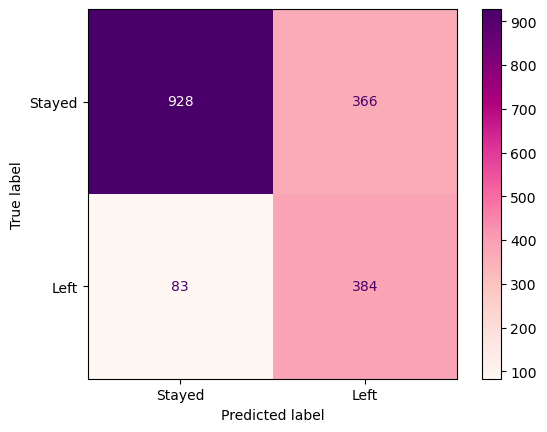

In [ ]:
# Improved model
clf = xgb.XGBClassifier(objective = "binary:logistic", seed = 42, gamma = 0, learning_rate = 0.1,
                        max_depth = 3, reg_lambda = 10.0, scale_pos_weight = 3, subsample = 0.7,
                        colsample_bytree = 0.5)
clf.fit(X_trian, y_train, verbose = False, early_stopping_rounds = 20, eval_metric = "aucpr", eval_set = [(X_test, y_test)])
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap="RdPu", display_labels = ["Stayed", "Left"])